In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.display import clear_output
import os
import random

# ライブラリのimportを行います
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
import json

import re
import unicodedata
from kanjize import kanji2number
import category_encoders as ce
from sklearn.preprocessing import LabelEncoder


from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import lightgbm as lgb
import logging
logging.getLogger("lightgbm").setLevel(logging.WARNING)
from sklearn.metrics import accuracy_score

from imblearn.under_sampling import RandomUnderSampler
from tqdm.auto import tqdm

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from transformers import AutoConfig
from transformers import AutoTokenizer, Trainer, TrainingArguments
from transformers import AutoTokenizer, AutoModelForMaskedLM
from transformers import AutoModelForSequenceClassification, DataCollatorWithPadding
from tokenizers import AddedToken
from datasets import Dataset, features

In [4]:
import src.preprocess as pre
import src.feature_selection as fs
import src.stacking as stacking
import src.classification_models as models


In [5]:
def make_submitfile(submit_date = "0829",filename = "submission", version = "00", data = []):
    submit = pd.read_csv("data/sample_submit.csv", header=None)
    # 提出ファイルの2列目を予測値で置き換えます。
    submit[1] = data
    submit.to_csv(f"output/{submit_date}{filename}_{version}.csv", index=False, header=None)

# Config

In [6]:
np.random.seed(42)
isTune = False

# 提出ファイル作成用

In [7]:
class RESULT_class:
    def __init__(self):
        self.RESULT = pd.DataFrame()

    def addResult(self, model_name,
                  feature_selection,
                  under_sampling,
                  PCAd,
                  columns,
                  skf_num,
                  skf_rand,
                  score,
                  oof_valid,
                  oof_test,
                  date = "0829"):

        tmp = pd.DataFrame([[model_name,feature_selection,under_sampling,PCAd,columns,skf_num,skf_rand,score,oof_valid,oof_test,date]])
        tmp.columns = ["model_name","feature_selection","under_sampling","PCA(d)","columns","skf_num","skf_rand","score","oof_valid","oof_test","date"]
        print(len(self.RESULT))
        if len(self.RESULT)>0:
            self.RESULT = pd.concat([self.RESULT, tmp])
        else:
            self.RESULT = tmp

Rc = RESULT_class()

# Dataload

In [9]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")
train["test"]  = 0
test["test"]  = 1
data = pd.concat([train,test]).reset_index(drop=True)

In [10]:
df_dict = {"data":data}

- id: 営業リストの顧客ID
- Age: 顧客の年齢
- TypeofContact: 顧客への連絡方法
- CityTier: 都市層(1>2>3)
- DurationOfPitch: 営業担当者による顧客への売り込み時間
- Occupation: 顧客のご職業
- Gender: 顧客の性別
- NumberOfPersonVisiting: 一緒に旅行を予定している人数の合計
- NumberOfFollowups: セールストーク後に営業担当者が行ったフォローアップの合計数
- ProductPitched: 営業担当者による商品の売り込み
- PreferredPropertyStar: 顧客によるホテル施設の優先評価
- NumberOfTrips: 顧客の年間旅行数
- Passport: パスポートの所持
- PitchSatisfactionScore: 売り込みの満足度スコア
- Designation: 現在の組織における顧客の指定
- MonthlyIncome: 顧客の月収
- customer_info: 顧客の情報のメモ(婚姻状況や車の有無、旅行の子どもの同伴の有無について記載されている)
- ProdTaken: 目的変数

In [11]:
print(train.shape)
print(test.shape)
print(data.shape)

(3489, 19)
(3489, 18)
(6978, 19)


# 基本変換

In [12]:
# 似た文字のマッピング辞書
char_map = {
    'ς': 'c',
    'а': 'a', 'А': 'A','α':'a',
    'е': 'e', 'Е': 'E',
    'о': 'o', 'О': 'O',
    'с': 'c', 'С': 'C',
    'р': 'p', 'Р': 'P',
    'υ': 'y', 'Υ': 'Y',
    'ꓢ': 'S', 'ꓤ': 'R',
    'Ѕ': 'S','ѕ':'s',
    'Ꭰ': 'D', 'ᗞ': 'D', 'ꭰ': 'D', '𝙳': 'D',
    'Տ': 'S',
    '𝖺': 'a', '𝘤': 'c', '𝔡': 'd',
    '𐊡': 'B', 'в':'B','β':'B',
    'μ':'m',
    'ε':'E',
    'K':'K',
    'ı':'i',
    'n':'n','ո':'n',
    'ｓ': 's', 'տ':'s','ι':'i',
    '×': 'x'
}

# 特定の文字列を正規化するための辞書
pattern_map = {
    r'(?i)basic': 'Basic',
    r'(?i)standard': 'Standard',
    r'(?i)super deluxe': 'Super Deluxe',
    r'(?i)deluxe': 'Deluxe',
    r'(?i)king': 'King',
    r'(?i)de\|uxe': 'Deluxe',
}

In [13]:
for kind in ["data"]:
    df_dict[kind]["Age"] = df_dict[kind]["Age"].map(lambda x:pre.Age(x))
    df_dict[kind]["Age"] = df_dict["data"]["Age"].map(lambda x: pre.age_distribution(df_dict["data"], x) if x < 0 else x)
    df_dict[kind]["DurationOfPitch"] = df_dict[kind]["DurationOfPitch"].map(lambda x:pre.DurationOfPitch(x))
    df_dict[kind]["Gender"] = df_dict[kind]["Gender"].map(lambda x:pre.Gender(x))
    df_dict[kind]["ProductPitched"] = df_dict[kind]["ProductPitched"].map(lambda x:pre.ProductPitched(x, char_map, pattern_map))
    df_dict[kind]["NumberOfTrips"] = df_dict[kind]["NumberOfTrips"].map(lambda x:pre.NumberOfTrips(x))
    df_dict[kind]["Designation"] = df_dict[kind]["Designation"].map(lambda x:pre.ProductPitched(x, char_map, pattern_map))
    df_dict[kind]["MonthlyIncome"] = df_dict[kind]["MonthlyIncome"].map(lambda x:pre.MonthlyIncome(x)).astype(float)
    df_dict[kind]["NumberOfFollowups"] = df_dict[kind]["NumberOfFollowups"].map(lambda x:pre.NumberOfFollowups(x)).astype(float)
    df_dict[kind] = pre.customer_info(df_dict[kind])

In [14]:
df_dict["data"]["MonthlyIncome"] = df_dict["data"]["MonthlyIncome"].map(lambda x: pre.Income_distribution(df_dict["data"], x) if x % 1000 == 0 else x)
df_dict["data"]["MonthlyIncome"] = df_dict["data"]["MonthlyIncome"]/100
df_dict["data"]["MonthlyIncome"] = df_dict["data"]["MonthlyIncome"].round(0)

In [15]:
# カテゴリ変数のリスト
onehotlist = ["Occupation","ProductPitched","Designation","marriage","CityTier"]
labellist = ["Gender", "TypeofContact", "car", "Passport"]
list_cols = onehotlist + labellist

df_dict["data"][list_cols] = df_dict["data"][list_cols].astype('category')

# 欠測補完

In [16]:
import src.Missing_imputation as MI
_train = df_dict["data"].drop(["id","ProdTaken"],axis=1)

for c in ["Age","DurationOfPitch","NumberOfFollowups","NumberOfTrips","MonthlyIncome"]:
    #対象となるデータに欠損がないデータセットの作成
    _tmp = _train.dropna(subset=[c])
    #数値のみを取り出す
    _tmp =_tmp.select_dtypes(include=['number'])
    #数値のみのカラム名を抽出
    colmns = _tmp.columns.tolist()

    #クラスをインスタンス化
    nfill = MI.MissingImputation(c, _tmp)

    nfill.lgb_regression()
    train_result = nfill.pred_lgb(_train[_train[c].isnull()][colmns].drop([c],axis=1))
    
    df_dict["data"].loc[df_dict["data"][c].isnull(), c] = np.round(train_result)


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000048 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 328
[LightGBM] [Info] Number of data points in the train set: 5088, number of used features: 9
[LightGBM] [Info] Start training from score 39.247838
Training until validation scores don't improve for 300 rounds
[500]	valid_0's rmse: 8.55111
Early stopping, best iteration is:
[290]	valid_0's rmse: 8.50214
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000022 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 340
[LightGBM] [Info] Number of data points in the train set: 5044, number of used features: 9
[LightGBM] [Info] Start training from score 14.487906
Training until validation scores do

C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[500]	valid_0's rmse: 6.83191
Early stopping, best iteration is:
[212]	valid_0's rmse: 6.77998
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000022 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 366
[LightGBM] [Info] Number of data points in the train set: 5190, number of used features: 9
[LightGBM] [Info] Start training from score 3.668979
Training until validation scores don't improve for 300 rounds


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[500]	valid_0's rmse: 0.807304
Early stopping, best iteration is:
[243]	valid_0's rmse: 0.802753
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000037 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 364
[LightGBM] [Info] Number of data points in the train set: 5185, number of used features: 9
[LightGBM] [Info] Start training from score 3.218901
Training until validation scores don't improve for 300 rounds


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[500]	valid_0's rmse: 1.67492
Early stopping, best iteration is:
[270]	valid_0's rmse: 1.66422
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000033 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 119
[LightGBM] [Info] Number of data points in the train set: 5154, number of used features: 9
[LightGBM] [Info] Start training from score 3642.851572
Training until validation scores don't improve for 300 rounds


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[500]	valid_0's rmse: 676.747
Early stopping, best iteration is:
[421]	valid_0's rmse: 676.568


# 自然言語特徴量

In [17]:
df_dict["data"]["Passport"] = df_dict["data"]["Passport"].map(lambda x:"has" if x == 1 else "does not have")
df_dict["data"]["marriage"] = df_dict["data"]["marriage"].map(lambda x:"Never married" if x == "未婚" else x)
df_dict["data"]["marriage"] = df_dict["data"]["marriage"].map(lambda x:"single" if x == "独身" else x)
df_dict["data"]["marriage"] = df_dict["data"]["marriage"].map(lambda x:"married" if x == "結婚済み" else x)
df_dict["data"]["marriage"] = df_dict["data"]["marriage"].map(lambda x:"divorced" if x == "離婚済み" else x)
df_dict["data"]["car"] = df_dict["data"]["car"].map(lambda x:"Yes" if x == "車所有" else "No")

In [18]:
columns = df_dict["data"].drop(["ProdTaken"],axis=1).columns.tolist()

for c in columns:
    if df_dict["data"][c].dtype == 'float':
        print(c)
        df_dict["data"][c] = df_dict["data"][c].astype(int)

Age
DurationOfPitch
NumberOfPersonVisiting
NumberOfFollowups
PreferredPropertyStar
NumberOfTrips
MonthlyIncome
child


In [19]:
def toText(df):
    text_df = []
    for i in range(len(df)):
        Age = df.loc[i,"Age"]
        TypeofContact = df.loc[i,"TypeofContact"]
        CityTier = df.loc[i,"CityTier"]
        DurationOfPitch = df.loc[i,"DurationOfPitch"]
        Occupation = df.loc[i,"Occupation"]
        Gender = df.loc[i,"Gender"]
        NumberOfPersonVisiting = df.loc[i,"NumberOfPersonVisiting"]
        NumberOfFollowups = df.loc[i,"NumberOfFollowups"]
        ProductPitched = df.loc[i,"ProductPitched"]
        PreferredPropertyStar = df.loc[i,"PreferredPropertyStar"]
        NumberOfTrips = df.loc[i,"NumberOfTrips"]
        Passport = df.loc[i,"Passport"]
        PitchSatisfactionScore = df.loc[i,"PitchSatisfactionScore"]
        Designation = df.loc[i,"Designation"]
        MonthlyIncome = df.loc[i,"MonthlyIncome"]
        marriage = df.loc[i,"marriage"]
        car = df.loc[i,"car"]
        child = df.loc[i,"child"]

        base_text = f"The customer is {Age} years old and works as a {Occupation}. Their gender is {Gender}. The method of contact used is {TypeofContact}, and they live in a city of tier {CityTier}. The duration of the sales pitch by the agent was {DurationOfPitch} minutes.The customer plans to travel {NumberOfTrips} times per year, accompanied by {NumberOfPersonVisiting} people. They prefer a {PreferredPropertyStar}-star hotel. The customer {Passport} a passport, and the satisfaction score for the sales pitch is {PitchSatisfactionScore}. The sales agent has conducted {NumberOfFollowups} follow-ups so far. The type of product pitched was {ProductPitched}, and the customer holds the position of {Designation}. Their monthly income is {MonthlyIncome} yen. The marital status is {marriage}, car ownership is {car}, and they will be accompanied by {child} children."
        text_df.append(base_text)
    return pd.DataFrame(text_df)

In [20]:
df = df_dict["data"][["id","ProdTaken","test"]]
df["prompt"] = toText(df_dict["data"]).values[:,0]
df.columns = ["id","labels","test","prompt"]

C:\Users\ctiha\AppData\Local\Temp\ipykernel_10248\2322942726.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["prompt"] = toText(df_dict["data"]).values[:,0]


In [21]:
model_name = "microsoft/deberta-v3-large"
tokenizer = AutoTokenizer.from_pretrained(model_name)
config = AutoConfig.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, config=config)

# データの準備
texts = df['prompt'].tolist()
labels = df["labels"].tolist()

model_name = "microsoft/deberta-v3-large"
tokenizer = AutoTokenizer.from_pretrained(model_name)
config = AutoConfig.from_pretrained(model_name)
model = AutoModelForMaskedLM.from_pretrained(model_name, output_hidden_states=True)

# GPUが使用可能かどうかを確認
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  # モデルをGPUに移動


# テキストをトークナイズしてDeBERTaでベクトル化
def text_to_vector(texts):
    inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    # ベクトルとしてプーリングされた隠れ層の状態を使用
    return outputs.hidden_states[-1].mean(dim=1).cpu().numpy()


vectors_list = []
for i in tqdm(range(len(texts))):
    vectors_list.append(text_to_vector(texts[i]))

C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\convert_slow_tokenizer.py:560: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialize

  0%|          | 0/6978 [00:00<?, ?it/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


# 特徴量作成

In [22]:
def age_group(Age:float) -> str:
  if Age<=25:
     return 'Youth'
  elif 25<Age<=40:
     return 'Adult'
  elif 40<Age:
     return 'Elderly'

def MonthlyIncome_group(MonthlyIncome:float) -> str:
  if MonthlyIncome <= 2900:
     return 'row'
  elif 290000 <= MonthlyIncome:
     return 'high'

In [23]:
df_dict["data"].insert(3,'AgeGroup',df_dict[kind]['Age'].apply(age_group))
df_dict["data"].insert(3,'MonthlyIncomeGroup',df_dict[kind]['MonthlyIncome'].apply(MonthlyIncome_group))

In [24]:
def WithinCategoryProbabilities(df, Category_name):
    tmp = df.groupby([Category_name,'ProdTaken'])['id'].count().reset_index(name="TotalCust").merge(df.groupby([Category_name])['id'].count(),on=Category_name)
    tmp=tmp[tmp["ProdTaken"]==1].reset_index(drop="True")
    tmp[f'{Category_name}_ProdTaken_rate']=round(tmp.TotalCust/tmp.id,2)
    return tmp[[Category_name,f"{Category_name}_ProdTaken_rate"]]


df_dict = df_dict.copy()
for category_name in ["MonthlyIncomeGroup","CityTier","Passport","Designation","Occupation","Gender","marriage"]:
    
    df_dict["data"][category_name] = df_dict["data"][category_name].astype("str")
    rate_df = WithinCategoryProbabilities(df_dict["data"], category_name)
    df_dict["data"] = pd.merge(df_dict["data"], rate_df, on = category_name, how = "left")

In [25]:
def ProdTaken_rate(df_dict, column):
    tmp = df_dict["data"].groupby([column])["ProdTaken"].sum()/df_dict["train"]["ProdTaken"].sum()
    tmp = tmp.reset_index()
    tmp.columns = [column, f"ProdTaken_{column}Rate"]
    
    df_dict["data"] = pd.merge(df_dict["data"], tmp, on = column, how = "left")
    
    return df_dict
df_dict = ProdTaken_rate(df_dict, "MonthlyIncomeGroup")
df_dict = ProdTaken_rate(df_dict, "TypeofContact")
df_dict = ProdTaken_rate(df_dict, "CityTier")
df_dict = ProdTaken_rate(df_dict, "Occupation")
df_dict = ProdTaken_rate(df_dict, "Gender")
df_dict = ProdTaken_rate(df_dict, "ProductPitched")
df_dict = ProdTaken_rate(df_dict, "PreferredPropertyStar")
df_dict = ProdTaken_rate(df_dict, "PitchSatisfactionScore")
df_dict = ProdTaken_rate(df_dict, "Designation")


C:\Users\ctiha\AppData\Local\Temp\ipykernel_10248\4100086650.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tmp = df_dict["data"].groupby([column])["ProdTaken"].sum()/df_dict["train"]["ProdTaken"].sum()
C:\Users\ctiha\AppData\Local\Temp\ipykernel_10248\4100086650.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tmp = df_dict["data"].groupby([column])["ProdTaken"].sum()/df_dict["train"]["ProdTaken"].sum()


In [26]:
# カテゴリ変数のリスト
onehotlist = ["AgeGroup","MonthlyIncomeGroup","Occupation","ProductPitched","Designation","marriage","CityTier"]
labellist = ["Gender","TypeofContact","car","Passport"]
list_cols = onehotlist + labellist

In [27]:
for c in list_cols:
    df_dict = df_dict.copy()
    groupby_tmp = df_dict["data"].groupby(c)["MonthlyIncome"].agg(["mean", "var"]).reset_index()
    groupby_tmp.columns = [c, f"{c}_mean", f"{c}_var"]
    
    df_dict["data"] = pd.merge(df_dict["data"],groupby_tmp, on = c,how="left")

C:\Users\ctiha\AppData\Local\Temp\ipykernel_10248\1136530661.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groupby_tmp = df_dict["data"].groupby(c)["MonthlyIncome"].agg(["mean", "var"]).reset_index()
C:\Users\ctiha\AppData\Local\Temp\ipykernel_10248\1136530661.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groupby_tmp = df_dict["data"].groupby(c)["MonthlyIncome"].agg(["mean", "var"]).reset_index()
C:\Users\ctiha\AppData\Local\Temp\ipykernel_10248\1136530661.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False

In [28]:
# NumberOfFollowups / DurationOfPitch: フォローアップの効率性
df_dict["data"]['Followup_Efficiency'] = df_dict["data"]['NumberOfFollowups'] / df_dict["data"]['DurationOfPitch']

city_income_level = df_dict["data"].groupby('CityTier')['MonthlyIncome'].mean().to_dict()
df_dict["data"]['city_income_level'] = df_dict["data"]['CityTier'].map(city_income_level)

In [29]:
CityTier_Designation_Income = df_dict["data"].groupby(['CityTier',"Designation"])['MonthlyIncome'].mean().reset_index()
CityTier_Designation_Income.columns = ["CityTier","Designation","CityTier_Designation_Income"]
df_dict["data"] = pd.merge(df_dict["data"],CityTier_Designation_Income, on = ['CityTier',"Designation"], how = "left")

In [30]:
tmp = df_dict["data"].groupby(["Passport","NumberOfTrips"],observed=False).count()["id"].reset_index()
tmp = tmp.rename(columns={'id': 'Passport_NumberOfTrips'}).copy()
df_dict["data"] = pd.merge(df_dict["data"],tmp,how = "left")


tmp = df_dict["data"].groupby(["Passport","Gender"],observed=False).count()["id"].reset_index()
tmp = tmp.rename(columns={'id': 'Passport_Gender'})
df_dict["data"] = pd.merge(df_dict["data"],tmp,how = "left")

In [31]:
onehotlist = ["MonthlyIncomeGroup","AgeGroup","Occupation","ProductPitched","Designation","marriage","CityTier"]
labellist = ["Gender", "TypeofContact", "car", "Passport"]
list_cols = onehotlist + labellist

In [32]:
df_dict["data"][list_cols] = df_dict["data"][list_cols].astype("str")
for c in list_cols:
    le = LabelEncoder()
    le.fit(df_dict["data"][c].values)
    df_dict["data"][c] = le.transform(df_dict["data"][c].values)

In [33]:
vectors = pd.DataFrame(np.array(vectors_list)[:,0,:])
df_dict["data"] = pd.concat([df_dict["data"], vectors],axis=1)

# 学習

In [34]:
train = df_dict["data"][df_dict["data"]["test"] == 0].drop("test",axis=1)
test = df_dict["data"][df_dict["data"]["test"] == 1].drop("test",axis=1)
# "ProdTaken"は予測対象とするため、別途target変数に格納する
y    = train["ProdTaken"]
X    = train.drop(columns=['id', 'customer_info',"ProdTaken"], axis=1)
test = test.drop(columns=['id', 'customer_info',"ProdTaken"], axis=1)

In [35]:
import src.classification_models as models
lgb_class = models.Classification_models(NUM_CLASS = 2, random_seed = 0, isOversampling = False, categorical_columns = list_cols)
xgb_class = models.Classification_models(NUM_CLASS = 2, random_seed = 0, isOversampling = False, categorical_columns = list_cols)
cat_class = models.Classification_models(NUM_CLASS = 2, random_seed = 0, isOversampling = False, categorical_columns = list_cols)
isTune = True
if isTune:
    lgb_class.lgb_tune(X, y)
    xgb_class.xgb_tune(X, y)
    cat_class.cat_tune(X, y)

[I 2024-09-01 20:38:38,943] A new study created in memory with name: no-name-a57b5279-3da7-4649-9488-931fced4834a


[CV] 1/5
Fold 1 AUC: 0.8395484949832775
[CV] 2/5
Fold 2 AUC: 0.8454180602006689
[CV] 3/5
Fold 3 AUC: 0.7850457833763342
[CV] 4/5
Fold 4 AUC: 0.8155343080217872
[CV] 5/5


[I 2024-09-01 20:38:41,137] Trial 0 finished with value: 0.8089593712004649 and parameters: {'max_bin': 261, 'num_leaves': 110, 'min_data_in_leaf': 44, 'min_sum_hessian_in_leaf': 0.014403644610368953, 'bagging_fraction': 0.8014952704817757, 'bagging_freq': 39, 'feature_fraction': 0.7653254028985397, 'lambda_l1': 3.8219728181758103e-07, 'lambda_l2': 3.029025428063446e-07, 'min_gain_to_split': 9.655893964805758, 'max_depth': 63, 'extra_trees': False, 'path_smooth': 9}. Best is trial 0 with value: 0.8089593712004649.


Fold 5 AUC: 0.7720854025201852
[CV] 1/5
Fold 1 AUC: 0.8411872909698996
[CV] 2/5
Fold 2 AUC: 0.8422408026755853
[CV] 3/5
Fold 3 AUC: 0.7583514611895247
[CV] 4/5
Fold 4 AUC: 0.8074062831992714
[CV] 5/5


[I 2024-09-01 20:38:43,337] Trial 1 finished with value: 0.8025896017818138 and parameters: {'max_bin': 160, 'num_leaves': 129, 'min_data_in_leaf': 4, 'min_sum_hessian_in_leaf': 9.471430093253852, 'bagging_fraction': 0.7629538508871744, 'bagging_freq': 87, 'feature_fraction': 0.8726564454264639, 'lambda_l1': 0.0008459459426348343, 'lambda_l2': 5.630031992346664e-08, 'min_gain_to_split': 7.273943017448, 'max_depth': 72, 'extra_trees': False, 'path_smooth': 4}. Best is trial 0 with value: 0.8089593712004649.


Fold 5 AUC: 0.7730482078308166
[CV] 1/5
Fold 1 AUC: 0.8357859531772576
[CV] 2/5
Fold 2 AUC: 0.816638795986622
[CV] 3/5
Fold 3 AUC: 0.7728874723866377
[CV] 4/5
Fold 4 AUC: 0.8026002934183235
[CV] 5/5


[I 2024-09-01 20:38:52,433] Trial 2 finished with value: 0.7989514627874197 and parameters: {'max_bin': 416, 'num_leaves': 494, 'min_data_in_leaf': 34, 'min_sum_hessian_in_leaf': 1.7587089888358184e-06, 'bagging_fraction': 0.8835642874163794, 'bagging_freq': 44, 'feature_fraction': 0.3586246384650714, 'lambda_l1': 0.8736182117742591, 'lambda_l2': 0.17884566726334963, 'min_gain_to_split': 0.37943539852509867, 'max_depth': 87, 'extra_trees': False, 'path_smooth': 8}. Best is trial 0 with value: 0.8089593712004649.


Fold 5 AUC: 0.7765616026485592
[CV] 1/5
Fold 1 AUC: 0.8306354515050167
[CV] 2/5
Fold 2 AUC: 0.8417224080267558
[CV] 3/5
Fold 3 AUC: 0.7751639938618236
[CV] 4/5
Fold 4 AUC: 0.8172543464697054
[CV] 5/5


[I 2024-09-01 20:38:56,570] Trial 3 finished with value: 0.8069600759638044 and parameters: {'max_bin': 390, 'num_leaves': 444, 'min_data_in_leaf': 47, 'min_sum_hessian_in_leaf': 2.435141137053702e-05, 'bagging_fraction': 0.8630817211245594, 'bagging_freq': 62, 'feature_fraction': 0.8094559486275752, 'lambda_l1': 2.096193773908856e-06, 'lambda_l2': 3.6668373331317246e-06, 'min_gain_to_split': 9.416170570903903, 'max_depth': 5, 'extra_trees': False, 'path_smooth': 3}. Best is trial 0 with value: 0.8089593712004649.


Fold 5 AUC: 0.774821796560927
[CV] 1/5
Fold 1 AUC: 0.843494983277592
[CV] 2/5
Fold 2 AUC: 0.8378428093645487
[CV] 3/5
Fold 3 AUC: 0.796394664508187
[CV] 4/5
Fold 4 AUC: 0.8264110217365643
[CV] 5/5


[I 2024-09-01 20:38:58,585] Trial 4 finished with value: 0.819463572881137 and parameters: {'max_bin': 174, 'num_leaves': 308, 'min_data_in_leaf': 34, 'min_sum_hessian_in_leaf': 0.002145784152328015, 'bagging_fraction': 0.6481521496960598, 'bagging_freq': 87, 'feature_fraction': 0.6826941268096309, 'lambda_l1': 0.4127250803025412, 'lambda_l2': 0.0055021922152548065, 'min_gain_to_split': 6.967928261009845, 'max_depth': 3, 'extra_trees': True, 'path_smooth': 9}. Best is trial 4 with value: 0.819463572881137.


Fold 5 AUC: 0.8033343468126077
[CV] 1/5
Fold 1 AUC: 0.8421906354515051
[CV] 2/5
Fold 2 AUC: 0.8383779264214047
[CV] 3/5
Fold 3 AUC: 0.793342439419234
[CV] 4/5
Fold 4 AUC: 0.844066710510784
[CV] 5/5


[I 2024-09-01 20:39:00,758] Trial 5 finished with value: 0.822916106263248 and parameters: {'max_bin': 445, 'num_leaves': 78, 'min_data_in_leaf': 12, 'min_sum_hessian_in_leaf': 0.0002483027802906926, 'bagging_fraction': 0.8612993323153515, 'bagging_freq': 91, 'feature_fraction': 0.5985778809291061, 'lambda_l1': 1.6069895107799518e-08, 'lambda_l2': 3.2782415027710368, 'min_gain_to_split': 2.2311214201093685, 'max_depth': 96, 'extra_trees': True, 'path_smooth': 0}. Best is trial 5 with value: 0.822916106263248.


Fold 5 AUC: 0.8030809769940204
[CV] 1/5
Fold 1 AUC: 0.837190635451505
[CV] 2/5
Fold 2 AUC: 0.8199832775919731
[CV] 3/5
Fold 3 AUC: 0.7750459520075547
[CV] 4/5
Fold 4 AUC: 0.836613210569805
[CV] 5/5


[I 2024-09-01 20:39:02,066] Trial 6 finished with value: 0.8083675851902861 and parameters: {'max_bin': 38, 'num_leaves': 31, 'min_data_in_leaf': 6, 'min_sum_hessian_in_leaf': 0.646546461737827, 'bagging_fraction': 0.8632999267283934, 'bagging_freq': 5, 'feature_fraction': 0.5025719469464459, 'lambda_l1': 2.0725712622748387e-08, 'lambda_l2': 0.0010498627912399695, 'min_gain_to_split': 9.765956538167199, 'max_depth': 56, 'extra_trees': False, 'path_smooth': 9}. Best is trial 5 with value: 0.822916106263248.


Fold 5 AUC: 0.7844329583460019
[CV] 1/5
Fold 1 AUC: 0.7935117056856187
[CV] 2/5
Fold 2 AUC: 0.8016387959866221
[CV] 3/5
Fold 3 AUC: 0.7605436670545185
[CV] 4/5
Fold 4 AUC: 0.8046575943070101
[CV] 5/5


[I 2024-09-01 20:39:04,349] Trial 7 finished with value: 0.7870975855130784 and parameters: {'max_bin': 228, 'num_leaves': 401, 'min_data_in_leaf': 17, 'min_sum_hessian_in_leaf': 0.0005820168141253591, 'bagging_fraction': 0.21513557954305843, 'bagging_freq': 49, 'feature_fraction': 0.798141327658838, 'lambda_l1': 0.0002856790454763935, 'lambda_l2': 8.188044407014034e-07, 'min_gain_to_split': 0.3550427294225966, 'max_depth': 3, 'extra_trees': True, 'path_smooth': 1}. Best is trial 5 with value: 0.822916106263248.


Fold 5 AUC: 0.7842978277760887
[CV] 1/5
Fold 1 AUC: 0.8353678929765886
[CV] 2/5
Fold 2 AUC: 0.8317892976588629
[CV] 3/5
Fold 3 AUC: 0.7880136928550953
[CV] 4/5
Fold 4 AUC: 0.815163319336942
[CV] 5/5


[I 2024-09-01 20:39:08,724] Trial 8 finished with value: 0.8092001205091511 and parameters: {'max_bin': 480, 'num_leaves': 450, 'min_data_in_leaf': 27, 'min_sum_hessian_in_leaf': 2.1681612215619864e-07, 'bagging_fraction': 0.8853714225906532, 'bagging_freq': 26, 'feature_fraction': 0.3808866777276031, 'lambda_l1': 1.0533841817926913e-05, 'lambda_l2': 0.6660296136902558, 'min_gain_to_split': 6.931442355394621, 'max_depth': 62, 'extra_trees': False, 'path_smooth': 10}. Best is trial 5 with value: 0.822916106263248.


Fold 5 AUC: 0.7837235228539577
[CV] 1/5
Fold 1 AUC: 0.8527090301003343
[CV] 2/5
Fold 2 AUC: 0.8337792642140468
[CV] 3/5
Fold 3 AUC: 0.7830222087317246
[CV] 4/5
Fold 4 AUC: 0.8354665182711928
[CV] 5/5


[I 2024-09-01 20:39:10,109] Trial 9 finished with value: 0.8201468167292526 and parameters: {'max_bin': 116, 'num_leaves': 10, 'min_data_in_leaf': 43, 'min_sum_hessian_in_leaf': 0.04449820121618335, 'bagging_fraction': 0.5903190100590868, 'bagging_freq': 23, 'feature_fraction': 0.47998699486074403, 'lambda_l1': 0.3544337382341631, 'lambda_l2': 0.0004667787763678533, 'min_gain_to_split': 1.8213827386406012, 'max_depth': 19, 'extra_trees': True, 'path_smooth': 5}. Best is trial 5 with value: 0.822916106263248.


Fold 5 AUC: 0.8019661497922368
[CV] 1/5
Fold 1 AUC: 0.8403511705685618
[CV] 2/5
Fold 2 AUC: 0.8184280936454851
[CV] 3/5
Fold 3 AUC: 0.7744726058582486
[CV] 4/5
Fold 4 AUC: 0.8352304345626549
[CV] 5/5


[I 2024-09-01 20:39:11,891] Trial 10 finished with value: 0.8100877995244192 and parameters: {'max_bin': 337, 'num_leaves': 205, 'min_data_in_leaf': 15, 'min_sum_hessian_in_leaf': 1.4029431525419582e-08, 'bagging_fraction': 0.36613694165859456, 'bagging_freq': 98, 'feature_fraction': 0.15870594921058595, 'lambda_l1': 1.125106694583683e-08, 'lambda_l2': 3.6761543224373185, 'min_gain_to_split': 3.43602474447648, 'max_depth': 98, 'extra_trees': True, 'path_smooth': 0}. Best is trial 5 with value: 0.822916106263248.


Fold 5 AUC: 0.7873382655991352
[CV] 1/5
Fold 1 AUC: 0.8494816053511705
[CV] 2/5
Fold 2 AUC: 0.8427759197324415
[CV] 3/5
Fold 3 AUC: 0.7966138850946864
[CV] 4/5
Fold 4 AUC: 0.8184853543785097
[CV] 5/5


[I 2024-09-01 20:39:13,220] Trial 11 finished with value: 0.820384876101529 and parameters: {'max_bin': 14, 'num_leaves': 13, 'min_data_in_leaf': 16, 'min_sum_hessian_in_leaf': 0.08673469389931517, 'bagging_fraction': 0.5113057663968821, 'bagging_freq': 12, 'feature_fraction': 0.5826787947478005, 'lambda_l1': 0.017766554142128764, 'lambda_l2': 3.372868145552163e-05, 'min_gain_to_split': 3.1280328126929495, 'max_depth': 31, 'extra_trees': True, 'path_smooth': 6}. Best is trial 5 with value: 0.822916106263248.


Fold 5 AUC: 0.7990439512178643
[CV] 1/5
Fold 1 AUC: 0.8308528428093646
[CV] 2/5
Fold 2 AUC: 0.8174080267558529
[CV] 3/5
Fold 3 AUC: 0.7781993558287381
[CV] 4/5
Fold 4 AUC: 0.8180300500834725
[CV] 5/5


[I 2024-09-01 20:39:15,277] Trial 12 finished with value: 0.8055572741260396 and parameters: {'max_bin': 500, 'num_leaves': 98, 'min_data_in_leaf': 14, 'min_sum_hessian_in_leaf': 3.564534146165956e-05, 'bagging_fraction': 0.42264032309646726, 'bagging_freq': 66, 'feature_fraction': 0.6259015120765654, 'lambda_l1': 0.008020426115600304, 'lambda_l2': 1.6162956319172715e-05, 'min_gain_to_split': 3.6010464573772363, 'max_depth': 33, 'extra_trees': True, 'path_smooth': 7}. Best is trial 5 with value: 0.822916106263248.


Fold 5 AUC: 0.7892469848991589
[CV] 1/5
Fold 1 AUC: 0.8423578595317724
[CV] 2/5
Fold 2 AUC: 0.8270401337792642
[CV] 3/5
Fold 3 AUC: 0.7629888197500886
[CV] 4/5
Fold 4 AUC: 0.8214026744911553
[CV] 5/5


[I 2024-09-01 20:39:16,859] Trial 13 finished with value: 0.8082579702815824 and parameters: {'max_bin': 31, 'num_leaves': 205, 'min_data_in_leaf': 22, 'min_sum_hessian_in_leaf': 0.08487592639152952, 'bagging_fraction': 0.4405821640408786, 'bagging_freq': 7, 'feature_fraction': 0.9864444726989032, 'lambda_l1': 0.013406596047282338, 'lambda_l2': 0.036636383877777304, 'min_gain_to_split': 2.989137177404826, 'max_depth': 42, 'extra_trees': True, 'path_smooth': 6}. Best is trial 5 with value: 0.822916106263248.


Fold 5 AUC: 0.795462991115165
[CV] 1/5
Fold 1 AUC: 0.8504515050167225
[CV] 2/5
Fold 2 AUC: 0.8358528428093646
[CV] 3/5
Fold 3 AUC: 0.7886544914925551
[CV] 4/5
Fold 4 AUC: 0.8406434967369859
[CV] 5/5


[I 2024-09-01 20:39:18,574] Trial 14 finished with value: 0.8258407396249152 and parameters: {'max_bin': 299, 'num_leaves': 58, 'min_data_in_leaf': 9, 'min_sum_hessian_in_leaf': 5.329507174669701e-05, 'bagging_fraction': 0.9838411685883364, 'bagging_freq': 68, 'feature_fraction': 0.6031385718441742, 'lambda_l1': 9.943980479793067, 'lambda_l2': 3.291710739474652e-05, 'min_gain_to_split': 5.152385106018669, 'max_depth': 29, 'extra_trees': True, 'path_smooth': 2}. Best is trial 14 with value: 0.8258407396249152.


Fold 5 AUC: 0.8190263842437757
[CV] 1/5
Fold 1 AUC: 0.8616053511705686
[CV] 2/5
Fold 2 AUC: 0.8406020066889631
[CV] 3/5
Fold 3 AUC: 0.7869344530446366
[CV] 4/5
Fold 4 AUC: 0.832262525083894
[CV] 5/5


[I 2024-09-01 20:39:20,864] Trial 15 finished with value: 0.8263134959489558 and parameters: {'max_bin': 313, 'num_leaves': 295, 'min_data_in_leaf': 9, 'min_sum_hessian_in_leaf': 5.673212941531866e-05, 'bagging_fraction': 0.9751533790676212, 'bagging_freq': 68, 'feature_fraction': 0.33806862096916784, 'lambda_l1': 9.476310822875636, 'lambda_l2': 7.448911708008547, 'min_gain_to_split': 5.753266310699996, 'max_depth': 79, 'extra_trees': True, 'path_smooth': 2}. Best is trial 15 with value: 0.8263134959489558.


Fold 5 AUC: 0.8174217087260566
[CV] 1/5
Fold 1 AUC: 0.8570066889632107
[CV] 2/5
Fold 2 AUC: 0.8417558528428095
[CV] 3/5
Fold 3 AUC: 0.7979797979797979
[CV] 4/5
Fold 4 AUC: 0.8354833813932313
[CV] 5/5


[I 2024-09-01 20:39:23,348] Trial 16 finished with value: 0.8292542689290827 and parameters: {'max_bin': 325, 'num_leaves': 327, 'min_data_in_leaf': 8, 'min_sum_hessian_in_leaf': 5.196683900672332e-06, 'bagging_fraction': 0.9912124212389809, 'bagging_freq': 72, 'feature_fraction': 0.12130324062275696, 'lambda_l1': 1.1891136801993505, 'lambda_l2': 3.798685031974397e-05, 'min_gain_to_split': 5.3136688789615505, 'max_depth': 78, 'extra_trees': True, 'path_smooth': 2}. Best is trial 16 with value: 0.8292542689290827.


Fold 5 AUC: 0.8212729299685821
[CV] 1/5
Fold 1 AUC: 0.8632274247491638
[CV] 2/5
Fold 2 AUC: 0.8403846153846153
[CV] 3/5
Fold 3 AUC: 0.7934773443955414
[CV] 4/5
Fold 4 AUC: 0.8422286302085968
[CV] 5/5


[I 2024-09-01 20:39:25,809] Trial 17 finished with value: 0.829224007144471 and parameters: {'max_bin': 359, 'num_leaves': 334, 'min_data_in_leaf': 3, 'min_sum_hessian_in_leaf': 2.1721449197828676e-06, 'bagging_fraction': 0.9853976592658008, 'bagging_freq': 76, 'feature_fraction': 0.1328941789941399, 'lambda_l1': 4.615468516271127, 'lambda_l2': 0.022898390654917274, 'min_gain_to_split': 5.429321151291475, 'max_depth': 79, 'extra_trees': True, 'path_smooth': 2}. Best is trial 16 with value: 0.8292542689290827.


Fold 5 AUC: 0.8126076821728997
[CV] 1/5
Fold 1 AUC: 0.8628428093645485
[CV] 2/5
Fold 2 AUC: 0.8382608695652174
[CV] 3/5
Fold 3 AUC: 0.786951316166675
[CV] 4/5
Fold 4 AUC: 0.8245729414343772
[CV] 5/5


[I 2024-09-01 20:39:28,463] Trial 18 finished with value: 0.8214904399659991 and parameters: {'max_bin': 382, 'num_leaves': 359, 'min_data_in_leaf': 2, 'min_sum_hessian_in_leaf': 8.87380787805177e-07, 'bagging_fraction': 0.7224779818730664, 'bagging_freq': 78, 'feature_fraction': 0.10906238065248561, 'lambda_l1': 1.27499025600819, 'lambda_l2': 0.01199170196724301, 'min_gain_to_split': 4.510777741421298, 'max_depth': 78, 'extra_trees': True, 'path_smooth': 3}. Best is trial 16 with value: 0.8292542689290827.


Fold 5 AUC: 0.8052261747913922
[CV] 1/5
Fold 1 AUC: 0.8370903010033444
[CV] 2/5
Fold 2 AUC: 0.8081772575250836
[CV] 3/5
Fold 3 AUC: 0.7683850188023811
[CV] 4/5
Fold 4 AUC: 0.8327852818670849
[CV] 5/5


[I 2024-09-01 20:39:30,981] Trial 19 finished with value: 0.8081624775390309 and parameters: {'max_bin': 353, 'num_leaves': 337, 'min_data_in_leaf': 24, 'min_sum_hessian_in_leaf': 3.507388622205963e-08, 'bagging_fraction': 0.19396247126369365, 'bagging_freq': 56, 'feature_fraction': 0.2609109749869137, 'lambda_l1': 0.07495423336062002, 'lambda_l2': 0.0015893133053167124, 'min_gain_to_split': 8.079259530640392, 'max_depth': 87, 'extra_trees': True, 'path_smooth': 4}. Best is trial 16 with value: 0.8292542689290827.


Fold 5 AUC: 0.8066450457754805
[CV] 1/5
Fold 1 AUC: 0.8472742474916388
[CV] 2/5
Fold 2 AUC: 0.8226923076923077
[CV] 3/5
Fold 3 AUC: 0.789430195106322
[CV] 4/5
Fold 4 AUC: 0.810154972091533
[CV] 5/5


[I 2024-09-01 20:39:32,815] Trial 20 finished with value: 0.8164421018087133 and parameters: {'max_bin': 260, 'num_leaves': 246, 'min_data_in_leaf': 2, 'min_sum_hessian_in_leaf': 1.0176565367201632e-06, 'bagging_fraction': 0.6628253345721016, 'bagging_freq': 77, 'feature_fraction': 0.2127596313395307, 'lambda_l1': 0.0009844386577384434, 'lambda_l2': 0.0001622430233650567, 'min_gain_to_split': 5.974485820762654, 'max_depth': 49, 'extra_trees': True, 'path_smooth': 1}. Best is trial 16 with value: 0.8292542689290827.


Fold 5 AUC: 0.8217627782845174
[CV] 1/5
Fold 1 AUC: 0.8533444816053511
[CV] 2/5
Fold 2 AUC: 0.8425919732441471
[CV] 3/5
Fold 3 AUC: 0.7899529518895129
[CV] 4/5
Fold 4 AUC: 0.8317734945447801
[CV] 5/5


[I 2024-09-01 20:39:35,005] Trial 21 finished with value: 0.8265905593991758 and parameters: {'max_bin': 315, 'num_leaves': 284, 'min_data_in_leaf': 8, 'min_sum_hessian_in_leaf': 6.55446249833929e-06, 'bagging_fraction': 0.9792007909132647, 'bagging_freq': 76, 'feature_fraction': 0.29784040804961165, 'lambda_l1': 9.292071542792913, 'lambda_l2': 0.0795893654695957, 'min_gain_to_split': 5.697069433696873, 'max_depth': 78, 'extra_trees': True, 'path_smooth': 2}. Best is trial 16 with value: 0.8292542689290827.


Fold 5 AUC: 0.8228776054863012
[CV] 1/5
Fold 1 AUC: 0.854314381270903
[CV] 2/5
Fold 2 AUC: 0.8416722408026756
[CV] 3/5
Fold 3 AUC: 0.7833426080504544
[CV] 4/5
Fold 4 AUC: 0.8367481155461122
[CV] 5/5


[I 2024-09-01 20:39:37,125] Trial 22 finished with value: 0.8242879738322986 and parameters: {'max_bin': 304, 'num_leaves': 258, 'min_data_in_leaf': 9, 'min_sum_hessian_in_leaf': 5.05189822904341e-06, 'bagging_fraction': 0.9814565101940027, 'bagging_freq': 78, 'feature_fraction': 0.25991933473261636, 'lambda_l1': 2.5542179405411867, 'lambda_l2': 0.3703498457874479, 'min_gain_to_split': 4.56841472289047, 'max_depth': 69, 'extra_trees': True, 'path_smooth': 2}. Best is trial 16 with value: 0.8292542689290827.


Fold 5 AUC: 0.8128103780277693
[CV] 1/5
Fold 1 AUC: 0.8648829431438126
[CV] 2/5
Fold 2 AUC: 0.8369899665551839
[CV] 3/5
Fold 3 AUC: 0.7884858602721708
[CV] 4/5
Fold 4 AUC: 0.8406434967369859
[CV] 5/5


[I 2024-09-01 20:39:39,708] Trial 23 finished with value: 0.8257439019141588 and parameters: {'max_bin': 366, 'num_leaves': 354, 'min_data_in_leaf': 19, 'min_sum_hessian_in_leaf': 1.3300855371387507e-07, 'bagging_fraction': 0.9304553405124087, 'bagging_freq': 75, 'feature_fraction': 0.11612906460646996, 'lambda_l1': 0.10584555519424739, 'lambda_l2': 0.06498412728717415, 'min_gain_to_split': 5.677928530456605, 'max_depth': 88, 'extra_trees': True, 'path_smooth': 3}. Best is trial 16 with value: 0.8292542689290827.


Fold 5 AUC: 0.8086213303604608
[CV] 1/5
Fold 1 AUC: 0.8482608695652174
[CV] 2/5
Fold 2 AUC: 0.8404849498327761
[CV] 3/5
Fold 3 AUC: 0.7919596634120841
[CV] 4/5
Fold 4 AUC: 0.8386873745805299
[CV] 5/5


[I 2024-09-01 20:39:41,777] Trial 24 finished with value: 0.8245078761338083 and parameters: {'max_bin': 212, 'num_leaves': 397, 'min_data_in_leaf': 7, 'min_sum_hessian_in_leaf': 6.85095844879288e-06, 'bagging_fraction': 0.7994919159287378, 'bagging_freq': 59, 'feature_fraction': 0.2091913684081439, 'lambda_l1': 3.151159556080456, 'lambda_l2': 0.0067580314930372086, 'min_gain_to_split': 8.296335083250188, 'max_depth': 79, 'extra_trees': True, 'path_smooth': 1}. Best is trial 16 with value: 0.8292542689290827.


Fold 5 AUC: 0.811627985541029
[CV] 1/5
Fold 1 AUC: 0.8607023411371238
[CV] 2/5
Fold 2 AUC: 0.8366889632107024
[CV] 3/5
Fold 3 AUC: 0.7903745299404732
[CV] 4/5
Fold 4 AUC: 0.8227348611321901
[CV] 5/5


[I 2024-09-01 20:39:43,843] Trial 25 finished with value: 0.8218367692787741 and parameters: {'max_bin': 406, 'num_leaves': 177, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 2.357582251960494e-07, 'bagging_fraction': 0.9310631717689615, 'bagging_freq': 97, 'feature_fraction': 0.29491815947503125, 'lambda_l1': 0.10285587078214846, 'lambda_l2': 0.00012369536234482255, 'min_gain_to_split': 6.372225933836241, 'max_depth': 69, 'extra_trees': True, 'path_smooth': 4}. Best is trial 16 with value: 0.8292542689290827.


Fold 5 AUC: 0.8081314820445256
[CV] 1/5
Fold 1 AUC: 0.8520401337792642
[CV] 2/5
Fold 2 AUC: 0.8419063545150502
[CV] 3/5
Fold 3 AUC: 0.8052309404563163
[CV] 4/5
Fold 4 AUC: 0.8439655317785536
[CV] 5/5


[I 2024-09-01 20:39:46,367] Trial 26 finished with value: 0.8327363916117024 and parameters: {'max_bin': 437, 'num_leaves': 267, 'min_data_in_leaf': 29, 'min_sum_hessian_in_leaf': 6.744248532307937e-06, 'bagging_fraction': 0.989862080678444, 'bagging_freq': 82, 'feature_fraction': 0.43146504673910074, 'lambda_l1': 9.393370000949, 'lambda_l2': 0.03667603914625038, 'min_gain_to_split': 4.8190924918869875, 'max_depth': 61, 'extra_trees': True, 'path_smooth': 2}. Best is trial 26 with value: 0.8327363916117024.


Fold 5 AUC: 0.8276240667545016
[CV] 1/5
Fold 1 AUC: 0.8502341137123746
[CV] 2/5
Fold 2 AUC: 0.7993478260869566
[CV] 3/5
Fold 3 AUC: 0.7515050336419284
[CV] 4/5
Fold 4 AUC: 0.8136456383534848
[CV] 5/5


[I 2024-09-01 20:39:48,721] Trial 27 finished with value: 0.7988371404899988 and parameters: {'max_bin': 420, 'num_leaves': 249, 'min_data_in_leaf': 29, 'min_sum_hessian_in_leaf': 0.0014826793675114698, 'bagging_fraction': 0.12238694357132163, 'bagging_freq': 85, 'feature_fraction': 0.39097360468744935, 'lambda_l1': 0.29296183261656716, 'lambda_l2': 0.0015207647909944156, 'min_gain_to_split': 4.299756256334543, 'max_depth': 51, 'extra_trees': True, 'path_smooth': 0}. Best is trial 26 with value: 0.8327363916117024.


Fold 5 AUC: 0.7886051146920712
[CV] 1/5
Fold 1 AUC: 0.8574247491638796
[CV] 2/5
Fold 2 AUC: 0.8309030100334448
[CV] 3/5
Fold 3 AUC: 0.7833426080504545
[CV] 4/5
Fold 4 AUC: 0.8243368577258393
[CV] 5/5


[I 2024-09-01 20:39:52,047] Trial 28 finished with value: 0.8158281238231528 and parameters: {'max_bin': 451, 'num_leaves': 397, 'min_data_in_leaf': 32, 'min_sum_hessian_in_leaf': 0.0001266092842778949, 'bagging_fraction': 0.7234990373149106, 'bagging_freq': 51, 'feature_fraction': 0.46995242046441876, 'lambda_l1': 3.588064269844718e-05, 'lambda_l2': 3.299068870585245e-06, 'min_gain_to_split': 4.065345248746841, 'max_depth': 59, 'extra_trees': True, 'path_smooth': 5}. Best is trial 26 with value: 0.8327363916117024.


Fold 5 AUC: 0.7943819465558598
[CV] 1/5
Fold 1 AUC: 0.8212040133779265
[CV] 2/5
Fold 2 AUC: 0.813628762541806
[CV] 3/5
Fold 3 AUC: 0.783157113708032
[CV] 4/5
Fold 4 AUC: 0.7947252154263841
[CV] 5/5


[I 2024-09-01 20:39:55,885] Trial 29 finished with value: 0.7969709971056285 and parameters: {'max_bin': 455, 'num_leaves': 329, 'min_data_in_leaf': 21, 'min_sum_hessian_in_leaf': 1.107504270777417e-05, 'bagging_fraction': 0.79913354310002, 'bagging_freq': 38, 'feature_fraction': 0.18484012465797794, 'lambda_l1': 0.04283680673531462, 'lambda_l2': 1.0187287604216389e-08, 'min_gain_to_split': 5.010184632826105, 'max_depth': 66, 'extra_trees': False, 'path_smooth': 1}. Best is trial 26 with value: 0.8327363916117024.


Fold 5 AUC: 0.781223607310564
[CV] 1/5
Fold 1 AUC: 0.8557023411371237
[CV] 2/5
Fold 2 AUC: 0.8429598662207358
[CV] 3/5
Fold 3 AUC: 0.795855044602958
[CV] 4/5
Fold 4 AUC: 0.8324142931822398
[CV] 5/5


[I 2024-09-01 20:39:58,029] Trial 30 finished with value: 0.8244177632640765 and parameters: {'max_bin': 269, 'num_leaves': 211, 'min_data_in_leaf': 41, 'min_sum_hessian_in_leaf': 8.515313670671757e-07, 'bagging_fraction': 0.9343048175215692, 'bagging_freq': 71, 'feature_fraction': 0.4127244202753846, 'lambda_l1': 0.0029969228312043228, 'lambda_l2': 0.9526730380035816, 'min_gain_to_split': 2.2630134131389443, 'max_depth': 41, 'extra_trees': True, 'path_smooth': 3}. Best is trial 26 with value: 0.8327363916117024.


Fold 5 AUC: 0.8007668659842573
[CV] 1/5
Fold 1 AUC: 0.8578929765886288
[CV] 2/5
Fold 2 AUC: 0.8396655518394648
[CV] 3/5
Fold 3 AUC: 0.7947589416704608
[CV] 4/5
Fold 4 AUC: 0.838164617797339
[CV] 5/5


[I 2024-09-01 20:40:00,482] Trial 31 finished with value: 0.8297216453803031 and parameters: {'max_bin': 331, 'num_leaves': 302, 'min_data_in_leaf': 39, 'min_sum_hessian_in_leaf': 3.7275125445318563e-06, 'bagging_fraction': 0.9913244512341503, 'bagging_freq': 80, 'feature_fraction': 0.28185788389325384, 'lambda_l1': 3.9665143703230545, 'lambda_l2': 0.024585062951053616, 'min_gain_to_split': 5.398747398814948, 'max_depth': 79, 'extra_trees': True, 'path_smooth': 2}. Best is trial 26 with value: 0.8327363916117024.


Fold 5 AUC: 0.8278267626093713
[CV] 1/5
Fold 1 AUC: 0.8642140468227425
[CV] 2/5
Fold 2 AUC: 0.8353846153846154
[CV] 3/5
Fold 3 AUC: 0.7900541306217432
[CV] 4/5
Fold 4 AUC: 0.8389740476551829
[CV] 5/5


[I 2024-09-01 20:40:02,571] Trial 32 finished with value: 0.826794322082226 and parameters: {'max_bin': 330, 'num_leaves': 269, 'min_data_in_leaf': 35, 'min_sum_hessian_in_leaf': 7.076241868521404e-08, 'bagging_fraction': 0.9951032040660118, 'bagging_freq': 83, 'feature_fraction': 0.14754181426992974, 'lambda_l1': 2.5774980711807887, 'lambda_l2': 0.016349846193152464, 'min_gain_to_split': 6.3794433228365, 'max_depth': 73, 'extra_trees': True, 'path_smooth': 2}. Best is trial 26 with value: 0.8327363916117024.


Fold 5 AUC: 0.8132664437012262
[CV] 1/5
Fold 1 AUC: 0.8581103678929767
[CV] 2/5
Fold 2 AUC: 0.8465719063545151
[CV] 3/5
Fold 3 AUC: 0.7885364496382861
[CV] 4/5
Fold 4 AUC: 0.8453988971518187
[CV] 5/5


[I 2024-09-01 20:40:04,419] Trial 33 finished with value: 0.8295878210439105 and parameters: {'max_bin': 361, 'num_leaves': 138, 'min_data_in_leaf': 39, 'min_sum_hessian_in_leaf': 1.98418883992923e-06, 'bagging_fraction': 0.9154256055904938, 'bagging_freq': 92, 'feature_fraction': 0.23152074835524034, 'lambda_l1': 0.8254062193565873, 'lambda_l2': 0.003824771535830715, 'min_gain_to_split': 5.166574637684491, 'max_depth': 90, 'extra_trees': True, 'path_smooth': 4}. Best is trial 26 with value: 0.8327363916117024.


Fold 5 AUC: 0.8160535117056857
[CV] 1/5
Fold 1 AUC: 0.8350167224080267
[CV] 2/5
Fold 2 AUC: 0.8182107023411371
[CV] 3/5
Fold 3 AUC: 0.7731235560951755
[CV] 4/5
Fold 4 AUC: 0.8332068599180452
[CV] 5/5


[I 2024-09-01 20:40:06,646] Trial 34 finished with value: 0.8086923950117817 and parameters: {'max_bin': 289, 'num_leaves': 188, 'min_data_in_leaf': 39, 'min_sum_hessian_in_leaf': 5.652084825618919e-07, 'bagging_fraction': 0.9169663935975456, 'bagging_freq': 92, 'feature_fraction': 0.2398339121118261, 'lambda_l1': 0.5686016028437344, 'lambda_l2': 0.0032295425106741416, 'min_gain_to_split': 3.90319092906196, 'max_depth': 89, 'extra_trees': False, 'path_smooth': 4}. Best is trial 26 with value: 0.8327363916117024.


Fold 5 AUC: 0.7893990067903113
[CV] 1/5
Fold 1 AUC: 0.8585953177257525
[CV] 2/5
Fold 2 AUC: 0.8368896321070233
[CV] 3/5
Fold 3 AUC: 0.7905937505269727
[CV] 4/5
Fold 4 AUC: 0.8322962513279708
[CV] 5/5


[I 2024-09-01 20:40:08,552] Trial 35 finished with value: 0.8247264334671128 and parameters: {'max_bin': 394, 'num_leaves': 141, 'min_data_in_leaf': 50, 'min_sum_hessian_in_leaf': 3.0514944911107694e-06, 'bagging_fraction': 0.8171362003357108, 'bagging_freq': 92, 'feature_fraction': 0.30604415409188573, 'lambda_l1': 1.0196654970685426, 'lambda_l2': 0.183381412668503, 'min_gain_to_split': 7.404725471590796, 'max_depth': 92, 'extra_trees': True, 'path_smooth': 5}. Best is trial 26 with value: 0.8327363916117024.


Fold 5 AUC: 0.8147866626127496
[CV] 1/5
Fold 1 AUC: 0.8302508361204013
[CV] 2/5
Fold 2 AUC: 0.8369565217391304
[CV] 3/5
Fold 3 AUC: 0.783646144247146
[CV] 4/5
Fold 4 AUC: 0.8206775602435036
[CV] 5/5


[I 2024-09-01 20:40:11,558] Trial 36 finished with value: 0.8122599231754162 and parameters: {'max_bin': 427, 'num_leaves': 153, 'min_data_in_leaf': 36, 'min_sum_hessian_in_leaf': 1.2942452045258267e-05, 'bagging_fraction': 0.8444526680207564, 'bagging_freq': 100, 'feature_fraction': 0.43266255948050125, 'lambda_l1': 0.14019266062477126, 'lambda_l2': 0.0006254190186989481, 'min_gain_to_split': 4.699259279345824, 'max_depth': 85, 'extra_trees': False, 'path_smooth': 3}. Best is trial 26 with value: 0.8327363916117024.


Fold 5 AUC: 0.7946015337319685
[CV] 1/5
Fold 1 AUC: 0.8674247491638795
[CV] 2/5
Fold 2 AUC: 0.8335785953177257
[CV] 3/5
Fold 3 AUC: 0.7847591103016813
[CV] 4/5
Fold 4 AUC: 0.8422454933306353
[CV] 5/5


[I 2024-09-01 20:40:14,089] Trial 37 finished with value: 0.8263982289458677 and parameters: {'max_bin': 225, 'num_leaves': 310, 'min_data_in_leaf': 38, 'min_sum_hessian_in_leaf': 0.0002089631806585027, 'bagging_fraction': 0.9022381756029367, 'bagging_freq': 82, 'feature_fraction': 0.3501765760372585, 'lambda_l1': 2.406575793036576e-07, 'lambda_l2': 0.00013585999119466777, 'min_gain_to_split': 6.614625747937719, 'max_depth': 100, 'extra_trees': True, 'path_smooth': 3}. Best is trial 26 with value: 0.8327363916117024.


Fold 5 AUC: 0.8128948346339651
[CV] 1/5
Fold 1 AUC: 0.8569565217391304
[CV] 2/5
Fold 2 AUC: 0.8315719063545151
[CV] 3/5
Fold 3 AUC: 0.7953997403079206
[CV] 4/5
Fold 4 AUC: 0.8347582671455793
[CV] 5/5


[I 2024-09-01 20:40:16,502] Trial 38 finished with value: 0.8237822657872368 and parameters: {'max_bin': 379, 'num_leaves': 225, 'min_data_in_leaf': 31, 'min_sum_hessian_in_leaf': 9.190179320995416, 'bagging_fraction': 0.739546523808298, 'bagging_freq': 88, 'feature_fraction': 0.5272993825100716, 'lambda_l1': 1.0843596361348729, 'lambda_l2': 3.83308239447575e-07, 'min_gain_to_split': 7.596897873413576, 'max_depth': 73, 'extra_trees': True, 'path_smooth': 4}. Best is trial 26 with value: 0.8327363916117024.


Fold 5 AUC: 0.809330765852505
[CV] 1/5
Fold 1 AUC: 0.8410535117056855
[CV] 2/5
Fold 2 AUC: 0.8423578595317726
[CV] 3/5
Fold 3 AUC: 0.7800880254970406
[CV] 4/5
Fold 4 AUC: 0.8165966847102073
[CV] 5/5


[I 2024-09-01 20:40:19,885] Trial 39 finished with value: 0.8116688096493399 and parameters: {'max_bin': 276, 'num_leaves': 374, 'min_data_in_leaf': 46, 'min_sum_hessian_in_leaf': 0.004800097181274515, 'bagging_fraction': 0.7690436202207279, 'bagging_freq': 94, 'feature_fraction': 0.7054518650167327, 'lambda_l1': 0.25918795518362014, 'lambda_l2': 0.003221189078689319, 'min_gain_to_split': 9.047163805409024, 'max_depth': 84, 'extra_trees': False, 'path_smooth': 1}. Best is trial 26 with value: 0.8327363916117024.


Fold 5 AUC: 0.7854464376203507
[CV] 1/5
Fold 1 AUC: 0.8485953177257525
[CV] 2/5
Fold 2 AUC: 0.8567056856187291
[CV] 3/5
Fold 3 AUC: 0.7830896612198783
[CV] 4/5
Fold 4 AUC: 0.8411156641540616
[CV] 5/5


[I 2024-09-01 20:40:22,285] Trial 40 finished with value: 0.8266779823324977 and parameters: {'max_bin': 196, 'num_leaves': 451, 'min_data_in_leaf': 27, 'min_sum_hessian_in_leaf': 1.9129317947518905e-05, 'bagging_fraction': 0.8347943706849412, 'bagging_freq': 87, 'feature_fraction': 0.1855483251939627, 'lambda_l1': 0.03490312821266564, 'lambda_l2': 7.157329005635152e-06, 'min_gain_to_split': 5.0803525472164015, 'max_depth': 94, 'extra_trees': True, 'path_smooth': 0}. Best is trial 26 with value: 0.8327363916117024.


Fold 5 AUC: 0.8099557447383534
[CV] 1/5
Fold 1 AUC: 0.8609698996655518
[CV] 2/5
Fold 2 AUC: 0.8356354515050167
[CV] 3/5
Fold 3 AUC: 0.7965632957285712
[CV] 4/5
Fold 4 AUC: 0.837557545403956
[CV] 5/5


[I 2024-09-01 20:40:24,795] Trial 41 finished with value: 0.8272832180247259 and parameters: {'max_bin': 352, 'num_leaves': 320, 'min_data_in_leaf': 5, 'min_sum_hessian_in_leaf': 2.3687990037273188e-06, 'bagging_fraction': 0.9284224606632908, 'bagging_freq': 63, 'feature_fraction': 0.10266204100311585, 'lambda_l1': 3.184158347315935, 'lambda_l2': 0.02401555328368327, 'min_gain_to_split': 5.154265842140877, 'max_depth': 83, 'extra_trees': True, 'path_smooth': 2}. Best is trial 26 with value: 0.8327363916117024.


Fold 5 AUC: 0.8152089456437283
[CV] 1/5
Fold 1 AUC: 0.8675919732441472
[CV] 2/5
Fold 2 AUC: 0.8437123745819398
[CV] 3/5
Fold 3 AUC: 0.795096204111229
[CV] 4/5
Fold 4 AUC: 0.8377430397463786
[CV] 5/5


[I 2024-09-01 20:40:27,124] Trial 42 finished with value: 0.8303759724120122 and parameters: {'max_bin': 333, 'num_leaves': 293, 'min_data_in_leaf': 45, 'min_sum_hessian_in_leaf': 4.558351279298814e-07, 'bagging_fraction': 0.9410505377421613, 'bagging_freq': 72, 'feature_fraction': 0.15251149433068048, 'lambda_l1': 3.47203225842954, 'lambda_l2': 0.14899364471824525, 'min_gain_to_split': 5.400731991225298, 'max_depth': 62, 'extra_trees': True, 'path_smooth': 1}. Best is trial 26 with value: 0.8327363916117024.


Fold 5 AUC: 0.8172527955136651
[CV] 1/5
Fold 1 AUC: 0.8636120401337793
[CV] 2/5
Fold 2 AUC: 0.8449498327759196
[CV] 3/5
Fold 3 AUC: 0.7874572098278275
[CV] 4/5
Fold 4 AUC: 0.8407615385912549
[CV] 5/5


[I 2024-09-01 20:40:29,503] Trial 43 finished with value: 0.8295595767116065 and parameters: {'max_bin': 333, 'num_leaves': 283, 'min_data_in_leaf': 44, 'min_sum_hessian_in_leaf': 3.4762851645224096e-07, 'bagging_fraction': 0.8846262708411569, 'bagging_freq': 72, 'feature_fraction': 0.22374078397131247, 'lambda_l1': 1.0978087545051067, 'lambda_l2': 0.17953655655320017, 'min_gain_to_split': 6.0988160124443285, 'max_depth': 59, 'extra_trees': True, 'path_smooth': 1}. Best is trial 26 with value: 0.8327363916117024.


Fold 5 AUC: 0.8196851457721022
[CV] 1/5
Fold 1 AUC: 0.8574080267558528
[CV] 2/5
Fold 2 AUC: 0.8392976588628763
[CV] 3/5
Fold 3 AUC: 0.7958381814809194
[CV] 4/5
Fold 4 AUC: 0.8421611777204432
[CV] 5/5


[I 2024-09-01 20:40:31,327] Trial 44 finished with value: 0.8276678789313422 and parameters: {'max_bin': 244, 'num_leaves': 235, 'min_data_in_leaf': 43, 'min_sum_hessian_in_leaf': 3.598909069330484e-07, 'bagging_fraction': 0.8952578592210129, 'bagging_freq': 80, 'feature_fraction': 0.23759645840467164, 'lambda_l1': 0.4579309617973262, 'lambda_l2': 0.1577023072031391, 'min_gain_to_split': 6.267199560389781, 'max_depth': 56, 'extra_trees': True, 'path_smooth': 1}. Best is trial 26 with value: 0.8327363916117024.


Fold 5 AUC: 0.8130468565251174
[CV] 1/5
Fold 1 AUC: 0.8518227424749163
[CV] 2/5
Fold 2 AUC: 0.8383444816053511
[CV] 3/5
Fold 3 AUC: 0.7795315424697729
[CV] 4/5
Fold 4 AUC: 0.8185190806225865
[CV] 5/5


[I 2024-09-01 20:40:33,059] Trial 45 finished with value: 0.8184568641797307 and parameters: {'max_bin': 111, 'num_leaves': 301, 'min_data_in_leaf': 46, 'min_sum_hessian_in_leaf': 1.1065896831084554e-08, 'bagging_fraction': 0.6745712063150803, 'bagging_freq': 88, 'feature_fraction': 0.30961725723625094, 'lambda_l1': 0.00011705209120039326, 'lambda_l2': 1.270137741251741, 'min_gain_to_split': 6.964747072606446, 'max_depth': 63, 'extra_trees': True, 'path_smooth': 0}. Best is trial 26 with value: 0.8327363916117024.


Fold 5 AUC: 0.8160366203844465
[CV] 1/5
Fold 1 AUC: 0.8560200668896322
[CV] 2/5
Fold 2 AUC: 0.8451672240802676
[CV] 3/5
Fold 3 AUC: 0.7848771521559501
[CV] 4/5
Fold 4 AUC: 0.8391764051196439
[CV] 5/5


[I 2024-09-01 20:40:35,920] Trial 46 finished with value: 0.8264190759530445 and parameters: {'max_bin': 438, 'num_leaves': 275, 'min_data_in_leaf': 48, 'min_sum_hessian_in_leaf': 6.190214260303598e-08, 'bagging_fraction': 0.883915736272796, 'bagging_freq': 43, 'feature_fraction': 0.4448148522848764, 'lambda_l1': 4.628252537239201, 'lambda_l2': 0.2525279814504741, 'min_gain_to_split': 6.043697517975737, 'max_depth': 57, 'extra_trees': True, 'path_smooth': 1}. Best is trial 26 with value: 0.8327363916117024.


Fold 5 AUC: 0.8142968142968142
[CV] 1/5
Fold 1 AUC: 0.8339464882943144
[CV] 2/5
Fold 2 AUC: 0.8383779264214046
[CV] 3/5
Fold 3 AUC: 0.7606954351528642
[CV] 4/5
Fold 4 AUC: 0.7923475152189677
[CV] 5/5


[I 2024-09-01 20:40:38,318] Trial 47 finished with value: 0.8016951979255209 and parameters: {'max_bin': 473, 'num_leaves': 169, 'min_data_in_leaf': 40, 'min_sum_hessian_in_leaf': 1.09531165522089e-07, 'bagging_fraction': 0.5979625782046717, 'bagging_freq': 62, 'feature_fraction': 0.17493294207223678, 'lambda_l1': 1.801287166533694, 'lambda_l2': 0.06936418897985061, 'min_gain_to_split': 6.847356864924892, 'max_depth': 47, 'extra_trees': False, 'path_smooth': 8}. Best is trial 26 with value: 0.8327363916117024.


Fold 5 AUC: 0.7899902030336813
[CV] 1/5
Fold 1 AUC: 0.8480434782608697
[CV] 2/5
Fold 2 AUC: 0.8324916387959866
[CV] 3/5
Fold 3 AUC: 0.7814370752601136
[CV] 4/5
Fold 4 AUC: 0.8295306993136708
[CV] 5/5


[I 2024-09-01 20:40:40,345] Trial 48 finished with value: 0.8179262742228773 and parameters: {'max_bin': 403, 'num_leaves': 127, 'min_data_in_leaf': 42, 'min_sum_hessian_in_leaf': 3.4133048288202663e-07, 'bagging_fraction': 0.8575593025500612, 'bagging_freq': 56, 'feature_fraction': 0.3828034765639352, 'lambda_l1': 2.8227732620621024e-06, 'lambda_l2': 2.160585121833415, 'min_gain_to_split': 2.6252768210169215, 'max_depth': 60, 'extra_trees': True, 'path_smooth': 0}. Best is trial 26 with value: 0.8327363916117024.


Fold 5 AUC: 0.806476132563089
[CV] 1/5
Fold 1 AUC: 0.8490301003344481
[CV] 2/5
Fold 2 AUC: 0.831989966555184
[CV] 3/5
Fold 3 AUC: 0.7854504983052563
[CV] 4/5
Fold 4 AUC: 0.8324311563042782
[CV] 5/5


[I 2024-09-01 20:40:43,099] Trial 49 finished with value: 0.8184608990843457 and parameters: {'max_bin': 341, 'num_leaves': 282, 'min_data_in_leaf': 37, 'min_sum_hessian_in_leaf': 2.8376816727941906e-08, 'bagging_fraction': 0.9480645470308138, 'bagging_freq': 69, 'feature_fraction': 0.338986754228664, 'lambda_l1': 0.24623332469705855, 'lambda_l2': 0.5396479588772667, 'min_gain_to_split': 1.2861054211484166, 'max_depth': 66, 'extra_trees': True, 'path_smooth': 6}. Best is trial 26 with value: 0.8327363916117024.


Fold 5 AUC: 0.8011553663727576
[CV] 1/5
Fold 1 AUC: 0.8498327759197325
[CV] 2/5
Fold 2 AUC: 0.8267224080267559
[CV] 3/5
Fold 3 AUC: 0.7808468659887692
[CV] 4/5
Fold 4 AUC: 0.8350112139761556
[CV] 5/5


[I 2024-09-01 20:40:45,256] Trial 50 finished with value: 0.8197850202821205 and parameters: {'max_bin': 374, 'num_leaves': 227, 'min_data_in_leaf': 44, 'min_sum_hessian_in_leaf': 1.4535465743126635e-06, 'bagging_fraction': 0.3392559195057776, 'bagging_freq': 73, 'feature_fraction': 0.2711844929682757, 'lambda_l1': 9.689611220023215, 'lambda_l2': 0.04498078106458399, 'min_gain_to_split': 3.5785231440386074, 'max_depth': 54, 'extra_trees': True, 'path_smooth': 1}. Best is trial 26 with value: 0.8327363916117024.


Fold 5 AUC: 0.8113408330799634
[CV] 1/5
Fold 1 AUC: 0.8479096989966556
[CV] 2/5
Fold 2 AUC: 0.8390133779264214
[CV] 3/5
Fold 3 AUC: 0.7959056339690731
[CV] 4/5
Fold 4 AUC: 0.8419588202559822
[CV] 5/5


[I 2024-09-01 20:40:47,601] Trial 51 finished with value: 0.8270700405642409 and parameters: {'max_bin': 323, 'num_leaves': 302, 'min_data_in_leaf': 50, 'min_sum_hessian_in_leaf': 3.8111536649853243e-06, 'bagging_fraction': 0.9485605864709973, 'bagging_freq': 82, 'feature_fraction': 0.21396796294054526, 'lambda_l1': 0.7973408203516861, 'lambda_l2': 0.010686577990723261, 'min_gain_to_split': 5.4439407799718404, 'max_depth': 73, 'extra_trees': True, 'path_smooth': 2}. Best is trial 26 with value: 0.8327363916117024.


Fold 5 AUC: 0.8169656430525997
[CV] 1/5
Fold 1 AUC: 0.8542642140468226
[CV] 2/5
Fold 2 AUC: 0.8408361204013379
[CV] 3/5
Fold 3 AUC: 0.7905937505269726
[CV] 4/5
Fold 4 AUC: 0.8493448677088077
[CV] 5/5


[I 2024-09-01 20:40:50,255] Trial 52 finished with value: 0.8268817450155479 and parameters: {'max_bin': 342, 'num_leaves': 358, 'min_data_in_leaf': 33, 'min_sum_hessian_in_leaf': 3.0514418053508172e-05, 'bagging_fraction': 0.8772620045243299, 'bagging_freq': 71, 'feature_fraction': 0.16091471718989003, 'lambda_l1': 1.4137650900998835, 'lambda_l2': 0.0037536262009702855, 'min_gain_to_split': 4.781756509543663, 'max_depth': 45, 'extra_trees': True, 'path_smooth': 3}. Best is trial 26 with value: 0.8327363916117024.


Fold 5 AUC: 0.807607851086112
[CV] 1/5
Fold 1 AUC: 0.8645150501672241
[CV] 2/5
Fold 2 AUC: 0.8468394648829431
[CV] 3/5
Fold 3 AUC: 0.7828873037554173
[CV] 4/5
Fold 4 AUC: 0.846596178816546
[CV] 5/5


[I 2024-09-01 20:40:52,369] Trial 53 finished with value: 0.8303941294827789 and parameters: {'max_bin': 284, 'num_leaves': 261, 'min_data_in_leaf': 45, 'min_sum_hessian_in_leaf': 5.506395501549228e-07, 'bagging_fraction': 0.9576425636534741, 'bagging_freq': 66, 'feature_fraction': 0.15062506635160258, 'lambda_l1': 4.756777067427452, 'lambda_l2': 0.11859851900166911, 'min_gain_to_split': 5.427579080966585, 'max_depth': 66, 'extra_trees': True, 'path_smooth': 2}. Best is trial 26 with value: 0.8327363916117024.


Fold 5 AUC: 0.8164926860579035
[CV] 1/5
Fold 1 AUC: 0.8603846153846154
[CV] 2/5
Fold 2 AUC: 0.8369063545150501
[CV] 3/5
Fold 3 AUC: 0.7939832380566939
[CV] 4/5
Fold 4 AUC: 0.8385861958482994
[CV] 5/5


[I 2024-09-01 20:40:53,980] Trial 54 finished with value: 0.8264896867838045 and parameters: {'max_bin': 289, 'num_leaves': 64, 'min_data_in_leaf': 45, 'min_sum_hessian_in_leaf': 3.9179384043161373e-07, 'bagging_fraction': 0.9497021800909136, 'bagging_freq': 65, 'feature_fraction': 0.22143391894276437, 'lambda_l1': 6.140115572923111, 'lambda_l2': 0.08120012659958666, 'min_gain_to_split': 4.121949119158219, 'max_depth': 66, 'extra_trees': True, 'path_smooth': 1}. Best is trial 26 with value: 0.8327363916117024.


Fold 5 AUC: 0.8126414648153779
[CV] 1/5
Fold 1 AUC: 0.8607692307692307
[CV] 2/5
Fold 2 AUC: 0.8366889632107024
[CV] 3/5
Fold 3 AUC: 0.7911165073101635
[CV] 4/5
Fold 4 AUC: 0.8433415962631321
[CV] 5/5


[I 2024-09-01 20:40:55,987] Trial 55 finished with value: 0.8287068668696671 and parameters: {'max_bin': 295, 'num_leaves': 265, 'min_data_in_leaf': 41, 'min_sum_hessian_in_leaf': 8.205948758493022e-05, 'bagging_fraction': 0.9000889169732323, 'bagging_freq': 85, 'feature_fraction': 0.15403781902163183, 'lambda_l1': 4.052636446754677, 'lambda_l2': 6.05122688051493, 'min_gain_to_split': 6.048391775984945, 'max_depth': 53, 'extra_trees': True, 'path_smooth': 2}. Best is trial 26 with value: 0.8327363916117024.


Fold 5 AUC: 0.8206141684402554
[CV] 1/5
Fold 1 AUC: 0.8588461538461539
[CV] 2/5
Fold 2 AUC: 0.8360367892976588
[CV] 3/5
Fold 3 AUC: 0.7992782583767558
[CV] 4/5
Fold 4 AUC: 0.8463938213520852
[CV] 5/5


[I 2024-09-01 20:40:57,843] Trial 56 finished with value: 0.8293497616716341 and parameters: {'max_bin': 247, 'num_leaves': 95, 'min_data_in_leaf': 48, 'min_sum_hessian_in_leaf': 1.3646167747018097e-06, 'bagging_fraction': 0.9992815102772672, 'bagging_freq': 58, 'feature_fraction': 0.2676607293138135, 'lambda_l1': 0.5544271974223971, 'lambda_l2': 0.14004253455471177, 'min_gain_to_split': 5.360275990389553, 'max_depth': 70, 'extra_trees': True, 'path_smooth': 3}. Best is trial 26 with value: 0.8327363916117024.


Fold 5 AUC: 0.8140434444782271
[CV] 1/5
Fold 1 AUC: 0.852458193979933
[CV] 2/5
Fold 2 AUC: 0.8351672240802676
[CV] 3/5
Fold 3 AUC: 0.7944048161076542
[CV] 4/5
Fold 4 AUC: 0.8282153757946746
[CV] 5/5


[I 2024-09-01 20:41:00,897] Trial 57 finished with value: 0.822803128934032 and parameters: {'max_bin': 494, 'num_leaves': 210, 'min_data_in_leaf': 39, 'min_sum_hessian_in_leaf': 1.5775034293857181e-07, 'bagging_fraction': 0.7717397959822029, 'bagging_freq': 96, 'feature_fraction': 0.8687192967325794, 'lambda_l1': 1.9722901890610545, 'lambda_l2': 0.0077592390868978425, 'min_gain_to_split': 5.734095413742694, 'max_depth': 62, 'extra_trees': True, 'path_smooth': 10}. Best is trial 26 with value: 0.8327363916117024.


Fold 5 AUC: 0.8118644640383771
[CV] 1/5
Fold 1 AUC: 0.854113712374582
[CV] 2/5
Fold 2 AUC: 0.8332608695652174
[CV] 3/5
Fold 3 AUC: 0.7751302676177466
[CV] 4/5
Fold 4 AUC: 0.8328527343552387
[CV] 5/5


[I 2024-09-01 20:41:03,181] Trial 58 finished with value: 0.8175227837613919 and parameters: {'max_bin': 312, 'num_leaves': 288, 'min_data_in_leaf': 43, 'min_sum_hessian_in_leaf': 6.077556290861619e-07, 'bagging_fraction': 0.9590905835629169, 'bagging_freq': 52, 'feature_fraction': 0.19258629768637883, 'lambda_l1': 0.004773216757160972, 'lambda_l2': 0.028092801181704007, 'min_gain_to_split': 4.7995788424450865, 'max_depth': 18, 'extra_trees': True, 'path_smooth': 0}. Best is trial 26 with value: 0.8327363916117024.


Fold 5 AUC: 0.8001587784196481
[CV] 1/5
Fold 1 AUC: 0.851989966555184
[CV] 2/5
Fold 2 AUC: 0.8377090301003344
[CV] 3/5
Fold 3 AUC: 0.7937302912261176
[CV] 4/5
Fold 4 AUC: 0.8368324311563043
[CV] 5/5


[I 2024-09-01 20:41:05,595] Trial 59 finished with value: 0.8242792315389664 and parameters: {'max_bin': 369, 'num_leaves': 245, 'min_data_in_leaf': 48, 'min_sum_hessian_in_leaf': 5.296052399606312e-08, 'bagging_fraction': 0.8493364162211055, 'bagging_freq': 74, 'feature_fraction': 0.32250854089884773, 'lambda_l1': 0.18740884079774783, 'lambda_l2': 0.4531182306196222, 'min_gain_to_split': 4.4499384880959045, 'max_depth': 38, 'extra_trees': True, 'path_smooth': 7}. Best is trial 26 with value: 0.8327363916117024.


Fold 5 AUC: 0.8113070504374852
[CV] 1/5
Fold 1 AUC: 0.8470903010033445
[CV] 2/5
Fold 2 AUC: 0.840200668896321
[CV] 3/5
Fold 3 AUC: 0.7922631996087756
[CV] 4/5
Fold 4 AUC: 0.8220603362506536
[CV] 5/5


[I 2024-09-01 20:41:08,661] Trial 60 finished with value: 0.8195362011642044 and parameters: {'max_bin': 392, 'num_leaves': 376, 'min_data_in_leaf': 34, 'min_sum_hessian_in_leaf': 1.9878827929081835e-06, 'bagging_fraction': 0.48200782697098676, 'bagging_freq': 80, 'feature_fraction': 0.13419331837828347, 'lambda_l1': 0.042132683099461166, 'lambda_l2': 1.63394625357458, 'min_gain_to_split': 3.313634506537746, 'max_depth': 75, 'extra_trees': True, 'path_smooth': 2}. Best is trial 26 with value: 0.8327363916117024.


Fold 5 AUC: 0.802912063781629
[CV] 1/5
Fold 1 AUC: 0.8512207357859531
[CV] 2/5
Fold 2 AUC: 0.8372240802675586
[CV] 3/5
Fold 3 AUC: 0.7919259371680073
[CV] 4/5
Fold 4 AUC: 0.8457698858366638
[CV] 5/5


[I 2024-09-01 20:41:10,321] Trial 61 finished with value: 0.8265246559571332 and parameters: {'max_bin': 235, 'num_leaves': 97, 'min_data_in_leaf': 48, 'min_sum_hessian_in_leaf': 1.594147715314622e-06, 'bagging_fraction': 0.9877225019799765, 'bagging_freq': 67, 'feature_fraction': 0.26609993041455976, 'lambda_l1': 0.6662082950726596, 'lambda_l2': 0.1418561852984557, 'min_gain_to_split': 5.4935153547179425, 'max_depth': 69, 'extra_trees': True, 'path_smooth': 3}. Best is trial 26 with value: 0.8327363916117024.


Fold 5 AUC: 0.814263031654336
[CV] 1/5
Fold 1 AUC: 0.8600167224080266
[CV] 2/5
Fold 2 AUC: 0.8448160535117057
[CV] 3/5
Fold 3 AUC: 0.788249776563633
[CV] 4/5
Fold 4 AUC: 0.8376249978921098
[CV] 5/5


[I 2024-09-01 20:41:11,880] Trial 62 finished with value: 0.8284143362850902 and parameters: {'max_bin': 279, 'num_leaves': 109, 'min_data_in_leaf': 45, 'min_sum_hessian_in_leaf': 2.373502062361345e-08, 'bagging_fraction': 0.9632210669848301, 'bagging_freq': 59, 'feature_fraction': 0.28315874419387815, 'lambda_l1': 5.0701874137396965, 'lambda_l2': 0.11271445347631981, 'min_gain_to_split': 3.830191638752817, 'max_depth': 69, 'extra_trees': True, 'path_smooth': 3}. Best is trial 26 with value: 0.8327363916117024.


Fold 5 AUC: 0.8175737306172088
[CV] 1/5
Fold 1 AUC: 0.8673411371237458
[CV] 2/5
Fold 2 AUC: 0.8442140468227425
[CV] 3/5
Fold 3 AUC: 0.796310348897995
[CV] 4/5
Fold 4 AUC: 0.8469671675013912
[CV] 5/5


[I 2024-09-01 20:41:13,288] Trial 63 finished with value: 0.8312118701513896 and parameters: {'max_bin': 159, 'num_leaves': 62, 'min_data_in_leaf': 47, 'min_sum_hessian_in_leaf': 8.991494512566606e-06, 'bagging_fraction': 0.9935015251417876, 'bagging_freq': 59, 'feature_fraction': 0.24943748987807368, 'lambda_l1': 0.426384257639098, 'lambda_l2': 0.2718030345480942, 'min_gain_to_split': 5.367708977707783, 'max_depth': 60, 'extra_trees': True, 'path_smooth': 4}. Best is trial 26 with value: 0.8327363916117024.


Fold 5 AUC: 0.8088071348940914
[CV] 1/5
Fold 1 AUC: 0.8567558528428093
[CV] 2/5
Fold 2 AUC: 0.8469397993311037
[CV] 3/5
Fold 3 AUC: 0.7943879529856158
[CV] 4/5
Fold 4 AUC: 0.8267988735434478
[CV] 5/5


[I 2024-09-01 20:41:14,479] Trial 64 finished with value: 0.8263679671612563 and parameters: {'max_bin': 112, 'num_leaves': 27, 'min_data_in_leaf': 42, 'min_sum_hessian_in_leaf': 8.632538114654496e-06, 'bagging_fraction': 0.9121295643207543, 'bagging_freq': 65, 'feature_fraction': 0.2417715197223696, 'lambda_l1': 1.9338495866782779, 'lambda_l2': 0.033368994963900334, 'min_gain_to_split': 5.993688873074403, 'max_depth': 59, 'extra_trees': True, 'path_smooth': 4}. Best is trial 26 with value: 0.8327363916117024.


Fold 5 AUC: 0.8128610519914868
[CV] 1/5
Fold 1 AUC: 0.8620401337792643
[CV] 2/5
Fold 2 AUC: 0.8383444816053511
[CV] 3/5
Fold 3 AUC: 0.7904757086727037
[CV] 4/5
Fold 4 AUC: 0.839547393804489
[CV] 5/5


[I 2024-09-01 20:41:15,956] Trial 65 finished with value: 0.8285817848266067 and parameters: {'max_bin': 151, 'num_leaves': 74, 'min_data_in_leaf': 45, 'min_sum_hessian_in_leaf': 2.2616682554705628e-05, 'bagging_fraction': 0.8717290165074254, 'bagging_freq': 48, 'feature_fraction': 0.5551953204378076, 'lambda_l1': 7.740335688718709, 'lambda_l2': 0.6398965829297436, 'min_gain_to_split': 6.611186136958237, 'max_depth': 64, 'extra_trees': True, 'path_smooth': 4}. Best is trial 26 with value: 0.8327363916117024.


Fold 5 AUC: 0.8228100402013445
[CV] 1/5
Fold 1 AUC: 0.8494816053511707
[CV] 2/5
Fold 2 AUC: 0.8345484949832777
[CV] 3/5
Fold 3 AUC: 0.7915549484831622
[CV] 4/5
Fold 4 AUC: 0.8364783055934976
[CV] 5/5


[I 2024-09-01 20:41:17,410] Trial 66 finished with value: 0.8190049387232486 and parameters: {'max_bin': 51, 'num_leaves': 41, 'min_data_in_leaf': 37, 'min_sum_hessian_in_leaf': 1.7903129801848766e-07, 'bagging_fraction': 0.9543574735844863, 'bagging_freq': 61, 'feature_fraction': 0.9989905848403866, 'lambda_l1': 0.3634291092580236, 'lambda_l2': 0.281645474467596, 'min_gain_to_split': 5.0428325851901885, 'max_depth': 81, 'extra_trees': True, 'path_smooth': 6}. Best is trial 26 with value: 0.8327363916117024.


Fold 5 AUC: 0.7895341373602244
[CV] 1/5
Fold 1 AUC: 0.8219899665551839
[CV] 2/5
Fold 2 AUC: 0.836705685618729
[CV] 3/5
Fold 3 AUC: 0.7695317111009933
[CV] 4/5
Fold 4 AUC: 0.8284008701370973
[CV] 5/5


[I 2024-09-01 20:41:19,582] Trial 67 finished with value: 0.8029830049817622 and parameters: {'max_bin': 355, 'num_leaves': 191, 'min_data_in_leaf': 40, 'min_sum_hessian_in_leaf': 0.0007083307973903551, 'bagging_fraction': 0.8118168211541806, 'bagging_freq': 70, 'feature_fraction': 0.20116277929356463, 'lambda_l1': 2.913834424146397, 'lambda_l2': 0.05052573846863042, 'min_gain_to_split': 4.3037805253715415, 'max_depth': 50, 'extra_trees': False, 'path_smooth': 2}. Best is trial 26 with value: 0.8327363916117024.


Fold 5 AUC: 0.7722374244113375
[CV] 1/5
Fold 1 AUC: 0.8581605351170568
[CV] 2/5
Fold 2 AUC: 0.8409698996655519
[CV] 3/5
Fold 3 AUC: 0.791504359117047
[CV] 4/5
Fold 4 AUC: 0.8416721471813292
[CV] 5/5


[I 2024-09-01 20:41:20,946] Trial 68 finished with value: 0.8279308202154101 and parameters: {'max_bin': 83, 'num_leaves': 3, 'min_data_in_leaf': 30, 'min_sum_hessian_in_leaf': 5.522294538647737e-07, 'bagging_fraction': 0.9156034942991008, 'bagging_freq': 78, 'feature_fraction': 0.6584498087503489, 'lambda_l1': 1.0426318250976545, 'lambda_l2': 0.013042087634295688, 'min_gain_to_split': 5.568521538218016, 'max_depth': 92, 'extra_trees': True, 'path_smooth': 5}. Best is trial 26 with value: 0.8327363916117024.


Fold 5 AUC: 0.8174892740110131
[CV] 1/5
Fold 1 AUC: 0.8623745819397993
[CV] 2/5
Fold 2 AUC: 0.8378428093645484
[CV] 3/5
Fold 3 AUC: 0.794927572890845
[CV] 4/5
Fold 4 AUC: 0.8456855702264717
[CV] 5/5


[I 2024-09-01 20:41:22,771] Trial 69 finished with value: 0.8284163537373976 and parameters: {'max_bin': 167, 'num_leaves': 338, 'min_data_in_leaf': 50, 'min_sum_hessian_in_leaf': 1.0734480469384185e-06, 'bagging_fraction': 0.9707787021784384, 'bagging_freq': 90, 'feature_fraction': 0.23550106512844107, 'lambda_l1': 0.06263926149902965, 'lambda_l2': 0.0012852996492886538, 'min_gain_to_split': 7.24680359106619, 'max_depth': 60, 'extra_trees': True, 'path_smooth': 4}. Best is trial 26 with value: 0.8327363916117024.


Fold 5 AUC: 0.8091111786763961
[CV] 1/5
Fold 1 AUC: 0.8591973244147157
[CV] 2/5
Fold 2 AUC: 0.8428428093645484
[CV] 3/5
Fold 3 AUC: 0.7867152324581372
[CV] 4/5
Fold 4 AUC: 0.8433921856292473
[CV] 5/5


[I 2024-09-01 20:41:24,435] Trial 70 finished with value: 0.826597956724303 and parameters: {'max_bin': 186, 'num_leaves': 264, 'min_data_in_leaf': 47, 'min_sum_hessian_in_leaf': 3.3504666046200924e-06, 'bagging_fraction': 0.8852696423798329, 'bagging_freq': 54, 'feature_fraction': 0.1643028340242343, 'lambda_l1': 0.01684037665848326, 'lambda_l2': 4.113316815132992, 'min_gain_to_split': 4.747459112977114, 'max_depth': 75, 'extra_trees': True, 'path_smooth': 1}. Best is trial 26 with value: 0.8327363916117024.


Fold 5 AUC: 0.8120333772507685
[CV] 1/5
Fold 1 AUC: 0.8516722408026756
[CV] 2/5
Fold 2 AUC: 0.8317056856187293
[CV] 3/5
Fold 3 AUC: 0.7911165073101634
[CV] 4/5
Fold 4 AUC: 0.8405085917606786
[CV] 5/5


[I 2024-09-01 20:41:25,946] Trial 71 finished with value: 0.822619540774056 and parameters: {'max_bin': 143, 'num_leaves': 86, 'min_data_in_leaf': 48, 'min_sum_hessian_in_leaf': 1.3388261607633988e-05, 'bagging_fraction': 0.991797252153569, 'bagging_freq': 59, 'feature_fraction': 0.36566472263458366, 'lambda_l1': 0.8563371917406061, 'lambda_l2': 0.1075568129735915, 'min_gain_to_split': 5.404905027776879, 'max_depth': 70, 'extra_trees': True, 'path_smooth': 3}. Best is trial 26 with value: 0.8327363916117024.


Fold 5 AUC: 0.8040437823046518
[CV] 1/5
Fold 1 AUC: 0.8595150501672241
[CV] 2/5
Fold 2 AUC: 0.8432107023411372
[CV] 3/5
Fold 3 AUC: 0.7921114315104298
[CV] 4/5
Fold 4 AUC: 0.8383332490177232
[CV] 5/5


[I 2024-09-01 20:41:27,391] Trial 72 finished with value: 0.8280962513046192 and parameters: {'max_bin': 333, 'num_leaves': 54, 'min_data_in_leaf': 44, 'min_sum_hessian_in_leaf': 4.5262875879618366e-06, 'bagging_fraction': 0.9365825410688203, 'bagging_freq': 74, 'feature_fraction': 0.13398121798248008, 'lambda_l1': 0.48357984440539686, 'lambda_l2': 0.271201199667912, 'min_gain_to_split': 5.260641792211566, 'max_depth': 66, 'extra_trees': True, 'path_smooth': 3}. Best is trial 26 with value: 0.8327363916117024.


Fold 5 AUC: 0.8160535117056855
[CV] 1/5
Fold 1 AUC: 0.8568896321070235
[CV] 2/5
Fold 2 AUC: 0.8382943143812709
[CV] 3/5
Fold 3 AUC: 0.7939832380566938
[CV] 4/5
Fold 4 AUC: 0.8413180216185224
[CV] 5/5


[I 2024-09-01 20:41:28,950] Trial 73 finished with value: 0.8287519233045331 and parameters: {'max_bin': 251, 'num_leaves': 127, 'min_data_in_leaf': 46, 'min_sum_hessian_in_leaf': 1.1230856123348764e-06, 'bagging_fraction': 0.9873513527016615, 'bagging_freq': 47, 'feature_fraction': 0.25571679221676713, 'lambda_l1': 0.17977605909785271, 'lambda_l2': 0.9537656195738804, 'min_gain_to_split': 5.897790740411557, 'max_depth': 56, 'extra_trees': True, 'path_smooth': 2}. Best is trial 26 with value: 0.8327363916117024.


Fold 5 AUC: 0.8209688861862775
[CV] 1/5
Fold 1 AUC: 0.8591471571906354
[CV] 2/5
Fold 2 AUC: 0.839247491638796
[CV] 3/5
Fold 3 AUC: 0.7891435220316689
[CV] 4/5
Fold 4 AUC: 0.8388054164347988
[CV] 5/5


[I 2024-09-01 20:41:31,142] Trial 74 finished with value: 0.8282455427753688 and parameters: {'max_bin': 262, 'num_leaves': 315, 'min_data_in_leaf': 49, 'min_sum_hessian_in_leaf': 2.6278169036750395e-07, 'bagging_fraction': 0.9938690697775978, 'bagging_freq': 35, 'feature_fraction': 0.3273055690225196, 'lambda_l1': 1.9268804382555766, 'lambda_l2': 0.018946456027302463, 'min_gain_to_split': 6.405030858419874, 'max_depth': 64, 'extra_trees': True, 'path_smooth': 5}. Best is trial 26 with value: 0.8327363916117024.


Fold 5 AUC: 0.8228269315225837
[CV] 1/5
Fold 1 AUC: 0.8617892976588628
[CV] 2/5
Fold 2 AUC: 0.8387792642140468
[CV] 3/5
Fold 3 AUC: 0.8014536011197114
[CV] 4/5
Fold 4 AUC: 0.8314025058599349
[CV] 5/5


[I 2024-09-01 20:41:33,343] Trial 75 finished with value: 0.8273282744595919 and parameters: {'max_bin': 306, 'num_leaves': 249, 'min_data_in_leaf': 42, 'min_sum_hessian_in_leaf': 8.083766196627685e-06, 'bagging_fraction': 0.9254951751221263, 'bagging_freq': 56, 'feature_fraction': 0.28200163608114004, 'lambda_l1': 4.9971568364191954e-08, 'lambda_l2': 0.005979844146073552, 'min_gain_to_split': 4.928633502613986, 'max_depth': 53, 'extra_trees': True, 'path_smooth': 2}. Best is trial 26 with value: 0.8327363916117024.


Fold 5 AUC: 0.8124725516029865
[CV] 1/5
Fold 1 AUC: 0.8537123745819398
[CV] 2/5
Fold 2 AUC: 0.8395150501672239
[CV] 3/5
Fold 3 AUC: 0.795821318358881
[CV] 4/5
Fold 4 AUC: 0.8352810239287702
[CV] 5/5


[I 2024-09-01 20:41:35,504] Trial 76 finished with value: 0.8271285466811564 and parameters: {'max_bin': 223, 'num_leaves': 286, 'min_data_in_leaf': 24, 'min_sum_hessian_in_leaf': 7.685518279489664e-07, 'bagging_fraction': 0.9687337285000527, 'bagging_freq': 65, 'feature_fraction': 0.4086633717692367, 'lambda_l1': 5.340318397620069, 'lambda_l2': 0.040129168692790526, 'min_gain_to_split': 6.193726022196922, 'max_depth': 75, 'extra_trees': True, 'path_smooth': 4}. Best is trial 26 with value: 0.8327363916117024.


Fold 5 AUC: 0.8189250363163407
[CV] 1/5
Fold 1 AUC: 0.8415050167224082
[CV] 2/5
Fold 2 AUC: 0.8378929765886287
[CV] 3/5
Fold 3 AUC: 0.7780813139744692
[CV] 4/5
Fold 4 AUC: 0.8218917050302693
[CV] 5/5


[I 2024-09-01 20:41:37,716] Trial 77 finished with value: 0.8117824594626584 and parameters: {'max_bin': 208, 'num_leaves': 296, 'min_data_in_leaf': 47, 'min_sum_hessian_in_leaf': 2.071462526837353e-06, 'bagging_fraction': 0.8236638355828158, 'bagging_freq': 79, 'feature_fraction': 0.21907833760722223, 'lambda_l1': 0.0006831860313796928, 'lambda_l2': 0.20276624646335809, 'min_gain_to_split': 5.725971164843464, 'max_depth': 71, 'extra_trees': False, 'path_smooth': 1}. Best is trial 26 with value: 0.8327363916117024.


Fold 5 AUC: 0.7859700685787644
[CV] 1/5
Fold 1 AUC: 0.8552341137123747
[CV] 2/5
Fold 2 AUC: 0.8317558528428093
[CV] 3/5
Fold 3 AUC: 0.7822970944840729
[CV] 4/5
Fold 4 AUC: 0.8353653395389622
[CV] 5/5


[I 2024-09-01 20:41:39,804] Trial 78 finished with value: 0.8200257695908069 and parameters: {'max_bin': 323, 'num_leaves': 155, 'min_data_in_leaf': 39, 'min_sum_hessian_in_leaf': 9.92505743261639e-08, 'bagging_fraction': 0.9068776064934028, 'bagging_freq': 84, 'feature_fraction': 0.4921724286403894, 'lambda_l1': 0.5787432647334932, 'lambda_l2': 0.09336649398582975, 'min_gain_to_split': 4.572625364670666, 'max_depth': 62, 'extra_trees': True, 'path_smooth': 3}. Best is trial 26 with value: 0.8327363916117024.


Fold 5 AUC: 0.8055302185736969
[CV] 1/5
Fold 1 AUC: 0.8511705685618729
[CV] 2/5
Fold 2 AUC: 0.8440133779264213
[CV] 3/5
Fold 3 AUC: 0.8014704642417497
[CV] 4/5
Fold 4 AUC: 0.8368155680342659
[CV] 5/5


[I 2024-09-01 20:41:41,899] Trial 79 finished with value: 0.8271184594196193 and parameters: {'max_bin': 349, 'num_leaves': 223, 'min_data_in_leaf': 44, 'min_sum_hessian_in_leaf': 4.6007493274472557e-07, 'bagging_fraction': 0.8611079061391508, 'bagging_freq': 69, 'feature_fraction': 0.17993378568957766, 'lambda_l1': 3.280485616201333, 'lambda_l2': 0.39466360605509454, 'min_gain_to_split': 5.176012786080974, 'max_depth': 57, 'extra_trees': True, 'path_smooth': 2}. Best is trial 26 with value: 0.8327363916117024.


Fold 5 AUC: 0.8108340934427891
[CV] 1/5
Fold 1 AUC: 0.8553010033444817
[CV] 2/5
Fold 2 AUC: 0.8451170568561873
[CV] 3/5
Fold 3 AUC: 0.7875752516820964
[CV] 4/5
Fold 4 AUC: 0.8394630781942969
[CV] 5/5


[I 2024-09-01 20:41:43,686] Trial 80 finished with value: 0.8269463034893856 and parameters: {'max_bin': 415, 'num_leaves': 44, 'min_data_in_leaf': 35, 'min_sum_hessian_in_leaf': 6.368358306863563e-05, 'bagging_fraction': 0.9612048880769897, 'bagging_freq': 22, 'feature_fraction': 0.3025545661921152, 'lambda_l1': 0.10635575803223533, 'lambda_l2': 0.0021113859254269615, 'min_gain_to_split': 6.633008285688877, 'max_depth': 82, 'extra_trees': True, 'path_smooth': 1}. Best is trial 26 with value: 0.8327363916117024.


Fold 5 AUC: 0.8147866626127496
[CV] 1/5
Fold 1 AUC: 0.8607859531772576
[CV] 2/5
Fold 2 AUC: 0.8443478260869565
[CV] 3/5
Fold 3 AUC: 0.7959224970911114
[CV] 4/5
Fold 4 AUC: 0.8385524696042226
[CV] 5/5


[I 2024-09-01 20:41:45,923] Trial 81 finished with value: 0.8318473676282292 and parameters: {'max_bin': 287, 'num_leaves': 324, 'min_data_in_leaf': 25, 'min_sum_hessian_in_leaf': 5.5314808762185065e-06, 'bagging_fraction': 0.9934873131005547, 'bagging_freq': 72, 'feature_fraction': 0.10183101582871468, 'lambda_l1': 1.0995913398620987, 'lambda_l2': 3.4465240603751864e-05, 'min_gain_to_split': 5.304271624585244, 'max_depth': 89, 'extra_trees': True, 'path_smooth': 3}. Best is trial 26 with value: 0.8327363916117024.


Fold 5 AUC: 0.8238741934394108
[CV] 1/5
Fold 1 AUC: 0.8654849498327759
[CV] 2/5
Fold 2 AUC: 0.8349665551839466
[CV] 3/5
Fold 3 AUC: 0.7884858602721709
[CV] 4/5
Fold 4 AUC: 0.8359386856882682
[CV] 5/5


[I 2024-09-01 20:41:48,002] Trial 82 finished with value: 0.826510533790981 and parameters: {'max_bin': 285, 'num_leaves': 273, 'min_data_in_leaf': 25, 'min_sum_hessian_in_leaf': 4.406085963907069e-06, 'bagging_fraction': 0.9960851109186307, 'bagging_freq': 75, 'feature_fraction': 0.14426524568258559, 'lambda_l1': 1.2877406847965143, 'lambda_l2': 5.6024844443263264e-05, 'min_gain_to_split': 5.374793818526714, 'max_depth': 94, 'extra_trees': True, 'path_smooth': 3}. Best is trial 26 with value: 0.8327363916117024.


Fold 5 AUC: 0.8144995101516842
[CV] 1/5
Fold 1 AUC: 0.8580769230769231
[CV] 2/5
Fold 2 AUC: 0.837123745819398
[CV] 3/5
Fold 3 AUC: 0.7914874959950087
[CV] 4/5
Fold 4 AUC: 0.8406772229810628
[CV] 5/5


[I 2024-09-01 20:41:50,378] Trial 83 finished with value: 0.8258662940208094 and parameters: {'max_bin': 270, 'num_leaves': 345, 'min_data_in_leaf': 28, 'min_sum_hessian_in_leaf': 1.3941057933873032e-05, 'bagging_fraction': 0.939464624947399, 'bagging_freq': 63, 'feature_fraction': 0.10411922578519195, 'lambda_l1': 0.3883706103778165, 'lambda_l2': 0.0004108817068490626, 'min_gain_to_split': 5.820044415824281, 'max_depth': 97, 'extra_trees': True, 'path_smooth': 4}. Best is trial 26 with value: 0.8327363916117024.


Fold 5 AUC: 0.8118137900746596
[CV] 1/5
Fold 1 AUC: 0.849046822742475
[CV] 2/5
Fold 2 AUC: 0.8329765886287626
[CV] 3/5
Fold 3 AUC: 0.7806276454022698
[CV] 4/5
Fold 4 AUC: 0.8392775838518743
[CV] 5/5


[I 2024-09-01 20:41:52,783] Trial 84 finished with value: 0.820477006423568 and parameters: {'max_bin': 316, 'num_leaves': 320, 'min_data_in_leaf': 22, 'min_sum_hessian_in_leaf': 3.470060261587348e-05, 'bagging_fraction': 0.3096211631272615, 'bagging_freq': 67, 'feature_fraction': 0.12069717848090951, 'lambda_l1': 5.588174675923725, 'lambda_l2': 7.208550827193314e-06, 'min_gain_to_split': 4.360570187896208, 'max_depth': 77, 'extra_trees': True, 'path_smooth': 2}. Best is trial 26 with value: 0.8327363916117024.


Fold 5 AUC: 0.8079963514746124
[CV] 1/5
Fold 1 AUC: 0.8531939799331104
[CV] 2/5
Fold 2 AUC: 0.8355685618729097
[CV] 3/5
Fold 3 AUC: 0.7889074383231311
[CV] 4/5
Fold 4 AUC: 0.8405760442488324
[CV] 5/5


[I 2024-09-01 20:41:54,898] Trial 85 finished with value: 0.8262536448638355 and parameters: {'max_bin': 300, 'num_leaves': 257, 'min_data_in_leaf': 18, 'min_sum_hessian_in_leaf': 2.6520533661700156e-06, 'bagging_fraction': 0.9642866128647882, 'bagging_freq': 71, 'feature_fraction': 0.1827944061070415, 'lambda_l1': 9.498225264333163, 'lambda_l2': 8.215092175807634e-05, 'min_gain_to_split': 5.007324520066887, 'max_depth': 89, 'extra_trees': True, 'path_smooth': 3}. Best is trial 26 with value: 0.8327363916117024.


Fold 5 AUC: 0.818840579710145
[CV] 1/5
Fold 1 AUC: 0.8555685618729096
[CV] 2/5
Fold 2 AUC: 0.8427090301003345
[CV] 3/5
Fold 3 AUC: 0.79040825618455
[CV] 4/5
Fold 4 AUC: 0.8450784978330887
[CV] 5/5


[I 2024-09-01 20:41:56,685] Trial 86 finished with value: 0.8270518834934742 and parameters: {'max_bin': 364, 'num_leaves': 114, 'min_data_in_leaf': 20, 'min_sum_hessian_in_leaf': 6.498698423421902e-06, 'bagging_fraction': 0.9185011065258243, 'bagging_freq': 81, 'feature_fraction': 0.24798418652499937, 'lambda_l1': 3.1090356166844364, 'lambda_l2': 0.04821734165747674, 'min_gain_to_split': 3.971967236341921, 'max_depth': 67, 'extra_trees': True, 'path_smooth': 2}. Best is trial 26 with value: 0.8327363916117024.


Fold 5 AUC: 0.8079456775108949
[CV] 1/5
Fold 1 AUC: 0.8641973244147158
[CV] 2/5
Fold 2 AUC: 0.8360033444816053
[CV] 3/5
Fold 3 AUC: 0.7929039982462353
[CV] 4/5
Fold 4 AUC: 0.8351292558304244
[CV] 5/5


[I 2024-09-01 20:41:58,841] Trial 87 finished with value: 0.8269590806873324 and parameters: {'max_bin': 242, 'num_leaves': 305, 'min_data_in_leaf': 26, 'min_sum_hessian_in_leaf': 1.2659599695077331e-06, 'bagging_fraction': 0.9410875421818946, 'bagging_freq': 77, 'feature_fraction': 0.19895986205410196, 'lambda_l1': 1.446254616951987, 'lambda_l2': 1.0024966271790122e-06, 'min_gain_to_split': 5.506169205097237, 'max_depth': 86, 'extra_trees': True, 'path_smooth': 4}. Best is trial 26 with value: 0.8327363916117024.


Fold 5 AUC: 0.8119320293233336
[CV] 1/5
Fold 1 AUC: 0.8547658862876254
[CV] 2/5
Fold 2 AUC: 0.8412876254180601
[CV] 3/5
Fold 3 AUC: 0.7861418863088312
[CV] 4/5
Fold 4 AUC: 0.8398509300011803
[CV] 5/5


[I 2024-09-01 20:42:01,076] Trial 88 finished with value: 0.8251474085152627 and parameters: {'max_bin': 335, 'num_leaves': 238, 'min_data_in_leaf': 46, 'min_sum_hessian_in_leaf': 6.951055409476227e-07, 'bagging_fraction': 0.9975255603626478, 'bagging_freq': 60, 'feature_fraction': 0.22484898496912578, 'lambda_l1': 0.668549896949194, 'lambda_l2': 0.00019497875191433402, 'min_gain_to_split': 5.234444587747089, 'max_depth': 100, 'extra_trees': True, 'path_smooth': 1}. Best is trial 26 with value: 0.8327363916117024.


Fold 5 AUC: 0.8126921387790954
[CV] 1/5
Fold 1 AUC: 0.8443812709030101
[CV] 2/5
Fold 2 AUC: 0.8372073578595318
[CV] 3/5
Fold 3 AUC: 0.7920271159002379
[CV] 4/5
Fold 4 AUC: 0.8282491020387515
[CV] 5/5


[I 2024-09-01 20:42:03,598] Trial 89 finished with value: 0.814987518695058 and parameters: {'max_bin': 255, 'num_leaves': 277, 'min_data_in_leaf': 41, 'min_sum_hessian_in_leaf': 0.00012580243666041263, 'bagging_fraction': 0.8980714700931948, 'bagging_freq': 90, 'feature_fraction': 0.3552393603019085, 'lambda_l1': 2.070167275731895, 'lambda_l2': 1.7232482435394402e-05, 'min_gain_to_split': 6.23041181615713, 'max_depth': 90, 'extra_trees': False, 'path_smooth': 5}. Best is trial 26 with value: 0.8327363916117024.


Fold 5 AUC: 0.7804972804972805
[CV] 1/5
Fold 1 AUC: 0.8463545150501672
[CV] 2/5
Fold 2 AUC: 0.8425585284280936
[CV] 3/5
Fold 3 AUC: 0.7913525910187013
[CV] 4/5
Fold 4 AUC: 0.8368830205224196
[CV] 5/5


[I 2024-09-01 20:42:06,149] Trial 90 finished with value: 0.8244365928189459 and parameters: {'max_bin': 381, 'num_leaves': 326, 'min_data_in_leaf': 49, 'min_sum_hessian_in_leaf': 2.0796805933402562e-07, 'bagging_fraction': 0.9724309775743846, 'bagging_freq': 86, 'feature_fraction': 0.16735368464673228, 'lambda_l1': 0.26104954076972037, 'lambda_l2': 0.009173468099833304, 'min_gain_to_split': 4.799082583610012, 'max_depth': 80, 'extra_trees': True, 'path_smooth': 3}. Best is trial 26 with value: 0.8327363916117024.


Fold 5 AUC: 0.8147528799702712
[CV] 1/5
Fold 1 AUC: 0.8578428093645485
[CV] 2/5
Fold 2 AUC: 0.8421739130434782
[CV] 3/5
Fold 3 AUC: 0.7972546837321463
[CV] 4/5
Fold 4 AUC: 0.8401881924419488
[CV] 5/5


[I 2024-09-01 20:42:08,645] Trial 91 finished with value: 0.8288137918419608 and parameters: {'max_bin': 320, 'num_leaves': 378, 'min_data_in_leaf': 12, 'min_sum_hessian_in_leaf': 1.9615134969619148e-05, 'bagging_fraction': 0.973410924108718, 'bagging_freq': 73, 'feature_fraction': 0.1434663857704781, 'lambda_l1': 0.9099562096025845, 'lambda_l2': 9.557791553862946e-06, 'min_gain_to_split': 5.640528957649838, 'max_depth': 77, 'extra_trees': True, 'path_smooth': 2}. Best is trial 26 with value: 0.8327363916117024.


Fold 5 AUC: 0.8119151380020945
[CV] 1/5
Fold 1 AUC: 0.8609531772575252
[CV] 2/5
Fold 2 AUC: 0.8362876254180603
[CV] 3/5
Fold 3 AUC: 0.7958550446029579
[CV] 4/5
Fold 4 AUC: 0.8388054164347987
[CV] 5/5


[I 2024-09-01 20:42:10,856] Trial 92 finished with value: 0.8297640118787593 and parameters: {'max_bin': 305, 'num_leaves': 296, 'min_data_in_leaf': 44, 'min_sum_hessian_in_leaf': 6.602028436946401e-06, 'bagging_fraction': 0.9984985766998778, 'bagging_freq': 57, 'feature_fraction': 0.11773159443294341, 'lambda_l1': 4.6609917286712355, 'lambda_l2': 0.0002524015440033291, 'min_gain_to_split': 4.590001482045898, 'max_depth': 61, 'extra_trees': True, 'path_smooth': 1}. Best is trial 26 with value: 0.8327363916117024.


Fold 5 AUC: 0.8240262153305632
[CV] 1/5
Fold 1 AUC: 0.8472240802675585
[CV] 2/5
Fold 2 AUC: 0.8394314381270903
[CV] 3/5
Fold 3 AUC: 0.7836461442471458
[CV] 4/5
Fold 4 AUC: 0.8389403214111061
[CV] 5/5


[I 2024-09-01 20:42:13,312] Trial 93 finished with value: 0.8207164107640494 and parameters: {'max_bin': 304, 'num_leaves': 291, 'min_data_in_leaf': 44, 'min_sum_hessian_in_leaf': 2.5925717262826766e-06, 'bagging_fraction': 0.9454122385723321, 'bagging_freq': 57, 'feature_fraction': 0.1129748621887841, 'lambda_l1': 4.464910436497489, 'lambda_l2': 0.0006121171958614694, 'min_gain_to_split': 0.009684096532999398, 'max_depth': 61, 'extra_trees': True, 'path_smooth': 0}. Best is trial 26 with value: 0.8327363916117024.


Fold 5 AUC: 0.8007837573054964
[CV] 1/5
Fold 1 AUC: 0.8531605351170567
[CV] 2/5
Fold 2 AUC: 0.8427591973244146
[CV] 3/5
Fold 3 AUC: 0.7873054417294817
[CV] 4/5
Fold 4 AUC: 0.8338645216775434
[CV] 5/5


[I 2024-09-01 20:42:15,491] Trial 94 finished with value: 0.82362288705495 and parameters: {'max_bin': 280, 'num_leaves': 311, 'min_data_in_leaf': 43, 'min_sum_hessian_in_leaf': 0.5447160495404093, 'bagging_fraction': 0.9266329809361167, 'bagging_freq': 64, 'feature_fraction': 0.20476479280253804, 'lambda_l1': 2.5076743454099293, 'lambda_l2': 0.0008522849723265238, 'min_gain_to_split': 4.6014454952264785, 'max_depth': 58, 'extra_trees': True, 'path_smooth': 1}. Best is trial 26 with value: 0.8327363916117024.


Fold 5 AUC: 0.8093814398162225
[CV] 1/5
Fold 1 AUC: 0.8574581939799331
[CV] 2/5
Fold 2 AUC: 0.8446655518394649
[CV] 3/5
Fold 3 AUC: 0.7906443398930877
[CV] 4/5
Fold 4 AUC: 0.8414529265948298
[CV] 5/5


[I 2024-09-01 20:42:18,335] Trial 95 finished with value: 0.8295394021885323 and parameters: {'max_bin': 465, 'num_leaves': 347, 'min_data_in_leaf': 47, 'min_sum_hessian_in_leaf': 5.557580553071618e-06, 'bagging_fraction': 0.9975885626819826, 'bagging_freq': 51, 'feature_fraction': 0.12361442886736884, 'lambda_l1': 6.291210039411342, 'lambda_l2': 0.16902715047585226, 'min_gain_to_split': 4.226688292612611, 'max_depth': 64, 'extra_trees': True, 'path_smooth': 1}. Best is trial 26 with value: 0.8327363916117024.


Fold 5 AUC: 0.820563494476538
[CV] 1/5
Fold 1 AUC: 0.8551839464882944
[CV] 2/5
Fold 2 AUC: 0.8313043478260869
[CV] 3/5
Fold 3 AUC: 0.7814033490160368
[CV] 4/5
Fold 4 AUC: 0.8265459267128716
[CV] 5/5


[I 2024-09-01 20:42:21,282] Trial 96 finished with value: 0.8177137692464951 and parameters: {'max_bin': 467, 'num_leaves': 363, 'min_data_in_leaf': 23, 'min_sum_hessian_in_leaf': 4.965420826721975e-06, 'bagging_fraction': 0.6069123117019033, 'bagging_freq': 52, 'feature_fraction': 0.10089747878257913, 'lambda_l1': 6.134999684331297, 'lambda_l2': 0.7053269572720229, 'min_gain_to_split': 3.715767098115537, 'max_depth': 48, 'extra_trees': True, 'path_smooth': 1}. Best is trial 26 with value: 0.8327363916117024.


Fold 5 AUC: 0.8058004797135232
[CV] 1/5
Fold 1 AUC: 0.8581270903010033
[CV] 2/5
Fold 2 AUC: 0.8344983277591973
[CV] 3/5
Fold 3 AUC: 0.7927016407817743
[CV] 4/5
Fold 4 AUC: 0.8298005092662857
[CV] 5/5


[I 2024-09-01 20:42:24,080] Trial 97 finished with value: 0.8241797038918 and parameters: {'max_bin': 438, 'num_leaves': 343, 'min_data_in_leaf': 45, 'min_sum_hessian_in_leaf': 1.0238077593333259e-05, 'bagging_fraction': 0.5582557154479786, 'bagging_freq': 44, 'feature_fraction': 0.13396486984639427, 'lambda_l1': 9.45361374078027, 'lambda_l2': 0.020519589904379035, 'min_gain_to_split': 4.202133025675961, 'max_depth': 52, 'extra_trees': True, 'path_smooth': 0}. Best is trial 26 with value: 0.8327363916117024.


Fold 5 AUC: 0.8152258369649674
[CV] 1/5
Fold 1 AUC: 0.8535117056856187
[CV] 2/5
Fold 2 AUC: 0.8426923076923077
[CV] 3/5
Fold 3 AUC: 0.7909647392118178
[CV] 4/5
Fold 4 AUC: 0.8352641608067317
[CV] 5/5


[I 2024-09-01 20:42:26,536] Trial 98 finished with value: 0.8262980288145989 and parameters: {'max_bin': 291, 'num_leaves': 406, 'min_data_in_leaf': 47, 'min_sum_hessian_in_leaf': 4.602060836015679e-05, 'bagging_fraction': 0.8779131868073247, 'bagging_freq': 50, 'feature_fraction': 0.15167901981597795, 'lambda_l1': 1.4225613497020577, 'lambda_l2': 0.0002482058845128024, 'min_gain_to_split': 2.999951165201926, 'max_depth': 64, 'extra_trees': True, 'path_smooth': 1}. Best is trial 26 with value: 0.8327363916117024.


Fold 5 AUC: 0.814279922975575
[CV] 1/5
Fold 1 AUC: 0.8543311036789297
[CV] 2/5
Fold 2 AUC: 0.8440635451505016
[CV] 3/5
Fold 3 AUC: 0.7860407075766007
[CV] 4/5
Fold 4 AUC: 0.8419250940119053
[CV] 5/5


[I 2024-09-01 20:42:29,397] Trial 99 finished with value: 0.8266557903571159 and parameters: {'max_bin': 487, 'num_leaves': 326, 'min_data_in_leaf': 41, 'min_sum_hessian_in_leaf': 1.5544353172817836e-05, 'bagging_fraction': 0.9687237369844041, 'bagging_freq': 95, 'feature_fraction': 0.1707832628307335, 'lambda_l1': 3.354033679462398, 'lambda_l2': 0.06223737028189914, 'min_gain_to_split': 4.986744872161923, 'max_depth': 55, 'extra_trees': True, 'path_smooth': 0}. Best is trial 26 with value: 0.8327363916117024.


Fold 5 AUC: 0.8110705719401372
[CV] 1/5
Fold 1 AUC: 0.8474916387959867
[CV] 2/5
Fold 2 AUC: 0.84061872909699
[CV] 3/5
Fold 3 AUC: 0.7805433297920777
[CV] 4/5
Fold 4 AUC: 0.8397160250248731
[CV] 5/5


[I 2024-09-01 20:42:32,403] Trial 100 finished with value: 0.8223532370694756 and parameters: {'max_bin': 453, 'num_leaves': 350, 'min_data_in_leaf': 37, 'min_sum_hessian_in_leaf': 7.358448583333204e-06, 'bagging_fraction': 0.8966972843674128, 'bagging_freq': 55, 'feature_fraction': 0.18621094873346938, 'lambda_l1': 1.363836989634674e-05, 'lambda_l2': 2.4223741490460336e-05, 'min_gain_to_split': 3.378253952028858, 'max_depth': 68, 'extra_trees': True, 'path_smooth': 1}. Best is trial 26 with value: 0.8327363916117024.


Fold 5 AUC: 0.8108003108003108
[CV] 1/5
Fold 1 AUC: 0.8644983277591973
[CV] 2/5
Fold 2 AUC: 0.8391638795986622
[CV] 3/5
Fold 3 AUC: 0.7929377244903122
[CV] 4/5
Fold 4 AUC: 0.8361241800306908
[CV] 5/5


[I 2024-09-01 20:42:34,371] Trial 101 finished with value: 0.8293147924983054 and parameters: {'max_bin': 268, 'num_leaves': 268, 'min_data_in_leaf': 49, 'min_sum_hessian_in_leaf': 1.3809843220043176e-06, 'bagging_fraction': 0.9813941928638137, 'bagging_freq': 68, 'feature_fraction': 0.12558017296562807, 'lambda_l1': 7.150861167430947, 'lambda_l2': 0.14815279202857412, 'min_gain_to_split': 4.547736339139133, 'max_depth': 65, 'extra_trees': True, 'path_smooth': 2}. Best is trial 26 with value: 0.8327363916117024.


Fold 5 AUC: 0.8228607141650621
[CV] 1/5
Fold 1 AUC: 0.8525752508361204
[CV] 2/5
Fold 2 AUC: 0.8393812709030101
[CV] 3/5
Fold 3 AUC: 0.7938989224465017
[CV] 4/5
Fold 4 AUC: 0.8394630781942969
[CV] 5/5


[I 2024-09-01 20:42:37,096] Trial 102 finished with value: 0.8272616985334467 and parameters: {'max_bin': 465, 'num_leaves': 293, 'min_data_in_leaf': 46, 'min_sum_hessian_in_leaf': 3.3329224520738043e-07, 'bagging_fraction': 0.9985882175062326, 'bagging_freq': 59, 'feature_fraction': 0.22850811642908894, 'lambda_l1': 4.007629012923881, 'lambda_l2': 0.2647097363761167, 'min_gain_to_split': 5.290361868444236, 'max_depth': 71, 'extra_trees': True, 'path_smooth': 2}. Best is trial 26 with value: 0.8327363916117024.


Fold 5 AUC: 0.8190094929225364
[CV] 1/5
Fold 1 AUC: 0.8539464882943144
[CV] 2/5
Fold 2 AUC: 0.8452508361204012
[CV] 3/5
Fold 3 AUC: 0.797979797979798
[CV] 4/5
Fold 4 AUC: 0.8383332490177231
[CV] 5/5


[I 2024-09-01 20:42:38,633] Trial 103 finished with value: 0.8289442537578411 and parameters: {'max_bin': 310, 'num_leaves': 72, 'min_data_in_leaf': 43, 'min_sum_hessian_in_leaf': 3.4597831436466494e-06, 'bagging_fraction': 0.9471192806216497, 'bagging_freq': 53, 'feature_fraction': 0.26980581888158933, 'lambda_l1': 2.1471552074408216, 'lambda_l2': 0.3876479073185469, 'min_gain_to_split': 5.898450025633839, 'max_depth': 61, 'extra_trees': True, 'path_smooth': 1}. Best is trial 26 with value: 0.8327363916117024.


Fold 5 AUC: 0.815411641498598
[CV] 1/5
Fold 1 AUC: 0.8486622073578596
[CV] 2/5
Fold 2 AUC: 0.8368394648829431
[CV] 3/5
Fold 3 AUC: 0.7928365457580816
[CV] 4/5
Fold 4 AUC: 0.8418576415237518
[CV] 5/5


[I 2024-09-01 20:42:40,600] Trial 104 finished with value: 0.8246000064558474 and parameters: {'max_bin': 345, 'num_leaves': 89, 'min_data_in_leaf': 50, 'min_sum_hessian_in_leaf': 1.5983322320736303e-06, 'bagging_fraction': 0.9546912488828456, 'bagging_freq': 62, 'feature_fraction': 0.751703264661998, 'lambda_l1': 0.7886980224294893, 'lambda_l2': 0.12014695001970922, 'min_gain_to_split': 4.884618107989832, 'max_depth': 59, 'extra_trees': True, 'path_smooth': 2}. Best is trial 26 with value: 0.8327363916117024.


Fold 5 AUC: 0.8073375899462856
[CV] 1/5
Fold 1 AUC: 0.8596153846153847
[CV] 2/5
Fold 2 AUC: 0.8492307692307692
[CV] 3/5
Fold 3 AUC: 0.7835112392708387
[CV] 4/5
Fold 4 AUC: 0.8309640646869362
[CV] 5/5


[I 2024-09-01 20:42:42,102] Trial 105 finished with value: 0.8268084442483781 and parameters: {'max_bin': 132, 'num_leaves': 254, 'min_data_in_leaf': 32, 'min_sum_hessian_in_leaf': 5.109082566201316e-07, 'bagging_fraction': 0.9997244950346127, 'bagging_freq': 45, 'feature_fraction': 0.15420336300370557, 'lambda_l1': 0.4358682786086797, 'lambda_l2': 0.03052605088976414, 'min_gain_to_split': 5.566307563819948, 'max_depth': 73, 'extra_trees': True, 'path_smooth': 1}. Best is trial 26 with value: 0.8327363916117024.


Fold 5 AUC: 0.8186041012127968
[CV] 1/5
Fold 1 AUC: 0.8517391304347826
[CV] 2/5
Fold 2 AUC: 0.8463377926421405
[CV] 3/5
Fold 3 AUC: 0.7965295694844945
[CV] 4/5
Fold 4 AUC: 0.8387548270686835
[CV] 5/5


[I 2024-09-01 20:42:44,506] Trial 106 finished with value: 0.828432493355857 and parameters: {'max_bin': 328, 'num_leaves': 304, 'min_data_in_leaf': 45, 'min_sum_hessian_in_leaf': 2.043450797771092e-06, 'bagging_fraction': 0.9225147371555514, 'bagging_freq': 76, 'feature_fraction': 0.2903078872122857, 'lambda_l1': 1.4281542783144112, 'lambda_l2': 1.835197635513757, 'min_gain_to_split': 6.085833297939514, 'max_depth': 84, 'extra_trees': True, 'path_smooth': 3}. Best is trial 26 with value: 0.8327363916117024.


Fold 5 AUC: 0.8168811864464038
[CV] 1/5
Fold 1 AUC: 0.8688795986622073
[CV] 2/5
Fold 2 AUC: 0.8391638795986622
[CV] 3/5
Fold 3 AUC: 0.7924992833173135
[CV] 4/5
Fold 4 AUC: 0.8358543700780762
[CV] 5/5


[I 2024-09-01 20:42:47,423] Trial 107 finished with value: 0.8272865804452383 and parameters: {'max_bin': 430, 'num_leaves': 332, 'min_data_in_leaf': 48, 'min_sum_hessian_in_leaf': 8.889239461945758e-07, 'bagging_fraction': 0.9803313600704529, 'bagging_freq': 41, 'feature_fraction': 0.20500585583474276, 'lambda_l1': 0.16641669296384223, 'lambda_l2': 0.17917827357933827, 'min_gain_to_split': 4.168386839058587, 'max_depth': 63, 'extra_trees': True, 'path_smooth': 4}. Best is trial 26 with value: 0.8327363916117024.


Fold 5 AUC: 0.8080639167595689
[CV] 1/5
Fold 1 AUC: 0.8591973244147156
[CV] 2/5
Fold 2 AUC: 0.8476254180602006
[CV] 3/5
Fold 3 AUC: 0.7854167720611794
[CV] 4/5
Fold 4 AUC: 0.8360230012984604
[CV] 5/5


[I 2024-09-01 20:42:50,224] Trial 108 finished with value: 0.8259570793746436 and parameters: {'max_bin': 482, 'num_leaves': 282, 'min_data_in_leaf': 42, 'min_sum_hessian_in_leaf': 2.553598481718548e-05, 'bagging_fraction': 0.9588695642733783, 'bagging_freq': 58, 'feature_fraction': 0.252700331164469, 'lambda_l1': 0.02709347083022317, 'lambda_l2': 0.8451623615936692, 'min_gain_to_split': 5.109453022702702, 'max_depth': 67, 'extra_trees': True, 'path_smooth': 0}. Best is trial 26 with value: 0.8327363916117024.


Fold 5 AUC: 0.8102766798418972
[CV] 1/5
Fold 1 AUC: 0.8354849498327759
[CV] 2/5
Fold 2 AUC: 0.8442307692307692
[CV] 3/5
Fold 3 AUC: 0.7814708015041905
[CV] 4/5
Fold 4 AUC: 0.8242188158715704
[CV] 5/5


[I 2024-09-01 20:42:51,777] Trial 109 finished with value: 0.8145914255586998 and parameters: {'max_bin': 361, 'num_leaves': 19, 'min_data_in_leaf': 40, 'min_sum_hessian_in_leaf': 0.01338830715390318, 'bagging_fraction': 0.9370948398712023, 'bagging_freq': 72, 'feature_fraction': 0.11579760976565892, 'lambda_l1': 6.517594108245606, 'lambda_l2': 0.07330629707247942, 'min_gain_to_split': 4.386892952004045, 'max_depth': 55, 'extra_trees': False, 'path_smooth': 2}. Best is trial 26 with value: 0.8327363916117024.


Fold 5 AUC: 0.7938076416337285
[CV] 1/5
Fold 1 AUC: 0.8590635451505018
[CV] 2/5
Fold 2 AUC: 0.8400167224080267
[CV] 3/5
Fold 3 AUC: 0.7949444360128833
[CV] 4/5
Fold 4 AUC: 0.8320264413753562
[CV] 5/5


[I 2024-09-01 20:42:53,708] Trial 110 finished with value: 0.8264553900945781 and parameters: {'max_bin': 296, 'num_leaves': 239, 'min_data_in_leaf': 38, 'min_sum_hessian_in_leaf': 1.1344576826257749e-07, 'bagging_fraction': 0.9049181854729653, 'bagging_freq': 66, 'feature_fraction': 0.31310945819098124, 'lambda_l1': 2.6327992969495204, 'lambda_l2': 0.00459686784684899, 'min_gain_to_split': 4.70698676494224, 'max_depth': 58, 'extra_trees': True, 'path_smooth': 3}. Best is trial 26 with value: 0.8327363916117024.


Fold 5 AUC: 0.8138576399445965
[CV] 1/5
Fold 1 AUC: 0.859180602006689
[CV] 2/5
Fold 2 AUC: 0.8303010033444815
[CV] 3/5
Fold 3 AUC: 0.7909816023338562
[CV] 4/5
Fold 4 AUC: 0.841014485421831
[CV] 5/5


[I 2024-09-01 20:42:55,560] Trial 111 finished with value: 0.8266551178730135 and parameters: {'max_bin': 267, 'num_leaves': 263, 'min_data_in_leaf': 49, 'min_sum_hessian_in_leaf': 1.3935123817514012e-06, 'bagging_fraction': 0.9701383181541845, 'bagging_freq': 68, 'feature_fraction': 0.12834146077848912, 'lambda_l1': 6.620309174290465, 'lambda_l2': 0.20869321248895065, 'min_gain_to_split': 9.975316315430597, 'max_depth': 64, 'extra_trees': True, 'path_smooth': 2}. Best is trial 26 with value: 0.8327363916117024.


Fold 5 AUC: 0.8196006891659066
[CV] 1/5
Fold 1 AUC: 0.8587290969899665
[CV] 2/5
Fold 2 AUC: 0.8387123745819398
[CV] 3/5
Fold 3 AUC: 0.7896831419368981
[CV] 4/5
Fold 4 AUC: 0.8431392387986713
[CV] 5/5


[I 2024-09-01 20:42:57,357] Trial 112 finished with value: 0.8273887980288146 and parameters: {'max_bin': 276, 'num_leaves': 269, 'min_data_in_leaf': 47, 'min_sum_hessian_in_leaf': 3.72344974911629e-06, 'bagging_fraction': 0.9786077910497042, 'bagging_freq': 69, 'feature_fraction': 0.10006141324774559, 'lambda_l1': 4.490664385316161, 'lambda_l2': 0.09050292105452133, 'min_gain_to_split': 4.517822950362909, 'max_depth': 65, 'extra_trees': True, 'path_smooth': 2}. Best is trial 26 with value: 0.8327363916117024.


Fold 5 AUC: 0.8122698557481165
[CV] 1/5
Fold 1 AUC: 0.854933110367893
[CV] 2/5
Fold 2 AUC: 0.8389799331103678
[CV] 3/5
Fold 3 AUC: 0.792971450734389
[CV] 4/5
Fold 4 AUC: 0.8342692366064652
[CV] 5/5


[I 2024-09-01 20:42:59,761] Trial 113 finished with value: 0.8268158415735052 and parameters: {'max_bin': 398, 'num_leaves': 304, 'min_data_in_leaf': 49, 'min_sum_hessian_in_leaf': 6.662230879150702e-06, 'bagging_fraction': 0.982884990466303, 'bagging_freq': 83, 'feature_fraction': 0.16767626065957986, 'lambda_l1': 9.710739841787172, 'lambda_l2': 0.1574057183603094, 'min_gain_to_split': 5.265267309536644, 'max_depth': 61, 'extra_trees': True, 'path_smooth': 2}. Best is trial 26 with value: 0.8327363916117024.


Fold 5 AUC: 0.819195297456167
[CV] 1/5
Fold 1 AUC: 0.8565551839464882
[CV] 2/5
Fold 2 AUC: 0.8389297658862876
[CV] 3/5
Fold 3 AUC: 0.7821959157518423
[CV] 4/5
Fold 4 AUC: 0.846798536281007
[CV] 5/5


[I 2024-09-01 20:43:02,000] Trial 114 finished with value: 0.8247230710466004 and parameters: {'max_bin': 251, 'num_leaves': 316, 'min_data_in_leaf': 46, 'min_sum_hessian_in_leaf': 9.16456902095147e-07, 'bagging_fraction': 0.931576217336563, 'bagging_freq': 62, 'feature_fraction': 0.5179873832675166, 'lambda_l1': 1.6058760341434564, 'lambda_l2': 0.015498787519303956, 'min_gain_to_split': 5.744966510537997, 'max_depth': 68, 'extra_trees': True, 'path_smooth': 1}. Best is trial 26 with value: 0.8327363916117024.


Fold 5 AUC: 0.8065268065268065
[CV] 1/5
Fold 1 AUC: 0.853428093645485
[CV] 2/5
Fold 2 AUC: 0.840334448160535
[CV] 3/5
Fold 3 AUC: 0.7852481408407952
[CV] 4/5
Fold 4 AUC: 0.8384175646279152
[CV] 5/5


[I 2024-09-01 20:43:04,440] Trial 115 finished with value: 0.8234204693401047 and parameters: {'max_bin': 336, 'num_leaves': 279, 'min_data_in_leaf': 47, 'min_sum_hessian_in_leaf': 1.0462888137924836e-05, 'bagging_fraction': 0.9529035152823466, 'bagging_freq': 71, 'feature_fraction': 0.4532429022289686, 'lambda_l1': 0.9124100068066993, 'lambda_l2': 0.3714723221777074, 'min_gain_to_split': 3.9400445480997432, 'max_depth': 70, 'extra_trees': True, 'path_smooth': 3}. Best is trial 26 with value: 0.8327363916117024.


Fold 5 AUC: 0.8063410019931759
[CV] 1/5
Fold 1 AUC: 0.8627926421404681
[CV] 2/5
Fold 2 AUC: 0.8445150501672242
[CV] 3/5
Fold 3 AUC: 0.7946408998161919
[CV] 4/5
Fold 4 AUC: 0.8365457580816513
[CV] 5/5


[I 2024-09-01 20:43:05,840] Trial 116 finished with value: 0.8289724980901453 and parameters: {'max_bin': 91, 'num_leaves': 227, 'min_data_in_leaf': 44, 'min_sum_hessian_in_leaf': 3.4806798325205155e-07, 'bagging_fraction': 0.980632647813439, 'bagging_freq': 93, 'feature_fraction': 0.13150934316884935, 'lambda_l1': 3.4815503649682102, 'lambda_l2': 9.488244790353835e-05, 'min_gain_to_split': 4.9244723137412425, 'max_depth': 62, 'extra_trees': True, 'path_smooth': 1}. Best is trial 26 with value: 0.8327363916117024.


Fold 5 AUC: 0.8149724671463802
[CV] 1/5
Fold 1 AUC: 0.8540635451505018
[CV] 2/5
Fold 2 AUC: 0.8360535117056858
[CV] 3/5
Fold 3 AUC: 0.7950793409891908
[CV] 4/5
Fold 4 AUC: 0.8365457580816513
[CV] 5/5


[I 2024-09-01 20:43:07,721] Trial 117 finished with value: 0.825875708798244 and parameters: {'max_bin': 215, 'num_leaves': 293, 'min_data_in_leaf': 48, 'min_sum_hessian_in_leaf': 2.517436485825429e-06, 'bagging_fraction': 0.6946975733658671, 'bagging_freq': 49, 'feature_fraction': 0.19009463160345352, 'lambda_l1': 6.577043042322823, 'lambda_l2': 0.05196669284012122, 'min_gain_to_split': 6.434343989642798, 'max_depth': 87, 'extra_trees': True, 'path_smooth': 2}. Best is trial 26 with value: 0.8327363916117024.


Fold 5 AUC: 0.8135704874835309
[CV] 1/5
Fold 1 AUC: 0.857541806020067
[CV] 2/5
Fold 2 AUC: 0.8497826086956523
[CV] 3/5
Fold 3 AUC: 0.7871536736311361
[CV] 4/5
Fold 4 AUC: 0.8421611777204432
[CV] 5/5


[I 2024-09-01 20:43:09,278] Trial 118 finished with value: 0.828544125716868 and parameters: {'max_bin': 313, 'num_leaves': 61, 'min_data_in_leaf': 29, 'min_sum_hessian_in_leaf': 5.103891608704466e-06, 'bagging_fraction': 0.9151943633251733, 'bagging_freq': 79, 'feature_fraction': 0.14721846066957966, 'lambda_l1': 0.5649925082111447, 'lambda_l2': 2.301408712183646e-06, 'min_gain_to_split': 4.664957465710771, 'max_depth': 91, 'extra_trees': True, 'path_smooth': 4}. Best is trial 26 with value: 0.8327363916117024.


Fold 5 AUC: 0.8159859464207291
[CV] 1/5
Fold 1 AUC: 0.8584615384615385
[CV] 2/5
Fold 2 AUC: 0.8432441471571906
[CV] 3/5
Fold 3 AUC: 0.7974233149525305
[CV] 4/5
Fold 4 AUC: 0.83421864724035
[CV] 5/5


[I 2024-09-01 20:43:11,054] Trial 119 finished with value: 0.8276934333272361 and parameters: {'max_bin': 183, 'num_leaves': 197, 'min_data_in_leaf': 50, 'min_sum_hessian_in_leaf': 2.304266479741193e-07, 'bagging_fraction': 0.8347314403514501, 'bagging_freq': 100, 'feature_fraction': 0.21891531712845375, 'lambda_l1': 2.2797245160642974, 'lambda_l2': 1.1502784075015575, 'min_gain_to_split': 5.486488523016393, 'max_depth': 95, 'extra_trees': True, 'path_smooth': 2}. Best is trial 26 with value: 0.8327363916117024.


Fold 5 AUC: 0.8134015742711395
[CV] 1/5
Fold 1 AUC: 0.8676421404682274
[CV] 2/5
Fold 2 AUC: 0.8384949832775921
[CV] 3/5
Fold 3 AUC: 0.7983170604205663
[CV] 4/5
Fold 4 AUC: 0.8358880963221531
[CV] 5/5


[I 2024-09-01 20:43:13,284] Trial 120 finished with value: 0.8293349670213795 and parameters: {'max_bin': 237, 'num_leaves': 273, 'min_data_in_leaf': 45, 'min_sum_hessian_in_leaf': 6.520530741406977e-07, 'bagging_fraction': 0.9991971201391439, 'bagging_freq': 54, 'feature_fraction': 0.12172878146684796, 'lambda_l1': 1.099413319548834, 'lambda_l2': 0.12887509846552062, 'min_gain_to_split': 5.130011578809605, 'max_depth': 75, 'extra_trees': True, 'path_smooth': 1}. Best is trial 26 with value: 0.8327363916117024.


Fold 5 AUC: 0.8146684233640755
[CV] 1/5
Fold 1 AUC: 0.8565719063545151
[CV] 2/5
Fold 2 AUC: 0.8488127090301003
[CV] 3/5
Fold 3 AUC: 0.786782684946291
[CV] 4/5
Fold 4 AUC: 0.8363096743731134
[CV] 5/5


[I 2024-09-01 20:43:15,233] Trial 121 finished with value: 0.8258098053562013 and parameters: {'max_bin': 233, 'num_leaves': 256, 'min_data_in_leaf': 45, 'min_sum_hessian_in_leaf': 6.161532407984297e-07, 'bagging_fraction': 0.9591698121419474, 'bagging_freq': 56, 'feature_fraction': 0.11965200481699739, 'lambda_l1': 0.33133993587055705, 'lambda_l2': 0.5250720504160091, 'min_gain_to_split': 5.250259580272143, 'max_depth': 8, 'extra_trees': True, 'path_smooth': 1}. Best is trial 26 with value: 0.8327363916117024.


Fold 5 AUC: 0.8094996790648965
[CV] 1/5
Fold 1 AUC: 0.8521571906354515
[CV] 2/5
Fold 2 AUC: 0.8404013377926421
[CV] 3/5
Fold 3 AUC: 0.773224734827406
[CV] 4/5
Fold 4 AUC: 0.8388222795568371
[CV] 5/5


[I 2024-09-01 20:43:17,785] Trial 122 finished with value: 0.8210452554901603 and parameters: {'max_bin': 242, 'num_leaves': 272, 'min_data_in_leaf': 44, 'min_sum_hessian_in_leaf': 1.7382383949051873e-06, 'bagging_fraction': 0.9945504287866331, 'bagging_freq': 64, 'feature_fraction': 0.9505209549589342, 'lambda_l1': 1.2099611696262518, 'lambda_l2': 0.12197576943060592, 'min_gain_to_split': 5.065705613929631, 'max_depth': 75, 'extra_trees': True, 'path_smooth': 1}. Best is trial 26 with value: 0.8327363916117024.


Fold 5 AUC: 0.8075740684436336
[CV] 1/5
Fold 1 AUC: 0.8594147157190636
[CV] 2/5
Fold 2 AUC: 0.8309866220735787
[CV] 3/5
Fold 3 AUC: 0.7899529518895129
[CV] 4/5
Fold 4 AUC: 0.8351461189524628
[CV] 5/5


[I 2024-09-01 20:43:20,122] Trial 123 finished with value: 0.8244144008435641 and parameters: {'max_bin': 269, 'num_leaves': 299, 'min_data_in_leaf': 46, 'min_sum_hessian_in_leaf': 1.139461871185527e-06, 'bagging_fraction': 0.976730140199631, 'bagging_freq': 61, 'feature_fraction': 0.17242954659902268, 'lambda_l1': 3.9211856484635197, 'lambda_l2': 5.6137051635353195e-08, 'min_gain_to_split': 4.4580833284683825, 'max_depth': 66, 'extra_trees': True, 'path_smooth': 1}. Best is trial 26 with value: 0.8327363916117024.


Fold 5 AUC: 0.8143305969392927
[CV] 1/5
Fold 1 AUC: 0.859247491638796
[CV] 2/5
Fold 2 AUC: 0.8398829431438126
[CV] 3/5
Fold 3 AUC: 0.7858046238680629
[CV] 4/5
Fold 4 AUC: 0.8338139323114281
[CV] 5/5


[I 2024-09-01 20:43:22,664] Trial 124 finished with value: 0.8274977404534157 and parameters: {'max_bin': 285, 'num_leaves': 285, 'min_data_in_leaf': 43, 'min_sum_hessian_in_leaf': 3.1365950243480144e-06, 'bagging_fraction': 0.9982227586604723, 'bagging_freq': 51, 'feature_fraction': 0.12498833674035063, 'lambda_l1': 1.866357589730539, 'lambda_l2': 0.031888512288694326, 'min_gain_to_split': 5.8479316128413315, 'max_depth': 71, 'extra_trees': True, 'path_smooth': 0}. Best is trial 26 with value: 0.8327363916117024.


Fold 5 AUC: 0.8254113036721733
[CV] 1/5
Fold 1 AUC: 0.8517224080267559
[CV] 2/5
Fold 2 AUC: 0.8435953177257525
[CV] 3/5
Fold 3 AUC: 0.7811166759413838
[CV] 4/5
Fold 4 AUC: 0.8280298814522521
[CV] 5/5


[I 2024-09-01 20:43:24,682] Trial 125 finished with value: 0.8231420609216799 and parameters: {'max_bin': 261, 'num_leaves': 242, 'min_data_in_leaf': 47, 'min_sum_hessian_in_leaf': 7.324157633199043e-08, 'bagging_fraction': 0.9417594028448674, 'bagging_freq': 54, 'feature_fraction': 0.14816180353035324, 'lambda_l1': 0.6675147566920758, 'lambda_l2': 0.24120600070554887, 'min_gain_to_split': 5.401876605128764, 'max_depth': 59, 'extra_trees': True, 'path_smooth': 1}. Best is trial 26 with value: 0.8327363916117024.


Fold 5 AUC: 0.8195162325597108
[CV] 1/5
Fold 1 AUC: 0.84252508361204
[CV] 2/5
Fold 2 AUC: 0.795551839464883
[CV] 3/5
Fold 3 AUC: 0.7650629837608135
[CV] 4/5
Fold 4 AUC: 0.8167315896865146
[CV] 5/5


[I 2024-09-01 20:43:26,627] Trial 126 finished with value: 0.7981411194439363 and parameters: {'max_bin': 411, 'num_leaves': 115, 'min_data_in_leaf': 42, 'min_sum_hessian_in_leaf': 7.325233206205206e-07, 'bagging_fraction': 0.10330846026171187, 'bagging_freq': 74, 'feature_fraction': 0.23653246551213777, 'lambda_l1': 0.00020566159632894377, 'lambda_l2': 0.002143249299853526, 'min_gain_to_split': 4.872600869664288, 'max_depth': 72, 'extra_trees': True, 'path_smooth': 2}. Best is trial 26 with value: 0.8327363916117024.


Fold 5 AUC: 0.7852099591230025
[CV] 1/5
Fold 1 AUC: 0.8438294314381272
[CV] 2/5
Fold 2 AUC: 0.8359698996655518
[CV] 3/5
Fold 3 AUC: 0.7705603615453366
[CV] 4/5
Fold 4 AUC: 0.828232238916713
[CV] 5/5


[I 2024-09-01 20:43:30,139] Trial 127 finished with value: 0.812974773776348 and parameters: {'max_bin': 299, 'num_leaves': 486, 'min_data_in_leaf': 49, 'min_sum_hessian_in_leaf': 4.1415467681137287e-07, 'bagging_fraction': 0.8856810814494713, 'bagging_freq': 67, 'feature_fraction': 0.27881545583722295, 'lambda_l1': 6.280458480126176, 'lambda_l2': 0.06744819495454941, 'min_gain_to_split': 5.603527187113305, 'max_depth': 68, 'extra_trees': False, 'path_smooth': 3}. Best is trial 26 with value: 0.8327363916117024.


Fold 5 AUC: 0.794314381270903
[CV] 1/5
Fold 1 AUC: 0.8601672240802677
[CV] 2/5
Fold 2 AUC: 0.8392307692307691
[CV] 3/5
Fold 3 AUC: 0.767609315188614
[CV] 4/5
Fold 4 AUC: 0.8319927151312795
[CV] 5/5


[I 2024-09-01 20:43:32,636] Trial 128 finished with value: 0.8217459839249399 and parameters: {'max_bin': 498, 'num_leaves': 215, 'min_data_in_leaf': 48, 'min_sum_hessian_in_leaf': 1.603923485444093e-06, 'bagging_fraction': 0.9600174406132198, 'bagging_freq': 57, 'feature_fraction': 0.1957175131642579, 'lambda_l1': 2.7002278008005405, 'lambda_l2': 0.13852646035124025, 'min_gain_to_split': 4.144362741010784, 'max_depth': 65, 'extra_trees': True, 'path_smooth': 4}. Best is trial 26 with value: 0.8327363916117024.


Fold 5 AUC: 0.81873923178271
[CV] 1/5
Fold 1 AUC: 0.8593311036789298
[CV] 2/5
Fold 2 AUC: 0.8511036789297659
[CV] 3/5
Fold 3 AUC: 0.7827186725350331
[CV] 4/5
Fold 4 AUC: 0.8353147501728471
[CV] 5/5


[I 2024-09-01 20:43:34,682] Trial 129 finished with value: 0.8252462636783267 and parameters: {'max_bin': 203, 'num_leaves': 312, 'min_data_in_leaf': 45, 'min_sum_hessian_in_leaf': 1.717076568107937e-07, 'bagging_fraction': 0.9234722106002551, 'bagging_freq': 88, 'feature_fraction': 0.16009516122051015, 'lambda_l1': 0.26192574415771985, 'lambda_l2': 0.040855955918452605, 'min_gain_to_split': 4.708286997012527, 'max_depth': 81, 'extra_trees': True, 'path_smooth': 2}. Best is trial 26 with value: 0.8327363916117024.


Fold 5 AUC: 0.8074051552312422
[CV] 1/5
Fold 1 AUC: 0.8637792642140468
[CV] 2/5
Fold 2 AUC: 0.8324080267558529
[CV] 3/5
Fold 3 AUC: 0.797086052511762
[CV] 4/5
Fold 4 AUC: 0.8361747693968061
[CV] 5/5


[I 2024-09-01 20:43:36,546] Trial 130 finished with value: 0.8258400671408128 and parameters: {'max_bin': 349, 'num_leaves': 46, 'min_data_in_leaf': 25, 'min_sum_hessian_in_leaf': 5.240479426631832e-06, 'bagging_fraction': 0.9780673405094203, 'bagging_freq': 69, 'feature_fraction': 0.11265707179747057, 'lambda_l1': 1.0498897343003453, 'lambda_l2': 4.703106884415429e-05, 'min_gain_to_split': 6.070013273964316, 'max_depth': 57, 'extra_trees': True, 'path_smooth': 3}. Best is trial 26 with value: 0.8327363916117024.


Fold 5 AUC: 0.8067632850241546
[CV] 1/5
Fold 1 AUC: 0.8620401337792641
[CV] 2/5
Fold 2 AUC: 0.8389130434782608
[CV] 3/5
Fold 3 AUC: 0.7872717154854049
[CV] 4/5
Fold 4 AUC: 0.8430211969444024
[CV] 5/5


[I 2024-09-01 20:43:39,092] Trial 131 finished with value: 0.8288467435629823 and parameters: {'max_bin': 330, 'num_leaves': 336, 'min_data_in_leaf': 4, 'min_sum_hessian_in_leaf': 9.727276006835629e-06, 'bagging_fraction': 0.9815651603757324, 'bagging_freq': 76, 'feature_fraction': 0.13875143848356952, 'lambda_l1': 4.5186772200543155, 'lambda_l2': 3.6501660795746566e-05, 'min_gain_to_split': 5.177042065360491, 'max_depth': 78, 'extra_trees': True, 'path_smooth': 2}. Best is trial 26 with value: 0.8327363916117024.


Fold 5 AUC: 0.8201918854092767
[CV] 1/5
Fold 1 AUC: 0.8548996655518396
[CV] 2/5
Fold 2 AUC: 0.8391304347826087
[CV] 3/5
Fold 3 AUC: 0.7838822279556836
[CV] 4/5
Fold 4 AUC: 0.8376249978921098
[CV] 5/5


[I 2024-09-01 20:43:41,787] Trial 132 finished with value: 0.8248104939799223 and parameters: {'max_bin': 322, 'num_leaves': 366, 'min_data_in_leaf': 16, 'min_sum_hessian_in_leaf': 1.762479147728312e-05, 'bagging_fraction': 0.9437751312414174, 'bagging_freq': 47, 'feature_fraction': 0.11874948826059371, 'lambda_l1': 1.428873977065783, 'lambda_l2': 0.09462444695374461, 'min_gain_to_split': 5.626385968829582, 'max_depth': 76, 'extra_trees': True, 'path_smooth': 1}. Best is trial 26 with value: 0.8327363916117024.


Fold 5 AUC: 0.8179622310057092
[CV] 1/5
Fold 1 AUC: 0.8659197324414717
[CV] 2/5
Fold 2 AUC: 0.8380267558528427
[CV] 3/5
Fold 3 AUC: 0.7929545876123506
[CV] 4/5
Fold 4 AUC: 0.8443702467074754
[CV] 5/5


[I 2024-09-01 20:43:44,301] Trial 133 finished with value: 0.8293652288059911 and parameters: {'max_bin': 304, 'num_leaves': 324, 'min_data_in_leaf': 36, 'min_sum_hessian_in_leaf': 2.341584508964819e-06, 'bagging_fraction': 0.9993761602265498, 'bagging_freq': 71, 'feature_fraction': 0.10202910396042832, 'lambda_l1': 0.5134992579024913, 'lambda_l2': 1.1931652898769662e-05, 'min_gain_to_split': 5.329803539375473, 'max_depth': 83, 'extra_trees': True, 'path_smooth': 5}. Best is trial 26 with value: 0.8327363916117024.


Fold 5 AUC: 0.812421877639269
[CV] 1/5
Fold 1 AUC: 0.8624581939799331
[CV] 2/5
Fold 2 AUC: 0.8394147157190635
[CV] 3/5
Fold 3 AUC: 0.8003574981872144
[CV] 4/5
Fold 4 AUC: 0.84570243334851
[CV] 5/5


[I 2024-09-01 20:43:46,506] Trial 134 finished with value: 0.8334498972444293 and parameters: {'max_bin': 293, 'num_leaves': 260, 'min_data_in_leaf': 36, 'min_sum_hessian_in_leaf': 2.4267827789113196e-06, 'bagging_fraction': 0.9991381371832998, 'bagging_freq': 73, 'feature_fraction': 0.10209289919822012, 'lambda_l1': 9.790243840354016, 'lambda_l2': 1.922314220577235e-05, 'min_gain_to_split': 5.019729082293517, 'max_depth': 84, 'extra_trees': True, 'path_smooth': 4}. Best is trial 134 with value: 0.8334498972444293.


Fold 5 AUC: 0.8280632411067195
[CV] 1/5
Fold 1 AUC: 0.8545484949832776
[CV] 2/5
Fold 2 AUC: 0.8392307692307692
[CV] 3/5
Fold 3 AUC: 0.783443786782685
[CV] 4/5
Fold 4 AUC: 0.8390415001433366
[CV] 5/5


[I 2024-09-01 20:43:48,994] Trial 135 finished with value: 0.8244675270876596 and parameters: {'max_bin': 308, 'num_leaves': 323, 'min_data_in_leaf': 36, 'min_sum_hessian_in_leaf': 2.784245797678677e-06, 'bagging_fraction': 0.9620333033885727, 'bagging_freq': 73, 'feature_fraction': 0.15791512071935915, 'lambda_l1': 0.12380628219593277, 'lambda_l2': 1.9321311665451446e-05, 'min_gain_to_split': 5.006316519504795, 'max_depth': 86, 'extra_trees': True, 'path_smooth': 5}. Best is trial 134 with value: 0.8334498972444293.


Fold 5 AUC: 0.8175399479747306
[CV] 1/5
Fold 1 AUC: 0.8601505016722407
[CV] 2/5
Fold 2 AUC: 0.8390802675585284
[CV] 3/5
Fold 3 AUC: 0.8014536011197113
[CV] 4/5
Fold 4 AUC: 0.8517900204043777
[CV] 5/5


[I 2024-09-01 20:43:50,975] Trial 136 finished with value: 0.8324687429389169 and parameters: {'max_bin': 286, 'num_leaves': 250, 'min_data_in_leaf': 35, 'min_sum_hessian_in_leaf': 4.1373950917508215e-06, 'bagging_fraction': 0.9984591136132402, 'bagging_freq': 78, 'feature_fraction': 0.10560256947291165, 'lambda_l1': 0.7337501979813105, 'lambda_l2': 3.290994866695903e-06, 'min_gain_to_split': 5.346142239152896, 'max_depth': 83, 'extra_trees': True, 'path_smooth': 5}. Best is trial 134 with value: 0.8334498972444293.


Fold 5 AUC: 0.818958818958819
[CV] 1/5
Fold 1 AUC: 0.8559364548494983
[CV] 2/5
Fold 2 AUC: 0.8410200668896322
[CV] 3/5
Fold 3 AUC: 0.7968499688032242
[CV] 4/5
Fold 4 AUC: 0.839631709414681
[CV] 5/5


[I 2024-09-01 20:43:52,700] Trial 137 finished with value: 0.8258918484167034 and parameters: {'max_bin': 321, 'num_leaves': 99, 'min_data_in_leaf': 34, 'min_sum_hessian_in_leaf': 7.607391601905362e-06, 'bagging_fraction': 0.9347326805836481, 'bagging_freq': 77, 'feature_fraction': 0.17885067073316643, 'lambda_l1': 0.517267762233974, 'lambda_l2': 1.1389383916394942e-05, 'min_gain_to_split': 5.377295503647177, 'max_depth': 84, 'extra_trees': True, 'path_smooth': 5}. Best is trial 134 with value: 0.8334498972444293.


Fold 5 AUC: 0.8023546501807372
[CV] 1/5
Fold 1 AUC: 0.867324414715719
[CV] 2/5
Fold 2 AUC: 0.8403010033444817
[CV] 3/5
Fold 3 AUC: 0.7912682754085092
[CV] 4/5
Fold 4 AUC: 0.8393281732179897
[CV] 5/5


[I 2024-09-01 20:43:54,419] Trial 138 finished with value: 0.8290733707055163 and parameters: {'max_bin': 292, 'num_leaves': 150, 'min_data_in_leaf': 36, 'min_sum_hessian_in_leaf': 3.5426391476292887e-06, 'bagging_fraction': 0.9987725744178433, 'bagging_freq': 75, 'feature_fraction': 0.1024811695190357, 'lambda_l1': 1.5321514751955225e-06, 'lambda_l2': 3.4218616352950534e-06, 'min_gain_to_split': 5.846139208923669, 'max_depth': 88, 'extra_trees': True, 'path_smooth': 5}. Best is trial 134 with value: 0.8334498972444293.


Fold 5 AUC: 0.8143643795817709
[CV] 1/5
Fold 1 AUC: 0.8599832775919732
[CV] 2/5
Fold 2 AUC: 0.8430100334448161
[CV] 3/5
Fold 3 AUC: 0.7929039982462354
[CV] 4/5
Fold 4 AUC: 0.8451290871992041
[CV] 5/5


[I 2024-09-01 20:43:56,140] Trial 139 finished with value: 0.8321345183399864 and parameters: {'max_bin': 283, 'num_leaves': 175, 'min_data_in_leaf': 38, 'min_sum_hessian_in_leaf': 1.1705006947003862e-05, 'bagging_fraction': 0.9679616393017564, 'bagging_freq': 81, 'feature_fraction': 0.10036564682739993, 'lambda_l1': 9.425772972551979, 'lambda_l2': 1.0533045119848464e-06, 'min_gain_to_split': 5.42678619664998, 'max_depth': 93, 'extra_trees': True, 'path_smooth': 6}. Best is trial 134 with value: 0.8334498972444293.


Fold 5 AUC: 0.8275058275058275
[CV] 1/5
Fold 1 AUC: 0.8559364548494983
[CV] 2/5
Fold 2 AUC: 0.841304347826087
[CV] 3/5
Fold 3 AUC: 0.791302001652586
[CV] 4/5
Fold 4 AUC: 0.8307111178563599
[CV] 5/5


[I 2024-09-01 20:43:57,822] Trial 140 finished with value: 0.8257526442074908 and parameters: {'max_bin': 280, 'num_leaves': 163, 'min_data_in_leaf': 38, 'min_sum_hessian_in_leaf': 2.6595487130537292e-05, 'bagging_fraction': 0.9117125595150201, 'bagging_freq': 81, 'feature_fraction': 0.10477560524065528, 'lambda_l1': 9.850627937423235, 'lambda_l2': 9.876950694334836e-07, 'min_gain_to_split': 4.858139205000256, 'max_depth': 98, 'extra_trees': True, 'path_smooth': 6}. Best is trial 134 with value: 0.8334498972444293.


Fold 5 AUC: 0.8163406641667511
[CV] 1/5
Fold 1 AUC: 0.8510702341137124
[CV] 2/5
Fold 2 AUC: 0.8288461538461539
[CV] 3/5
Fold 3 AUC: 0.7830896612198782
[CV] 4/5
Fold 4 AUC: 0.8223638724473449
[CV] 5/5


[I 2024-09-01 20:43:59,451] Trial 141 finished with value: 0.8169484823378776 and parameters: {'max_bin': 307, 'num_leaves': 140, 'min_data_in_leaf': 33, 'min_sum_hessian_in_leaf': 1.2419283755642592e-05, 'bagging_fraction': 0.4093580880589992, 'bagging_freq': 84, 'feature_fraction': 0.10010692900720823, 'lambda_l1': 3.3832943210863755, 'lambda_l2': 1.6801322060569263e-06, 'min_gain_to_split': 5.348854713513671, 'max_depth': 83, 'extra_trees': True, 'path_smooth': 7}. Best is trial 134 with value: 0.8334498972444293.


Fold 5 AUC: 0.8011384750515186
[CV] 1/5
Fold 1 AUC: 0.8569063545150502
[CV] 2/5
Fold 2 AUC: 0.8386789297658863
[CV] 3/5
Fold 3 AUC: 0.7917404428255848
[CV] 4/5
Fold 4 AUC: 0.8386030589703377
[CV] 5/5


[I 2024-09-01 20:44:01,449] Trial 142 finished with value: 0.8257546616597984 and parameters: {'max_bin': 288, 'num_leaves': 249, 'min_data_in_leaf': 35, 'min_sum_hessian_in_leaf': 5.452255741036158e-06, 'bagging_fraction': 0.9632543305859879, 'bagging_freq': 80, 'feature_fraction': 0.13096662726467395, 'lambda_l1': 5.005789339032258, 'lambda_l2': 3.3706185111879967e-07, 'min_gain_to_split': 5.572729541370605, 'max_depth': 93, 'extra_trees': True, 'path_smooth': 5}. Best is trial 134 with value: 0.8334498972444293.


Fold 5 AUC: 0.8131819870950305
[CV] 1/5
Fold 1 AUC: 0.8525250836120402
[CV] 2/5
Fold 2 AUC: 0.8381772575250837
[CV] 3/5
Fold 3 AUC: 0.7922294733646987
[CV] 4/5
Fold 4 AUC: 0.8429200182121718
[CV] 5/5


[I 2024-09-01 20:44:03,159] Trial 143 finished with value: 0.825848809434145 and parameters: {'max_bin': 299, 'num_leaves': 139, 'min_data_in_leaf': 39, 'min_sum_hessian_in_leaf': 2.194076270048548e-06, 'bagging_fraction': 0.9510507330430502, 'bagging_freq': 71, 'feature_fraction': 0.14254464382014428, 'lambda_l1': 0.07832586051785877, 'lambda_l2': 6.653124393441965e-07, 'min_gain_to_split': 5.735302620671089, 'max_depth': 89, 'extra_trees': True, 'path_smooth': 4}. Best is trial 134 with value: 0.8334498972444293.


Fold 5 AUC: 0.8105131583392453
[CV] 1/5
Fold 1 AUC: 0.8598829431438128
[CV] 2/5
Fold 2 AUC: 0.848361204013378
[CV] 3/5
Fold 3 AUC: 0.7874909360719042
[CV] 4/5
Fold 4 AUC: 0.8365626212036898
[CV] 5/5


[I 2024-09-01 20:44:05,596] Trial 144 finished with value: 0.8265455029643098 and parameters: {'max_bin': 341, 'num_leaves': 293, 'min_data_in_leaf': 38, 'min_sum_hessian_in_leaf': 4.634088377703466e-06, 'bagging_fraction': 0.9807631945191476, 'bagging_freq': 78, 'feature_fraction': 0.2557986363214133, 'lambda_l1': 2.342050729484241, 'lambda_l2': 9.056852785329863e-06, 'min_gain_to_split': 6.0409762831703615, 'max_depth': 82, 'extra_trees': True, 'path_smooth': 6}. Best is trial 134 with value: 0.8334498972444293.


Fold 5 AUC: 0.811036789297659
[CV] 1/5
Fold 1 AUC: 0.8517558528428094
[CV] 2/5
Fold 2 AUC: 0.8426588628762541
[CV] 3/5
Fold 3 AUC: 0.7926173251715822
[CV] 4/5
Fold 4 AUC: 0.8315880002023573
[CV] 5/5


[I 2024-09-01 20:44:08,014] Trial 145 finished with value: 0.8274224222339384 and parameters: {'max_bin': 315, 'num_leaves': 348, 'min_data_in_leaf': 40, 'min_sum_hessian_in_leaf': 8.843016910395427e-06, 'bagging_fraction': 0.9984467061524589, 'bagging_freq': 82, 'feature_fraction': 0.2104203547793111, 'lambda_l1': 9.876642218658786, 'lambda_l2': 4.019542000717536e-06, 'min_gain_to_split': 5.1034393659178345, 'max_depth': 92, 'extra_trees': True, 'path_smooth': 6}. Best is trial 134 with value: 0.8334498972444293.


Fold 5 AUC: 0.8261038478429783
[CV] 1/5
Fold 1 AUC: 0.8539966555183947
[CV] 2/5
Fold 2 AUC: 0.8440802675585284
[CV] 3/5
Fold 3 AUC: 0.791099644188125
[CV] 4/5
Fold 4 AUC: 0.843661995581862
[CV] 5/5


[I 2024-09-01 20:44:10,189] Trial 146 finished with value: 0.8269523558463078 and parameters: {'max_bin': 282, 'num_leaves': 309, 'min_data_in_leaf': 33, 'min_sum_hessian_in_leaf': 1.090959607709873e-06, 'bagging_fraction': 0.9685568808652795, 'bagging_freq': 86, 'feature_fraction': 0.1604879484574248, 'lambda_l1': 0.34451613974955025, 'lambda_l2': 6.566020695594338e-06, 'min_gain_to_split': 5.425173661428323, 'max_depth': 80, 'extra_trees': True, 'path_smooth': 5}. Best is trial 134 with value: 0.8334498972444293.


Fold 5 AUC: 0.8124049863180298
[CV] 1/5
Fold 1 AUC: 0.856705685618729
[CV] 2/5
Fold 2 AUC: 0.8357023411371237
[CV] 3/5
Fold 3 AUC: 0.7918584846798536
[CV] 4/5
Fold 4 AUC: 0.8345559096811184
[CV] 5/5


[I 2024-09-01 20:44:12,566] Trial 147 finished with value: 0.8283739872389417 and parameters: {'max_bin': 297, 'num_leaves': 332, 'min_data_in_leaf': 30, 'min_sum_hessian_in_leaf': 2.1719477575114193e-06, 'bagging_fraction': 0.9467944584990458, 'bagging_freq': 73, 'feature_fraction': 0.3340891236327719, 'lambda_l1': 0.20930966731271577, 'lambda_l2': 5.312176456426591e-06, 'min_gain_to_split': 6.2429309795469585, 'max_depth': 90, 'extra_trees': True, 'path_smooth': 4}. Best is trial 134 with value: 0.8334498972444293.


Fold 5 AUC: 0.8312219181784399
[CV] 1/5
Fold 1 AUC: 0.8656688963210704
[CV] 2/5
Fold 2 AUC: 0.841304347826087
[CV] 3/5
Fold 3 AUC: 0.7830727980978399
[CV] 4/5
Fold 4 AUC: 0.8353484764169237
[CV] 5/5


[I 2024-09-01 20:44:14,533] Trial 148 finished with value: 0.8290848029352587 and parameters: {'max_bin': 373, 'num_leaves': 182, 'min_data_in_leaf': 27, 'min_sum_hessian_in_leaf': 1.456767595948249e-05, 'bagging_fraction': 0.9734827927244016, 'bagging_freq': 78, 'feature_fraction': 0.13984816244031248, 'lambda_l1': 4.643946907791891, 'lambda_l2': 1.5632379138380291e-06, 'min_gain_to_split': 4.836045399190657, 'max_depth': 86, 'extra_trees': True, 'path_smooth': 5}. Best is trial 134 with value: 0.8334498972444293.


Fold 5 AUC: 0.8273706969359144
[CV] 1/5
Fold 1 AUC: 0.8339464882943144
[CV] 2/5
Fold 2 AUC: 0.8233779264214047
[CV] 3/5
Fold 3 AUC: 0.7894470582283604
[CV] 4/5
Fold 4 AUC: 0.8146405625537512
[CV] 5/5


[I 2024-09-01 20:44:17,497] Trial 149 finished with value: 0.8097569373460012 and parameters: {'max_bin': 330, 'num_leaves': 126, 'min_data_in_leaf': 35, 'min_sum_hessian_in_leaf': 3.46840397087124e-06, 'bagging_fraction': 0.918792480100652, 'bagging_freq': 70, 'feature_fraction': 0.6376548412992032, 'lambda_l1': 0.8149755431382348, 'lambda_l2': 1.0469125328159655e-05, 'min_gain_to_split': 5.248482943159239, 'max_depth': 88, 'extra_trees': False, 'path_smooth': 4}. Best is trial 134 with value: 0.8334498972444293.


Fold 5 AUC: 0.7919664876186616
[CV] 1/5
Fold 1 AUC: 0.8541973244147157
[CV] 2/5
Fold 2 AUC: 0.8394147157190635
[CV] 3/5
Fold 3 AUC: 0.7861081600647544
[CV] 4/5
Fold 4 AUC: 0.8394799413163353
[CV] 5/5


[I 2024-09-01 20:44:19,161] Trial 150 finished with value: 0.8241474246548812 and parameters: {'max_bin': 443, 'num_leaves': 81, 'min_data_in_leaf': 36, 'min_sum_hessian_in_leaf': 4.4351234347629135e-05, 'bagging_fraction': 0.9339946926947142, 'bagging_freq': 76, 'feature_fraction': 0.17942855464886592, 'lambda_l1': 1.7061032354787142, 'lambda_l2': 0.0003440781150093441, 'min_gain_to_split': 4.310889845143691, 'max_depth': 96, 'extra_trees': True, 'path_smooth': 6}. Best is trial 134 with value: 0.8334498972444293.


Fold 5 AUC: 0.8102260058781797
[CV] 1/5
Fold 1 AUC: 0.854866220735786
[CV] 2/5
Fold 2 AUC: 0.835
[CV] 3/5
Fold 3 AUC: 0.7833426080504545
[CV] 4/5
Fold 4 AUC: 0.8424478507950962
[CV] 5/5


[I 2024-09-01 20:44:21,251] Trial 151 finished with value: 0.8234204693401048 and parameters: {'max_bin': 274, 'num_leaves': 279, 'min_data_in_leaf': 39, 'min_sum_hessian_in_leaf': 6.082109964271077e-07, 'bagging_fraction': 0.9958932301083637, 'bagging_freq': 53, 'feature_fraction': 0.12029514540583908, 'lambda_l1': 0.0026773661260055055, 'lambda_l2': 0.34345372938156865, 'min_gain_to_split': 5.058382618637368, 'max_depth': 85, 'extra_trees': True, 'path_smooth': 7}. Best is trial 134 with value: 0.8334498972444293.


Fold 5 AUC: 0.8081652646870039
[CV] 1/5
Fold 1 AUC: 0.8619732441471573
[CV] 2/5
Fold 2 AUC: 0.8393311036789297
[CV] 3/5
Fold 3 AUC: 0.792566735805467
[CV] 4/5
Fold 4 AUC: 0.8401713293199105
[CV] 5/5


[I 2024-09-01 20:44:23,176] Trial 152 finished with value: 0.8283887818891962 and parameters: {'max_bin': 255, 'num_leaves': 266, 'min_data_in_leaf': 37, 'min_sum_hessian_in_leaf': 1.0701607113529652e-06, 'bagging_fraction': 0.99852208206519, 'bagging_freq': 66, 'feature_fraction': 0.10114182531602349, 'lambda_l1': 0.9239824860346545, 'lambda_l2': 1.5622604138078055e-05, 'min_gain_to_split': 5.552856842738218, 'max_depth': 80, 'extra_trees': True, 'path_smooth': 5}. Best is trial 134 with value: 0.8334498972444293.


Fold 5 AUC: 0.8159183811357724
[CV] 1/5
Fold 1 AUC: 0.8617391304347826
[CV] 2/5
Fold 2 AUC: 0.8457190635451504
[CV] 3/5
Fold 3 AUC: 0.7949781622569602
[CV] 4/5
Fold 4 AUC: 0.8480126810677728
[CV] 5/5


[I 2024-09-01 20:44:25,622] Trial 153 finished with value: 0.8317182506805538 and parameters: {'max_bin': 356, 'num_leaves': 260, 'min_data_in_leaf': 34, 'min_sum_hessian_in_leaf': 3.118574026353482e-07, 'bagging_fraction': 0.9792190329875424, 'bagging_freq': 74, 'feature_fraction': 0.13102837991933308, 'lambda_l1': 2.610180830366501, 'lambda_l2': 5.065178519408184e-07, 'min_gain_to_split': 4.633365123909422, 'max_depth': 63, 'extra_trees': True, 'path_smooth': 4}. Best is trial 134 with value: 0.8334498972444293.


Fold 5 AUC: 0.8145164014729233
[CV] 1/5
Fold 1 AUC: 0.8567224080267559
[CV] 2/5
Fold 2 AUC: 0.8450334448160537
[CV] 3/5
Fold 3 AUC: 0.7918247584357769
[CV] 4/5
Fold 4 AUC: 0.840238781808064
[CV] 5/5


[I 2024-09-01 20:44:27,904] Trial 154 finished with value: 0.8274042651631716 and parameters: {'max_bin': 360, 'num_leaves': 256, 'min_data_in_leaf': 37, 'min_sum_hessian_in_leaf': 2.668511077672199e-07, 'bagging_fraction': 0.9614148196809217, 'bagging_freq': 72, 'feature_fraction': 0.1452630617386441, 'lambda_l1': 3.116269014191268, 'lambda_l2': 2.6410431706724555e-07, 'min_gain_to_split': 4.676124089429413, 'max_depth': 62, 'extra_trees': True, 'path_smooth': 4}. Best is trial 134 with value: 0.8334498972444293.


Fold 5 AUC: 0.8130299652038783
[CV] 1/5
Fold 1 AUC: 0.8495652173913043
[CV] 2/5
Fold 2 AUC: 0.8039130434782609
[CV] 3/5
Fold 3 AUC: 0.7784691657813527
[CV] 4/5
Fold 4 AUC: 0.8355339707593464
[CV] 5/5


[I 2024-09-01 20:44:29,924] Trial 155 finished with value: 0.8135141060265334 and parameters: {'max_bin': 342, 'num_leaves': 234, 'min_data_in_leaf': 34, 'min_sum_hessian_in_leaf': 6.275392830508042e-06, 'bagging_fraction': 0.2502052463278115, 'bagging_freq': 75, 'feature_fraction': 0.1292538029499267, 'lambda_l1': 6.891175980183362, 'lambda_l2': 1.8271727979622496e-07, 'min_gain_to_split': 4.460826656956314, 'max_depth': 61, 'extra_trees': True, 'path_smooth': 4}. Best is trial 134 with value: 0.8334498972444293.


Fold 5 AUC: 0.807726090334786
[CV] 1/5
Fold 1 AUC: 0.8585284280936455
[CV] 2/5
Fold 2 AUC: 0.8450334448160536
[CV] 3/5
Fold 3 AUC: 0.7859563919664087
[CV] 4/5
Fold 4 AUC: 0.8404580023945634
[CV] 5/5


[I 2024-09-01 20:44:32,306] Trial 156 finished with value: 0.8278238952431165 and parameters: {'max_bin': 315, 'num_leaves': 289, 'min_data_in_leaf': 36, 'min_sum_hessian_in_leaf': 1.6626688367619758e-06, 'bagging_fraction': 0.9798935718495385, 'bagging_freq': 80, 'feature_fraction': 0.2942104248264857, 'lambda_l1': 2.3708361165434404, 'lambda_l2': 1.0079270137509516e-07, 'min_gain_to_split': 5.892289291751334, 'max_depth': 60, 'extra_trees': True, 'path_smooth': 4}. Best is trial 134 with value: 0.8334498972444293.


Fold 5 AUC: 0.8157156852809025
[CV] 1/5
Fold 1 AUC: 0.8677090301003345
[CV] 2/5
Fold 2 AUC: 0.8423578595317724
[CV] 3/5
Fold 3 AUC: 0.7823814100942649
[CV] 4/5
Fold 4 AUC: 0.8402725080521408
[CV] 5/5


[I 2024-09-01 20:44:33,734] Trial 157 finished with value: 0.8279657893887388 and parameters: {'max_bin': 10, 'num_leaves': 390, 'min_data_in_leaf': 41, 'min_sum_hessian_in_leaf': 2.8177605087841978e-06, 'bagging_fraction': 0.951493542289606, 'bagging_freq': 74, 'feature_fraction': 0.16330309255943104, 'lambda_l1': 4.576701824952727, 'lambda_l2': 5.771891114709723e-07, 'min_gain_to_split': 4.890789207170536, 'max_depth': 64, 'extra_trees': True, 'path_smooth': 4}. Best is trial 134 with value: 0.8334498972444293.


Fold 5 AUC: 0.8158170332083376
[CV] 1/5
Fold 1 AUC: 0.8509030100334449
[CV] 2/5
Fold 2 AUC: 0.8342976588628763
[CV] 3/5
Fold 3 AUC: 0.7887050808586701
[CV] 4/5
Fold 4 AUC: 0.8396317094146811
[CV] 5/5


[I 2024-09-01 20:44:36,525] Trial 158 finished with value: 0.8245771419963631 and parameters: {'max_bin': 389, 'num_leaves': 302, 'min_data_in_leaf': 32, 'min_sum_hessian_in_leaf': 3.624249413440367e-07, 'bagging_fraction': 0.9743985310684561, 'bagging_freq': 78, 'feature_fraction': 0.5858168140300224, 'lambda_l1': 1.8098330717680124, 'lambda_l2': 2.2907543735730438e-06, 'min_gain_to_split': 5.344279136929996, 'max_depth': 57, 'extra_trees': True, 'path_smooth': 3}. Best is trial 134 with value: 0.8334498972444293.


Fold 5 AUC: 0.8143474882605317
[CV] 1/5
Fold 1 AUC: 0.8526086956521739
[CV] 2/5
Fold 2 AUC: 0.8423076923076923
[CV] 3/5
Fold 3 AUC: 0.7945903104500768
[CV] 4/5
Fold 4 AUC: 0.8464444107182003
[CV] 5/5


[I 2024-09-01 20:44:38,906] Trial 159 finished with value: 0.8286073392225008 and parameters: {'max_bin': 304, 'num_leaves': 318, 'min_data_in_leaf': 34, 'min_sum_hessian_in_leaf': 9.412912001053135e-06, 'bagging_fraction': 0.9350251900787346, 'bagging_freq': 71, 'feature_fraction': 0.23260530595465725, 'lambda_l1': 0.5618091112811836, 'lambda_l2': 8.18743669739398e-05, 'min_gain_to_split': 5.717511187881231, 'max_depth': 93, 'extra_trees': True, 'path_smooth': 5}. Best is trial 134 with value: 0.8334498972444293.


Fold 5 AUC: 0.8124894429242256
[CV] 1/5
Fold 1 AUC: 0.859648829431438
[CV] 2/5
Fold 2 AUC: 0.8408695652173913
[CV] 3/5
Fold 3 AUC: 0.7888905752010927
[CV] 4/5
Fold 4 AUC: 0.8334766698706598
[CV] 5/5


[I 2024-09-01 20:44:41,750] Trial 160 finished with value: 0.8242039133194892 and parameters: {'max_bin': 472, 'num_leaves': 281, 'min_data_in_leaf': 31, 'min_sum_hessian_in_leaf': 8.389068030340966e-07, 'bagging_fraction': 0.8965745331146093, 'bagging_freq': 91, 'feature_fraction': 0.40125490396765845, 'lambda_l1': 6.863710752885924, 'lambda_l2': 2.8226481448951134e-05, 'min_gain_to_split': 1.4792693316841343, 'max_depth': 63, 'extra_trees': True, 'path_smooth': 4}. Best is trial 134 with value: 0.8334498972444293.


Fold 5 AUC: 0.8065436978480457
[CV] 1/5
Fold 1 AUC: 0.8581270903010033
[CV] 2/5
Fold 2 AUC: 0.8406354515050167
[CV] 3/5
Fold 3 AUC: 0.7884184077840171
[CV] 4/5
Fold 4 AUC: 0.8473212930641978
[CV] 5/5


[I 2024-09-01 20:44:43,938] Trial 161 finished with value: 0.8276503943446777 and parameters: {'max_bin': 356, 'num_leaves': 263, 'min_data_in_leaf': 38, 'min_sum_hessian_in_leaf': 5.271692014384576e-07, 'bagging_fraction': 0.997455056539534, 'bagging_freq': 55, 'feature_fraction': 0.11786713182968027, 'lambda_l1': 1.213661339919788, 'lambda_l2': 0.26736398298916536, 'min_gain_to_split': 5.1501241545736125, 'max_depth': 54, 'extra_trees': True, 'path_smooth': 1}. Best is trial 134 with value: 0.8334498972444293.


Fold 5 AUC: 0.8118137900746596
[CV] 1/5
Fold 1 AUC: 0.8616053511705686
[CV] 2/5
Fold 2 AUC: 0.8435785953177257
[CV] 3/5
Fold 3 AUC: 0.7861587494308695
[CV] 4/5
Fold 4 AUC: 0.8412505691303688
[CV] 5/5


[I 2024-09-01 20:44:46,020] Trial 162 finished with value: 0.8280444700287286 and parameters: {'max_bin': 287, 'num_leaves': 271, 'min_data_in_leaf': 44, 'min_sum_hessian_in_leaf': 2.7439332872411456e-07, 'bagging_fraction': 0.983368797219207, 'bagging_freq': 58, 'feature_fraction': 0.12269852974803755, 'lambda_l1': 0.4008542712994653, 'lambda_l2': 0.07423439230633574, 'min_gain_to_split': 9.109960163715225, 'max_depth': 78, 'extra_trees': True, 'path_smooth': 1}. Best is trial 134 with value: 0.8334498972444293.


Fold 5 AUC: 0.815394750177359
[CV] 1/5
Fold 1 AUC: 0.859933110367893
[CV] 2/5
Fold 2 AUC: 0.8423411371237458
[CV] 3/5
Fold 3 AUC: 0.7923981045850829
[CV] 4/5
Fold 4 AUC: 0.8377093135023017
[CV] 5/5


[I 2024-09-01 20:44:47,817] Trial 163 finished with value: 0.8280283304102691 and parameters: {'max_bin': 263, 'num_leaves': 248, 'min_data_in_leaf': 40, 'min_sum_hessian_in_leaf': 1.7034502234025987e-07, 'bagging_fraction': 0.9993814742771866, 'bagging_freq': 4, 'feature_fraction': 0.10065918495298105, 'lambda_l1': 3.8925681754910926, 'lambda_l2': 0.024282348105127884, 'min_gain_to_split': 5.055348796866221, 'max_depth': 73, 'extra_trees': True, 'path_smooth': 5}. Best is trial 134 with value: 0.8334498972444293.


Fold 5 AUC: 0.817590621938448
[CV] 1/5
Fold 1 AUC: 0.8655016722408027
[CV] 2/5
Fold 2 AUC: 0.8401337792642141
[CV] 3/5
Fold 3 AUC: 0.782954756243571
[CV] 4/5
Fold 4 AUC: 0.8399015193672957
[CV] 5/5


[I 2024-09-01 20:44:49,509] Trial 164 finished with value: 0.8248299960188942 and parameters: {'max_bin': 249, 'num_leaves': 171, 'min_data_in_leaf': 46, 'min_sum_hessian_in_leaf': 4.110863658517577e-06, 'bagging_fraction': 0.9693269876440761, 'bagging_freq': 60, 'feature_fraction': 0.13833682454794, 'lambda_l1': 1.0191601425935204, 'lambda_l2': 0.1892036567312914, 'min_gain_to_split': 4.605232108715749, 'max_depth': 83, 'extra_trees': True, 'path_smooth': 3}. Best is trial 134 with value: 0.8334498972444293.


Fold 5 AUC: 0.8014256275125841
[CV] 1/5
Fold 1 AUC: 0.8552508361204013
[CV] 2/5
Fold 2 AUC: 0.8460702341137123
[CV] 3/5
Fold 3 AUC: 0.7823814100942649
[CV] 4/5
Fold 4 AUC: 0.8403062342962175
[CV] 5/5


[I 2024-09-01 20:44:51,430] Trial 165 finished with value: 0.826777509979664 and parameters: {'max_bin': 223, 'num_leaves': 297, 'min_data_in_leaf': 42, 'min_sum_hessian_in_leaf': 9.900760964034564e-07, 'bagging_fraction': 0.9517369329550686, 'bagging_freq': 9, 'feature_fraction': 0.19244054200378619, 'lambda_l1': 2.6170443807569375, 'lambda_l2': 5.457423502325361e-07, 'min_gain_to_split': 5.246600117817006, 'max_depth': 69, 'extra_trees': True, 'path_smooth': 4}. Best is trial 134 with value: 0.8334498972444293.


Fold 5 AUC: 0.8169825343738388
[CV] 1/5
Fold 1 AUC: 0.8657023411371236
[CV] 2/5
Fold 2 AUC: 0.8480267558528428
[CV] 3/5
Fold 3 AUC: 0.7879968297330567
[CV] 4/5
Fold 4 AUC: 0.8410482116659078
[CV] 5/5


[I 2024-09-01 20:44:54,088] Trial 166 finished with value: 0.8284829296635429 and parameters: {'max_bin': 456, 'num_leaves': 280, 'min_data_in_leaf': 43, 'min_sum_hessian_in_leaf': 1.8699672329361809e-06, 'bagging_fraction': 0.9774936719015241, 'bagging_freq': 64, 'feature_fraction': 0.15419203076741528, 'lambda_l1': 0.6406409324351329, 'lambda_l2': 1.4925500243701092e-06, 'min_gain_to_split': 5.50286102490455, 'max_depth': 59, 'extra_trees': True, 'path_smooth': 0}. Best is trial 134 with value: 0.8334498972444293.


Fold 5 AUC: 0.807624742407351
[CV] 1/5
Fold 1 AUC: 0.8566722408026756
[CV] 2/5
Fold 2 AUC: 0.8519565217391305
[CV] 3/5
Fold 3 AUC: 0.7898180469132056
[CV] 4/5
Fold 4 AUC: 0.8437463111920541
[CV] 5/5


[I 2024-09-01 20:44:56,347] Trial 167 finished with value: 0.830295274319715 and parameters: {'max_bin': 337, 'num_leaves': 258, 'min_data_in_leaf': 28, 'min_sum_hessian_in_leaf': 4.739155133913597e-07, 'bagging_fraction': 0.9998774798556117, 'bagging_freq': 83, 'feature_fraction': 0.11952114714225667, 'lambda_l1': 1.4634086064606375, 'lambda_l2': 5.454046665346742e-05, 'min_gain_to_split': 4.910127753078928, 'max_depth': 75, 'extra_trees': True, 'path_smooth': 1}. Best is trial 134 with value: 0.8334498972444293.


Fold 5 AUC: 0.8142968142968143
[CV] 1/5
Fold 1 AUC: 0.8576086956521739
[CV] 2/5
Fold 2 AUC: 0.8318394648829431
[CV] 3/5
Fold 3 AUC: 0.7913188647746244
[CV] 4/5
Fold 4 AUC: 0.8456349808603565
[CV] 5/5


[I 2024-09-01 20:44:58,397] Trial 168 finished with value: 0.826380071875101 and parameters: {'max_bin': 323, 'num_leaves': 202, 'min_data_in_leaf': 29, 'min_sum_hessian_in_leaf': 6.561355360936706e-06, 'bagging_fraction': 0.9557711448492281, 'bagging_freq': 82, 'feature_fraction': 0.26224658026651165, 'lambda_l1': 6.302339396786103, 'lambda_l2': 5.4397565481151245e-05, 'min_gain_to_split': 4.736084382300623, 'max_depth': 67, 'extra_trees': True, 'path_smooth': 5}. Best is trial 134 with value: 0.8334498972444293.


Fold 5 AUC: 0.8139589878720314
[CV] 1/5
Fold 1 AUC: 0.8553177257525084
[CV] 2/5
Fold 2 AUC: 0.8372408026755853
[CV] 3/5
Fold 3 AUC: 0.7925498726834286
[CV] 4/5
Fold 4 AUC: 0.8361241800306909
[CV] 5/5


[I 2024-09-01 20:45:00,697] Trial 169 finished with value: 0.8260350875305308 and parameters: {'max_bin': 335, 'num_leaves': 232, 'min_data_in_leaf': 23, 'min_sum_hessian_in_leaf': 9.725429331863124e-08, 'bagging_fraction': 0.9812658751633127, 'bagging_freq': 79, 'feature_fraction': 0.4279837458991354, 'lambda_l1': 1.6477089155021094, 'lambda_l2': 2.6735019760885813e-05, 'min_gain_to_split': 4.025237299154512, 'max_depth': 86, 'extra_trees': True, 'path_smooth': 6}. Best is trial 134 with value: 0.8334498972444293.


Fold 5 AUC: 0.8160366203844465
[CV] 1/5
Fold 1 AUC: 0.8637625418060202
[CV] 2/5
Fold 2 AUC: 0.8460033444816053
[CV] 3/5
Fold 3 AUC: 0.7880136928550951
[CV] 4/5
Fold 4 AUC: 0.8450616347110503
[CV] 5/5


[I 2024-09-01 20:45:02,909] Trial 170 finished with value: 0.8288568308245194 and parameters: {'max_bin': 351, 'num_leaves': 221, 'min_data_in_leaf': 26, 'min_sum_hessian_in_leaf': 2.7817530744005174e-06, 'bagging_fraction': 0.928755881298555, 'bagging_freq': 85, 'feature_fraction': 0.17463970587802852, 'lambda_l1': 5.4801279545722114e-05, 'lambda_l2': 7.271982066310542e-05, 'min_gain_to_split': 4.3105688538498015, 'max_depth': 91, 'extra_trees': True, 'path_smooth': 1}. Best is trial 134 with value: 0.8334498972444293.


Fold 5 AUC: 0.8088747001790481
[CV] 1/5
Fold 1 AUC: 0.8628260869565217
[CV] 2/5
Fold 2 AUC: 0.8433444816053511
[CV] 3/5
Fold 3 AUC: 0.7855348139154483
[CV] 4/5
Fold 4 AUC: 0.8429031550901334
[CV] 5/5


[I 2024-09-01 20:45:05,243] Trial 171 finished with value: 0.8285885096676315 and parameters: {'max_bin': 369, 'num_leaves': 261, 'min_data_in_leaf': 28, 'min_sum_hessian_in_leaf': 4.6700506240262094e-07, 'bagging_fraction': 0.9861993184111875, 'bagging_freq': 83, 'feature_fraction': 0.11326851608427058, 'lambda_l1': 1.0559116529912924, 'lambda_l2': 0.00021276690562496234, 'min_gain_to_split': 4.988733552332122, 'max_depth': 76, 'extra_trees': True, 'path_smooth': 1}. Best is trial 134 with value: 0.8334498972444293.


Fold 5 AUC: 0.815411641498598
[CV] 1/5
Fold 1 AUC: 0.8634113712374581
[CV] 2/5
Fold 2 AUC: 0.8519230769230769
[CV] 3/5
Fold 3 AUC: 0.7875921148041348
[CV] 4/5
Fold 4 AUC: 0.8413348847405608
[CV] 5/5


[I 2024-09-01 20:45:07,309] Trial 172 finished with value: 0.8325642356814684 and parameters: {'max_bin': 291, 'num_leaves': 249, 'min_data_in_leaf': 27, 'min_sum_hessian_in_leaf': 6.785277205319688e-07, 'bagging_fraction': 0.9661443159111284, 'bagging_freq': 73, 'feature_fraction': 0.13208342443008847, 'lambda_l1': 3.0617537493018223, 'lambda_l2': 0.00013840567947389346, 'min_gain_to_split': 5.173445790514646, 'max_depth': 73, 'extra_trees': True, 'path_smooth': 1}. Best is trial 134 with value: 0.8334498972444293.


Fold 5 AUC: 0.8255295429208472
[CV] 1/5
Fold 1 AUC: 0.8523745819397993
[CV] 2/5
Fold 2 AUC: 0.8408026755852842
[CV] 3/5
Fold 3 AUC: 0.7882666396856715
[CV] 4/5
Fold 4 AUC: 0.8431898281647865
[CV] 5/5


[I 2024-09-01 20:45:09,584] Trial 173 finished with value: 0.826115785622828 and parameters: {'max_bin': 294, 'num_leaves': 245, 'min_data_in_leaf': 25, 'min_sum_hessian_in_leaf': 1.2485933464342156e-06, 'bagging_fraction': 0.9620115928044624, 'bagging_freq': 73, 'feature_fraction': 0.5519819566364765, 'lambda_l1': 3.145686715978968, 'lambda_l2': 0.0005312936039910313, 'min_gain_to_split': 5.387162671893181, 'max_depth': 71, 'extra_trees': True, 'path_smooth': 1}. Best is trial 134 with value: 0.8334498972444293.


Fold 5 AUC: 0.8135873788047701
[CV] 1/5
Fold 1 AUC: 0.8566889632107024
[CV] 2/5
Fold 2 AUC: 0.8428762541806021
[CV] 3/5
Fold 3 AUC: 0.7862767912851386
[CV] 4/5
Fold 4 AUC: 0.8453820340297803
[CV] 5/5


[I 2024-09-01 20:45:11,652] Trial 174 finished with value: 0.8289509785988659 and parameters: {'max_bin': 306, 'num_leaves': 251, 'min_data_in_leaf': 28, 'min_sum_hessian_in_leaf': 4.181533874890765e-07, 'bagging_fraction': 0.9470035908173263, 'bagging_freq': 98, 'feature_fraction': 0.1411924490029863, 'lambda_l1': 9.559892589239396, 'lambda_l2': 0.0001950958974621036, 'min_gain_to_split': 4.859311150685497, 'max_depth': 74, 'extra_trees': True, 'path_smooth': 1}. Best is trial 134 with value: 0.8334498972444293.


Fold 5 AUC: 0.8213911692172561
[CV] 1/5
Fold 1 AUC: 0.8590635451505017
[CV] 2/5
Fold 2 AUC: 0.8359698996655518
[CV] 3/5
Fold 3 AUC: 0.7882666396856715
[CV] 4/5
Fold 4 AUC: 0.8291428475067876
[CV] 5/5


[I 2024-09-01 20:45:13,230] Trial 175 finished with value: 0.8228401155596683 and parameters: {'max_bin': 278, 'num_leaves': 103, 'min_data_in_leaf': 27, 'min_sum_hessian_in_leaf': 4.44752739963054e-06, 'bagging_fraction': 0.9712755584864828, 'bagging_freq': 76, 'feature_fraction': 0.12258559233004931, 'lambda_l1': 4.975781024643352, 'lambda_l2': 9.190921240476849e-05, 'min_gain_to_split': 4.569601879908588, 'max_depth': 79, 'extra_trees': True, 'path_smooth': 3}. Best is trial 134 with value: 0.8334498972444293.


Fold 5 AUC: 0.8074558291949596
[CV] 1/5
Fold 1 AUC: 0.8502173913043478
[CV] 2/5
Fold 2 AUC: 0.842123745819398
[CV] 3/5
Fold 3 AUC: 0.7880642822212105
[CV] 4/5
Fold 4 AUC: 0.8301377717070539
[CV] 5/5


[I 2024-09-01 20:45:15,424] Trial 176 finished with value: 0.8241992059307718 and parameters: {'max_bin': 328, 'num_leaves': 263, 'min_data_in_leaf': 25, 'min_sum_hessian_in_leaf': 7.37632071503273e-07, 'bagging_fraction': 0.9661841715927088, 'bagging_freq': 69, 'feature_fraction': 0.15557625571298844, 'lambda_l1': 2.139234580862622, 'lambda_l2': 0.00016211041175123562, 'min_gain_to_split': 5.624365007435254, 'max_depth': 66, 'extra_trees': True, 'path_smooth': 0}. Best is trial 134 with value: 0.8334498972444293.


Fold 5 AUC: 0.816779838518969
[CV] 1/5
Fold 1 AUC: 0.8650836120401337
[CV] 2/5
Fold 2 AUC: 0.8310367892976588
[CV] 3/5
Fold 3 AUC: 0.7946746260602688
[CV] 4/5
Fold 4 AUC: 0.8177096507647426
[CV] 5/5


[I 2024-09-01 20:45:17,625] Trial 177 finished with value: 0.8245199808476527 and parameters: {'max_bin': 315, 'num_leaves': 288, 'min_data_in_leaf': 31, 'min_sum_hessian_in_leaf': 1.3820796661706578e-07, 'bagging_fraction': 0.6273644543406853, 'bagging_freq': 87, 'feature_fraction': 0.10020615035748465, 'lambda_l1': 3.172661352028018, 'lambda_l2': 4.2349060629618477e-05, 'min_gain_to_split': 5.231209196411472, 'max_depth': 63, 'extra_trees': True, 'path_smooth': 8}. Best is trial 134 with value: 0.8334498972444293.


Fold 5 AUC: 0.8192628627411237
[CV] 1/5
Fold 1 AUC: 0.8531270903010034
[CV] 2/5
Fold 2 AUC: 0.8395484949832774
[CV] 3/5
Fold 3 AUC: 0.767406957724153
[CV] 4/5
Fold 4 AUC: 0.8242019527495321
[CV] 5/5


[I 2024-09-01 20:45:20,473] Trial 178 finished with value: 0.813097838367101 and parameters: {'max_bin': 293, 'num_leaves': 354, 'min_data_in_leaf': 37, 'min_sum_hessian_in_leaf': 1.63502766336601e-06, 'bagging_fraction': 0.9983470912146594, 'bagging_freq': 72, 'feature_fraction': 0.37028370471751043, 'lambda_l1': 6.142286204235248, 'lambda_l2': 1.3332733867474141e-05, 'min_gain_to_split': 4.989302647779388, 'max_depth': 82, 'extra_trees': False, 'path_smooth': 4}. Best is trial 134 with value: 0.8334498972444293.


Fold 5 AUC: 0.7876592007026789
[CV] 1/5
Fold 1 AUC: 0.8576923076923076
[CV] 2/5
Fold 2 AUC: 0.832324414715719
[CV] 3/5
Fold 3 AUC: 0.7981315660781437
[CV] 4/5
Fold 4 AUC: 0.842481577039173
[CV] 5/5


[I 2024-09-01 20:45:21,667] Trial 179 finished with value: 0.8274620987959845 and parameters: {'max_bin': 63, 'num_leaves': 70, 'min_data_in_leaf': 35, 'min_sum_hessian_in_leaf': 2.4343938206499135e-07, 'bagging_fraction': 0.9406158274455133, 'bagging_freq': 75, 'feature_fraction': 0.1379392650007008, 'lambda_l1': 1.5460236849786118, 'lambda_l2': 0.00013175582647586854, 'min_gain_to_split': 5.441724775877682, 'max_depth': 70, 'extra_trees': True, 'path_smooth': 1}. Best is trial 134 with value: 0.8334498972444293.


Fold 5 AUC: 0.8142968142968142
[CV] 1/5
Fold 1 AUC: 0.8602842809364548
[CV] 2/5
Fold 2 AUC: 0.8423578595317727
[CV] 3/5
Fold 3 AUC: 0.7931569450768116
[CV] 4/5
Fold 4 AUC: 0.8470346199895448
[CV] 5/5


[I 2024-09-01 20:45:24,020] Trial 180 finished with value: 0.8319347905615511 and parameters: {'max_bin': 342, 'num_leaves': 313, 'min_data_in_leaf': 39, 'min_sum_hessian_in_leaf': 1.0633995824289616e-05, 'bagging_fraction': 0.9823640335499814, 'bagging_freq': 67, 'feature_fraction': 0.2133610956877951, 'lambda_l1': 4.033522026099232, 'lambda_l2': 1.9958269211906403e-05, 'min_gain_to_split': 5.820038613730928, 'max_depth': 88, 'extra_trees': True, 'path_smooth': 2}. Best is trial 134 with value: 0.8334498972444293.


Fold 5 AUC: 0.822404648491605
[CV] 1/5
Fold 1 AUC: 0.8632943143812708
[CV] 2/5
Fold 2 AUC: 0.834933110367893
[CV] 3/5
Fold 3 AUC: 0.7868332743124062
[CV] 4/5
Fold 4 AUC: 0.8376924503802635
[CV] 5/5


[I 2024-09-01 20:45:26,465] Trial 181 finished with value: 0.828839346237855 and parameters: {'max_bin': 343, 'num_leaves': 325, 'min_data_in_leaf': 39, 'min_sum_hessian_in_leaf': 1.3099882108480887e-05, 'bagging_fraction': 0.9799221582116795, 'bagging_freq': 68, 'feature_fraction': 0.25083570297961777, 'lambda_l1': 4.129974661351724, 'lambda_l2': 3.109351555037117e-05, 'min_gain_to_split': 5.9121332046516795, 'max_depth': 89, 'extra_trees': True, 'path_smooth': 2}. Best is trial 134 with value: 0.8334498972444293.


Fold 5 AUC: 0.8292625249146989
[CV] 1/5
Fold 1 AUC: 0.8629765886287626
[CV] 2/5
Fold 2 AUC: 0.8436622073578596
[CV] 3/5
Fold 3 AUC: 0.7904588455506651
[CV] 4/5
Fold 4 AUC: 0.8438812161683614
[CV] 5/5


[I 2024-09-01 20:45:29,647] Trial 182 finished with value: 0.8307787903893952 and parameters: {'max_bin': 425, 'num_leaves': 312, 'min_data_in_leaf': 26, 'min_sum_hessian_in_leaf': 7.419372894910228e-06, 'bagging_fraction': 0.9846496359242607, 'bagging_freq': 66, 'feature_fraction': 0.2145131773492227, 'lambda_l1': 7.449991841068497, 'lambda_l2': 1.9827043549568227e-05, 'min_gain_to_split': 5.731904643390446, 'max_depth': 85, 'extra_trees': True, 'path_smooth': 2}. Best is trial 134 with value: 0.8334498972444293.


Fold 5 AUC: 0.8206479510827336
[CV] 1/5
Fold 1 AUC: 0.8568060200668898
[CV] 2/5
Fold 2 AUC: 0.840953177257525
[CV] 3/5
Fold 3 AUC: 0.7882497765636329
[CV] 4/5
Fold 4 AUC: 0.8405929073708707
[CV] 5/5


[I 2024-09-01 20:45:32,272] Trial 183 finished with value: 0.8274325094954756 and parameters: {'max_bin': 422, 'num_leaves': 311, 'min_data_in_leaf': 24, 'min_sum_hessian_in_leaf': 8.87218701571316e-06, 'bagging_fraction': 0.96070956267703, 'bagging_freq': 66, 'feature_fraction': 0.20590623448328982, 'lambda_l1': 7.5423259443212505, 'lambda_l2': 2.148238615346016e-05, 'min_gain_to_split': 6.070303792748987, 'max_depth': 84, 'extra_trees': True, 'path_smooth': 2}. Best is trial 134 with value: 0.8334498972444293.


Fold 5 AUC: 0.817472382689774
[CV] 1/5
Fold 1 AUC: 0.8524247491638796
[CV] 2/5
Fold 2 AUC: 0.8406688963210703
[CV] 3/5
Fold 3 AUC: 0.7912682754085092
[CV] 4/5
Fold 4 AUC: 0.836613210569805
[CV] 5/5


[I 2024-09-01 20:45:34,910] Trial 184 finished with value: 0.8278023757518371 and parameters: {'max_bin': 433, 'num_leaves': 320, 'min_data_in_leaf': 28, 'min_sum_hessian_in_leaf': 1.7926029703556906e-05, 'bagging_fraction': 0.9782614036477899, 'bagging_freq': 70, 'feature_fraction': 0.2097123627858931, 'lambda_l1': 5.428430050650548, 'lambda_l2': 5.9291640039632044e-05, 'min_gain_to_split': 6.455287672015828, 'max_depth': 86, 'extra_trees': True, 'path_smooth': 2}. Best is trial 134 with value: 0.8334498972444293.


Fold 5 AUC: 0.8246511942164116
[CV] 1/5
Fold 1 AUC: 0.8571404682274247
[CV] 2/5
Fold 2 AUC: 0.8376923076923077
[CV] 3/5
Fold 3 AUC: 0.788941164567208
[CV] 4/5
Fold 4 AUC: 0.8406603598590243
[CV] 5/5


[I 2024-09-01 20:45:37,441] Trial 185 finished with value: 0.8273471040144611 and parameters: {'max_bin': 326, 'num_leaves': 341, 'min_data_in_leaf': 26, 'min_sum_hessian_in_leaf': 5.718976573327485e-06, 'bagging_fraction': 0.9998943188406514, 'bagging_freq': 67, 'feature_fraction': 0.22673259276817065, 'lambda_l1': 3.1329117306238956, 'lambda_l2': 5.506439394343691e-06, 'min_gain_to_split': 5.6798691481693, 'max_depth': 87, 'extra_trees': True, 'path_smooth': 2}. Best is trial 134 with value: 0.8334498972444293.


Fold 5 AUC: 0.8185534272490794
[CV] 1/5
Fold 1 AUC: 0.8603511705685619
[CV] 2/5
Fold 2 AUC: 0.8431103678929766
[CV] 3/5
Fold 3 AUC: 0.7950793409891908
[CV] 4/5
Fold 4 AUC: 0.8334092173825061
[CV] 5/5


[I 2024-09-01 20:45:40,161] Trial 186 finished with value: 0.8293645563218885 and parameters: {'max_bin': 457, 'num_leaves': 302, 'min_data_in_leaf': 27, 'min_sum_hessian_in_leaf': 2.000412127756698e-05, 'bagging_fraction': 0.914055282592594, 'bagging_freq': 73, 'feature_fraction': 0.17741206892311157, 'lambda_l1': 9.429156945414112, 'lambda_l2': 1.3934446267193894e-05, 'min_gain_to_split': 5.810470322425534, 'max_depth': 81, 'extra_trees': True, 'path_smooth': 2}. Best is trial 134 with value: 0.8334498972444293.


Fold 5 AUC: 0.8229789534137361
[CV] 1/5
Fold 1 AUC: 0.8677759197324415
[CV] 2/5
Fold 2 AUC: 0.8448662207357859
[CV] 3/5
Fold 3 AUC: 0.7932075344429268
[CV] 4/5
Fold 4 AUC: 0.8527680814826056
[CV] 5/5


[I 2024-09-01 20:45:42,641] Trial 187 finished with value: 0.8345083872217262 and parameters: {'max_bin': 339, 'num_leaves': 329, 'min_data_in_leaf': 38, 'min_sum_hessian_in_leaf': 1.1837696885648845e-05, 'bagging_fraction': 0.9519637007127033, 'bagging_freq': 77, 'feature_fraction': 0.12297434334958719, 'lambda_l1': 1.9956754550440083, 'lambda_l2': 0.0002916642409172186, 'min_gain_to_split': 5.52311846440122, 'max_depth': 84, 'extra_trees': True, 'path_smooth': 1}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8216107563933651
[CV] 1/5
Fold 1 AUC: 0.8557023411371238
[CV] 2/5
Fold 2 AUC: 0.8440301003344481
[CV] 3/5
Fold 3 AUC: 0.7863105175292153
[CV] 4/5
Fold 4 AUC: 0.837995986576955
[CV] 5/5


[I 2024-09-01 20:45:45,237] Trial 188 finished with value: 0.82362288705495 and parameters: {'max_bin': 353, 'num_leaves': 333, 'min_data_in_leaf': 38, 'min_sum_hessian_in_leaf': 1.0278221098401745e-05, 'bagging_fraction': 0.9382604677697659, 'bagging_freq': 77, 'feature_fraction': 0.18911149259055005, 'lambda_l1': 2.371111651650009, 'lambda_l2': 0.00012745610612705473, 'min_gain_to_split': 5.5697039473362215, 'max_depth': 90, 'extra_trees': True, 'path_smooth': 1}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8042633694807608
[CV] 1/5
Fold 1 AUC: 0.8523745819397994
[CV] 2/5
Fold 2 AUC: 0.8353010033444815
[CV] 3/5
Fold 3 AUC: 0.7830053456096862
[CV] 4/5
Fold 4 AUC: 0.8398340668791421
[CV] 5/5


[I 2024-09-01 20:45:47,500] Trial 189 finished with value: 0.8230284111083614 and parameters: {'max_bin': 365, 'num_leaves': 239, 'min_data_in_leaf': 40, 'min_sum_hessian_in_leaf': 3.0092848070518616e-05, 'bagging_fraction': 0.9603623586225026, 'bagging_freq': 82, 'feature_fraction': 0.15859044768114355, 'lambda_l1': 4.03444726392252, 'lambda_l2': 0.0004086763171239804, 'min_gain_to_split': 5.9646303689124425, 'max_depth': 88, 'extra_trees': True, 'path_smooth': 1}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8113577244012027
[CV] 1/5
Fold 1 AUC: 0.8537959866220735
[CV] 2/5
Fold 2 AUC: 0.8373578595317726
[CV] 3/5
Fold 3 AUC: 0.7902733512082427
[CV] 4/5
Fold 4 AUC: 0.8221783781049224
[CV] 5/5


[I 2024-09-01 20:45:49,695] Trial 190 finished with value: 0.8201871657754011 and parameters: {'max_bin': 344, 'num_leaves': 310, 'min_data_in_leaf': 24, 'min_sum_hessian_in_leaf': 6.6245848749273885e-06, 'bagging_fraction': 0.4891957187560402, 'bagging_freq': 79, 'feature_fraction': 0.13094216002107678, 'lambda_l1': 6.223324191469389, 'lambda_l2': 3.6339101083259146e-05, 'min_gain_to_split': 6.220188549211155, 'max_depth': 60, 'extra_trees': True, 'path_smooth': 1}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8031147596364987
[CV] 1/5
Fold 1 AUC: 0.8617391304347826
[CV] 2/5
Fold 2 AUC: 0.8503177257525084
[CV] 3/5
Fold 3 AUC: 0.7863273806512538
[CV] 4/5
Fold 4 AUC: 0.8424984401612114
[CV] 5/5


[I 2024-09-01 20:45:52,135] Trial 191 finished with value: 0.8276033204575044 and parameters: {'max_bin': 379, 'num_leaves': 342, 'min_data_in_leaf': 37, 'min_sum_hessian_in_leaf': 3.684085093604991e-06, 'bagging_fraction': 0.982091977402052, 'bagging_freq': 70, 'feature_fraction': 0.11156766288937538, 'lambda_l1': 1.839319575579018, 'lambda_l2': 0.00033128230189245495, 'min_gain_to_split': 5.1977000024178945, 'max_depth': 84, 'extra_trees': True, 'path_smooth': 1}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8034019120975642
[CV] 1/5
Fold 1 AUC: 0.85938127090301
[CV] 2/5
Fold 2 AUC: 0.8365886287625418
[CV] 3/5
Fold 3 AUC: 0.7910827810660866
[CV] 4/5
Fold 4 AUC: 0.835432792027116
[CV] 5/5


[I 2024-09-01 20:45:54,379] Trial 192 finished with value: 0.8241380098774466 and parameters: {'max_bin': 337, 'num_leaves': 324, 'min_data_in_leaf': 30, 'min_sum_hessian_in_leaf': 1.272217499247692e-05, 'bagging_fraction': 0.9551645279645586, 'bagging_freq': 74, 'feature_fraction': 0.12216768339817036, 'lambda_l1': 2.64957993028813, 'lambda_l2': 1.9684249177296645e-05, 'min_gain_to_split': 5.308106862455209, 'max_depth': 82, 'extra_trees': True, 'path_smooth': 2}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8012736056214317
[CV] 1/5
Fold 1 AUC: 0.8485785953177257
[CV] 2/5
Fold 2 AUC: 0.8401672240802676
[CV] 3/5
Fold 3 AUC: 0.7845230265931435
[CV] 4/5
Fold 4 AUC: 0.8383669752618
[CV] 5/5


[I 2024-09-01 20:45:56,438] Trial 193 finished with value: 0.8250377936065592 and parameters: {'max_bin': 304, 'num_leaves': 295, 'min_data_in_leaf': 36, 'min_sum_hessian_in_leaf': 8.789411661899264e-06, 'bagging_fraction': 0.9860399688612639, 'bagging_freq': 77, 'feature_fraction': 0.14175729105815946, 'lambda_l1': 4.065293558025901, 'lambda_l2': 0.0009063679970575353, 'min_gain_to_split': 5.490742660420347, 'max_depth': 95, 'extra_trees': True, 'path_smooth': 1}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8181311442181007
[CV] 1/5
Fold 1 AUC: 0.8564715719063545
[CV] 2/5
Fold 2 AUC: 0.8379933110367893
[CV] 3/5
Fold 3 AUC: 0.7861924756749465
[CV] 4/5
Fold 4 AUC: 0.829817372388324
[CV] 5/5


[I 2024-09-01 20:45:58,464] Trial 194 finished with value: 0.8242335026199982 and parameters: {'max_bin': 317, 'num_leaves': 273, 'min_data_in_leaf': 38, 'min_sum_hessian_in_leaf': 4.913831851976373e-06, 'bagging_fraction': 0.9648577600537144, 'bagging_freq': 63, 'feature_fraction': 0.11506068871750079, 'lambda_l1': 9.584801229177968, 'lambda_l2': 0.0002326442505058074, 'min_gain_to_split': 4.787829918878032, 'max_depth': 78, 'extra_trees': True, 'path_smooth': 1}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.81814803553934
[CV] 1/5
Fold 1 AUC: 0.8635785953177257
[CV] 2/5
Fold 2 AUC: 0.8463545150501672
[CV] 3/5
Fold 3 AUC: 0.7830727980978399
[CV] 4/5
Fold 4 AUC: 0.8442016154870914
[CV] 5/5


[I 2024-09-01 20:46:00,680] Trial 195 finished with value: 0.8278353274728585 and parameters: {'max_bin': 334, 'num_leaves': 315, 'min_data_in_leaf': 39, 'min_sum_hessian_in_leaf': 1.923021093697647e-05, 'bagging_fraction': 0.9236836728659662, 'bagging_freq': 71, 'feature_fraction': 0.14729532381118585, 'lambda_l1': 1.3204832165593918, 'lambda_l2': 4.470104489912274e-05, 'min_gain_to_split': 5.097528371676291, 'max_depth': 85, 'extra_trees': True, 'path_smooth': 2}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8104287017330496
[CV] 1/5
Fold 1 AUC: 0.8591471571906355
[CV] 2/5
Fold 2 AUC: 0.8356020066889631
[CV] 3/5
Fold 3 AUC: 0.7933593025412725
[CV] 4/5
Fold 4 AUC: 0.8360735906645756
[CV] 5/5


[I 2024-09-01 20:46:02,930] Trial 196 finished with value: 0.8275313646585394 and parameters: {'max_bin': 405, 'num_leaves': 256, 'min_data_in_leaf': 41, 'min_sum_hessian_in_leaf': 2.6585864547832675e-06, 'bagging_fraction': 0.979657471436194, 'bagging_freq': 80, 'feature_fraction': 0.10118592072209656, 'lambda_l1': 0.7791210566193852, 'lambda_l2': 0.00010868060291693969, 'min_gain_to_split': 5.644581201440396, 'max_depth': 80, 'extra_trees': True, 'path_smooth': 2}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8186547751765142
[CV] 1/5
Fold 1 AUC: 0.8560702341137123
[CV] 2/5
Fold 2 AUC: 0.8408361204013378
[CV] 3/5
Fold 3 AUC: 0.790610613649011
[CV] 4/5
Fold 4 AUC: 0.8419756833780206
[CV] 5/5


[I 2024-09-01 20:46:04,911] Trial 197 finished with value: 0.8282704246871605 and parameters: {'max_bin': 273, 'num_leaves': 276, 'min_data_in_leaf': 26, 'min_sum_hessian_in_leaf': 0.0002702813218589016, 'bagging_fraction': 0.9999656937926602, 'bagging_freq': 75, 'feature_fraction': 0.24352212640832357, 'lambda_l1': 5.393512482404809, 'lambda_l2': 8.289957258543078e-06, 'min_gain_to_split': 5.79197993253338, 'max_depth': 24, 'extra_trees': True, 'path_smooth': 1}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8189419276375798
[CV] 1/5
Fold 1 AUC: 0.8538461538461539
[CV] 2/5
Fold 2 AUC: 0.8352341137123745
[CV] 3/5
Fold 3 AUC: 0.7819092426771892
[CV] 4/5
Fold 4 AUC: 0.8347076777794641
[CV] 5/5


[I 2024-09-01 20:46:07,052] Trial 198 finished with value: 0.8225159782222747 and parameters: {'max_bin': 286, 'num_leaves': 284, 'min_data_in_leaf': 35, 'min_sum_hessian_in_leaf': 6.840000389809819e-06, 'bagging_fraction': 0.9473172841187828, 'bagging_freq': 89, 'feature_fraction': 0.2184024604854665, 'lambda_l1': 2.040868903351801, 'lambda_l2': 2.403034277246097e-05, 'min_gain_to_split': 5.369172749290923, 'max_depth': 88, 'extra_trees': True, 'path_smooth': 1}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8146346407215973
[CV] 1/5
Fold 1 AUC: 0.8556688963210703
[CV] 2/5
Fold 2 AUC: 0.8395652173913044
[CV] 3/5
Fold 3 AUC: 0.7950793409891905
[CV] 4/5
Fold 4 AUC: 0.8353822026610006
[CV] 5/5


[I 2024-09-01 20:46:09,302] Trial 199 finished with value: 0.8250956272393721 and parameters: {'max_bin': 302, 'num_leaves': 333, 'min_data_in_leaf': 36, 'min_sum_hessian_in_leaf': 0.00044987599262879505, 'bagging_fraction': 0.968671574804521, 'bagging_freq': 65, 'feature_fraction': 0.16942702165631085, 'lambda_l1': 3.327322517208102, 'lambda_l2': 2.8992333762390925e-06, 'min_gain_to_split': 5.134244943418329, 'max_depth': 83, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8080976994020472
[CV] 1/5
Fold 1 AUC: 0.8610200668896321
[CV] 2/5
Fold 2 AUC: 0.8454849498327759
[CV] 3/5
Fold 3 AUC: 0.787069358020944
[CV] 4/5
Fold 4 AUC: 0.8433584593851705
[CV] 5/5


[I 2024-09-01 20:46:11,676] Trial 200 finished with value: 0.8291439815362764 and parameters: {'max_bin': 355, 'num_leaves': 303, 'min_data_in_leaf': 22, 'min_sum_hessian_in_leaf': 3.861666633747863e-06, 'bagging_fraction': 0.9301283474090447, 'bagging_freq': 72, 'feature_fraction': 0.13070529367682118, 'lambda_l1': 6.442962075826037, 'lambda_l2': 1.5818417880970543e-05, 'min_gain_to_split': 4.951408144039861, 'max_depth': 92, 'extra_trees': True, 'path_smooth': 0}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8168136211614472
[CV] 1/5
Fold 1 AUC: 0.8626421404682274
[CV] 2/5
Fold 2 AUC: 0.8442976588628763
[CV] 3/5
Fold 3 AUC: 0.7968331056811858
[CV] 4/5
Fold 4 AUC: 0.8386199220923763
[CV] 5/5


[I 2024-09-01 20:46:14,471] Trial 201 finished with value: 0.8314196677390546 and parameters: {'max_bin': 456, 'num_leaves': 302, 'min_data_in_leaf': 27, 'min_sum_hessian_in_leaf': 2.79763000027423e-05, 'bagging_fraction': 0.9082011363499223, 'bagging_freq': 73, 'feature_fraction': 0.17833964742600739, 'lambda_l1': 9.447803387217474, 'lambda_l2': 1.4633796706527418e-05, 'min_gain_to_split': 5.769356916388647, 'max_depth': 81, 'extra_trees': True, 'path_smooth': 2}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8226918009526705
[CV] 1/5
Fold 1 AUC: 0.8647658862876254
[CV] 2/5
Fold 2 AUC: 0.8401505016722408
[CV] 3/5
Fold 3 AUC: 0.798873543447834
[CV] 4/5
Fold 4 AUC: 0.8375912716480329
[CV] 5/5


[I 2024-09-01 20:46:17,202] Trial 202 finished with value: 0.8305461108899386 and parameters: {'max_bin': 444, 'num_leaves': 295, 'min_data_in_leaf': 27, 'min_sum_hessian_in_leaf': 0.00010955735766265817, 'bagging_fraction': 0.8660435259362462, 'bagging_freq': 74, 'feature_fraction': 0.19903145424003438, 'lambda_l1': 6.91210187193846, 'lambda_l2': 5.08941691215461e-06, 'min_gain_to_split': 5.758916867049844, 'max_depth': 85, 'extra_trees': True, 'path_smooth': 2}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8204452552278639
[CV] 1/5
Fold 1 AUC: 0.8487792642140468
[CV] 2/5
Fold 2 AUC: 0.8381939799331104
[CV] 3/5
Fold 3 AUC: 0.7924486939511981
[CV] 4/5
Fold 4 AUC: 0.833442943626583
[CV] 5/5


[I 2024-09-01 20:46:19,868] Trial 203 finished with value: 0.8267142964740314 and parameters: {'max_bin': 441, 'num_leaves': 289, 'min_data_in_leaf': 28, 'min_sum_hessian_in_leaf': 1.376615467585615e-05, 'bagging_fraction': 0.8656340177057, 'bagging_freq': 77, 'feature_fraction': 0.20389379319264533, 'lambda_l1': 9.381059325051307, 'lambda_l2': 4.476687406031329e-06, 'min_gain_to_split': 6.07117770580714, 'max_depth': 86, 'extra_trees': True, 'path_smooth': 2}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8289246984899159
[CV] 1/5
Fold 1 AUC: 0.8631605351170568
[CV] 2/5
Fold 2 AUC: 0.8395652173913043
[CV] 3/5
Fold 3 AUC: 0.7992613952547174
[CV] 4/5
Fold 4 AUC: 0.8332405861621222
[CV] 5/5


[I 2024-09-01 20:46:22,645] Trial 204 finished with value: 0.8284849471158502 and parameters: {'max_bin': 462, 'num_leaves': 299, 'min_data_in_leaf': 26, 'min_sum_hessian_in_leaf': 3.620822939416041e-05, 'bagging_fraction': 0.9079831933505846, 'bagging_freq': 74, 'feature_fraction': 0.19194932377553572, 'lambda_l1': 4.704027141976269, 'lambda_l2': 6.764135742834996e-06, 'min_gain_to_split': 5.749648236919322, 'max_depth': 62, 'extra_trees': True, 'path_smooth': 2}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8128610519914867
[CV] 1/5
Fold 1 AUC: 0.8580100334448161
[CV] 2/5
Fold 2 AUC: 0.836170568561873
[CV] 3/5
Fold 3 AUC: 0.7905937505269726
[CV] 4/5
Fold 4 AUC: 0.8440835736328224
[CV] 5/5


[I 2024-09-01 20:46:25,429] Trial 205 finished with value: 0.8280895264635945 and parameters: {'max_bin': 448, 'num_leaves': 311, 'min_data_in_leaf': 29, 'min_sum_hessian_in_leaf': 8.821608971406785e-05, 'bagging_fraction': 0.8915479142162299, 'bagging_freq': 84, 'feature_fraction': 0.23037767585939692, 'lambda_l1': 6.746501748493171, 'lambda_l2': 5.384866341567326e-05, 'min_gain_to_split': 5.549876632742689, 'max_depth': 90, 'extra_trees': True, 'path_smooth': 2}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8166615992702949
[CV] 1/5
Fold 1 AUC: 0.8563545150501672
[CV] 2/5
Fold 2 AUC: 0.8374080267558528
[CV] 3/5
Fold 3 AUC: 0.7978448930034906
[CV] 4/5
Fold 4 AUC: 0.839631709414681
[CV] 5/5


[I 2024-09-01 20:46:27,986] Trial 206 finished with value: 0.829480896071617 and parameters: {'max_bin': 479, 'num_leaves': 268, 'min_data_in_leaf': 27, 'min_sum_hessian_in_leaf': 1.0574827459173508e-05, 'bagging_fraction': 0.8729949728416672, 'bagging_freq': 80, 'feature_fraction': 0.166275450861213, 'lambda_l1': 9.636145414148604, 'lambda_l2': 8.022770823303528e-07, 'min_gain_to_split': 5.874729224862777, 'max_depth': 80, 'extra_trees': True, 'path_smooth': 2}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8241613459004763
[CV] 1/5
Fold 1 AUC: 0.8645986622073579
[CV] 2/5
Fold 2 AUC: 0.8388461538461537
[CV] 3/5
Fold 3 AUC: 0.7966138850946864
[CV] 4/5
Fold 4 AUC: 0.8355845601254618
[CV] 5/5


[I 2024-09-01 20:46:30,452] Trial 207 finished with value: 0.8280881814953895 and parameters: {'max_bin': 449, 'num_leaves': 288, 'min_data_in_leaf': 25, 'min_sum_hessian_in_leaf': 0.00020241824485524608, 'bagging_fraction': 0.9023072491273527, 'bagging_freq': 76, 'feature_fraction': 0.18702728677511843, 'lambda_l1': 4.01648577603422, 'lambda_l2': 0.44082723544253277, 'min_gain_to_split': 6.192748740121162, 'max_depth': 59, 'extra_trees': True, 'path_smooth': 2}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8139927705145097
[CV] 1/5
Fold 1 AUC: 0.8538628762541807
[CV] 2/5
Fold 2 AUC: 0.8452675585284282
[CV] 3/5
Fold 3 AUC: 0.7917741690696616
[CV] 4/5
Fold 4 AUC: 0.8369673361326115
[CV] 5/5


[I 2024-09-01 20:46:32,747] Trial 208 finished with value: 0.8269382336801558 and parameters: {'max_bin': 429, 'num_leaves': 256, 'min_data_in_leaf': 27, 'min_sum_hessian_in_leaf': 2.425816741093062e-05, 'bagging_fraction': 0.8526446496671641, 'bagging_freq': 73, 'feature_fraction': 0.15525267941216767, 'lambda_l1': 2.6606025500106685, 'lambda_l2': 3.140298966525711e-05, 'min_gain_to_split': 5.526706502318668, 'max_depth': 77, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8167967298402081
[CV] 1/5
Fold 1 AUC: 0.859448160535117
[CV] 2/5
Fold 2 AUC: 0.8488795986622073
[CV] 3/5
Fold 3 AUC: 0.7881823240754793
[CV] 4/5
Fold 4 AUC: 0.8299691404866696
[CV] 5/5


[I 2024-09-01 20:46:35,430] Trial 209 finished with value: 0.8259429572084916 and parameters: {'max_bin': 439, 'num_leaves': 305, 'min_data_in_leaf': 28, 'min_sum_hessian_in_leaf': 5.461181722532508e-05, 'bagging_fraction': 0.9452932310117935, 'bagging_freq': 69, 'feature_fraction': 0.2202617847476584, 'lambda_l1': 6.030171154374315, 'lambda_l2': 0.0006128148174846009, 'min_gain_to_split': 4.468698807580807, 'max_depth': 56, 'extra_trees': True, 'path_smooth': 1}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8128779433127259
[CV] 1/5
Fold 1 AUC: 0.8620735785953177
[CV] 2/5
Fold 2 AUC: 0.8451170568561873
[CV] 3/5
Fold 3 AUC: 0.7961079914335341
[CV] 4/5
Fold 4 AUC: 0.8387042377025682
[CV] 5/5


[I 2024-09-01 20:46:38,049] Trial 210 finished with value: 0.8306611056714619 and parameters: {'max_bin': 474, 'num_leaves': 283, 'min_data_in_leaf': 30, 'min_sum_hessian_in_leaf': 0.0001507661161611096, 'bagging_fraction': 0.9229840996393223, 'bagging_freq': 78, 'feature_fraction': 0.13163537104789103, 'lambda_l1': 3.9990206768038687, 'lambda_l2': 0.01126616038760249, 'min_gain_to_split': 4.6927756834637595, 'max_depth': 64, 'extra_trees': True, 'path_smooth': 2}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8207492990101687
[CV] 1/5
Fold 1 AUC: 0.8636789297658863
[CV] 2/5
Fold 2 AUC: 0.849598662207358
[CV] 3/5
Fold 3 AUC: 0.7882160503195562
[CV] 4/5
Fold 4 AUC: 0.8433247331410937
[CV] 5/5


[I 2024-09-01 20:46:40,698] Trial 211 finished with value: 0.8309240469555299 and parameters: {'max_bin': 469, 'num_leaves': 278, 'min_data_in_leaf': 30, 'min_sum_hessian_in_leaf': 0.00016731297785289726, 'bagging_fraction': 0.8837025448861879, 'bagging_freq': 77, 'feature_fraction': 0.1305909833137725, 'lambda_l1': 4.400747713321445, 'lambda_l2': 0.012025857153273681, 'min_gain_to_split': 4.813810247896297, 'max_depth': 65, 'extra_trees': True, 'path_smooth': 2}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.819195297456167
[CV] 1/5
Fold 1 AUC: 0.8607357859531772
[CV] 2/5
Fold 2 AUC: 0.8372240802675586
[CV] 3/5
Fold 3 AUC: 0.7929377244903122
[CV] 4/5
Fold 4 AUC: 0.8340837422640428
[CV] 5/5


[I 2024-09-01 20:46:43,340] Trial 212 finished with value: 0.8259678391202832 and parameters: {'max_bin': 472, 'num_leaves': 279, 'min_data_in_leaf': 30, 'min_sum_hessian_in_leaf': 0.0001600976285278309, 'bagging_fraction': 0.8746170237844556, 'bagging_freq': 79, 'feature_fraction': 0.1450334516114639, 'lambda_l1': 3.564943017671868, 'lambda_l2': 0.006715928250637496, 'min_gain_to_split': 4.833696576998252, 'max_depth': 65, 'extra_trees': True, 'path_smooth': 2}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8126076821728996
[CV] 1/5
Fold 1 AUC: 0.8556187290969899
[CV] 2/5
Fold 2 AUC: 0.8391471571906355
[CV] 3/5
Fold 3 AUC: 0.7840508591760679
[CV] 4/5
Fold 4 AUC: 0.8538304581710258
[CV] 5/5


[I 2024-09-01 20:46:46,082] Trial 213 finished with value: 0.8266665501027557 and parameters: {'max_bin': 488, 'num_leaves': 292, 'min_data_in_leaf': 30, 'min_sum_hessian_in_leaf': 9.077843425129743e-05, 'bagging_fraction': 0.9136325179093017, 'bagging_freq': 81, 'feature_fraction': 0.12956839544939427, 'lambda_l1': 1.8912995969822768, 'lambda_l2': 0.00984776414842272, 'min_gain_to_split': 4.663626365872507, 'max_depth': 62, 'extra_trees': True, 'path_smooth': 2}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8069659808790244
[CV] 1/5
Fold 1 AUC: 0.8562207357859533
[CV] 2/5
Fold 2 AUC: 0.845819397993311
[CV] 3/5
Fold 3 AUC: 0.7935616600057335
[CV] 4/5
Fold 4 AUC: 0.8402556449301024
[CV] 5/5


[I 2024-09-01 20:46:48,901] Trial 214 finished with value: 0.8290229343978308 and parameters: {'max_bin': 479, 'num_leaves': 266, 'min_data_in_leaf': 29, 'min_sum_hessian_in_leaf': 0.0008642618717489418, 'bagging_fraction': 0.8816618677503386, 'bagging_freq': 77, 'feature_fraction': 0.1701082261260006, 'lambda_l1': 4.733447687422445, 'lambda_l2': 0.013966267610113983, 'min_gain_to_split': 5.222824117205206, 'max_depth': 85, 'extra_trees': True, 'path_smooth': 2}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.817252795513665
[CV] 1/5
Fold 1 AUC: 0.8461204013377925
[CV] 2/5
Fold 2 AUC: 0.8322240802675586
[CV] 3/5
Fold 3 AUC: 0.7831908399521087
[CV] 4/5
Fold 4 AUC: 0.8231058498170352
[CV] 5/5


[I 2024-09-01 20:46:51,788] Trial 215 finished with value: 0.811066936377624 and parameters: {'max_bin': 456, 'num_leaves': 279, 'min_data_in_leaf': 31, 'min_sum_hessian_in_leaf': 0.0001324985699303108, 'bagging_fraction': 0.9252651453145433, 'bagging_freq': 75, 'feature_fraction': 0.11872428436806007, 'lambda_l1': 2.5991808552466704, 'lambda_l2': 0.004448605091828479, 'min_gain_to_split': 4.78502380025147, 'max_depth': 60, 'extra_trees': False, 'path_smooth': 2}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.7744501874936658
[CV] 1/5
Fold 1 AUC: 0.8540635451505018
[CV] 2/5
Fold 2 AUC: 0.8296989966555184
[CV] 3/5
Fold 3 AUC: 0.7863105175292154
[CV] 4/5
Fold 4 AUC: 0.8251462875836831
[CV] 5/5


[I 2024-09-01 20:46:54,040] Trial 216 finished with value: 0.8189060835601845 and parameters: {'max_bin': 422, 'num_leaves': 248, 'min_data_in_leaf': 29, 'min_sum_hessian_in_leaf': 0.00035189320069495326, 'bagging_fraction': 0.5440177472360194, 'bagging_freq': 78, 'feature_fraction': 0.14875375956438744, 'lambda_l1': 0.009561510054029347, 'lambda_l2': 0.012604878958109498, 'min_gain_to_split': 5.055935411197561, 'max_depth': 64, 'extra_trees': True, 'path_smooth': 2}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8037904124860648
[CV] 1/5
Fold 1 AUC: 0.8445986622073578
[CV] 2/5
Fold 2 AUC: 0.8361872909698996
[CV] 3/5
Fold 3 AUC: 0.7867489587022141
[CV] 4/5
Fold 4 AUC: 0.8349268983659636
[CV] 5/5


[I 2024-09-01 20:46:56,783] Trial 217 finished with value: 0.8200620837323406 and parameters: {'max_bin': 471, 'num_leaves': 295, 'min_data_in_leaf': 32, 'min_sum_hessian_in_leaf': 7.669373376868873e-05, 'bagging_fraction': 0.8363255065200744, 'bagging_freq': 81, 'feature_fraction': 0.2410613497958357, 'lambda_l1': 3.475938361143743e-08, 'lambda_l2': 0.020937329332176742, 'min_gain_to_split': 5.40344733191627, 'max_depth': 87, 'extra_trees': True, 'path_smooth': 2}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8040268909834127
[CV] 1/5
Fold 1 AUC: 0.8505183946488293
[CV] 2/5
Fold 2 AUC: 0.8432441471571906
[CV] 3/5
Fold 3 AUC: 0.7867995480683294
[CV] 4/5
Fold 4 AUC: 0.8377430397463786
[CV] 5/5


[I 2024-09-01 20:46:59,097] Trial 218 finished with value: 0.8256389943941727 and parameters: {'max_bin': 346, 'num_leaves': 272, 'min_data_in_leaf': 27, 'min_sum_hessian_in_leaf': 0.0002423551868748074, 'bagging_fraction': 0.8918168130608726, 'bagging_freq': 74, 'feature_fraction': 0.2024573910106081, 'lambda_l1': 1.293638630978977, 'lambda_l2': 0.046651437293205186, 'min_gain_to_split': 5.222088533529825, 'max_depth': 81, 'extra_trees': True, 'path_smooth': 2}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8150569237525759
[CV] 1/5
Fold 1 AUC: 0.8590635451505017
[CV] 2/5
Fold 2 AUC: 0.8429933110367892
[CV] 3/5
Fold 3 AUC: 0.7885870390044013
[CV] 4/5
Fold 4 AUC: 0.8309134753208208
[CV] 5/5


[I 2024-09-01 20:47:01,272] Trial 219 finished with value: 0.8255710734998224 and parameters: {'max_bin': 328, 'num_leaves': 261, 'min_data_in_leaf': 28, 'min_sum_hessian_in_leaf': 0.0001640549923980963, 'bagging_fraction': 0.9429221295407169, 'bagging_freq': 71, 'feature_fraction': 0.13337145982226986, 'lambda_l1': 7.0320883526605185, 'lambda_l2': 1.094560704006703e-06, 'min_gain_to_split': 5.65771453750182, 'max_depth': 67, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8149893584676193
[CV] 1/5
Fold 1 AUC: 0.8605183946488294
[CV] 2/5
Fold 2 AUC: 0.8384448160535117
[CV] 3/5
Fold 3 AUC: 0.783325744928416
[CV] 4/5
Fold 4 AUC: 0.8363771268612671
[CV] 5/5


[I 2024-09-01 20:47:03,889] Trial 220 finished with value: 0.8259900310956649 and parameters: {'max_bin': 462, 'num_leaves': 285, 'min_data_in_leaf': 33, 'min_sum_hessian_in_leaf': 3.2169940407715537e-07, 'bagging_fraction': 0.9669250545917889, 'bagging_freq': 83, 'feature_fraction': 0.17572220972045735, 'lambda_l1': 3.698428770064089, 'lambda_l2': 0.036331865686168516, 'min_gain_to_split': 4.956576760601081, 'max_depth': 58, 'extra_trees': True, 'path_smooth': 2}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8194655585959933
[CV] 1/5
Fold 1 AUC: 0.8564715719063546
[CV] 2/5
Fold 2 AUC: 0.8402006688963211
[CV] 3/5
Fold 3 AUC: 0.7857540345019477
[CV] 4/5
Fold 4 AUC: 0.835314750172847
[CV] 5/5


[I 2024-09-01 20:47:06,511] Trial 221 finished with value: 0.8273309643960017 and parameters: {'max_bin': 465, 'num_leaves': 316, 'min_data_in_leaf': 26, 'min_sum_hessian_in_leaf': 6.569206007352007e-06, 'bagging_fraction': 0.9817259197867608, 'bagging_freq': 68, 'feature_fraction': 0.11588951305510743, 'lambda_l1': 6.474538776559359, 'lambda_l2': 0.0027176199847734903, 'min_gain_to_split': 4.270294496157769, 'max_depth': 62, 'extra_trees': True, 'path_smooth': 1}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8260362825580216
[CV] 1/5
Fold 1 AUC: 0.8609197324414716
[CV] 2/5
Fold 2 AUC: 0.837658862876254
[CV] 3/5
Fold 3 AUC: 0.7931906713208883
[CV] 4/5
Fold 4 AUC: 0.837102241108919
[CV] 5/5


[I 2024-09-01 20:47:09,193] Trial 222 finished with value: 0.8282468877435738 and parameters: {'max_bin': 445, 'num_leaves': 302, 'min_data_in_leaf': 46, 'min_sum_hessian_in_leaf': 0.00010814455377178312, 'bagging_fraction': 0.9847195046169066, 'bagging_freq': 76, 'feature_fraction': 0.13172548905943177, 'lambda_l1': 9.513421811304497, 'lambda_l2': 0.021195957598910183, 'min_gain_to_split': 4.51896649378552, 'max_depth': 64, 'extra_trees': True, 'path_smooth': 1}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8192121887774062
[CV] 1/5
Fold 1 AUC: 0.8634782608695653
[CV] 2/5
Fold 2 AUC: 0.8448829431438127
[CV] 3/5
Fold 3 AUC: 0.7974401780745687
[CV] 4/5
Fold 4 AUC: 0.836292811251075
[CV] 5/5


[I 2024-09-01 20:47:11,762] Trial 223 finished with value: 0.8288938174501553 and parameters: {'max_bin': 484, 'num_leaves': 255, 'min_data_in_leaf': 45, 'min_sum_hessian_in_leaf': 1.381892502549174e-05, 'bagging_fraction': 0.9617681507271274, 'bagging_freq': 1, 'feature_fraction': 0.10110866684928665, 'lambda_l1': 5.234472568772524, 'lambda_l2': 4.2152360443758625e-07, 'min_gain_to_split': 4.680050873753888, 'max_depth': 66, 'extra_trees': True, 'path_smooth': 2}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8133002263437046
[CV] 1/5
Fold 1 AUC: 0.8634280936454849
[CV] 2/5
Fold 2 AUC: 0.8382107023411371
[CV] 3/5
Fold 3 AUC: 0.7896831419368981
[CV] 4/5
Fold 4 AUC: 0.8305930760020911
[CV] 5/5


[I 2024-09-01 20:47:14,353] Trial 224 finished with value: 0.8257929932536394 and parameters: {'max_bin': 493, 'num_leaves': 272, 'min_data_in_leaf': 29, 'min_sum_hessian_in_leaf': 8.274159553461366e-06, 'bagging_fraction': 0.9834415328689458, 'bagging_freq': 29, 'feature_fraction': 0.15629316347107697, 'lambda_l1': 2.830934061726242, 'lambda_l2': 2.1455716521118614e-07, 'min_gain_to_split': 5.433568245467441, 'max_depth': 84, 'extra_trees': True, 'path_smooth': 4}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8149724671463802
[CV] 1/5
Fold 1 AUC: 0.8504682274247491
[CV] 2/5
Fold 2 AUC: 0.8405518394648829
[CV] 3/5
Fold 3 AUC: 0.7836292811251075
[CV] 4/5
Fold 4 AUC: 0.8471020724776985
[CV] 5/5


[I 2024-09-01 20:47:17,193] Trial 225 finished with value: 0.8274365444000902 and parameters: {'max_bin': 453, 'num_leaves': 293, 'min_data_in_leaf': 38, 'min_sum_hessian_in_leaf': 5.430182977838698e-05, 'bagging_fraction': 0.9525253033081722, 'bagging_freq': 73, 'feature_fraction': 0.4711992413361732, 'lambda_l1': 4.684178233555869, 'lambda_l2': 0.2588452328059744, 'min_gain_to_split': 5.851322406925338, 'max_depth': 61, 'extra_trees': True, 'path_smooth': 1}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8222695179216919
[CV] 1/5
Fold 1 AUC: 0.8600167224080268
[CV] 2/5
Fold 2 AUC: 0.8447491638795988
[CV] 3/5
Fold 3 AUC: 0.7929039982462353
[CV] 4/5
Fold 4 AUC: 0.8415541053270602
[CV] 5/5


[I 2024-09-01 20:47:19,348] Trial 226 finished with value: 0.8293390019259944 and parameters: {'max_bin': 284, 'num_leaves': 308, 'min_data_in_leaf': 27, 'min_sum_hessian_in_leaf': 4.676927203743614e-06, 'bagging_fraction': 0.9072184493781683, 'bagging_freq': 78, 'feature_fraction': 0.11961382786041512, 'lambda_l1': 1.6015139744991236, 'lambda_l2': 0.008519542081256394, 'min_gain_to_split': 4.935453853924731, 'max_depth': 63, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8172696868349042
[CV] 1/5
Fold 1 AUC: 0.8628093645484951
[CV] 2/5
Fold 2 AUC: 0.843628762541806
[CV] 3/5
Fold 3 AUC: 0.8032579551778216
[CV] 4/5
Fold 4 AUC: 0.8381308915532621
[CV] 5/5


[I 2024-09-01 20:47:21,335] Trial 227 finished with value: 0.8324916073984011 and parameters: {'max_bin': 337, 'num_leaves': 239, 'min_data_in_leaf': 25, 'min_sum_hessian_in_leaf': 1.4400086840111137, 'bagging_fraction': 0.9996811161675664, 'bagging_freq': 75, 'feature_fraction': 0.13835046496909179, 'lambda_l1': 6.346009688717512, 'lambda_l2': 0.000296680384149423, 'min_gain_to_split': 5.171158620861057, 'max_depth': 88, 'extra_trees': True, 'path_smooth': 4}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8231985405898449
[CV] 1/5
Fold 1 AUC: 0.8622909698996655
[CV] 2/5
Fold 2 AUC: 0.8340635451505016
[CV] 3/5
Fold 3 AUC: 0.7983676497866815
[CV] 4/5
Fold 4 AUC: 0.8411831166422152
[CV] 5/5


[I 2024-09-01 20:47:23,299] Trial 228 finished with value: 0.8273679510216378 and parameters: {'max_bin': 337, 'num_leaves': 239, 'min_data_in_leaf': 23, 'min_sum_hessian_in_leaf': 2.9327993235137932, 'bagging_fraction': 0.931919010033388, 'bagging_freq': 76, 'feature_fraction': 0.14283301314011312, 'lambda_l1': 2.2813228375958414, 'lambda_l2': 0.00037379468520921846, 'min_gain_to_split': 5.189046334918601, 'max_depth': 89, 'extra_trees': True, 'path_smooth': 4}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8084693084693085
[CV] 1/5
Fold 1 AUC: 0.8598494983277593
[CV] 2/5
Fold 2 AUC: 0.8427759197324415
[CV] 3/5
Fold 3 AUC: 0.7933930287853493
[CV] 4/5
Fold 4 AUC: 0.8395136675604121
[CV] 5/5


[I 2024-09-01 20:47:25,506] Trial 229 finished with value: 0.8302488729166441 and parameters: {'max_bin': 358, 'num_leaves': 244, 'min_data_in_leaf': 25, 'min_sum_hessian_in_leaf': 0.9785216430926894, 'bagging_fraction': 0.9749480179099275, 'bagging_freq': 73, 'feature_fraction': 0.2672134003788938, 'lambda_l1': 3.5050756876227913, 'lambda_l2': 0.0001718083331159693, 'min_gain_to_split': 5.384269519802638, 'max_depth': 93, 'extra_trees': True, 'path_smooth': 4}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8220837133880612
[CV] 1/5
Fold 1 AUC: 0.855200668896321
[CV] 2/5
Fold 2 AUC: 0.8335785953177257
[CV] 3/5
Fold 3 AUC: 0.7942867742533853
[CV] 4/5
Fold 4 AUC: 0.8446231935380517
[CV] 5/5


[I 2024-09-01 20:47:27,648] Trial 230 finished with value: 0.8285743875014795 and parameters: {'max_bin': 351, 'num_leaves': 230, 'min_data_in_leaf': 24, 'min_sum_hessian_in_leaf': 6.891157318053067, 'bagging_fraction': 0.99968895519495, 'bagging_freq': 79, 'feature_fraction': 0.15738324484915772, 'lambda_l1': 3.6382455495682025, 'lambda_l2': 0.00020919881118416765, 'min_gain_to_split': 5.396732022070221, 'max_depth': 94, 'extra_trees': True, 'path_smooth': 4}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.821948582818148
[CV] 1/5
Fold 1 AUC: 0.8514882943143811
[CV] 2/5
Fold 2 AUC: 0.8428428093645485
[CV] 3/5
Fold 3 AUC: 0.8000876882345997
[CV] 4/5
Fold 4 AUC: 0.8307785703445136
[CV] 5/5


[I 2024-09-01 20:47:29,983] Trial 231 finished with value: 0.82918567555063 and parameters: {'max_bin': 358, 'num_leaves': 241, 'min_data_in_leaf': 25, 'min_sum_hessian_in_leaf': 1.0008633923936292, 'bagging_fraction': 0.9753072586523822, 'bagging_freq': 72, 'feature_fraction': 0.27253441784609145, 'lambda_l1': 7.2499833988352425, 'lambda_l2': 8.687482414734855e-05, 'min_gain_to_split': 5.607133422978388, 'max_depth': 87, 'extra_trees': True, 'path_smooth': 4}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8236714975845411
[CV] 1/5
Fold 1 AUC: 0.8540133779264214
[CV] 2/5
Fold 2 AUC: 0.8346822742474916
[CV] 3/5
Fold 3 AUC: 0.7907623817473567
[CV] 4/5
Fold 4 AUC: 0.8456518439823948
[CV] 5/5


[I 2024-09-01 20:47:32,321] Trial 232 finished with value: 0.8258911759326009 and parameters: {'max_bin': 368, 'num_leaves': 250, 'min_data_in_leaf': 26, 'min_sum_hessian_in_leaf': 0.715258520508518, 'bagging_fraction': 0.9678630681301742, 'bagging_freq': 74, 'feature_fraction': 0.2451784805658893, 'lambda_l1': 4.689691770444866, 'lambda_l2': 0.00015700991351111352, 'min_gain_to_split': 5.240488282597836, 'max_depth': 91, 'extra_trees': True, 'path_smooth': 4}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8133677916286612
[CV] 1/5
Fold 1 AUC: 0.8623745819397993
[CV] 2/5
Fold 2 AUC: 0.8377090301003344
[CV] 3/5
Fold 3 AUC: 0.7946240366941535
[CV] 4/5
Fold 4 AUC: 0.8419419571339438
[CV] 5/5


[I 2024-09-01 20:47:34,644] Trial 233 finished with value: 0.8297586320059392 and parameters: {'max_bin': 342, 'num_leaves': 261, 'min_data_in_leaf': 25, 'min_sum_hessian_in_leaf': 1.209158014538085, 'bagging_fraction': 0.9813501831368544, 'bagging_freq': 70, 'feature_fraction': 0.2250269251605107, 'lambda_l1': 2.7200639649085696, 'lambda_l2': 0.00021976835147246446, 'min_gain_to_split': 5.706178860302215, 'max_depth': 93, 'extra_trees': True, 'path_smooth': 4}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8178777743995136
[CV] 1/5
Fold 1 AUC: 0.8560367892976588
[CV] 2/5
Fold 2 AUC: 0.8370401337792642
[CV] 3/5
Fold 3 AUC: 0.7917573059476232
[CV] 4/5
Fold 4 AUC: 0.8372708723293031
[CV] 5/5


[I 2024-09-01 20:47:36,890] Trial 234 finished with value: 0.8268588805560637 and parameters: {'max_bin': 343, 'num_leaves': 263, 'min_data_in_leaf': 24, 'min_sum_hessian_in_leaf': 0.5453093234501872, 'bagging_fraction': 0.9813869778544178, 'bagging_freq': 69, 'feature_fraction': 0.21390135153106227, 'lambda_l1': 3.2143578991152895, 'lambda_l2': 0.00033046841017358, 'min_gain_to_split': 5.650881973836814, 'max_depth': 97, 'extra_trees': True, 'path_smooth': 4}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8190939495287322
[CV] 1/5
Fold 1 AUC: 0.847123745819398
[CV] 2/5
Fold 2 AUC: 0.8365719063545151
[CV] 3/5
Fold 3 AUC: 0.7966982007048785
[CV] 4/5
Fold 4 AUC: 0.8427176607477108
[CV] 5/5


[I 2024-09-01 20:47:38,935] Trial 235 finished with value: 0.8276994856841584 and parameters: {'max_bin': 325, 'num_leaves': 215, 'min_data_in_leaf': 26, 'min_sum_hessian_in_leaf': 1.980037213912397, 'bagging_fraction': 0.9598164298386107, 'bagging_freq': 67, 'feature_fraction': 0.11534412474337397, 'lambda_l1': 6.754462182216613, 'lambda_l2': 0.0003007243638949409, 'min_gain_to_split': 5.080975639381854, 'max_depth': 94, 'extra_trees': True, 'path_smooth': 4}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8221681699942569
[CV] 1/5
Fold 1 AUC: 0.8583612040133779
[CV] 2/5
Fold 2 AUC: 0.8431772575250835
[CV] 3/5
Fold 3 AUC: 0.7875921148041348
[CV] 4/5
Fold 4 AUC: 0.8395305306824504
[CV] 5/5


[I 2024-09-01 20:47:41,335] Trial 236 finished with value: 0.8269355437437459 and parameters: {'max_bin': 385, 'num_leaves': 249, 'min_data_in_leaf': 25, 'min_sum_hessian_in_leaf': 1.3726492170807383, 'bagging_fraction': 0.9838328523060969, 'bagging_freq': 72, 'feature_fraction': 0.27096897867084957, 'lambda_l1': 2.1076621451457607, 'lambda_l2': 0.00016549409255146383, 'min_gain_to_split': 5.359050205965949, 'max_depth': 91, 'extra_trees': True, 'path_smooth': 4}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8132664437012264
[CV] 1/5
Fold 1 AUC: 0.8547658862876254
[CV] 2/5
Fold 2 AUC: 0.8450501672240802
[CV] 3/5
Fold 3 AUC: 0.7964621169963407
[CV] 4/5
Fold 4 AUC: 0.8370853779868807
[CV] 5/5


[I 2024-09-01 20:47:42,580] Trial 237 finished with value: 0.8292522514767751 and parameters: {'max_bin': 26, 'num_leaves': 228, 'min_data_in_leaf': 25, 'min_sum_hessian_in_leaf': 2.6653329390298865, 'bagging_fraction': 0.998756807317901, 'bagging_freq': 70, 'feature_fraction': 0.18795500862672473, 'lambda_l1': 4.169379655881567, 'lambda_l2': 0.00012721655874423156, 'min_gain_to_split': 5.50748263739592, 'max_depth': 89, 'extra_trees': True, 'path_smooth': 4}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8202932333367116
[CV] 1/5
Fold 1 AUC: 0.8583110367892977
[CV] 2/5
Fold 2 AUC: 0.8338294314381269
[CV] 3/5
Fold 3 AUC: 0.7889917539333232
[CV] 4/5
Fold 4 AUC: 0.8401544661978719
[CV] 5/5


[I 2024-09-01 20:47:44,821] Trial 238 finished with value: 0.8263672946771539 and parameters: {'max_bin': 364, 'num_leaves': 259, 'min_data_in_leaf': 28, 'min_sum_hessian_in_leaf': 1.1616655898810948, 'bagging_fraction': 0.948649282010449, 'bagging_freq': 75, 'feature_fraction': 0.13475931230538285, 'lambda_l1': 9.99390027310789, 'lambda_l2': 0.00023107183205317976, 'min_gain_to_split': 5.781811940555044, 'max_depth': 93, 'extra_trees': True, 'path_smooth': 4}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.819178406134928
[CV] 1/5
Fold 1 AUC: 0.8497826086956521
[CV] 2/5
Fold 2 AUC: 0.8441471571906354
[CV] 3/5
Fold 3 AUC: 0.7916561272153927
[CV] 4/5
Fold 4 AUC: 0.8208293283418492
[CV] 5/5


[I 2024-09-01 20:47:47,018] Trial 239 finished with value: 0.8226941865094308 and parameters: {'max_bin': 346, 'num_leaves': 239, 'min_data_in_leaf': 40, 'min_sum_hessian_in_leaf': 0.11729702387229184, 'bagging_fraction': 0.7917135233789878, 'bagging_freq': 77, 'feature_fraction': 0.25496324331330744, 'lambda_l1': 3.1920984481113526, 'lambda_l2': 0.0005460262478425543, 'min_gain_to_split': 5.063727072384917, 'max_depth': 85, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8178102091145568
[CV] 1/5
Fold 1 AUC: 0.8569732441471573
[CV] 2/5
Fold 2 AUC: 0.8371571906354516
[CV] 3/5
Fold 3 AUC: 0.7907961079914336
[CV] 4/5
Fold 4 AUC: 0.8407278123471781
[CV] 5/5


[I 2024-09-01 20:47:49,171] Trial 240 finished with value: 0.826914696736569 and parameters: {'max_bin': 338, 'num_leaves': 266, 'min_data_in_leaf': 23, 'min_sum_hessian_in_leaf': 0.28443683375596585, 'bagging_fraction': 0.9676465460232389, 'bagging_freq': 74, 'feature_fraction': 0.2869393874251354, 'lambda_l1': 6.082062910435573, 'lambda_l2': 0.0014804034607746955, 'min_gain_to_split': 4.823539516450553, 'max_depth': 96, 'extra_trees': True, 'path_smooth': 4}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8162562075605555
[CV] 1/5
Fold 1 AUC: 0.8547157190635452
[CV] 2/5
Fold 2 AUC: 0.8359364548494983
[CV] 3/5
Fold 3 AUC: 0.7934436181514646
[CV] 4/5
Fold 4 AUC: 0.8329370499654307
[CV] 5/5


[I 2024-09-01 20:47:51,436] Trial 241 finished with value: 0.8265818171058437 and parameters: {'max_bin': 333, 'num_leaves': 279, 'min_data_in_leaf': 27, 'min_sum_hessian_in_leaf': 0.013885233490762965, 'bagging_fraction': 0.9818091033453605, 'bagging_freq': 71, 'feature_fraction': 0.22436549596032804, 'lambda_l1': 1.0743535761673542, 'lambda_l2': 2.2346435077274313e-05, 'min_gain_to_split': 6.029713369692003, 'max_depth': 83, 'extra_trees': True, 'path_smooth': 2}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8244316070403026
[CV] 1/5
Fold 1 AUC: 0.8570903010033445
[CV] 2/5
Fold 2 AUC: 0.835752508361204
[CV] 3/5
Fold 3 AUC: 0.7891266589096305
[CV] 4/5
Fold 4 AUC: 0.836579484325728
[CV] 5/5


[I 2024-09-01 20:47:53,718] Trial 242 finished with value: 0.8244977888722711 and parameters: {'max_bin': 351, 'num_leaves': 255, 'min_data_in_leaf': 39, 'min_sum_hessian_in_leaf': 2.225551113041932, 'bagging_fraction': 0.9848837631702426, 'bagging_freq': 70, 'feature_fraction': 0.23871477613058595, 'lambda_l1': 1.614302887208758, 'lambda_l2': 6.528056878775169e-05, 'min_gain_to_split': 5.726954786181995, 'max_depth': 92, 'extra_trees': True, 'path_smooth': 4}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8100402013445491
[CV] 1/5
Fold 1 AUC: 0.8624414715719064
[CV] 2/5
Fold 2 AUC: 0.8386287625418061
[CV] 3/5
Fold 3 AUC: 0.7901890355980505
[CV] 4/5
Fold 4 AUC: 0.8377936291124939
[CV] 5/5


[I 2024-09-01 20:47:55,800] Trial 243 finished with value: 0.8287801676368372 and parameters: {'max_bin': 293, 'num_leaves': 273, 'min_data_in_leaf': 26, 'min_sum_hessian_in_leaf': 0.25485697709531296, 'bagging_fraction': 0.9646704209894169, 'bagging_freq': 73, 'feature_fraction': 0.2009485951105523, 'lambda_l1': 9.977611936469046, 'lambda_l2': 1.145592088694795e-05, 'min_gain_to_split': 8.387172076253885, 'max_depth': 88, 'extra_trees': True, 'path_smooth': 2}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8202763420154724
[CV] 1/5
Fold 1 AUC: 0.8622408026755852
[CV] 2/5
Fold 2 AUC: 0.8450167224080268
[CV] 3/5
Fold 3 AUC: 0.7897674575470903
[CV] 4/5
Fold 4 AUC: 0.8455169390060876
[CV] 5/5


[I 2024-09-01 20:47:57,848] Trial 244 finished with value: 0.8293033602685633 and parameters: {'max_bin': 278, 'num_leaves': 286, 'min_data_in_leaf': 37, 'min_sum_hessian_in_leaf': 4.6993882004993465e-07, 'bagging_fraction': 0.9998142554833138, 'bagging_freq': 81, 'feature_fraction': 0.10083888731293565, 'lambda_l1': 2.473100726901923, 'lambda_l2': 0.0007767882035318349, 'min_gain_to_split': 5.335623990926865, 'max_depth': 91, 'extra_trees': True, 'path_smooth': 4}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8116279855410291
[CV] 1/5
Fold 1 AUC: 0.856772575250836
[CV] 2/5
Fold 2 AUC: 0.836772575250836
[CV] 3/5
Fold 3 AUC: 0.7886207652484781
[CV] 4/5
Fold 4 AUC: 0.8334766698706598
[CV] 5/5


[I 2024-09-01 20:48:00,065] Trial 245 finished with value: 0.8269671504965622 and parameters: {'max_bin': 318, 'num_leaves': 248, 'min_data_in_leaf': 24, 'min_sum_hessian_in_leaf': 0.8326715696178855, 'bagging_fraction': 0.9374272963442869, 'bagging_freq': 65, 'feature_fraction': 0.2214104893389788, 'lambda_l1': 4.70607637470189, 'lambda_l2': 0.00027011643353883676, 'min_gain_to_split': 5.942204924444363, 'max_depth': 86, 'extra_trees': True, 'path_smooth': 4}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8259011519881085
[CV] 1/5
Fold 1 AUC: 0.8544314381270904
[CV] 2/5
Fold 2 AUC: 0.847876254180602
[CV] 3/5
Fold 3 AUC: 0.7936965649820409
[CV] 4/5
Fold 4 AUC: 0.8357026019797305
[CV] 5/5


[I 2024-09-01 20:48:02,418] Trial 246 finished with value: 0.8265333982504655 and parameters: {'max_bin': 326, 'num_leaves': 298, 'min_data_in_leaf': 26, 'min_sum_hessian_in_leaf': 0.03310961177770484, 'bagging_fraction': 0.9497905602689993, 'bagging_freq': 75, 'feature_fraction': 0.12907111991445433, 'lambda_l1': 0.7582392266038426, 'lambda_l2': 3.546467504055131e-05, 'min_gain_to_split': 5.5032456880687315, 'max_depth': 79, 'extra_trees': True, 'path_smooth': 2}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8073544812675248
[CV] 1/5
Fold 1 AUC: 0.8535284280936455
[CV] 2/5
Fold 2 AUC: 0.843210702341137
[CV] 3/5
Fold 3 AUC: 0.7894807844724372
[CV] 4/5
Fold 4 AUC: 0.8361410431527292
[CV] 5/5


[I 2024-09-01 20:48:05,063] Trial 247 finished with value: 0.8272946502544679 and parameters: {'max_bin': 375, 'num_leaves': 317, 'min_data_in_leaf': 31, 'min_sum_hessian_in_leaf': 4.810636227534002, 'bagging_fraction': 0.9232471488682727, 'bagging_freq': 68, 'feature_fraction': 0.14769785550689665, 'lambda_l1': 1.5892584636230278, 'lambda_l2': 2.640914927812961e-06, 'min_gain_to_split': 5.201907770506226, 'max_depth': 88, 'extra_trees': True, 'path_smooth': 2}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8220161481031046
[CV] 1/5
Fold 1 AUC: 0.836638795986622
[CV] 2/5
Fold 2 AUC: 0.8329431438127091
[CV] 3/5
Fold 3 AUC: 0.7670191059172695
[CV] 4/5
Fold 4 AUC: 0.8182324075479335
[CV] 5/5


[I 2024-09-01 20:48:07,111] Trial 248 finished with value: 0.8109250422320016 and parameters: {'max_bin': 312, 'num_leaves': 187, 'min_data_in_leaf': 28, 'min_sum_hessian_in_leaf': 2.1630267015930495e-07, 'bagging_fraction': 0.9754689067263366, 'bagging_freq': 79, 'feature_fraction': 0.116855810356972, 'lambda_l1': 3.380257066111664, 'lambda_l2': 0.017036700700667134, 'min_gain_to_split': 4.9643654665510315, 'max_depth': 81, 'extra_trees': False, 'path_smooth': 7}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8037059558798689
[CV] 1/5
Fold 1 AUC: 0.8541471571906355
[CV] 2/5
Fold 2 AUC: 0.844933110367893
[CV] 3/5
Fold 3 AUC: 0.7993794371089863
[CV] 4/5
Fold 4 AUC: 0.8348763089998483
[CV] 5/5


[I 2024-09-01 20:48:09,433] Trial 249 finished with value: 0.8302192836161353 and parameters: {'max_bin': 356, 'num_leaves': 262, 'min_data_in_leaf': 43, 'min_sum_hessian_in_leaf': 6.913935242554883e-07, 'bagging_fraction': 0.897217793114841, 'bagging_freq': 72, 'feature_fraction': 0.18053747347256088, 'lambda_l1': 5.555261439102194, 'lambda_l2': 1.615512199323203e-05, 'min_gain_to_split': 5.535403768302585, 'max_depth': 100, 'extra_trees': True, 'path_smooth': 9}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8245160636464984
[CV] 1/5
Fold 1 AUC: 0.8641471571906355
[CV] 2/5
Fold 2 AUC: 0.8423076923076922
[CV] 3/5
Fold 3 AUC: 0.7808300028667307
[CV] 4/5
Fold 4 AUC: 0.8375575454039561
[CV] 5/5


[I 2024-09-01 20:48:11,633] Trial 250 finished with value: 0.8274062826154791 and parameters: {'max_bin': 359, 'num_leaves': 244, 'min_data_in_leaf': 43, 'min_sum_hessian_in_leaf': 0.00044458028838084804, 'bagging_fraction': 0.96545399540487, 'bagging_freq': 77, 'feature_fraction': 0.1726020341066365, 'lambda_l1': 6.557051137381565, 'lambda_l2': 1.568147249262269e-05, 'min_gain_to_split': 5.501112141571007, 'max_depth': 100, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8206648424039729
[CV] 1/5
Fold 1 AUC: 0.8505852842809364
[CV] 2/5
Fold 2 AUC: 0.8392976588628762
[CV] 3/5
Fold 3 AUC: 0.7924149677071212
[CV] 4/5
Fold 4 AUC: 0.8384344277499537
[CV] 5/5


[I 2024-09-01 20:48:14,025] Trial 251 finished with value: 0.826983962599124 and parameters: {'max_bin': 358, 'num_leaves': 264, 'min_data_in_leaf': 27, 'min_sum_hessian_in_leaf': 7.063834259724867e-07, 'bagging_fraction': 0.9015610523656344, 'bagging_freq': 72, 'feature_fraction': 0.19073872156010274, 'lambda_l1': 4.902470393761376, 'lambda_l2': 9.182534953496188e-06, 'min_gain_to_split': 5.295967171282842, 'max_depth': 99, 'extra_trees': True, 'path_smooth': 8}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.822286409242931
[CV] 1/5
Fold 1 AUC: 0.8601003344481605
[CV] 2/5
Fold 2 AUC: 0.8393812709030101
[CV] 3/5
Fold 3 AUC: 0.7914874959950084
[CV] 4/5
Fold 4 AUC: 0.8487883846815398
[CV] 5/5


[I 2024-09-01 20:48:16,714] Trial 252 finished with value: 0.8314115979298249 and parameters: {'max_bin': 347, 'num_leaves': 253, 'min_data_in_leaf': 25, 'min_sum_hessian_in_leaf': 9.918758256820595e-06, 'bagging_fraction': 0.999032858945416, 'bagging_freq': 75, 'feature_fraction': 0.6910613209672491, 'lambda_l1': 9.960352010262136, 'lambda_l2': 0.00011854774716858379, 'min_gain_to_split': 5.729635620056641, 'max_depth': 96, 'extra_trees': True, 'path_smooth': 10}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.824701868180129
[CV] 1/5
Fold 1 AUC: 0.860685618729097
[CV] 2/5
Fold 2 AUC: 0.8409030100334448
[CV] 3/5
Fold 3 AUC: 0.7918247584357769
[CV] 4/5
Fold 4 AUC: 0.8405591811267938
[CV] 5/5


[I 2024-09-01 20:48:19,037] Trial 253 finished with value: 0.8291924003916546 and parameters: {'max_bin': 345, 'num_leaves': 259, 'min_data_in_leaf': 25, 'min_sum_hessian_in_leaf': 1.6349310052097934, 'bagging_fraction': 0.9987227235931782, 'bagging_freq': 85, 'feature_fraction': 0.162231619554974, 'lambda_l1': 9.657736958512963, 'lambda_l2': 0.00012419997237884888, 'min_gain_to_split': 5.678714071882354, 'max_depth': 98, 'extra_trees': True, 'path_smooth': 9}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8210364514712342
[CV] 1/5
Fold 1 AUC: 0.8580936454849498
[CV] 2/5
Fold 2 AUC: 0.8339966555183946
[CV] 3/5
Fold 3 AUC: 0.7923981045850829
[CV] 4/5
Fold 4 AUC: 0.8414360634727914
[CV] 5/5


[I 2024-09-01 20:48:21,574] Trial 254 finished with value: 0.8285669901763522 and parameters: {'max_bin': 268, 'num_leaves': 233, 'min_data_in_leaf': 23, 'min_sum_hessian_in_leaf': 2.126491296316178e-05, 'bagging_fraction': 0.9826425161126412, 'bagging_freq': 75, 'feature_fraction': 0.7779537404698919, 'lambda_l1': 7.002587943401002, 'lambda_l2': 8.70004053705087e-05, 'min_gain_to_split': 5.81007481858086, 'max_depth': 96, 'extra_trees': True, 'path_smooth': 2}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8221512786730178
[CV] 1/5
Fold 1 AUC: 0.8575250836120402
[CV] 2/5
Fold 2 AUC: 0.8358026755852843
[CV] 3/5
Fold 3 AUC: 0.7932918500531188
[CV] 4/5
Fold 4 AUC: 0.8419756833780206
[CV] 5/5


[I 2024-09-01 20:48:24,398] Trial 255 finished with value: 0.8283228784471535 and parameters: {'max_bin': 434, 'num_leaves': 254, 'min_data_in_leaf': 25, 'min_sum_hessian_in_leaf': 1.0306301073305978e-05, 'bagging_fraction': 0.9810957524667779, 'bagging_freq': 83, 'feature_fraction': 0.13796201719849396, 'lambda_l1': 4.664394794937177, 'lambda_l2': 5.921379805026809e-05, 'min_gain_to_split': 5.556972640879296, 'max_depth': 98, 'extra_trees': True, 'path_smooth': 10}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8188405797101449
[CV] 1/5
Fold 1 AUC: 0.8603678929765887
[CV] 2/5
Fold 2 AUC: 0.8382441471571905
[CV] 3/5
Fold 3 AUC: 0.7924655570732365
[CV] 4/5
Fold 4 AUC: 0.837186556719111
[CV] 5/5


[I 2024-09-01 20:48:27,291] Trial 256 finished with value: 0.8276934333272361 and parameters: {'max_bin': 336, 'num_leaves': 271, 'min_data_in_leaf': 30, 'min_sum_hessian_in_leaf': 1.5333188038737003e-05, 'bagging_fraction': 0.9578768071482493, 'bagging_freq': 73, 'feature_fraction': 0.7056844157859702, 'lambda_l1': 6.587866385795274, 'lambda_l2': 2.1262549227567906e-05, 'min_gain_to_split': 5.881231859413137, 'max_depth': 94, 'extra_trees': True, 'path_smooth': 10}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8167798385189688
[CV] 1/5
Fold 1 AUC: 0.8553010033444816
[CV] 2/5
Fold 2 AUC: 0.8368394648829431
[CV] 3/5
Fold 3 AUC: 0.7891435220316689
[CV] 4/5
Fold 4 AUC: 0.8393787625841048
[CV] 5/5


[I 2024-09-01 20:48:29,971] Trial 257 finished with value: 0.8255825057295646 and parameters: {'max_bin': 288, 'num_leaves': 243, 'min_data_in_leaf': 24, 'min_sum_hessian_in_leaf': 7.420699339837174e-06, 'bagging_fraction': 0.9975260996453013, 'bagging_freq': 78, 'feature_fraction': 0.7201908213761583, 'lambda_l1': 2.866790993769346, 'lambda_l2': 0.00020921966785281154, 'min_gain_to_split': 5.420926753492108, 'max_depth': 97, 'extra_trees': True, 'path_smooth': 9}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8137731833384008
[CV] 1/5
Fold 1 AUC: 0.8501505016722407
[CV] 2/5
Fold 2 AUC: 0.8412207357859532
[CV] 3/5
Fold 3 AUC: 0.7927185039038127
[CV] 4/5
Fold 4 AUC: 0.8481475860440802
[CV] 5/5


[I 2024-09-01 20:48:32,879] Trial 258 finished with value: 0.8291190996244849 and parameters: {'max_bin': 349, 'num_leaves': 282, 'min_data_in_leaf': 21, 'min_sum_hessian_in_leaf': 3.5991813941451424e-05, 'bagging_fraction': 0.983529776771164, 'bagging_freq': 80, 'feature_fraction': 0.8846256566997961, 'lambda_l1': 9.867411170602349, 'lambda_l2': 3.643360737617159e-05, 'min_gain_to_split': 4.628966244537866, 'max_depth': 94, 'extra_trees': True, 'path_smooth': 10}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8208337556163643
[CV] 1/5
Fold 1 AUC: 0.8604682274247492
[CV] 2/5
Fold 2 AUC: 0.8413043478260869
[CV] 3/5
Fold 3 AUC: 0.7921114315104298
[CV] 4/5
Fold 4 AUC: 0.8418070521576364
[CV] 5/5


[I 2024-09-01 20:48:34,938] Trial 259 finished with value: 0.8292482165721602 and parameters: {'max_bin': 298, 'num_leaves': 263, 'min_data_in_leaf': 26, 'min_sum_hessian_in_leaf': 1.119949973954541e-05, 'bagging_fraction': 0.9638656740804677, 'bagging_freq': 71, 'feature_fraction': 0.11379932101624876, 'lambda_l1': 4.625044513962666, 'lambda_l2': 0.0004129048533004932, 'min_gain_to_split': 5.6761801576473605, 'max_depth': 83, 'extra_trees': True, 'path_smooth': 8}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8192797540623628
[CV] 1/5
Fold 1 AUC: 0.8598494983277593
[CV] 2/5
Fold 2 AUC: 0.8397491638795987
[CV] 3/5
Fold 3 AUC: 0.7915886747272391
[CV] 4/5
Fold 4 AUC: 0.8454494865179341
[CV] 5/5


[I 2024-09-01 20:48:37,870] Trial 260 finished with value: 0.8278797114236219 and parameters: {'max_bin': 338, 'num_leaves': 251, 'min_data_in_leaf': 29, 'min_sum_hessian_in_leaf': 5.341646063322735e-06, 'bagging_fraction': 0.9450867690675732, 'bagging_freq': 62, 'feature_fraction': 0.5673916781402366, 'lambda_l1': 6.903305613249539, 'lambda_l2': 0.00011264744119294978, 'min_gain_to_split': 5.001231919258747, 'max_depth': 95, 'extra_trees': True, 'path_smooth': 9}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8113408330799634
[CV] 1/5
Fold 1 AUC: 0.859515050167224
[CV] 2/5
Fold 2 AUC: 0.8384949832775921
[CV] 3/5
Fold 3 AUC: 0.7888399858349775
[CV] 4/5
Fold 4 AUC: 0.8418745046457902
[CV] 5/5


[I 2024-09-01 20:48:40,042] Trial 261 finished with value: 0.8280612821312904 and parameters: {'max_bin': 161, 'num_leaves': 307, 'min_data_in_leaf': 28, 'min_sum_hessian_in_leaf': 2.4302013571841603e-05, 'bagging_fraction': 0.9990599050580592, 'bagging_freq': 76, 'feature_fraction': 0.4953551712504973, 'lambda_l1': 3.2468055888823977, 'lambda_l2': 4.315792012140332e-06, 'min_gain_to_split': 5.1955849316730065, 'max_depth': 100, 'extra_trees': True, 'path_smooth': 7}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8198202763420155
[CV] 1/5
Fold 1 AUC: 0.8591137123745819
[CV] 2/5
Fold 2 AUC: 0.8362709030100335
[CV] 3/5
Fold 3 AUC: 0.7859058026002934
[CV] 4/5
Fold 4 AUC: 0.8373889141835719
[CV] 5/5


[I 2024-09-01 20:48:42,145] Trial 262 finished with value: 0.8235300842488084 and parameters: {'max_bin': 276, 'num_leaves': 272, 'min_data_in_leaf': 34, 'min_sum_hessian_in_leaf': 0.0016101224145155396, 'bagging_fraction': 0.9725708367878169, 'bagging_freq': 67, 'feature_fraction': 0.14272554263174111, 'lambda_l1': 2.18140230179415, 'lambda_l2': 1.5502036398400375e-05, 'min_gain_to_split': 4.812958338671043, 'max_depth': 76, 'extra_trees': True, 'path_smooth': 10}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8053613053613053
[CV] 1/5
Fold 1 AUC: 0.8502341137123746
[CV] 2/5
Fold 2 AUC: 0.8305685618729097
[CV] 3/5
Fold 3 AUC: 0.7846410684474124
[CV] 4/5
Fold 4 AUC: 0.8431898281647865
[CV] 5/5


[I 2024-09-01 20:48:44,996] Trial 263 finished with value: 0.8225906239576497 and parameters: {'max_bin': 412, 'num_leaves': 222, 'min_data_in_leaf': 27, 'min_sum_hessian_in_leaf': 8.772990978501774e-06, 'bagging_fraction': 0.9818280307771344, 'bagging_freq': 74, 'feature_fraction': 0.6723198825131961, 'lambda_l1': 0.0014243094775085252, 'lambda_l2': 1.3074612130612407e-06, 'min_gain_to_split': 6.004178560277071, 'max_depth': 85, 'extra_trees': True, 'path_smooth': 2}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8081314820445255
[CV] 1/5
Fold 1 AUC: 0.8586287625418061
[CV] 2/5
Fold 2 AUC: 0.8362040133779265
[CV] 3/5
Fold 3 AUC: 0.7884858602721707
[CV] 4/5
Fold 4 AUC: 0.8274396721809076
[CV] 5/5


[I 2024-09-01 20:48:47,421] Trial 264 finished with value: 0.8212698651803871 and parameters: {'max_bin': 327, 'num_leaves': 325, 'min_data_in_leaf': 44, 'min_sum_hessian_in_leaf': 4.5824065314673426e-07, 'bagging_fraction': 0.7277873116221766, 'bagging_freq': 69, 'feature_fraction': 0.17351016883967865, 'lambda_l1': 5.256307014879681, 'lambda_l2': 0.00015330884231065284, 'min_gain_to_split': 5.404471029709865, 'max_depth': 82, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8091280699976352
[CV] 1/5
Fold 1 AUC: 0.8596989966555184
[CV] 2/5
Fold 2 AUC: 0.8344481605351172
[CV] 3/5
Fold 3 AUC: 0.7960068127013036
[CV] 4/5
Fold 4 AUC: 0.8425321664052884
[CV] 5/5


[I 2024-09-01 20:48:50,290] Trial 265 finished with value: 0.8276066828780166 and parameters: {'max_bin': 311, 'num_leaves': 296, 'min_data_in_leaf': 35, 'min_sum_hessian_in_leaf': 0.00017002260865839203, 'bagging_fraction': 0.9996969694142239, 'bagging_freq': 82, 'feature_fraction': 0.6215385214925676, 'lambda_l1': 3.7835702429120763, 'lambda_l2': 2.7409335483047065e-05, 'min_gain_to_split': 4.457849946675739, 'max_depth': 78, 'extra_trees': True, 'path_smooth': 2}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8128272693490086
[CV] 1/5
Fold 1 AUC: 0.8628595317725753
[CV] 2/5
Fold 2 AUC: 0.8398494983277592
[CV] 3/5
Fold 3 AUC: 0.8018245898045564
[CV] 4/5
Fold 4 AUC: 0.8418407784017132
[CV] 5/5


[I 2024-09-01 20:48:52,860] Trial 266 finished with value: 0.8318211407482329 and parameters: {'max_bin': 447, 'num_leaves': 278, 'min_data_in_leaf': 25, 'min_sum_hessian_in_leaf': 1.6379414024784864e-05, 'bagging_fraction': 0.9469440706035799, 'bagging_freq': 77, 'feature_fraction': 0.10016029792856869, 'lambda_l1': 9.977384213543191, 'lambda_l2': 4.0194089525030986e-05, 'min_gain_to_split': 5.604207845009854, 'max_depth': 68, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8220668220668221
[CV] 1/5
Fold 1 AUC: 0.857943143812709
[CV] 2/5
Fold 2 AUC: 0.8383444816053511
[CV] 3/5
Fold 3 AUC: 0.7899360887674745
[CV] 4/5
Fold 4 AUC: 0.8313519164938197
[CV] 5/5


[I 2024-09-01 20:48:55,186] Trial 267 finished with value: 0.8254170746403555 and parameters: {'max_bin': 444, 'num_leaves': 276, 'min_data_in_leaf': 25, 'min_sum_hessian_in_leaf': 2.407202909511512e-05, 'bagging_fraction': 0.924640790129395, 'bagging_freq': 72, 'feature_fraction': 0.10001774645676381, 'lambda_l1': 6.661883482278882, 'lambda_l2': 4.3221996402531805e-05, 'min_gain_to_split': 5.718912621052074, 'max_depth': 69, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8181649268605791
[CV] 1/5
Fold 1 AUC: 0.8633444816053512
[CV] 2/5
Fold 2 AUC: 0.8447491638795986
[CV] 3/5
Fold 3 AUC: 0.7964958432404174
[CV] 4/5
Fold 4 AUC: 0.8453145815416266
[CV] 5/5


[I 2024-09-01 20:48:57,549] Trial 268 finished with value: 0.8321977318456192 and parameters: {'max_bin': 427, 'num_leaves': 259, 'min_data_in_leaf': 24, 'min_sum_hessian_in_leaf': 1.8722177310770017e-05, 'bagging_fraction': 0.9370134866550177, 'bagging_freq': 76, 'feature_fraction': 0.1239215065396207, 'lambda_l1': 9.460835570422653, 'lambda_l2': 7.240318343838418e-05, 'min_gain_to_split': 5.560284606949876, 'max_depth': 66, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8223370832066483
[CV] 1/5
Fold 1 AUC: 0.8625250836120402
[CV] 2/5
Fold 2 AUC: 0.8378595317725753
[CV] 3/5
Fold 3 AUC: 0.7941855955211548
[CV] 4/5
Fold 4 AUC: 0.8423635351849041
[CV] 5/5


[I 2024-09-01 20:49:00,075] Trial 269 finished with value: 0.8298958187628445 and parameters: {'max_bin': 424, 'num_leaves': 286, 'min_data_in_leaf': 24, 'min_sum_hessian_in_leaf': 1.5086607353926566e-05, 'bagging_fraction': 0.9366285610032333, 'bagging_freq': 77, 'feature_fraction': 0.12324339770513112, 'lambda_l1': 9.266354305647317, 'lambda_l2': 6.979816739571183e-05, 'min_gain_to_split': 5.114870736717697, 'max_depth': 68, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8238741934394109
[CV] 1/5
Fold 1 AUC: 0.8369230769230771
[CV] 2/5
Fold 2 AUC: 0.84061872909699
[CV] 3/5
Fold 3 AUC: 0.7729211986307145
[CV] 4/5
Fold 4 AUC: 0.8093118159896124
[CV] 5/5


[I 2024-09-01 20:49:04,043] Trial 270 finished with value: 0.8078598596929168 and parameters: {'max_bin': 418, 'num_leaves': 282, 'min_data_in_leaf': 24, 'min_sum_hessian_in_leaf': 1.6136966915004802e-05, 'bagging_fraction': 0.9316215374544267, 'bagging_freq': 78, 'feature_fraction': 0.8423692188935453, 'lambda_l1': 8.782437938142674, 'lambda_l2': 6.013987922044682e-05, 'min_gain_to_split': 5.136771796716053, 'max_depth': 67, 'extra_trees': False, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.7868484172831998
[CV] 1/5
Fold 1 AUC: 0.8588127090301004
[CV] 2/5
Fold 2 AUC: 0.8380936454849498
[CV] 3/5
Fold 3 AUC: 0.790610613649011
[CV] 4/5
Fold 4 AUC: 0.8352978870508087
[CV] 5/5


[I 2024-09-01 20:49:06,457] Trial 271 finished with value: 0.8263585523838216 and parameters: {'max_bin': 423, 'num_leaves': 254, 'min_data_in_leaf': 22, 'min_sum_hessian_in_leaf': 3.06369202154148e-05, 'bagging_fraction': 0.9164146674490887, 'bagging_freq': 76, 'feature_fraction': 0.1285940366433908, 'lambda_l1': 9.694242079345441, 'lambda_l2': 7.575249620616074e-05, 'min_gain_to_split': 5.479635098916769, 'max_depth': 67, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8163237728455119
[CV] 1/5
Fold 1 AUC: 0.8608862876254181
[CV] 2/5
Fold 2 AUC: 0.8406688963210702
[CV] 3/5
Fold 3 AUC: 0.7992108058886022
[CV] 4/5
Fold 4 AUC: 0.8401038768317567
[CV] 5/5


[I 2024-09-01 20:49:08,953] Trial 272 finished with value: 0.8297673742992715 and parameters: {'max_bin': 428, 'num_leaves': 268, 'min_data_in_leaf': 23, 'min_sum_hessian_in_leaf': 1.6719620602680347e-05, 'bagging_fraction': 0.9450036861626493, 'bagging_freq': 77, 'feature_fraction': 0.11815782703433947, 'lambda_l1': 7.417495396169748, 'lambda_l2': 4.7095224627256454e-05, 'min_gain_to_split': 5.269908552605698, 'max_depth': 68, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8154116414985981
[CV] 1/5
Fold 1 AUC: 0.8616722408026756
[CV] 2/5
Fold 2 AUC: 0.8454849498327759
[CV] 3/5
Fold 3 AUC: 0.7871873998752129
[CV] 4/5
Fold 4 AUC: 0.8376081347700713
[CV] 5/5


[I 2024-09-01 20:49:11,552] Trial 273 finished with value: 0.829632204994674 and parameters: {'max_bin': 397, 'num_leaves': 245, 'min_data_in_leaf': 24, 'min_sum_hessian_in_leaf': 6.94887200971299e-05, 'bagging_fraction': 0.8849355810180687, 'bagging_freq': 75, 'feature_fraction': 0.5240887186243727, 'lambda_l1': 6.370066105397616, 'lambda_l2': 3.0328076428519002e-05, 'min_gain_to_split': 4.959166524736146, 'max_depth': 65, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8244147157190636
[CV] 1/5
Fold 1 AUC: 0.8415384615384615
[CV] 2/5
Fold 2 AUC: 0.8159698996655518
[CV] 3/5
Fold 3 AUC: 0.7833594711724929
[CV] 4/5
Fold 4 AUC: 0.839665435658758
[CV] 5/5


[I 2024-09-01 20:49:14,089] Trial 274 finished with value: 0.8140910973864579 and parameters: {'max_bin': 437, 'num_leaves': 287, 'min_data_in_leaf': 26, 'min_sum_hessian_in_leaf': 0.0038331726888512843, 'bagging_fraction': 0.1722375842885555, 'bagging_freq': 79, 'feature_fraction': 0.14708230770415925, 'lambda_l1': 3.872190422187233e-07, 'lambda_l2': 8.440256496064983e-05, 'min_gain_to_split': 5.4622091943870394, 'max_depth': 71, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.800614844093105
[CV] 1/5
Fold 1 AUC: 0.8618227424749163
[CV] 2/5
Fold 2 AUC: 0.8360702341137124
[CV] 3/5
Fold 3 AUC: 0.798957859058026
[CV] 4/5
Fold 4 AUC: 0.8398677931232189
[CV] 5/5


[I 2024-09-01 20:49:16,414] Trial 275 finished with value: 0.8285051216389244 and parameters: {'max_bin': 453, 'num_leaves': 237, 'min_data_in_leaf': 27, 'min_sum_hessian_in_leaf': 4.1365821379403296e-05, 'bagging_fraction': 0.9351517303271337, 'bagging_freq': 74, 'feature_fraction': 0.1281498411836026, 'lambda_l1': 9.388117802511822, 'lambda_l2': 1.0126156118623301e-05, 'min_gain_to_split': 6.207166031738455, 'max_depth': 73, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8173372521198607
[CV] 1/5
Fold 1 AUC: 0.8590133779264214
[CV] 2/5
Fold 2 AUC: 0.8415217391304348
[CV] 3/5
Fold 3 AUC: 0.7857877607460246
[CV] 4/5
Fold 4 AUC: 0.839024637021298
[CV] 5/5


[I 2024-09-01 20:49:19,798] Trial 276 finished with value: 0.8262960113622912 and parameters: {'max_bin': 439, 'num_leaves': 422, 'min_data_in_leaf': 22, 'min_sum_hessian_in_leaf': 2.0190158635789978e-05, 'bagging_fraction': 0.9074252656191598, 'bagging_freq': 80, 'feature_fraction': 0.16231478969751922, 'lambda_l1': 9.783564567402781, 'lambda_l2': 2.0139924335954798e-05, 'min_gain_to_split': 5.1323208137713285, 'max_depth': 65, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8124049863180298
[CV] 1/5
Fold 1 AUC: 0.8583110367892977
[CV] 2/5
Fold 2 AUC: 0.8402173913043478
[CV] 3/5
Fold 3 AUC: 0.7924149677071213
[CV] 4/5
Fold 4 AUC: 0.8350955295863475
[CV] 5/5


[I 2024-09-01 20:49:22,141] Trial 277 finished with value: 0.8275380894995642 and parameters: {'max_bin': 408, 'num_leaves': 266, 'min_data_in_leaf': 25, 'min_sum_hessian_in_leaf': 1.148997111568373e-05, 'bagging_fraction': 0.9530478614227769, 'bagging_freq': 76, 'feature_fraction': 0.11369937878117532, 'lambda_l1': 5.591577860676699, 'lambda_l2': 4.163222554213439e-05, 'min_gain_to_split': 5.905017269146294, 'max_depth': 68, 'extra_trees': True, 'path_smooth': 9}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.817235904192426
[CV] 1/5
Fold 1 AUC: 0.8676588628762542
[CV] 2/5
Fold 2 AUC: 0.8378929765886288
[CV] 3/5
Fold 3 AUC: 0.8056356553852381
[CV] 4/5
Fold 4 AUC: 0.8327009662568928
[CV] 5/5


[I 2024-09-01 20:49:23,651] Trial 278 finished with value: 0.8295151927608431 and parameters: {'max_bin': 425, 'num_leaves': 32, 'min_data_in_leaf': 24, 'min_sum_hessian_in_leaf': 1.2058036350158378e-05, 'bagging_fraction': 0.8576041436830294, 'bagging_freq': 78, 'feature_fraction': 0.13491603446543485, 'lambda_l1': 9.972735029867085, 'lambda_l2': 6.56774220860347e-05, 'min_gain_to_split': 5.5849163731080536, 'max_depth': 69, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8144657275092058
[CV] 1/5
Fold 1 AUC: 0.8592140468227424
[CV] 2/5
Fold 2 AUC: 0.8373411371237458
[CV] 3/5
Fold 3 AUC: 0.7909647392118178
[CV] 4/5
Fold 4 AUC: 0.841301158496484
[CV] 5/5


[I 2024-09-01 20:49:26,021] Trial 279 finished with value: 0.8289805678993749 and parameters: {'max_bin': 462, 'num_leaves': 257, 'min_data_in_leaf': 26, 'min_sum_hessian_in_leaf': 6.8807027085806615e-06, 'bagging_fraction': 0.9243974277511242, 'bagging_freq': 19, 'feature_fraction': 0.15209165545960818, 'lambda_l1': 5.154439745084608, 'lambda_l2': 2.152831064112033e-05, 'min_gain_to_split': 5.297660509088465, 'max_depth': 65, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8228944968075402
[CV] 1/5
Fold 1 AUC: 0.857257525083612
[CV] 2/5
Fold 2 AUC: 0.8426254180602006
[CV] 3/5
Fold 3 AUC: 0.792769093269928
[CV] 4/5
Fold 4 AUC: 0.8446063304160133
[CV] 5/5


[I 2024-09-01 20:49:28,402] Trial 280 finished with value: 0.8283860919527861 and parameters: {'max_bin': 446, 'num_leaves': 284, 'min_data_in_leaf': 30, 'min_sum_hessian_in_leaf': 3.3518074641886354e-05, 'bagging_fraction': 0.9453342853060838, 'bagging_freq': 74, 'feature_fraction': 0.10248012289888829, 'lambda_l1': 4.095808918604582, 'lambda_l2': 0.00010815975049171377, 'min_gain_to_split': 4.831781327423156, 'max_depth': 72, 'extra_trees': True, 'path_smooth': 2}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8111381372250938
[CV] 1/5
Fold 1 AUC: 0.8571070234113712
[CV] 2/5
Fold 2 AUC: 0.844314381270903
[CV] 3/5
Fold 3 AUC: 0.79317380819885
[CV] 4/5
Fold 4 AUC: 0.8408458542014469
[CV] 5/5


[I 2024-09-01 20:49:30,761] Trial 281 finished with value: 0.8303470555956057 and parameters: {'max_bin': 432, 'num_leaves': 274, 'min_data_in_leaf': 32, 'min_sum_hessian_in_leaf': 0.00027305311248267236, 'bagging_fraction': 0.958548399264621, 'bagging_freq': 81, 'feature_fraction': 0.12489128585962644, 'lambda_l1': 6.049490604397789, 'lambda_l2': 5.810654505828715e-06, 'min_gain_to_split': 5.616716632950599, 'max_depth': 63, 'extra_trees': True, 'path_smooth': 2}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.824803216107564
[CV] 1/5
Fold 1 AUC: 0.8635117056856186
[CV] 2/5
Fold 2 AUC: 0.8366889632107023
[CV] 3/5
Fold 3 AUC: 0.7820610107755351
[CV] 4/5
Fold 4 AUC: 0.8328864605993154
[CV] 5/5


[I 2024-09-01 20:49:33,111] Trial 282 finished with value: 0.8254291793542001 and parameters: {'max_bin': 433, 'num_leaves': 274, 'min_data_in_leaf': 32, 'min_sum_hessian_in_leaf': 4.840652818449808e-07, 'bagging_fraction': 0.961040896394774, 'bagging_freq': 81, 'feature_fraction': 0.1410346124691172, 'lambda_l1': 5.68121447936624, 'lambda_l2': 5.121133399996215e-06, 'min_gain_to_split': 5.814876357902914, 'max_depth': 63, 'extra_trees': True, 'path_smooth': 2}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8176750785446438
[CV] 1/5
Fold 1 AUC: 0.8614548494983276
[CV] 2/5
Fold 2 AUC: 0.8389799331103679
[CV] 3/5
Fold 3 AUC: 0.7895313738385524
[CV] 4/5
Fold 4 AUC: 0.8408627173234853
[CV] 5/5


[I 2024-09-01 20:49:35,422] Trial 283 finished with value: 0.8268763651427281 and parameters: {'max_bin': 454, 'num_leaves': 246, 'min_data_in_leaf': 33, 'min_sum_hessian_in_leaf': 0.0003038842690946827, 'bagging_fraction': 0.9625519078060675, 'bagging_freq': 82, 'feature_fraction': 0.10121886634033218, 'lambda_l1': 3.387810608942766, 'lambda_l2': 1.953732020237881e-06, 'min_gain_to_split': 5.607820864041281, 'max_depth': 38, 'extra_trees': True, 'path_smooth': 2}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8114928549711158
[CV] 1/5
Fold 1 AUC: 0.8509197324414715
[CV] 2/5
Fold 2 AUC: 0.8373578595317727
[CV] 3/5
Fold 3 AUC: 0.7845230265931434
[CV] 4/5
Fold 4 AUC: 0.838164617797339
[CV] 5/5


[I 2024-09-01 20:49:37,745] Trial 284 finished with value: 0.8245193083635503 and parameters: {'max_bin': 448, 'num_leaves': 260, 'min_data_in_leaf': 32, 'min_sum_hessian_in_leaf': 0.00012284333072310496, 'bagging_fraction': 0.9532090406082909, 'bagging_freq': 85, 'feature_fraction': 0.15983927500287667, 'lambda_l1': 2.1749742486680472, 'lambda_l2': 6.7925048102986385e-06, 'min_gain_to_split': 6.016077817001773, 'max_depth': 63, 'extra_trees': True, 'path_smooth': 2}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8172021215499476
[CV] 1/5
Fold 1 AUC: 0.859448160535117
[CV] 2/5
Fold 2 AUC: 0.8391638795986621
[CV] 3/5
Fold 3 AUC: 0.7912345491644324
[CV] 4/5
Fold 4 AUC: 0.8376249978921098
[CV] 5/5


[I 2024-09-01 20:49:40,308] Trial 285 finished with value: 0.8270041371221983 and parameters: {'max_bin': 477, 'num_leaves': 271, 'min_data_in_leaf': 29, 'min_sum_hessian_in_leaf': 0.00021057440720472208, 'bagging_fraction': 0.9054777253887248, 'bagging_freq': 73, 'feature_fraction': 0.18423924213690443, 'lambda_l1': 6.1797245743017735, 'lambda_l2': 9.263212942844016e-06, 'min_gain_to_split': 6.375202393465144, 'max_depth': 66, 'extra_trees': True, 'path_smooth': 10}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8159183811357724
[CV] 1/5
Fold 1 AUC: 0.8603177257525083
[CV] 2/5
Fold 2 AUC: 0.8429096989966556
[CV] 3/5
Fold 3 AUC: 0.7979460717357212
[CV] 4/5
Fold 4 AUC: 0.840694086103101
[CV] 5/5


[I 2024-09-01 20:49:42,021] Trial 286 finished with value: 0.8305171940735322 and parameters: {'max_bin': 98, 'num_leaves': 233, 'min_data_in_leaf': 31, 'min_sum_hessian_in_leaf': 7.790284733695751e-07, 'bagging_fraction': 0.968951540825458, 'bagging_freq': 80, 'feature_fraction': 0.12099287313192153, 'lambda_l1': 4.156617917399314, 'lambda_l2': 1.6089930870340704e-05, 'min_gain_to_split': 5.411668849132206, 'max_depth': 61, 'extra_trees': True, 'path_smooth': 2}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8185365359278403
[CV] 1/5
Fold 1 AUC: 0.8535284280936455
[CV] 2/5
Fold 2 AUC: 0.8393812709030101
[CV] 3/5
Fold 3 AUC: 0.7931400819547731
[CV] 4/5
Fold 4 AUC: 0.8461914638876242
[CV] 5/5


[I 2024-09-01 20:49:43,469] Trial 287 finished with value: 0.8284459430379065 and parameters: {'max_bin': 129, 'num_leaves': 233, 'min_data_in_leaf': 33, 'min_sum_hessian_in_leaf': 0.00035158037023543226, 'bagging_fraction': 0.9687567681498763, 'bagging_freq': 83, 'feature_fraction': 0.11816336973685514, 'lambda_l1': 3.385100702106175, 'lambda_l2': 3.4917982036017933e-06, 'min_gain_to_split': 5.312763911199165, 'max_depth': 61, 'extra_trees': True, 'path_smooth': 2}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8161548596331204
[CV] 1/5
Fold 1 AUC: 0.8529933110367893
[CV] 2/5
Fold 2 AUC: 0.8401003344481606
[CV] 3/5
Fold 3 AUC: 0.7943542267415388
[CV] 4/5
Fold 4 AUC: 0.8277263452555605
[CV] 5/5


[I 2024-09-01 20:49:44,974] Trial 288 finished with value: 0.8224453673915149 and parameters: {'max_bin': 98, 'num_leaves': 227, 'min_data_in_leaf': 31, 'min_sum_hessian_in_leaf': 3.54028696733003e-07, 'bagging_fraction': 0.9683875540694162, 'bagging_freq': 79, 'feature_fraction': 0.13353506017196384, 'lambda_l1': 1.4080327262822696, 'lambda_l2': 1.0479710884263394e-05, 'min_gain_to_split': 2.594825736670832, 'max_depth': 60, 'extra_trees': True, 'path_smooth': 2}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8058173710347623
[CV] 1/5
Fold 1 AUC: 0.8549832775919732
[CV] 2/5
Fold 2 AUC: 0.834113712374582
[CV] 3/5
Fold 3 AUC: 0.7889917539333232
[CV] 4/5
Fold 4 AUC: 0.8413180216185224
[CV] 5/5


[I 2024-09-01 20:49:46,299] Trial 289 finished with value: 0.824392881352285 and parameters: {'max_bin': 69, 'num_leaves': 214, 'min_data_in_leaf': 31, 'min_sum_hessian_in_leaf': 0.00010829168374441868, 'bagging_fraction': 0.9498060027151647, 'bagging_freq': 81, 'feature_fraction': 0.10077407087553131, 'lambda_l1': 4.074745011378399, 'lambda_l2': 5.447564365616392e-06, 'min_gain_to_split': 5.729166826562462, 'max_depth': 64, 'extra_trees': True, 'path_smooth': 2}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8110705719401371
[CV] 1/5
Fold 1 AUC: 0.8408862876254181
[CV] 2/5
Fold 2 AUC: 0.8256020066889631
[CV] 3/5
Fold 3 AUC: 0.770138783494376
[CV] 4/5
Fold 4 AUC: 0.8318578101549722
[CV] 5/5


[I 2024-09-01 20:49:47,680] Trial 290 finished with value: 0.8128402769558528 and parameters: {'max_bin': 47, 'num_leaves': 237, 'min_data_in_leaf': 30, 'min_sum_hessian_in_leaf': 4.030124917965572e-06, 'bagging_fraction': 0.9782254144645294, 'bagging_freq': 79, 'feature_fraction': 0.12998537017210873, 'lambda_l1': 2.204290832311762, 'lambda_l2': 2.9238780767103016e-05, 'min_gain_to_split': 5.384450569399872, 'max_depth': 62, 'extra_trees': False, 'path_smooth': 2}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.7997196040674301
[CV] 1/5
Fold 1 AUC: 0.8621739130434782
[CV] 2/5
Fold 2 AUC: 0.8325250836120401
[CV] 3/5
Fold 3 AUC: 0.7892784270079762
[CV] 4/5
Fold 4 AUC: 0.8389909107772212
[CV] 5/5


[I 2024-09-01 20:49:49,158] Trial 291 finished with value: 0.8254910478916279 and parameters: {'max_bin': 104, 'num_leaves': 249, 'min_data_in_leaf': 32, 'min_sum_hessian_in_leaf': 0.0005510192893409332, 'bagging_fraction': 0.9693859320196752, 'bagging_freq': 76, 'feature_fraction': 0.11845935657333898, 'lambda_l1': 4.433697531248777, 'lambda_l2': 3.653649526276766e-07, 'min_gain_to_split': 5.61345261970387, 'max_depth': 87, 'extra_trees': True, 'path_smooth': 2}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8109692240127023
[CV] 1/5
Fold 1 AUC: 0.8407357859531772
[CV] 2/5
Fold 2 AUC: 0.8214046822742476
[CV] 3/5
Fold 3 AUC: 0.7844724372270282
[CV] 4/5
Fold 4 AUC: 0.8081482605689618
[CV] 5/5


[I 2024-09-01 20:49:50,597] Trial 292 finished with value: 0.8080205833934085 and parameters: {'max_bin': 148, 'num_leaves': 203, 'min_data_in_leaf': 28, 'min_sum_hessian_in_leaf': 0.0002295849814109286, 'bagging_fraction': 0.4235165597878522, 'bagging_freq': 87, 'feature_fraction': 0.1469308890248485, 'lambda_l1': 1.2493171587817648e-05, 'lambda_l2': 6.638202460277382e-07, 'min_gain_to_split': 4.973276254472277, 'max_depth': 58, 'extra_trees': True, 'path_smooth': 2}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.7893990067903112
[CV] 1/5
Fold 1 AUC: 0.8577591973244146
[CV] 2/5
Fold 2 AUC: 0.8424916387959865
[CV] 3/5
Fold 3 AUC: 0.7887050808586702
[CV] 4/5
Fold 4 AUC: 0.8331225443078533
[CV] 5/5


[I 2024-09-01 20:49:52,997] Trial 293 finished with value: 0.824569744671236 and parameters: {'max_bin': 468, 'num_leaves': 254, 'min_data_in_leaf': 34, 'min_sum_hessian_in_leaf': 4.9848113127837225e-05, 'bagging_fraction': 0.9418659510714565, 'bagging_freq': 84, 'feature_fraction': 0.12841705966384365, 'lambda_l1': 6.813681792347845, 'lambda_l2': 1.4337069620520286e-05, 'min_gain_to_split': 5.92584748065986, 'max_depth': 84, 'extra_trees': True, 'path_smooth': 2}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8121685078206817
[CV] 1/5
Fold 1 AUC: 0.8605852842809365
[CV] 2/5
Fold 2 AUC: 0.8409364548494984
[CV] 3/5
Fold 3 AUC: 0.7945565842059998
[CV] 4/5
Fold 4 AUC: 0.8326166506467008
[CV] 5/5


[I 2024-09-01 20:49:54,820] Trial 294 finished with value: 0.8286860198624905 and parameters: {'max_bin': 192, 'num_leaves': 315, 'min_data_in_leaf': 30, 'min_sum_hessian_in_leaf': 7.542470522679531e-06, 'bagging_fraction': 0.9851795361183598, 'bagging_freq': 81, 'feature_fraction': 0.1541102606149657, 'lambda_l1': 3.14740981057707, 'lambda_l2': 6.970645734227948e-06, 'min_gain_to_split': 4.709222777944758, 'max_depth': 90, 'extra_trees': True, 'path_smooth': 2}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8243302591128678
[CV] 1/5
Fold 1 AUC: 0.8534448160535117
[CV] 2/5
Fold 2 AUC: 0.842123745819398
[CV] 3/5
Fold 3 AUC: 0.7906780661371646
[CV] 4/5
Fold 4 AUC: 0.8411493903981382
[CV] 5/5


[I 2024-09-01 20:49:56,723] Trial 295 finished with value: 0.8281392902871777 and parameters: {'max_bin': 178, 'num_leaves': 336, 'min_data_in_leaf': 29, 'min_sum_hessian_in_leaf': 9.166899450451282e-06, 'bagging_fraction': 0.9571275671916261, 'bagging_freq': 78, 'feature_fraction': 0.11734081653869194, 'lambda_l1': 1.763545032532626, 'lambda_l2': 0.08660605242907075, 'min_gain_to_split': 5.2915565671110425, 'max_depth': 65, 'extra_trees': True, 'path_smooth': 4}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.819414884632276
[CV] 1/5
Fold 1 AUC: 0.8559364548494984
[CV] 2/5
Fold 2 AUC: 0.84814381270903
[CV] 3/5
Fold 3 AUC: 0.7925835989275054
[CV] 4/5
Fold 4 AUC: 0.8297499199001702
[CV] 5/5


[I 2024-09-01 20:49:58,539] Trial 296 finished with value: 0.8276201325600663 and parameters: {'max_bin': 263, 'num_leaves': 243, 'min_data_in_leaf': 34, 'min_sum_hessian_in_leaf': 2.5405405197868226e-07, 'bagging_fraction': 0.9239307652674712, 'bagging_freq': 75, 'feature_fraction': 0.10189155275491163, 'lambda_l1': 7.226324951504315, 'lambda_l2': 4.372153654927141e-05, 'min_gain_to_split': 5.567023212928338, 'max_depth': 7, 'extra_trees': True, 'path_smooth': 2}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8199047329482112
[CV] 1/5
Fold 1 AUC: 0.8545150501672241
[CV] 2/5
Fold 2 AUC: 0.8386454849498327
[CV] 3/5
Fold 3 AUC: 0.7943879529856158
[CV] 4/5
Fold 4 AUC: 0.8374732297937642
[CV] 5/5


[I 2024-09-01 20:50:01,171] Trial 297 finished with value: 0.8266907595304447 and parameters: {'max_bin': 460, 'num_leaves': 296, 'min_data_in_leaf': 28, 'min_sum_hessian_in_leaf': 0.0006481868423651707, 'bagging_fraction': 0.980265395816771, 'bagging_freq': 77, 'feature_fraction': 0.1380650802798575, 'lambda_l1': 2.5221641642725836, 'lambda_l2': 1.919140974100609e-05, 'min_gain_to_split': 5.110425912237811, 'max_depth': 63, 'extra_trees': True, 'path_smooth': 1}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8154285328198371
[CV] 1/5
Fold 1 AUC: 0.8617224080267558
[CV] 2/5
Fold 2 AUC: 0.8381438127090299
[CV] 3/5
Fold 3 AUC: 0.7858214869901013
[CV] 4/5
Fold 4 AUC: 0.8416721471813292
[CV] 5/5


[I 2024-09-01 20:50:03,616] Trial 298 finished with value: 0.8259806163182303 and parameters: {'max_bin': 440, 'num_leaves': 275, 'min_data_in_leaf': 32, 'min_sum_hessian_in_leaf': 1.0500643860335795e-06, 'bagging_fraction': 0.954043642290622, 'bagging_freq': 80, 'feature_fraction': 0.1443614348601317, 'lambda_l1': 4.648810589405507, 'lambda_l2': 2.644072435649372e-05, 'min_gain_to_split': 5.405096359103459, 'max_depth': 60, 'extra_trees': True, 'path_smooth': 2}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8092125266038309
[CV] 1/5
Fold 1 AUC: 0.8601337792642141
[CV] 2/5
Fold 2 AUC: 0.8400334448160535
[CV] 3/5
Fold 3 AUC: 0.7893627426181682
[CV] 4/5
Fold 4 AUC: 0.8302558135613229
[CV] 5/5


[I 2024-09-01 20:50:05,775] Trial 299 finished with value: 0.8233559108662671 and parameters: {'max_bin': 416, 'num_leaves': 221, 'min_data_in_leaf': 36, 'min_sum_hessian_in_leaf': 2.04988337872584e-05, 'bagging_fraction': 0.6747769840030324, 'bagging_freq': 75, 'feature_fraction': 0.16146378445595, 'lambda_l1': 1.157234508476609, 'lambda_l2': 2.38469053535978e-06, 'min_gain_to_split': 5.8275866097021005, 'max_depth': 86, 'extra_trees': True, 'path_smooth': 6}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8054795446099793
[CV] 1/5
Fold 1 AUC: 0.846438127090301
[CV] 2/5
Fold 2 AUC: 0.808829431438127
[CV] 3/5
Fold 3 AUC: 0.7786377970017369
[CV] 4/5
Fold 4 AUC: 0.8408121279573699
[CV] 5/5


[I 2024-09-01 20:50:08,388] Trial 300 finished with value: 0.8168018808035378 and parameters: {'max_bin': 468, 'num_leaves': 305, 'min_data_in_leaf': 31, 'min_sum_hessian_in_leaf': 5.23885973777239e-06, 'bagging_fraction': 0.31953767810553074, 'bagging_freq': 73, 'feature_fraction': 0.1188039625324132, 'lambda_l1': 9.982778580776973, 'lambda_l2': 0.00013955462502078053, 'min_gain_to_split': 4.897981586863572, 'max_depth': 66, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8084524171480694
[CV] 1/5
Fold 1 AUC: 0.8632775919732442
[CV] 2/5
Fold 2 AUC: 0.8371404682274248
[CV] 3/5
Fold 3 AUC: 0.7882835028077096
[CV] 4/5
Fold 4 AUC: 0.837102241108919
[CV] 5/5


[I 2024-09-01 20:50:11,035] Trial 301 finished with value: 0.8278998859466962 and parameters: {'max_bin': 436, 'num_leaves': 324, 'min_data_in_leaf': 27, 'min_sum_hessian_in_leaf': 0.00014696916235878405, 'bagging_fraction': 0.9993831793461029, 'bagging_freq': 71, 'feature_fraction': 0.16947198393957705, 'lambda_l1': 5.949206499331851, 'lambda_l2': 1.1684057617086351e-05, 'min_gain_to_split': 5.2446089843924435, 'max_depth': 87, 'extra_trees': True, 'path_smooth': 2}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8220837133880613
[CV] 1/5
Fold 1 AUC: 0.8579933110367893
[CV] 2/5
Fold 2 AUC: 0.8374581939799332
[CV] 3/5
Fold 3 AUC: 0.7857203082578709
[CV] 4/5
Fold 4 AUC: 0.8387211008246068
[CV] 5/5


[I 2024-09-01 20:50:13,011] Trial 302 finished with value: 0.8245475526958543 and parameters: {'max_bin': 283, 'num_leaves': 264, 'min_data_in_leaf': 29, 'min_sum_hessian_in_leaf': 7.272775174089106e-05, 'bagging_fraction': 0.9702471288710109, 'bagging_freq': 65, 'feature_fraction': 0.11571771325820579, 'lambda_l1': 3.4216718046522097, 'lambda_l2': 9.07564273693559e-07, 'min_gain_to_split': 6.098115163169507, 'max_depth': 70, 'extra_trees': True, 'path_smooth': 1}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8137562920171616
[CV] 1/5
Fold 1 AUC: 0.8560869565217392
[CV] 2/5
Fold 2 AUC: 0.8356020066889633
[CV] 3/5
Fold 3 AUC: 0.786614053725907
[CV] 4/5
Fold 4 AUC: 0.8468322625250839
[CV] 5/5


[I 2024-09-01 20:50:14,294] Trial 303 finished with value: 0.8264049537868923 and parameters: {'max_bin': 73, 'num_leaves': 13, 'min_data_in_leaf': 26, 'min_sum_hessian_in_leaf': 5.755391843063108e-07, 'bagging_fraction': 0.9337561946426561, 'bagging_freq': 83, 'feature_fraction': 0.10017624117570798, 'lambda_l1': 2.312194326221665, 'lambda_l2': 1.2430276052656505e-07, 'min_gain_to_split': 5.690296070401455, 'max_depth': 89, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8141954663693795
[CV] 1/5
Fold 1 AUC: 0.8676254180602007
[CV] 2/5
Fold 2 AUC: 0.8392307692307692
[CV] 3/5
Fold 3 AUC: 0.7870862211429823
[CV] 4/5
Fold 4 AUC: 0.8451628134432809
[CV] 5/5


[I 2024-09-01 20:50:16,859] Trial 304 finished with value: 0.8287821850891445 and parameters: {'max_bin': 455, 'num_leaves': 278, 'min_data_in_leaf': 35, 'min_sum_hessian_in_leaf': 0.0009963052462358096, 'bagging_fraction': 0.9859633073247002, 'bagging_freq': 78, 'feature_fraction': 0.14044776742058754, 'lambda_l1': 4.822486199731392, 'lambda_l2': 0.576495753134841, 'min_gain_to_split': 5.4838864727907035, 'max_depth': 62, 'extra_trees': True, 'path_smooth': 4}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8127428127428127
[CV] 1/5
Fold 1 AUC: 0.8579765886287625
[CV] 2/5
Fold 2 AUC: 0.8421571906354515
[CV] 3/5
Fold 3 AUC: 0.7904588455506653
[CV] 4/5
Fold 4 AUC: 0.8415372422050218
[CV] 5/5


[I 2024-09-01 20:50:18,702] Trial 305 finished with value: 0.8288373287855475 and parameters: {'max_bin': 123, 'num_leaves': 253, 'min_data_in_leaf': 26, 'min_sum_hessian_in_leaf': 1.0823653931696334e-05, 'bagging_fraction': 0.9695242977807083, 'bagging_freq': 75, 'feature_fraction': 0.4420962462446109, 'lambda_l1': 7.103726695521493, 'lambda_l2': 3.116779457340278e-06, 'min_gain_to_split': 5.075066694565005, 'max_depth': 82, 'extra_trees': True, 'path_smooth': 1}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8198202763420155
[CV] 1/5
Fold 1 AUC: 0.8589130434782608
[CV] 2/5
Fold 2 AUC: 0.8416889632107024
[CV] 3/5
Fold 3 AUC: 0.8010488861907894
[CV] 4/5
Fold 4 AUC: 0.8423466720628657
[CV] 5/5


[I 2024-09-01 20:50:20,697] Trial 306 finished with value: 0.829687348691077 and parameters: {'max_bin': 272, 'num_leaves': 235, 'min_data_in_leaf': 27, 'min_sum_hessian_in_leaf': 3.54316012497025e-06, 'bagging_fraction': 0.9471292769666125, 'bagging_freq': 80, 'feature_fraction': 0.12934128303534975, 'lambda_l1': 1.5837013471393742, 'lambda_l2': 3.458811450704156e-05, 'min_gain_to_split': 4.741086584736627, 'max_depth': 85, 'extra_trees': True, 'path_smooth': 2}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8125063342454648
[CV] 1/5
Fold 1 AUC: 0.8589966555183947
[CV] 2/5
Fold 2 AUC: 0.8474080267558528
[CV] 3/5
Fold 3 AUC: 0.795989949579265
[CV] 4/5
Fold 4 AUC: 0.8458710645688943
[CV] 5/5


[I 2024-09-01 20:50:22,974] Trial 307 finished with value: 0.8324586556773798 and parameters: {'max_bin': 372, 'num_leaves': 290, 'min_data_in_leaf': 30, 'min_sum_hessian_in_leaf': 9.119996092464368e-07, 'bagging_fraction': 0.9993873414640465, 'bagging_freq': 77, 'feature_fraction': 0.15873923304506685, 'lambda_l1': 3.601821932988611, 'lambda_l2': 0.20856548459437557, 'min_gain_to_split': 5.77960622440169, 'max_depth': 66, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8196344718083848
[CV] 1/5
Fold 1 AUC: 0.8562541806020066
[CV] 2/5
Fold 2 AUC: 0.8333444816053512
[CV] 3/5
Fold 3 AUC: 0.78934587949613
[CV] 4/5
Fold 4 AUC: 0.83804657594307
[CV] 5/5


[I 2024-09-01 20:50:25,246] Trial 308 finished with value: 0.8242906637687085 and parameters: {'max_bin': 370, 'num_leaves': 290, 'min_data_in_leaf': 30, 'min_sum_hessian_in_leaf': 7.974238702911377e-07, 'bagging_fraction': 0.99783490122335, 'bagging_freq': 78, 'feature_fraction': 0.1601040641547009, 'lambda_l1': 5.911399241791124, 'lambda_l2': 0.055410491787049404, 'min_gain_to_split': 5.947824133157864, 'max_depth': 67, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8117800074321813
[CV] 1/5
Fold 1 AUC: 0.8371571906354516
[CV] 2/5
Fold 2 AUC: 0.8347993311036789
[CV] 3/5
Fold 3 AUC: 0.7795484055918114
[CV] 4/5
Fold 4 AUC: 0.8294632468255173
[CV] 5/5


[I 2024-09-01 20:50:27,481] Trial 309 finished with value: 0.814194659938239 and parameters: {'max_bin': 295, 'num_leaves': 298, 'min_data_in_leaf': 33, 'min_sum_hessian_in_leaf': 1.2708211343364315e-06, 'bagging_fraction': 0.9803317145143657, 'bagging_freq': 82, 'feature_fraction': 0.17848213698527265, 'lambda_l1': 9.556015882970266, 'lambda_l2': 0.19895428055050196, 'min_gain_to_split': 6.256346070974987, 'max_depth': 65, 'extra_trees': False, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.7993142123576905
[CV] 1/5
Fold 1 AUC: 0.8609030100334449
[CV] 2/5
Fold 2 AUC: 0.8397826086956522
[CV] 3/5
Fold 3 AUC: 0.7858383501121398
[CV] 4/5
Fold 4 AUC: 0.8407952648353316
[CV] 5/5


[I 2024-09-01 20:50:30,073] Trial 310 finished with value: 0.8260276902054036 and parameters: {'max_bin': 448, 'num_leaves': 313, 'min_data_in_leaf': 31, 'min_sum_hessian_in_leaf': 3.572183480638643e-07, 'bagging_fraction': 0.9856312964828543, 'bagging_freq': 77, 'feature_fraction': 0.14773912991510962, 'lambda_l1': 3.8473833697181856, 'lambda_l2': 0.17984061192390938, 'min_gain_to_split': 5.704854417892044, 'max_depth': 64, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8108003108003109
[CV] 1/5
Fold 1 AUC: 0.8492809364548496
[CV] 2/5
Fold 2 AUC: 0.8283110367892976
[CV] 3/5
Fold 3 AUC: 0.7751977201059004
[CV] 4/5
Fold 4 AUC: 0.8365120318375744
[CV] 5/5


[I 2024-09-01 20:50:32,542] Trial 311 finished with value: 0.8152861016365573 and parameters: {'max_bin': 430, 'num_leaves': 290, 'min_data_in_leaf': 29, 'min_sum_hessian_in_leaf': 8.57425821572067e-07, 'bagging_fraction': 0.37869464098205186, 'bagging_freq': 80, 'feature_fraction': 0.12704004645330985, 'lambda_l1': 2.562508946575959, 'lambda_l2': 1.3020633883755409e-08, 'min_gain_to_split': 6.6119828871662545, 'max_depth': 61, 'extra_trees': True, 'path_smooth': 2}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.7908347690956387
[CV] 1/5
Fold 1 AUC: 0.8585785953177258
[CV] 2/5
Fold 2 AUC: 0.8443143812709031
[CV] 3/5
Fold 3 AUC: 0.7836798704912227
[CV] 4/5
Fold 4 AUC: 0.839176405119644
[CV] 5/5


[I 2024-09-01 20:50:34,949] Trial 312 finished with value: 0.8284943618932847 and parameters: {'max_bin': 391, 'num_leaves': 306, 'min_data_in_leaf': 31, 'min_sum_hessian_in_leaf': 2.0995704135369146e-06, 'bagging_fraction': 0.9541306687858915, 'bagging_freq': 85, 'feature_fraction': 0.11480834740940704, 'lambda_l1': 0.8931059210909221, 'lambda_l2': 0.08698869276574858, 'min_gain_to_split': 6.059020816457506, 'max_depth': 70, 'extra_trees': True, 'path_smooth': 2}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8251748251748252
[CV] 1/5
Fold 1 AUC: 0.8625752508361204
[CV] 2/5
Fold 2 AUC: 0.839732441471572
[CV] 3/5
Fold 3 AUC: 0.7896494156928215
[CV] 4/5
Fold 4 AUC: 0.8386030589703377
[CV] 5/5


[I 2024-09-01 20:50:37,569] Trial 313 finished with value: 0.8290693358009017 and parameters: {'max_bin': 472, 'num_leaves': 280, 'min_data_in_leaf': 28, 'min_sum_hessian_in_leaf': 1.636707463917351e-05, 'bagging_fraction': 0.9992093784724165, 'bagging_freq': 76, 'feature_fraction': 0.19524286516353168, 'lambda_l1': 6.480008460393887, 'lambda_l2': 0.1234813868476674, 'min_gain_to_split': 5.761123462216523, 'max_depth': 74, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8234856930509105
[CV] 1/5
Fold 1 AUC: 0.8598160535117056
[CV] 2/5
Fold 2 AUC: 0.8445986622073579
[CV] 3/5
Fold 3 AUC: 0.780442151059847
[CV] 4/5
Fold 4 AUC: 0.840525454882717
[CV] 5/5


[I 2024-09-01 20:50:40,170] Trial 314 finished with value: 0.8254480089090694 and parameters: {'max_bin': 500, 'num_leaves': 266, 'min_data_in_leaf': 37, 'min_sum_hessian_in_leaf': 6.199033106984118e-07, 'bagging_fraction': 0.9240276288675521, 'bagging_freq': 70, 'feature_fraction': 0.15545345197125857, 'lambda_l1': 4.288068290891275, 'lambda_l2': 0.2780100631007232, 'min_gain_to_split': 4.596535392443951, 'max_depth': 67, 'extra_trees': True, 'path_smooth': 2}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8075402858011553
[CV] 1/5
Fold 1 AUC: 0.8465886287625417
[CV] 2/5
Fold 2 AUC: 0.8391471571906355
[CV] 3/5
Fold 3 AUC: 0.7897674575470903
[CV] 4/5
Fold 4 AUC: 0.8349437614880019
[CV] 5/5


[I 2024-09-01 20:50:42,653] Trial 315 finished with value: 0.8245704171553384 and parameters: {'max_bin': 288, 'num_leaves': 329, 'min_data_in_leaf': 30, 'min_sum_hessian_in_leaf': 7.469695379537e-06, 'bagging_fraction': 0.9678135185536532, 'bagging_freq': 74, 'feature_fraction': 0.6017383231687693, 'lambda_l1': 9.606925586933412, 'lambda_l2': 1.8252364474169904e-05, 'min_gain_to_split': 5.545217325361355, 'max_depth': 56, 'extra_trees': True, 'path_smooth': 1}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8207492990101687
[CV] 1/5
Fold 1 AUC: 0.8573411371237458
[CV] 2/5
Fold 2 AUC: 0.8424916387959867
[CV] 3/5
Fold 3 AUC: 0.7960068127013035
[CV] 4/5
Fold 4 AUC: 0.8519586516247618
[CV] 5/5


[I 2024-09-01 20:50:45,018] Trial 316 finished with value: 0.8290807680306438 and parameters: {'max_bin': 403, 'num_leaves': 274, 'min_data_in_leaf': 29, 'min_sum_hessian_in_leaf': 1.9227681649645712e-07, 'bagging_fraction': 0.939794559686946, 'bagging_freq': 63, 'feature_fraction': 0.1008086158551805, 'lambda_l1': 1.9512734348894432, 'lambda_l2': 5.776635450605834e-06, 'min_gain_to_split': 5.271181601168222, 'max_depth': 69, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8059862842471538
[CV] 1/5
Fold 1 AUC: 0.8620066889632108
[CV] 2/5
Fold 2 AUC: 0.84314381270903
[CV] 3/5
Fold 3 AUC: 0.7861418863088311
[CV] 4/5
Fold 4 AUC: 0.8386873745805298
[CV] 5/5


[I 2024-09-01 20:50:47,693] Trial 317 finished with value: 0.8276214775282713 and parameters: {'max_bin': 486, 'num_leaves': 292, 'min_data_in_leaf': 33, 'min_sum_hessian_in_leaf': 1.396838274368036e-06, 'bagging_fraction': 0.9990455824466434, 'bagging_freq': 79, 'feature_fraction': 0.13496938091742147, 'lambda_l1': 6.728071338028082, 'lambda_l2': 4.861635678636861e-07, 'min_gain_to_split': 0.8188443238345267, 'max_depth': 64, 'extra_trees': True, 'path_smooth': 0}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8154792067835546
[CV] 1/5
Fold 1 AUC: 0.8457023411371236
[CV] 2/5
Fold 2 AUC: 0.8389632107023411
[CV] 3/5
Fold 3 AUC: 0.7882835028077099
[CV] 4/5
Fold 4 AUC: 0.841705873425406
[CV] 5/5


[I 2024-09-01 20:50:49,730] Trial 318 finished with value: 0.8245468802117519 and parameters: {'max_bin': 435, 'num_leaves': 163, 'min_data_in_leaf': 32, 'min_sum_hessian_in_leaf': 2.946534969333729e-06, 'bagging_fraction': 0.9620156340419747, 'bagging_freq': 67, 'feature_fraction': 0.1593381534644035, 'lambda_l1': 7.430740915254637e-06, 'lambda_l2': 0.4858547993408078, 'min_gain_to_split': 5.919803482739534, 'max_depth': 84, 'extra_trees': True, 'path_smooth': 8}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8145164014729233
[CV] 1/5
Fold 1 AUC: 0.8641304347826086
[CV] 2/5
Fold 2 AUC: 0.834866220735786
[CV] 3/5
Fold 3 AUC: 0.7884015446619788
[CV] 4/5
Fold 4 AUC: 0.8367818417901892
[CV] 5/5


[I 2024-09-01 20:50:52,791] Trial 319 finished with value: 0.8246363205973811 and parameters: {'max_bin': 379, 'num_leaves': 317, 'min_data_in_leaf': 28, 'min_sum_hessian_in_leaf': 0.00034567120480935847, 'bagging_fraction': 0.9825378207279769, 'bagging_freq': 77, 'feature_fraction': 0.732316916468639, 'lambda_l1': 3.197851981103977, 'lambda_l2': 8.466879039979875e-06, 'min_gain_to_split': 4.856387570071365, 'max_depth': 58, 'extra_trees': True, 'path_smooth': 2}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8073038073038074
[CV] 1/5
Fold 1 AUC: 0.8554682274247492
[CV] 2/5
Fold 2 AUC: 0.8455016722408026
[CV] 3/5
Fold 3 AUC: 0.7862599281631
[CV] 4/5
Fold 4 AUC: 0.8383838383838383
[CV] 5/5


[I 2024-09-01 20:50:55,633] Trial 320 finished with value: 0.8269308363550285 and parameters: {'max_bin': 418, 'num_leaves': 280, 'min_data_in_leaf': 27, 'min_sum_hessian_in_leaf': 1.3576673985233097e-05, 'bagging_fraction': 0.9155765393176991, 'bagging_freq': 82, 'feature_fraction': 0.64737952855211, 'lambda_l1': 4.785387028499051, 'lambda_l2': 0.3367464284091942, 'min_gain_to_split': 5.049954510255288, 'max_depth': 62, 'extra_trees': True, 'path_smooth': 2}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.81517516300125
[CV] 1/5
Fold 1 AUC: 0.856505016722408
[CV] 2/5
Fold 2 AUC: 0.8478595317725752
[CV] 3/5
Fold 3 AUC: 0.7834943761488002
[CV] 4/5
Fold 4 AUC: 0.8326841031348544
[CV] 5/5


[I 2024-09-01 20:50:58,098] Trial 321 finished with value: 0.8272825455406234 and parameters: {'max_bin': 461, 'num_leaves': 259, 'min_data_in_leaf': 30, 'min_sum_hessian_in_leaf': 3.1275624976712307e-07, 'bagging_fraction': 0.9551600102414529, 'bagging_freq': 73, 'feature_fraction': 0.18012178517446853, 'lambda_l1': 9.942250274342939, 'lambda_l2': 1.2621295469325628e-05, 'min_gain_to_split': 5.48269474149441, 'max_depth': 66, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8226918009526705
[CV] 1/5
Fold 1 AUC: 0.8640802675585284
[CV] 2/5
Fold 2 AUC: 0.8357859531772576
[CV] 3/5
Fold 3 AUC: 0.7799531205207333
[CV] 4/5
Fold 4 AUC: 0.8380128496989934
[CV] 5/5


[I 2024-09-01 20:51:00,750] Trial 322 finished with value: 0.8268360160965794 and parameters: {'max_bin': 445, 'num_leaves': 304, 'min_data_in_leaf': 35, 'min_sum_hessian_in_leaf': 2.9983081078385597e-05, 'bagging_fraction': 0.9995673836160252, 'bagging_freq': 76, 'feature_fraction': 0.1187614509015553, 'lambda_l1': 1.5874805953258233, 'lambda_l2': 5.350090990491726e-05, 'min_gain_to_split': 5.712870963934821, 'max_depth': 60, 'extra_trees': True, 'path_smooth': 1}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8229282794500186
[CV] 1/5
Fold 1 AUC: 0.8527090301003344
[CV] 2/5
Fold 2 AUC: 0.8450668896321071
[CV] 3/5
Fold 3 AUC: 0.7963778013861487
[CV] 4/5
Fold 4 AUC: 0.8371191042309574
[CV] 5/5


[I 2024-09-01 20:51:02,877] Trial 323 finished with value: 0.8261164581069302 and parameters: {'max_bin': 320, 'num_leaves': 268, 'min_data_in_leaf': 37, 'min_sum_hessian_in_leaf': 5.144182860308834e-06, 'bagging_fraction': 0.9815493632132887, 'bagging_freq': 80, 'feature_fraction': 0.140383387116579, 'lambda_l1': 0.0005663136601195499, 'lambda_l2': 0.13839234257751185, 'min_gain_to_split': 4.382153572874379, 'max_depth': 72, 'extra_trees': True, 'path_smooth': 2}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8033005641701294
[CV] 1/5
Fold 1 AUC: 0.8518561872909699
[CV] 2/5
Fold 2 AUC: 0.8436120401337792
[CV] 3/5
Fold 3 AUC: 0.7973558624643766
[CV] 4/5
Fold 4 AUC: 0.8407615385912548
[CV] 5/5


[I 2024-09-01 20:51:04,974] Trial 324 finished with value: 0.8292710810316444 and parameters: {'max_bin': 282, 'num_leaves': 298, 'min_data_in_leaf': 38, 'min_sum_hessian_in_leaf': 5.459902042556632e-07, 'bagging_fraction': 0.9312616048779264, 'bagging_freq': 69, 'feature_fraction': 0.16770145867566677, 'lambda_l1': 6.470594701307616, 'lambda_l2': 1.5130915795525344e-06, 'min_gain_to_split': 5.217657682569342, 'max_depth': 50, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8196175804871457
[CV] 1/5
Fold 1 AUC: 0.8494481605351171
[CV] 2/5
Fold 2 AUC: 0.8350836120401337
[CV] 3/5
Fold 3 AUC: 0.7785534813915449
[CV] 4/5
Fold 4 AUC: 0.8461746007655857
[CV] 5/5


[I 2024-09-01 20:51:06,384] Trial 325 finished with value: 0.8244527324374051 and parameters: {'max_bin': 23, 'num_leaves': 288, 'min_data_in_leaf': 25, 'min_sum_hessian_in_leaf': 9.387827000867994e-06, 'bagging_fraction': 0.967140145399611, 'bagging_freq': 75, 'feature_fraction': 0.3859547101511399, 'lambda_l1': 3.1013375615100234, 'lambda_l2': 2.6957081815999843e-05, 'min_gain_to_split': 6.132369207565432, 'max_depth': 43, 'extra_trees': True, 'path_smooth': 1}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8162393162393161
[CV] 1/5
Fold 1 AUC: 0.8588294314381271
[CV] 2/5
Fold 2 AUC: 0.8342976588628763
[CV] 3/5
Fold 3 AUC: 0.793949511812617
[CV] 4/5
Fold 4 AUC: 0.8357700544678842
[CV] 5/5


[I 2024-09-01 20:51:07,815] Trial 326 finished with value: 0.8275387619836667 and parameters: {'max_bin': 82, 'num_leaves': 270, 'min_data_in_leaf': 23, 'min_sum_hessian_in_leaf': 0.00019200186004970153, 'bagging_fraction': 0.9460189208964452, 'bagging_freq': 72, 'feature_fraction': 0.12005516748122295, 'lambda_l1': 1.0226885064212181, 'lambda_l2': 0.00010320075853915038, 'min_gain_to_split': 5.529547624693904, 'max_depth': 80, 'extra_trees': True, 'path_smooth': 2}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8240768892942807
[CV] 1/5
Fold 1 AUC: 0.8588461538461538
[CV] 2/5
Fold 2 AUC: 0.8304515050167224
[CV] 3/5
Fold 3 AUC: 0.7942361848872699
[CV] 4/5
Fold 4 AUC: 0.8342017841183117
[CV] 5/5


[I 2024-09-01 20:51:10,200] Trial 327 finished with value: 0.8261191480433402 and parameters: {'max_bin': 477, 'num_leaves': 253, 'min_data_in_leaf': 28, 'min_sum_hessian_in_leaf': 1.0372853713841432e-06, 'bagging_fraction': 0.8882323090756283, 'bagging_freq': 61, 'feature_fraction': 0.13256325331732252, 'lambda_l1': 4.395958281206894, 'lambda_l2': 4.086003904382631e-06, 'min_gain_to_split': 5.8209030123685235, 'max_depth': 88, 'extra_trees': True, 'path_smooth': 2}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8199385155906895
[CV] 1/5
Fold 1 AUC: 0.8509698996655518
[CV] 2/5
Fold 2 AUC: 0.8135953177257526
[CV] 3/5
Fold 3 AUC: 0.7881654609534409
[CV] 4/5
Fold 4 AUC: 0.8279624289640984
[CV] 5/5


[I 2024-09-01 20:51:12,442] Trial 328 finished with value: 0.8158778876467361 and parameters: {'max_bin': 347, 'num_leaves': 281, 'min_data_in_leaf': 34, 'min_sum_hessian_in_leaf': 1.7082838419031823e-06, 'bagging_fraction': 0.2643622819334451, 'bagging_freq': 78, 'feature_fraction': 0.20624413260694627, 'lambda_l1': 2.2326099967914517, 'lambda_l2': 4.5939724230885375e-05, 'min_gain_to_split': 4.970109716783919, 'max_depth': 63, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.805918718962197
[CV] 1/5
Fold 1 AUC: 0.8414548494983278
[CV] 2/5
Fold 2 AUC: 0.8337458193979933
[CV] 3/5
Fold 3 AUC: 0.7812178546736144
[CV] 4/5
Fold 4 AUC: 0.8180300500834726
[CV] 5/5


[I 2024-09-01 20:51:15,573] Trial 329 finished with value: 0.8122484909456741 and parameters: {'max_bin': 257, 'num_leaves': 332, 'min_data_in_leaf': 14, 'min_sum_hessian_in_leaf': 1.862281750816436e-05, 'bagging_fraction': 0.9835162700324686, 'bagging_freq': 83, 'feature_fraction': 0.819080192887163, 'lambda_l1': 9.97516942836216, 'lambda_l2': 1.3443098795931937e-05, 'min_gain_to_split': 5.346485225829726, 'max_depth': 82, 'extra_trees': False, 'path_smooth': 6}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.7975237323063409
[CV] 1/5
Fold 1 AUC: 0.8602006688963211
[CV] 2/5
Fold 2 AUC: 0.837458193979933
[CV] 3/5
Fold 3 AUC: 0.7921282946324684
[CV] 4/5
Fold 4 AUC: 0.8342860997285036
[CV] 5/5


[I 2024-09-01 20:51:17,757] Trial 330 finished with value: 0.8259362323674667 and parameters: {'max_bin': 302, 'num_leaves': 310, 'min_data_in_leaf': 29, 'min_sum_hessian_in_leaf': 9.426599171087116e-05, 'bagging_fraction': 0.9676083715241801, 'bagging_freq': 71, 'feature_fraction': 0.146686589925063, 'lambda_l1': 6.403855159222066, 'lambda_l2': 2.4810434719364796e-05, 'min_gain_to_split': 5.115427851199311, 'max_depth': 68, 'extra_trees': True, 'path_smooth': 2}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.817134556264991
[CV] 1/5
Fold 1 AUC: 0.8660869565217391
[CV] 2/5
Fold 2 AUC: 0.8479096989966555
[CV] 3/5
Fold 3 AUC: 0.7884184077840172
[CV] 4/5
Fold 4 AUC: 0.8430717863105175
[CV] 5/5


[I 2024-09-01 20:51:19,636] Trial 331 finished with value: 0.8301614499833225 and parameters: {'max_bin': 267, 'num_leaves': 257, 'min_data_in_leaf': 36, 'min_sum_hessian_in_leaf': 4.989342931740001e-06, 'bagging_fraction': 0.9369187796750499, 'bagging_freq': 74, 'feature_fraction': 0.10112608073110514, 'lambda_l1': 2.8892853812489165, 'lambda_l2': 6.98093790451857e-05, 'min_gain_to_split': 5.601599265251142, 'max_depth': 65, 'extra_trees': True, 'path_smooth': 1}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8156819026384243
[CV] 1/5
Fold 1 AUC: 0.852943143812709
[CV] 2/5
Fold 2 AUC: 0.8426755852842809
[CV] 3/5
Fold 3 AUC: 0.7834269236606465
[CV] 4/5
Fold 4 AUC: 0.8402050555639872
[CV] 5/5


[I 2024-09-01 20:51:22,267] Trial 332 finished with value: 0.8242173630015387 and parameters: {'max_bin': 333, 'num_leaves': 245, 'min_data_in_leaf': 47, 'min_sum_hessian_in_leaf': 1.079581798394782e-05, 'bagging_fraction': 0.9843143584039264, 'bagging_freq': 77, 'feature_fraction': 0.914243692036116, 'lambda_l1': 0.5689523335242693, 'lambda_l2': 0.23596830872285246, 'min_gain_to_split': 4.745772121213996, 'max_depth': 84, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8039762170196953
[CV] 1/5
Fold 1 AUC: 0.8768896321070234
[CV] 2/5
Fold 2 AUC: 0.8413879598662207
[CV] 3/5
Fold 3 AUC: 0.787187399875213
[CV] 4/5
Fold 4 AUC: 0.8359555488103066
[CV] 5/5


[I 2024-09-01 20:51:24,498] Trial 333 finished with value: 0.8297357675464552 and parameters: {'max_bin': 293, 'num_leaves': 343, 'min_data_in_leaf': 31, 'min_sum_hessian_in_leaf': 2.439073926779327e-05, 'bagging_fraction': 0.9991949351314462, 'bagging_freq': 76, 'feature_fraction': 0.12012371250291037, 'lambda_l1': 0.00547128617081346, 'lambda_l2': 3.820171879357176e-05, 'min_gain_to_split': 5.364512719285016, 'max_depth': 87, 'extra_trees': True, 'path_smooth': 2}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8181480355393399
[CV] 1/5
Fold 1 AUC: 0.8633612040133779
[CV] 2/5
Fold 2 AUC: 0.8448327759197324
[CV] 3/5
Fold 3 AUC: 0.7897843206691287
[CV] 4/5
Fold 4 AUC: 0.8326503768907776
[CV] 5/5


[I 2024-09-01 20:51:26,729] Trial 334 finished with value: 0.8275811284821227 and parameters: {'max_bin': 367, 'num_leaves': 268, 'min_data_in_leaf': 27, 'min_sum_hessian_in_leaf': 6.308880720134205e-06, 'bagging_fraction': 0.9156692236503441, 'bagging_freq': 66, 'feature_fraction': 0.16873114910771114, 'lambda_l1': 4.702246268746483, 'lambda_l2': 1.730237419629384e-05, 'min_gain_to_split': 5.86538235131562, 'max_depth': 63, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8170838823012736
[CV] 1/5
Fold 1 AUC: 0.8582441471571906
[CV] 2/5
Fold 2 AUC: 0.843829431438127
[CV] 3/5
Fold 3 AUC: 0.7866646430920221
[CV] 4/5
Fold 4 AUC: 0.8467648100369302
[CV] 5/5


[I 2024-09-01 20:51:28,363] Trial 335 finished with value: 0.8253740356577971 and parameters: {'max_bin': 140, 'num_leaves': 288, 'min_data_in_leaf': 10, 'min_sum_hessian_in_leaf': 2.965504029401693e-06, 'bagging_fraction': 0.9673987158697438, 'bagging_freq': 81, 'feature_fraction': 0.14778855217977394, 'lambda_l1': 7.98441000033522e-05, 'lambda_l2': 0.06147361163724562, 'min_gain_to_split': 4.524892234233226, 'max_depth': 61, 'extra_trees': True, 'path_smooth': 1}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.7994155602851255
[CV] 1/5
Fold 1 AUC: 0.8493143812709031
[CV] 2/5
Fold 2 AUC: 0.8365719063545152
[CV] 3/5
Fold 3 AUC: 0.7964621169963407
[CV] 4/5
Fold 4 AUC: 0.848501711606887
[CV] 5/5


[I 2024-09-01 20:51:30,437] Trial 336 finished with value: 0.8272334542011427 and parameters: {'max_bin': 431, 'num_leaves': 176, 'min_data_in_leaf': 26, 'min_sum_hessian_in_leaf': 3.6943307681686315e-07, 'bagging_fraction': 0.9474559105398661, 'bagging_freq': 86, 'feature_fraction': 0.1874171487185735, 'lambda_l1': 1.3868493013133545, 'lambda_l2': 8.881434294956402e-06, 'min_gain_to_split': 5.58648252819745, 'max_depth': 85, 'extra_trees': True, 'path_smooth': 2}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.811982703287051
[CV] 1/5
Fold 1 AUC: 0.8576923076923076
[CV] 2/5
Fold 2 AUC: 0.8273411371237459
[CV] 3/5
Fold 3 AUC: 0.7810323603311917
[CV] 4/5
Fold 4 AUC: 0.8310989696632435
[CV] 5/5


[I 2024-09-01 20:51:33,176] Trial 337 finished with value: 0.8216928576808443 and parameters: {'max_bin': 445, 'num_leaves': 320, 'min_data_in_leaf': 29, 'min_sum_hessian_in_leaf': 5.20332562314414e-05, 'bagging_fraction': 0.558327273369362, 'bagging_freq': 79, 'feature_fraction': 0.11694669585911419, 'lambda_l1': 6.746728645790898, 'lambda_l2': 2.5919687267475022, 'min_gain_to_split': 5.140521265589987, 'max_depth': 90, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8138069659808791
[CV] 1/5
Fold 1 AUC: 0.8587959866220737
[CV] 2/5
Fold 2 AUC: 0.838428093645485
[CV] 3/5
Fold 3 AUC: 0.7978280298814522
[CV] 4/5
Fold 4 AUC: 0.8389403214111061
[CV] 5/5


[I 2024-09-01 20:51:35,837] Trial 338 finished with value: 0.8295279699587901 and parameters: {'max_bin': 455, 'num_leaves': 278, 'min_data_in_leaf': 34, 'min_sum_hessian_in_leaf': 1.3451212857389293e-07, 'bagging_fraction': 0.9823950149544585, 'bagging_freq': 73, 'feature_fraction': 0.1347688230944709, 'lambda_l1': 3.5728118997562177, 'lambda_l2': 2.843584664104156e-07, 'min_gain_to_split': 6.339661076660317, 'max_depth': 66, 'extra_trees': True, 'path_smooth': 4}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8224384311340833
[CV] 1/5
Fold 1 AUC: 0.8609030100334448
[CV] 2/5
Fold 2 AUC: 0.841020066889632
[CV] 3/5
Fold 3 AUC: 0.7905431611608573
[CV] 4/5
Fold 4 AUC: 0.8341006053860811
[CV] 5/5


[I 2024-09-01 20:51:38,494] Trial 339 finished with value: 0.8261332702094923 and parameters: {'max_bin': 280, 'num_leaves': 470, 'min_data_in_leaf': 32, 'min_sum_hessian_in_leaf': 7.905065993837296e-07, 'bagging_fraction': 0.866835138376763, 'bagging_freq': 69, 'feature_fraction': 0.10121390217661864, 'lambda_l1': 4.907020336059569, 'lambda_l2': 0.7199482564671027, 'min_gain_to_split': 4.906758316453146, 'max_depth': 2, 'extra_trees': True, 'path_smooth': 2}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8122022904631601
[CV] 1/5
Fold 1 AUC: 0.8553678929765887
[CV] 2/5
Fold 2 AUC: 0.8416555183946488
[CV] 3/5
Fold 3 AUC: 0.7855685401595252
[CV] 4/5
Fold 4 AUC: 0.8453820340297803
[CV] 5/5


[I 2024-09-01 20:51:40,746] Trial 340 finished with value: 0.8273363442688215 and parameters: {'max_bin': 310, 'num_leaves': 300, 'min_data_in_leaf': 25, 'min_sum_hessian_in_leaf': 1.3243346161585724e-05, 'bagging_fraction': 0.9600591135772604, 'bagging_freq': 75, 'feature_fraction': 0.15280096349399025, 'lambda_l1': 2.1306042125142395, 'lambda_l2': 2.0758090907961295e-06, 'min_gain_to_split': 5.377484083985073, 'max_depth': 76, 'extra_trees': True, 'path_smooth': 1}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8150062497888586
[CV] 1/5
Fold 1 AUC: 0.8610033444816053
[CV] 2/5
Fold 2 AUC: 0.8346655518394649
[CV] 3/5
Fold 3 AUC: 0.7856022664036021
[CV] 4/5
Fold 4 AUC: 0.8419419571339439
[CV] 5/5


[I 2024-09-01 20:51:42,834] Trial 341 finished with value: 0.8281661896512765 and parameters: {'max_bin': 340, 'num_leaves': 261, 'min_data_in_leaf': 24, 'min_sum_hessian_in_leaf': 0.0002449446125285334, 'bagging_fraction': 0.9073474162195684, 'bagging_freq': 79, 'feature_fraction': 0.12926478933548757, 'lambda_l1': 6.8745397121011775, 'lambda_l2': 0.03298220572235019, 'min_gain_to_split': 5.769855548509535, 'max_depth': 17, 'extra_trees': True, 'path_smooth': 2}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8252086078173035
[CV] 1/5
Fold 1 AUC: 0.8579264214046822
[CV] 2/5
Fold 2 AUC: 0.83685618729097
[CV] 3/5
Fold 3 AUC: 0.7957707289927658
[CV] 4/5
Fold 4 AUC: 0.8387042377025682
[CV] 5/5


[I 2024-09-01 20:51:45,243] Trial 342 finished with value: 0.8288453985947772 and parameters: {'max_bin': 415, 'num_leaves': 237, 'min_data_in_leaf': 30, 'min_sum_hessian_in_leaf': 7.564870807200138e-06, 'bagging_fraction': 0.9835202398882434, 'bagging_freq': 71, 'feature_fraction': 0.34752391107796715, 'lambda_l1': 2.808346671453048, 'lambda_l2': 0.11344344459214929, 'min_gain_to_split': 6.020308879847043, 'max_depth': 81, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8188405797101448
[CV] 1/5
Fold 1 AUC: 0.8544147157190637
[CV] 2/5
Fold 2 AUC: 0.8426421404682274
[CV] 3/5
Fold 3 AUC: 0.7979629348577596
[CV] 4/5
Fold 4 AUC: 0.8327346925009695
[CV] 5/5


[I 2024-09-01 20:51:46,994] Trial 343 finished with value: 0.828365917429712 and parameters: {'max_bin': 320, 'num_leaves': 149, 'min_data_in_leaf': 35, 'min_sum_hessian_in_leaf': 3.883847471556981e-06, 'bagging_fraction': 0.9389463454661848, 'bagging_freq': 82, 'feature_fraction': 0.19872262514687916, 'lambda_l1': 6.847619090692321, 'lambda_l2': 0.00010364168058436796, 'min_gain_to_split': 5.4898744833115005, 'max_depth': 71, 'extra_trees': True, 'path_smooth': 4}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8218810175331914
[CV] 1/5
Fold 1 AUC: 0.8573411371237458
[CV] 2/5
Fold 2 AUC: 0.8475752508361205
[CV] 3/5
Fold 3 AUC: 0.7985025547629888
[CV] 4/5
Fold 4 AUC: 0.8408627173234853
[CV] 5/5


[I 2024-09-01 20:51:49,155] Trial 344 finished with value: 0.8312966031483016 and parameters: {'max_bin': 350, 'num_leaves': 250, 'min_data_in_leaf': 27, 'min_sum_hessian_in_leaf': 0.006986890220591851, 'bagging_fraction': 0.9996312574329531, 'bagging_freq': 84, 'feature_fraction': 0.17255606319934033, 'lambda_l1': 4.669087136897007, 'lambda_l2': 6.853607385487153e-06, 'min_gain_to_split': 5.188976515533847, 'max_depth': 60, 'extra_trees': True, 'path_smooth': 6}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8188067970676667
[CV] 1/5
Fold 1 AUC: 0.8501505016722407
[CV] 2/5
Fold 2 AUC: 0.8454682274247493
[CV] 3/5
Fold 3 AUC: 0.7900372674997049
[CV] 4/5
Fold 4 AUC: 0.841790189035598
[CV] 5/5


[I 2024-09-01 20:51:51,473] Trial 345 finished with value: 0.8272388340739625 and parameters: {'max_bin': 358, 'num_leaves': 226, 'min_data_in_leaf': 27, 'min_sum_hessian_in_leaf': 3.250776820879139e-05, 'bagging_fraction': 0.9569295157314159, 'bagging_freq': 76, 'feature_fraction': 0.4198318444238553, 'lambda_l1': 4.5278070329057085, 'lambda_l2': 5.354877954415397e-06, 'min_gain_to_split': 5.224473237256192, 'max_depth': 59, 'extra_trees': True, 'path_smooth': 6}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8167967298402081
[CV] 1/5
Fold 1 AUC: 0.853210702341137
[CV] 2/5
Fold 2 AUC: 0.8420735785953177
[CV] 3/5
Fold 3 AUC: 0.7907455186253183
[CV] 4/5
Fold 4 AUC: 0.8384175646279153
[CV] 5/5


[I 2024-09-01 20:51:53,566] Trial 346 finished with value: 0.8274009027426591 and parameters: {'max_bin': 351, 'num_leaves': 249, 'min_data_in_leaf': 26, 'min_sum_hessian_in_leaf': 0.004493418006257303, 'bagging_fraction': 0.96872063717618, 'bagging_freq': 84, 'feature_fraction': 0.17969425587202706, 'lambda_l1': 6.972644868542557, 'lambda_l2': 3.847615200079109e-06, 'min_gain_to_split': 5.6990512700506875, 'max_depth': 58, 'extra_trees': True, 'path_smooth': 6}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8199216242694504
[CV] 1/5
Fold 1 AUC: 0.8654849498327759
[CV] 2/5
Fold 2 AUC: 0.8427090301003344
[CV] 3/5
Fold 3 AUC: 0.7931232188327347
[CV] 4/5
Fold 4 AUC: 0.8453483077857036
[CV] 5/5


[I 2024-09-01 20:51:55,956] Trial 347 finished with value: 0.8309294268283499 and parameters: {'max_bin': 367, 'num_leaves': 308, 'min_data_in_leaf': 23, 'min_sum_hessian_in_leaf': 0.02908477076176225, 'bagging_fraction': 0.92917967451297, 'bagging_freq': 64, 'feature_fraction': 0.162785641115983, 'lambda_l1': 4.1123446673334, 'lambda_l2': 6.182433588255805e-06, 'min_gain_to_split': 5.437727296542195, 'max_depth': 61, 'extra_trees': True, 'path_smooth': 7}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8206479510827337
[CV] 1/5
Fold 1 AUC: 0.8327591973244148
[CV] 2/5
Fold 2 AUC: 0.8341973244147156
[CV] 3/5
Fold 3 AUC: 0.7769177585538187
[CV] 4/5
Fold 4 AUC: 0.8334092173825063
[CV] 5/5


[I 2024-09-01 20:51:58,890] Trial 348 finished with value: 0.8112828037745188 and parameters: {'max_bin': 379, 'num_leaves': 311, 'min_data_in_leaf': 21, 'min_sum_hessian_in_leaf': 2.2736390671574944e-06, 'bagging_fraction': 0.9195442639794971, 'bagging_freq': 65, 'feature_fraction': 0.20815629514989856, 'lambda_l1': 3.793594128274322, 'lambda_l2': 7.958943115982468e-06, 'min_gain_to_split': 5.28653618617774, 'max_depth': 56, 'extra_trees': False, 'path_smooth': 7}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.7924225532921185
[CV] 1/5
Fold 1 AUC: 0.8586622073578596
[CV] 2/5
Fold 2 AUC: 0.8481939799331103
[CV] 3/5
Fold 3 AUC: 0.7888062595909006
[CV] 4/5
Fold 4 AUC: 0.8340668791420044
[CV] 5/5


[I 2024-09-01 20:52:01,403] Trial 349 finished with value: 0.8265239834730306 and parameters: {'max_bin': 368, 'num_leaves': 323, 'min_data_in_leaf': 22, 'min_sum_hessian_in_leaf': 0.03709732797275011, 'bagging_fraction': 0.8839103545140189, 'bagging_freq': 60, 'feature_fraction': 0.1711745025848985, 'lambda_l1': 9.943291011155605, 'lambda_l2': 0.001071746002221408, 'min_gain_to_split': 5.417794053805273, 'max_depth': 59, 'extra_trees': True, 'path_smooth': 7}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8143137056180534
[CV] 1/5
Fold 1 AUC: 0.8578929765886287
[CV] 2/5
Fold 2 AUC: 0.8373411371237459
[CV] 3/5
Fold 3 AUC: 0.7825669044366873
[CV] 4/5
Fold 4 AUC: 0.8348425827557714
[CV] 5/5


[I 2024-09-01 20:52:03,967] Trial 350 finished with value: 0.8239954432477216 and parameters: {'max_bin': 387, 'num_leaves': 296, 'min_data_in_leaf': 21, 'min_sum_hessian_in_leaf': 0.30469041268455566, 'bagging_fraction': 0.9991050662758973, 'bagging_freq': 62, 'feature_fraction': 0.19195423657516977, 'lambda_l1': 2.595793418055338, 'lambda_l2': 1.1475789604046956e-05, 'min_gain_to_split': 5.106279267449061, 'max_depth': 53, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8158001418870984
[CV] 1/5
Fold 1 AUC: 0.8620234113712375
[CV] 2/5
Fold 2 AUC: 0.8369732441471571
[CV] 3/5
Fold 3 AUC: 0.7936965649820408
[CV] 4/5
Fold 4 AUC: 0.842363535184904
[CV] 5/5


[I 2024-09-01 20:52:06,345] Trial 351 finished with value: 0.8267600253929998 and parameters: {'max_bin': 365, 'num_leaves': 310, 'min_data_in_leaf': 25, 'min_sum_hessian_in_leaf': 0.08216082540400228, 'bagging_fraction': 0.901898177010901, 'bagging_freq': 68, 'feature_fraction': 0.1664713050747349, 'lambda_l1': 4.16960339849825, 'lambda_l2': 1.767998882972061e-05, 'min_gain_to_split': 4.998185225523849, 'max_depth': 61, 'extra_trees': True, 'path_smooth': 7}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8079118948684167
[CV] 1/5
Fold 1 AUC: 0.8535953177257524
[CV] 2/5
Fold 2 AUC: 0.8370066889632107
[CV] 3/5
Fold 3 AUC: 0.8005092662855602
[CV] 4/5
Fold 4 AUC: 0.845449486517934
[CV] 5/5


[I 2024-09-01 20:52:08,789] Trial 352 finished with value: 0.8276080278462217 and parameters: {'max_bin': 352, 'num_leaves': 322, 'min_data_in_leaf': 24, 'min_sum_hessian_in_leaf': 0.04868150111624407, 'bagging_fraction': 0.9359841659027098, 'bagging_freq': 63, 'feature_fraction': 0.1555459094995943, 'lambda_l1': 0.021839588592266982, 'lambda_l2': 8.965626446596026, 'min_gain_to_split': 5.46797171627616, 'max_depth': 60, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8100064187020708
[CV] 1/5
Fold 1 AUC: 0.8527257525083612
[CV] 2/5
Fold 2 AUC: 0.8431605351170568
[CV] 3/5
Fold 3 AUC: 0.788620765248478
[CV] 4/5
Fold 4 AUC: 0.8313013271277044
[CV] 5/5


[I 2024-09-01 20:52:11,540] Trial 353 finished with value: 0.8248004067183853 and parameters: {'max_bin': 371, 'num_leaves': 357, 'min_data_in_leaf': 24, 'min_sum_hessian_in_leaf': 1.4086764305399478e-05, 'bagging_fraction': 0.9816586460481798, 'bagging_freq': 67, 'feature_fraction': 0.18156313318588202, 'lambda_l1': 4.7837852220096035, 'lambda_l2': 0.00042406320995221747, 'min_gain_to_split': 4.702684828018671, 'max_depth': 89, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8159690550994899
[CV] 1/5
Fold 1 AUC: 0.8642307692307692
[CV] 2/5
Fold 2 AUC: 0.8494816053511705
[CV] 3/5
Fold 3 AUC: 0.794151869277078
[CV] 4/5
Fold 4 AUC: 0.8409638960557158
[CV] 5/5


[I 2024-09-01 20:52:13,931] Trial 354 finished with value: 0.8286180989681404 and parameters: {'max_bin': 292, 'num_leaves': 336, 'min_data_in_leaf': 26, 'min_sum_hessian_in_leaf': 8.096125201168347e-06, 'bagging_fraction': 0.9257240388338668, 'bagging_freq': 64, 'feature_fraction': 0.20965516278910076, 'lambda_l1': 2.1014431419908948, 'lambda_l2': 8.094309793670576e-06, 'min_gain_to_split': 5.89094648064758, 'max_depth': 64, 'extra_trees': True, 'path_smooth': 6}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8060876321745887
[CV] 1/5
Fold 1 AUC: 0.8461371237458194
[CV] 2/5
Fold 2 AUC: 0.8381605351170568
[CV] 3/5
Fold 3 AUC: 0.8009645705805972
[CV] 4/5
Fold 4 AUC: 0.8407784017132932
[CV] 5/5


[I 2024-09-01 20:52:15,204] Trial 355 finished with value: 0.8266853796576249 and parameters: {'max_bin': 38, 'num_leaves': 121, 'min_data_in_leaf': 23, 'min_sum_hessian_in_leaf': 0.005658107474019631, 'bagging_fraction': 0.9997614436585077, 'bagging_freq': 70, 'feature_fraction': 0.14836236930798916, 'lambda_l1': 2.9456156214319322, 'lambda_l2': 3.0821715206388686e-06, 'min_gain_to_split': 5.241145159051413, 'max_depth': 91, 'extra_trees': True, 'path_smooth': 6}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8143812709030099
[CV] 1/5
Fold 1 AUC: 0.8587123745819397
[CV] 2/5
Fold 2 AUC: 0.8354515050167225
[CV] 3/5
Fold 3 AUC: 0.792971450734389
[CV] 4/5
Fold 4 AUC: 0.8404242761504865
[CV] 5/5


[I 2024-09-01 20:52:17,217] Trial 356 finished with value: 0.8254789431777834 and parameters: {'max_bin': 272, 'num_leaves': 304, 'min_data_in_leaf': 38, 'min_sum_hessian_in_leaf': 0.024482892696510716, 'bagging_fraction': 0.9471916964131324, 'bagging_freq': 72, 'feature_fraction': 0.16821390161030625, 'lambda_l1': 9.874227644185865, 'lambda_l2': 0.39283429090616695, 'min_gain_to_split': 5.6714882158998225, 'max_depth': 57, 'extra_trees': True, 'path_smooth': 6}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8058849363197189
[CV] 1/5
Fold 1 AUC: 0.8619063545150502
[CV] 2/5
Fold 2 AUC: 0.8424916387959867
[CV] 3/5
Fold 3 AUC: 0.798097839834067
[CV] 4/5
Fold 4 AUC: 0.8337127535791977
[CV] 5/5


[I 2024-09-01 20:52:19,252] Trial 357 finished with value: 0.8309509463196291 and parameters: {'max_bin': 358, 'num_leaves': 233, 'min_data_in_leaf': 23, 'min_sum_hessian_in_leaf': 0.018989789892000307, 'bagging_fraction': 0.9700281032221191, 'bagging_freq': 65, 'feature_fraction': 0.14064287537416692, 'lambda_l1': 6.737702535459519, 'lambda_l2': 7.000235361796666e-07, 'min_gain_to_split': 6.18561372947727, 'max_depth': 62, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8234350190871931
[CV] 1/5
Fold 1 AUC: 0.8557525083612041
[CV] 2/5
Fold 2 AUC: 0.8385618729096991
[CV] 3/5
Fold 3 AUC: 0.786091296942716
[CV] 4/5
Fold 4 AUC: 0.8343029628505422
[CV] 5/5


[I 2024-09-01 20:52:21,391] Trial 358 finished with value: 0.824137337393344 and parameters: {'max_bin': 380, 'num_leaves': 210, 'min_data_in_leaf': 23, 'min_sum_hessian_in_leaf': 0.009980455046397331, 'bagging_fraction': 0.973581548248821, 'bagging_freq': 65, 'feature_fraction': 0.14495283874782425, 'lambda_l1': 6.015131103620613, 'lambda_l2': 7.68612615998073e-07, 'min_gain_to_split': 6.121780669488562, 'max_depth': 61, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8123374210330732
[CV] 1/5
Fold 1 AUC: 0.8634113712374583
[CV] 2/5
Fold 2 AUC: 0.8436789297658864
[CV] 3/5
Fold 3 AUC: 0.7902733512082427
[CV] 4/5
Fold 4 AUC: 0.8425827557714034
[CV] 5/5


[I 2024-09-01 20:52:23,566] Trial 359 finished with value: 0.8296167378603171 and parameters: {'max_bin': 360, 'num_leaves': 231, 'min_data_in_leaf': 23, 'min_sum_hessian_in_leaf': 0.01583627245773674, 'bagging_fraction': 0.9810227721757039, 'bagging_freq': 67, 'feature_fraction': 0.13460239433650467, 'lambda_l1': 7.798435841602899, 'lambda_l2': 4.5801835841246904e-07, 'min_gain_to_split': 6.5199141517653, 'max_depth': 86, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8201749940880375
[CV] 1/5
Fold 1 AUC: 0.8658193979933111
[CV] 2/5
Fold 2 AUC: 0.832742474916388
[CV] 3/5
Fold 3 AUC: 0.7847591103016813
[CV] 4/5
Fold 4 AUC: 0.8454832127620109
[CV] 5/5


[I 2024-09-01 20:52:25,175] Trial 360 finished with value: 0.8289866202562972 and parameters: {'max_bin': 167, 'num_leaves': 241, 'min_data_in_leaf': 24, 'min_sum_hessian_in_leaf': 0.006870062699570338, 'bagging_fraction': 0.9686205272064297, 'bagging_freq': 63, 'feature_fraction': 0.11308994669952986, 'lambda_l1': 4.901419557438717, 'lambda_l2': 7.868325863022346e-07, 'min_gain_to_split': 6.770472071317745, 'max_depth': 67, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8242458025066721
[CV] 1/5
Fold 1 AUC: 0.8524414715719063
[CV] 2/5
Fold 2 AUC: 0.8381438127090302
[CV] 3/5
Fold 3 AUC: 0.7954840559181127
[CV] 4/5
Fold 4 AUC: 0.832751555623008
[CV] 5/5


[I 2024-09-01 20:52:27,263] Trial 361 finished with value: 0.8282778220122876 and parameters: {'max_bin': 358, 'num_leaves': 229, 'min_data_in_leaf': 20, 'min_sum_hessian_in_leaf': 0.021091244620330213, 'bagging_fraction': 0.9835862688198522, 'bagging_freq': 74, 'feature_fraction': 0.19474965665289146, 'lambda_l1': 9.613735588893597, 'lambda_l2': 1.0660627482128128e-06, 'min_gain_to_split': 5.907043486410536, 'max_depth': 83, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8284686328164589
[CV] 1/5
Fold 1 AUC: 0.8586622073578595
[CV] 2/5
Fold 2 AUC: 0.8455183946488294
[CV] 3/5
Fold 3 AUC: 0.7972040943660309
[CV] 4/5
Fold 4 AUC: 0.8416890103033675
[CV] 5/5


[I 2024-09-01 20:52:29,485] Trial 362 finished with value: 0.8322676701922767 and parameters: {'max_bin': 372, 'num_leaves': 250, 'min_data_in_leaf': 22, 'min_sum_hessian_in_leaf': 0.07939460615198332, 'bagging_fraction': 0.9528578767666006, 'bagging_freq': 65, 'feature_fraction': 0.16506658038412558, 'lambda_l1': 9.979477362746739, 'lambda_l2': 1.2418428655925919e-05, 'min_gain_to_split': 6.211509700661345, 'max_depth': 63, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8235363670146278
[CV] 1/5
Fold 1 AUC: 0.8557190635451505
[CV] 2/5
Fold 2 AUC: 0.8432608695652173
[CV] 3/5
Fold 3 AUC: 0.7938146068363097
[CV] 4/5
Fold 4 AUC: 0.8374563666717256
[CV] 5/5


[I 2024-09-01 20:52:31,790] Trial 363 finished with value: 0.8290451263732125 and parameters: {'max_bin': 372, 'num_leaves': 242, 'min_data_in_leaf': 22, 'min_sum_hessian_in_leaf': 0.19502287316316905, 'bagging_fraction': 0.9585047924489866, 'bagging_freq': 65, 'feature_fraction': 0.17944876200023893, 'lambda_l1': 9.950241126126544, 'lambda_l2': 1.4835112379717006, 'min_gain_to_split': 7.110332397560141, 'max_depth': 63, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8217965609269957
[CV] 1/5
Fold 1 AUC: 0.8530602006688963
[CV] 2/5
Fold 2 AUC: 0.8334615384615385
[CV] 3/5
Fold 3 AUC: 0.7907792448693952
[CV] 4/5
Fold 4 AUC: 0.8420599989882127
[CV] 5/5


[I 2024-09-01 20:52:33,944] Trial 364 finished with value: 0.8268730027222158 and parameters: {'max_bin': 364, 'num_leaves': 249, 'min_data_in_leaf': 23, 'min_sum_hessian_in_leaf': 0.019658855973482988, 'bagging_fraction': 0.9842107273000884, 'bagging_freq': 60, 'feature_fraction': 0.16005097139586974, 'lambda_l1': 6.459097657830416, 'lambda_l2': 1.4821785794333291e-05, 'min_gain_to_split': 6.41889902171197, 'max_depth': 57, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8200060808756462
[CV] 1/5
Fold 1 AUC: 0.8586622073578596
[CV] 2/5
Fold 2 AUC: 0.8371739130434783
[CV] 3/5
Fold 3 AUC: 0.7951636565993828
[CV] 4/5
Fold 4 AUC: 0.843661995581862
[CV] 5/5


[I 2024-09-01 20:52:36,443] Trial 365 finished with value: 0.8306960748447907 and parameters: {'max_bin': 402, 'num_leaves': 220, 'min_data_in_leaf': 25, 'min_sum_hessian_in_leaf': 0.009862593639016483, 'bagging_fraction': 0.9996957846597796, 'bagging_freq': 77, 'feature_fraction': 0.6736829759022968, 'lambda_l1': 6.432686382398231, 'lambda_l2': 7.5300453177541065e-06, 'min_gain_to_split': 6.1867177517450544, 'max_depth': 60, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8270835444748488
[CV] 1/5
Fold 1 AUC: 0.8554849498327759
[CV] 2/5
Fold 2 AUC: 0.8411538461538461
[CV] 3/5
Fold 3 AUC: 0.7818249270669971
[CV] 4/5
Fold 4 AUC: 0.8366300736918433
[CV] 5/5


[I 2024-09-01 20:52:38,442] Trial 366 finished with value: 0.8226874616684062 and parameters: {'max_bin': 397, 'num_leaves': 54, 'min_data_in_leaf': 25, 'min_sum_hessian_in_leaf': 0.012409642835713334, 'bagging_fraction': 0.9996507595155186, 'bagging_freq': 68, 'feature_fraction': 0.6905846185615928, 'lambda_l1': 2.3309091477233733e-05, 'lambda_l2': 5.6214180273338965e-06, 'min_gain_to_split': 6.268965771472638, 'max_depth': 54, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8082835039356779
[CV] 1/5
Fold 1 AUC: 0.8605685618729098
[CV] 2/5
Fold 2 AUC: 0.8435618729096991
[CV] 3/5
Fold 3 AUC: 0.7926679145376975
[CV] 4/5
Fold 4 AUC: 0.8397497512689499
[CV] 5/5


[I 2024-09-01 20:52:40,811] Trial 367 finished with value: 0.8312293547380539 and parameters: {'max_bin': 403, 'num_leaves': 193, 'min_data_in_leaf': 23, 'min_sum_hessian_in_leaf': 0.01187741818489944, 'bagging_fraction': 0.9863891875187367, 'bagging_freq': 77, 'feature_fraction': 0.7554437714700097, 'lambda_l1': 9.827421333091111, 'lambda_l2': 3.4505220486733973e-06, 'min_gain_to_split': 6.446014899806449, 'max_depth': 60, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8277085233606973
[CV] 1/5
Fold 1 AUC: 0.8555351170568561
[CV] 2/5
Fold 2 AUC: 0.8417391304347825
[CV] 3/5
Fold 3 AUC: 0.7949107097688066
[CV] 4/5
Fold 4 AUC: 0.8350955295863476
[CV] 5/5


[I 2024-09-01 20:52:43,278] Trial 368 finished with value: 0.8285232787096914 and parameters: {'max_bin': 389, 'num_leaves': 213, 'min_data_in_leaf': 21, 'min_sum_hessian_in_leaf': 0.026457377818405903, 'bagging_fraction': 0.9848747444851533, 'bagging_freq': 77, 'feature_fraction': 0.8171860459879389, 'lambda_l1': 6.900628956082241, 'lambda_l2': 0.005617562512920812, 'min_gain_to_split': 6.59085102313803, 'max_depth': 60, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8229451707712576
[CV] 1/5
Fold 1 AUC: 0.8568729096989967
[CV] 2/5
Fold 2 AUC: 0.8389130434782609
[CV] 3/5
Fold 3 AUC: 0.793460481273503
[CV] 4/5
Fold 4 AUC: 0.839024637021298
[CV] 5/5


[I 2024-09-01 20:52:45,785] Trial 369 finished with value: 0.8295501619341719 and parameters: {'max_bin': 382, 'num_leaves': 204, 'min_data_in_leaf': 19, 'min_sum_hessian_in_leaf': 0.1267598253232513, 'bagging_fraction': 0.9990473801139739, 'bagging_freq': 78, 'feature_fraction': 0.7858226037618614, 'lambda_l1': 7.111681387266218, 'lambda_l2': 4.72838063829007, 'min_gain_to_split': 6.95412545214328, 'max_depth': 58, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8263910003040437
[CV] 1/5
Fold 1 AUC: 0.8312374581939801
[CV] 2/5
Fold 2 AUC: 0.8393478260869565
[CV] 3/5
Fold 3 AUC: 0.7925498726834286
[CV] 4/5
Fold 4 AUC: 0.8213183588809633
[CV] 5/5


[I 2024-09-01 20:52:48,863] Trial 370 finished with value: 0.814475758293074 and parameters: {'max_bin': 396, 'num_leaves': 192, 'min_data_in_leaf': 22, 'min_sum_hessian_in_leaf': 0.06155457198195748, 'bagging_fraction': 0.9757746380388286, 'bagging_freq': 64, 'feature_fraction': 0.6765874434507382, 'lambda_l1': 9.331677602268481, 'lambda_l2': 1.8277288855121546e-06, 'min_gain_to_split': 6.369920459467631, 'max_depth': 62, 'extra_trees': False, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.7965102530319922
[CV] 1/5
Fold 1 AUC: 0.8566387959866221
[CV] 2/5
Fold 2 AUC: 0.8325919732441471
[CV] 3/5
Fold 3 AUC: 0.7884352709060557
[CV] 4/5
Fold 4 AUC: 0.8424309876730579
[CV] 5/5


[I 2024-09-01 20:52:51,687] Trial 371 finished with value: 0.8252065871162806 and parameters: {'max_bin': 412, 'num_leaves': 233, 'min_data_in_leaf': 20, 'min_sum_hessian_in_leaf': 0.00822068275664733, 'bagging_fraction': 0.9564468887574707, 'bagging_freq': 76, 'feature_fraction': 0.7611103684415419, 'lambda_l1': 9.97576050325067, 'lambda_l2': 7.9570446132205e-06, 'min_gain_to_split': 6.285438760904751, 'max_depth': 64, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8144657275092058
[CV] 1/5
Fold 1 AUC: 0.8577090301003344
[CV] 2/5
Fold 2 AUC: 0.8396989966555184
[CV] 3/5
Fold 3 AUC: 0.7908129711134719
[CV] 4/5
Fold 4 AUC: 0.8465961788165461
[CV] 5/5


[I 2024-09-01 20:52:54,204] Trial 372 finished with value: 0.8288124468737559 and parameters: {'max_bin': 400, 'num_leaves': 223, 'min_data_in_leaf': 23, 'min_sum_hessian_in_leaf': 0.01637130144769146, 'bagging_fraction': 0.9847531996866536, 'bagging_freq': 61, 'feature_fraction': 0.6171499769701903, 'lambda_l1': 5.0241466972834825, 'lambda_l2': 2.436047523786321e-06, 'min_gain_to_split': 6.266005732005758, 'max_depth': 59, 'extra_trees': True, 'path_smooth': 6}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8154285328198372
[CV] 1/5
Fold 1 AUC: 0.8504515050167224
[CV] 2/5
Fold 2 AUC: 0.8374414715719063
[CV] 3/5
Fold 3 AUC: 0.7887893964688623
[CV] 4/5
Fold 4 AUC: 0.8419756833780206
[CV] 5/5


[I 2024-09-01 20:52:56,723] Trial 373 finished with value: 0.824914729015806 and parameters: {'max_bin': 388, 'num_leaves': 196, 'min_data_in_leaf': 22, 'min_sum_hessian_in_leaf': 0.009995652056667746, 'bagging_fraction': 0.9676946376674905, 'bagging_freq': 78, 'feature_fraction': 0.7205469178369834, 'lambda_l1': 3.6379935585316154, 'lambda_l2': 5.291167717246312e-07, 'min_gain_to_split': 6.67678343430393, 'max_depth': 62, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8142799229755752
[CV] 1/5
Fold 1 AUC: 0.8595819397993311
[CV] 2/5
Fold 2 AUC: 0.8410033444816053
[CV] 3/5
Fold 3 AUC: 0.7878450616347111
[CV] 4/5
Fold 4 AUC: 0.8385018802381073
[CV] 5/5


[I 2024-09-01 20:52:59,285] Trial 374 finished with value: 0.8291143922357674 and parameters: {'max_bin': 373, 'num_leaves': 222, 'min_data_in_leaf': 21, 'min_sum_hessian_in_leaf': 0.003003953951584134, 'bagging_fraction': 0.9987808882580105, 'bagging_freq': 75, 'feature_fraction': 0.663826556931753, 'lambda_l1': 9.843780364325735, 'lambda_l2': 1.1661243708972989e-06, 'min_gain_to_split': 6.594696252600898, 'max_depth': 56, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8274551535421101
[CV] 1/5
Fold 1 AUC: 0.8554347826086958
[CV] 2/5
Fold 2 AUC: 0.8441973244147157
[CV] 3/5
Fold 3 AUC: 0.7895819632046678
[CV] 4/5
Fold 4 AUC: 0.8451965396873576
[CV] 5/5


[I 2024-09-01 20:53:02,026] Trial 375 finished with value: 0.8277815287446606 and parameters: {'max_bin': 406, 'num_leaves': 242, 'min_data_in_leaf': 24, 'min_sum_hessian_in_leaf': 0.010317109167759544, 'bagging_fraction': 0.9492167820620324, 'bagging_freq': 66, 'feature_fraction': 0.7660384354564407, 'lambda_l1': 5.4198079690493515, 'lambda_l2': 1.7001615030573897e-07, 'min_gain_to_split': 6.0596958673176475, 'max_depth': 65, 'extra_trees': True, 'path_smooth': 6}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8117631161109422
[CV] 1/5
Fold 1 AUC: 0.8543979933110368
[CV] 2/5
Fold 2 AUC: 0.8356856187290971
[CV] 3/5
Fold 3 AUC: 0.7908635604795872
[CV] 4/5
Fold 4 AUC: 0.8372371460852263
[CV] 5/5


[I 2024-09-01 20:53:04,560] Trial 376 finished with value: 0.8263679671612563 and parameters: {'max_bin': 377, 'num_leaves': 252, 'min_data_in_leaf': 22, 'min_sum_hessian_in_leaf': 0.002741238978465852, 'bagging_fraction': 0.9706104221560583, 'bagging_freq': 37, 'feature_fraction': 0.7474610878760528, 'lambda_l1': 6.538295240012271, 'lambda_l2': 3.824745942246454e-06, 'min_gain_to_split': 6.412589653292234, 'max_depth': 61, 'extra_trees': True, 'path_smooth': 4}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8215769737508868
[CV] 1/5
Fold 1 AUC: 0.8520066889632106
[CV] 2/5
Fold 2 AUC: 0.8383779264214046
[CV] 3/5
Fold 3 AUC: 0.7903745299404732
[CV] 4/5
Fold 4 AUC: 0.8344715940709264
[CV] 5/5


[I 2024-09-01 20:53:07,084] Trial 377 finished with value: 0.8261709293192309 and parameters: {'max_bin': 357, 'num_leaves': 220, 'min_data_in_leaf': 23, 'min_sum_hessian_in_leaf': 0.03555347925539515, 'bagging_fraction': 0.9995930377239054, 'bagging_freq': 77, 'feature_fraction': 0.6382335722430477, 'lambda_l1': 2.989632895709399, 'lambda_l2': 0.00025606717921708536, 'min_gain_to_split': 6.161258862464291, 'max_depth': 59, 'extra_trees': True, 'path_smooth': 4}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8208675382588426
[CV] 1/5
Fold 1 AUC: 0.8548160535117058
[CV] 2/5
Fold 2 AUC: 0.8373578595317726
[CV] 3/5
Fold 3 AUC: 0.7935953862498103
[CV] 4/5
Fold 4 AUC: 0.81784455574105
[CV] 5/5


[I 2024-09-01 20:53:09,622] Trial 378 finished with value: 0.8199719708626089 and parameters: {'max_bin': 347, 'num_leaves': 213, 'min_data_in_leaf': 25, 'min_sum_hessian_in_leaf': 0.0067821468906383384, 'bagging_fraction': 0.645252112657108, 'bagging_freq': 58, 'feature_fraction': 0.6903456861124031, 'lambda_l1': 0.7841829706342032, 'lambda_l2': 1.0225438749451571e-05, 'min_gain_to_split': 4.422094043648683, 'max_depth': 55, 'extra_trees': True, 'path_smooth': 8}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8059187189621972
[CV] 1/5
Fold 1 AUC: 0.8581605351170569
[CV] 2/5
Fold 2 AUC: 0.8456354515050167
[CV] 3/5
Fold 3 AUC: 0.7891772482757456
[CV] 4/5
Fold 4 AUC: 0.8395979831706042
[CV] 5/5


[I 2024-09-01 20:53:12,348] Trial 379 finished with value: 0.825289302660885 and parameters: {'max_bin': 421, 'num_leaves': 250, 'min_data_in_leaf': 24, 'min_sum_hessian_in_leaf': 0.017218321373259925, 'bagging_fraction': 0.7612910856533847, 'bagging_freq': 73, 'feature_fraction': 0.5771140302698469, 'lambda_l1': 4.79288287740438, 'lambda_l2': 2.5658806137884582e-05, 'min_gain_to_split': 6.13787580896042, 'max_depth': 63, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8088915915002872
[CV] 1/5
Fold 1 AUC: 0.8590969899665553
[CV] 2/5
Fold 2 AUC: 0.8390301003344482
[CV] 3/5
Fold 3 AUC: 0.790610613649011
[CV] 4/5
Fold 4 AUC: 0.8413854741066761
[CV] 5/5


[I 2024-09-01 20:53:14,742] Trial 380 finished with value: 0.829513847792638 and parameters: {'max_bin': 366, 'num_leaves': 185, 'min_data_in_leaf': 25, 'min_sum_hessian_in_leaf': 0.04534754062870918, 'bagging_fraction': 0.938037197777601, 'bagging_freq': 79, 'feature_fraction': 0.7238257932845719, 'lambda_l1': 6.999330264960443, 'lambda_l2': 0.001954011961678811, 'min_gain_to_split': 7.562048474542418, 'max_depth': 65, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.827218675044762
[CV] 1/5
Fold 1 AUC: 0.8594983277591974
[CV] 2/5
Fold 2 AUC: 0.8407859531772576
[CV] 3/5
Fold 3 AUC: 0.786377970017369
[CV] 4/5
Fold 4 AUC: 0.8453483077857035
[CV] 5/5


[I 2024-09-01 20:53:17,072] Trial 381 finished with value: 0.8275058102626454 and parameters: {'max_bin': 395, 'num_leaves': 177, 'min_data_in_leaf': 23, 'min_sum_hessian_in_leaf': 0.028720735351473056, 'bagging_fraction': 0.9818099665154331, 'bagging_freq': 69, 'feature_fraction': 0.5439660941186286, 'lambda_l1': 1.2034359153541644e-07, 'lambda_l2': 3.452232454707105e-07, 'min_gain_to_split': 6.454823340676316, 'max_depth': 68, 'extra_trees': True, 'path_smooth': 4}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8098712881321577
[CV] 1/5
Fold 1 AUC: 0.8576755852842809
[CV] 2/5
Fold 2 AUC: 0.8364548494983277
[CV] 3/5
Fold 3 AUC: 0.7985362810070658
[CV] 4/5
Fold 4 AUC: 0.8342860997285038
[CV] 5/5


[I 2024-09-01 20:53:19,098] Trial 382 finished with value: 0.8270148968678379 and parameters: {'max_bin': 406, 'num_leaves': 205, 'min_data_in_leaf': 39, 'min_sum_hessian_in_leaf': 0.01317859454990712, 'bagging_fraction': 0.9546775224138042, 'bagging_freq': 75, 'feature_fraction': 0.10068290095277514, 'lambda_l1': 1.484154497407142, 'lambda_l2': 1.470866566316122e-06, 'min_gain_to_split': 6.753167699696097, 'max_depth': 59, 'extra_trees': True, 'path_smooth': 7}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8164251207729469
[CV] 1/5
Fold 1 AUC: 0.8548160535117056
[CV] 2/5
Fold 2 AUC: 0.844933110367893
[CV] 3/5
Fold 3 AUC: 0.7976088092949528
[CV] 4/5
Fold 4 AUC: 0.8413686109846377
[CV] 5/5


[I 2024-09-01 20:53:21,300] Trial 383 finished with value: 0.8282394904184465 and parameters: {'max_bin': 347, 'num_leaves': 259, 'min_data_in_leaf': 26, 'min_sum_hessian_in_leaf': 0.07115813375620961, 'bagging_fraction': 0.9848103645930513, 'bagging_freq': 73, 'feature_fraction': 0.13907720507418417, 'lambda_l1': 3.6461907126741697, 'lambda_l2': 4.122679577976764e-06, 'min_gain_to_split': 6.25255804106913, 'max_depth': 88, 'extra_trees': True, 'path_smooth': 6}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8094827877436573
[CV] 1/5
Fold 1 AUC: 0.8597826086956522
[CV] 2/5
Fold 2 AUC: 0.8393478260869566
[CV] 3/5
Fold 3 AUC: 0.7916055378492775
[CV] 4/5
Fold 4 AUC: 0.8387548270686835
[CV] 5/5


[I 2024-09-01 20:53:23,497] Trial 384 finished with value: 0.8306584157350521 and parameters: {'max_bin': 354, 'num_leaves': 240, 'min_data_in_leaf': 22, 'min_sum_hessian_in_leaf': 0.02092356692118856, 'bagging_fraction': 0.9993606035230905, 'bagging_freq': 77, 'feature_fraction': 0.10003740826596647, 'lambda_l1': 6.827257230543201, 'lambda_l2': 6.874362101814808e-06, 'min_gain_to_split': 6.002021182999117, 'max_depth': 91, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8269990878686531
[CV] 1/5
Fold 1 AUC: 0.8577591973244147
[CV] 2/5
Fold 2 AUC: 0.8341304347826087
[CV] 3/5
Fold 3 AUC: 0.7812515809176912
[CV] 4/5
Fold 4 AUC: 0.836613210569805
[CV] 5/5


[I 2024-09-01 20:53:26,345] Trial 385 finished with value: 0.8218865331023575 and parameters: {'max_bin': 425, 'num_leaves': 236, 'min_data_in_leaf': 37, 'min_sum_hessian_in_leaf': 0.007715487657533123, 'bagging_fraction': 0.9672663691129987, 'bagging_freq': 71, 'feature_fraction': 0.8563953758096181, 'lambda_l1': 4.7446265319305265, 'lambda_l2': 0.0006075039157617391, 'min_gain_to_split': 6.016896292057272, 'max_depth': 62, 'extra_trees': True, 'path_smooth': 4}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8064930238843282
[CV] 1/5
Fold 1 AUC: 0.8580602006688963
[CV] 2/5
Fold 2 AUC: 0.838076923076923
[CV] 3/5
Fold 3 AUC: 0.7764961805028583
[CV] 4/5
Fold 4 AUC: 0.8346570884133488
[CV] 5/5


[I 2024-09-01 20:53:28,845] Trial 386 finished with value: 0.8201555590225846 and parameters: {'max_bin': 365, 'num_leaves': 332, 'min_data_in_leaf': 25, 'min_sum_hessian_in_leaf': 0.004014082571287044, 'bagging_fraction': 0.9352827689215567, 'bagging_freq': 79, 'feature_fraction': 0.13702446586206274, 'lambda_l1': 0.3648546791426136, 'lambda_l2': 2.8366832278142995e-06, 'min_gain_to_split': 4.167394207323759, 'max_depth': 66, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8030809769940205
[CV] 1/5
Fold 1 AUC: 0.8554347826086957
[CV] 2/5
Fold 2 AUC: 0.8429933110367893
[CV] 3/5
Fold 3 AUC: 0.7977268511492219
[CV] 4/5
Fold 4 AUC: 0.8402725080521407
[CV] 5/5


[I 2024-09-01 20:53:31,188] Trial 387 finished with value: 0.8283854194686838 and parameters: {'max_bin': 386, 'num_leaves': 263, 'min_data_in_leaf': 24, 'min_sum_hessian_in_leaf': 0.0015976221640959549, 'bagging_fraction': 0.9522342024516347, 'bagging_freq': 88, 'feature_fraction': 0.1617530402958595, 'lambda_l1': 2.036141210641689, 'lambda_l2': 1.0460027465360278e-05, 'min_gain_to_split': 4.659254700060356, 'max_depth': 64, 'extra_trees': True, 'path_smooth': 6}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8120333772507686
[CV] 1/5
Fold 1 AUC: 0.8529765886287626
[CV] 2/5
Fold 2 AUC: 0.8346153846153846
[CV] 3/5
Fold 3 AUC: 0.7819935582873814
[CV] 4/5
Fold 4 AUC: 0.8394462150722586
[CV] 5/5


[I 2024-09-01 20:53:34,073] Trial 388 finished with value: 0.82195512648081 and parameters: {'max_bin': 376, 'num_leaves': 255, 'min_data_in_leaf': 36, 'min_sum_hessian_in_leaf': 6.238816132011577e-06, 'bagging_fraction': 0.9725790774684616, 'bagging_freq': 63, 'feature_fraction': 0.7915891116832493, 'lambda_l1': 2.7954431463651472, 'lambda_l2': 2.8531503637842143e-05, 'min_gain_to_split': 4.834014933194203, 'max_depth': 60, 'extra_trees': True, 'path_smooth': 4}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.806695719739198
[CV] 1/5
Fold 1 AUC: 0.8583110367892978
[CV] 2/5
Fold 2 AUC: 0.8404013377926423
[CV] 3/5
Fold 3 AUC: 0.7930051769784658
[CV] 4/5
Fold 4 AUC: 0.840407413028448
[CV] 5/5


[I 2024-09-01 20:53:35,503] Trial 389 finished with value: 0.8280242955056542 and parameters: {'max_bin': 467, 'num_leaves': 28, 'min_data_in_leaf': 26, 'min_sum_hessian_in_leaf': 2.115576252370586e-05, 'bagging_fraction': 0.9996575473515894, 'bagging_freq': 75, 'feature_fraction': 0.11596077058436062, 'lambda_l1': 9.835970609329266, 'lambda_l2': 0.00014473510065267383, 'min_gain_to_split': 5.9445914864172815, 'max_depth': 92, 'extra_trees': True, 'path_smooth': 4}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8154116414985981
[CV] 1/5
Fold 1 AUC: 0.8616387959866222
[CV] 2/5
Fold 2 AUC: 0.839113712374582
[CV] 3/5
Fold 3 AUC: 0.7915549484831621
[CV] 4/5
Fold 4 AUC: 0.8352135714406165
[CV] 5/5


[I 2024-09-01 20:53:37,788] Trial 390 finished with value: 0.8272690958585739 and parameters: {'max_bin': 343, 'num_leaves': 245, 'min_data_in_leaf': 20, 'min_sum_hessian_in_leaf': 1.0607339196639259e-05, 'bagging_fraction': 0.9173462618914325, 'bagging_freq': 81, 'feature_fraction': 0.7369366823615021, 'lambda_l1': 9.944945046566538, 'lambda_l2': 1.2539048144453354e-05, 'min_gain_to_split': 6.205496884750545, 'max_depth': 95, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.816898077767643
[CV] 1/5
Fold 1 AUC: 0.8379264214046822
[CV] 2/5
Fold 2 AUC: 0.8167892976588629
[CV] 3/5
Fold 3 AUC: 0.7798519417885028
[CV] 4/5
Fold 4 AUC: 0.8266639685671405
[CV] 5/5


[I 2024-09-01 20:53:41,958] Trial 391 finished with value: 0.805560636546552 and parameters: {'max_bin': 478, 'num_leaves': 85, 'min_data_in_leaf': 24, 'min_sum_hessian_in_leaf': 1.69618731173291e-05, 'bagging_fraction': 0.9816296490556304, 'bagging_freq': 67, 'feature_fraction': 0.8051494810724189, 'lambda_l1': 0.00015870769771694757, 'lambda_l2': 0.0003337615724661301, 'min_gain_to_split': 5.815016660351982, 'max_depth': 47, 'extra_trees': False, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.7739434478564913
[CV] 1/5
Fold 1 AUC: 0.8665217391304348
[CV] 2/5
Fold 2 AUC: 0.8380936454849498
[CV] 3/5
Fold 3 AUC: 0.7824151363383417
[CV] 4/5
Fold 4 AUC: 0.8441678892430144
[CV] 5/5


[I 2024-09-01 20:53:44,146] Trial 392 finished with value: 0.8246148011061019 and parameters: {'max_bin': 410, 'num_leaves': 229, 'min_data_in_leaf': 27, 'min_sum_hessian_in_leaf': 4.096297473184735e-06, 'bagging_fraction': 0.9530561939063852, 'bagging_freq': 77, 'feature_fraction': 0.1300060004051548, 'lambda_l1': 2.0007330426423724e-06, 'lambda_l2': 2.3332836741312973e-05, 'min_gain_to_split': 4.870671706057108, 'max_depth': 58, 'extra_trees': True, 'path_smooth': 7}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.7999729738860174
[CV] 1/5
Fold 1 AUC: 0.8570903010033445
[CV] 2/5
Fold 2 AUC: 0.8309030100334449
[CV] 3/5
Fold 3 AUC: 0.7840002698099527
[CV] 4/5
Fold 4 AUC: 0.8467310837928534
[CV] 5/5


[I 2024-09-01 20:53:46,194] Trial 393 finished with value: 0.8227210858735299 and parameters: {'max_bin': 330, 'num_leaves': 268, 'min_data_in_leaf': 25, 'min_sum_hessian_in_leaf': 0.005506594668201015, 'bagging_fraction': 0.9679057723035085, 'bagging_freq': 72, 'feature_fraction': 0.15018049109227916, 'lambda_l1': 0.0596626110539644, 'lambda_l2': 0.009054032989253195, 'min_gain_to_split': 5.089262854001318, 'max_depth': 87, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8031823249214554
[CV] 1/5
Fold 1 AUC: 0.8623913043478261
[CV] 2/5
Fold 2 AUC: 0.8339464882943143
[CV] 3/5
Fold 3 AUC: 0.7872379892413282
[CV] 4/5
Fold 4 AUC: 0.8389234582890677
[CV] 5/5


[I 2024-09-01 20:53:47,463] Trial 394 finished with value: 0.8267654052658195 and parameters: {'max_bin': 213, 'num_leaves': 4, 'min_data_in_leaf': 39, 'min_sum_hessian_in_leaf': 0.15570038487774487, 'bagging_fraction': 0.936731184883358, 'bagging_freq': 74, 'feature_fraction': 0.1140839484604231, 'lambda_l1': 4.910428276109531, 'lambda_l2': 5.964441417057373e-07, 'min_gain_to_split': 6.416115187706688, 'max_depth': 62, 'extra_trees': True, 'path_smooth': 4}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8217458869632782
[CV] 1/5
Fold 1 AUC: 0.8606688963210701
[CV] 2/5
Fold 2 AUC: 0.8320568561872909
[CV] 3/5
Fold 3 AUC: 0.7851300989865264
[CV] 4/5
Fold 4 AUC: 0.8408289910794083
[CV] 5/5


[I 2024-09-01 20:53:49,663] Trial 395 finished with value: 0.8252893026608851 and parameters: {'max_bin': 351, 'num_leaves': 316, 'min_data_in_leaf': 23, 'min_sum_hessian_in_leaf': 0.011633636255868133, 'bagging_fraction': 0.9837516148250112, 'bagging_freq': 79, 'feature_fraction': 0.17360295220791921, 'lambda_l1': 3.439325792236053, 'lambda_l2': 6.86757175637972e-06, 'min_gain_to_split': 5.670428123791038, 'max_depth': 69, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8139589878720314
[CV] 1/5
Fold 1 AUC: 0.8593645484949832
[CV] 2/5
Fold 2 AUC: 0.8421404682274248
[CV] 3/5
Fold 3 AUC: 0.7912008229203554
[CV] 4/5
Fold 4 AUC: 0.8368830205224195
[CV] 5/5


[I 2024-09-01 20:53:51,592] Trial 396 finished with value: 0.8298803516284875 and parameters: {'max_bin': 247, 'num_leaves': 252, 'min_data_in_leaf': 26, 'min_sum_hessian_in_leaf': 0.028722917116889374, 'bagging_fraction': 0.9602719546962429, 'bagging_freq': 69, 'feature_fraction': 0.13267120902405885, 'lambda_l1': 6.70845935145563, 'lambda_l2': 3.637899703591403e-05, 'min_gain_to_split': 6.0621873911017214, 'max_depth': 83, 'extra_trees': True, 'path_smooth': 6}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.828485524137698
[CV] 1/5
Fold 1 AUC: 0.8500334448160535
[CV] 2/5
Fold 2 AUC: 0.841505016722408
[CV] 3/5
Fold 3 AUC: 0.7984182391527966
[CV] 4/5
Fold 4 AUC: 0.844926729734743
[CV] 5/5


[I 2024-09-01 20:53:54,388] Trial 397 finished with value: 0.8282347830297292 and parameters: {'max_bin': 361, 'num_leaves': 327, 'min_data_in_leaf': 24, 'min_sum_hessian_in_leaf': 1.059830438817606e-05, 'bagging_fraction': 0.9844979115461188, 'bagging_freq': 76, 'feature_fraction': 0.5030957578972233, 'lambda_l1': 2.022156732394931, 'lambda_l2': 1.903288675402198e-05, 'min_gain_to_split': 5.015160755526299, 'max_depth': 66, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.812421877639269
[CV] 1/5
Fold 1 AUC: 0.8578595317725752
[CV] 2/5
Fold 2 AUC: 0.8439632107023411
[CV] 3/5
Fold 3 AUC: 0.7871705367531745
[CV] 4/5
Fold 4 AUC: 0.8372202829631878
[CV] 5/5


[I 2024-09-01 20:53:57,094] Trial 398 finished with value: 0.8269019195386221 and parameters: {'max_bin': 489, 'num_leaves': 265, 'min_data_in_leaf': 22, 'min_sum_hessian_in_leaf': 8.083019660766196, 'bagging_fraction': 0.9996393861997995, 'bagging_freq': 85, 'feature_fraction': 0.15055492061957557, 'lambda_l1': 1.1077975693865625, 'lambda_l2': 1.2111189909764636e-05, 'min_gain_to_split': 4.503187218711335, 'max_depth': 79, 'extra_trees': True, 'path_smooth': 4}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8131819870950305
[CV] 1/5
Fold 1 AUC: 0.8608528428093646
[CV] 2/5
Fold 2 AUC: 0.836438127090301
[CV] 3/5
Fold 3 AUC: 0.7867152324581373
[CV] 4/5
Fold 4 AUC: 0.8320095782533178
[CV] 5/5


[I 2024-09-01 20:53:59,349] Trial 399 finished with value: 0.8224648694304868 and parameters: {'max_bin': 342, 'num_leaves': 163, 'min_data_in_leaf': 37, 'min_sum_hessian_in_leaf': 7.647401481929487e-06, 'bagging_fraction': 0.927889349628082, 'bagging_freq': 81, 'feature_fraction': 0.7060961445295723, 'lambda_l1': 4.780102303994001, 'lambda_l2': 9.309348075153846e-05, 'min_gain_to_split': 5.238029404239686, 'max_depth': 63, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.807270024661329
[CV] 1/5
Fold 1 AUC: 0.8572742474916387
[CV] 2/5
Fold 2 AUC: 0.8407859531772576
[CV] 3/5
Fold 3 AUC: 0.7793291850053119
[CV] 4/5
Fold 4 AUC: 0.8306099391241294
[CV] 5/5


[I 2024-09-01 20:54:01,768] Trial 400 finished with value: 0.8233310289544755 and parameters: {'max_bin': 366, 'num_leaves': 343, 'min_data_in_leaf': 26, 'min_sum_hessian_in_leaf': 0.42930938932012797, 'bagging_fraction': 0.6949399049964702, 'bagging_freq': 71, 'feature_fraction': 0.11526574647149912, 'lambda_l1': 9.84457795193986, 'lambda_l2': 0.00017410758372593383, 'min_gain_to_split': 5.836364423283058, 'max_depth': 86, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8199385155906895
[CV] 1/5
Fold 1 AUC: 0.8627591973244148
[CV] 2/5
Fold 2 AUC: 0.8375083612040134
[CV] 3/5
Fold 3 AUC: 0.7820272845314581
[CV] 4/5
Fold 4 AUC: 0.8370516517428035
[CV] 5/5


[I 2024-09-01 20:54:03,853] Trial 401 finished with value: 0.8247250884989078 and parameters: {'max_bin': 376, 'num_leaves': 217, 'min_data_in_leaf': 28, 'min_sum_hessian_in_leaf': 0.0010780488850300307, 'bagging_fraction': 0.9716871694242312, 'bagging_freq': 31, 'feature_fraction': 0.16617894470810562, 'lambda_l1': 2.9542792992578955, 'lambda_l2': 0.9914579509664092, 'min_gain_to_split': 5.55745990156759, 'max_depth': 60, 'extra_trees': True, 'path_smooth': 4}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8146684233640755
[CV] 1/5
Fold 1 AUC: 0.8588294314381271
[CV] 2/5
Fold 2 AUC: 0.8375752508361204
[CV] 3/5
Fold 3 AUC: 0.7957538658707273
[CV] 4/5
Fold 4 AUC: 0.842110588354328
[CV] 5/5


[I 2024-09-01 20:54:06,541] Trial 402 finished with value: 0.8293282421803547 and parameters: {'max_bin': 422, 'num_leaves': 278, 'min_data_in_leaf': 41, 'min_sum_hessian_in_leaf': 2.2466017907427753e-05, 'bagging_fraction': 0.9531270686189152, 'bagging_freq': 65, 'feature_fraction': 0.3166106050760315, 'lambda_l1': 6.036882300359517, 'lambda_l2': 5.263037930782179e-06, 'min_gain_to_split': 4.804765891468811, 'max_depth': 89, 'extra_trees': True, 'path_smooth': 6}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8185703185703185
[CV] 1/5
Fold 1 AUC: 0.8601839464882942
[CV] 2/5
Fold 2 AUC: 0.8427090301003344
[CV] 3/5
Fold 3 AUC: 0.7921282946324684
[CV] 4/5
Fold 4 AUC: 0.8349606246100403
[CV] 5/5


[I 2024-09-01 20:54:09,009] Trial 403 finished with value: 0.8292993253639485 and parameters: {'max_bin': 457, 'num_leaves': 247, 'min_data_in_leaf': 21, 'min_sum_hessian_in_leaf': 2.6315479074223242e-06, 'bagging_fraction': 0.984881927730841, 'bagging_freq': 78, 'feature_fraction': 0.13537268181376072, 'lambda_l1': 3.892815134631695, 'lambda_l2': 5.548180404019211e-05, 'min_gain_to_split': 6.166099847169602, 'max_depth': 67, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8231478666261276
[CV] 1/5
Fold 1 AUC: 0.8610200668896321
[CV] 2/5
Fold 2 AUC: 0.8401505016722408
[CV] 3/5
Fold 3 AUC: 0.7953491509418054
[CV] 4/5
Fold 4 AUC: 0.8393618994620664
[CV] 5/5


[I 2024-09-01 20:54:11,362] Trial 404 finished with value: 0.8286840024101831 and parameters: {'max_bin': 386, 'num_leaves': 238, 'min_data_in_leaf': 27, 'min_sum_hessian_in_leaf': 4.524249215316751, 'bagging_fraction': 0.9410672337203906, 'bagging_freq': 74, 'feature_fraction': 0.18570632768903803, 'lambda_l1': 6.886474093343803, 'lambda_l2': 1.016475309071838e-06, 'min_gain_to_split': 5.298808277140938, 'max_depth': 57, 'extra_trees': True, 'path_smooth': 8}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8139420965507923
[CV] 1/5
Fold 1 AUC: 0.8609030100334449
[CV] 2/5
Fold 2 AUC: 0.8369732441471573
[CV] 3/5
Fold 3 AUC: 0.7898349100352439
[CV] 4/5
Fold 4 AUC: 0.8468659887691606
[CV] 5/5


[I 2024-09-01 20:54:13,560] Trial 405 finished with value: 0.8319959866148765 and parameters: {'max_bin': 334, 'num_leaves': 260, 'min_data_in_leaf': 23, 'min_sum_hessian_in_leaf': 0.052893913089701455, 'bagging_fraction': 0.9687972584832157, 'bagging_freq': 76, 'feature_fraction': 0.11209248071595032, 'lambda_l1': 1.4769900500332374, 'lambda_l2': 0.004307825435741964, 'min_gain_to_split': 5.801764405964234, 'max_depth': 64, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8309854396810918
[CV] 1/5
Fold 1 AUC: 0.8587290969899666
[CV] 2/5
Fold 2 AUC: 0.8453010033444815
[CV] 3/5
Fold 3 AUC: 0.7820947370196116
[CV] 4/5
Fold 4 AUC: 0.8360398644204989
[CV] 5/5


[I 2024-09-01 20:54:15,673] Trial 406 finished with value: 0.8256887582177558 and parameters: {'max_bin': 334, 'num_leaves': 257, 'min_data_in_leaf': 23, 'min_sum_hessian_in_leaf': 0.05176572665357993, 'bagging_fraction': 0.9706956896322737, 'bagging_freq': 62, 'feature_fraction': 0.1094703927177803, 'lambda_l1': 1.1752812490129731e-08, 'lambda_l2': 3.2216289455414477e-06, 'min_gain_to_split': 5.860067173493211, 'max_depth': 64, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8145839667578798
[CV] 1/5
Fold 1 AUC: 0.8534615384615385
[CV] 2/5
Fold 2 AUC: 0.836304347826087
[CV] 3/5
Fold 3 AUC: 0.7825669044366875
[CV] 4/5
Fold 4 AUC: 0.8395979831706041
[CV] 5/5


[I 2024-09-01 20:54:18,035] Trial 407 finished with value: 0.824804441623 and parameters: {'max_bin': 325, 'num_leaves': 230, 'min_data_in_leaf': 25, 'min_sum_hessian_in_leaf': 0.03805393808808514, 'bagging_fraction': 0.9849609384169313, 'bagging_freq': 72, 'feature_fraction': 0.46587522285977756, 'lambda_l1': 0.6889038163265847, 'lambda_l2': 1.9085437292737497e-05, 'min_gain_to_split': 5.671549107116435, 'max_depth': 61, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8189419276375798
[CV] 1/5
Fold 1 AUC: 0.8434949832775921
[CV] 2/5
Fold 2 AUC: 0.8209866220735785
[CV] 3/5
Fold 3 AUC: 0.7731066929731372
[CV] 4/5
Fold 4 AUC: 0.8311832852734355
[CV] 5/5


[I 2024-09-01 20:54:20,292] Trial 408 finished with value: 0.8112189177847835 and parameters: {'max_bin': 340, 'num_leaves': 194, 'min_data_in_leaf': 23, 'min_sum_hessian_in_leaf': 0.054114406697001696, 'bagging_fraction': 0.9672320776582546, 'bagging_freq': 76, 'feature_fraction': 0.10101003094562, 'lambda_l1': 1.5601505606637907, 'lambda_l2': 1.9972766655224926e-06, 'min_gain_to_split': 5.896520184327741, 'max_depth': 85, 'extra_trees': False, 'path_smooth': 4}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.7890780716867672
[CV] 1/5
Fold 1 AUC: 0.8542809364548495
[CV] 2/5
Fold 2 AUC: 0.8389464882943143
[CV] 3/5
Fold 3 AUC: 0.7908466973575488
[CV] 4/5
Fold 4 AUC: 0.8464275475961619
[CV] 5/5


[I 2024-09-01 20:54:22,485] Trial 409 finished with value: 0.8259483370813114 and parameters: {'max_bin': 351, 'num_leaves': 247, 'min_data_in_leaf': 24, 'min_sum_hessian_in_leaf': 0.07334987158830693, 'bagging_fraction': 0.9513724832855962, 'bagging_freq': 74, 'feature_fraction': 0.10071975750426507, 'lambda_l1': 1.1563530030680045, 'lambda_l2': 0.0028599592550341553, 'min_gain_to_split': 5.5279943248550225, 'max_depth': 69, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8059693929259146
[CV] 1/5
Fold 1 AUC: 0.8502508361204014
[CV] 2/5
Fold 2 AUC: 0.834581939799331
[CV] 3/5
Fold 3 AUC: 0.7877438829024804
[CV] 4/5
Fold 4 AUC: 0.8411662535201767
[CV] 5/5


[I 2024-09-01 20:54:25,063] Trial 410 finished with value: 0.8260371049828383 and parameters: {'max_bin': 304, 'num_leaves': 265, 'min_data_in_leaf': 22, 'min_sum_hessian_in_leaf': 0.022161437987319038, 'bagging_fraction': 0.9872233367295876, 'bagging_freq': 67, 'feature_fraction': 0.8354068914208751, 'lambda_l1': 2.150493462028598, 'lambda_l2': 0.0002770856425615236, 'min_gain_to_split': 6.473195178172569, 'max_depth': 81, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8200229721968852
[CV] 1/5
Fold 1 AUC: 0.8606354515050166
[CV] 2/5
Fold 2 AUC: 0.8418896321070235
[CV] 3/5
Fold 3 AUC: 0.78658032748183
[CV] 4/5
Fold 4 AUC: 0.8379622603328781
[CV] 5/5


[I 2024-09-01 20:54:27,695] Trial 411 finished with value: 0.8238858283390181 and parameters: {'max_bin': 332, 'num_leaves': 258, 'min_data_in_leaf': 21, 'min_sum_hessian_in_leaf': 0.09605582752197762, 'bagging_fraction': 0.9689291379966847, 'bagging_freq': 70, 'feature_fraction': 0.9685351058278266, 'lambda_l1': 0.8701760312237916, 'lambda_l2': 7.994446186294893e-06, 'min_gain_to_split': 6.05622138564425, 'max_depth': 93, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8017634539373669
[CV] 1/5
Fold 1 AUC: 0.8581605351170569
[CV] 2/5
Fold 2 AUC: 0.8446989966555183
[CV] 3/5
Fold 3 AUC: 0.7834269236606465
[CV] 4/5
Fold 4 AUC: 0.84496045597882
[CV] 5/5


[I 2024-09-01 20:54:29,688] Trial 412 finished with value: 0.8291493614090962 and parameters: {'max_bin': 316, 'num_leaves': 243, 'min_data_in_leaf': 23, 'min_sum_hessian_in_leaf': 6.099198777831311e-06, 'bagging_fraction': 0.9994173774572224, 'bagging_freq': 59, 'feature_fraction': 0.12339102578341837, 'lambda_l1': 1.433455502342745, 'lambda_l2': 4.849636679162149e-05, 'min_gain_to_split': 5.711119976277591, 'max_depth': 30, 'extra_trees': True, 'path_smooth': 4}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8200060808756461
[CV] 1/5
Fold 1 AUC: 0.8547826086956521
[CV] 2/5
Fold 2 AUC: 0.8367725752508361
[CV] 3/5
Fold 3 AUC: 0.7862599281631001
[CV] 4/5
Fold 4 AUC: 0.8403230974182561
[CV] 5/5


[I 2024-09-01 20:54:32,149] Trial 413 finished with value: 0.8253908477603589 and parameters: {'max_bin': 356, 'num_leaves': 225, 'min_data_in_leaf': 25, 'min_sum_hessian_in_leaf': 5.094253412425229e-06, 'bagging_fraction': 0.9593312742872538, 'bagging_freq': 76, 'feature_fraction': 0.6968045904145167, 'lambda_l1': 7.107946866550229, 'lambda_l2': 0.004829007059663947, 'min_gain_to_split': 6.265456933736111, 'max_depth': 96, 'extra_trees': True, 'path_smooth': 7}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8158508158508159
[CV] 1/5
Fold 1 AUC: 0.8548327759197325
[CV] 2/5
Fold 2 AUC: 0.8347826086956521
[CV] 3/5
Fold 3 AUC: 0.7979123454916444
[CV] 4/5
Fold 4 AUC: 0.8404748655166019
[CV] 5/5


[I 2024-09-01 20:54:34,313] Trial 414 finished with value: 0.8275596089908435 and parameters: {'max_bin': 343, 'num_leaves': 273, 'min_data_in_leaf': 40, 'min_sum_hessian_in_leaf': 0.02406919386874327, 'bagging_fraction': 0.9817657545325276, 'bagging_freq': 73, 'feature_fraction': 0.14944671173529664, 'lambda_l1': 9.861651776515338, 'lambda_l2': 0.00046355814950964125, 'min_gain_to_split': 5.464197017065327, 'max_depth': 65, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8164926860579035
[CV] 1/5
Fold 1 AUC: 0.8443311036789297
[CV] 2/5
Fold 2 AUC: 0.827056856187291
[CV] 3/5
Fold 3 AUC: 0.7818080639449587
[CV] 4/5
Fold 4 AUC: 0.8215038532233856
[CV] 5/5


[I 2024-09-01 20:54:36,935] Trial 415 finished with value: 0.8154831394785828 and parameters: {'max_bin': 402, 'num_leaves': 318, 'min_data_in_leaf': 24, 'min_sum_hessian_in_leaf': 0.014290443989799305, 'bagging_fraction': 0.4702065740877347, 'bagging_freq': 64, 'feature_fraction': 0.21565715123275883, 'lambda_l1': 0.5612615253684983, 'lambda_l2': 1.3203231674431831e-05, 'min_gain_to_split': 5.756541652779844, 'max_depth': 55, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.809111178676396
[CV] 1/5
Fold 1 AUC: 0.849247491638796
[CV] 2/5
Fold 2 AUC: 0.8459698996655518
[CV] 3/5
Fold 3 AUC: 0.7914200435068549
[CV] 4/5
Fold 4 AUC: 0.8391595419976053
[CV] 5/5


[I 2024-09-01 20:54:39,836] Trial 416 finished with value: 0.8270465036206545 and parameters: {'max_bin': 435, 'num_leaves': 257, 'min_data_in_leaf': 38, 'min_sum_hessian_in_leaf': 1.3629635492039132e-05, 'bagging_fraction': 0.9993356608160076, 'bagging_freq': 79, 'feature_fraction': 0.7691514890331448, 'lambda_l1': 2.82320234196854, 'lambda_l2': 3.093682639833209e-05, 'min_gain_to_split': 5.966750300568435, 'max_depth': 62, 'extra_trees': True, 'path_smooth': 4}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8181142528968617
[CV] 1/5
Fold 1 AUC: 0.8593812709030101
[CV] 2/5
Fold 2 AUC: 0.8361538461538461
[CV] 3/5
Fold 3 AUC: 0.7920271159002378
[CV] 4/5
Fold 4 AUC: 0.8351798451965398
[CV] 5/5


[I 2024-09-01 20:54:41,932] Trial 417 finished with value: 0.8268118066688903 and parameters: {'max_bin': 368, 'num_leaves': 237, 'min_data_in_leaf': 26, 'min_sum_hessian_in_leaf': 4.061849571013451e-06, 'bagging_fraction': 0.9429279578432049, 'bagging_freq': 70, 'feature_fraction': 0.12331295839611225, 'lambda_l1': 5.278653404024529, 'lambda_l2': 4.477649916317327e-06, 'min_gain_to_split': 5.183133462091659, 'max_depth': 90, 'extra_trees': True, 'path_smooth': 6}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8215769737508867
[CV] 1/5
Fold 1 AUC: 0.8601505016722408
[CV] 2/5
Fold 2 AUC: 0.8409364548494983
[CV] 3/5
Fold 3 AUC: 0.7872211261192897
[CV] 4/5
Fold 4 AUC: 0.8415541053270603
[CV] 5/5


[I 2024-09-01 20:54:44,116] Trial 418 finished with value: 0.828364572461507 and parameters: {'max_bin': 353, 'num_leaves': 269, 'min_data_in_leaf': 36, 'min_sum_hessian_in_leaf': 8.278802853205092e-06, 'bagging_fraction': 0.9707524593462006, 'bagging_freq': 83, 'feature_fraction': 0.16050476266083255, 'lambda_l1': 9.968592561784558, 'lambda_l2': 0.017469984091073323, 'min_gain_to_split': 6.819078781314366, 'max_depth': 59, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8175061653322523
[CV] 1/5
Fold 1 AUC: 0.8573578595317726
[CV] 2/5
Fold 2 AUC: 0.84438127090301
[CV] 3/5
Fold 3 AUC: 0.7948769835247298
[CV] 4/5
Fold 4 AUC: 0.8355508338813848
[CV] 5/5


[I 2024-09-01 20:54:46,092] Trial 419 finished with value: 0.8280444700287285 and parameters: {'max_bin': 255, 'num_leaves': 307, 'min_data_in_leaf': 19, 'min_sum_hessian_in_leaf': 0.009276851354864247, 'bagging_fraction': 0.9804652215418475, 'bagging_freq': 76, 'feature_fraction': 0.1965452385986985, 'lambda_l1': 3.984286760347294, 'lambda_l2': 0.0009523572326100668, 'min_gain_to_split': 5.4182822823077, 'max_depth': 87, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8149555758251411
[CV] 1/5
Fold 1 AUC: 0.8598996655518395
[CV] 2/5
Fold 2 AUC: 0.837391304347826
[CV] 3/5
Fold 3 AUC: 0.7864116962614458
[CV] 4/5
Fold 4 AUC: 0.8457192964705486
[CV] 5/5


[I 2024-09-01 20:54:48,078] Trial 420 finished with value: 0.8255280345172641 and parameters: {'max_bin': 282, 'num_leaves': 253, 'min_data_in_leaf': 25, 'min_sum_hessian_in_leaf': 1.6504549674150363e-05, 'bagging_fraction': 0.9562593968430794, 'bagging_freq': 74, 'feature_fraction': 0.13608332453768526, 'lambda_l1': 1.844843654960304, 'lambda_l2': 6.797394306578368e-05, 'min_gain_to_split': 5.637125440940222, 'max_depth': 84, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8064592412418499
[CV] 1/5
Fold 1 AUC: 0.859799331103679
[CV] 2/5
Fold 2 AUC: 0.837876254180602
[CV] 3/5
Fold 3 AUC: 0.8000539619905229
[CV] 4/5
Fold 4 AUC: 0.837877944722686
[CV] 5/5


[I 2024-09-01 20:54:50,328] Trial 421 finished with value: 0.8281507225169197 and parameters: {'max_bin': 416, 'num_leaves': 109, 'min_data_in_leaf': 22, 'min_sum_hessian_in_leaf': 9.928841726827086e-06, 'bagging_fraction': 0.9809177490276345, 'bagging_freq': 80, 'feature_fraction': 0.5947790173762505, 'lambda_l1': 0.0027049813014910534, 'lambda_l2': 3.229958619926152e-07, 'min_gain_to_split': 5.074031201719735, 'max_depth': 66, 'extra_trees': True, 'path_smooth': 4}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8122360731056383
[CV] 1/5
Fold 1 AUC: 0.8644816053511706
[CV] 2/5
Fold 2 AUC: 0.840685618729097
[CV] 3/5
Fold 3 AUC: 0.8000539619905229
[CV] 4/5
Fold 4 AUC: 0.8438980792903998
[CV] 5/5


[I 2024-09-01 20:54:52,526] Trial 422 finished with value: 0.8324606731296872 and parameters: {'max_bin': 296, 'num_leaves': 349, 'min_data_in_leaf': 24, 'min_sum_hessian_in_leaf': 2.938274863610358e-05, 'bagging_fraction': 0.9994377741057943, 'bagging_freq': 66, 'feature_fraction': 0.11703483144061035, 'lambda_l1': 6.1347857538727295, 'lambda_l2': 0.00011283484803482656, 'min_gain_to_split': 6.163379481643224, 'max_depth': 61, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8221006047093004
[CV] 1/5
Fold 1 AUC: 0.8613043478260869
[CV] 2/5
Fold 2 AUC: 0.8379264214046822
[CV] 3/5
Fold 3 AUC: 0.8004249506753679
[CV] 4/5
Fold 4 AUC: 0.838940321411106
[CV] 5/5


[I 2024-09-01 20:54:54,850] Trial 423 finished with value: 0.8297868763382434 and parameters: {'max_bin': 297, 'num_leaves': 368, 'min_data_in_leaf': 23, 'min_sum_hessian_in_leaf': 2.0034850730447153e-05, 'bagging_fraction': 0.9315375009175498, 'bagging_freq': 66, 'feature_fraction': 0.1160353876641696, 'lambda_l1': 2.705899416965936, 'lambda_l2': 0.00016648176768552507, 'min_gain_to_split': 5.868279765107997, 'max_depth': 52, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8214418431809737
[CV] 1/5
Fold 1 AUC: 0.8584448160535116
[CV] 2/5
Fold 2 AUC: 0.8352508361204014
[CV] 3/5
Fold 3 AUC: 0.7924486939511981
[CV] 4/5
Fold 4 AUC: 0.8364783055934976
[CV] 5/5


[I 2024-09-01 20:54:57,248] Trial 424 finished with value: 0.8255556063654654 and parameters: {'max_bin': 307, 'num_leaves': 359, 'min_data_in_leaf': 24, 'min_sum_hessian_in_leaf': 3.285785658142774e-05, 'bagging_fraction': 0.9997525618394187, 'bagging_freq': 61, 'feature_fraction': 0.1469663086666854, 'lambda_l1': 4.9580009837447845, 'lambda_l2': 8.243104755498996e-05, 'min_gain_to_split': 5.302948747194418, 'max_depth': 64, 'extra_trees': True, 'path_smooth': 6}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8106313975879194
[CV] 1/5
Fold 1 AUC: 0.8623578595317726
[CV] 2/5
Fold 2 AUC: 0.8395819397993312
[CV] 3/5
Fold 3 AUC: 0.7891603851537073
[CV] 4/5
Fold 4 AUC: 0.8433247331410937
[CV] 5/5


[I 2024-09-01 20:54:59,575] Trial 425 finished with value: 0.8267990294709433 and parameters: {'max_bin': 289, 'num_leaves': 381, 'min_data_in_leaf': 27, 'min_sum_hessian_in_leaf': 5.192214739796644e-05, 'bagging_fraction': 0.964150964652283, 'bagging_freq': 67, 'feature_fraction': 0.11268729287624592, 'lambda_l1': 1.0943777718944627, 'lambda_l2': 0.00016012700437520387, 'min_gain_to_split': 5.606208886182949, 'max_depth': 71, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8066450457754806
[CV] 1/5
Fold 1 AUC: 0.8563545150501672
[CV] 2/5
Fold 2 AUC: 0.8361371237458194
[CV] 3/5
Fold 3 AUC: 0.8022798940995935
[CV] 4/5
Fold 4 AUC: 0.8469840306234296
[CV] 5/5


[I 2024-09-01 20:55:01,728] Trial 426 finished with value: 0.8292845307136939 and parameters: {'max_bin': 271, 'num_leaves': 336, 'min_data_in_leaf': 22, 'min_sum_hessian_in_leaf': 2.5373398851359664e-05, 'bagging_fraction': 0.9401474624685198, 'bagging_freq': 65, 'feature_fraction': 0.13275722797566702, 'lambda_l1': 6.1940068805489, 'lambda_l2': 9.831798560755277e-05, 'min_gain_to_split': 5.35999713039428, 'max_depth': 62, 'extra_trees': True, 'path_smooth': 4}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8125232255667039
[CV] 1/5
Fold 1 AUC: 0.852809364548495
[CV] 2/5
Fold 2 AUC: 0.8428595317725752
[CV] 3/5
Fold 3 AUC: 0.7899360887674745
[CV] 4/5
Fold 4 AUC: 0.8300703192189001
[CV] 5/5


[I 2024-09-01 20:55:04,077] Trial 427 finished with value: 0.8256800159244236 and parameters: {'max_bin': 298, 'num_leaves': 357, 'min_data_in_leaf': 23, 'min_sum_hessian_in_leaf': 1.4248213248589732e-05, 'bagging_fraction': 0.9692400936000193, 'bagging_freq': 63, 'feature_fraction': 0.1750045076058604, 'lambda_l1': 9.91933112163398, 'lambda_l2': 4.187410130921686e-05, 'min_gain_to_split': 6.02932146742756, 'max_depth': 68, 'extra_trees': True, 'path_smooth': 9}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.818958818958819
[CV] 1/5
Fold 1 AUC: 0.8547993311036789
[CV] 2/5
Fold 2 AUC: 0.8311538461538461
[CV] 3/5
Fold 3 AUC: 0.7892447007638995
[CV] 4/5
Fold 4 AUC: 0.8360567275425372
[CV] 5/5


[I 2024-09-01 20:55:06,912] Trial 428 finished with value: 0.8228690323760746 and parameters: {'max_bin': 321, 'num_leaves': 342, 'min_data_in_leaf': 36, 'min_sum_hessian_in_leaf': 3.423795394854279e-05, 'bagging_fraction': 0.9154832716178265, 'bagging_freq': 68, 'feature_fraction': 0.8873855722676867, 'lambda_l1': 0.2923764325923499, 'lambda_l2': 0.00022577977719636465, 'min_gain_to_split': 8.54937982503623, 'max_depth': 83, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8096854835985271
[CV] 1/5
Fold 1 AUC: 0.8314214046822742
[CV] 2/5
Fold 2 AUC: 0.8234113712374582
[CV] 3/5
Fold 3 AUC: 0.7669347903070776
[CV] 4/5
Fold 4 AUC: 0.820374024046812
[CV] 5/5


[I 2024-09-01 20:55:08,700] Trial 429 finished with value: 0.8046003292482167 and parameters: {'max_bin': 333, 'num_leaves': 135, 'min_data_in_leaf': 21, 'min_sum_hessian_in_leaf': 5.698054750969415e-06, 'bagging_fraction': 0.9846795290064229, 'bagging_freq': 15, 'feature_fraction': 0.1201190234547494, 'lambda_l1': 3.497425398470382, 'lambda_l2': 0.00010939840760253988, 'min_gain_to_split': 6.601060040422804, 'max_depth': 89, 'extra_trees': False, 'path_smooth': 0}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.786865308604439
[CV] 1/5
Fold 1 AUC: 0.8529264214046821
[CV] 2/5
Fold 2 AUC: 0.8420903010033444
[CV] 3/5
Fold 3 AUC: 0.7908635604795873
[CV] 4/5
Fold 4 AUC: 0.8440161211446687
[CV] 5/5


[I 2024-09-01 20:55:11,089] Trial 430 finished with value: 0.8266383057704516 and parameters: {'max_bin': 287, 'num_leaves': 345, 'min_data_in_leaf': 38, 'min_sum_hessian_in_leaf': 3.3489864583965163e-06, 'bagging_fraction': 0.9495979140755958, 'bagging_freq': 69, 'feature_fraction': 0.3995709379797834, 'lambda_l1': 2.0658776156854555, 'lambda_l2': 2.3159084742144648e-07, 'min_gain_to_split': 5.5356630415949954, 'max_depth': 63, 'extra_trees': True, 'path_smooth': 4}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8123036383905948
[CV] 1/5
Fold 1 AUC: 0.8545484949832777
[CV] 2/5
Fold 2 AUC: 0.8372742474916388
[CV] 3/5
Fold 3 AUC: 0.7922463364867371
[CV] 4/5
Fold 4 AUC: 0.8387379639466451
[CV] 5/5


[I 2024-09-01 20:55:13,317] Trial 431 finished with value: 0.8271567910134605 and parameters: {'max_bin': 306, 'num_leaves': 326, 'min_data_in_leaf': 25, 'min_sum_hessian_in_leaf': 0.03858579302684976, 'bagging_fraction': 0.9823810619304474, 'bagging_freq': 72, 'feature_fraction': 0.15455542411160644, 'lambda_l1': 6.580365490616603, 'lambda_l2': 0.00013642531260669836, 'min_gain_to_split': 5.064596670147703, 'max_depth': 92, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.819668254450863
[CV] 1/5
Fold 1 AUC: 0.8552173913043478
[CV] 2/5
Fold 2 AUC: 0.8402508361204013
[CV] 3/5
Fold 3 AUC: 0.7943373636195006
[CV] 4/5
Fold 4 AUC: 0.8444376991956292
[CV] 5/5


[I 2024-09-01 20:55:15,425] Trial 432 finished with value: 0.8310659411011523 and parameters: {'max_bin': 274, 'num_leaves': 288, 'min_data_in_leaf': 26, 'min_sum_hessian_in_leaf': 0.10475475971325297, 'bagging_fraction': 0.9614767305296179, 'bagging_freq': 65, 'feature_fraction': 0.10089512008221897, 'lambda_l1': 4.30355414864591, 'lambda_l2': 0.00029747795605559855, 'min_gain_to_split': 5.780589477718164, 'max_depth': 57, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8285530894226547
[CV] 1/5
Fold 1 AUC: 0.8635785953177256
[CV] 2/5
Fold 2 AUC: 0.8428595317725752
[CV] 3/5
Fold 3 AUC: 0.7896494156928213
[CV] 4/5
Fold 4 AUC: 0.8340668791420044
[CV] 5/5


[I 2024-09-01 20:55:17,620] Trial 433 finished with value: 0.8277425246667168 and parameters: {'max_bin': 275, 'num_leaves': 282, 'min_data_in_leaf': 24, 'min_sum_hessian_in_leaf': 0.06754471777850816, 'bagging_fraction': 0.9013265408030596, 'bagging_freq': 64, 'feature_fraction': 0.1015176351196878, 'lambda_l1': 3.3025527975457813, 'lambda_l2': 0.0006266159030754692, 'min_gain_to_split': 6.191268256149081, 'max_depth': 58, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8165264687003817
[CV] 1/5
Fold 1 AUC: 0.8585785953177258
[CV] 2/5
Fold 2 AUC: 0.8453678929765885
[CV] 3/5
Fold 3 AUC: 0.7872379892413282
[CV] 4/5
Fold 4 AUC: 0.8396485725367195
[CV] 5/5


[I 2024-09-01 20:55:19,665] Trial 434 finished with value: 0.8279402349928447 and parameters: {'max_bin': 263, 'num_leaves': 293, 'min_data_in_leaf': 35, 'min_sum_hessian_in_leaf': 0.12476981438487207, 'bagging_fraction': 0.9509517662611862, 'bagging_freq': 56, 'feature_fraction': 0.115531615478415, 'lambda_l1': 1.4958759034028835, 'lambda_l2': 0.0003014738645966191, 'min_gain_to_split': 5.841750692081516, 'max_depth': 57, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8172527955136651
[CV] 1/5
Fold 1 AUC: 0.8654180602006688
[CV] 2/5
Fold 2 AUC: 0.8409197324414716
[CV] 3/5
Fold 3 AUC: 0.7885701758823629
[CV] 4/5
Fold 4 AUC: 0.8418576415237518
[CV] 5/5


[I 2024-09-01 20:55:21,728] Trial 435 finished with value: 0.8260445023079654 and parameters: {'max_bin': 287, 'num_leaves': 276, 'min_data_in_leaf': 28, 'min_sum_hessian_in_leaf': 0.11987544460597208, 'bagging_fraction': 0.9285018670140414, 'bagging_freq': 70, 'feature_fraction': 0.10151818559533138, 'lambda_l1': 2.63724689720517, 'lambda_l2': 0.00027894556861030577, 'min_gain_to_split': 6.406739321940042, 'max_depth': 60, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8035370426674775
[CV] 1/5
Fold 1 AUC: 0.8627591973244146
[CV] 2/5
Fold 2 AUC: 0.8365886287625418
[CV] 3/5
Fold 3 AUC: 0.7876258410482118
[CV] 4/5
Fold 4 AUC: 0.8401544661978719
[CV] 5/5


[I 2024-09-01 20:55:23,767] Trial 436 finished with value: 0.8275468317928965 and parameters: {'max_bin': 275, 'num_leaves': 287, 'min_data_in_leaf': 26, 'min_sum_hessian_in_leaf': 0.0821494857074827, 'bagging_fraction': 0.9617158167065546, 'bagging_freq': 61, 'feature_fraction': 0.10011289954824634, 'lambda_l1': 4.255346715623033, 'lambda_l2': 0.0004242449636022839, 'min_gain_to_split': 5.194207812487871, 'max_depth': 54, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8179284483632311
[CV] 1/5
Fold 1 AUC: 0.8610367892976589
[CV] 2/5
Fold 2 AUC: 0.8372575250836121
[CV] 3/5
Fold 3 AUC: 0.7876764304143269
[CV] 4/5
Fold 4 AUC: 0.8385861958482994
[CV] 5/5


[I 2024-09-01 20:55:25,421] Trial 437 finished with value: 0.8263572074156168 and parameters: {'max_bin': 293, 'num_leaves': 151, 'min_data_in_leaf': 23, 'min_sum_hessian_in_leaf': 0.03915766377966752, 'bagging_fraction': 0.9458193058663672, 'bagging_freq': 86, 'feature_fraction': 0.1379896148633425, 'lambda_l1': 0.45974822231831847, 'lambda_l2': 0.00022565443495070855, 'min_gain_to_split': 5.503110985508705, 'max_depth': 60, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8116617681835073
[CV] 1/5
Fold 1 AUC: 0.853628762541806
[CV] 2/5
Fold 2 AUC: 0.8338963210702341
[CV] 3/5
Fold 3 AUC: 0.7919428002900457
[CV] 4/5
Fold 4 AUC: 0.8324142931822397
[CV] 5/5


[I 2024-09-01 20:55:27,537] Trial 438 finished with value: 0.8219477291556827 and parameters: {'max_bin': 264, 'num_leaves': 263, 'min_data_in_leaf': 27, 'min_sum_hessian_in_leaf': 0.05377495786162088, 'bagging_fraction': 0.9715598047338941, 'bagging_freq': 72, 'feature_fraction': 0.1269682831139061, 'lambda_l1': 0.01308037079104025, 'lambda_l2': 7.703672467317376e-07, 'min_gain_to_split': 1.680934199592412, 'max_depth': 61, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8048883483666092
[CV] 1/5
Fold 1 AUC: 0.8649665551839466
[CV] 2/5
Fold 2 AUC: 0.8400334448160536
[CV] 3/5
Fold 3 AUC: 0.7941350061550396
[CV] 4/5
Fold 4 AUC: 0.8395305306824505
[CV] 5/5


[I 2024-09-01 20:55:30,062] Trial 439 finished with value: 0.8287243514563316 and parameters: {'max_bin': 278, 'num_leaves': 351, 'min_data_in_leaf': 24, 'min_sum_hessian_in_leaf': 0.31023519244773, 'bagging_fraction': 0.9172634132407995, 'bagging_freq': 66, 'feature_fraction': 0.12302959473905475, 'lambda_l1': 0.7405495556664202, 'lambda_l2': 0.00019234387611671597, 'min_gain_to_split': 4.96237561470464, 'max_depth': 57, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8125401168879429
[CV] 1/5
Fold 1 AUC: 0.8568561872909699
[CV] 2/5
Fold 2 AUC: 0.8380936454849497
[CV] 3/5
Fold 3 AUC: 0.7888062595909007
[CV] 4/5
Fold 4 AUC: 0.8339825635318123
[CV] 5/5


[I 2024-09-01 20:55:32,646] Trial 440 finished with value: 0.8238945706323503 and parameters: {'max_bin': 313, 'num_leaves': 272, 'min_data_in_leaf': 37, 'min_sum_hessian_in_leaf': 3.74753991850763e-05, 'bagging_fraction': 0.9638201509261493, 'bagging_freq': 75, 'feature_fraction': 0.369145764215364, 'lambda_l1': 4.753880566181264, 'lambda_l2': 0.0005358176586238378, 'min_gain_to_split': 5.78588494452521, 'max_depth': 63, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8093476571737441
[CV] 1/5
Fold 1 AUC: 0.8540468227424749
[CV] 2/5
Fold 2 AUC: 0.8408361204013378
[CV] 3/5
Fold 3 AUC: 0.7941687323991163
[CV] 4/5
Fold 4 AUC: 0.8419588202559822
[CV] 5/5


[I 2024-09-01 20:55:34,960] Trial 441 finished with value: 0.8281910715630683 and parameters: {'max_bin': 283, 'num_leaves': 287, 'min_data_in_leaf': 25, 'min_sum_hessian_in_leaf': 1.4408011753147517e-05, 'bagging_fraction': 0.9838648166545692, 'bagging_freq': 68, 'feature_fraction': 0.14441695061709722, 'lambda_l1': 2.0892805277374142, 'lambda_l2': 1.3777802620622715e-06, 'min_gain_to_split': 6.020337817007955, 'max_depth': 66, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8167122732340123
[CV] 1/5
Fold 1 AUC: 0.8530100334448161
[CV] 2/5
Fold 2 AUC: 0.8388127090301003
[CV] 3/5
Fold 3 AUC: 0.7937640174701943
[CV] 4/5
Fold 4 AUC: 0.8412337060083304
[CV] 5/5


[I 2024-09-01 20:55:37,403] Trial 442 finished with value: 0.8266282185089144 and parameters: {'max_bin': 361, 'num_leaves': 299, 'min_data_in_leaf': 22, 'min_sum_hessian_in_leaf': 0.2019884967169076, 'bagging_fraction': 0.933319571357858, 'bagging_freq': 62, 'feature_fraction': 0.11756766108019412, 'lambda_l1': 7.015443494047145, 'lambda_l2': 0.00012362116462070105, 'min_gain_to_split': 5.334609349554518, 'max_depth': 58, 'extra_trees': True, 'path_smooth': 4}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8142799229755753
[CV] 1/5
Fold 1 AUC: 0.8557023411371236
[CV] 2/5
Fold 2 AUC: 0.8362541806020066
[CV] 3/5
Fold 3 AUC: 0.7926004620495439
[CV] 4/5
Fold 4 AUC: 0.8435439537275932
[CV] 5/5


[I 2024-09-01 20:55:39,618] Trial 443 finished with value: 0.8277889260697877 and parameters: {'max_bin': 295, 'num_leaves': 262, 'min_data_in_leaf': 40, 'min_sum_hessian_in_leaf': 9.974069136808896e-06, 'bagging_fraction': 0.9564712259649792, 'bagging_freq': 81, 'feature_fraction': 0.10016185559340873, 'lambda_l1': 3.3942270995912267, 'lambda_l2': 6.623175661462335e-05, 'min_gain_to_split': 5.6298412214890154, 'max_depth': 62, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8161886422755987
[CV] 1/5
Fold 1 AUC: 0.8665217391304348
[CV] 2/5
Fold 2 AUC: 0.8437625418060202
[CV] 3/5
Fold 3 AUC: 0.7784691657813528
[CV] 4/5
Fold 4 AUC: 0.8425321664052884
[CV] 5/5


[I 2024-09-01 20:55:42,034] Trial 444 finished with value: 0.8254735633049635 and parameters: {'max_bin': 344, 'num_leaves': 271, 'min_data_in_leaf': 35, 'min_sum_hessian_in_leaf': 0.029875663657496346, 'bagging_fraction': 0.9852961903151352, 'bagging_freq': 78, 'feature_fraction': 0.13565269020393966, 'lambda_l1': 1.147962668951974, 'lambda_l2': 0.00040697842065801266, 'min_gain_to_split': 5.226757586796679, 'max_depth': 65, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.803942434377217
[CV] 1/5
Fold 1 AUC: 0.85438127090301
[CV] 2/5
Fold 2 AUC: 0.83561872909699
[CV] 3/5
Fold 3 AUC: 0.7822970944840728
[CV] 4/5
Fold 4 AUC: 0.8153150874352878
[CV] 5/5


[I 2024-09-01 20:55:44,376] Trial 445 finished with value: 0.8175517005777984 and parameters: {'max_bin': 351, 'num_leaves': 246, 'min_data_in_leaf': 20, 'min_sum_hessian_in_leaf': 0.09256359995098105, 'bagging_fraction': 0.5776699590397067, 'bagging_freq': 74, 'feature_fraction': 0.160871503390709, 'lambda_l1': 0.0011843835825257117, 'lambda_l2': 0.02890499987190658, 'min_gain_to_split': 4.9492326525442225, 'max_depth': 61, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8068308503091111
[CV] 1/5
Fold 1 AUC: 0.8570735785953177
[CV] 2/5
Fold 2 AUC: 0.8360535117056855
[CV] 3/5
Fold 3 AUC: 0.7977268511492218
[CV] 4/5
Fold 4 AUC: 0.8373720510615336
[CV] 5/5


[I 2024-09-01 20:55:46,637] Trial 446 finished with value: 0.827002119669891 and parameters: {'max_bin': 326, 'num_leaves': 253, 'min_data_in_leaf': 28, 'min_sum_hessian_in_leaf': 2.4729112963437402e-05, 'bagging_fraction': 0.9687935465201382, 'bagging_freq': 72, 'feature_fraction': 0.12871322166220067, 'lambda_l1': 4.709560353661444, 'lambda_l2': 0.0014286020781554003, 'min_gain_to_split': 5.442612870340926, 'max_depth': 59, 'extra_trees': True, 'path_smooth': 4}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.815749467923381
[CV] 1/5
Fold 1 AUC: 0.8394983277591973
[CV] 2/5
Fold 2 AUC: 0.8383277591973245
[CV] 3/5
Fold 3 AUC: 0.7819092426771892
[CV] 4/5
Fold 4 AUC: 0.8355508338813847
[CV] 5/5


[I 2024-09-01 20:55:49,296] Trial 447 finished with value: 0.816868456729683 and parameters: {'max_bin': 376, 'num_leaves': 282, 'min_data_in_leaf': 26, 'min_sum_hessian_in_leaf': 2.2980724389616867e-06, 'bagging_fraction': 0.9997569029411285, 'bagging_freq': 64, 'feature_fraction': 0.14629152324697497, 'lambda_l1': 6.577664715230857, 'lambda_l2': 6.293375176490786e-07, 'min_gain_to_split': 5.926617107815727, 'max_depth': 64, 'extra_trees': False, 'path_smooth': 4}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.7970845579541233
[CV] 1/5
Fold 1 AUC: 0.8538461538461538
[CV] 2/5
Fold 2 AUC: 0.8283779264214047
[CV] 3/5
Fold 3 AUC: 0.7888062595909007
[CV] 4/5
Fold 4 AUC: 0.8355508338813848
[CV] 5/5


[I 2024-09-01 20:55:51,736] Trial 448 finished with value: 0.8239322297420887 and parameters: {'max_bin': 261, 'num_leaves': 413, 'min_data_in_leaf': 23, 'min_sum_hessian_in_leaf': 0.019136561111304545, 'bagging_fraction': 0.521259286641512, 'bagging_freq': 59, 'feature_fraction': 0.11642542909838009, 'lambda_l1': 9.991345523644883, 'lambda_l2': 7.848658058357738e-05, 'min_gain_to_split': 6.31743630126025, 'max_depth': 97, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8177426438296004
[CV] 1/5
Fold 1 AUC: 0.8534615384615384
[CV] 2/5
Fold 2 AUC: 0.842190635451505
[CV] 3/5
Fold 3 AUC: 0.7892447007638995
[CV] 4/5
Fold 4 AUC: 0.8320264413753563
[CV] 5/5


[I 2024-09-01 20:55:53,862] Trial 449 finished with value: 0.8250351036701492 and parameters: {'max_bin': 273, 'num_leaves': 262, 'min_data_in_leaf': 24, 'min_sum_hessian_in_leaf': 0.18387935166207645, 'bagging_fraction': 0.9411673555205404, 'bagging_freq': 83, 'feature_fraction': 0.10008355932178678, 'lambda_l1': 2.327401176217171, 'lambda_l2': 0.0036529502030677305, 'min_gain_to_split': 5.707270238999412, 'max_depth': 67, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8130130738826392
[CV] 1/5
Fold 1 AUC: 0.8628929765886288
[CV] 2/5
Fold 2 AUC: 0.8386120401337792
[CV] 3/5
Fold 3 AUC: 0.7934267550294262
[CV] 4/5
Fold 4 AUC: 0.8352810239287702
[CV] 5/5


[I 2024-09-01 20:55:56,345] Trial 450 finished with value: 0.8291143922357675 and parameters: {'max_bin': 339, 'num_leaves': 299, 'min_data_in_leaf': 25, 'min_sum_hessian_in_leaf': 9.925383332309372e-06, 'bagging_fraction': 0.9997307397335382, 'bagging_freq': 76, 'feature_fraction': 0.16933772571127412, 'lambda_l1': 4.116605862729185, 'lambda_l2': 0.0001626476221815812, 'min_gain_to_split': 4.698035034210177, 'max_depth': 56, 'extra_trees': True, 'path_smooth': 7}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8212222560048648
[CV] 1/5
Fold 1 AUC: 0.8598160535117056
[CV] 2/5
Fold 2 AUC: 0.8413545150501671
[CV] 3/5
Fold 3 AUC: 0.7822296419959192
[CV] 4/5
Fold 4 AUC: 0.8437631743140924
[CV] 5/5


[I 2024-09-01 20:55:58,579] Trial 451 finished with value: 0.8275051377785428 and parameters: {'max_bin': 299, 'num_leaves': 275, 'min_data_in_leaf': 34, 'min_sum_hessian_in_leaf': 1.881331691412277e-05, 'bagging_fraction': 0.9707246620606772, 'bagging_freq': 70, 'feature_fraction': 0.1418157131453573, 'lambda_l1': 1.5325352702770518, 'lambda_l2': 1.9888181344597164e-06, 'min_gain_to_split': 6.122064587784326, 'max_depth': 73, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8177933177933178
[CV] 1/5
Fold 1 AUC: 0.8590969899665551
[CV] 2/5
Fold 2 AUC: 0.8411872909698996
[CV] 3/5
Fold 3 AUC: 0.7939157855685401
[CV] 4/5
Fold 4 AUC: 0.8403568236623328
[CV] 5/5


[I 2024-09-01 20:56:01,044] Trial 452 finished with value: 0.8294593765803376 and parameters: {'max_bin': 360, 'num_leaves': 250, 'min_data_in_leaf': 27, 'min_sum_hessian_in_leaf': 0.05824109303082246, 'bagging_fraction': 0.9513618614529993, 'bagging_freq': 80, 'feature_fraction': 0.12301278790629963, 'lambda_l1': 9.97647670278103, 'lambda_l2': 0.0002703136769585416, 'min_gain_to_split': 5.14543865285304, 'max_depth': 62, 'extra_trees': True, 'path_smooth': 10}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8226411269889531
[CV] 1/5
Fold 1 AUC: 0.8670234113712374
[CV] 2/5
Fold 2 AUC: 0.8451505016722407
[CV] 3/5
Fold 3 AUC: 0.7880642822212104
[CV] 4/5
Fold 4 AUC: 0.8404748655166019
[CV] 5/5


[I 2024-09-01 20:56:03,533] Trial 453 finished with value: 0.8311002377903787 and parameters: {'max_bin': 284, 'num_leaves': 289, 'min_data_in_leaf': 26, 'min_sum_hessian_in_leaf': 4.0858297738226917e-05, 'bagging_fraction': 0.9815993894191735, 'bagging_freq': 77, 'feature_fraction': 0.15760923952344597, 'lambda_l1': 5.677167916770029, 'lambda_l2': 0.00010043708459254539, 'min_gain_to_split': 5.4934314107503655, 'max_depth': 78, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8215431911084086
[CV] 1/5
Fold 1 AUC: 0.8609531772575251
[CV] 2/5
Fold 2 AUC: 0.8362207357859531
[CV] 3/5
Fold 3 AUC: 0.7846579315694507
[CV] 4/5
Fold 4 AUC: 0.8337464798232745
[CV] 5/5


[I 2024-09-01 20:56:05,933] Trial 454 finished with value: 0.8246383380496884 and parameters: {'max_bin': 289, 'num_leaves': 310, 'min_data_in_leaf': 26, 'min_sum_hessian_in_leaf': 2.411254301588862e-05, 'bagging_fraction': 0.9858099802167993, 'bagging_freq': 73, 'feature_fraction': 0.17697988363612194, 'lambda_l1': 1.1212344189234483e-06, 'lambda_l2': 8.456401936044528e-05, 'min_gain_to_split': 5.540087334609753, 'max_depth': 78, 'extra_trees': True, 'path_smooth': 6}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8172190128711867
[CV] 1/5
Fold 1 AUC: 0.8621404682274247
[CV] 2/5
Fold 2 AUC: 0.8410535117056857
[CV] 3/5
Fold 3 AUC: 0.7900035412556281
[CV] 4/5
Fold 4 AUC: 0.836006138176422
[CV] 5/5


[I 2024-09-01 20:56:08,116] Trial 455 finished with value: 0.828473514886108 and parameters: {'max_bin': 281, 'num_leaves': 292, 'min_data_in_leaf': 39, 'min_sum_hessian_in_leaf': 1.4669524293566647e-05, 'bagging_fraction': 0.9722658857284857, 'bagging_freq': 78, 'feature_fraction': 0.15913463089891056, 'lambda_l1': 6.49239954780753, 'lambda_l2': 0.000139529081916707, 'min_gain_to_split': 5.7075606608462515, 'max_depth': 83, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.817691969865883
[CV] 1/5
Fold 1 AUC: 0.8602341137123747
[CV] 2/5
Fold 2 AUC: 0.8380602006688963
[CV] 3/5
Fold 3 AUC: 0.7855010876713715
[CV] 4/5
Fold 4 AUC: 0.8328190081111617
[CV] 5/5


[I 2024-09-01 20:56:10,512] Trial 456 finished with value: 0.8250929373029621 and parameters: {'max_bin': 309, 'num_leaves': 328, 'min_data_in_leaf': 26, 'min_sum_hessian_in_leaf': 4.2676162188417545e-05, 'bagging_fraction': 0.9998530675654489, 'bagging_freq': 68, 'feature_fraction': 0.19041661565459658, 'lambda_l1': 5.254074405211006, 'lambda_l2': 5.0495140060340486e-05, 'min_gain_to_split': 5.421247004800958, 'max_depth': 77, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8184182966791662
[CV] 1/5
Fold 1 AUC: 0.8589464882943144
[CV] 2/5
Fold 2 AUC: 0.8336120401337792
[CV] 3/5
Fold 3 AUC: 0.7955852346503431
[CV] 4/5
Fold 4 AUC: 0.8359218225662299
[CV] 5/5


[I 2024-09-01 20:56:12,746] Trial 457 finished with value: 0.8261742917397432 and parameters: {'max_bin': 238, 'num_leaves': 300, 'min_data_in_leaf': 24, 'min_sum_hessian_in_leaf': 5.6772601965214516e-05, 'bagging_fraction': 0.9833836727464107, 'bagging_freq': 75, 'feature_fraction': 0.15240963276049507, 'lambda_l1': 0.0004819085406039711, 'lambda_l2': 0.00010586270793201612, 'min_gain_to_split': 5.927808337163654, 'max_depth': 80, 'extra_trees': True, 'path_smooth': 4}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8141616837269011
[CV] 1/5
Fold 1 AUC: 0.837257525083612
[CV] 2/5
Fold 2 AUC: 0.8122742474916388
[CV] 3/5
Fold 3 AUC: 0.772617662434023
[CV] 4/5
Fold 4 AUC: 0.825871401831335
[CV] 5/5


[I 2024-09-01 20:56:14,999] Trial 458 finished with value: 0.8085592431594917 and parameters: {'max_bin': 278, 'num_leaves': 318, 'min_data_in_leaf': 25, 'min_sum_hessian_in_leaf': 1.5745543839765984e-06, 'bagging_fraction': 0.154628376903034, 'bagging_freq': 66, 'feature_fraction': 0.16693130960208408, 'lambda_l1': 2.7796376880379334, 'lambda_l2': 3.66987694932279e-05, 'min_gain_to_split': 5.548894861595882, 'max_depth': 77, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8051755008276749
[CV] 1/5
Fold 1 AUC: 0.8605016722408027
[CV] 2/5
Fold 2 AUC: 0.8371739130434782
[CV] 3/5
Fold 3 AUC: 0.8004755400414831
[CV] 4/5
Fold 4 AUC: 0.8331731336739684
[CV] 5/5


[I 2024-09-01 20:56:17,486] Trial 459 finished with value: 0.8286523956573667 and parameters: {'max_bin': 300, 'num_leaves': 373, 'min_data_in_leaf': 27, 'min_sum_hessian_in_leaf': 0.4809722008525265, 'bagging_fraction': 0.960170468691784, 'bagging_freq': 84, 'feature_fraction': 0.13843148138418504, 'lambda_l1': 5.77217446398643, 'lambda_l2': 0.0001842345315523712, 'min_gain_to_split': 5.777684545242331, 'max_depth': 80, 'extra_trees': True, 'path_smooth': 6}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8178946657207528
[CV] 1/5
Fold 1 AUC: 0.8544147157190636
[CV] 2/5
Fold 2 AUC: 0.8369063545150502
[CV] 3/5
Fold 3 AUC: 0.7889917539333233
[CV] 4/5
Fold 4 AUC: 0.8345559096811184
[CV] 5/5


[I 2024-09-01 20:56:19,410] Trial 460 finished with value: 0.8259375773356717 and parameters: {'max_bin': 253, 'num_leaves': 289, 'min_data_in_leaf': 22, 'min_sum_hessian_in_leaf': 2.847207960514573e-05, 'bagging_fraction': 0.9798099310402544, 'bagging_freq': 78, 'feature_fraction': 0.11538563082065079, 'lambda_l1': 3.4248748509170492, 'lambda_l2': 0.0008361793286870027, 'min_gain_to_split': 5.319814428391331, 'max_depth': 74, 'extra_trees': True, 'path_smooth': 4}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8199216242694504
[CV] 1/5
Fold 1 AUC: 0.8604347826086957
[CV] 2/5
Fold 2 AUC: 0.8353846153846153
[CV] 3/5
Fold 3 AUC: 0.7951973828434596
[CV] 4/5
Fold 4 AUC: 0.840525454882717
[CV] 5/5


[I 2024-09-01 20:56:20,833] Trial 461 finished with value: 0.8298218455115722 and parameters: {'max_bin': 270, 'num_leaves': 46, 'min_data_in_leaf': 8, 'min_sum_hessian_in_leaf': 4.688423556102665e-06, 'bagging_fraction': 0.9998825118414183, 'bagging_freq': 71, 'feature_fraction': 0.18255268724291687, 'lambda_l1': 9.954373488776824, 'lambda_l2': 0.00011560557923592144, 'min_gain_to_split': 6.066238879829736, 'max_depth': 94, 'extra_trees': True, 'path_smooth': 6}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8234688017296714
[CV] 1/5
Fold 1 AUC: 0.8532608695652174
[CV] 2/5
Fold 2 AUC: 0.846020066889632
[CV] 3/5
Fold 3 AUC: 0.7921282946324683
[CV] 4/5
Fold 4 AUC: 0.8374226404276489
[CV] 5/5


[I 2024-09-01 20:56:22,657] Trial 462 finished with value: 0.8279933612369403 and parameters: {'max_bin': 285, 'num_leaves': 236, 'min_data_in_leaf': 38, 'min_sum_hessian_in_leaf': 7.680937057322337e-06, 'bagging_fraction': 0.9560661238049238, 'bagging_freq': 75, 'feature_fraction': 0.15130801032002186, 'lambda_l1': 6.8411971657175705, 'lambda_l2': 5.40334450659078e-08, 'min_gain_to_split': 5.584218523147079, 'max_depth': 82, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8172021215499476
[CV] 1/5
Fold 1 AUC: 0.8516889632107023
[CV] 2/5
Fold 2 AUC: 0.8082608695652173
[CV] 3/5
Fold 3 AUC: 0.7698689735417614
[CV] 4/5
Fold 4 AUC: 0.8411493903981384
[CV] 5/5


[I 2024-09-01 20:56:24,440] Trial 463 finished with value: 0.8154333756549995 and parameters: {'max_bin': 348, 'num_leaves': 71, 'min_data_in_leaf': 24, 'min_sum_hessian_in_leaf': 1.4749033586290311e-05, 'bagging_fraction': 0.22932438584005377, 'bagging_freq': 89, 'feature_fraction': 0.5391538912377811, 'lambda_l1': 1.8586165138016162, 'lambda_l2': 7.773381370279549e-05, 'min_gain_to_split': 5.289229738062324, 'max_depth': 51, 'extra_trees': True, 'path_smooth': 4}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.816087294348164
[CV] 1/5
Fold 1 AUC: 0.8539799331103679
[CV] 2/5
Fold 2 AUC: 0.8432608695652174
[CV] 3/5
Fold 3 AUC: 0.788334092173825
[CV] 4/5
Fold 4 AUC: 0.8407446754692165
[CV] 5/5


[I 2024-09-01 20:56:26,739] Trial 464 finished with value: 0.827558936506741 and parameters: {'max_bin': 321, 'num_leaves': 266, 'min_data_in_leaf': 23, 'min_sum_hessian_in_leaf': 4.151624713154105e-05, 'bagging_fraction': 0.9696748190165663, 'bagging_freq': 81, 'feature_fraction': 0.11783094889518822, 'lambda_l1': 4.077624237663679, 'lambda_l2': 0.0003349059043174488, 'min_gain_to_split': 6.528483457232952, 'max_depth': 75, 'extra_trees': True, 'path_smooth': 8}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8202425593729942
[CV] 1/5
Fold 1 AUC: 0.8612207357859532
[CV] 2/5
Fold 2 AUC: 0.8421739130434782
[CV] 3/5
Fold 3 AUC: 0.7833763342945314
[CV] 4/5
Fold 4 AUC: 0.8434259118733243
[CV] 5/5


[I 2024-09-01 20:56:28,501] Trial 465 finished with value: 0.8265112062750836 and parameters: {'max_bin': 368, 'num_leaves': 97, 'min_data_in_leaf': 25, 'min_sum_hessian_in_leaf': 0.041422845522662684, 'bagging_fraction': 0.9440939311799822, 'bagging_freq': 63, 'feature_fraction': 0.13437177884794227, 'lambda_l1': 6.746517241295117, 'lambda_l2': 5.485111745862397e-05, 'min_gain_to_split': 5.829436307824432, 'max_depth': 14, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8141110097631837
[CV] 1/5
Fold 1 AUC: 0.8548494983277592
[CV] 2/5
Fold 2 AUC: 0.8401170568561873
[CV] 3/5
Fold 3 AUC: 0.7926679145376976
[CV] 4/5
Fold 4 AUC: 0.842397261428981
[CV] 5/5


[I 2024-09-01 20:56:30,744] Trial 466 finished with value: 0.8283148086379238 and parameters: {'max_bin': 291, 'num_leaves': 255, 'min_data_in_leaf': 6, 'min_sum_hessian_in_leaf': 5.453315569775906e-06, 'bagging_fraction': 0.9835546776105337, 'bagging_freq': 73, 'feature_fraction': 0.16504480778999836, 'lambda_l1': 2.623456245149798, 'lambda_l2': 2.225275922167973e-05, 'min_gain_to_split': 5.50433923881679, 'max_depth': 59, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8183169487517314
[CV] 1/5
Fold 1 AUC: 0.8403846153846154
[CV] 2/5
Fold 2 AUC: 0.8286120401337792
[CV] 3/5
Fold 3 AUC: 0.7749784995194011
[CV] 4/5
Fold 4 AUC: 0.8279961552081753
[CV] 5/5


[I 2024-09-01 20:56:33,584] Trial 467 finished with value: 0.8130655591301822 and parameters: {'max_bin': 332, 'num_leaves': 310, 'min_data_in_leaf': 27, 'min_sum_hessian_in_leaf': 1.0388135358934505e-05, 'bagging_fraction': 0.9997651998339225, 'bagging_freq': 76, 'feature_fraction': 0.11763099275271832, 'lambda_l1': 0.9596434907018626, 'lambda_l2': 0.00021398503335809168, 'min_gain_to_split': 5.1746518588123145, 'max_depth': 79, 'extra_trees': False, 'path_smooth': 7}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.7998040606736259
[CV] 1/5
Fold 1 AUC: 0.8687792642140468
[CV] 2/5
Fold 2 AUC: 0.837458193979933
[CV] 3/5
Fold 3 AUC: 0.7864960118716379
[CV] 4/5
Fold 4 AUC: 0.8333923542604676
[CV] 5/5


[I 2024-09-01 20:56:35,623] Trial 468 finished with value: 0.8268017194073531 and parameters: {'max_bin': 261, 'num_leaves': 244, 'min_data_in_leaf': 21, 'min_sum_hessian_in_leaf': 2.785544938780468e-06, 'bagging_fraction': 0.96888877529869, 'bagging_freq': 79, 'feature_fraction': 0.13448819734857234, 'lambda_l1': 4.991064943277149, 'lambda_l2': 3.269854831216742e-06, 'min_gain_to_split': 6.159755906721438, 'max_depth': 81, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8191446234924495
[CV] 1/5
Fold 1 AUC: 0.8590802675585284
[CV] 2/5
Fold 2 AUC: 0.8388963210702342
[CV] 3/5
Fold 3 AUC: 0.7865466012377531
[CV] 4/5
Fold 4 AUC: 0.8387042377025682
[CV] 5/5


[I 2024-09-01 20:56:37,625] Trial 469 finished with value: 0.8260128955551491 and parameters: {'max_bin': 226, 'num_leaves': 282, 'min_data_in_leaf': 28, 'min_sum_hessian_in_leaf': 2.0434879538948168e-05, 'bagging_fraction': 0.9531474626659187, 'bagging_freq': 46, 'feature_fraction': 0.1470953993722644, 'lambda_l1': 7.154892207217167, 'lambda_l2': 3.379503109658465e-05, 'min_gain_to_split': 5.7303443313845985, 'max_depth': 37, 'extra_trees': True, 'path_smooth': 4}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8149893584676193
[CV] 1/5
Fold 1 AUC: 0.8610535117056857
[CV] 2/5
Fold 2 AUC: 0.8357692307692308
[CV] 3/5
Fold 3 AUC: 0.7898686362793208
[CV] 4/5
Fold 4 AUC: 0.839631709414681
[CV] 5/5


[I 2024-09-01 20:56:39,823] Trial 470 finished with value: 0.8276039929416069 and parameters: {'max_bin': 302, 'num_leaves': 268, 'min_data_in_leaf': 26, 'min_sum_hessian_in_leaf': 0.028726981846405434, 'bagging_fraction': 0.9815677927447052, 'bagging_freq': 68, 'feature_fraction': 0.10191083816364058, 'lambda_l1': 3.1689218185293413, 'lambda_l2': 1.066947648278969e-06, 'min_gain_to_split': 9.564399048135947, 'max_depth': 61, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8182493834667748
[CV] 1/5
Fold 1 AUC: 0.8558862876254181
[CV] 2/5
Fold 2 AUC: 0.8460033444816053
[CV] 3/5
Fold 3 AUC: 0.7876932935363654
[CV] 4/5
Fold 4 AUC: 0.8330719549417379
[CV] 5/5


[I 2024-09-01 20:56:42,172] Trial 471 finished with value: 0.8240519319123295 and parameters: {'max_bin': 341, 'num_leaves': 258, 'min_data_in_leaf': 36, 'min_sum_hessian_in_leaf': 0.017612486345319405, 'bagging_fraction': 0.9360758627976848, 'bagging_freq': 70, 'feature_fraction': 0.19029101246251096, 'lambda_l1': 6.86463979306776e-06, 'lambda_l2': 1.3670340250150217e-05, 'min_gain_to_split': 6.343466986908678, 'max_depth': 27, 'extra_trees': True, 'path_smooth': 4}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8078105469409818
[CV] 1/5
Fold 1 AUC: 0.8543979933110367
[CV] 2/5
Fold 2 AUC: 0.8348160535117057
[CV] 3/5
Fold 3 AUC: 0.7755855719127839
[CV] 4/5
Fold 4 AUC: 0.822701134888113
[CV] 5/5


[I 2024-09-01 20:56:44,954] Trial 472 finished with value: 0.8174252735665328 and parameters: {'max_bin': 373, 'num_leaves': 352, 'min_data_in_leaf': 37, 'min_sum_hessian_in_leaf': 7.047388219320027e-06, 'bagging_fraction': 0.789626509983411, 'bagging_freq': 65, 'feature_fraction': 0.12727197688693784, 'lambda_l1': 0.18988592526831116, 'lambda_l2': 3.9192045320308317e-07, 'min_gain_to_split': 5.444575671598431, 'max_depth': 86, 'extra_trees': True, 'path_smooth': 6}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8125907908516604
[CV] 1/5
Fold 1 AUC: 0.8542307692307692
[CV] 2/5
Fold 2 AUC: 0.8406856187290971
[CV] 3/5
Fold 3 AUC: 0.7905262980388189
[CV] 4/5
Fold 4 AUC: 0.8348425827557715
[CV] 5/5


[I 2024-09-01 20:56:47,283] Trial 473 finished with value: 0.8274452866934227 and parameters: {'max_bin': 314, 'num_leaves': 301, 'min_data_in_leaf': 24, 'min_sum_hessian_in_leaf': 3.54565278626544e-08, 'bagging_fraction': 0.9665757131847499, 'bagging_freq': 74, 'feature_fraction': 0.17299962299106345, 'lambda_l1': 1.614726875909172, 'lambda_l2': 6.589468985961764e-05, 'min_gain_to_split': 7.054490548215542, 'max_depth': 57, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8231478666261275
[CV] 1/5
Fold 1 AUC: 0.8618060200668897
[CV] 2/5
Fold 2 AUC: 0.8363545150501672
[CV] 3/5
Fold 3 AUC: 0.7867658218242526
[CV] 4/5
Fold 4 AUC: 0.8364277162273823
[CV] 5/5


[I 2024-09-01 20:56:49,937] Trial 474 finished with value: 0.8282905992102346 and parameters: {'max_bin': 354, 'num_leaves': 330, 'min_data_in_leaf': 23, 'min_sum_hessian_in_leaf': 1.3254107509296008e-05, 'bagging_fraction': 0.9818961987908403, 'bagging_freq': 77, 'feature_fraction': 0.153665489124146, 'lambda_l1': 9.784668021911946, 'lambda_l2': 0.0001518034314854538, 'min_gain_to_split': 5.961709886797588, 'max_depth': 69, 'extra_trees': True, 'path_smooth': 8}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.829178068308503
[CV] 1/5
Fold 1 AUC: 0.8553010033444818
[CV] 2/5
Fold 2 AUC: 0.8400167224080266
[CV] 3/5
Fold 3 AUC: 0.7921957471206219
[CV] 4/5
Fold 4 AUC: 0.83453904655908
[CV] 5/5


[I 2024-09-01 20:56:51,857] Trial 475 finished with value: 0.8248387383122263 and parameters: {'max_bin': 272, 'num_leaves': 165, 'min_data_in_leaf': 25, 'min_sum_hessian_in_leaf': 2.8036269206125e-05, 'bagging_fraction': 0.9995119074069178, 'bagging_freq': 79, 'feature_fraction': 0.11404897807883427, 'lambda_l1': 4.800213409929034, 'lambda_l2': 0.0003641783297491534, 'min_gain_to_split': 5.015661136250603, 'max_depth': 78, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8098881794533969
[CV] 1/5
Fold 1 AUC: 0.8539297658862877
[CV] 2/5
Fold 2 AUC: 0.8421070234113712
[CV] 3/5
Fold 3 AUC: 0.7851806883526417
[CV] 4/5
Fold 4 AUC: 0.8389403214111062
[CV] 5/5


[I 2024-09-01 20:56:54,322] Trial 476 finished with value: 0.8247782147430035 and parameters: {'max_bin': 362, 'num_leaves': 238, 'min_data_in_leaf': 26, 'min_sum_hessian_in_leaf': 4.288080592593758e-06, 'bagging_fraction': 0.9536330839676583, 'bagging_freq': 72, 'feature_fraction': 0.2053596427398212, 'lambda_l1': 0.7472944679171132, 'lambda_l2': 2.5446217657831923e-05, 'min_gain_to_split': 8.024828029802558, 'max_depth': 72, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8119489206445728
[CV] 1/5
Fold 1 AUC: 0.8588628762541806
[CV] 2/5
Fold 2 AUC: 0.8413545150501672
[CV] 3/5
Fold 3 AUC: 0.7862430650410617
[CV] 4/5
Fold 4 AUC: 0.8339994266538506
[CV] 5/5


[I 2024-09-01 20:56:56,641] Trial 477 finished with value: 0.8254762532413734 and parameters: {'max_bin': 283, 'num_leaves': 249, 'min_data_in_leaf': 22, 'min_sum_hessian_in_leaf': 1.8800639809598268e-06, 'bagging_fraction': 0.9244424807665385, 'bagging_freq': 82, 'feature_fraction': 0.10077487780881413, 'lambda_l1': 7.22648770152381, 'lambda_l2': 0.6706431845603325, 'min_gain_to_split': 5.344150441240266, 'max_depth': 55, 'extra_trees': True, 'path_smooth': 0}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8133340089861829
[CV] 1/5
Fold 1 AUC: 0.850685618729097
[CV] 2/5
Fold 2 AUC: 0.84123745819398
[CV] 3/5
Fold 3 AUC: 0.787069358020944
[CV] 4/5
Fold 4 AUC: 0.834825719633733
[CV] 5/5


[I 2024-09-01 20:56:59,631] Trial 478 finished with value: 0.821970593615167 and parameters: {'max_bin': 383, 'num_leaves': 275, 'min_data_in_leaf': 25, 'min_sum_hessian_in_leaf': 0.06947679363483078, 'bagging_fraction': 0.982484317038135, 'bagging_freq': 75, 'feature_fraction': 0.13447692135566303, 'lambda_l1': 2.548030576104872, 'lambda_l2': 4.736333766393843e-06, 'min_gain_to_split': 0.4737734425850153, 'max_depth': 92, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8004290395594743
[CV] 1/5
Fold 1 AUC: 0.8683110367892977
[CV] 2/5
Fold 2 AUC: 0.8382608695652174
[CV] 3/5
Fold 3 AUC: 0.7863273806512538
[CV] 4/5
Fold 4 AUC: 0.8375238191598794
[CV] 5/5


[I 2024-09-01 20:57:02,573] Trial 479 finished with value: 0.8269516833622054 and parameters: {'max_bin': 296, 'num_leaves': 437, 'min_data_in_leaf': 27, 'min_sum_hessian_in_leaf': 1.0469452825713357e-05, 'bagging_fraction': 0.9666391982377976, 'bagging_freq': 60, 'feature_fraction': 0.1502164638359235, 'lambda_l1': 3.846372014309126, 'lambda_l2': 0.00010716190656070822, 'min_gain_to_split': 5.639161075645937, 'max_depth': 63, 'extra_trees': True, 'path_smooth': 4}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8129117259552042
[CV] 1/5
Fold 1 AUC: 0.8600501672240803
[CV] 2/5
Fold 2 AUC: 0.8414381270903011
[CV] 3/5
Fold 3 AUC: 0.8011500649230199
[CV] 4/5
Fold 4 AUC: 0.8464781369622772
[CV] 5/5


[I 2024-09-01 20:57:05,357] Trial 480 finished with value: 0.8327733782373384 and parameters: {'max_bin': 347, 'num_leaves': 294, 'min_data_in_leaf': 35, 'min_sum_hessian_in_leaf': 5.080502396423277, 'bagging_fraction': 0.9418691675813388, 'bagging_freq': 86, 'feature_fraction': 0.10078054571118665, 'lambda_l1': 7.048996605856843, 'lambda_l2': 2.4488163318336615e-06, 'min_gain_to_split': 6.7559579611005, 'max_depth': 60, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8230296273774534
[CV] 1/5
Fold 1 AUC: 0.8636287625418061
[CV] 2/5
Fold 2 AUC: 0.8354849498327758
[CV] 3/5
Fold 3 AUC: 0.7828873037554174
[CV] 4/5
Fold 4 AUC: 0.8472875668201212
[CV] 5/5


[I 2024-09-01 20:57:07,665] Trial 481 finished with value: 0.8285259686461012 and parameters: {'max_bin': 334, 'num_leaves': 285, 'min_data_in_leaf': 35, 'min_sum_hessian_in_leaf': 2.2743276076658177, 'bagging_fraction': 0.9520944426635506, 'bagging_freq': 90, 'feature_fraction': 0.10006019316348122, 'lambda_l1': 6.448552102161008, 'lambda_l2': 1.3826477435873036e-06, 'min_gain_to_split': 7.418221535007913, 'max_depth': 59, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8199554069119286
[CV] 1/5
Fold 1 AUC: 0.8626086956521739
[CV] 2/5
Fold 2 AUC: 0.839866220735786
[CV] 3/5
Fold 3 AUC: 0.7892784270079762
[CV] 4/5
Fold 4 AUC: 0.8475911030168125
[CV] 5/5


[I 2024-09-01 20:57:10,057] Trial 482 finished with value: 0.8306490009576174 and parameters: {'max_bin': 347, 'num_leaves': 291, 'min_data_in_leaf': 33, 'min_sum_hessian_in_leaf': 3.207929974225822e-06, 'bagging_fraction': 0.9717284434041742, 'bagging_freq': 83, 'feature_fraction': 0.12409722433502528, 'lambda_l1': 9.800624524851244, 'lambda_l2': 2.2200793262297673e-06, 'min_gain_to_split': 6.875454397689822, 'max_depth': 88, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8228776054863011
[CV] 1/5
Fold 1 AUC: 0.8568394648829432
[CV] 2/5
Fold 2 AUC: 0.8409364548494984
[CV] 3/5
Fold 3 AUC: 0.7852650039628336
[CV] 4/5
Fold 4 AUC: 0.8378610816006477
[CV] 5/5


[I 2024-09-01 20:57:12,269] Trial 483 finished with value: 0.8268225664145299 and parameters: {'max_bin': 322, 'num_leaves': 265, 'min_data_in_leaf': 36, 'min_sum_hessian_in_leaf': 4.50239021926229, 'bagging_fraction': 0.9842545906984731, 'bagging_freq': 88, 'feature_fraction': 0.11515725354331419, 'lambda_l1': 6.809318037778175, 'lambda_l2': 8.259214321983222e-07, 'min_gain_to_split': 6.820600272231292, 'max_depth': 83, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8210871254349515
[CV] 1/5
Fold 1 AUC: 0.8576923076923076
[CV] 2/5
Fold 2 AUC: 0.838494983277592
[CV] 3/5
Fold 3 AUC: 0.7903408036963964
[CV] 4/5
Fold 4 AUC: 0.8434933643614779
[CV] 5/5


[I 2024-09-01 20:57:14,457] Trial 484 finished with value: 0.8299428926500177 and parameters: {'max_bin': 336, 'num_leaves': 281, 'min_data_in_leaf': 37, 'min_sum_hessian_in_leaf': 3.7560368040288923, 'bagging_fraction': 0.9421937498712355, 'bagging_freq': 88, 'feature_fraction': 0.11596182315749873, 'lambda_l1': 9.965149886732894, 'lambda_l2': 2.334285735834835e-06, 'min_gain_to_split': 6.643723464055073, 'max_depth': 95, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8270159791898922
[CV] 1/5
Fold 1 AUC: 0.8597491638795988
[CV] 2/5
Fold 2 AUC: 0.8397491638795986
[CV] 3/5
Fold 3 AUC: 0.7992276690106407
[CV] 4/5
Fold 4 AUC: 0.8409976222997927
[CV] 5/5


[I 2024-09-01 20:57:16,615] Trial 485 finished with value: 0.8287451984635082 and parameters: {'max_bin': 349, 'num_leaves': 253, 'min_data_in_leaf': 34, 'min_sum_hessian_in_leaf': 3.80894335929613, 'bagging_fraction': 0.9995300928570916, 'bagging_freq': 86, 'feature_fraction': 0.1000117606765437, 'lambda_l1': 5.0026988653923326, 'lambda_l2': 1.1660705525503642e-06, 'min_gain_to_split': 6.695381525595282, 'max_depth': 90, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.811391507043681
[CV] 1/5
Fold 1 AUC: 0.8379598662207358
[CV] 2/5
Fold 2 AUC: 0.8194983277591973
[CV] 3/5
Fold 3 AUC: 0.7805601929141159
[CV] 4/5
Fold 4 AUC: 0.8309472015648978
[CV] 5/5


[I 2024-09-01 20:57:18,900] Trial 486 finished with value: 0.8100064289480196 and parameters: {'max_bin': 328, 'num_leaves': 232, 'min_data_in_leaf': 36, 'min_sum_hessian_in_leaf': 1.7809844002983305e-05, 'bagging_fraction': 0.9654256350569796, 'bagging_freq': 93, 'feature_fraction': 0.13609915246139948, 'lambda_l1': 0.44594061953320646, 'lambda_l2': 2.8456847686648513e-06, 'min_gain_to_split': 7.102542024448436, 'max_depth': 81, 'extra_trees': False, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.7873720482416136
[CV] 1/5
Fold 1 AUC: 0.8547993311036789
[CV] 2/5
Fold 2 AUC: 0.8355685618729097
[CV] 3/5
Fold 3 AUC: 0.7906274767710494
[CV] 4/5
Fold 4 AUC: 0.8448930034906662
[CV] 5/5


[I 2024-09-01 20:57:20,900] Trial 487 finished with value: 0.8285858197312215 and parameters: {'max_bin': 311, 'num_leaves': 269, 'min_data_in_leaf': 41, 'min_sum_hessian_in_leaf': 9.284830430757744, 'bagging_fraction': 0.9854168049839434, 'bagging_freq': 86, 'feature_fraction': 0.11499606190058408, 'lambda_l1': 6.627125983914107, 'lambda_l2': 5.471934375450886e-07, 'min_gain_to_split': 6.4458776603818, 'max_depth': 70, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8223033005641701
[CV] 1/5
Fold 1 AUC: 0.8567224080267559
[CV] 2/5
Fold 2 AUC: 0.8355852842809365
[CV] 3/5
Fold 3 AUC: 0.7925835989275054
[CV] 4/5
Fold 4 AUC: 0.8408458542014469
[CV] 5/5


[I 2024-09-01 20:57:22,823] Trial 488 finished with value: 0.8277593367692787 and parameters: {'max_bin': 267, 'num_leaves': 293, 'min_data_in_leaf': 35, 'min_sum_hessian_in_leaf': 6.085486086551937, 'bagging_fraction': 0.9565685773220447, 'bagging_freq': 85, 'feature_fraction': 0.12845729762780483, 'lambda_l1': 9.934114272950001, 'lambda_l2': 1.672566625017742e-06, 'min_gain_to_split': 6.525459015805102, 'max_depth': 85, 'extra_trees': True, 'path_smooth': 4}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8213236039322995
[CV] 1/5
Fold 1 AUC: 0.8457859531772576
[CV] 2/5
Fold 2 AUC: 0.8211705685618729
[CV] 3/5
Fold 3 AUC: 0.7790931012967741
[CV] 4/5
Fold 4 AUC: 0.8345221834370415
[CV] 5/5


[I 2024-09-01 20:57:25,098] Trial 489 finished with value: 0.815415891068335 and parameters: {'max_bin': 340, 'num_leaves': 260, 'min_data_in_leaf': 34, 'min_sum_hessian_in_leaf': 5.945204237078876e-06, 'bagging_fraction': 0.3796043764601575, 'bagging_freq': 84, 'feature_fraction': 0.4561563534377234, 'lambda_l1': 1.1842538451131126, 'lambda_l2': 4.582544969179392e-05, 'min_gain_to_split': 6.190153082393661, 'max_depth': 64, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8047194351542177
[CV] 1/5
Fold 1 AUC: 0.8618394648829432
[CV] 2/5
Fold 2 AUC: 0.8366220735785953
[CV] 3/5
Fold 3 AUC: 0.7878787878787878
[CV] 4/5
Fold 4 AUC: 0.8398846562452573
[CV] 5/5


[I 2024-09-01 20:57:27,040] Trial 490 finished with value: 0.827072730500651 and parameters: {'max_bin': 280, 'num_leaves': 243, 'min_data_in_leaf': 38, 'min_sum_hessian_in_leaf': 1.4655623262671844, 'bagging_fraction': 0.9853669468545138, 'bagging_freq': 49, 'feature_fraction': 0.11696198714261481, 'lambda_l1': 3.5362506111763428, 'lambda_l2': 0.00026512655884640933, 'min_gain_to_split': 6.286339339886971, 'max_depth': 58, 'extra_trees': True, 'path_smooth': 4}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8167460558764906
[CV] 1/5
Fold 1 AUC: 0.8664715719063545
[CV] 2/5
Fold 2 AUC: 0.8383277591973244
[CV] 3/5
Fold 3 AUC: 0.7855685401595252
[CV] 4/5
Fold 4 AUC: 0.8446063304160132
[CV] 5/5


[I 2024-09-01 20:57:29,100] Trial 491 finished with value: 0.8273847631241997 and parameters: {'max_bin': 292, 'num_leaves': 273, 'min_data_in_leaf': 39, 'min_sum_hessian_in_leaf': 0.6202583901347234, 'bagging_fraction': 0.967631511776946, 'bagging_freq': 81, 'feature_fraction': 0.1367430312930992, 'lambda_l1': 2.057181183372559, 'lambda_l2': 0.0005428153088355814, 'min_gain_to_split': 6.8877602552048565, 'max_depth': 60, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8095503530286139
[CV] 1/5
Fold 1 AUC: 0.8642140468227425
[CV] 2/5
Fold 2 AUC: 0.844314381270903
[CV] 3/5
Fold 3 AUC: 0.7986374597392961
[CV] 4/5
Fold 4 AUC: 0.8415372422050218
[CV] 5/5


[I 2024-09-01 20:57:31,362] Trial 492 finished with value: 0.8322246312097182 and parameters: {'max_bin': 354, 'num_leaves': 302, 'min_data_in_leaf': 28, 'min_sum_hessian_in_leaf': 2.511755074231868, 'bagging_fraction': 0.9996648827160647, 'bagging_freq': 77, 'feature_fraction': 0.1010944868269613, 'lambda_l1': 4.918336768308025, 'lambda_l2': 9.649512869174777e-05, 'min_gain_to_split': 5.933697613039553, 'max_depth': 53, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8208844295800817
[CV] 1/5
Fold 1 AUC: 0.861438127090301
[CV] 2/5
Fold 2 AUC: 0.8446655518394649
[CV] 3/5
Fold 3 AUC: 0.7932243975649652
[CV] 4/5
Fold 4 AUC: 0.8401038768317567
[CV] 5/5


[I 2024-09-01 20:57:34,280] Trial 493 finished with value: 0.8300430927812867 and parameters: {'max_bin': 443, 'num_leaves': 303, 'min_data_in_leaf': 28, 'min_sum_hessian_in_leaf': 4.132441762380898, 'bagging_fraction': 0.9988984526205031, 'bagging_freq': 80, 'feature_fraction': 0.1247808308722719, 'lambda_l1': 2.747589320962573, 'lambda_l2': 9.25908496945575e-05, 'min_gain_to_split': 5.747161732337565, 'max_depth': 53, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8177933177933178
[CV] 1/5
Fold 1 AUC: 0.8588628762541806
[CV] 2/5
Fold 2 AUC: 0.8397993311036789
[CV] 3/5
Fold 3 AUC: 0.8035446282524747
[CV] 4/5
Fold 4 AUC: 0.8383838383838383
[CV] 5/5


[I 2024-09-01 20:57:36,768] Trial 494 finished with value: 0.8267304360924908 and parameters: {'max_bin': 346, 'num_leaves': 318, 'min_data_in_leaf': 28, 'min_sum_hessian_in_leaf': 5.749023446681312, 'bagging_fraction': 0.9846013276312713, 'bagging_freq': 76, 'feature_fraction': 0.1040385778432194, 'lambda_l1': 4.649651269065758, 'lambda_l2': 0.00012788691022432686, 'min_gain_to_split': 2.1307983029133046, 'max_depth': 51, 'extra_trees': True, 'path_smooth': 4}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.7981487111921896
[CV] 1/5
Fold 1 AUC: 0.8643478260869566
[CV] 2/5
Fold 2 AUC: 0.8420735785953177
[CV] 3/5
Fold 3 AUC: 0.7846916578135276
[CV] 4/5
Fold 4 AUC: 0.8377261766243402
[CV] 5/5


[I 2024-09-01 20:57:39,102] Trial 495 finished with value: 0.8276174426236563 and parameters: {'max_bin': 355, 'num_leaves': 302, 'min_data_in_leaf': 29, 'min_sum_hessian_in_leaf': 0.8799733054268629, 'bagging_fraction': 0.9826863405047455, 'bagging_freq': 78, 'feature_fraction': 0.1015572408243233, 'lambda_l1': 1.4893080649961095, 'lambda_l2': 6.0936589675261135e-05, 'min_gain_to_split': 5.990358474466805, 'max_depth': 57, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8185534272490794
[CV] 1/5
Fold 1 AUC: 0.8643311036789296
[CV] 2/5
Fold 2 AUC: 0.8332775919732441
[CV] 3/5
Fold 3 AUC: 0.7872211261192897
[CV] 4/5
Fold 4 AUC: 0.8454326233958955
[CV] 5/5


[I 2024-09-01 20:57:41,204] Trial 496 finished with value: 0.8294022154316272 and parameters: {'max_bin': 325, 'num_leaves': 293, 'min_data_in_leaf': 27, 'min_sum_hessian_in_leaf': 1.222348195819974, 'bagging_fraction': 0.9419363011950226, 'bagging_freq': 77, 'feature_fraction': 0.10245803320501573, 'lambda_l1': 4.212005781435086, 'lambda_l2': 0.00019266399439144295, 'min_gain_to_split': 5.8445391231927, 'max_depth': 54, 'extra_trees': True, 'path_smooth': 4}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8253606297084558
[CV] 1/5
Fold 1 AUC: 0.8578762541806019
[CV] 2/5
Fold 2 AUC: 0.8348327759197324
[CV] 3/5
Fold 3 AUC: 0.7960574020674187
[CV] 4/5
Fold 4 AUC: 0.8382152071634542
[CV] 5/5


[I 2024-09-01 20:57:42,922] Trial 497 finished with value: 0.8269402511324632 and parameters: {'max_bin': 200, 'num_leaves': 285, 'min_data_in_leaf': 29, 'min_sum_hessian_in_leaf': 2.563618827093211, 'bagging_fraction': 0.9977539294535064, 'bagging_freq': 73, 'feature_fraction': 0.11637440392999363, 'lambda_l1': 2.6664482413633728, 'lambda_l2': 9.48853923564834e-05, 'min_gain_to_split': 5.144439199867125, 'max_depth': 49, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8195669065234282
[CV] 1/5
Fold 1 AUC: 0.8570401337792641
[CV] 2/5
Fold 2 AUC: 0.8468729096989968
[CV] 3/5
Fold 3 AUC: 0.7980135242238748
[CV] 4/5
Fold 4 AUC: 0.8427176607477109
[CV] 5/5


[I 2024-09-01 20:57:45,220] Trial 498 finished with value: 0.8312206124447219 and parameters: {'max_bin': 301, 'num_leaves': 338, 'min_data_in_leaf': 27, 'min_sum_hessian_in_leaf': 7.8016636258664995, 'bagging_fraction': 0.9998650082309904, 'bagging_freq': 80, 'feature_fraction': 0.11788563327600024, 'lambda_l1': 5.1692488678858535, 'lambda_l2': 5.770382469911041e-05, 'min_gain_to_split': 5.621782481550761, 'max_depth': 54, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8173372521198609
[CV] 1/5
Fold 1 AUC: 0.8654515050167224
[CV] 2/5
Fold 2 AUC: 0.8446488294314382
[CV] 3/5
Fold 3 AUC: 0.7923475152189676
[CV] 4/5
Fold 4 AUC: 0.8466636313046998
[CV] 5/5


[I 2024-09-01 20:57:47,573] Trial 499 finished with value: 0.8335211805592915 and parameters: {'max_bin': 311, 'num_leaves': 346, 'min_data_in_leaf': 28, 'min_sum_hessian_in_leaf': 2.954069251045086, 'bagging_fraction': 0.9974917607280634, 'bagging_freq': 81, 'feature_fraction': 0.13034215597024665, 'lambda_l1': 6.311298922146073, 'lambda_l2': 4.076597211863229e-05, 'min_gain_to_split': 5.531651592747392, 'max_depth': 54, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8263403263403264
[CV] 1/5
Fold 1 AUC: 0.8585117056856187
[CV] 2/5
Fold 2 AUC: 0.8432107023411372
[CV] 3/5
Fold 3 AUC: 0.793662838737964
[CV] 4/5
Fold 4 AUC: 0.8402219186860257
[CV] 5/5


[I 2024-09-01 20:57:49,978] Trial 500 finished with value: 0.8301937292202412 and parameters: {'max_bin': 312, 'num_leaves': 328, 'min_data_in_leaf': 29, 'min_sum_hessian_in_leaf': 9.116267838829211, 'bagging_fraction': 0.9869917858011291, 'bagging_freq': 82, 'feature_fraction': 0.4846100818425303, 'lambda_l1': 9.998516090233053, 'lambda_l2': 3.56693221450555e-05, 'min_gain_to_split': 5.274207210543633, 'max_depth': 54, 'extra_trees': True, 'path_smooth': 4}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8233336711597581
[CV] 1/5
Fold 1 AUC: 0.8420066889632106
[CV] 2/5
Fold 2 AUC: 0.8045986622073578
[CV] 3/5
Fold 3 AUC: 0.7733596398037133
[CV] 4/5
Fold 4 AUC: 0.8309472015648978
[CV] 5/5


[I 2024-09-01 20:57:52,336] Trial 501 finished with value: 0.80958276396346 and parameters: {'max_bin': 315, 'num_leaves': 371, 'min_data_in_leaf': 28, 'min_sum_hessian_in_leaf': 1.893976131958423, 'bagging_fraction': 0.2865730428921688, 'bagging_freq': 84, 'feature_fraction': 0.13318284784676038, 'lambda_l1': 7.102707493250252, 'lambda_l2': 4.22091323968215e-05, 'min_gain_to_split': 5.620146362713225, 'max_depth': 54, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8001756697408872
[CV] 1/5
Fold 1 AUC: 0.858210702341137
[CV] 2/5
Fold 2 AUC: 0.8408528428093647
[CV] 3/5
Fold 3 AUC: 0.791504359117047
[CV] 4/5
Fold 4 AUC: 0.838130891553262
[CV] 5/5


[I 2024-09-01 20:57:54,756] Trial 502 finished with value: 0.8290310042070607 and parameters: {'max_bin': 300, 'num_leaves': 348, 'min_data_in_leaf': 29, 'min_sum_hessian_in_leaf': 4.654578075171967, 'bagging_fraction': 0.9884485604108784, 'bagging_freq': 82, 'feature_fraction': 0.12178252320421212, 'lambda_l1': 6.622687050330297, 'lambda_l2': 6.123201184639398e-05, 'min_gain_to_split': 5.002923806139187, 'max_depth': 51, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8241613459004764
[CV] 1/5
Fold 1 AUC: 0.8609197324414715
[CV] 2/5
Fold 2 AUC: 0.837123745819398
[CV] 3/5
Fold 3 AUC: 0.7815551171143825
[CV] 4/5
Fold 4 AUC: 0.8428357026019797
[CV] 5/5


[I 2024-09-01 20:57:57,464] Trial 503 finished with value: 0.8264453028330411 and parameters: {'max_bin': 318, 'num_leaves': 341, 'min_data_in_leaf': 28, 'min_sum_hessian_in_leaf': 3.0365761153809334, 'bagging_fraction': 0.9987810449337783, 'bagging_freq': 80, 'feature_fraction': 0.5111188330399861, 'lambda_l1': 3.4623779925902336, 'lambda_l2': 3.529806359790101e-05, 'min_gain_to_split': 5.939606512544717, 'max_depth': 50, 'extra_trees': True, 'path_smooth': 0}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8178946657207526
[CV] 1/5
Fold 1 AUC: 0.8578260869565217
[CV] 2/5
Fold 2 AUC: 0.8411371237458195
[CV] 3/5
Fold 3 AUC: 0.7901215831098969
[CV] 4/5
Fold 4 AUC: 0.8466130419385844
[CV] 5/5


[I 2024-09-01 20:57:59,853] Trial 504 finished with value: 0.8286833299260805 and parameters: {'max_bin': 305, 'num_leaves': 349, 'min_data_in_leaf': 27, 'min_sum_hessian_in_leaf': 2.858816418595632, 'bagging_fraction': 0.9740252422698941, 'bagging_freq': 82, 'feature_fraction': 0.12287366445991778, 'lambda_l1': 0.6496645003786132, 'lambda_l2': 2.4453422468356808e-05, 'min_gain_to_split': 5.354829085307539, 'max_depth': 52, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8144488361879666
[CV] 1/5
Fold 1 AUC: 0.8614214046822743
[CV] 2/5
Fold 2 AUC: 0.8331939799331104
[CV] 3/5
Fold 3 AUC: 0.784506163471105
[CV] 4/5
Fold 4 AUC: 0.8376081347700713
[CV] 5/5


[I 2024-09-01 20:58:02,483] Trial 505 finished with value: 0.8251756528475667 and parameters: {'max_bin': 331, 'num_leaves': 347, 'min_data_in_leaf': 28, 'min_sum_hessian_in_leaf': 5.958787484141893, 'bagging_fraction': 0.9967535813812685, 'bagging_freq': 86, 'feature_fraction': 0.1439921406952022, 'lambda_l1': 1.9498084229500863, 'lambda_l2': 4.944608595737807e-05, 'min_gain_to_split': 5.537677893580819, 'max_depth': 52, 'extra_trees': True, 'path_smooth': 4}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8167291645552516
[CV] 1/5
Fold 1 AUC: 0.84061872909699
[CV] 2/5
Fold 2 AUC: 0.8237625418060202
[CV] 3/5
Fold 3 AUC: 0.7591946172914453
[CV] 4/5
Fold 4 AUC: 0.8101381089694946
[CV] 5/5


[I 2024-09-01 20:58:05,367] Trial 506 finished with value: 0.8041800266841692 and parameters: {'max_bin': 303, 'num_leaves': 335, 'min_data_in_leaf': 29, 'min_sum_hessian_in_leaf': 2.00874503444324, 'bagging_fraction': 0.9992823912975873, 'bagging_freq': 80, 'feature_fraction': 0.11664556874306463, 'lambda_l1': 0.0002751352669881897, 'lambda_l2': 2.0577430340489687e-05, 'min_gain_to_split': 4.863085756728128, 'max_depth': 53, 'extra_trees': False, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.7943988378770988
[CV] 1/5
Fold 1 AUC: 0.8595819397993311
[CV] 2/5
Fold 2 AUC: 0.8429598662207358
[CV] 3/5
Fold 3 AUC: 0.7901047199878586
[CV] 4/5
Fold 4 AUC: 0.8407446754692165
[CV] 5/5


[I 2024-09-01 20:58:08,047] Trial 507 finished with value: 0.8291836580983225 and parameters: {'max_bin': 326, 'num_leaves': 356, 'min_data_in_leaf': 36, 'min_sum_hessian_in_leaf': 8.959728074271673, 'bagging_fraction': 0.971318972158322, 'bagging_freq': 79, 'feature_fraction': 0.13400651190870697, 'lambda_l1': 5.0419301091561035, 'lambda_l2': 7.062760269451101e-05, 'min_gain_to_split': 5.128772192953505, 'max_depth': 45, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.821830343569474
[CV] 1/5
Fold 1 AUC: 0.8668227424749164
[CV] 2/5
Fold 2 AUC: 0.8331772575250836
[CV] 3/5
Fold 3 AUC: 0.7883678184179019
[CV] 4/5
Fold 4 AUC: 0.8428694288460566
[CV] 5/5


[I 2024-09-01 20:58:10,636] Trial 508 finished with value: 0.8282146085066548 and parameters: {'max_bin': 336, 'num_leaves': 337, 'min_data_in_leaf': 33, 'min_sum_hessian_in_leaf': 1.5587414076743438, 'bagging_fraction': 0.998964371067866, 'bagging_freq': 84, 'feature_fraction': 0.10093568578523841, 'lambda_l1': 9.857806173828035, 'lambda_l2': 3.0361228782213463e-05, 'min_gain_to_split': 7.240829871631414, 'max_depth': 53, 'extra_trees': True, 'path_smooth': 4}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8178946657207526
[CV] 1/5
Fold 1 AUC: 0.8564046822742475
[CV] 2/5
Fold 2 AUC: 0.83814381270903
[CV] 3/5
Fold 3 AUC: 0.7826006306807642
[CV] 4/5
Fold 4 AUC: 0.837388914183572
[CV] 5/5


[I 2024-09-01 20:58:13,409] Trial 509 finished with value: 0.8252038971798707 and parameters: {'max_bin': 305, 'num_leaves': 360, 'min_data_in_leaf': 27, 'min_sum_hessian_in_leaf': 6.10622471975457, 'bagging_fraction': 0.9750270445841333, 'bagging_freq': 81, 'feature_fraction': 0.7513478087174591, 'lambda_l1': 6.625830435264694, 'lambda_l2': 4.4437579388128825e-05, 'min_gain_to_split': 5.670573286136724, 'max_depth': 48, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8188236883889058
[CV] 1/5
Fold 1 AUC: 0.8594983277591972
[CV] 2/5
Fold 2 AUC: 0.8417558528428094
[CV] 3/5
Fold 3 AUC: 0.7799699836427716
[CV] 4/5
Fold 4 AUC: 0.8323805669381629
[CV] 5/5


[I 2024-09-01 20:58:16,259] Trial 510 finished with value: 0.8241763414712877 and parameters: {'max_bin': 316, 'num_leaves': 386, 'min_data_in_leaf': 28, 'min_sum_hessian_in_leaf': 4.211406434760912, 'bagging_fraction': 0.9986996171762567, 'bagging_freq': 79, 'feature_fraction': 0.14830082227370722, 'lambda_l1': 0.040507812655262224, 'lambda_l2': 1.3397251014947655e-05, 'min_gain_to_split': 5.380610883458415, 'max_depth': 55, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8129117259552042
[CV] 1/5
Fold 1 AUC: 0.8702842809364548
[CV] 2/5
Fold 2 AUC: 0.8475585284280936
[CV] 3/5
Fold 3 AUC: 0.801436737997673
[CV] 4/5
Fold 4 AUC: 0.843982394900592
[CV] 5/5


[I 2024-09-01 20:58:19,853] Trial 511 finished with value: 0.8333523870495703 and parameters: {'max_bin': 341, 'num_leaves': 500, 'min_data_in_leaf': 35, 'min_sum_hessian_in_leaf': 3.0632812759081665, 'bagging_fraction': 0.9575271105516533, 'bagging_freq': 87, 'feature_fraction': 0.11974999044364681, 'lambda_l1': 1.1773272411185405, 'lambda_l2': 2.0867777587090148e-05, 'min_gain_to_split': 5.987073363580752, 'max_depth': 92, 'extra_trees': True, 'path_smooth': 4}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8122360731056384
[CV] 1/5
Fold 1 AUC: 0.8601003344481606
[CV] 2/5
Fold 2 AUC: 0.836772575250836
[CV] 3/5
Fold 3 AUC: 0.7906949292592031
[CV] 4/5
Fold 4 AUC: 0.842683934503634
[CV] 5/5


[I 2024-09-01 20:58:22,042] Trial 512 finished with value: 0.8259738914772055 and parameters: {'max_bin': 342, 'num_leaves': 182, 'min_data_in_leaf': 39, 'min_sum_hessian_in_leaf': 3.2811204289234164, 'bagging_fraction': 0.9435952949676755, 'bagging_freq': 90, 'feature_fraction': 0.12239689452297109, 'lambda_l1': 1.2572444472410156, 'lambda_l2': 2.0231128680692573e-05, 'min_gain_to_split': 6.043336017462871, 'max_depth': 91, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8092632005675484
[CV] 1/5
Fold 1 AUC: 0.8611538461538462
[CV] 2/5
Fold 2 AUC: 0.8353511705685619
[CV] 3/5
Fold 3 AUC: 0.7871030842650207
[CV] 4/5
Fold 4 AUC: 0.8267314210552942
[CV] 5/5


[I 2024-09-01 20:58:24,503] Trial 513 finished with value: 0.823607419920593 and parameters: {'max_bin': 334, 'num_leaves': 326, 'min_data_in_leaf': 38, 'min_sum_hessian_in_leaf': 7.224672558693852, 'bagging_fraction': 0.6216531746147527, 'bagging_freq': 91, 'feature_fraction': 0.13101341773215014, 'lambda_l1': 2.4693418496289885, 'lambda_l2': 3.145930838553037e-05, 'min_gain_to_split': 6.329992585564794, 'max_depth': 93, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8149893584676193
[CV] 1/5
Fold 1 AUC: 0.8593979933110367
[CV] 2/5
Fold 2 AUC: 0.8422240802675585
[CV] 3/5
Fold 3 AUC: 0.7908635604795872
[CV] 4/5
Fold 4 AUC: 0.8479283654575809
[CV] 5/5


[I 2024-09-01 20:58:27,222] Trial 514 finished with value: 0.8305730102540376 and parameters: {'max_bin': 346, 'num_leaves': 395, 'min_data_in_leaf': 34, 'min_sum_hessian_in_leaf': 2.938586289672768, 'bagging_fraction': 0.956143090658124, 'bagging_freq': 84, 'feature_fraction': 0.10088273123655574, 'lambda_l1': 3.5548582337590293, 'lambda_l2': 2.626408843490139e-05, 'min_gain_to_split': 5.954289218215744, 'max_depth': 95, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8173879260835782
[CV] 1/5
Fold 1 AUC: 0.858428093645485
[CV] 2/5
Fold 2 AUC: 0.8394816053511707
[CV] 3/5
Fold 3 AUC: 0.7916729903374311
[CV] 4/5
Fold 4 AUC: 0.8390077738992597
[CV] 5/5


[I 2024-09-01 20:58:29,253] Trial 515 finished with value: 0.8266389782545539 and parameters: {'max_bin': 354, 'num_leaves': 182, 'min_data_in_leaf': 2, 'min_sum_hessian_in_leaf': 1.99759423677714, 'bagging_fraction': 0.9211721241049164, 'bagging_freq': 88, 'feature_fraction': 0.11994509641749165, 'lambda_l1': 4.989690210268625, 'lambda_l2': 1.0721713267327572e-05, 'min_gain_to_split': 6.172591118347537, 'max_depth': 91, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8133677916286612
[CV] 1/5
Fold 1 AUC: 0.8539966555183947
[CV] 2/5
Fold 2 AUC: 0.839715719063545
[CV] 3/5
Fold 3 AUC: 0.7999190570142157
[CV] 4/5
Fold 4 AUC: 0.8424984401612113
[CV] 5/5


[I 2024-09-01 20:58:32,433] Trial 516 finished with value: 0.8260431573397604 and parameters: {'max_bin': 329, 'num_leaves': 477, 'min_data_in_leaf': 35, 'min_sum_hessian_in_leaf': 0.0020669378472465845, 'bagging_fraction': 0.9549486420059836, 'bagging_freq': 87, 'feature_fraction': 0.14479149751001297, 'lambda_l1': 1.9849156486890607, 'lambda_l2': 1.5345273945890003e-05, 'min_gain_to_split': 5.858083521732294, 'max_depth': 98, 'extra_trees': True, 'path_smooth': 1}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.800395256916996
[CV] 1/5
Fold 1 AUC: 0.8597826086956522
[CV] 2/5
Fold 2 AUC: 0.8413879598662207
[CV] 3/5
Fold 3 AUC: 0.7840002698099527
[CV] 4/5
Fold 4 AUC: 0.8401544661978719
[CV] 5/5


[I 2024-09-01 20:58:35,001] Trial 517 finished with value: 0.8262933214258815 and parameters: {'max_bin': 321, 'num_leaves': 337, 'min_data_in_leaf': 37, 'min_sum_hessian_in_leaf': 3.3357010306903456, 'bagging_fraction': 0.9724539574678297, 'bagging_freq': 84, 'feature_fraction': 0.12057546067415027, 'lambda_l1': 6.806909965989839, 'lambda_l2': 4.7385771845214175e-05, 'min_gain_to_split': 6.552428999363471, 'max_depth': 89, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8151244890375327
[CV] 1/5
Fold 1 AUC: 0.8620903010033445
[CV] 2/5
Fold 2 AUC: 0.8432943143812708
[CV] 3/5
Fold 3 AUC: 0.794843257280653
[CV] 4/5
Fold 4 AUC: 0.8411493903981383
[CV] 5/5


[I 2024-09-01 20:58:37,752] Trial 518 finished with value: 0.8303315884612488 and parameters: {'max_bin': 338, 'num_leaves': 424, 'min_data_in_leaf': 37, 'min_sum_hessian_in_leaf': 5.544408436877191, 'bagging_fraction': 0.9378601726009417, 'bagging_freq': 88, 'feature_fraction': 0.10027268205954748, 'lambda_l1': 3.195883161107822, 'lambda_l2': 7.54848161858278e-05, 'min_gain_to_split': 6.067710316148368, 'max_depth': 88, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8170500996587953
[CV] 1/5
Fold 1 AUC: 0.8595317725752508
[CV] 2/5
Fold 2 AUC: 0.8394648829431438
[CV] 3/5
Fold 3 AUC: 0.7942530480093084
[CV] 4/5
Fold 4 AUC: 0.8349606246100404
[CV] 5/5


[I 2024-09-01 20:58:40,967] Trial 519 finished with value: 0.8258071154197915 and parameters: {'max_bin': 343, 'num_leaves': 491, 'min_data_in_leaf': 40, 'min_sum_hessian_in_leaf': 1.5465387472795435, 'bagging_fraction': 0.9705892682437764, 'bagging_freq': 86, 'feature_fraction': 0.14154807995399593, 'lambda_l1': 1.0239640197679236, 'lambda_l2': 1.7771530003724647e-05, 'min_gain_to_split': 5.686238483886948, 'max_depth': 93, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8072024593763725
[CV] 1/5
Fold 1 AUC: 0.8561872909698995
[CV] 2/5
Fold 2 AUC: 0.8328595317725752
[CV] 3/5
Fold 3 AUC: 0.7914706328729701
[CV] 4/5
Fold 4 AUC: 0.8289236269202881
[CV] 5/5


[I 2024-09-01 20:58:44,060] Trial 520 finished with value: 0.8238293396744102 and parameters: {'max_bin': 357, 'num_leaves': 450, 'min_data_in_leaf': 36, 'min_sum_hessian_in_leaf': 3.0481060072802846, 'bagging_fraction': 0.7416777301231064, 'bagging_freq': 82, 'feature_fraction': 0.11850298575987422, 'lambda_l1': 9.90873261212973, 'lambda_l2': 3.968372221220395e-06, 'min_gain_to_split': 5.8241165743703185, 'max_depth': 96, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8176919698658829
[CV] 1/5
Fold 1 AUC: 0.8509030100334448
[CV] 2/5
Fold 2 AUC: 0.8392809364548495
[CV] 3/5
Fold 3 AUC: 0.7812515809176911
[CV] 4/5
Fold 4 AUC: 0.8401544661978719
[CV] 5/5


[I 2024-09-01 20:58:46,372] Trial 521 finished with value: 0.8257418844618514 and parameters: {'max_bin': 324, 'num_leaves': 161, 'min_data_in_leaf': 38, 'min_sum_hessian_in_leaf': 5.7623723977245325, 'bagging_fraction': 0.9825850198242673, 'bagging_freq': 77, 'feature_fraction': 0.654302941286721, 'lambda_l1': 4.910614533097856, 'lambda_l2': 9.313163688342166e-06, 'min_gain_to_split': 6.252655717278729, 'max_depth': 90, 'extra_trees': True, 'path_smooth': 4}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8221006047093005
[CV] 1/5
Fold 1 AUC: 0.8595986622073578
[CV] 2/5
Fold 2 AUC: 0.8412374581939799
[CV] 3/5
Fold 3 AUC: 0.7884352709060556
[CV] 4/5
Fold 4 AUC: 0.8423466720628657
[CV] 5/5


[I 2024-09-01 20:58:49,590] Trial 522 finished with value: 0.8271594809498705 and parameters: {'max_bin': 351, 'num_leaves': 500, 'min_data_in_leaf': 35, 'min_sum_hessian_in_leaf': 7.418910091612151, 'bagging_fraction': 0.9546825179503566, 'bagging_freq': 75, 'feature_fraction': 0.1600088228732293, 'lambda_l1': 6.962176399140872, 'lambda_l2': 4.743111179793778e-05, 'min_gain_to_split': 5.908155687737744, 'max_depth': 92, 'extra_trees': True, 'path_smooth': 1}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.810715854194115
[CV] 1/5
Fold 1 AUC: 0.8558026755852843
[CV] 2/5
Fold 2 AUC: 0.8340133779264215
[CV] 3/5
Fold 3 AUC: 0.8006441712618675
[CV] 4/5
Fold 4 AUC: 0.8420937252322894
[CV] 5/5


[I 2024-09-01 20:58:52,102] Trial 523 finished with value: 0.826497756593034 and parameters: {'max_bin': 309, 'num_leaves': 178, 'min_data_in_leaf': 34, 'min_sum_hessian_in_leaf': 2.694437521953392, 'bagging_fraction': 0.9299492180611698, 'bagging_freq': 78, 'feature_fraction': 0.9197921263739014, 'lambda_l1': 1.68850739922233, 'lambda_l2': 2.360640124831732e-05, 'min_gain_to_split': 4.63653862600426, 'max_depth': 88, 'extra_trees': True, 'path_smooth': 0}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8060200668896321
[CV] 1/5
Fold 1 AUC: 0.8529264214046823
[CV] 2/5
Fold 2 AUC: 0.8353678929765886
[CV] 3/5
Fold 3 AUC: 0.7969848737795315
[CV] 4/5
Fold 4 AUC: 0.8461071482774322
[CV] 5/5


[I 2024-09-01 20:58:55,085] Trial 524 finished with value: 0.8295239350541754 and parameters: {'max_bin': 298, 'num_leaves': 403, 'min_data_in_leaf': 27, 'min_sum_hessian_in_leaf': 0.8754785231321183, 'bagging_fraction': 0.981003411755781, 'bagging_freq': 86, 'feature_fraction': 0.5641845219720545, 'lambda_l1': 9.995034738167915, 'lambda_l2': 3.567705479267724e-05, 'min_gain_to_split': 5.591904964472537, 'max_depth': 49, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8238404107969326
[CV] 1/5
Fold 1 AUC: 0.8557525083612039
[CV] 2/5
Fold 2 AUC: 0.8364046822742476
[CV] 3/5
Fold 3 AUC: 0.7873728942176356
[CV] 4/5
Fold 4 AUC: 0.8381477546753006
[CV] 5/5


[I 2024-09-01 20:58:57,916] Trial 525 finished with value: 0.8262718019346025 and parameters: {'max_bin': 450, 'num_leaves': 320, 'min_data_in_leaf': 40, 'min_sum_hessian_in_leaf': 9.509090486631253, 'bagging_fraction': 0.9623843663346732, 'bagging_freq': 80, 'feature_fraction': 0.13294768176717686, 'lambda_l1': 3.0583219678548947, 'lambda_l2': 6.214787825310761e-05, 'min_gain_to_split': 6.087662438004171, 'max_depth': 55, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8241106719367589
[CV] 1/5
Fold 1 AUC: 0.8573913043478261
[CV] 2/5
Fold 2 AUC: 0.8367725752508361
[CV] 3/5
Fold 3 AUC: 0.788047419099172
[CV] 4/5
Fold 4 AUC: 0.844555741049898
[CV] 5/5


[I 2024-09-01 20:59:00,431] Trial 526 finished with value: 0.8264843069109846 and parameters: {'max_bin': 367, 'num_leaves': 312, 'min_data_in_leaf': 35, 'min_sum_hessian_in_leaf': 2.0111829517977076, 'bagging_fraction': 0.904151383973818, 'bagging_freq': 41, 'feature_fraction': 0.11542596932825944, 'lambda_l1': 4.84559207626571, 'lambda_l2': 6.261921276494284e-06, 'min_gain_to_split': 5.770093930920579, 'max_depth': 94, 'extra_trees': True, 'path_smooth': 4}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8155974460322286
[CV] 1/5
Fold 1 AUC: 0.8384782608695652
[CV] 2/5
Fold 2 AUC: 0.8306020066889632
[CV] 3/5
Fold 3 AUC: 0.7788232913441594
[CV] 4/5
Fold 4 AUC: 0.8291765737508642
[CV] 5/5


[I 2024-09-01 20:59:03,098] Trial 527 finished with value: 0.8155194536201165 and parameters: {'max_bin': 340, 'num_leaves': 322, 'min_data_in_leaf': 37, 'min_sum_hessian_in_leaf': 3.165929902664031, 'bagging_fraction': 0.9994960950756722, 'bagging_freq': 74, 'feature_fraction': 0.1004612684824902, 'lambda_l1': 6.670865986584779, 'lambda_l2': 1.461342402356381e-05, 'min_gain_to_split': 6.428291862647991, 'max_depth': 87, 'extra_trees': False, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8071348940914158
[CV] 1/5
Fold 1 AUC: 0.8577759197324414
[CV] 2/5
Fold 2 AUC: 0.8333277591973244
[CV] 3/5
Fold 3 AUC: 0.7996155208175242
[CV] 4/5
Fold 4 AUC: 0.8344715940709264
[CV] 5/5


[I 2024-09-01 20:59:05,080] Trial 528 finished with value: 0.8220761736192557 and parameters: {'max_bin': 329, 'num_leaves': 196, 'min_data_in_leaf': 26, 'min_sum_hessian_in_leaf': 5.859968225174272, 'bagging_fraction': 0.9458726541183616, 'bagging_freq': 76, 'feature_fraction': 0.14642828656834464, 'lambda_l1': 2.406383667238399, 'lambda_l2': 8.181462641407983e-05, 'min_gain_to_split': 4.272546606820243, 'max_depth': 67, 'extra_trees': True, 'path_smooth': 9}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.7917975744062702
[CV] 1/5
Fold 1 AUC: 0.8551170568561873
[CV] 2/5
Fold 2 AUC: 0.8458026755852843
[CV] 3/5
Fold 3 AUC: 0.7913525910187013
[CV] 4/5
Fold 4 AUC: 0.8392607207298358
[CV] 5/5


[I 2024-09-01 20:59:07,035] Trial 529 finished with value: 0.8288736429270812 and parameters: {'max_bin': 360, 'num_leaves': 167, 'min_data_in_leaf': 30, 'min_sum_hessian_in_leaf': 4.284917019168358, 'bagging_fraction': 0.9768512672821537, 'bagging_freq': 82, 'feature_fraction': 0.10007695114370678, 'lambda_l1': 3.8113731005000853, 'lambda_l2': 0.00012618911292555977, 'min_gain_to_split': 3.7027520337260302, 'max_depth': 97, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8199891895544069
[CV] 1/5
Fold 1 AUC: 0.8618896321070235
[CV] 2/5
Fold 2 AUC: 0.8400501672240802
[CV] 3/5
Fold 3 AUC: 0.7981652923222206
[CV] 4/5
Fold 4 AUC: 0.8470852093556601
[CV] 5/5


[I 2024-09-01 20:59:09,489] Trial 530 finished with value: 0.8297969635997805 and parameters: {'max_bin': 314, 'num_leaves': 335, 'min_data_in_leaf': 27, 'min_sum_hessian_in_leaf': 1.237040637638782, 'bagging_fraction': 0.9607306460243048, 'bagging_freq': 78, 'feature_fraction': 0.13051499026020597, 'lambda_l1': 0.004650124303033926, 'lambda_l2': 2.970132915634559e-05, 'min_gain_to_split': 6.680958204601739, 'max_depth': 86, 'extra_trees': True, 'path_smooth': 4}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8092800918887876
[CV] 1/5
Fold 1 AUC: 0.8611538461538462
[CV] 2/5
Fold 2 AUC: 0.8407023411371237
[CV] 3/5
Fold 3 AUC: 0.8000539619905229
[CV] 4/5
Fold 4 AUC: 0.8377430397463786
[CV] 5/5


[I 2024-09-01 20:59:12,664] Trial 531 finished with value: 0.831315432703171 and parameters: {'max_bin': 347, 'num_leaves': 480, 'min_data_in_leaf': 29, 'min_sum_hessian_in_leaf': 1.4932220645471428e-06, 'bagging_fraction': 0.9802817961465418, 'bagging_freq': 74, 'feature_fraction': 0.16415086574290427, 'lambda_l1': 6.960640163447209, 'lambda_l2': 3.1187223824767554e-06, 'min_gain_to_split': 5.160289282406578, 'max_depth': 67, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8223877571703658
[CV] 1/5
Fold 1 AUC: 0.8640802675585284
[CV] 2/5
Fold 2 AUC: 0.8457190635451504
[CV] 3/5
Fold 3 AUC: 0.8012343805332119
[CV] 4/5
Fold 4 AUC: 0.836815568034266
[CV] 5/5


[I 2024-09-01 20:59:14,501] Trial 532 finished with value: 0.8322891896835559 and parameters: {'max_bin': 347, 'num_leaves': 143, 'min_data_in_leaf': 33, 'min_sum_hessian_in_leaf': 1.5799084214980927e-06, 'bagging_fraction': 0.9197442267989163, 'bagging_freq': 73, 'feature_fraction': 0.17014865542256588, 'lambda_l1': 7.405834820784261, 'lambda_l2': 3.316822113680425e-06, 'min_gain_to_split': 4.910480986001836, 'max_depth': 68, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8223708658491267
[CV] 1/5
Fold 1 AUC: 0.8562541806020066
[CV] 2/5
Fold 2 AUC: 0.8425083612040134
[CV] 3/5
Fold 3 AUC: 0.7946577629382304
[CV] 4/5
Fold 4 AUC: 0.8375069560378409
[CV] 5/5


[I 2024-09-01 20:59:17,581] Trial 533 finished with value: 0.8267667502340245 and parameters: {'max_bin': 349, 'num_leaves': 485, 'min_data_in_leaf': 33, 'min_sum_hessian_in_leaf': 1.4548186716966036e-06, 'bagging_fraction': 0.9301997504567818, 'bagging_freq': 95, 'feature_fraction': 0.17420791665248406, 'lambda_l1': 6.539651871559939, 'lambda_l2': 1.5833697304026446e-06, 'min_gain_to_split': 4.744820261133909, 'max_depth': 68, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8118982466808554
[CV] 1/5
Fold 1 AUC: 0.8581438127090301
[CV] 2/5
Fold 2 AUC: 0.8448494983277591
[CV] 3/5
Fold 3 AUC: 0.7857877607460244
[CV] 4/5
Fold 4 AUC: 0.8358880963221531
[CV] 5/5


[I 2024-09-01 20:59:20,807] Trial 534 finished with value: 0.8262489374751181 and parameters: {'max_bin': 340, 'num_leaves': 476, 'min_data_in_leaf': 31, 'min_sum_hessian_in_leaf': 1.0432004906947655e-06, 'bagging_fraction': 0.8996014642876978, 'bagging_freq': 72, 'feature_fraction': 0.1767229390907259, 'lambda_l1': 3.9472821632585937, 'lambda_l2': 2.394141241715581e-06, 'min_gain_to_split': 4.90558445358217, 'max_depth': 70, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8169825343738388
[CV] 1/5
Fold 1 AUC: 0.855401337792642
[CV] 2/5
Fold 2 AUC: 0.843561872909699
[CV] 3/5
Fold 3 AUC: 0.7865466012377532
[CV] 4/5
Fold 4 AUC: 0.8360230012984603
[CV] 5/5


[I 2024-09-01 20:59:23,761] Trial 535 finished with value: 0.8260216378484813 and parameters: {'max_bin': 348, 'num_leaves': 459, 'min_data_in_leaf': 34, 'min_sum_hessian_in_leaf': 1.4754738106894507e-06, 'bagging_fraction': 0.9087183570932953, 'bagging_freq': 74, 'feature_fraction': 0.15501813866865158, 'lambda_l1': 1.5924819914532453, 'lambda_l2': 3.766956245738544e-06, 'min_gain_to_split': 4.834248642212175, 'max_depth': 68, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8122191817843992
[CV] 1/5
Fold 1 AUC: 0.8593311036789297
[CV] 2/5
Fold 2 AUC: 0.839314381270903
[CV] 3/5
Fold 3 AUC: 0.7866646430920221
[CV] 4/5
Fold 4 AUC: 0.8456855702264717
[CV] 5/5


[I 2024-09-01 20:59:26,923] Trial 536 finished with value: 0.8246369930814835 and parameters: {'max_bin': 357, 'num_leaves': 494, 'min_data_in_leaf': 33, 'min_sum_hessian_in_leaf': 1.8440899012552042e-06, 'bagging_fraction': 0.9238896194104805, 'bagging_freq': 71, 'feature_fraction': 0.18534646480668643, 'lambda_l1': 2.7782477774909404, 'lambda_l2': 5.491899348630255e-06, 'min_gain_to_split': 5.0901002226773775, 'max_depth': 66, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8012567143001925
[CV] 1/5
Fold 1 AUC: 0.8595317725752508
[CV] 2/5
Fold 2 AUC: 0.8360869565217391
[CV] 3/5
Fold 3 AUC: 0.7872042629972512
[CV] 4/5
Fold 4 AUC: 0.8458036120807407
[CV] 5/5


[I 2024-09-01 20:59:28,745] Trial 537 finished with value: 0.8285985969291686 and parameters: {'max_bin': 338, 'num_leaves': 146, 'min_data_in_leaf': 35, 'min_sum_hessian_in_leaf': 1.6431884142042094e-06, 'bagging_fraction': 0.9221558489586118, 'bagging_freq': 73, 'feature_fraction': 0.1650167597304321, 'lambda_l1': 7.040336392021847, 'lambda_l2': 9.499641707576062e-06, 'min_gain_to_split': 4.987962031285597, 'max_depth': 68, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8215262997871694
[CV] 1/5
Fold 1 AUC: 0.8525418060200668
[CV] 2/5
Fold 2 AUC: 0.8396822742474918
[CV] 3/5
Fold 3 AUC: 0.7877101566584038
[CV] 4/5
Fold 4 AUC: 0.8414360634727914
[CV] 5/5


[I 2024-09-01 20:59:30,967] Trial 538 finished with value: 0.8248858121993996 and parameters: {'max_bin': 338, 'num_leaves': 255, 'min_data_in_leaf': 33, 'min_sum_hessian_in_leaf': 9.128333399761502e-07, 'bagging_fraction': 0.9384437456241559, 'bagging_freq': 74, 'feature_fraction': 0.1616205840772025, 'lambda_l1': 4.672790208965265, 'lambda_l2': 3.115350835152024e-06, 'min_gain_to_split': 4.506014895717172, 'max_depth': 71, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8129455085976824
[CV] 1/5
Fold 1 AUC: 0.8622742474916388
[CV] 2/5
Fold 2 AUC: 0.8490133779264215
[CV] 3/5
Fold 3 AUC: 0.797693124905145
[CV] 4/5
Fold 4 AUC: 0.8452639921755114
[CV] 5/5


[I 2024-09-01 20:59:32,719] Trial 539 finished with value: 0.8324647080343022 and parameters: {'max_bin': 351, 'num_leaves': 123, 'min_data_in_leaf': 32, 'min_sum_hessian_in_leaf': 1.1433165762715834e-06, 'bagging_fraction': 0.943006653101015, 'bagging_freq': 72, 'feature_fraction': 0.19927938858380975, 'lambda_l1': 9.998496193766206, 'lambda_l2': 1.729307814872834e-06, 'min_gain_to_split': 5.194181226465737, 'max_depth': 69, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8146684233640755
[CV] 1/5
Fold 1 AUC: 0.8553846153846154
[CV] 2/5
Fold 2 AUC: 0.8412374581939799
[CV] 3/5
Fold 3 AUC: 0.7828029881452252
[CV] 4/5
Fold 4 AUC: 0.8366300736918433
[CV] 5/5


[I 2024-09-01 20:59:34,589] Trial 540 finished with value: 0.8247432455696747 and parameters: {'max_bin': 362, 'num_leaves': 119, 'min_data_in_leaf': 31, 'min_sum_hessian_in_leaf': 1.2129065910631266e-06, 'bagging_fraction': 0.9211432418159433, 'bagging_freq': 70, 'feature_fraction': 0.21334716556679134, 'lambda_l1': 6.6099306253119385, 'lambda_l2': 1.3685845639122961e-06, 'min_gain_to_split': 5.20114664714583, 'max_depth': 71, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8151920543224892
[CV] 1/5
Fold 1 AUC: 0.8640133779264213
[CV] 2/5
Fold 2 AUC: 0.838829431438127
[CV] 3/5
Fold 3 AUC: 0.7971366418778773
[CV] 4/5
Fold 4 AUC: 0.8384175646279153
[CV] 5/5


[I 2024-09-01 20:59:36,389] Trial 541 finished with value: 0.8289644282809154 and parameters: {'max_bin': 327, 'num_leaves': 123, 'min_data_in_leaf': 33, 'min_sum_hessian_in_leaf': 8.081498890700743e-07, 'bagging_fraction': 0.9401424267026165, 'bagging_freq': 72, 'feature_fraction': 0.19286434724686272, 'lambda_l1': 9.880323403154403, 'lambda_l2': 1.9080082722022873e-06, 'min_gain_to_split': 4.974890765392597, 'max_depth': 69, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8155298807472721
[CV] 1/5
Fold 1 AUC: 0.8529765886287626
[CV] 2/5
Fold 2 AUC: 0.8408695652173914
[CV] 3/5
Fold 3 AUC: 0.789059206421477
[CV] 4/5
Fold 4 AUC: 0.8411999797642536
[CV] 5/5


[I 2024-09-01 20:59:39,718] Trial 542 finished with value: 0.8282334380615242 and parameters: {'max_bin': 355, 'num_leaves': 498, 'min_data_in_leaf': 31, 'min_sum_hessian_in_leaf': 2.278159445291461e-06, 'bagging_fraction': 0.8900424489834096, 'bagging_freq': 71, 'feature_fraction': 0.19328184030342224, 'lambda_l1': 7.551185982016992, 'lambda_l2': 1.8708108875811901e-06, 'min_gain_to_split': 4.752134020729902, 'max_depth': 72, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8255464342420863
[CV] 1/5
Fold 1 AUC: 0.8598160535117056
[CV] 2/5
Fold 2 AUC: 0.843628762541806
[CV] 3/5
Fold 3 AUC: 0.787760746024519
[CV] 4/5
Fold 4 AUC: 0.8396148462926426
[CV] 5/5


[I 2024-09-01 20:59:41,742] Trial 543 finished with value: 0.8262697844822948 and parameters: {'max_bin': 349, 'num_leaves': 130, 'min_data_in_leaf': 30, 'min_sum_hessian_in_leaf': 6.418455438056271e-07, 'bagging_fraction': 0.9068121543629232, 'bagging_freq': 74, 'feature_fraction': 0.32840806370856124, 'lambda_l1': 6.710124930796358, 'lambda_l2': 9.54228770532842e-07, 'min_gain_to_split': 4.444220171372893, 'max_depth': 70, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8084861997905477
[CV] 1/5
Fold 1 AUC: 0.8608026755852843
[CV] 2/5
Fold 2 AUC: 0.8339966555183946
[CV] 3/5
Fold 3 AUC: 0.7869850424107518
[CV] 4/5
Fold 4 AUC: 0.8375406822819178
[CV] 5/5


[I 2024-09-01 20:59:43,575] Trial 544 finished with value: 0.8256510991080173 and parameters: {'max_bin': 332, 'num_leaves': 138, 'min_data_in_leaf': 33, 'min_sum_hessian_in_leaf': 1.1386228545687529e-06, 'bagging_fraction': 0.9385371163998657, 'bagging_freq': 72, 'feature_fraction': 0.14753420324156133, 'lambda_l1': 9.93260486766461, 'lambda_l2': 1.1916336848361706e-06, 'min_gain_to_split': 5.2695853020925645, 'max_depth': 67, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8178777743995135
[CV] 1/5
Fold 1 AUC: 0.8569063545150502
[CV] 2/5
Fold 2 AUC: 0.8380936454849498
[CV] 3/5
Fold 3 AUC: 0.7951805197214212
[CV] 4/5
Fold 4 AUC: 0.8322119357177789
[CV] 5/5


[I 2024-09-01 20:59:45,786] Trial 545 finished with value: 0.8256847233131408 and parameters: {'max_bin': 343, 'num_leaves': 142, 'min_data_in_leaf': 32, 'min_sum_hessian_in_leaf': 2.630941093765397e-06, 'bagging_fraction': 0.9194926169282058, 'bagging_freq': 75, 'feature_fraction': 0.17511564450069766, 'lambda_l1': 1.1112177167225255, 'lambda_l2': 3.1449917682799475e-06, 'min_gain_to_split': 5.032926275024724, 'max_depth': 69, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8143643795817709
[CV] 1/5
Fold 1 AUC: 0.8555685618729096
[CV] 2/5
Fold 2 AUC: 0.8343979933110369
[CV] 3/5
Fold 3 AUC: 0.7862599281631001
[CV] 4/5
Fold 4 AUC: 0.8445388779278595
[CV] 5/5


[I 2024-09-01 20:59:47,540] Trial 546 finished with value: 0.8248004067183852 and parameters: {'max_bin': 365, 'num_leaves': 123, 'min_data_in_leaf': 32, 'min_sum_hessian_in_leaf': 2.0057023358047578e-06, 'bagging_fraction': 0.9484760031360114, 'bagging_freq': 73, 'feature_fraction': 0.1389937311663523, 'lambda_l1': 5.033336294532569, 'lambda_l2': 1.5409385899320959e-06, 'min_gain_to_split': 5.3886505972279775, 'max_depth': 67, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8121178338569643
[CV] 1/5
Fold 1 AUC: 0.8576588628762541
[CV] 2/5
Fold 2 AUC: 0.8429765886287627
[CV] 3/5
Fold 3 AUC: 0.7905094349167805
[CV] 4/5
Fold 4 AUC: 0.8424478507950962
[CV] 5/5


[I 2024-09-01 20:59:49,351] Trial 547 finished with value: 0.829521917601868 and parameters: {'max_bin': 373, 'num_leaves': 100, 'min_data_in_leaf': 30, 'min_sum_hessian_in_leaf': 1.3930568251004363e-06, 'bagging_fraction': 0.9533149349084635, 'bagging_freq': 75, 'feature_fraction': 0.16115613773139703, 'lambda_l1': 9.830977757737974, 'lambda_l2': 0.0001591139991503384, 'min_gain_to_split': 4.843931993028105, 'max_depth': 73, 'extra_trees': True, 'path_smooth': 4}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.822168169994257
[CV] 1/5
Fold 1 AUC: 0.8353010033444817
[CV] 2/5
Fold 2 AUC: 0.8322073578595318
[CV] 3/5
Fold 3 AUC: 0.7642029645368543
[CV] 4/5
Fold 4 AUC: 0.8224650511795754
[CV] 5/5


[I 2024-09-01 20:59:52,393] Trial 548 finished with value: 0.8079607323082882 and parameters: {'max_bin': 324, 'num_leaves': 463, 'min_data_in_leaf': 34, 'min_sum_hessian_in_leaf': 2.9837528048288527e-06, 'bagging_fraction': 0.9302451636223831, 'bagging_freq': 70, 'feature_fraction': 0.13739190661386125, 'lambda_l1': 3.3023325056196735, 'lambda_l2': 8.09773756113286e-07, 'min_gain_to_split': 4.66780902915679, 'max_depth': 65, 'extra_trees': False, 'path_smooth': 1}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.7946690990169251
[CV] 1/5
Fold 1 AUC: 0.8626588628762542
[CV] 2/5
Fold 2 AUC: 0.8384615384615384
[CV] 3/5
Fold 3 AUC: 0.7962091701657644
[CV] 4/5
Fold 4 AUC: 0.8450447715890119
[CV] 5/5


[I 2024-09-01 20:59:55,482] Trial 549 finished with value: 0.8302031439976759 and parameters: {'max_bin': 354, 'num_leaves': 485, 'min_data_in_leaf': 32, 'min_sum_hessian_in_leaf': 7.684371559655613e-07, 'bagging_fraction': 0.9100450123149174, 'bagging_freq': 76, 'feature_fraction': 0.11704775952713321, 'lambda_l1': 6.3707719415994575, 'lambda_l2': 2.147561549420487e-06, 'min_gain_to_split': 5.099700432133793, 'max_depth': 69, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8164926860579035
[CV] 1/5
Fold 1 AUC: 0.8513879598662208
[CV] 2/5
Fold 2 AUC: 0.8385117056856187
[CV] 3/5
Fold 3 AUC: 0.7866140537259069
[CV] 4/5
Fold 4 AUC: 0.8396317094146809
[CV] 5/5


[I 2024-09-01 20:59:58,469] Trial 550 finished with value: 0.8265286908617481 and parameters: {'max_bin': 333, 'num_leaves': 473, 'min_data_in_leaf': 36, 'min_sum_hessian_in_leaf': 4.747503783508383e-07, 'bagging_fraction': 0.9560195669559659, 'bagging_freq': 72, 'feature_fraction': 0.20480319346995265, 'lambda_l1': 2.182679300113339, 'lambda_l2': 2.647625362627679e-06, 'min_gain_to_split': 5.365475953639917, 'max_depth': 67, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8243809330765852
[CV] 1/5
Fold 1 AUC: 0.847675585284281
[CV] 2/5
Fold 2 AUC: 0.841789297658863
[CV] 3/5
Fold 3 AUC: 0.7830222087317246
[CV] 4/5
Fold 4 AUC: 0.8409807591777542
[CV] 5/5


[I 2024-09-01 21:00:01,697] Trial 551 finished with value: 0.8223034732458925 and parameters: {'max_bin': 342, 'num_leaves': 489, 'min_data_in_leaf': 34, 'min_sum_hessian_in_leaf': 3.8012153993485504e-06, 'bagging_fraction': 0.9674223368482311, 'bagging_freq': 74, 'feature_fraction': 0.42647454967724036, 'lambda_l1': 0.7850394350784665, 'lambda_l2': 1.8819338436304173e-05, 'min_gain_to_split': 5.231868969300024, 'max_depth': 66, 'extra_trees': True, 'path_smooth': 4}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8063241106719368
[CV] 1/5
Fold 1 AUC: 0.8518060200668895
[CV] 2/5
Fold 2 AUC: 0.8341638795986621
[CV] 3/5
Fold 3 AUC: 0.7876595672922886
[CV] 4/5
Fold 4 AUC: 0.8376081347700715
[CV] 5/5


[I 2024-09-01 21:00:03,568] Trial 552 finished with value: 0.8238360645154349 and parameters: {'max_bin': 365, 'num_leaves': 144, 'min_data_in_leaf': 31, 'min_sum_hessian_in_leaf': 1.032222146303423e-06, 'bagging_fraction': 0.9416165362483014, 'bagging_freq': 76, 'feature_fraction': 0.14993797735510275, 'lambda_l1': 4.418633311469213, 'lambda_l2': 0.00012024440190965994, 'min_gain_to_split': 7.857436482494115, 'max_depth': 71, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.816323772845512
[CV] 1/5
Fold 1 AUC: 0.8595150501672242
[CV] 2/5
Fold 2 AUC: 0.8451170568561873
[CV] 3/5
Fold 3 AUC: 0.7896325525707829
[CV] 4/5
Fold 4 AUC: 0.8421274514763664
[CV] 5/5


[I 2024-09-01 21:00:05,258] Trial 553 finished with value: 0.8297579595218368 and parameters: {'max_bin': 350, 'num_leaves': 114, 'min_data_in_leaf': 35, 'min_sum_hessian_in_leaf': 2.5650560881493833e-06, 'bagging_fraction': 0.9627261873917585, 'bagging_freq': 71, 'feature_fraction': 0.12887974988449305, 'lambda_l1': 7.146585551472068, 'lambda_l2': 0.00018930079200812238, 'min_gain_to_split': 5.483599390653536, 'max_depth': 46, 'extra_trees': True, 'path_smooth': 4}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8203776899429074
[CV] 1/5
Fold 1 AUC: 0.8510367892976588
[CV] 2/5
Fold 2 AUC: 0.8432775919732441
[CV] 3/5
Fold 3 AUC: 0.7995312052073321
[CV] 4/5
Fold 4 AUC: 0.8417227365474443
[CV] 5/5


[I 2024-09-01 21:00:07,183] Trial 554 finished with value: 0.8300437652653891 and parameters: {'max_bin': 320, 'num_leaves': 131, 'min_data_in_leaf': 29, 'min_sum_hessian_in_leaf': 2.3032015104456196e-07, 'bagging_fraction': 0.9473920053039839, 'bagging_freq': 73, 'feature_fraction': 0.23099735237549102, 'lambda_l1': 5.050406354074892, 'lambda_l2': 3.47979178486483e-05, 'min_gain_to_split': 4.576244483706206, 'max_depth': 65, 'extra_trees': True, 'path_smooth': 1}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8236714975845411
[CV] 1/5
Fold 1 AUC: 0.8612207357859533
[CV] 2/5
Fold 2 AUC: 0.8396321070234113
[CV] 3/5
Fold 3 AUC: 0.7872042629972513
[CV] 4/5
Fold 4 AUC: 0.8233082072814961
[CV] 5/5


[I 2024-09-01 21:00:09,025] Trial 555 finished with value: 0.8236242320231549 and parameters: {'max_bin': 334, 'num_leaves': 117, 'min_data_in_leaf': 30, 'min_sum_hessian_in_leaf': 1.889053739919861e-06, 'bagging_fraction': 0.4580548740982695, 'bagging_freq': 76, 'feature_fraction': 0.17813387726272006, 'lambda_l1': 9.990227922949382, 'lambda_l2': 1.1308712613942963e-06, 'min_gain_to_split': 4.941380450563317, 'max_depth': 91, 'extra_trees': True, 'path_smooth': 10}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8098881794533969
[CV] 1/5
Fold 1 AUC: 0.8629431438127091
[CV] 2/5
Fold 2 AUC: 0.8417725752508362
[CV] 3/5
Fold 3 AUC: 0.7923981045850829
[CV] 4/5
Fold 4 AUC: 0.8445557410498981
[CV] 5/5


[I 2024-09-01 21:00:10,687] Trial 556 finished with value: 0.8295185551813555 and parameters: {'max_bin': 345, 'num_leaves': 108, 'min_data_in_leaf': 34, 'min_sum_hessian_in_leaf': 6.545058227272221e-07, 'bagging_fraction': 0.9700002530820766, 'bagging_freq': 69, 'feature_fraction': 0.11564645661369344, 'lambda_l1': 3.3257782289392943, 'lambda_l2': 6.905088610220169e-05, 'min_gain_to_split': 5.519190086526495, 'max_depth': 69, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8152596196074458
[CV] 1/5
Fold 1 AUC: 0.8663879598662207
[CV] 2/5
Fold 2 AUC: 0.8377926421404682
[CV] 3/5
Fold 3 AUC: 0.7946746260602687
[CV] 4/5
Fold 4 AUC: 0.8364108531053439
[CV] 5/5


[I 2024-09-01 21:00:13,181] Trial 557 finished with value: 0.8282368004820366 and parameters: {'max_bin': 359, 'num_leaves': 308, 'min_data_in_leaf': 32, 'min_sum_hessian_in_leaf': 1.549962943094686e-06, 'bagging_fraction': 0.9242650412349973, 'bagging_freq': 77, 'feature_fraction': 0.15049365402203088, 'lambda_l1': 1.4439451011270554, 'lambda_l2': 2.4861419946748902e-05, 'min_gain_to_split': 5.227810819399374, 'max_depth': 89, 'extra_trees': True, 'path_smooth': 4}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8146684233640755
[CV] 1/5
Fold 1 AUC: 0.8596153846153844
[CV] 2/5
Fold 2 AUC: 0.837324414715719
[CV] 3/5
Fold 3 AUC: 0.7886544914925548
[CV] 4/5
Fold 4 AUC: 0.8369841992546501
[CV] 5/5


[I 2024-09-01 21:00:16,667] Trial 558 finished with value: 0.8266490655160912 and parameters: {'max_bin': 373, 'num_leaves': 485, 'min_data_in_leaf': 33, 'min_sum_hessian_in_leaf': 1.9515151993137134, 'bagging_fraction': 0.9558206927337433, 'bagging_freq': 74, 'feature_fraction': 0.1387967148792452, 'lambda_l1': 2.462674482894495, 'lambda_l2': 4.830813673265466e-07, 'min_gain_to_split': 5.654138636130799, 'max_depth': 73, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.821019560149995
[CV] 1/5
Fold 1 AUC: 0.8658528428093646
[CV] 2/5
Fold 2 AUC: 0.8312040133779264
[CV] 3/5
Fold 3 AUC: 0.7887219439807086
[CV] 4/5
Fold 4 AUC: 0.8426502082595573
[CV] 5/5


[I 2024-09-01 21:00:18,575] Trial 559 finished with value: 0.8278877812328517 and parameters: {'max_bin': 457, 'num_leaves': 93, 'min_data_in_leaf': 35, 'min_sum_hessian_in_leaf': 9.59165925634172e-07, 'bagging_fraction': 0.976516861273885, 'bagging_freq': 71, 'feature_fraction': 0.12095701572014125, 'lambda_l1': 6.412372407095761, 'lambda_l2': 2.4195172234296365e-06, 'min_gain_to_split': 5.413080634868318, 'max_depth': 85, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8195837978446674
[CV] 1/5
Fold 1 AUC: 0.8579096989966556
[CV] 2/5
Fold 2 AUC: 0.8422240802675585
[CV] 3/5
Fold 3 AUC: 0.7924486939511981
[CV] 4/5
Fold 4 AUC: 0.8398509300011804
[CV] 5/5


[I 2024-09-01 21:00:20,426] Trial 560 finished with value: 0.8263148409171608 and parameters: {'max_bin': 291, 'num_leaves': 132, 'min_data_in_leaf': 36, 'min_sum_hessian_in_leaf': 3.4953053989132757e-06, 'bagging_fraction': 0.9052508243226677, 'bagging_freq': 25, 'feature_fraction': 0.16170995103384625, 'lambda_l1': 3.642117908812136, 'lambda_l2': 3.714341680107336e-05, 'min_gain_to_split': 5.143564378638306, 'max_depth': 66, 'extra_trees': True, 'path_smooth': 4}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8060538495321105
[CV] 1/5
Fold 1 AUC: 0.8558862876254181
[CV] 2/5
Fold 2 AUC: 0.8443979933110368
[CV] 3/5
Fold 3 AUC: 0.7898854994013593
[CV] 4/5
Fold 4 AUC: 0.8176253351545505
[CV] 5/5


[I 2024-09-01 21:00:22,886] Trial 561 finished with value: 0.8241682716620579 and parameters: {'max_bin': 330, 'num_leaves': 312, 'min_data_in_leaf': 29, 'min_sum_hessian_in_leaf': 5.12314306714532e-06, 'bagging_fraction': 0.6976402637747757, 'bagging_freq': 78, 'feature_fraction': 0.10131744015433568, 'lambda_l1': 7.195243039074631, 'lambda_l2': 1.561250809186991e-06, 'min_gain_to_split': 5.710477165116205, 'max_depth': 93, 'extra_trees': True, 'path_smooth': 1}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8213236039322996
[CV] 1/5
Fold 1 AUC: 0.8668896321070234
[CV] 2/5
Fold 2 AUC: 0.8405685618729096
[CV] 3/5
Fold 3 AUC: 0.7895313738385525
[CV] 4/5
Fold 4 AUC: 0.8315880002023573
[CV] 5/5


[I 2024-09-01 21:00:25,786] Trial 562 finished with value: 0.8271776380206372 and parameters: {'max_bin': 314, 'num_leaves': 425, 'min_data_in_leaf': 33, 'min_sum_hessian_in_leaf': 4.326768802046494e-07, 'bagging_fraction': 0.9369115313642781, 'bagging_freq': 74, 'feature_fraction': 0.13427992674285202, 'lambda_l1': 1.9949845660230137, 'lambda_l2': 0.00011569140363539946, 'min_gain_to_split': 4.907592381833954, 'max_depth': 68, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8182156008242965
[CV] 1/5
Fold 1 AUC: 0.8451672240802676
[CV] 2/5
Fold 2 AUC: 0.81314381270903
[CV] 3/5
Fold 3 AUC: 0.7797170368121954
[CV] 4/5
Fold 4 AUC: 0.8377683344294363
[CV] 5/5


[I 2024-09-01 21:00:28,174] Trial 563 finished with value: 0.819225849750912 and parameters: {'max_bin': 347, 'num_leaves': 273, 'min_data_in_leaf': 38, 'min_sum_hessian_in_leaf': 7.073541266297305e-06, 'bagging_fraction': 0.3503755475324434, 'bagging_freq': 75, 'feature_fraction': 0.11317496455674995, 'lambda_l1': 9.887928196238482, 'lambda_l2': 1.624917397913111e-05, 'min_gain_to_split': 5.863164211273697, 'max_depth': 65, 'extra_trees': True, 'path_smooth': 4}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8257491300969562
[CV] 1/5
Fold 1 AUC: 0.862876254180602
[CV] 2/5
Fold 2 AUC: 0.8501170568561872
[CV] 3/5
Fold 3 AUC: 0.7890254801773999
[CV] 4/5
Fold 4 AUC: 0.8396148462926427
[CV] 5/5


[I 2024-09-01 21:00:30,273] Trial 564 finished with value: 0.8300094685761629 and parameters: {'max_bin': 359, 'num_leaves': 158, 'min_data_in_leaf': 39, 'min_sum_hessian_in_leaf': 4.134394340915073e-06, 'bagging_fraction': 0.9670892153918685, 'bagging_freq': 72, 'feature_fraction': 0.17185612225458227, 'lambda_l1': 4.852710545168023, 'lambda_l2': 4.189732764885458e-06, 'min_gain_to_split': 4.31196693821234, 'max_depth': 87, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.819195297456167
[CV] 1/5
Fold 1 AUC: 0.8555183946488294
[CV] 2/5
Fold 2 AUC: 0.8395484949832775
[CV] 3/5
Fold 3 AUC: 0.7866140537259068
[CV] 4/5
Fold 4 AUC: 0.8392607207298359
[CV] 5/5


[I 2024-09-01 21:00:32,684] Trial 565 finished with value: 0.8281473600964073 and parameters: {'max_bin': 337, 'num_leaves': 261, 'min_data_in_leaf': 30, 'min_sum_hessian_in_leaf': 1.3669974710268084e-06, 'bagging_fraction': 0.8878813518591764, 'bagging_freq': 77, 'feature_fraction': 0.19760680041112208, 'lambda_l1': 9.945411913319433, 'lambda_l2': 8.782479344884512e-05, 'min_gain_to_split': 5.472729691224008, 'max_depth': 90, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.826982196547414
[CV] 1/5
Fold 1 AUC: 0.8358361204013377
[CV] 2/5
Fold 2 AUC: 0.8385284280936455
[CV] 3/5
Fold 3 AUC: 0.7763950017706277
[CV] 4/5
Fold 4 AUC: 0.829733056778132
[CV] 5/5


[I 2024-09-01 21:00:36,005] Trial 566 finished with value: 0.8136035464121629 and parameters: {'max_bin': 446, 'num_leaves': 279, 'min_data_in_leaf': 36, 'min_sum_hessian_in_leaf': 1.9877338633281844e-06, 'bagging_fraction': 0.9807795961744287, 'bagging_freq': 92, 'feature_fraction': 0.1305206481421934, 'lambda_l1': 4.195660428409781e-05, 'lambda_l2': 2.2450756652251163, 'min_gain_to_split': 5.310359512745508, 'max_depth': 84, 'extra_trees': False, 'path_smooth': 4}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.7927941623593797
[CV] 1/5
Fold 1 AUC: 0.8479933110367893
[CV] 2/5
Fold 2 AUC: 0.8362541806020067
[CV] 3/5
Fold 3 AUC: 0.7863273806512537
[CV] 4/5
Fold 4 AUC: 0.8361241800306909
[CV] 5/5


[I 2024-09-01 21:00:39,431] Trial 567 finished with value: 0.821077534727079 and parameters: {'max_bin': 353, 'num_leaves': 497, 'min_data_in_leaf': 35, 'min_sum_hessian_in_leaf': 9.566958125591611e-08, 'bagging_fraction': 0.9525915899370735, 'bagging_freq': 69, 'feature_fraction': 0.15214918957929263, 'lambda_l1': 3.381299551717433, 'lambda_l2': 5.013705032074312e-05, 'min_gain_to_split': 5.0427458120870545, 'max_depth': 95, 'extra_trees': True, 'path_smooth': 4}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8088071348940915
[CV] 1/5
Fold 1 AUC: 0.8635785953177257
[CV] 2/5
Fold 2 AUC: 0.8428260869565217
[CV] 3/5
Fold 3 AUC: 0.7890929326655537
[CV] 4/5
Fold 4 AUC: 0.8378442184786091
[CV] 5/5


[I 2024-09-01 21:00:42,488] Trial 568 finished with value: 0.8280202606010394 and parameters: {'max_bin': 294, 'num_leaves': 500, 'min_data_in_leaf': 31, 'min_sum_hessian_in_leaf': 8.221931208624037e-06, 'bagging_fraction': 0.9832938130346335, 'bagging_freq': 73, 'feature_fraction': 0.10083348004482241, 'lambda_l1': 5.696780728005825, 'lambda_l2': 2.4096621732067994e-05, 'min_gain_to_split': 3.9943192780003995, 'max_depth': 71, 'extra_trees': True, 'path_smooth': 1}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8135367048410527
[CV] 1/5
Fold 1 AUC: 0.8631103678929766
[CV] 2/5
Fold 2 AUC: 0.8413545150501672
[CV] 3/5
Fold 3 AUC: 0.7909141498457024
[CV] 4/5
Fold 4 AUC: 0.8402725080521407
[CV] 5/5


[I 2024-09-01 21:00:44,969] Trial 569 finished with value: 0.828185019206146 and parameters: {'max_bin': 321, 'num_leaves': 298, 'min_data_in_leaf': 29, 'min_sum_hessian_in_leaf': 1.2146641617062954e-05, 'bagging_fraction': 0.9333841047559973, 'bagging_freq': 79, 'feature_fraction': 0.12959988840664513, 'lambda_l1': 4.937183995196532, 'lambda_l2': 6.753774682738699e-05, 'min_gain_to_split': 4.644895820467609, 'max_depth': 42, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8133171176649437
[CV] 1/5
Fold 1 AUC: 0.862809364548495
[CV] 2/5
Fold 2 AUC: 0.8476755852842809
[CV] 3/5
Fold 3 AUC: 0.7915886747272389
[CV] 4/5
Fold 4 AUC: 0.8459553801790864
[CV] 5/5


[I 2024-09-01 21:00:47,332] Trial 570 finished with value: 0.8321392257287037 and parameters: {'max_bin': 373, 'num_leaves': 265, 'min_data_in_leaf': 29, 'min_sum_hessian_in_leaf': 2.7011869439284974e-06, 'bagging_fraction': 0.9638607329044676, 'bagging_freq': 76, 'feature_fraction': 0.18232218711202572, 'lambda_l1': 2.640406760673246, 'lambda_l2': 0.0002181137157596154, 'min_gain_to_split': 5.566047077620018, 'max_depth': 67, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8195669065234282
[CV] 1/5
Fold 1 AUC: 0.8491304347826086
[CV] 2/5
Fold 2 AUC: 0.8349498327759196
[CV] 3/5
Fold 3 AUC: 0.7922969258528524
[CV] 4/5
Fold 4 AUC: 0.8460059695452017
[CV] 5/5


[I 2024-09-01 21:00:49,727] Trial 571 finished with value: 0.8267331260289006 and parameters: {'max_bin': 364, 'num_leaves': 275, 'min_data_in_leaf': 37, 'min_sum_hessian_in_leaf': 2.813537694178752e-06, 'bagging_fraction': 0.9194685260215161, 'bagging_freq': 78, 'feature_fraction': 0.18674085900023862, 'lambda_l1': 0.9624640903902083, 'lambda_l2': 0.000221111187976354, 'min_gain_to_split': 5.814403800292884, 'max_depth': 64, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8166278166278167
[CV] 1/5
Fold 1 AUC: 0.8588294314381271
[CV] 2/5
Fold 2 AUC: 0.8407357859531772
[CV] 3/5
Fold 3 AUC: 0.7909310129677407
[CV] 4/5
Fold 4 AUC: 0.83453904655908
[CV] 5/5


[I 2024-09-01 21:00:52,909] Trial 572 finished with value: 0.8273457590462562 and parameters: {'max_bin': 381, 'num_leaves': 436, 'min_data_in_leaf': 34, 'min_sum_hessian_in_leaf': 7.661834531834093e-06, 'bagging_fraction': 0.9465764012304253, 'bagging_freq': 76, 'feature_fraction': 0.2221705331839176, 'lambda_l1': 1.388591942886975, 'lambda_l2': 0.0003825298204262691, 'min_gain_to_split': 8.9849417806743, 'max_depth': 92, 'extra_trees': True, 'path_smooth': 6}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8198202763420155
[CV] 1/5
Fold 1 AUC: 0.8531103678929766
[CV] 2/5
Fold 2 AUC: 0.837809364548495
[CV] 3/5
Fold 3 AUC: 0.7951973828434596
[CV] 4/5
Fold 4 AUC: 0.8420094096220974
[CV] 5/5


[I 2024-09-01 21:00:55,265] Trial 573 finished with value: 0.8255892305705893 and parameters: {'max_bin': 377, 'num_leaves': 264, 'min_data_in_leaf': 34, 'min_sum_hessian_in_leaf': 5.662990408449856e-06, 'bagging_fraction': 0.9620742483006841, 'bagging_freq': 79, 'feature_fraction': 0.1137543189248536, 'lambda_l1': 1.9828791643255115, 'lambda_l2': 0.00027262790589727273, 'min_gain_to_split': 5.985115820121524, 'max_depth': 69, 'extra_trees': True, 'path_smooth': 0}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8055640012161751
[CV] 1/5
Fold 1 AUC: 0.8542307692307692
[CV] 2/5
Fold 2 AUC: 0.8409698996655519
[CV] 3/5
Fold 3 AUC: 0.7905937505269726
[CV] 4/5
Fold 4 AUC: 0.8457024333485101
[CV] 5/5


[I 2024-09-01 21:00:57,764] Trial 574 finished with value: 0.8279778941025833 and parameters: {'max_bin': 392, 'num_leaves': 267, 'min_data_in_leaf': 32, 'min_sum_hessian_in_leaf': 3.820028517470433e-06, 'bagging_fraction': 0.9625574412001414, 'bagging_freq': 77, 'feature_fraction': 0.14617344298499624, 'lambda_l1': 2.8759239326052577, 'lambda_l2': 0.00024396052159945622, 'min_gain_to_split': 5.591853714737055, 'max_depth': 74, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8137225093746833
[CV] 1/5
Fold 1 AUC: 0.8599331103678929
[CV] 2/5
Fold 2 AUC: 0.8449665551839466
[CV] 3/5
Fold 3 AUC: 0.7906612030151262
[CV] 4/5
Fold 4 AUC: 0.8323974300602014
[CV] 5/5


[I 2024-09-01 21:01:00,196] Trial 575 finished with value: 0.8268360160965794 and parameters: {'max_bin': 377, 'num_leaves': 255, 'min_data_in_leaf': 28, 'min_sum_hessian_in_leaf': 2.245139398587066e-05, 'bagging_fraction': 0.9386757417153894, 'bagging_freq': 75, 'feature_fraction': 0.18702879625575616, 'lambda_l1': 0.5803348374743905, 'lambda_l2': 0.0001948457175309175, 'min_gain_to_split': 5.707009557993522, 'max_depth': 66, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8141110097631837
[CV] 1/5
Fold 1 AUC: 0.8606020066889633
[CV] 2/5
Fold 2 AUC: 0.8423745819397992
[CV] 3/5
Fold 3 AUC: 0.7825331781926106
[CV] 4/5
Fold 4 AUC: 0.8408458542014469
[CV] 5/5


[I 2024-09-01 21:01:02,977] Trial 576 finished with value: 0.8254910478916277 and parameters: {'max_bin': 433, 'num_leaves': 268, 'min_data_in_leaf': 37, 'min_sum_hessian_in_leaf': 1.1850376120722665e-05, 'bagging_fraction': 0.9101211646913453, 'bagging_freq': 80, 'feature_fraction': 0.3028123695485431, 'lambda_l1': 0.0017093016765747028, 'lambda_l2': 0.00045006796492732203, 'min_gain_to_split': 5.535863434706382, 'max_depth': 87, 'extra_trees': True, 'path_smooth': 4}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8097361575622445
[CV] 1/5
Fold 1 AUC: 0.8588294314381271
[CV] 2/5
Fold 2 AUC: 0.8402842809364549
[CV] 3/5
Fold 3 AUC: 0.7865128749936763
[CV] 4/5
Fold 4 AUC: 0.8262761167602569
[CV] 5/5


[I 2024-09-01 21:01:04,737] Trial 577 finished with value: 0.8221030729833547 and parameters: {'max_bin': 386, 'num_leaves': 107, 'min_data_in_leaf': 32, 'min_sum_hessian_in_leaf': 2.6076738900873045e-06, 'bagging_fraction': 0.5012120260764972, 'bagging_freq': 90, 'feature_fraction': 0.20420316704738115, 'lambda_l1': 1.2179748530924805, 'lambda_l2': 0.00015906630470315092, 'min_gain_to_split': 6.006454663468262, 'max_depth': 89, 'extra_trees': True, 'path_smooth': 1}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8078781122259384
[CV] 1/5
Fold 1 AUC: 0.8545652173913044
[CV] 2/5
Fold 2 AUC: 0.8372909698996656
[CV] 3/5
Fold 3 AUC: 0.7880980084652873
[CV] 4/5
Fold 4 AUC: 0.8332237230400835
[CV] 5/5


[I 2024-09-01 21:01:07,047] Trial 578 finished with value: 0.8239954432477217 and parameters: {'max_bin': 287, 'num_leaves': 246, 'min_data_in_leaf': 14, 'min_sum_hessian_in_leaf': 2.0225113873516216, 'bagging_fraction': 0.9997143871680744, 'bagging_freq': 71, 'feature_fraction': 0.6144844014792805, 'lambda_l1': 2.224488369962468, 'lambda_l2': 0.001009435307150858, 'min_gain_to_split': 5.833879235726664, 'max_depth': 64, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8123374210330733
[CV] 1/5
Fold 1 AUC: 0.8620066889632109
[CV] 2/5
Fold 2 AUC: 0.8430434782608696
[CV] 3/5
Fold 3 AUC: 0.7985194178850272
[CV] 4/5
Fold 4 AUC: 0.8421611777204433
[CV] 5/5


[I 2024-09-01 21:01:09,491] Trial 579 finished with value: 0.8325447336424967 and parameters: {'max_bin': 367, 'num_leaves': 317, 'min_data_in_leaf': 39, 'min_sum_hessian_in_leaf': 3.178316205148233e-07, 'bagging_fraction': 0.9722553954542734, 'bagging_freq': 76, 'feature_fraction': 0.11617804432799837, 'lambda_l1': 3.4263218478493074, 'lambda_l2': 0.00011679331016540809, 'min_gain_to_split': 5.43886343859514, 'max_depth': 85, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8276409580757407
[CV] 1/5
Fold 1 AUC: 0.8574581939799331
[CV] 2/5
Fold 2 AUC: 0.8466220735785954
[CV] 3/5
Fold 3 AUC: 0.7945059948398846
[CV] 4/5
Fold 4 AUC: 0.8376081347700715
[CV] 5/5


[I 2024-09-01 21:01:12,003] Trial 580 finished with value: 0.8284210611261149 and parameters: {'max_bin': 369, 'num_leaves': 321, 'min_data_in_leaf': 40, 'min_sum_hessian_in_leaf': 4.962926493971383e-07, 'bagging_fraction': 0.9287551679474512, 'bagging_freq': 77, 'feature_fraction': 0.115702789657705, 'lambda_l1': 1.7527156301882878, 'lambda_l2': 0.00014540380575282273, 'min_gain_to_split': 5.4039421053414145, 'max_depth': 84, 'extra_trees': True, 'path_smooth': 6}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8152089456437283
[CV] 1/5
Fold 1 AUC: 0.8579096989966556
[CV] 2/5
Fold 2 AUC: 0.8360200668896322
[CV] 3/5
Fold 3 AUC: 0.7916055378492775
[CV] 4/5
Fold 4 AUC: 0.8313350533717813
[CV] 5/5


[I 2024-09-01 21:01:14,311] Trial 581 finished with value: 0.8237910080805689 and parameters: {'max_bin': 374, 'num_leaves': 309, 'min_data_in_leaf': 38, 'min_sum_hessian_in_leaf': 7.098696811020524e-07, 'bagging_fraction': 0.9585585308634383, 'bagging_freq': 81, 'feature_fraction': 0.10115681991172042, 'lambda_l1': 0.8950116154414653, 'lambda_l2': 0.00033478361205363055, 'min_gain_to_split': 5.3107250904083, 'max_depth': 86, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8093645484949833
[CV] 1/5
Fold 1 AUC: 0.8632608695652174
[CV] 2/5
Fold 2 AUC: 0.8412541806020069
[CV] 3/5
Fold 3 AUC: 0.792077705266353
[CV] 4/5
Fold 4 AUC: 0.8436788587039005
[CV] 5/5


[I 2024-09-01 21:01:16,755] Trial 582 finished with value: 0.8282341105456267 and parameters: {'max_bin': 365, 'num_leaves': 323, 'min_data_in_leaf': 41, 'min_sum_hessian_in_leaf': 1.1512450234105296e-07, 'bagging_fraction': 0.9481002067138102, 'bagging_freq': 78, 'feature_fraction': 0.13129778064953854, 'lambda_l1': 9.155389563677163e-08, 'lambda_l2': 4.929656687424236e-05, 'min_gain_to_split': 5.549769521893244, 'max_depth': 85, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8101753319144623
[CV] 1/5
Fold 1 AUC: 0.8611371237458194
[CV] 2/5
Fold 2 AUC: 0.8378260869565216
[CV] 3/5
Fold 3 AUC: 0.7946408998161919
[CV] 4/5
Fold 4 AUC: 0.8379791234549164
[CV] 5/5


[I 2024-09-01 21:01:19,119] Trial 583 finished with value: 0.8277337823733847 and parameters: {'max_bin': 374, 'num_leaves': 301, 'min_data_in_leaf': 39, 'min_sum_hessian_in_leaf': 3.1571030636328646e-07, 'bagging_fraction': 0.9711874698182112, 'bagging_freq': 76, 'feature_fraction': 0.11661698335978452, 'lambda_l1': 2.965124775460086, 'lambda_l2': 0.00012058588282519805, 'min_gain_to_split': 5.224158175079686, 'max_depth': 83, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8139589878720314
[CV] 1/5
Fold 1 AUC: 0.8389297658862878
[CV] 2/5
Fold 2 AUC: 0.8336956521739131
[CV] 3/5
Fold 3 AUC: 0.7831065243419166
[CV] 4/5
Fold 4 AUC: 0.833442943626583
[CV] 5/5


[I 2024-09-01 21:01:21,431] Trial 584 finished with value: 0.8145255221166572 and parameters: {'max_bin': 304, 'num_leaves': 301, 'min_data_in_leaf': 40, 'min_sum_hessian_in_leaf': 3.751365475782533e-07, 'bagging_fraction': 0.9405883106073281, 'bagging_freq': 73, 'feature_fraction': 0.1414650303208423, 'lambda_l1': 1.980560120190297, 'lambda_l2': 8.415982911909675e-05, 'min_gain_to_split': 7.278477480171928, 'max_depth': 82, 'extra_trees': False, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.7873889395628526
[CV] 1/5
Fold 1 AUC: 0.8547491638795988
[CV] 2/5
Fold 2 AUC: 0.8352508361204014
[CV] 3/5
Fold 3 AUC: 0.7849108784000269
[CV] 4/5
Fold 4 AUC: 0.8500362557123825
[CV] 5/5


[I 2024-09-01 21:01:23,943] Trial 585 finished with value: 0.8252462636783267 and parameters: {'max_bin': 380, 'num_leaves': 313, 'min_data_in_leaf': 38, 'min_sum_hessian_in_leaf': 1.8786377638412222e-07, 'bagging_fraction': 0.9690136343279916, 'bagging_freq': 79, 'feature_fraction': 0.12774828591816806, 'lambda_l1': 1.465092711822127, 'lambda_l2': 3.1926853099624565e-05, 'min_gain_to_split': 5.5189065527145775, 'max_depth': 87, 'extra_trees': True, 'path_smooth': 6}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8053444140400663
[CV] 1/5
Fold 1 AUC: 0.866505016722408
[CV] 2/5
Fold 2 AUC: 0.8351839464882944
[CV] 3/5
Fold 3 AUC: 0.7844724372270281
[CV] 4/5
Fold 4 AUC: 0.8393787625841048
[CV] 5/5


[I 2024-09-01 21:01:26,625] Trial 586 finished with value: 0.8248703450650428 and parameters: {'max_bin': 461, 'num_leaves': 324, 'min_data_in_leaf': 40, 'min_sum_hessian_in_leaf': 2.3299388866819331e-07, 'bagging_fraction': 0.9250390490388772, 'bagging_freq': 75, 'feature_fraction': 0.10021955404924171, 'lambda_l1': 3.4174160952067747, 'lambda_l2': 0.0007334562464179143, 'min_gain_to_split': 4.917307588108451, 'max_depth': 85, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8090605047126787
[CV] 1/5
Fold 1 AUC: 0.8527090301003345
[CV] 2/5
Fold 2 AUC: 0.8440802675585285
[CV] 3/5
Fold 3 AUC: 0.7895988263267062
[CV] 4/5
Fold 4 AUC: 0.8403399605402946
[CV] 5/5


[I 2024-09-01 21:01:29,190] Trial 587 finished with value: 0.8258582242115796 and parameters: {'max_bin': 360, 'num_leaves': 365, 'min_data_in_leaf': 39, 'min_sum_hessian_in_leaf': 0.7485209500564326, 'bagging_fraction': 0.8963182080183297, 'bagging_freq': 70, 'feature_fraction': 0.15769363783776524, 'lambda_l1': 2.7743605785724537, 'lambda_l2': 0.0020297475691194817, 'min_gain_to_split': 3.214531202186839, 'max_depth': 82, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8101753319144622
[CV] 1/5
Fold 1 AUC: 0.8590635451505017
[CV] 2/5
Fold 2 AUC: 0.8427591973244147
[CV] 3/5
Fold 3 AUC: 0.788654491492555
[CV] 4/5
Fold 4 AUC: 0.8367143893020353
[CV] 5/5


[I 2024-09-01 21:01:30,834] Trial 588 finished with value: 0.8259086605192653 and parameters: {'max_bin': 292, 'num_leaves': 150, 'min_data_in_leaf': 36, 'min_sum_hessian_in_leaf': 4.027840514437955e-07, 'bagging_fraction': 0.9505511873738738, 'bagging_freq': 83, 'feature_fraction': 0.11879874198935647, 'lambda_l1': 3.8685620732065242, 'lambda_l2': 1.919924352158329e-05, 'min_gain_to_split': 5.296983024847092, 'max_depth': 68, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8121347251782034
[CV] 1/5
Fold 1 AUC: 0.8621070234113712
[CV] 2/5
Fold 2 AUC: 0.8332274247491639
[CV] 3/5
Fold 3 AUC: 0.7893964688622451
[CV] 4/5
Fold 4 AUC: 0.8414529265948297
[CV] 5/5


[I 2024-09-01 21:01:33,316] Trial 589 finished with value: 0.8276221500123737 and parameters: {'max_bin': 392, 'num_leaves': 312, 'min_data_in_leaf': 37, 'min_sum_hessian_in_leaf': 2.8760256568855985e-07, 'bagging_fraction': 0.9789101596055484, 'bagging_freq': 76, 'feature_fraction': 0.14183224533835256, 'lambda_l1': 1.2272285489513426, 'lambda_l2': 0.04845519770898202, 'min_gain_to_split': 5.768987893761901, 'max_depth': 89, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8172527955136651
[CV] 1/5
Fold 1 AUC: 0.8522073578595317
[CV] 2/5
Fold 2 AUC: 0.8446488294314382
[CV] 3/5
Fold 3 AUC: 0.7805433297920776
[CV] 4/5
Fold 4 AUC: 0.8344041415827727
[CV] 5/5


[I 2024-09-01 21:01:35,437] Trial 590 finished with value: 0.8243780867020303 and parameters: {'max_bin': 309, 'num_leaves': 282, 'min_data_in_leaf': 42, 'min_sum_hessian_in_leaf': 1.2899717680852032, 'bagging_fraction': 0.9599933933728356, 'bagging_freq': 81, 'feature_fraction': 0.17475311605068067, 'lambda_l1': 1.9089351340740524, 'lambda_l2': 0.0001813253340160333, 'min_gain_to_split': 5.602092336073964, 'max_depth': 70, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8211040167561906
[CV] 1/5
Fold 1 AUC: 0.8553177257525084
[CV] 2/5
Fold 2 AUC: 0.8430602006688963
[CV] 3/5
Fold 3 AUC: 0.7849614677661423
[CV] 4/5
Fold 4 AUC: 0.8429200182121719
[CV] 5/5


[I 2024-09-01 21:01:37,783] Trial 591 finished with value: 0.8267970120186358 and parameters: {'max_bin': 369, 'num_leaves': 289, 'min_data_in_leaf': 39, 'min_sum_hessian_in_leaf': 1.018957914839956e-06, 'bagging_fraction': 0.982736236164262, 'bagging_freq': 73, 'feature_fraction': 0.12957373494710508, 'lambda_l1': 3.9894283363573706, 'lambda_l2': 1.3025421534329997e-05, 'min_gain_to_split': 5.083349808625566, 'max_depth': 87, 'extra_trees': True, 'path_smooth': 4}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8137900746596398
[CV] 1/5
Fold 1 AUC: 0.8564381270903011
[CV] 2/5
Fold 2 AUC: 0.8396153846153845
[CV] 3/5
Fold 3 AUC: 0.7844387109829514
[CV] 4/5
Fold 4 AUC: 0.8311832852734357
[CV] 5/5


[I 2024-09-01 21:01:40,611] Trial 592 finished with value: 0.8229403156909371 and parameters: {'max_bin': 441, 'num_leaves': 317, 'min_data_in_leaf': 35, 'min_sum_hessian_in_leaf': 2.3039590549526815e-06, 'bagging_fraction': 0.9129832216316315, 'bagging_freq': 78, 'feature_fraction': 0.10065912073673253, 'lambda_l1': 2.567068911290394, 'lambda_l2': 6.453548611364095e-05, 'min_gain_to_split': 6.081478659801193, 'max_depth': 66, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8099726360595927
[CV] 1/5
Fold 1 AUC: 0.8576755852842809
[CV] 2/5
Fold 2 AUC: 0.8472073578595317
[CV] 3/5
Fold 3 AUC: 0.7870187686548287
[CV] 4/5
Fold 4 AUC: 0.8409470329336773
[CV] 5/5


[I 2024-09-01 21:01:43,276] Trial 593 finished with value: 0.8275253123016172 and parameters: {'max_bin': 452, 'num_leaves': 306, 'min_data_in_leaf': 30, 'min_sum_hessian_in_leaf': 5.538839065906362e-07, 'bagging_fraction': 0.9406508895395069, 'bagging_freq': 69, 'feature_fraction': 0.15622393087876527, 'lambda_l1': 0.09073962166920074, 'lambda_l2': 0.0006048735496645231, 'min_gain_to_split': 5.426674892555375, 'max_depth': 85, 'extra_trees': True, 'path_smooth': 6}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8152765109286848
[CV] 1/5
Fold 1 AUC: 0.8555351170568563
[CV] 2/5
Fold 2 AUC: 0.8433110367892976
[CV] 3/5
Fold 3 AUC: 0.7895482369605908
[CV] 4/5
Fold 4 AUC: 0.8347582671455793
[CV] 5/5


[I 2024-09-01 21:01:45,579] Trial 594 finished with value: 0.8259604417951558 and parameters: {'max_bin': 360, 'num_leaves': 277, 'min_data_in_leaf': 38, 'min_sum_hessian_in_leaf': 2.383145455423754, 'bagging_fraction': 0.969844007217945, 'bagging_freq': 72, 'feature_fraction': 0.11406995201925091, 'lambda_l1': 0.7296689983601421, 'lambda_l2': 0.00010085935341144071, 'min_gain_to_split': 4.767775901802352, 'max_depth': 64, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8157663592446202
[CV] 1/5
Fold 1 AUC: 0.8587290969899666
[CV] 2/5
Fold 2 AUC: 0.8431103678929766
[CV] 3/5
Fold 3 AUC: 0.785888939478255
[CV] 4/5
Fold 4 AUC: 0.8344041415827727
[CV] 5/5


[I 2024-09-01 21:01:48,054] Trial 595 finished with value: 0.8271520836247431 and parameters: {'max_bin': 354, 'num_leaves': 329, 'min_data_in_leaf': 33, 'min_sum_hessian_in_leaf': 3.8452226541134498, 'bagging_fraction': 0.8729579301327125, 'bagging_freq': 75, 'feature_fraction': 0.12890321968320764, 'lambda_l1': 4.6008341615420525, 'lambda_l2': 6.151058286865979e-07, 'min_gain_to_split': 5.821609175565508, 'max_depth': 90, 'extra_trees': True, 'path_smooth': 4}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8247356508226074
[CV] 1/5
Fold 1 AUC: 0.8596655518394649
[CV] 2/5
Fold 2 AUC: 0.8391137123745819
[CV] 3/5
Fold 3 AUC: 0.7873897573396738
[CV] 4/5
Fold 4 AUC: 0.8372708723293031
[CV] 5/5


[I 2024-09-01 21:01:50,148] Trial 596 finished with value: 0.8263148409171608 and parameters: {'max_bin': 296, 'num_leaves': 294, 'min_data_in_leaf': 28, 'min_sum_hessian_in_leaf': 1.0764575232626399e-06, 'bagging_fraction': 0.9841607555553048, 'bagging_freq': 80, 'feature_fraction': 0.146965548052657, 'lambda_l1': 2.6178775592378307, 'lambda_l2': 3.6265608719149535e-05, 'min_gain_to_split': 5.353626771120883, 'max_depth': 80, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8153271848924023
[CV] 1/5
Fold 1 AUC: 0.8591973244147156
[CV] 2/5
Fold 2 AUC: 0.8429431438127092
[CV] 3/5
Fold 3 AUC: 0.7931232188327346
[CV] 4/5
Fold 4 AUC: 0.8381814809193774
[CV] 5/5


[I 2024-09-01 21:01:52,546] Trial 597 finished with value: 0.8286954346399251 and parameters: {'max_bin': 283, 'num_leaves': 332, 'min_data_in_leaf': 36, 'min_sum_hessian_in_leaf': 0.3409674489205359, 'bagging_fraction': 0.9532235341381178, 'bagging_freq': 77, 'feature_fraction': 0.11644742558699767, 'lambda_l1': 4.911579756585438, 'lambda_l2': 2.9830864654606757e-07, 'min_gain_to_split': 5.64883545476796, 'max_depth': 88, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8178271004357962
[CV] 1/5
Fold 1 AUC: 0.8587123745819397
[CV] 2/5
Fold 2 AUC: 0.839180602006689
[CV] 3/5
Fold 3 AUC: 0.7924149677071214
[CV] 4/5
Fold 4 AUC: 0.8347919933896563
[CV] 5/5


[I 2024-09-01 21:01:55,023] Trial 598 finished with value: 0.8234466962201014 and parameters: {'max_bin': 317, 'num_leaves': 297, 'min_data_in_leaf': 34, 'min_sum_hessian_in_leaf': 6.03036162515331e-08, 'bagging_fraction': 0.9272314763787565, 'bagging_freq': 73, 'feature_fraction': 0.16893983175175353, 'lambda_l1': 5.017440632054894e-07, 'lambda_l2': 0.0002207766886427065, 'min_gain_to_split': 5.07169522403165, 'max_depth': 83, 'extra_trees': True, 'path_smooth': 2}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8027262592479983
[CV] 1/5
Fold 1 AUC: 0.8589966555183947
[CV] 2/5
Fold 2 AUC: 0.8342307692307692
[CV] 3/5
Fold 3 AUC: 0.7918753478018921
[CV] 4/5
Fold 4 AUC: 0.8417564627915213
[CV] 5/5


[I 2024-09-01 21:01:57,473] Trial 599 finished with value: 0.8269886699878415 and parameters: {'max_bin': 385, 'num_leaves': 261, 'min_data_in_leaf': 29, 'min_sum_hessian_in_leaf': 3.261693972789216e-06, 'bagging_fraction': 0.9835396815143614, 'bagging_freq': 87, 'feature_fraction': 0.13516726770134352, 'lambda_l1': 1.7015735034173647, 'lambda_l2': 0.0003557091360850429, 'min_gain_to_split': 5.934857032622677, 'max_depth': 64, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8152089456437283
[CV] 1/5
Fold 1 AUC: 0.8535785953177258
[CV] 2/5
Fold 2 AUC: 0.8408026755852844
[CV] 3/5
Fold 3 AUC: 0.7917404428255848
[CV] 4/5
Fold 4 AUC: 0.8366806630579584
[CV] 5/5


[I 2024-09-01 21:01:59,804] Trial 600 finished with value: 0.8263659497089489 and parameters: {'max_bin': 329, 'num_leaves': 280, 'min_data_in_leaf': 31, 'min_sum_hessian_in_leaf': 1.7710615748552546e-07, 'bagging_fraction': 0.965710725263096, 'bagging_freq': 79, 'feature_fraction': 0.21747245585879438, 'lambda_l1': 6.618542272515119, 'lambda_l2': 2.368714205723446e-05, 'min_gain_to_split': 4.552345764495618, 'max_depth': 67, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8154454241410762
[CV] 1/5
Fold 1 AUC: 0.8534782608695652
[CV] 2/5
Fold 2 AUC: 0.8404515050167223
[CV] 3/5
Fold 3 AUC: 0.7899023625233975
[CV] 4/5
Fold 4 AUC: 0.8410313485438694
[CV] 5/5


[I 2024-09-01 21:02:01,634] Trial 601 finished with value: 0.8270397787796296 and parameters: {'max_bin': 304, 'num_leaves': 133, 'min_data_in_leaf': 41, 'min_sum_hessian_in_leaf': 4.029980065384198e-06, 'bagging_fraction': 0.9502696056746681, 'bagging_freq': 82, 'feature_fraction': 0.1876863268996013, 'lambda_l1': 3.368418412812455, 'lambda_l2': 4.9274580061027975e-05, 'min_gain_to_split': 5.192844270064338, 'max_depth': 71, 'extra_trees': True, 'path_smooth': 4}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8153271848924023
[CV] 1/5
Fold 1 AUC: 0.8548160535117058
[CV] 2/5
Fold 2 AUC: 0.8350836120401338
[CV] 3/5
Fold 3 AUC: 0.7928534088801201
[CV] 4/5
Fold 4 AUC: 0.8363771268612671
[CV] 5/5


[I 2024-09-01 21:02:04,030] Trial 602 finished with value: 0.8245011512927835 and parameters: {'max_bin': 368, 'num_leaves': 269, 'min_data_in_leaf': 38, 'min_sum_hessian_in_leaf': 6.147598209924499e-05, 'bagging_fraction': 0.9836149786559012, 'bagging_freq': 75, 'feature_fraction': 0.3553400038368043, 'lambda_l1': 1.0829184040589301, 'lambda_l2': 8.845761155520654e-05, 'min_gain_to_split': 4.842841357101776, 'max_depth': 76, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8107158541941152
[CV] 1/5
Fold 1 AUC: 0.862056856187291
[CV] 2/5
Fold 2 AUC: 0.8349163879598662
[CV] 3/5
Fold 3 AUC: 0.7907623817473567
[CV] 4/5
Fold 4 AUC: 0.8465793156945077
[CV] 5/5


[I 2024-09-01 21:02:06,379] Trial 603 finished with value: 0.8283840745004788 and parameters: {'max_bin': 341, 'num_leaves': 346, 'min_data_in_leaf': 36, 'min_sum_hessian_in_leaf': 6.397245150438523e-07, 'bagging_fraction': 0.9999084076010017, 'bagging_freq': 71, 'feature_fraction': 0.1005341659160523, 'lambda_l1': 5.207287992959025, 'lambda_l2': 1.1688556714181064e-05, 'min_gain_to_split': 6.15036342619842, 'max_depth': 63, 'extra_trees': True, 'path_smooth': 4}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8177933177933179
[CV] 1/5
Fold 1 AUC: 0.8396488294314381
[CV] 2/5
Fold 2 AUC: 0.8284448160535117
[CV] 3/5
Fold 3 AUC: 0.7757204768890913
[CV] 4/5
Fold 4 AUC: 0.8296824674120167
[CV] 5/5


[I 2024-09-01 21:02:09,030] Trial 604 finished with value: 0.8124219918441128 and parameters: {'max_bin': 360, 'num_leaves': 312, 'min_data_in_leaf': 18, 'min_sum_hessian_in_leaf': 1.7201430618941943e-05, 'bagging_fraction': 0.9679715633750577, 'bagging_freq': 10, 'feature_fraction': 0.1456682141104804, 'lambda_l1': 6.764166113892891, 'lambda_l2': 9.480138528474481e-07, 'min_gain_to_split': 5.438652048704073, 'max_depth': 69, 'extra_trees': False, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.7949731427992297
[CV] 1/5
Fold 1 AUC: 0.8575083612040133
[CV] 2/5
Fold 2 AUC: 0.8361872909698995
[CV] 3/5
Fold 3 AUC: 0.7921114315104298
[CV] 4/5
Fold 4 AUC: 0.8427345238697492
[CV] 5/5


[I 2024-09-01 21:02:11,161] Trial 605 finished with value: 0.8280081558871948 and parameters: {'max_bin': 351, 'num_leaves': 259, 'min_data_in_leaf': 39, 'min_sum_hessian_in_leaf': 4.009197257997241, 'bagging_fraction': 0.934266508117775, 'bagging_freq': 77, 'feature_fraction': 0.1183586439463611, 'lambda_l1': 2.756657415217287, 'lambda_l2': 0.00014076211735496654, 'min_gain_to_split': 5.623293141941966, 'max_depth': 84, 'extra_trees': True, 'path_smooth': 6}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8178271004357961
[CV] 1/5
Fold 1 AUC: 0.8646822742474917
[CV] 2/5
Fold 2 AUC: 0.8374414715719063
[CV] 3/5
Fold 3 AUC: 0.7837979123454916
[CV] 4/5
Fold 4 AUC: 0.840525454882717
[CV] 5/5


[I 2024-09-01 21:02:13,468] Trial 606 finished with value: 0.8273592087283057 and parameters: {'max_bin': 337, 'num_leaves': 292, 'min_data_in_leaf': 35, 'min_sum_hessian_in_leaf': 5.343465338111367e-06, 'bagging_fraction': 0.953595081013893, 'bagging_freq': 85, 'feature_fraction': 0.15834923459006134, 'lambda_l1': 0.4298994064623305, 'lambda_l2': 1.8171135862841335e-05, 'min_gain_to_split': 5.87518568346049, 'max_depth': 65, 'extra_trees': True, 'path_smooth': 1}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8187899057464274
[CV] 1/5
Fold 1 AUC: 0.854799331103679
[CV] 2/5
Fold 2 AUC: 0.8380602006688962
[CV] 3/5
Fold 3 AUC: 0.7896494156928213
[CV] 4/5
Fold 4 AUC: 0.8326503768907776
[CV] 5/5


[I 2024-09-01 21:02:15,625] Trial 607 finished with value: 0.8245899191943102 and parameters: {'max_bin': 279, 'num_leaves': 318, 'min_data_in_leaf': 30, 'min_sum_hessian_in_leaf': 3.0958192760432085e-05, 'bagging_fraction': 0.8157204235246389, 'bagging_freq': 69, 'feature_fraction': 0.10032670894226664, 'lambda_l1': 3.98360315300567, 'lambda_l2': 3.8320862644884696e-05, 'min_gain_to_split': 5.279761515308874, 'max_depth': 86, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8186716664977535
[CV] 1/5
Fold 1 AUC: 0.8656856187290969
[CV] 2/5
Fold 2 AUC: 0.8406354515050167
[CV] 3/5
Fold 3 AUC: 0.7835449655149154
[CV] 4/5
Fold 4 AUC: 0.844437699195629
[CV] 5/5


[I 2024-09-01 21:02:17,686] Trial 608 finished with value: 0.8277431971508193 and parameters: {'max_bin': 311, 'num_leaves': 248, 'min_data_in_leaf': 37, 'min_sum_hessian_in_leaf': 1.509706958728084e-07, 'bagging_fraction': 0.9137854269381622, 'bagging_freq': 33, 'feature_fraction': 0.12954090846190847, 'lambda_l1': 6.955063342817498, 'lambda_l2': 6.875410065012633e-05, 'min_gain_to_split': 5.012842963164349, 'max_depth': 66, 'extra_trees': True, 'path_smooth': 2}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8148035539339887
[CV] 1/5
Fold 1 AUC: 0.8597993311036789
[CV] 2/5
Fold 2 AUC: 0.8302842809364549
[CV] 3/5
Fold 3 AUC: 0.7943205004974621
[CV] 4/5
Fold 4 AUC: 0.8372034198411495
[CV] 5/5


[I 2024-09-01 21:02:19,912] Trial 609 finished with value: 0.8254063148947159 and parameters: {'max_bin': 323, 'num_leaves': 283, 'min_data_in_leaf': 28, 'min_sum_hessian_in_leaf': 2.7413765551061164e-07, 'bagging_fraction': 0.9788483181366759, 'bagging_freq': 74, 'feature_fraction': 0.11756942942375134, 'lambda_l1': 1.9809699251498758, 'lambda_l2': 0.00020538969436075154, 'min_gain_to_split': 5.605948403931911, 'max_depth': 90, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8137900746596399
[CV] 1/5
Fold 1 AUC: 0.8562541806020066
[CV] 2/5
Fold 2 AUC: 0.8420735785953177
[CV] 3/5
Fold 3 AUC: 0.7895988263267062
[CV] 4/5
Fold 4 AUC: 0.841790189035598
[CV] 5/5


[I 2024-09-01 21:02:22,821] Trial 610 finished with value: 0.8275461593087938 and parameters: {'max_bin': 438, 'num_leaves': 327, 'min_data_in_leaf': 32, 'min_sum_hessian_in_leaf': 1.2005183745351738e-06, 'bagging_fraction': 0.9654860028213161, 'bagging_freq': 79, 'feature_fraction': 0.2356517811532033, 'lambda_l1': 4.153581615862002, 'lambda_l2': 1.3215797206465465, 'min_gain_to_split': 5.4229403595518395, 'max_depth': 74, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.814499510151684
[CV] 1/5
Fold 1 AUC: 0.855752508361204
[CV] 2/5
Fold 2 AUC: 0.8374247491638797
[CV] 3/5
Fold 3 AUC: 0.7941181430330011
[CV] 4/5
Fold 4 AUC: 0.8431898281647864
[CV] 5/5


[I 2024-09-01 21:02:25,221] Trial 611 finished with value: 0.8259698565725906 and parameters: {'max_bin': 376, 'num_leaves': 300, 'min_data_in_leaf': 35, 'min_sum_hessian_in_leaf': 1.9188381107957736e-06, 'bagging_fraction': 0.9435859776155947, 'bagging_freq': 72, 'feature_fraction': 0.1799398930087045, 'lambda_l1': 7.077647551070362, 'lambda_l2': 0.00010764322869319395, 'min_gain_to_split': 6.08863948496075, 'max_depth': 72, 'extra_trees': True, 'path_smooth': 4}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.808182156008243
[CV] 1/5
Fold 1 AUC: 0.8569732441471573
[CV] 2/5
Fold 2 AUC: 0.8413377926421404
[CV] 3/5
Fold 3 AUC: 0.7937808805922328
[CV] 4/5
Fold 4 AUC: 0.8413180216185225
[CV] 5/5


[I 2024-09-01 21:02:27,184] Trial 612 finished with value: 0.8276463594400628 and parameters: {'max_bin': 294, 'num_leaves': 271, 'min_data_in_leaf': 34, 'min_sum_hessian_in_leaf': 2.7972501094470243, 'bagging_fraction': 0.9869883851163842, 'bagging_freq': 89, 'feature_fraction': 0.1456069602447446, 'lambda_l1': 1.5234711238096155, 'lambda_l2': 2.747545466318736e-05, 'min_gain_to_split': 5.8298034383455555, 'max_depth': 81, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8088578088578089
[CV] 1/5
Fold 1 AUC: 0.865150501672241
[CV] 2/5
Fold 2 AUC: 0.8361204013377926
[CV] 3/5
Fold 3 AUC: 0.7926173251715823
[CV] 4/5
Fold 4 AUC: 0.8456349808603565
[CV] 5/5


[I 2024-09-01 21:02:29,853] Trial 613 finished with value: 0.8287768052163247 and parameters: {'max_bin': 348, 'num_leaves': 413, 'min_data_in_leaf': 29, 'min_sum_hessian_in_leaf': 5.813299373732163e-06, 'bagging_fraction': 0.9996510597428719, 'bagging_freq': 83, 'feature_fraction': 0.13282851966275452, 'lambda_l1': 2.9400442693159388, 'lambda_l2': 1.645191004841995e-07, 'min_gain_to_split': 5.142125176468797, 'max_depth': 88, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.812759704064052
[CV] 1/5
Fold 1 AUC: 0.8554180602006689
[CV] 2/5
Fold 2 AUC: 0.8451839464882943
[CV] 3/5
Fold 3 AUC: 0.7874909360719043
[CV] 4/5
Fold 4 AUC: 0.8393618994620664
[CV] 5/5


[I 2024-09-01 21:02:32,581] Trial 614 finished with value: 0.8284963793455924 and parameters: {'max_bin': 465, 'num_leaves': 307, 'min_data_in_leaf': 33, 'min_sum_hessian_in_leaf': 0.9646875267790372, 'bagging_fraction': 0.9627433809311086, 'bagging_freq': 75, 'feature_fraction': 0.16645055485299068, 'lambda_l1': 5.007336670572983, 'lambda_l2': 0.0005536902334510777, 'min_gain_to_split': 4.797024912912279, 'max_depth': 12, 'extra_trees': True, 'path_smooth': 4}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8225735617039964
[CV] 1/5
Fold 1 AUC: 0.8552006688963211
[CV] 2/5
Fold 2 AUC: 0.8423745819397993
[CV] 3/5
Fold 3 AUC: 0.7983507866646431
[CV] 4/5
Fold 4 AUC: 0.8404580023945633
[CV] 5/5


[I 2024-09-01 21:02:34,420] Trial 615 finished with value: 0.8276658614790346 and parameters: {'max_bin': 366, 'num_leaves': 124, 'min_data_in_leaf': 37, 'min_sum_hessian_in_leaf': 1.3764379989965443e-05, 'bagging_fraction': 0.9193440488073664, 'bagging_freq': 77, 'feature_fraction': 0.11638193785970236, 'lambda_l1': 0.9579802580799817, 'lambda_l2': 0.007330467198580852, 'min_gain_to_split': 5.686887929465754, 'max_depth': 68, 'extra_trees': True, 'path_smooth': 2}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8105469409817235
[CV] 1/5
Fold 1 AUC: 0.8558862876254181
[CV] 2/5
Fold 2 AUC: 0.8423411371237458
[CV] 3/5
Fold 3 AUC: 0.7871368105090977
[CV] 4/5
Fold 4 AUC: 0.837355187939495
[CV] 5/5


[I 2024-09-01 21:02:36,611] Trial 616 finished with value: 0.8267411958381304 and parameters: {'max_bin': 332, 'num_leaves': 262, 'min_data_in_leaf': 30, 'min_sum_hessian_in_leaf': 7.374816810649916e-07, 'bagging_fraction': 0.9367305231978221, 'bagging_freq': 81, 'feature_fraction': 0.20263378865853118, 'lambda_l1': 6.87258494583029, 'lambda_l2': 3.128018730169592e-08, 'min_gain_to_split': 2.8022287158900614, 'max_depth': 63, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8165940339853384
[CV] 1/5
Fold 1 AUC: 0.8531438127090302
[CV] 2/5
Fold 2 AUC: 0.8397658862876253
[CV] 3/5
Fold 3 AUC: 0.7869513161666751
[CV] 4/5
Fold 4 AUC: 0.8418576415237518
[CV] 5/5


[I 2024-09-01 21:02:39,117] Trial 617 finished with value: 0.8252718180742206 and parameters: {'max_bin': 355, 'num_leaves': 340, 'min_data_in_leaf': 32, 'min_sum_hessian_in_leaf': 1.5638467217240832, 'bagging_fraction': 0.9826771666032763, 'bagging_freq': 71, 'feature_fraction': 0.142847670241337, 'lambda_l1': 9.891715840166354, 'lambda_l2': 8.505063702059186e-06, 'min_gain_to_split': 5.375290272069595, 'max_depth': 84, 'extra_trees': True, 'path_smooth': 1}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8105131583392453
[CV] 1/5
Fold 1 AUC: 0.8587959866220736
[CV] 2/5
Fold 2 AUC: 0.8379096989966555
[CV] 3/5
Fold 3 AUC: 0.7878787878787878
[CV] 4/5
Fold 4 AUC: 0.8398846562452572
[CV] 5/5


[I 2024-09-01 21:02:41,128] Trial 618 finished with value: 0.8275058102626454 and parameters: {'max_bin': 342, 'num_leaves': 245, 'min_data_in_leaf': 38, 'min_sum_hessian_in_leaf': 2.488761742168686e-05, 'bagging_fraction': 0.9705808916387039, 'bagging_freq': 68, 'feature_fraction': 0.1173861756597851, 'lambda_l1': 2.2370421741559876, 'lambda_l2': 5.501122500438933e-05, 'min_gain_to_split': 5.949253314306628, 'max_depth': 62, 'extra_trees': True, 'path_smooth': 6}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8224215398128442
[CV] 1/5
Fold 1 AUC: 0.8337123745819399
[CV] 2/5
Fold 2 AUC: 0.8151839464882943
[CV] 3/5
Fold 3 AUC: 0.7744557427362101
[CV] 4/5
Fold 4 AUC: 0.8059391915819294
[CV] 5/5


[I 2024-09-01 21:02:43,530] Trial 619 finished with value: 0.8040421674431617 and parameters: {'max_bin': 388, 'num_leaves': 276, 'min_data_in_leaf': 31, 'min_sum_hessian_in_leaf': 2.9803159519630456e-06, 'bagging_fraction': 0.40577394878904904, 'bagging_freq': 74, 'feature_fraction': 0.1551594308735112, 'lambda_l1': 2.6063899277856905e-08, 'lambda_l2': 0.02374363708534265, 'min_gain_to_split': 1.257132081687009, 'max_depth': 92, 'extra_trees': True, 'path_smooth': 2}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.796831188135536
[CV] 1/5
Fold 1 AUC: 0.8661036789297659
[CV] 2/5
Fold 2 AUC: 0.8391973244147157
[CV] 3/5
Fold 3 AUC: 0.7893627426181683
[CV] 4/5
Fold 4 AUC: 0.8424141245510194
[CV] 5/5


[I 2024-09-01 21:02:45,170] Trial 620 finished with value: 0.8304795349637935 and parameters: {'max_bin': 287, 'num_leaves': 152, 'min_data_in_leaf': 28, 'min_sum_hessian_in_leaf': 7.600275519536387e-06, 'bagging_fraction': 0.9479129814892272, 'bagging_freq': 78, 'feature_fraction': 0.10039130954859864, 'lambda_l1': 3.982798845924703, 'lambda_l2': 0.0003186537594208774, 'min_gain_to_split': 5.665732764668903, 'max_depth': 67, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.822522887740279
[CV] 1/5
Fold 1 AUC: 0.8586120401337792
[CV] 2/5
Fold 2 AUC: 0.8460367892976588
[CV] 3/5
Fold 3 AUC: 0.7942193217652316
[CV] 4/5
Fold 4 AUC: 0.8382657965295696
[CV] 5/5


[I 2024-09-01 21:02:47,191] Trial 621 finished with value: 0.827806410656452 and parameters: {'max_bin': 305, 'num_leaves': 253, 'min_data_in_leaf': 40, 'min_sum_hessian_in_leaf': 3.638659797651008e-07, 'bagging_fraction': 0.8962368921075976, 'bagging_freq': 76, 'feature_fraction': 0.13031258360124448, 'lambda_l1': 3.210240666729679e-06, 'lambda_l2': 0.0001356589597897309, 'min_gain_to_split': 6.267001705158011, 'max_depth': 86, 'extra_trees': True, 'path_smooth': 4}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8117800074321814
[CV] 1/5
Fold 1 AUC: 0.8488795986622073
[CV] 2/5
Fold 2 AUC: 0.8455518394648829
[CV] 3/5
Fold 3 AUC: 0.7967993794371091
[CV] 4/5
Fold 4 AUC: 0.8360567275425372
[CV] 5/5


[I 2024-09-01 21:02:49,360] Trial 622 finished with value: 0.8260868688064213 and parameters: {'max_bin': 320, 'num_leaves': 286, 'min_data_in_leaf': 36, 'min_sum_hessian_in_leaf': 1.645486483910026e-06, 'bagging_fraction': 0.8501276390471428, 'bagging_freq': 80, 'feature_fraction': 0.18047709859483008, 'lambda_l1': 2.0567847100344634e-05, 'lambda_l2': 1.3531350112732855e-05, 'min_gain_to_split': 5.241719075930406, 'max_depth': 70, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8098881794533969
[CV] 1/5
Fold 1 AUC: 0.8159866220735785
[CV] 2/5
Fold 2 AUC: 0.7783277591973243
[CV] 3/5
Fold 3 AUC: 0.7679971669954975
[CV] 4/5
Fold 4 AUC: 0.8256353181227972
[CV] 5/5


[I 2024-09-01 21:02:52,055] Trial 623 finished with value: 0.7938365487039887 and parameters: {'max_bin': 451, 'num_leaves': 324, 'min_data_in_leaf': 26, 'min_sum_hessian_in_leaf': 0.5386060076194181, 'bagging_fraction': 0.20178249495766282, 'bagging_freq': 73, 'feature_fraction': 0.1005666959294334, 'lambda_l1': 9.991820699438081, 'lambda_l2': 3.853201524706265, 'min_gain_to_split': 4.443027621674704, 'max_depth': 65, 'extra_trees': False, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.7893652241478328
[CV] 1/5
Fold 1 AUC: 0.8620401337792641
[CV] 2/5
Fold 2 AUC: 0.8375919732441471
[CV] 3/5
Fold 3 AUC: 0.7954503296740358
[CV] 4/5
Fold 4 AUC: 0.8389065951670293
[CV] 5/5


[I 2024-09-01 21:02:54,396] Trial 624 finished with value: 0.8282872367897223 and parameters: {'max_bin': 370, 'num_leaves': 305, 'min_data_in_leaf': 24, 'min_sum_hessian_in_leaf': 9.844418831070394e-06, 'bagging_fraction': 0.9830536649425589, 'bagging_freq': 20, 'feature_fraction': 0.13063002792208275, 'lambda_l1': 5.469188686829317, 'lambda_l2': 4.546501536665403e-07, 'min_gain_to_split': 5.50390304949218, 'max_depth': 89, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8171852302287085
[CV] 1/5
Fold 1 AUC: 0.8598996655518394
[CV] 2/5
Fold 2 AUC: 0.8449163879598662
[CV] 3/5
Fold 3 AUC: 0.7800374361309254
[CV] 4/5
Fold 4 AUC: 0.8182829969140487
[CV] 5/5


[I 2024-09-01 21:02:56,757] Trial 625 finished with value: 0.819984748060556 and parameters: {'max_bin': 428, 'num_leaves': 262, 'min_data_in_leaf': 33, 'min_sum_hessian_in_leaf': 4.021117426744478e-06, 'bagging_fraction': 0.5945288337732776, 'bagging_freq': 70, 'feature_fraction': 0.1577449251860417, 'lambda_l1': 3.0023884788591966, 'lambda_l2': 1.206784207019811e-06, 'min_gain_to_split': 4.942225878907931, 'max_depth': 82, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8034694773825208
[CV] 1/5
Fold 1 AUC: 0.8641973244147158
[CV] 2/5
Fold 2 AUC: 0.8434448160535117
[CV] 3/5
Fold 3 AUC: 0.7923475152189676
[CV] 4/5
Fold 4 AUC: 0.8480632704338881
[CV] 5/5


[I 2024-09-01 21:02:58,686] Trial 626 finished with value: 0.8302905669309978 and parameters: {'max_bin': 273, 'num_leaves': 239, 'min_data_in_leaf': 27, 'min_sum_hessian_in_leaf': 4.620290850439572, 'bagging_fraction': 0.9641645383077919, 'bagging_freq': 76, 'feature_fraction': 0.2014727850057078, 'lambda_l1': 1.562008735299516, 'lambda_l2': 3.109213893881653e-05, 'min_gain_to_split': 5.112554258322533, 'max_depth': 21, 'extra_trees': True, 'path_smooth': 4}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8122022904631601
[CV] 1/5
Fold 1 AUC: 0.8668896321070234
[CV] 2/5
Fold 2 AUC: 0.8336454849498327
[CV] 3/5
Fold 3 AUC: 0.7894470582283604
[CV] 4/5
Fold 4 AUC: 0.8407446754692164
[CV] 5/5


[I 2024-09-01 21:03:00,547] Trial 627 finished with value: 0.825753989175696 and parameters: {'max_bin': 356, 'num_leaves': 171, 'min_data_in_leaf': 39, 'min_sum_hessian_in_leaf': 2.0520369823922354e-05, 'bagging_fraction': 0.932033265822842, 'bagging_freq': 85, 'feature_fraction': 0.11580513829470925, 'lambda_l1': 5.344332607714999, 'lambda_l2': 8.334573037700726e-05, 'min_gain_to_split': 4.7063949346289, 'max_depth': 68, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.80784432958346
[CV] 1/5
Fold 1 AUC: 0.8566387959866221
[CV] 2/5
Fold 2 AUC: 0.8324414715719063
[CV] 3/5
Fold 3 AUC: 0.7840508591760679
[CV] 4/5
Fold 4 AUC: 0.8339657004097738
[CV] 5/5


[I 2024-09-01 21:03:02,841] Trial 628 finished with value: 0.8232180516252595 and parameters: {'max_bin': 332, 'num_leaves': 317, 'min_data_in_leaf': 25, 'min_sum_hessian_in_leaf': 1.2074313021493712e-06, 'bagging_fraction': 0.9852838180631188, 'bagging_freq': 78, 'feature_fraction': 0.14172053355130784, 'lambda_l1': 7.1899955065860395, 'lambda_l2': 0.00020399649490355834, 'min_gain_to_split': 6.0189397946643375, 'max_depth': 65, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.815749467923381
[CV] 1/5
Fold 1 AUC: 0.8551839464882943
[CV] 2/5
Fold 2 AUC: 0.8412374581939799
[CV] 3/5
Fold 3 AUC: 0.7958719077249962
[CV] 4/5
Fold 4 AUC: 0.8371528304750342
[CV] 5/5


[I 2024-09-01 21:03:05,103] Trial 629 finished with value: 0.8245757970281582 and parameters: {'max_bin': 344, 'num_leaves': 292, 'min_data_in_leaf': 34, 'min_sum_hessian_in_leaf': 5.339951955447838e-07, 'bagging_fraction': 0.9544023083894964, 'bagging_freq': 73, 'feature_fraction': 0.16807731217019733, 'lambda_l1': 0.7314281508094288, 'lambda_l2': 7.405483119427569e-07, 'min_gain_to_split': 5.770767975830205, 'max_depth': 62, 'extra_trees': True, 'path_smooth': 2}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8011722576939967
[CV] 1/5
Fold 1 AUC: 0.8630100334448161
[CV] 2/5
Fold 2 AUC: 0.8492140468227425
[CV] 3/5
Fold 3 AUC: 0.7968331056811857
[CV] 4/5
Fold 4 AUC: 0.8401713293199102
[CV] 5/5


[I 2024-09-01 21:03:07,408] Trial 630 finished with value: 0.8313651965267541 and parameters: {'max_bin': 297, 'num_leaves': 378, 'min_data_in_leaf': 35, 'min_sum_hessian_in_leaf': 2.436116526221321, 'bagging_fraction': 0.9701698332012536, 'bagging_freq': 82, 'feature_fraction': 0.11581693820847334, 'lambda_l1': 3.8123208311476926, 'lambda_l2': 5.02858522916186e-05, 'min_gain_to_split': 5.501442844649633, 'max_depth': 91, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8166109253065775
[CV] 1/5
Fold 1 AUC: 0.8653010033444816
[CV] 2/5
Fold 2 AUC: 0.8359197324414716
[CV] 3/5
Fold 3 AUC: 0.7817574745788435
[CV] 4/5
Fold 4 AUC: 0.8330719549417379
[CV] 5/5


[I 2024-09-01 21:03:09,661] Trial 631 finished with value: 0.8244621472148398 and parameters: {'max_bin': 381, 'num_leaves': 274, 'min_data_in_leaf': 30, 'min_sum_hessian_in_leaf': 2.5951690155799386e-06, 'bagging_fraction': 0.9841353285808243, 'bagging_freq': 75, 'feature_fraction': 0.10022102362316895, 'lambda_l1': 2.287527937937117, 'lambda_l2': 2.1575810492424808e-05, 'min_gain_to_split': 6.282685999369462, 'max_depth': 49, 'extra_trees': True, 'path_smooth': 4}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8156650113171853
[CV] 1/5
Fold 1 AUC: 0.8612040133779264
[CV] 2/5
Fold 2 AUC: 0.8406354515050167
[CV] 3/5
Fold 3 AUC: 0.7944216792296925
[CV] 4/5
Fold 4 AUC: 0.8441678892430144
[CV] 5/5


[I 2024-09-01 21:03:11,885] Trial 632 finished with value: 0.8297404749351724 and parameters: {'max_bin': 310, 'num_leaves': 333, 'min_data_in_leaf': 28, 'min_sum_hessian_in_leaf': 3.624631075482198e-05, 'bagging_fraction': 0.9485510866580824, 'bagging_freq': 79, 'feature_fraction': 0.13089530180806205, 'lambda_l1': 5.174209119466386, 'lambda_l2': 8.990235353915856e-06, 'min_gain_to_split': 5.316842948041592, 'max_depth': 79, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.817928448363231
[CV] 1/5
Fold 1 AUC: 0.8607190635451505
[CV] 2/5
Fold 2 AUC: 0.8425919732441473
[CV] 3/5
Fold 3 AUC: 0.7807288241345003
[CV] 4/5
Fold 4 AUC: 0.842481577039173
[CV] 5/5


[I 2024-09-01 21:03:13,533] Trial 633 finished with value: 0.8262657495776798 and parameters: {'max_bin': 363, 'num_leaves': 114, 'min_data_in_leaf': 29, 'min_sum_hessian_in_leaf': 1.575191391203099e-05, 'bagging_fraction': 0.9122555854964095, 'bagging_freq': 71, 'feature_fraction': 0.15120974286992447, 'lambda_l1': 7.159311499364709, 'lambda_l2': 1.7371322533801224e-06, 'min_gain_to_split': 5.695104749327786, 'max_depth': 87, 'extra_trees': True, 'path_smooth': 1}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8117968987534204
[CV] 1/5
Fold 1 AUC: 0.8591304347826086
[CV] 2/5
Fold 2 AUC: 0.8484113712374582
[CV] 3/5
Fold 3 AUC: 0.7914031803848164
[CV] 4/5
Fold 4 AUC: 0.835685738857692
[CV] 5/5


[I 2024-09-01 21:03:15,631] Trial 634 finished with value: 0.8299805517597564 and parameters: {'max_bin': 341, 'num_leaves': 256, 'min_data_in_leaf': 37, 'min_sum_hessian_in_leaf': 5.464378794704919e-06, 'bagging_fraction': 0.9320247059343322, 'bagging_freq': 68, 'feature_fraction': 0.1191790189982706, 'lambda_l1': 9.908131754071029, 'lambda_l2': 1.701933562428972e-05, 'min_gain_to_split': 4.968536508789608, 'max_depth': 70, 'extra_trees': True, 'path_smooth': 6}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8234519104084321
[CV] 1/5
Fold 1 AUC: 0.862608695652174
[CV] 2/5
Fold 2 AUC: 0.8409197324414717
[CV] 3/5
Fold 3 AUC: 0.798182155444259
[CV] 4/5
Fold 4 AUC: 0.8396148462926428
[CV] 5/5


[I 2024-09-01 21:03:17,886] Trial 635 finished with value: 0.8305299712714793 and parameters: {'max_bin': 287, 'num_leaves': 351, 'min_data_in_leaf': 26, 'min_sum_hessian_in_leaf': 7.900722850397783e-06, 'bagging_fraction': 0.9844265310615415, 'bagging_freq': 77, 'feature_fraction': 0.17577258731690942, 'lambda_l1': 3.5153338934442075, 'lambda_l2': 0.0001475586175394472, 'min_gain_to_split': 5.488330036071909, 'max_depth': 85, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8202594506942333
[CV] 1/5
Fold 1 AUC: 0.8509866220735786
[CV] 2/5
Fold 2 AUC: 0.8359030100334447
[CV] 3/5
Fold 3 AUC: 0.8003237719431375
[CV] 4/5
Fold 4 AUC: 0.8377936291124939
[CV] 5/5


[I 2024-09-01 21:03:19,405] Trial 636 finished with value: 0.825751299239286 and parameters: {'max_bin': 323, 'num_leaves': 80, 'min_data_in_leaf': 21, 'min_sum_hessian_in_leaf': 2.2947588428272836e-06, 'bagging_fraction': 0.999113472830538, 'bagging_freq': 87, 'feature_fraction': 0.13814136690750212, 'lambda_l1': 1.5507350726756026, 'lambda_l2': 6.202446772828075e-06, 'min_gain_to_split': 4.235145656698539, 'max_depth': 63, 'extra_trees': True, 'path_smooth': 4}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8097192662410054
[CV] 1/5
Fold 1 AUC: 0.8576923076923078
[CV] 2/5
Fold 2 AUC: 0.8300501672240803
[CV] 3/5
Fold 3 AUC: 0.7833594711724928
[CV] 4/5
Fold 4 AUC: 0.8454663496399722
[CV] 5/5


[I 2024-09-01 21:03:21,504] Trial 637 finished with value: 0.8254722183367587 and parameters: {'max_bin': 351, 'num_leaves': 269, 'min_data_in_leaf': 25, 'min_sum_hessian_in_leaf': 8.906363508283568e-07, 'bagging_fraction': 0.9637439246542544, 'bagging_freq': 74, 'feature_fraction': 0.12419952948051965, 'lambda_l1': 2.411770547476627, 'lambda_l2': 0.00041793721325850635, 'min_gain_to_split': 5.903839476581888, 'max_depth': 66, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8204452552278639
[CV] 1/5
Fold 1 AUC: 0.8560200668896321
[CV] 2/5
Fold 2 AUC: 0.8386454849498327
[CV] 3/5
Fold 3 AUC: 0.7835281023928771
[CV] 4/5
Fold 4 AUC: 0.8193285104804304
[CV] 5/5


[I 2024-09-01 21:03:24,042] Trial 638 finished with value: 0.8208690646553115 and parameters: {'max_bin': 442, 'num_leaves': 299, 'min_data_in_leaf': 36, 'min_sum_hessian_in_leaf': 1.0066196465706783e-05, 'bagging_fraction': 0.6522426022414307, 'bagging_freq': 80, 'feature_fraction': 0.15595417000381537, 'lambda_l1': 9.877547782092844, 'lambda_l2': 3.897469751805369e-05, 'min_gain_to_split': 5.221937948429096, 'max_depth': 64, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8157832505658593
[CV] 1/5
Fold 1 AUC: 0.8620903010033445
[CV] 2/5
Fold 2 AUC: 0.8421070234113712
[CV] 3/5
Fold 3 AUC: 0.7885533127603246
[CV] 4/5
Fold 4 AUC: 0.8380128496989933
[CV] 5/5


[I 2024-09-01 21:03:26,198] Trial 639 finished with value: 0.83008747673205 and parameters: {'max_bin': 331, 'num_leaves': 281, 'min_data_in_leaf': 29, 'min_sum_hessian_in_leaf': 4.328767290336499e-06, 'bagging_fraction': 0.999746029229572, 'bagging_freq': 72, 'feature_fraction': 0.18573179330897271, 'lambda_l1': 5.03763485975317, 'lambda_l2': 0.00026761083352181477, 'min_gain_to_split': 6.131479423935471, 'max_depth': 72, 'extra_trees': True, 'path_smooth': 2}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8286375460288504
[CV] 1/5
Fold 1 AUC: 0.862391304347826
[CV] 2/5
Fold 2 AUC: 0.8373411371237458
[CV] 3/5
Fold 3 AUC: 0.7880642822212105
[CV] 4/5
Fold 4 AUC: 0.8369336098885347
[CV] 5/5


[I 2024-09-01 21:03:27,946] Trial 640 finished with value: 0.8269806001786117 and parameters: {'max_bin': 359, 'num_leaves': 142, 'min_data_in_leaf': 31, 'min_sum_hessian_in_leaf': 2.051158604720866, 'bagging_fraction': 0.9544037183800852, 'bagging_freq': 76, 'feature_fraction': 0.11517043425631779, 'lambda_l1': 3.6822070492877224, 'lambda_l2': 6.928040499416151e-05, 'min_gain_to_split': 5.542602066500479, 'max_depth': 83, 'extra_trees': True, 'path_smooth': 1}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8197020370933414
[CV] 1/5
Fold 1 AUC: 0.8449163879598661
[CV] 2/5
Fold 2 AUC: 0.8359698996655517
[CV] 3/5
Fold 3 AUC: 0.7917741690696616
[CV] 4/5
Fold 4 AUC: 0.8367649786681507
[CV] 5/5


[I 2024-09-01 21:03:29,922] Trial 641 finished with value: 0.8231185239780932 and parameters: {'max_bin': 301, 'num_leaves': 242, 'min_data_in_leaf': 41, 'min_sum_hessian_in_leaf': 3.574481048603205, 'bagging_fraction': 0.9756167381218932, 'bagging_freq': 83, 'feature_fraction': 0.21448927357404074, 'lambda_l1': 1.1181320177583498, 'lambda_l2': 4.399543785624353e-06, 'min_gain_to_split': 4.611896617779528, 'max_depth': 88, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8135873788047702
[CV] 1/5
Fold 1 AUC: 0.8616722408026756
[CV] 2/5
Fold 2 AUC: 0.8425418060200669
[CV] 3/5
Fold 3 AUC: 0.7857708976239862
[CV] 4/5
Fold 4 AUC: 0.8397160250248731
[CV] 5/5


[I 2024-09-01 21:03:32,111] Trial 642 finished with value: 0.8279590645477142 and parameters: {'max_bin': 373, 'num_leaves': 252, 'min_data_in_leaf': 24, 'min_sum_hessian_in_leaf': 1.5524524139419213e-08, 'bagging_fraction': 0.9334300197829033, 'bagging_freq': 92, 'feature_fraction': 0.14149365281463253, 'lambda_l1': 6.813084264284351, 'lambda_l2': 0.0001009000354902684, 'min_gain_to_split': 5.097902110797296, 'max_depth': 68, 'extra_trees': True, 'path_smooth': 4}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8206986250464512
[CV] 1/5
Fold 1 AUC: 0.8507190635451504
[CV] 2/5
Fold 2 AUC: 0.8321571906354515
[CV] 3/5
Fold 3 AUC: 0.7575420313316809
[CV] 4/5
Fold 4 AUC: 0.8102730139458021
[CV] 5/5


[I 2024-09-01 21:03:34,433] Trial 643 finished with value: 0.8081140586836527 and parameters: {'max_bin': 340, 'num_leaves': 313, 'min_data_in_leaf': 28, 'min_sum_hessian_in_leaf': 1.4225958788196353, 'bagging_fraction': 0.5286511069727392, 'bagging_freq': 78, 'feature_fraction': 0.11807054499365288, 'lambda_l1': 2.9034367344529017, 'lambda_l2': 1.2431525075991686e-05, 'min_gain_to_split': 5.75009247611063, 'max_depth': 93, 'extra_trees': False, 'path_smooth': 0}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.7955136650788825
[CV] 1/5
Fold 1 AUC: 0.8523913043478261
[CV] 2/5
Fold 2 AUC: 0.8493311036789298
[CV] 3/5
Fold 3 AUC: 0.7880980084652872
[CV] 4/5
Fold 4 AUC: 0.8395642569265274
[CV] 5/5


[I 2024-09-01 21:03:36,519] Trial 644 finished with value: 0.8273302919118991 and parameters: {'max_bin': 315, 'num_leaves': 262, 'min_data_in_leaf': 34, 'min_sum_hessian_in_leaf': 1.8173700966035469e-06, 'bagging_fraction': 0.9692070873652406, 'bagging_freq': 74, 'feature_fraction': 0.16621989698228778, 'lambda_l1': 0.0001026875345177052, 'lambda_l2': 0.07258651837321001, 'min_gain_to_split': 6.994214813404897, 'max_depth': 81, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8127090301003345
[CV] 1/5
Fold 1 AUC: 0.8565886287625418
[CV] 2/5
Fold 2 AUC: 0.8460535117056857
[CV] 3/5
Fold 3 AUC: 0.7977099880271833
[CV] 4/5
Fold 4 AUC: 0.8463938213520852
[CV] 5/5


[I 2024-09-01 21:03:38,509] Trial 645 finished with value: 0.8303531079525279 and parameters: {'max_bin': 268, 'num_leaves': 232, 'min_data_in_leaf': 27, 'min_sum_hessian_in_leaf': 2.7814874068720643e-07, 'bagging_fraction': 0.9481636168065793, 'bagging_freq': 70, 'feature_fraction': 0.38580856720306245, 'lambda_l1': 5.138444497442204, 'lambda_l2': 2.4553090328423846e-06, 'min_gain_to_split': 5.276926083550806, 'max_depth': 90, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8134015742711396
[CV] 1/5
Fold 1 AUC: 0.8622575250836121
[CV] 2/5
Fold 2 AUC: 0.8405852842809365
[CV] 3/5
Fold 3 AUC: 0.7964958432404176
[CV] 4/5
Fold 4 AUC: 0.8394462150722586
[CV] 5/5


[I 2024-09-01 21:03:41,826] Trial 646 finished with value: 0.829974499402834 and parameters: {'max_bin': 395, 'num_leaves': 444, 'min_data_in_leaf': 38, 'min_sum_hessian_in_leaf': 1.8858523231300576e-05, 'bagging_fraction': 0.8893240165838939, 'bagging_freq': 80, 'feature_fraction': 0.13372415156555867, 'lambda_l1': 0.276973268366285, 'lambda_l2': 2.5258082194285518e-05, 'min_gain_to_split': 4.76545439189607, 'max_depth': 67, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8195331238809499
[CV] 1/5
Fold 1 AUC: 0.853361204013378
[CV] 2/5
Fold 2 AUC: 0.8359698996655518
[CV] 3/5
Fold 3 AUC: 0.7906780661371646
[CV] 4/5
Fold 4 AUC: 0.8397834775130268
[CV] 5/5


[I 2024-09-01 21:03:44,013] Trial 647 finished with value: 0.8271527561088456 and parameters: {'max_bin': 279, 'num_leaves': 360, 'min_data_in_leaf': 39, 'min_sum_hessian_in_leaf': 5.185911985584591e-07, 'bagging_fraction': 0.9828051179399325, 'bagging_freq': 76, 'feature_fraction': 0.10034873313899946, 'lambda_l1': 7.054605873540273, 'lambda_l2': 5.6308400324795466e-05, 'min_gain_to_split': 6.031439172338544, 'max_depth': 76, 'extra_trees': True, 'path_smooth': 4}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8202425593729942
[CV] 1/5
Fold 1 AUC: 0.8575083612040134
[CV] 2/5
Fold 2 AUC: 0.8332107023411371
[CV] 3/5
Fold 3 AUC: 0.7970523262676852
[CV] 4/5
Fold 4 AUC: 0.8446063304160133
[CV] 5/5


[I 2024-09-01 21:03:46,571] Trial 648 finished with value: 0.8286093566748083 and parameters: {'max_bin': 460, 'num_leaves': 287, 'min_data_in_leaf': 35, 'min_sum_hessian_in_leaf': 1.3179389571779258e-05, 'bagging_fraction': 0.9996680854827835, 'bagging_freq': 72, 'feature_fraction': 0.15146786411814175, 'lambda_l1': 1.8916924529040147, 'lambda_l2': 0.00016930622093366883, 'min_gain_to_split': 5.441731908471979, 'max_depth': 86, 'extra_trees': True, 'path_smooth': 2}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8178608830782743
[CV] 1/5
Fold 1 AUC: 0.8377424749163879
[CV] 2/5
Fold 2 AUC: 0.751772575250836
[CV] 3/5
Fold 3 AUC: 0.7654508355676971
[CV] 4/5
Fold 4 AUC: 0.835112392708386
[CV] 5/5


[I 2024-09-01 21:03:48,724] Trial 649 finished with value: 0.7969131634728155 and parameters: {'max_bin': 347, 'num_leaves': 303, 'min_data_in_leaf': 33, 'min_sum_hessian_in_leaf': 4.772382671290732e-05, 'bagging_fraction': 0.11819831460555258, 'bagging_freq': 84, 'feature_fraction': 0.127068728929283, 'lambda_l1': 4.014521962167738, 'lambda_l2': 0.0012883437934692276, 'min_gain_to_split': 4.9550697754183775, 'max_depth': 63, 'extra_trees': True, 'path_smooth': 6}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8143812709030102
[CV] 1/5
Fold 1 AUC: 0.8522742474916389
[CV] 2/5
Fold 2 AUC: 0.8386120401337791
[CV] 3/5
Fold 3 AUC: 0.7928028195140048
[CV] 4/5
Fold 4 AUC: 0.8387042377025682
[CV] 5/5


[I 2024-09-01 21:03:50,965] Trial 650 finished with value: 0.8262852516166518 and parameters: {'max_bin': 360, 'num_leaves': 273, 'min_data_in_leaf': 16, 'min_sum_hessian_in_leaf': 8.614920021561887e-07, 'bagging_fraction': 0.9116016647183617, 'bagging_freq': 75, 'feature_fraction': 0.1003001145252894, 'lambda_l1': 0.5299372900681866, 'lambda_l2': 4.038550602300685e-05, 'min_gain_to_split': 5.86187483022672, 'max_depth': 84, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8151920543224891
[CV] 1/5
Fold 1 AUC: 0.8630434782608696
[CV] 2/5
Fold 2 AUC: 0.838411371237458
[CV] 3/5
Fold 3 AUC: 0.7893964688622451
[CV] 4/5
Fold 4 AUC: 0.8438137636802078
[CV] 5/5


[I 2024-09-01 21:03:53,150] Trial 651 finished with value: 0.829338329441892 and parameters: {'max_bin': 291, 'num_leaves': 338, 'min_data_in_leaf': 26, 'min_sum_hessian_in_leaf': 7.514922336078991e-05, 'bagging_fraction': 0.9996574099463287, 'bagging_freq': 81, 'feature_fraction': 0.11624947424249217, 'lambda_l1': 7.102660171704069, 'lambda_l2': 8.730257037096592e-07, 'min_gain_to_split': 5.62365385095373, 'max_depth': 35, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8212391473261039
[CV] 1/5
Fold 1 AUC: 0.8531438127090302
[CV] 2/5
Fold 2 AUC: 0.8457357859531773
[CV] 3/5
Fold 3 AUC: 0.7857034451358326
[CV] 4/5
Fold 4 AUC: 0.8455169390060876
[CV] 5/5


[I 2024-09-01 21:03:55,235] Trial 652 finished with value: 0.8285911996040412 and parameters: {'max_bin': 326, 'num_leaves': 248, 'min_data_in_leaf': 37, 'min_sum_hessian_in_leaf': 5.555323227800743, 'bagging_fraction': 0.9603563130548592, 'bagging_freq': 78, 'feature_fraction': 0.19453848672527926, 'lambda_l1': 2.904873949593438, 'lambda_l2': 9.03407308261852e-05, 'min_gain_to_split': 5.34611492287181, 'max_depth': 51, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.819313536704841
[CV] 1/5
Fold 1 AUC: 0.8561705685618728
[CV] 2/5
Fold 2 AUC: 0.8395652173913044
[CV] 3/5
Fold 3 AUC: 0.7926341882936206
[CV] 4/5
Fold 4 AUC: 0.8356520126136153
[CV] 5/5


[I 2024-09-01 21:03:57,732] Trial 653 finished with value: 0.8246255608517415 and parameters: {'max_bin': 371, 'num_leaves': 321, 'min_data_in_leaf': 20, 'min_sum_hessian_in_leaf': 3.735972369899191e-06, 'bagging_fraction': 0.9703096921449238, 'bagging_freq': 67, 'feature_fraction': 0.14278974502489303, 'lambda_l1': 1.276136766260464, 'lambda_l2': 0.014413059138116828, 'min_gain_to_split': 5.12021981159756, 'max_depth': 61, 'extra_trees': True, 'path_smooth': 4}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.805310631397588
[CV] 1/5
Fold 1 AUC: 0.8569063545150502
[CV] 2/5
Fold 2 AUC: 0.8379598662207358
[CV] 3/5
Fold 3 AUC: 0.7896662788148598
[CV] 4/5
Fold 4 AUC: 0.8375744085259945
[CV] 5/5


[I 2024-09-01 21:04:00,138] Trial 654 finished with value: 0.8270935775078277 and parameters: {'max_bin': 383, 'num_leaves': 292, 'min_data_in_leaf': 25, 'min_sum_hessian_in_leaf': 6.199900645859699e-06, 'bagging_fraction': 0.9420178981706717, 'bagging_freq': 74, 'feature_fraction': 0.1656018341708791, 'lambda_l1': 0.0279960892109572, 'lambda_l2': 2.0583443150723754e-05, 'min_gain_to_split': 6.255665628709131, 'max_depth': 66, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8234012364447147
[CV] 1/5
Fold 1 AUC: 0.8651672240802676
[CV] 2/5
Fold 2 AUC: 0.8370066889632107
[CV] 3/5
Fold 3 AUC: 0.7937808805922328
[CV] 4/5
Fold 4 AUC: 0.8413180216185224
[CV] 5/5


[I 2024-09-01 21:04:02,231] Trial 655 finished with value: 0.8299321329043782 and parameters: {'max_bin': 334, 'num_leaves': 266, 'min_data_in_leaf': 32, 'min_sum_hessian_in_leaf': 9.81655736131312e-06, 'bagging_fraction': 0.9216083740182851, 'bagging_freq': 77, 'feature_fraction': 0.10031243169487727, 'lambda_l1': 4.6567192161786295, 'lambda_l2': 3.088913993281446e-05, 'min_gain_to_split': 5.704038007249864, 'max_depth': 70, 'extra_trees': True, 'path_smooth': 2}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8191784061349279
[CV] 1/5
Fold 1 AUC: 0.8612040133779263
[CV] 2/5
Fold 2 AUC: 0.841170568561873
[CV] 3/5
Fold 3 AUC: 0.797288409976223
[CV] 4/5
Fold 4 AUC: 0.8422117670865584
[CV] 5/5


[I 2024-09-01 21:04:04,442] Trial 656 finished with value: 0.8304970195504577 and parameters: {'max_bin': 352, 'num_leaves': 256, 'min_data_in_leaf': 22, 'min_sum_hessian_in_leaf': 3.1306956949002226e-05, 'bagging_fraction': 0.9799673461955891, 'bagging_freq': 72, 'feature_fraction': 0.25594589302146836, 'lambda_l1': 7.20464434018726, 'lambda_l2': 2.0172865815283208e-06, 'min_gain_to_split': 6.006562234059416, 'max_depth': 45, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8202087767305158
[CV] 1/5
Fold 1 AUC: 0.8676755852842809
[CV] 2/5
Fold 2 AUC: 0.8366555183946488
[CV] 3/5
Fold 3 AUC: 0.7882329134415946
[CV] 4/5
Fold 4 AUC: 0.8419588202559822
[CV] 5/5


[I 2024-09-01 21:04:06,021] Trial 657 finished with value: 0.8273235670708745 and parameters: {'max_bin': 258, 'num_leaves': 103, 'min_data_in_leaf': 24, 'min_sum_hessian_in_leaf': 1.5158111515073478e-06, 'bagging_fraction': 0.958702980635987, 'bagging_freq': 82, 'feature_fraction': 0.13411121499586437, 'lambda_l1': 2.2359609085118315, 'lambda_l2': 0.00033201820169093284, 'min_gain_to_split': 5.398302940660612, 'max_depth': 91, 'extra_trees': True, 'path_smooth': 6}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8135367048410527
[CV] 1/5
Fold 1 AUC: 0.8605685618729098
[CV] 2/5
Fold 2 AUC: 0.8411371237458194
[CV] 3/5
Fold 3 AUC: 0.7882160503195561
[CV] 4/5
Fold 4 AUC: 0.8324480194263166
[CV] 5/5


[I 2024-09-01 21:04:08,517] Trial 658 finished with value: 0.8257452468823637 and parameters: {'max_bin': 428, 'num_leaves': 284, 'min_data_in_leaf': 35, 'min_sum_hessian_in_leaf': 2.965023218285124, 'bagging_fraction': 0.999672068766811, 'bagging_freq': 70, 'feature_fraction': 0.11844968547225151, 'lambda_l1': 5.125722265791271, 'lambda_l2': 9.347802847963512e-06, 'min_gain_to_split': 4.850686655577602, 'max_depth': 65, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8151751630012499
[CV] 1/5
Fold 1 AUC: 0.8568394648829432
[CV] 2/5
Fold 2 AUC: 0.8385785953177258
[CV] 3/5
Fold 3 AUC: 0.7865803274818299
[CV] 4/5
Fold 4 AUC: 0.8342355103623884
[CV] 5/5


[I 2024-09-01 21:04:10,787] Trial 659 finished with value: 0.8252368489008921 and parameters: {'max_bin': 309, 'num_leaves': 332, 'min_data_in_leaf': 28, 'min_sum_hessian_in_leaf': 2.2434963705995455e-06, 'bagging_fraction': 0.9431664139716626, 'bagging_freq': 79, 'feature_fraction': 0.17930565105503882, 'lambda_l1': 9.658499333256856, 'lambda_l2': 0.00024080428177243325, 'min_gain_to_split': 5.57932243731566, 'max_depth': 56, 'extra_trees': True, 'path_smooth': 4}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8179453396844701
[CV] 1/5
Fold 1 AUC: 0.8270234113712375
[CV] 2/5
Fold 2 AUC: 0.8282608695652174
[CV] 3/5
Fold 3 AUC: 0.7864285593834843
[CV] 4/5
Fold 4 AUC: 0.8305087603918988
[CV] 5/5


[I 2024-09-01 21:04:13,236] Trial 660 finished with value: 0.811068281345829 and parameters: {'max_bin': 449, 'num_leaves': 206, 'min_data_in_leaf': 26, 'min_sum_hessian_in_leaf': 1.0628932424784898, 'bagging_fraction': 0.9751002806155107, 'bagging_freq': 89, 'feature_fraction': 0.15064074020654028, 'lambda_l1': 3.626178816456031, 'lambda_l2': 0.00014100173234402646, 'min_gain_to_split': 5.779088055665789, 'max_depth': 88, 'extra_trees': False, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.7921522921522921
[CV] 1/5
Fold 1 AUC: 0.8573076923076922
[CV] 2/5
Fold 2 AUC: 0.8388127090301003
[CV] 3/5
Fold 3 AUC: 0.7963103488979949
[CV] 4/5
Fold 4 AUC: 0.8375069560378408
[CV] 5/5


[I 2024-09-01 21:04:15,573] Trial 661 finished with value: 0.8279429249292548 and parameters: {'max_bin': 471, 'num_leaves': 223, 'min_data_in_leaf': 29, 'min_sum_hessian_in_leaf': 2.4858497591524786e-05, 'bagging_fraction': 0.9831551725422691, 'bagging_freq': 73, 'feature_fraction': 0.1288273780138952, 'lambda_l1': 0.782262762179523, 'lambda_l2': 1.5319792325390327e-06, 'min_gain_to_split': 5.160249310448792, 'max_depth': 68, 'extra_trees': True, 'path_smooth': 2}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8144488361879666
[CV] 1/5
Fold 1 AUC: 0.8543979933110368
[CV] 2/5
Fold 2 AUC: 0.8360535117056855
[CV] 3/5
Fold 3 AUC: 0.791302001652586
[CV] 4/5
Fold 4 AUC: 0.8355845601254617
[CV] 5/5


[I 2024-09-01 21:04:17,773] Trial 662 finished with value: 0.8245455352435469 and parameters: {'max_bin': 341, 'num_leaves': 305, 'min_data_in_leaf': 30, 'min_sum_hessian_in_leaf': 1.094159610372861e-06, 'bagging_fraction': 0.7757003031225616, 'bagging_freq': 76, 'feature_fraction': 0.1152803080803113, 'lambda_l1': 6.942917144561597, 'lambda_l2': 0.0006509480541568167, 'min_gain_to_split': 6.3601888568327, 'max_depth': 73, 'extra_trees': True, 'path_smooth': 1}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8131819870950305
[CV] 1/5
Fold 1 AUC: 0.8657023411371237
[CV] 2/5
Fold 2 AUC: 0.8386622073578595
[CV] 3/5
Fold 3 AUC: 0.7848096996677966
[CV] 4/5
Fold 4 AUC: 0.8398003406350651
[CV] 5/5


[I 2024-09-01 21:04:20,030] Trial 663 finished with value: 0.8268111341847879 and parameters: {'max_bin': 366, 'num_leaves': 276, 'min_data_in_leaf': 27, 'min_sum_hessian_in_leaf': 4.120691083860252e-07, 'bagging_fraction': 0.9551906527027425, 'bagging_freq': 97, 'feature_fraction': 0.16005188582948737, 'lambda_l1': 2.21386662574849, 'lambda_l2': 1.5774959095464162e-05, 'min_gain_to_split': 5.89776540417933, 'max_depth': 62, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8140096618357487
[CV] 1/5
Fold 1 AUC: 0.8577257525083612
[CV] 2/5
Fold 2 AUC: 0.8449331103678929
[CV] 3/5
Fold 3 AUC: 0.8065799902193892
[CV] 4/5
Fold 4 AUC: 0.8422960826967504
[CV] 5/5


[I 2024-09-01 21:04:22,223] Trial 664 finished with value: 0.8319596724733428 and parameters: {'max_bin': 282, 'num_leaves': 316, 'min_data_in_leaf': 36, 'min_sum_hessian_in_leaf': 1.263211095757149e-05, 'bagging_fraction': 0.9235056940296891, 'bagging_freq': 86, 'feature_fraction': 0.2335766758994156, 'lambda_l1': 4.9374714328076665, 'lambda_l2': 4.629099436433443e-06, 'min_gain_to_split': 5.331318451899567, 'max_depth': 80, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8150400324313367
[CV] 1/5
Fold 1 AUC: 0.8646153846153847
[CV] 2/5
Fold 2 AUC: 0.8382943143812709
[CV] 3/5
Fold 3 AUC: 0.7893290163740915
[CV] 4/5
Fold 4 AUC: 0.8331394074298915
[CV] 5/5


[I 2024-09-01 21:04:24,500] Trial 665 finished with value: 0.824805786591205 and parameters: {'max_bin': 272, 'num_leaves': 344, 'min_data_in_leaf': 36, 'min_sum_hessian_in_leaf': 7.715043180520889e-06, 'bagging_fraction': 0.9288070882744247, 'bagging_freq': 87, 'feature_fraction': 0.254640443351581, 'lambda_l1': 1.3727472670015803, 'lambda_l2': 4.574563047774596e-06, 'min_gain_to_split': 4.972705369233838, 'max_depth': 80, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8096854835985271
[CV] 1/5
Fold 1 AUC: 0.8618060200668898
[CV] 2/5
Fold 2 AUC: 0.8357859531772576
[CV] 3/5
Fold 3 AUC: 0.7982496079324126
[CV] 4/5
Fold 4 AUC: 0.8392269944857592
[CV] 5/5


[I 2024-09-01 21:04:26,743] Trial 666 finished with value: 0.8293040327526657 and parameters: {'max_bin': 287, 'num_leaves': 326, 'min_data_in_leaf': 36, 'min_sum_hessian_in_leaf': 9.896239477225161e-06, 'bagging_fraction': 0.9684167904386486, 'bagging_freq': 90, 'feature_fraction': 0.23890153741334547, 'lambda_l1': 2.9939062211902425, 'lambda_l2': 3.536073065885004e-06, 'min_gain_to_split': 5.219981496547163, 'max_depth': 70, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8191615148136887
[CV] 1/5
Fold 1 AUC: 0.8542809364548496
[CV] 2/5
Fold 2 AUC: 0.8442642140468228
[CV] 3/5
Fold 3 AUC: 0.7902902143302811
[CV] 4/5
Fold 4 AUC: 0.8422286302085968
[CV] 5/5


[I 2024-09-01 21:04:28,989] Trial 667 finished with value: 0.827974531682071 and parameters: {'max_bin': 303, 'num_leaves': 322, 'min_data_in_leaf': 37, 'min_sum_hessian_in_leaf': 4.232996759016519e-06, 'bagging_fraction': 0.9844625011304864, 'bagging_freq': 85, 'feature_fraction': 0.23364524056745756, 'lambda_l1': 1.8837451436604888, 'lambda_l2': 3.871393959446564e-06, 'min_gain_to_split': 5.348743555335734, 'max_depth': 64, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8150907063950542
[CV] 1/5
Fold 1 AUC: 0.8567056856187292
[CV] 2/5
Fold 2 AUC: 0.8427759197324415
[CV] 3/5
Fold 3 AUC: 0.8016559585841723
[CV] 4/5
Fold 4 AUC: 0.8401038768317566
[CV] 5/5


[I 2024-09-01 21:04:30,618] Trial 668 finished with value: 0.8298332777413143 and parameters: {'max_bin': 282, 'num_leaves': 127, 'min_data_in_leaf': 34, 'min_sum_hessian_in_leaf': 1.3373195675851123e-05, 'bagging_fraction': 0.950493385232675, 'bagging_freq': 89, 'feature_fraction': 0.21919027166730218, 'lambda_l1': 4.046201016685862, 'lambda_l2': 2.6264863757212727e-06, 'min_gain_to_split': 4.405678199890294, 'max_depth': 86, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.812776595385291
[CV] 1/5
Fold 1 AUC: 0.8531270903010033
[CV] 2/5
Fold 2 AUC: 0.8429933110367892
[CV] 3/5
Fold 3 AUC: 0.7976256724169913
[CV] 4/5
Fold 4 AUC: 0.8457867489587022
[CV] 5/5


[I 2024-09-01 21:04:32,505] Trial 669 finished with value: 0.8304418758540548 and parameters: {'max_bin': 252, 'num_leaves': 239, 'min_data_in_leaf': 38, 'min_sum_hessian_in_leaf': 1.6378550828327548e-07, 'bagging_fraction': 0.9702750286723374, 'bagging_freq': 87, 'feature_fraction': 0.22146315970181432, 'lambda_l1': 2.8377317989565496, 'lambda_l2': 2.0868920663939437e-06, 'min_gain_to_split': 4.584761655715961, 'max_depth': 83, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8189926016012974
[CV] 1/5
Fold 1 AUC: 0.8585284280936456
[CV] 2/5
Fold 2 AUC: 0.8434615384615385
[CV] 3/5
Fold 3 AUC: 0.7807288241345002
[CV] 4/5
Fold 4 AUC: 0.8452302659314346
[CV] 5/5


[I 2024-09-01 21:04:34,590] Trial 670 finished with value: 0.8258420845931203 and parameters: {'max_bin': 278, 'num_leaves': 318, 'min_data_in_leaf': 35, 'min_sum_hessian_in_leaf': 2.905572298741039e-06, 'bagging_fraction': 0.936497479091707, 'bagging_freq': 83, 'feature_fraction': 0.11478634740228102, 'lambda_l1': 0.13191725814429758, 'lambda_l2': 5.947315736940306e-06, 'min_gain_to_split': 5.022060495126013, 'max_depth': 74, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8124894429242254
[CV] 1/5
Fold 1 AUC: 0.8564548494983277
[CV] 2/5
Fold 2 AUC: 0.8344648829431438
[CV] 3/5
Fold 3 AUC: 0.8027857877607459
[CV] 4/5
Fold 4 AUC: 0.8384175646279153
[CV] 5/5


[I 2024-09-01 21:04:36,561] Trial 671 finished with value: 0.8269463034893855 and parameters: {'max_bin': 294, 'num_leaves': 260, 'min_data_in_leaf': 37, 'min_sum_hessian_in_leaf': 4.692119051783776e-06, 'bagging_fraction': 0.9582317144542715, 'bagging_freq': 86, 'feature_fraction': 0.10061744615781992, 'lambda_l1': 0.00820512761916393, 'lambda_l2': 1.4187118444946044e-06, 'min_gain_to_split': 4.814683483815745, 'max_depth': 68, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8100570926657883
[CV] 1/5
Fold 1 AUC: 0.8579598662207357
[CV] 2/5
Fold 2 AUC: 0.8459197324414716
[CV] 3/5
Fold 3 AUC: 0.7901721724760122
[CV] 4/5
Fold 4 AUC: 0.8394462150722584
[CV] 5/5


[I 2024-09-01 21:04:38,745] Trial 672 finished with value: 0.8277990133313249 and parameters: {'max_bin': 269, 'num_leaves': 337, 'min_data_in_leaf': 34, 'min_sum_hessian_in_leaf': 8.202124102478147e-06, 'bagging_fraction': 0.9864818425330301, 'bagging_freq': 85, 'feature_fraction': 0.1987213357201369, 'lambda_l1': 0.9482147804014518, 'lambda_l2': 6.134845657309654e-06, 'min_gain_to_split': 5.233026465246738, 'max_depth': 59, 'extra_trees': True, 'path_smooth': 4}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8109185500489848
[CV] 1/5
Fold 1 AUC: 0.8650167224080267
[CV] 2/5
Fold 2 AUC: 0.8352842809364548
[CV] 3/5
Fold 3 AUC: 0.7924824201952749
[CV] 4/5
Fold 4 AUC: 0.8391595419976055
[CV] 5/5


[I 2024-09-01 21:04:40,713] Trial 673 finished with value: 0.8288830577045159 and parameters: {'max_bin': 262, 'num_leaves': 250, 'min_data_in_leaf': 12, 'min_sum_hessian_in_leaf': 0.001067437738299263, 'bagging_fraction': 0.9993078065909957, 'bagging_freq': 84, 'feature_fraction': 0.2748550560932041, 'lambda_l1': 4.395408134047185, 'lambda_l2': 2.9619965372112943e-06, 'min_gain_to_split': 5.458118776529226, 'max_depth': 5, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8187223404614709
[CV] 1/5
Fold 1 AUC: 0.853494983277592
[CV] 2/5
Fold 2 AUC: 0.8428093645484951
[CV] 3/5
Fold 3 AUC: 0.7857540345019477
[CV] 4/5
Fold 4 AUC: 0.8393281732179896
[CV] 5/5


[I 2024-09-01 21:04:42,858] Trial 674 finished with value: 0.8250404835429691 and parameters: {'max_bin': 289, 'num_leaves': 311, 'min_data_in_leaf': 36, 'min_sum_hessian_in_leaf': 6.135718253775718e-06, 'bagging_fraction': 0.9212235116380906, 'bagging_freq': 81, 'feature_fraction': 0.13213806917260884, 'lambda_l1': 1.698996499679571, 'lambda_l2': 1.0789045677751767e-06, 'min_gain_to_split': 5.0394786220280094, 'max_depth': 65, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8080132427958515
[CV] 1/5
Fold 1 AUC: 0.8574581939799332
[CV] 2/5
Fold 2 AUC: 0.8432107023411372
[CV] 3/5
Fold 3 AUC: 0.7924318308291598
[CV] 4/5
Fold 4 AUC: 0.8390415001433366
[CV] 5/5


[I 2024-09-01 21:04:45,023] Trial 675 finished with value: 0.8265576076781546 and parameters: {'max_bin': 298, 'num_leaves': 266, 'min_data_in_leaf': 39, 'min_sum_hessian_in_leaf': 7.20016566295026e-07, 'bagging_fraction': 0.9727421226420536, 'bagging_freq': 87, 'feature_fraction': 0.13983402320510666, 'lambda_l1': 5.188350001852394, 'lambda_l2': 0.043444031700844495, 'min_gain_to_split': 5.513509279291744, 'max_depth': 62, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8075571771223946
[CV] 1/5
Fold 1 AUC: 0.8583110367892977
[CV] 2/5
Fold 2 AUC: 0.8374581939799332
[CV] 3/5
Fold 3 AUC: 0.7936628387379641
[CV] 4/5
Fold 4 AUC: 0.8376924503802634
[CV] 5/5


[I 2024-09-01 21:04:47,207] Trial 676 finished with value: 0.8241992059307719 and parameters: {'max_bin': 317, 'num_leaves': 328, 'min_data_in_leaf': 33, 'min_sum_hessian_in_leaf': 1.3041677639086372e-05, 'bagging_fraction': 0.9402812746333625, 'bagging_freq': 83, 'feature_fraction': 0.20859802969091631, 'lambda_l1': 2.923352538459107, 'lambda_l2': 7.754656194263071e-05, 'min_gain_to_split': 5.273852806946216, 'max_depth': 89, 'extra_trees': True, 'path_smooth': 0}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.800277017668322
[CV] 1/5
Fold 1 AUC: 0.8512040133779264
[CV] 2/5
Fold 2 AUC: 0.8374749163879599
[CV] 3/5
Fold 3 AUC: 0.7934098919073876
[CV] 4/5
Fold 4 AUC: 0.8390077738992597
[CV] 5/5


[I 2024-09-01 21:04:49,435] Trial 677 finished with value: 0.8262966838463939 and parameters: {'max_bin': 278, 'num_leaves': 368, 'min_data_in_leaf': 36, 'min_sum_hessian_in_leaf': 4.559056526172612, 'bagging_fraction': 0.9834412140001259, 'bagging_freq': 80, 'feature_fraction': 0.11499529267110578, 'lambda_l1': 9.99556496862146, 'lambda_l2': 4.492893813159213e-06, 'min_gain_to_split': 4.776804632791319, 'max_depth': 93, 'extra_trees': True, 'path_smooth': 4}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8176581872234046
[CV] 1/5
Fold 1 AUC: 0.8631939799331104
[CV] 2/5
Fold 2 AUC: 0.83561872909699
[CV] 3/5
Fold 3 AUC: 0.796023675823342
[CV] 4/5
Fold 4 AUC: 0.8379791234549164
[CV] 5/5


[I 2024-09-01 21:04:51,270] Trial 678 finished with value: 0.8290787505783362 and parameters: {'max_bin': 352, 'num_leaves': 155, 'min_data_in_leaf': 38, 'min_sum_hessian_in_leaf': 1.7727358842958056, 'bagging_fraction': 0.9996152664354976, 'bagging_freq': 78, 'feature_fraction': 0.13076785970816415, 'lambda_l1': 5.511841828791372, 'lambda_l2': 2.280825695958772e-06, 'min_gain_to_split': 5.465945406912347, 'max_depth': 82, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8230127360562143
[CV] 1/5
Fold 1 AUC: 0.8522240802675585
[CV] 2/5
Fold 2 AUC: 0.8397658862876255
[CV] 3/5
Fold 3 AUC: 0.7936965649820408
[CV] 4/5
Fold 4 AUC: 0.848096996677965
[CV] 5/5


[I 2024-09-01 21:04:53,235] Trial 679 finished with value: 0.826930163870926 and parameters: {'max_bin': 282, 'num_leaves': 240, 'min_data_in_leaf': 35, 'min_sum_hessian_in_leaf': 2.4156900599433775e-07, 'bagging_fraction': 0.9574110036882877, 'bagging_freq': 82, 'feature_fraction': 0.1443063403679106, 'lambda_l1': 3.4475050289837537, 'lambda_l2': 0.00011730859203454383, 'min_gain_to_split': 5.117567226171936, 'max_depth': 71, 'extra_trees': True, 'path_smooth': 4}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8089760481064829
[CV] 1/5
Fold 1 AUC: 0.8380100334448161
[CV] 2/5
Fold 2 AUC: 0.8331939799331103
[CV] 3/5
Fold 3 AUC: 0.7788064282221211
[CV] 4/5
Fold 4 AUC: 0.8161751066592469
[CV] 5/5


[I 2024-09-01 21:04:55,514] Trial 680 finished with value: 0.8084005369113074 and parameters: {'max_bin': 295, 'num_leaves': 315, 'min_data_in_leaf': 40, 'min_sum_hessian_in_leaf': 1.7287785819174335e-05, 'bagging_fraction': 0.9009684178121976, 'bagging_freq': 79, 'feature_fraction': 0.11335999143774815, 'lambda_l1': 2.208895346897672, 'lambda_l2': 0.0001914181075360303, 'min_gain_to_split': 5.637405504678525, 'max_depth': 85, 'extra_trees': False, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.7824566737610216
[CV] 1/5
Fold 1 AUC: 0.8566555183946487
[CV] 2/5
Fold 2 AUC: 0.8398160535117059
[CV] 3/5
Fold 3 AUC: 0.7893458794961299
[CV] 4/5
Fold 4 AUC: 0.8442690679752448
[CV] 5/5


[I 2024-09-01 21:04:57,397] Trial 681 finished with value: 0.8258293073951732 and parameters: {'max_bin': 336, 'num_leaves': 139, 'min_data_in_leaf': 37, 'min_sum_hessian_in_leaf': 1.6388802232694423e-06, 'bagging_fraction': 0.9687523467162313, 'bagging_freq': 43, 'feature_fraction': 0.4125247962085338, 'lambda_l1': 1.271920101667279, 'lambda_l2': 6.003967051590316e-07, 'min_gain_to_split': 4.917223185782916, 'max_depth': 79, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8083341778993952
[CV] 1/5
Fold 1 AUC: 0.8567224080267558
[CV] 2/5
Fold 2 AUC: 0.8271070234113712
[CV] 3/5
Fold 3 AUC: 0.7869007268005599
[CV] 4/5
Fold 4 AUC: 0.837557545403956
[CV] 5/5


[I 2024-09-01 21:04:59,620] Trial 682 finished with value: 0.8239840110179797 and parameters: {'max_bin': 325, 'num_leaves': 346, 'min_data_in_leaf': 34, 'min_sum_hessian_in_leaf': 2.6164683789297077e-06, 'bagging_fraction': 0.9471043724145447, 'bagging_freq': 91, 'feature_fraction': 0.10020756281366748, 'lambda_l1': 5.429029247644673, 'lambda_l2': 5.155075688551675e-05, 'min_gain_to_split': 9.894051090977973, 'max_depth': 67, 'extra_trees': True, 'path_smooth': 4}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8200229721968852
[CV] 1/5
Fold 1 AUC: 0.8628595317725752
[CV] 2/5
Fold 2 AUC: 0.8415551839464883
[CV] 3/5
Fold 3 AUC: 0.7901384462319354
[CV] 4/5
Fold 4 AUC: 0.8402050555639871
[CV] 5/5


[I 2024-09-01 21:05:01,792] Trial 683 finished with value: 0.8291029600060256 and parameters: {'max_bin': 359, 'num_leaves': 257, 'min_data_in_leaf': 31, 'min_sum_hessian_in_leaf': 6.963328761909818e-06, 'bagging_fraction': 0.9822435419558692, 'bagging_freq': 76, 'feature_fraction': 0.188813469649182, 'lambda_l1': 6.953868825608188, 'lambda_l2': 0.0004591785780995819, 'min_gain_to_split': 5.330194357386171, 'max_depth': 60, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8158845984932942
[CV] 1/5
Fold 1 AUC: 0.860484949832776
[CV] 2/5
Fold 2 AUC: 0.8342140468227426
[CV] 3/5
Fold 3 AUC: 0.790526298038819
[CV] 4/5
Fold 4 AUC: 0.8350618033422708
[CV] 5/5


[I 2024-09-01 21:05:04,051] Trial 684 finished with value: 0.8248743799696575 and parameters: {'max_bin': 380, 'num_leaves': 270, 'min_data_in_leaf': 23, 'min_sum_hessian_in_leaf': 5.396629472286005e-07, 'bagging_fraction': 0.999832574246842, 'bagging_freq': 88, 'feature_fraction': 0.15942128626903368, 'lambda_l1': 4.402890775279633, 'lambda_l2': 7.667335095208944e-06, 'min_gain_to_split': 5.601943765643499, 'max_depth': 87, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8133846829499003
[CV] 1/5
Fold 1 AUC: 0.8525585284280938
[CV] 2/5
Fold 2 AUC: 0.8442140468227425
[CV] 3/5
Fold 3 AUC: 0.7882835028077099
[CV] 4/5
Fold 4 AUC: 0.8365963474477666
[CV] 5/5


[I 2024-09-01 21:05:05,863] Trial 685 finished with value: 0.8255381217788011 and parameters: {'max_bin': 308, 'num_leaves': 229, 'min_data_in_leaf': 33, 'min_sum_hessian_in_leaf': 6.417371999961887, 'bagging_fraction': 0.9243364051621191, 'bagging_freq': 85, 'feature_fraction': 0.12912357836309052, 'lambda_l1': 2.772305937782672, 'lambda_l2': 3.8190415208268553e-07, 'min_gain_to_split': 7.6607055474046755, 'max_depth': 63, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8134860308773352
[CV] 1/5
Fold 1 AUC: 0.8486622073578596
[CV] 2/5
Fold 2 AUC: 0.8460869565217392
[CV] 3/5
Fold 3 AUC: 0.801807726682518
[CV] 4/5
Fold 4 AUC: 0.8385524696042225
[CV] 5/5


[I 2024-09-01 21:05:08,085] Trial 686 finished with value: 0.8288595207609291 and parameters: {'max_bin': 349, 'num_leaves': 281, 'min_data_in_leaf': 35, 'min_sum_hessian_in_leaf': 3.6693607759318778e-06, 'bagging_fraction': 0.9623888513118041, 'bagging_freq': 77, 'feature_fraction': 0.11611431920182964, 'lambda_l1': 0.6268009652131884, 'lambda_l2': 0.00025252561020336345, 'min_gain_to_split': 4.590930344561315, 'max_depth': 66, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8173710347623391
[CV] 1/5
Fold 1 AUC: 0.863628762541806
[CV] 2/5
Fold 2 AUC: 0.8355351170568562
[CV] 3/5
Fold 3 AUC: 0.7860238444545624
[CV] 4/5
Fold 4 AUC: 0.8387716901907218
[CV] 5/5


[I 2024-09-01 21:05:10,266] Trial 687 finished with value: 0.8269651330442548 and parameters: {'max_bin': 243, 'num_leaves': 394, 'min_data_in_leaf': 37, 'min_sum_hessian_in_leaf': 1.1967972283150726e-06, 'bagging_fraction': 0.9831894090345394, 'bagging_freq': 80, 'feature_fraction': 0.1490631473745867, 'lambda_l1': 7.108679354782955, 'lambda_l2': 7.681653605704843e-05, 'min_gain_to_split': 5.134682367481454, 'max_depth': 91, 'extra_trees': True, 'path_smooth': 6}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8191277321712105
[CV] 1/5
Fold 1 AUC: 0.8553010033444816
[CV] 2/5
Fold 2 AUC: 0.8388795986622073
[CV] 3/5
Fold 3 AUC: 0.7813358965278833
[CV] 4/5
Fold 4 AUC: 0.8399521087334109
[CV] 5/5


[I 2024-09-01 21:05:12,581] Trial 688 finished with value: 0.823333046406783 and parameters: {'max_bin': 339, 'num_leaves': 298, 'min_data_in_leaf': 24, 'min_sum_hessian_in_leaf': 1.2918984796228772e-05, 'bagging_fraction': 0.9451091409732383, 'bagging_freq': 75, 'feature_fraction': 0.12967221047024396, 'lambda_l1': 1.7437697417141338, 'lambda_l2': 1.6666643837437175e-06, 'min_gain_to_split': 5.37558986019129, 'max_depth': 69, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8082835039356779
[CV] 1/5
Fold 1 AUC: 0.8562207357859533
[CV] 2/5
Fold 2 AUC: 0.8407357859531774
[CV] 3/5
Fold 3 AUC: 0.7824825888264954
[CV] 4/5
Fold 4 AUC: 0.8386199220923762
[CV] 5/5


[I 2024-09-01 21:05:14,733] Trial 689 finished with value: 0.8248858121993996 and parameters: {'max_bin': 366, 'num_leaves': 251, 'min_data_in_leaf': 32, 'min_sum_hessian_in_leaf': 3.0756644351378934, 'bagging_fraction': 0.9693585285321763, 'bagging_freq': 78, 'feature_fraction': 0.17261991704055507, 'lambda_l1': 3.6339529052836, 'lambda_l2': 0.0029836773632906668, 'min_gain_to_split': 6.152239839809271, 'max_depth': 84, 'extra_trees': True, 'path_smooth': 4}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8152596196074456
[CV] 1/5
Fold 1 AUC: 0.8634113712374583
[CV] 2/5
Fold 2 AUC: 0.8420234113712374
[CV] 3/5
Fold 3 AUC: 0.7951299303553061
[CV] 4/5
Fold 4 AUC: 0.8433753225072089
[CV] 5/5


[I 2024-09-01 21:05:16,874] Trial 690 finished with value: 0.8313087078621462 and parameters: {'max_bin': 287, 'num_leaves': 332, 'min_data_in_leaf': 38, 'min_sum_hessian_in_leaf': 9.689075587978195, 'bagging_fraction': 0.9322033706447381, 'bagging_freq': 68, 'feature_fraction': 0.11586707515194454, 'lambda_l1': 9.912145209995233, 'lambda_l2': 3.295060932830479e-06, 'min_gain_to_split': 6.7692949886329234, 'max_depth': 76, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8217458869632782
[CV] 1/5
Fold 1 AUC: 0.8573745819397993
[CV] 2/5
Fold 2 AUC: 0.826705685618729
[CV] 3/5
Fold 3 AUC: 0.7879462403669416
[CV] 4/5
Fold 4 AUC: 0.837473229793764
[CV] 5/5


[I 2024-09-01 21:05:19,039] Trial 691 finished with value: 0.8248494980578659 and parameters: {'max_bin': 265, 'num_leaves': 356, 'min_data_in_leaf': 22, 'min_sum_hessian_in_leaf': 0.428329284776676, 'bagging_fraction': 0.9580939112830902, 'bagging_freq': 82, 'feature_fraction': 0.14716328253656463, 'lambda_l1': 9.99826846786221, 'lambda_l2': 0.0001396247904499444, 'min_gain_to_split': 5.807517941845424, 'max_depth': 72, 'extra_trees': True, 'path_smooth': 4}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8237559541907368
[CV] 1/5
Fold 1 AUC: 0.8638963210702342
[CV] 2/5
Fold 2 AUC: 0.8474581939799333
[CV] 3/5
Fold 3 AUC: 0.7890086170553616
[CV] 4/5
Fold 4 AUC: 0.8469671675013912
[CV] 5/5


[I 2024-09-01 21:05:20,574] Trial 692 finished with value: 0.8311170498929406 and parameters: {'max_bin': 300, 'num_leaves': 89, 'min_data_in_leaf': 39, 'min_sum_hessian_in_leaf': 6.587300767869601e-06, 'bagging_fraction': 0.9820344107727634, 'bagging_freq': 4, 'feature_fraction': 0.10068503528806988, 'lambda_l1': 5.40467531522705, 'lambda_l2': 4.478746280125607e-05, 'min_gain_to_split': 3.462650982358758, 'max_depth': 61, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8155636633897503
[CV] 1/5
Fold 1 AUC: 0.8572073578595317
[CV] 2/5
Fold 2 AUC: 0.8361538461538462
[CV] 3/5
Fold 3 AUC: 0.7877944722685959
[CV] 4/5
Fold 4 AUC: 0.8420768621102511
[CV] 5/5


[I 2024-09-01 21:05:22,664] Trial 693 finished with value: 0.8258172026813286 and parameters: {'max_bin': 330, 'num_leaves': 264, 'min_data_in_leaf': 35, 'min_sum_hessian_in_leaf': 1.7801958300376367e-05, 'bagging_fraction': 0.9143152950574712, 'bagging_freq': 74, 'feature_fraction': 0.2423361172161918, 'lambda_l1': 2.4051288587993596, 'lambda_l2': 0.006069477970071192, 'min_gain_to_split': 6.5256278148665965, 'max_depth': 56, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8148373365764671
[CV] 1/5
Fold 1 AUC: 0.8626254180602007
[CV] 2/5
Fold 2 AUC: 0.843494983277592
[CV] 3/5
Fold 3 AUC: 0.8017740004384412
[CV] 4/5
Fold 4 AUC: 0.842970607578287
[CV] 5/5


[I 2024-09-01 21:05:24,912] Trial 694 finished with value: 0.8307350789227343 and parameters: {'max_bin': 320, 'num_leaves': 295, 'min_data_in_leaf': 36, 'min_sum_hessian_in_leaf': 0.6973438767361197, 'bagging_fraction': 0.9714643227194784, 'bagging_freq': 84, 'feature_fraction': 0.20091414543251132, 'lambda_l1': 1.0496809936778364, 'lambda_l2': 9.589931602166623e-05, 'min_gain_to_split': 5.521415249943775, 'max_depth': 64, 'extra_trees': True, 'path_smooth': 1}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8087564609303739
[CV] 1/5
Fold 1 AUC: 0.865752508361204
[CV] 2/5
Fold 2 AUC: 0.8400167224080266
[CV] 3/5
Fold 3 AUC: 0.7928028195140048
[CV] 4/5
Fold 4 AUC: 0.8382320702854927
[CV] 5/5


[I 2024-09-01 21:05:26,580] Trial 695 finished with value: 0.8285784224060944 and parameters: {'max_bin': 348, 'num_leaves': 113, 'min_data_in_leaf': 34, 'min_sum_hessian_in_leaf': 8.173719437532357e-07, 'bagging_fraction': 0.9473653414739077, 'bagging_freq': 81, 'feature_fraction': 0.12599331296376406, 'lambda_l1': 3.8211049732719338, 'lambda_l2': 1.0457747910827589e-06, 'min_gain_to_split': 5.1879589169664815, 'max_depth': 52, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8160535117056856
[CV] 1/5
Fold 1 AUC: 0.8568227424749164
[CV] 2/5
Fold 2 AUC: 0.8446989966555184
[CV] 3/5
Fold 3 AUC: 0.802583430296285
[CV] 4/5
Fold 4 AUC: 0.8324986087924319
[CV] 5/5


[I 2024-09-01 21:05:29,011] Trial 696 finished with value: 0.8292757884203618 and parameters: {'max_bin': 374, 'num_leaves': 318, 'min_data_in_leaf': 32, 'min_sum_hessian_in_leaf': 2.038168864436506e-06, 'bagging_fraction': 0.9852935079434578, 'bagging_freq': 71, 'feature_fraction': 0.16616720171601373, 'lambda_l1': 6.06000302858349, 'lambda_l2': 6.0264512972560755, 'min_gain_to_split': 4.940600276383086, 'max_depth': 88, 'extra_trees': True, 'path_smooth': 4}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8153778588561197
[CV] 1/5
Fold 1 AUC: 0.857943143812709
[CV] 2/5
Fold 2 AUC: 0.8416387959866221
[CV] 3/5
Fold 3 AUC: 0.7928196826360433
[CV] 4/5
Fold 4 AUC: 0.8339994266538507
[CV] 5/5


[I 2024-09-01 21:05:31,095] Trial 697 finished with value: 0.8275770935775077 and parameters: {'max_bin': 360, 'num_leaves': 246, 'min_data_in_leaf': 24, 'min_sum_hessian_in_leaf': 8.375448612102993e-08, 'bagging_fraction': 0.889024708707074, 'bagging_freq': 76, 'feature_fraction': 0.10042085924404134, 'lambda_l1': 7.07345537294022, 'lambda_l2': 4.890977825084497e-06, 'min_gain_to_split': 5.990864247209484, 'max_depth': 65, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8196006891659066
[CV] 1/5
Fold 1 AUC: 0.8391304347826086
[CV] 2/5
Fold 2 AUC: 0.8305016722408026
[CV] 3/5
Fold 3 AUC: 0.7710831183285274
[CV] 4/5
Fold 4 AUC: 0.8352978870508087
[CV] 5/5


[I 2024-09-01 21:05:33,236] Trial 698 finished with value: 0.8137757023423966 and parameters: {'max_bin': 279, 'num_leaves': 275, 'min_data_in_leaf': 31, 'min_sum_hessian_in_leaf': 3.399891072876798e-07, 'bagging_fraction': 0.9589133515500904, 'bagging_freq': 79, 'feature_fraction': 0.14001966082022507, 'lambda_l1': 3.983651222247987, 'lambda_l2': 3.608336329176181e-05, 'min_gain_to_split': 5.693587550100345, 'max_depth': 68, 'extra_trees': False, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.7977771021249283
[CV] 1/5
Fold 1 AUC: 0.8550501672240803
[CV] 2/5
Fold 2 AUC: 0.8442642140468228
[CV] 3/5
Fold 3 AUC: 0.7943036373754239
[CV] 4/5
Fold 4 AUC: 0.8459891064231632
[CV] 5/5


[I 2024-09-01 21:05:35,615] Trial 699 finished with value: 0.830340330754581 and parameters: {'max_bin': 394, 'num_leaves': 303, 'min_data_in_leaf': 36, 'min_sum_hessian_in_leaf': 4.869728548856229e-06, 'bagging_fraction': 0.9328502019689874, 'bagging_freq': 75, 'feature_fraction': 0.1002241090190189, 'lambda_l1': 1.823139946942512, 'lambda_l2': 0.0007856527023179393, 'min_gain_to_split': 5.329848716997431, 'max_depth': 58, 'extra_trees': True, 'path_smooth': 6}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8197864936995373
[CV] 1/5
Fold 1 AUC: 0.8562876254180601
[CV] 2/5
Fold 2 AUC: 0.8437290969899666
[CV] 3/5
Fold 3 AUC: 0.7929208613682737
[CV] 4/5
Fold 4 AUC: 0.8324480194263166
[CV] 5/5


[I 2024-09-01 21:05:37,765] Trial 700 finished with value: 0.8277512669600492 and parameters: {'max_bin': 313, 'num_leaves': 288, 'min_data_in_leaf': 40, 'min_sum_hessian_in_leaf': 0.2312716506248058, 'bagging_fraction': 0.9865546559489867, 'bagging_freq': 86, 'feature_fraction': 0.12660674680345396, 'lambda_l1': 2.71193260468492, 'lambda_l2': 0.0003176422992851439, 'min_gain_to_split': 4.770380368817561, 'max_depth': 94, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.821137799398669
[CV] 1/5
Fold 1 AUC: 0.8554347826086958
[CV] 2/5
Fold 2 AUC: 0.8429264214046823
[CV] 3/5
Fold 3 AUC: 0.7986880491054115
[CV] 4/5
Fold 4 AUC: 0.8431223756766328
[CV] 5/5


[I 2024-09-01 21:05:39,957] Trial 701 finished with value: 0.8309980202068022 and parameters: {'max_bin': 344, 'num_leaves': 258, 'min_data_in_leaf': 33, 'min_sum_hessian_in_leaf': 9.099572408527155e-06, 'bagging_fraction': 0.9637827136056017, 'bagging_freq': 73, 'feature_fraction': 0.22031081282018108, 'lambda_l1': 5.641522164205755, 'lambda_l2': 1.005944022710603e-05, 'min_gain_to_split': 5.545489182710221, 'max_depth': 48, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8200905374818419
[CV] 1/5
Fold 1 AUC: 0.8569063545150502
[CV] 2/5
Fold 2 AUC: 0.8384113712374581
[CV] 3/5
Fold 3 AUC: 0.7852312777187569
[CV] 4/5
Fold 4 AUC: 0.8279624289640984
[CV] 5/5


[I 2024-09-01 21:05:42,193] Trial 702 finished with value: 0.8212913846716664 and parameters: {'max_bin': 295, 'num_leaves': 311, 'min_data_in_leaf': 41, 'min_sum_hessian_in_leaf': 1.6410933924630515, 'bagging_fraction': 0.9860285736543035, 'bagging_freq': 77, 'feature_fraction': 0.14893422113253457, 'lambda_l1': 1.2688030929957552, 'lambda_l2': 2.5353046370180166e-05, 'min_gain_to_split': 5.042054632495788, 'max_depth': 81, 'extra_trees': True, 'path_smooth': 4}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8064592412418499
[CV] 1/5
Fold 1 AUC: 0.8533444816053511
[CV] 2/5
Fold 2 AUC: 0.8444147157190636
[CV] 3/5
Fold 3 AUC: 0.7829716193656093
[CV] 4/5
Fold 4 AUC: 0.8386030589703378
[CV] 5/5


[I 2024-09-01 21:05:44,365] Trial 703 finished with value: 0.8254278343859951 and parameters: {'max_bin': 353, 'num_leaves': 268, 'min_data_in_leaf': 30, 'min_sum_hessian_in_leaf': 3.3292979138004334e-06, 'bagging_fraction': 0.9492190481854066, 'bagging_freq': 94, 'feature_fraction': 0.18947398423098705, 'lambda_l1': 3.6066728490641027, 'lambda_l2': 0.09942244145094041, 'min_gain_to_split': 5.784536392724749, 'max_depth': 90, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8152089456437284
[CV] 1/5
Fold 1 AUC: 0.8529096989966555
[CV] 2/5
Fold 2 AUC: 0.8356688963210702
[CV] 3/5
Fold 3 AUC: 0.7825669044366875
[CV] 4/5
Fold 4 AUC: 0.8506601912278039
[CV] 5/5


[I 2024-09-01 21:05:46,702] Trial 704 finished with value: 0.8262771818074222 and parameters: {'max_bin': 333, 'num_leaves': 329, 'min_data_in_leaf': 23, 'min_sum_hessian_in_leaf': 3.9363721031580523, 'bagging_fraction': 0.9995085733057371, 'bagging_freq': 69, 'feature_fraction': 0.1200863565755276, 'lambda_l1': 7.101715908856621, 'lambda_l2': 2.2879091989657768e-07, 'min_gain_to_split': 4.0980713435410845, 'max_depth': 67, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8170500996587953
[CV] 1/5
Fold 1 AUC: 0.8499498327759197
[CV] 2/5
Fold 2 AUC: 0.8351170568561873
[CV] 3/5
Fold 3 AUC: 0.8005935818957521
[CV] 4/5
Fold 4 AUC: 0.8437969005581692
[CV] 5/5


[I 2024-09-01 21:05:48,842] Trial 705 finished with value: 0.8275091726831578 and parameters: {'max_bin': 305, 'num_leaves': 239, 'min_data_in_leaf': 21, 'min_sum_hessian_in_leaf': 1.2566503566905782e-06, 'bagging_fraction': 0.9715227632570466, 'bagging_freq': 80, 'feature_fraction': 0.44258408666532334, 'lambda_l1': 2.192711910884367, 'lambda_l2': 5.916113701159497e-05, 'min_gain_to_split': 6.171548481303689, 'max_depth': 86, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8131313131313131
[CV] 1/5
Fold 1 AUC: 0.8573745819397994
[CV] 2/5
Fold 2 AUC: 0.8376421404682274
[CV] 3/5
Fold 3 AUC: 0.7967487900709938
[CV] 4/5
Fold 4 AUC: 0.8344378678268495
[CV] 5/5


[I 2024-09-01 21:05:51,146] Trial 706 finished with value: 0.8251467360311603 and parameters: {'max_bin': 367, 'num_leaves': 256, 'min_data_in_leaf': 38, 'min_sum_hessian_in_leaf': 1.061653409413856e-05, 'bagging_fraction': 0.9124685567912244, 'bagging_freq': 72, 'feature_fraction': 0.29696704333634755, 'lambda_l1': 0.4243759604972542, 'lambda_l2': 0.8142184602501406, 'min_gain_to_split': 5.28605322800358, 'max_depth': 62, 'extra_trees': True, 'path_smooth': 1}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.807489611837438
[CV] 1/5
Fold 1 AUC: 0.8560033444816053
[CV] 2/5
Fold 2 AUC: 0.8407692307692307
[CV] 3/5
Fold 3 AUC: 0.7962091701657645
[CV] 4/5
Fold 4 AUC: 0.8340668791420044
[CV] 5/5


[I 2024-09-01 21:05:53,265] Trial 707 finished with value: 0.8263740195181787 and parameters: {'max_bin': 272, 'num_leaves': 343, 'min_data_in_leaf': 3, 'min_sum_hessian_in_leaf': 2.620279120294501, 'bagging_fraction': 0.9315123862702392, 'bagging_freq': 52, 'feature_fraction': 0.17349044222135274, 'lambda_l1': 9.921760180960709, 'lambda_l2': 0.00010433259727226343, 'min_gain_to_split': 5.435727768289272, 'max_depth': 70, 'extra_trees': True, 'path_smooth': 4}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8105638323029627
[CV] 1/5
Fold 1 AUC: 0.8637123745819398
[CV] 2/5
Fold 2 AUC: 0.8487123745819398
[CV] 3/5
Fold 3 AUC: 0.796023675823342
[CV] 4/5
Fold 4 AUC: 0.8323637038161246
[CV] 5/5


[I 2024-09-01 21:05:55,676] Trial 708 finished with value: 0.829295962943436 and parameters: {'max_bin': 415, 'num_leaves': 284, 'min_data_in_leaf': 25, 'min_sum_hessian_in_leaf': 1.9847826511463658e-05, 'bagging_fraction': 0.9675239799704152, 'bagging_freq': 78, 'feature_fraction': 0.13964600459041862, 'lambda_l1': 5.179555753220953, 'lambda_l2': 0.00021461065492082155, 'min_gain_to_split': 7.173494462564653, 'max_depth': 83, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8102260058781797
[CV] 1/5
Fold 1 AUC: 0.8636789297658863
[CV] 2/5
Fold 2 AUC: 0.8381772575250835
[CV] 3/5
Fold 3 AUC: 0.7936459756159255
[CV] 4/5
Fold 4 AUC: 0.8406434967369858
[CV] 5/5


[I 2024-09-01 21:05:57,720] Trial 709 finished with value: 0.8313880609862384 and parameters: {'max_bin': 387, 'num_leaves': 215, 'min_data_in_leaf': 37, 'min_sum_hessian_in_leaf': 5.616174740695919e-07, 'bagging_fraction': 0.9843466611073459, 'bagging_freq': 15, 'feature_fraction': 0.11650642269896226, 'lambda_l1': 4.195946841479974, 'lambda_l2': 2.663948599209053e-06, 'min_gain_to_split': 5.910574793621358, 'max_depth': 92, 'extra_trees': True, 'path_smooth': 6}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8267626093713051
[CV] 1/5
Fold 1 AUC: 0.8602842809364548
[CV] 2/5
Fold 2 AUC: 0.8421404682274247
[CV] 3/5
Fold 3 AUC: 0.7826343569248411
[CV] 4/5
Fold 4 AUC: 0.8402556449301024
[CV] 5/5


[I 2024-09-01 21:05:59,756] Trial 710 finished with value: 0.8280673344882127 and parameters: {'max_bin': 323, 'num_leaves': 247, 'min_data_in_leaf': 42, 'min_sum_hessian_in_leaf': 6.778525434497829e-06, 'bagging_fraction': 0.9996924031128286, 'bagging_freq': 67, 'feature_fraction': 0.10031280714292845, 'lambda_l1': 0.8308605947956526, 'lambda_l2': 1.7512004328620472e-06, 'min_gain_to_split': 5.659252654065595, 'max_depth': 64, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8232829971960407
[CV] 1/5
Fold 1 AUC: 0.8599832775919733
[CV] 2/5
Fold 2 AUC: 0.8437959866220736
[CV] 3/5
Fold 3 AUC: 0.7924486939511982
[CV] 4/5
Fold 4 AUC: 0.8396148462926426
[CV] 5/5


[I 2024-09-01 21:06:02,094] Trial 711 finished with value: 0.8297566145536318 and parameters: {'max_bin': 344, 'num_leaves': 277, 'min_data_in_leaf': 29, 'min_sum_hessian_in_leaf': 1.8407834762250397e-06, 'bagging_fraction': 0.9461837676577884, 'bagging_freq': 74, 'feature_fraction': 0.3342410765464863, 'lambda_l1': 6.897455222758382, 'lambda_l2': 6.070169855163404e-05, 'min_gain_to_split': 4.403767546188935, 'max_depth': 89, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8213236039322996
[CV] 1/5
Fold 1 AUC: 0.8530769230769232
[CV] 2/5
Fold 2 AUC: 0.8426421404682274
[CV] 3/5
Fold 3 AUC: 0.7926510514156591
[CV] 4/5
Fold 4 AUC: 0.8366300736918433
[CV] 5/5


[I 2024-09-01 21:06:04,162] Trial 712 finished with value: 0.8278225502749115 and parameters: {'max_bin': 287, 'num_leaves': 308, 'min_data_in_leaf': 35, 'min_sum_hessian_in_leaf': 5.531906868447099, 'bagging_fraction': 0.999624908433398, 'bagging_freq': 83, 'feature_fraction': 0.1571210812304764, 'lambda_l1': 2.89935747478572, 'lambda_l2': 0.0001650630858177397, 'min_gain_to_split': 5.113607349868203, 'max_depth': 78, 'extra_trees': True, 'path_smooth': 4}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8233843451234756
[CV] 1/5
Fold 1 AUC: 0.8620735785953177
[CV] 2/5
Fold 2 AUC: 0.841923076923077
[CV] 3/5
Fold 3 AUC: 0.7929208613682738
[CV] 4/5
Fold 4 AUC: 0.845567528372203
[CV] 5/5


[I 2024-09-01 21:06:05,834] Trial 713 finished with value: 0.8306906949719709 and parameters: {'max_bin': 357, 'num_leaves': 128, 'min_data_in_leaf': 25, 'min_sum_hessian_in_leaf': 0.0006746375871369096, 'bagging_fraction': 0.9709192715814087, 'bagging_freq': 76, 'feature_fraction': 0.13183332570106157, 'lambda_l1': 4.774273578163377, 'lambda_l2': 6.851987278274551e-06, 'min_gain_to_split': 4.697500098391785, 'max_depth': 66, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8180973615756224
[CV] 1/5
Fold 1 AUC: 0.8615719063545151
[CV] 2/5
Fold 2 AUC: 0.8398662207357859
[CV] 3/5
Fold 3 AUC: 0.7959393602131498
[CV] 4/5
Fold 4 AUC: 0.8429368813342102
[CV] 5/5


[I 2024-09-01 21:06:08,241] Trial 714 finished with value: 0.8300881492161525 and parameters: {'max_bin': 372, 'num_leaves': 322, 'min_data_in_leaf': 23, 'min_sum_hessian_in_leaf': 1.335884340396633e-07, 'bagging_fraction': 0.9569858589119725, 'bagging_freq': 70, 'feature_fraction': 0.11609109461136605, 'lambda_l1': 6.911663736255462, 'lambda_l2': 1.7116969799906952e-05, 'min_gain_to_split': 5.421482369298034, 'max_depth': 61, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8178102091145569
[CV] 1/5
Fold 1 AUC: 0.8497157190635451
[CV] 2/5
Fold 2 AUC: 0.8187792642140469
[CV] 3/5
Fold 3 AUC: 0.7786546601237752
[CV] 4/5
Fold 4 AUC: 0.8346570884133488
[CV] 5/5


[I 2024-09-01 21:06:10,411] Trial 715 finished with value: 0.8195994146698373 and parameters: {'max_bin': 334, 'num_leaves': 293, 'min_data_in_leaf': 33, 'min_sum_hessian_in_leaf': 5.0536663725294735e-06, 'bagging_fraction': 0.32051078090800716, 'bagging_freq': 89, 'feature_fraction': 0.15180035531772673, 'lambda_l1': 1.6975755248015034, 'lambda_l2': 7.529585727639948e-07, 'min_gain_to_split': 6.406218160114509, 'max_depth': 85, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8200736461606027
[CV] 1/5
Fold 1 AUC: 0.852876254180602
[CV] 2/5
Fold 2 AUC: 0.8465050167224081
[CV] 3/5
Fold 3 AUC: 0.7944722685958079
[CV] 4/5
Fold 4 AUC: 0.8440161211446687
[CV] 5/5


[I 2024-09-01 21:06:12,571] Trial 716 finished with value: 0.8287485608840206 and parameters: {'max_bin': 310, 'num_leaves': 269, 'min_data_in_leaf': 22, 'min_sum_hessian_in_leaf': 8.020911955899651e-07, 'bagging_fraction': 0.92944698725103, 'bagging_freq': 81, 'feature_fraction': 0.13089307408192297, 'lambda_l1': 2.5821211754499296, 'lambda_l2': 3.0080890466022872e-05, 'min_gain_to_split': 6.025575902273334, 'max_depth': 72, 'extra_trees': True, 'path_smooth': 0}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8138745312658356
[CV] 1/5
Fold 1 AUC: 0.8392642140468227
[CV] 2/5
Fold 2 AUC: 0.8292140468227425
[CV] 3/5
Fold 3 AUC: 0.7742702483937877
[CV] 4/5
Fold 4 AUC: 0.8378442184786091
[CV] 5/5


[I 2024-09-01 21:06:14,996] Trial 717 finished with value: 0.8136855894726648 and parameters: {'max_bin': 358, 'num_leaves': 257, 'min_data_in_leaf': 19, 'min_sum_hessian_in_leaf': 1.2241655395078974e-05, 'bagging_fraction': 0.9051048243423865, 'bagging_freq': 74, 'feature_fraction': 0.18047205099950347, 'lambda_l1': 3.6898924625185865, 'lambda_l2': 0.1710909082289145, 'min_gain_to_split': 4.885934577831843, 'max_depth': 59, 'extra_trees': False, 'path_smooth': 4}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.7957670348974696
[CV] 1/5
Fold 1 AUC: 0.8589966555183947
[CV] 2/5
Fold 2 AUC: 0.8460033444816054
[CV] 3/5
Fold 3 AUC: 0.7943879529856158
[CV] 4/5
Fold 4 AUC: 0.8372202829631877
[CV] 5/5


[I 2024-09-01 21:06:16,928] Trial 718 finished with value: 0.8308453663155403 and parameters: {'max_bin': 299, 'num_leaves': 229, 'min_data_in_leaf': 36, 'min_sum_hessian_in_leaf': 3.0324799909083524e-06, 'bagging_fraction': 0.9998489456517226, 'bagging_freq': 78, 'feature_fraction': 0.20819482575908868, 'lambda_l1': 9.72531920063033, 'lambda_l2': 0.0005300766668780093, 'min_gain_to_split': 5.211825019476229, 'max_depth': 69, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8246343028951724
[CV] 1/5
Fold 1 AUC: 0.8590301003344483
[CV] 2/5
Fold 2 AUC: 0.8406688963210702
[CV] 3/5
Fold 3 AUC: 0.7940001011787322
[CV] 4/5
Fold 4 AUC: 0.8344547309488879
[CV] 5/5


[I 2024-09-01 21:06:19,142] Trial 719 finished with value: 0.8267499381314625 and parameters: {'max_bin': 345, 'num_leaves': 277, 'min_data_in_leaf': 39, 'min_sum_hessian_in_leaf': 1.3227874227937335, 'bagging_fraction': 0.9734803514283685, 'bagging_freq': 86, 'feature_fraction': 0.11647288097874137, 'lambda_l1': 0.01579071125635881, 'lambda_l2': 0.37350277018807354, 'min_gain_to_split': 5.822533484755032, 'max_depth': 66, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8115773115773116
[CV] 1/5
Fold 1 AUC: 0.8615886287625418
[CV] 2/5
Fold 2 AUC: 0.835819397993311
[CV] 3/5
Fold 3 AUC: 0.7936965649820408
[CV] 4/5
Fold 4 AUC: 0.844926729734743
[CV] 5/5


[I 2024-09-01 21:06:21,673] Trial 720 finished with value: 0.8271709131796124 and parameters: {'max_bin': 379, 'num_leaves': 338, 'min_data_in_leaf': 34, 'min_sum_hessian_in_leaf': 1.214780712721964e-06, 'bagging_fraction': 0.9443069656332381, 'bagging_freq': 76, 'feature_fraction': 0.16046594095971042, 'lambda_l1': 1.2386423965349949, 'lambda_l2': 0.0001232725383187616, 'min_gain_to_split': 5.587856088184898, 'max_depth': 87, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8077598729772641
[CV] 1/5
Fold 1 AUC: 0.8670401337792641
[CV] 2/5
Fold 2 AUC: 0.8322575250836121
[CV] 3/5
Fold 3 AUC: 0.7936965649820407
[CV] 4/5
Fold 4 AUC: 0.8376081347700713
[CV] 5/5


[I 2024-09-01 21:06:23,550] Trial 721 finished with value: 0.8302495454007467 and parameters: {'max_bin': 287, 'num_leaves': 243, 'min_data_in_leaf': 24, 'min_sum_hessian_in_leaf': 2.2965602013534148, 'bagging_fraction': 0.980011096742525, 'bagging_freq': 71, 'feature_fraction': 0.10018053459518157, 'lambda_l1': 5.303660537160734, 'lambda_l2': 7.619053722087782e-05, 'min_gain_to_split': 6.27027910757579, 'max_depth': 50, 'extra_trees': True, 'path_smooth': 4}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8279450018580454
[CV] 1/5
Fold 1 AUC: 0.8611371237458194
[CV] 2/5
Fold 2 AUC: 0.8360869565217391
[CV] 3/5
Fold 3 AUC: 0.7937977437142713
[CV] 4/5
Fold 4 AUC: 0.843948668656515
[CV] 5/5


[I 2024-09-01 21:06:25,616] Trial 722 finished with value: 0.8292778058726692 and parameters: {'max_bin': 274, 'num_leaves': 303, 'min_data_in_leaf': 31, 'min_sum_hessian_in_leaf': 3.7984265287806133e-07, 'bagging_fraction': 0.9560111738990587, 'bagging_freq': 78, 'feature_fraction': 0.13778680138311913, 'lambda_l1': 6.952551395442359, 'lambda_l2': 0.024978999673414194, 'min_gain_to_split': 5.317688899878106, 'max_depth': 74, 'extra_trees': True, 'path_smooth': 1}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8192459714198845
[CV] 1/5
Fold 1 AUC: 0.8196321070234113
[CV] 2/5
Fold 2 AUC: 0.7855351170568563
[CV] 3/5
Fold 3 AUC: 0.7776091465573937
[CV] 4/5
Fold 4 AUC: 0.8246572570445693
[CV] 5/5


[I 2024-09-01 21:06:27,871] Trial 723 finished with value: 0.797291099538407 and parameters: {'max_bin': 323, 'num_leaves': 318, 'min_data_in_leaf': 27, 'min_sum_hessian_in_leaf': 2.1863171500895972e-07, 'bagging_fraction': 0.15655485915002632, 'bagging_freq': 73, 'feature_fraction': 0.12101110994140257, 'lambda_l1': 9.816609368353411, 'lambda_l2': 4.106822187245251e-06, 'min_gain_to_split': 4.968246032447947, 'max_depth': 64, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.797861558731124
[CV] 1/5
Fold 1 AUC: 0.8559364548494983
[CV] 2/5
Fold 2 AUC: 0.8397491638795986
[CV] 3/5
Fold 3 AUC: 0.7886039021264397
[CV] 4/5
Fold 4 AUC: 0.8330550918196994
[CV] 5/5


[I 2024-09-01 21:06:29,993] Trial 724 finished with value: 0.8259160578443926 and parameters: {'max_bin': 339, 'num_leaves': 266, 'min_data_in_leaf': 37, 'min_sum_hessian_in_leaf': 1.0383314101010723e-05, 'bagging_fraction': 0.8753573915772175, 'bagging_freq': 80, 'feature_fraction': 0.14384542892850466, 'lambda_l1': 3.1921735615238815, 'lambda_l2': 4.242574804108823e-05, 'min_gain_to_split': 5.662645474952584, 'max_depth': 62, 'extra_trees': True, 'path_smooth': 6}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8209519948650382
[CV] 1/5
Fold 1 AUC: 0.857257525083612
[CV] 2/5
Fold 2 AUC: 0.8362876254180602
[CV] 3/5
Fold 3 AUC: 0.7875415254380197
[CV] 4/5
Fold 4 AUC: 0.8360230012984603
[CV] 5/5


[I 2024-09-01 21:06:32,383] Trial 725 finished with value: 0.8253659658485674 and parameters: {'max_bin': 352, 'num_leaves': 288, 'min_data_in_leaf': 35, 'min_sum_hessian_in_leaf': 2.1172849243091045e-05, 'bagging_fraction': 0.739149369183325, 'bagging_freq': 83, 'feature_fraction': 0.16722431801075033, 'lambda_l1': 2.133651923866585, 'lambda_l2': 0.0003213485190237916, 'min_gain_to_split': 5.44812586754493, 'max_depth': 56, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8172359041924259
[CV] 1/5
Fold 1 AUC: 0.858076923076923
[CV] 2/5
Fold 2 AUC: 0.8393645484949833
[CV] 3/5
Fold 3 AUC: 0.802701472150554
[CV] 4/5
Fold 4 AUC: 0.838771690190722
[CV] 5/5


[I 2024-09-01 21:06:35,375] Trial 726 finished with value: 0.8292804958090791 and parameters: {'max_bin': 367, 'num_leaves': 353, 'min_data_in_leaf': 29, 'min_sum_hessian_in_leaf': 0.002544179502713959, 'bagging_fraction': 0.8361406680274022, 'bagging_freq': 75, 'feature_fraction': 0.4801505592529383, 'lambda_l1': 5.035873238455493, 'lambda_l2': 1.2890147163207973e-05, 'min_gain_to_split': 5.9538756778859225, 'max_depth': 90, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8149893584676194
[CV] 1/5
Fold 1 AUC: 0.8551170568561872
[CV] 2/5
Fold 2 AUC: 0.8378762541806021
[CV] 3/5
Fold 3 AUC: 0.7899866781335896
[CV] 4/5
Fold 4 AUC: 0.8340837422640428
[CV] 5/5


[I 2024-09-01 21:06:37,858] Trial 727 finished with value: 0.8262254005315314 and parameters: {'max_bin': 261, 'num_leaves': 433, 'min_data_in_leaf': 26, 'min_sum_hessian_in_leaf': 2.1067165372924007e-06, 'bagging_fraction': 0.9832468694768624, 'bagging_freq': 72, 'feature_fraction': 0.11429924625433843, 'lambda_l1': 3.8911811534263996, 'lambda_l2': 1.4103266734421556e-06, 'min_gain_to_split': 5.1323617947148445, 'max_depth': 82, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8192459714198844
[CV] 1/5
Fold 1 AUC: 0.8485451505016722
[CV] 2/5
Fold 2 AUC: 0.8456688963210703
[CV] 3/5
Fold 3 AUC: 0.7813358965278832
[CV] 4/5
Fold 4 AUC: 0.8322793882059324
[CV] 5/5


[I 2024-09-01 21:06:39,967] Trial 728 finished with value: 0.822039859477722 and parameters: {'max_bin': 315, 'num_leaves': 252, 'min_data_in_leaf': 30, 'min_sum_hessian_in_leaf': 5.343213938114349e-06, 'bagging_fraction': 0.9347513806687293, 'bagging_freq': 68, 'feature_fraction': 0.19300879508143265, 'lambda_l1': 1.4721397345224108, 'lambda_l2': 3.0501691409872143e-05, 'min_gain_to_split': 5.758272855799138, 'max_depth': 85, 'extra_trees': True, 'path_smooth': 4}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8082497212931996
[CV] 1/5
Fold 1 AUC: 0.8629598662207358
[CV] 2/5
Fold 2 AUC: 0.8352006688963212
[CV] 3/5
Fold 3 AUC: 0.7883509552958635
[CV] 4/5
Fold 4 AUC: 0.8389065951670293
[CV] 5/5


[I 2024-09-01 21:06:42,225] Trial 729 finished with value: 0.8293780060039381 and parameters: {'max_bin': 293, 'num_leaves': 330, 'min_data_in_leaf': 28, 'min_sum_hessian_in_leaf': 1.6573792738692502e-05, 'bagging_fraction': 0.9651286987248588, 'bagging_freq': 77, 'feature_fraction': 0.13298722234890983, 'lambda_l1': 7.032187682480245, 'lambda_l2': 2.217788607251001e-06, 'min_gain_to_split': 4.669322382047209, 'max_depth': 68, 'extra_trees': True, 'path_smooth': 1}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8276071754332623
[CV] 1/5
Fold 1 AUC: 0.8528762541806021
[CV] 2/5
Fold 2 AUC: 0.842876254180602
[CV] 3/5
Fold 3 AUC: 0.7930557663445811
[CV] 4/5
Fold 4 AUC: 0.83177349454478
[CV] 5/5


[I 2024-09-01 21:06:44,562] Trial 730 finished with value: 0.8272543012083194 and parameters: {'max_bin': 336, 'num_leaves': 296, 'min_data_in_leaf': 32, 'min_sum_hessian_in_leaf': 3.951783828647479e-06, 'bagging_fraction': 0.9531254654958157, 'bagging_freq': 85, 'feature_fraction': 0.15529884653945644, 'lambda_l1': 0.6000818326441182, 'lambda_l2': 0.009762257680950168, 'min_gain_to_split': 6.647815332300475, 'max_depth': 88, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8205128205128205
[CV] 1/5
Fold 1 AUC: 0.8595652173913043
[CV] 2/5
Fold 2 AUC: 0.8378595317725752
[CV] 3/5
Fold 3 AUC: 0.7946240366941536
[CV] 4/5
Fold 4 AUC: 0.8399858349774878
[CV] 5/5


[I 2024-09-01 21:06:46,864] Trial 731 finished with value: 0.8290222619137284 and parameters: {'max_bin': 362, 'num_leaves': 263, 'min_data_in_leaf': 25, 'min_sum_hessian_in_leaf': 7.873050824776283e-06, 'bagging_fraction': 0.9847709191354981, 'bagging_freq': 75, 'feature_fraction': 0.1000305620982769, 'lambda_l1': 2.6570639176620543, 'lambda_l2': 0.00016676435862568185, 'min_gain_to_split': 5.461553624674885, 'max_depth': 94, 'extra_trees': True, 'path_smooth': 4}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8205128205128205
[CV] 1/5
Fold 1 AUC: 0.8511371237458193
[CV] 2/5
Fold 2 AUC: 0.8464882943143813
[CV] 3/5
Fold 3 AUC: 0.7941181430330011
[CV] 4/5
Fold 4 AUC: 0.8365794843257282
[CV] 5/5


[I 2024-09-01 21:06:49,295] Trial 732 finished with value: 0.8275158975241825 and parameters: {'max_bin': 347, 'num_leaves': 312, 'min_data_in_leaf': 34, 'min_sum_hessian_in_leaf': 4.14092355759254, 'bagging_fraction': 0.9130211898264157, 'bagging_freq': 88, 'feature_fraction': 0.1310278957839282, 'lambda_l1': 0.0003572031672842268, 'lambda_l2': 6.390334868931146e-06, 'min_gain_to_split': 6.161505348617419, 'max_depth': 63, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8199722982331678
[CV] 1/5
Fold 1 AUC: 0.8564882943143813
[CV] 2/5
Fold 2 AUC: 0.8345150501672242
[CV] 3/5
Fold 3 AUC: 0.7960742651894571
[CV] 4/5
Fold 4 AUC: 0.8368830205224195
[CV] 5/5


[I 2024-09-01 21:06:51,394] Trial 733 finished with value: 0.8280417800923188 and parameters: {'max_bin': 406, 'num_leaves': 158, 'min_data_in_leaf': 38, 'min_sum_hessian_in_leaf': 8.82316983816515e-07, 'bagging_fraction': 0.9715361818519789, 'bagging_freq': 81, 'feature_fraction': 0.2256597743577406, 'lambda_l1': 4.933915662057508, 'lambda_l2': 2.0309958644529367e-05, 'min_gain_to_split': 5.213377847915719, 'max_depth': 80, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8248369987500422
[CV] 1/5
Fold 1 AUC: 0.858494983277592
[CV] 2/5
Fold 2 AUC: 0.8342976588628761
[CV] 3/5
Fold 3 AUC: 0.7826680831689179
[CV] 4/5
Fold 4 AUC: 0.8249607932412607
[CV] 5/5


[I 2024-09-01 21:06:53,637] Trial 734 finished with value: 0.8232839550673022 and parameters: {'max_bin': 328, 'num_leaves': 281, 'min_data_in_leaf': 40, 'min_sum_hessian_in_leaf': 2.806290122024306e-06, 'bagging_fraction': 0.577874001216863, 'bagging_freq': 73, 'feature_fraction': 0.17698522702343444, 'lambda_l1': 6.9081630330640404, 'lambda_l2': 3.1871718529022473e-06, 'min_gain_to_split': 4.944013691163685, 'max_depth': 60, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8244316070403027
[CV] 1/5
Fold 1 AUC: 0.8660200668896322
[CV] 2/5
Fold 2 AUC: 0.83752508361204
[CV] 3/5
Fold 3 AUC: 0.7877101566584038
[CV] 4/5
Fold 4 AUC: 0.8392269944857591
[CV] 5/5


[I 2024-09-01 21:06:55,485] Trial 735 finished with value: 0.8276322372739109 and parameters: {'max_bin': 300, 'num_leaves': 170, 'min_data_in_leaf': 36, 'min_sum_hessian_in_leaf': 2.6997245238809687e-05, 'bagging_fraction': 0.9430149247834287, 'bagging_freq': 79, 'feature_fraction': 0.1153717994694331, 'lambda_l1': 3.755942860192339, 'lambda_l2': 8.687977685622611e-05, 'min_gain_to_split': 5.609094152417544, 'max_depth': 70, 'extra_trees': True, 'path_smooth': 6}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8174386000472956
[CV] 1/5
Fold 1 AUC: 0.8288294314381272
[CV] 2/5
Fold 2 AUC: 0.8273745819397994
[CV] 3/5
Fold 3 AUC: 0.7779632721202002
[CV] 4/5
Fold 4 AUC: 0.8272879040825619
[CV] 5/5


[I 2024-09-01 21:06:57,653] Trial 736 finished with value: 0.8073474268068304 and parameters: {'max_bin': 280, 'num_leaves': 232, 'min_data_in_leaf': 23, 'min_sum_hessian_in_leaf': 1.305643393516415e-05, 'bagging_fraction': 0.9877822948750115, 'bagging_freq': 70, 'feature_fraction': 0.14666187021534768, 'lambda_l1': 1.6474171720601758, 'lambda_l2': 5.1409105548744714e-05, 'min_gain_to_split': 7.380291847075827, 'max_depth': 65, 'extra_trees': False, 'path_smooth': 4}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.7831492179318266
[CV] 1/5
Fold 1 AUC: 0.8556856187290969
[CV] 2/5
Fold 2 AUC: 0.8310869565217391
[CV] 3/5
Fold 3 AUC: 0.7975076305627223
[CV] 4/5
Fold 4 AUC: 0.8423298089408272
[CV] 5/5


[I 2024-09-01 21:07:00,566] Trial 737 finished with value: 0.8267290911242857 and parameters: {'max_bin': 382, 'num_leaves': 384, 'min_data_in_leaf': 24, 'min_sum_hessian_in_leaf': 4.28924511609702e-07, 'bagging_fraction': 0.959042040144851, 'bagging_freq': 77, 'feature_fraction': 0.12766409888014563, 'lambda_l1': 5.5726328255797934, 'lambda_l2': 5.035326815012129e-07, 'min_gain_to_split': 5.865328668641004, 'max_depth': 92, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8156819026384244
[CV] 1/5
Fold 1 AUC: 0.8614715719063544
[CV] 2/5
Fold 2 AUC: 0.8425919732441471
[CV] 3/5
Fold 3 AUC: 0.7877270197804422
[CV] 4/5
Fold 4 AUC: 0.8272710409605234
[CV] 5/5


[I 2024-09-01 21:07:02,625] Trial 738 finished with value: 0.8240761413400187 and parameters: {'max_bin': 351, 'num_leaves': 248, 'min_data_in_leaf': 28, 'min_sum_hessian_in_leaf': 1.5848230237308535e-06, 'bagging_fraction': 0.9293211085397403, 'bagging_freq': 75, 'feature_fraction': 0.1144066683221299, 'lambda_l1': 0.8405833955807098, 'lambda_l2': 8.92519352741162e-08, 'min_gain_to_split': 5.350863245265729, 'max_depth': 58, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8117293334684639
[CV] 1/5
Fold 1 AUC: 0.8562709030100334
[CV] 2/5
Fold 2 AUC: 0.8366053511705684
[CV] 3/5
Fold 3 AUC: 0.7794809531036576
[CV] 4/5
Fold 4 AUC: 0.829901687998516
[CV] 5/5


[I 2024-09-01 21:07:05,008] Trial 739 finished with value: 0.8218394592151841 and parameters: {'max_bin': 433, 'num_leaves': 273, 'min_data_in_leaf': 26, 'min_sum_hessian_in_leaf': 2.122880990524394, 'bagging_fraction': 0.9733326134058088, 'bagging_freq': 82, 'feature_fraction': 0.16339694690548662, 'lambda_l1': 2.1639048458923105, 'lambda_l2': 0.0002405655746649821, 'min_gain_to_split': 5.0871633622239765, 'max_depth': 53, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8135704874835309
[CV] 1/5
Fold 1 AUC: 0.8620234113712373
[CV] 2/5
Fold 2 AUC: 0.8398829431438127
[CV] 3/5
Fold 3 AUC: 0.7839834066879142
[CV] 4/5
Fold 4 AUC: 0.8375238191598793
[CV] 5/5


[I 2024-09-01 21:07:06,710] Trial 740 finished with value: 0.827293305286263 and parameters: {'max_bin': 362, 'num_leaves': 135, 'min_data_in_leaf': 34, 'min_sum_hessian_in_leaf': 5.915176555785595e-06, 'bagging_fraction': 0.9993941314603706, 'bagging_freq': 79, 'feature_fraction': 0.14097185658321504, 'lambda_l1': 7.286644044489513, 'lambda_l2': 1.0775682581366342e-05, 'min_gain_to_split': 6.909883545941281, 'max_depth': 84, 'extra_trees': True, 'path_smooth': 4}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8197527110570589
[CV] 1/5
Fold 1 AUC: 0.8580267558528428
[CV] 2/5
Fold 2 AUC: 0.8396989966555185
[CV] 3/5
Fold 3 AUC: 0.7877944722685958
[CV] 4/5
Fold 4 AUC: 0.8383838383838383
[CV] 5/5


[I 2024-09-01 21:07:08,743] Trial 741 finished with value: 0.8243175631328077 and parameters: {'max_bin': 306, 'num_leaves': 259, 'min_data_in_leaf': 39, 'min_sum_hessian_in_leaf': 9.501233734522486e-06, 'bagging_fraction': 0.9520504248695743, 'bagging_freq': 91, 'feature_fraction': 0.19803693739537964, 'lambda_l1': 0.0008825160603957528, 'lambda_l2': 9.964712835306704e-07, 'min_gain_to_split': 4.509039633487642, 'max_depth': 66, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8049728049728049
[CV] 1/5
Fold 1 AUC: 0.8623745819397993
[CV] 2/5
Fold 2 AUC: 0.831438127090301
[CV] 3/5
Fold 3 AUC: 0.7873560310955972
[CV] 4/5
Fold 4 AUC: 0.8165460953440922
[CV] 5/5


[I 2024-09-01 21:07:11,185] Trial 742 finished with value: 0.819994835322093 and parameters: {'max_bin': 371, 'num_leaves': 324, 'min_data_in_leaf': 37, 'min_sum_hessian_in_leaf': 1.0122305923824801, 'bagging_fraction': 0.7070633993172741, 'bagging_freq': 73, 'feature_fraction': 0.11816853573660284, 'lambda_l1': 3.0777524192987213, 'lambda_l2': 0.00010779347956212724, 'min_gain_to_split': 6.082961377715133, 'max_depth': 87, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8093476571737441
[CV] 1/5
Fold 1 AUC: 0.8599999999999999
[CV] 2/5
Fold 2 AUC: 0.8429431438127091
[CV] 3/5
Fold 3 AUC: 0.7906274767710494
[CV] 4/5
Fold 4 AUC: 0.8365457580816512
[CV] 5/5


[I 2024-09-01 21:07:13,849] Trial 743 finished with value: 0.8291217895608949 and parameters: {'max_bin': 317, 'num_leaves': 456, 'min_data_in_leaf': 22, 'min_sum_hessian_in_leaf': 3.365088675289379, 'bagging_fraction': 0.9827632203498877, 'bagging_freq': 67, 'feature_fraction': 0.10102503196526547, 'lambda_l1': 4.24997167305681, 'lambda_l2': 0.00043502075933775, 'min_gain_to_split': 5.702227815532757, 'max_depth': 67, 'extra_trees': True, 'path_smooth': 1}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8207492990101687
[CV] 1/5
Fold 1 AUC: 0.8640802675585284
[CV] 2/5
Fold 2 AUC: 0.8432943143812709
[CV] 3/5
Fold 3 AUC: 0.7967825163150705
[CV] 4/5
Fold 4 AUC: 0.8392775838518743
[CV] 5/5


[I 2024-09-01 21:07:16,550] Trial 744 finished with value: 0.8294573591280303 and parameters: {'max_bin': 329, 'num_leaves': 414, 'min_data_in_leaf': 35, 'min_sum_hessian_in_leaf': 7.179842839650582, 'bagging_fraction': 0.9995671528488174, 'bagging_freq': 84, 'feature_fraction': 0.36800271698866804, 'lambda_l1': 7.031167017724151, 'lambda_l2': 2.5434674677279994e-05, 'min_gain_to_split': 5.533968469856731, 'max_depth': 63, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8107496368365934
[CV] 1/5
Fold 1 AUC: 0.8529096989966555
[CV] 2/5
Fold 2 AUC: 0.8440301003344481
[CV] 3/5
Fold 3 AUC: 0.7874403467057891
[CV] 4/5
Fold 4 AUC: 0.8299522773646314
[CV] 5/5


[I 2024-09-01 21:07:18,108] Trial 745 finished with value: 0.8252812328516554 and parameters: {'max_bin': 288, 'num_leaves': 121, 'min_data_in_leaf': 32, 'min_sum_hessian_in_leaf': 3.3992995475253035e-06, 'bagging_fraction': 0.925658303061571, 'bagging_freq': 77, 'feature_fraction': 0.1447563607665542, 'lambda_l1': 1.1095563348719577, 'lambda_l2': 0.03557074250708054, 'min_gain_to_split': 4.81563504612974, 'max_depth': 77, 'extra_trees': True, 'path_smooth': 4}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8193811019897976
[CV] 1/5
Fold 1 AUC: 0.8509531772575251
[CV] 2/5
Fold 2 AUC: 0.841438127090301
[CV] 3/5
Fold 3 AUC: 0.7981147029561053
[CV] 4/5
Fold 4 AUC: 0.8439486686565152
[CV] 5/5


[I 2024-09-01 21:07:20,332] Trial 746 finished with value: 0.8297055057618439 and parameters: {'max_bin': 340, 'num_leaves': 241, 'min_data_in_leaf': 29, 'min_sum_hessian_in_leaf': 5.423800365455593e-07, 'bagging_fraction': 0.9679349708763587, 'bagging_freq': 71, 'feature_fraction': 0.5220741645297639, 'lambda_l1': 9.930972706486335, 'lambda_l2': 0.0015325793823690954, 'min_gain_to_split': 6.350434959020836, 'max_depth': 69, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8189926016012973
[CV] 1/5
Fold 1 AUC: 0.8598829431438128
[CV] 2/5
Fold 2 AUC: 0.8358361204013377
[CV] 3/5
Fold 3 AUC: 0.7984013760307583
[CV] 4/5
Fold 4 AUC: 0.8359049594441915
[CV] 5/5


[I 2024-09-01 21:07:22,105] Trial 747 finished with value: 0.828757303177353 and parameters: {'max_bin': 269, 'num_leaves': 187, 'min_data_in_leaf': 25, 'min_sum_hessian_in_leaf': 1.0282238509786287e-06, 'bagging_fraction': 0.9449458148655367, 'bagging_freq': 75, 'feature_fraction': 0.17607504336228835, 'lambda_l1': 5.0279289964263025, 'lambda_l2': 4.217493456121373e-05, 'min_gain_to_split': 5.301099150411166, 'max_depth': 55, 'extra_trees': True, 'path_smooth': 6}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8198202763420155
[CV] 1/5
Fold 1 AUC: 0.8528929765886287
[CV] 2/5
Fold 2 AUC: 0.8448160535117057
[CV] 3/5
Fold 3 AUC: 0.7963946645081872
[CV] 4/5
Fold 4 AUC: 0.8430717863105176
[CV] 5/5


[I 2024-09-01 21:07:24,382] Trial 748 finished with value: 0.8284015590871432 and parameters: {'max_bin': 355, 'num_leaves': 303, 'min_data_in_leaf': 31, 'min_sum_hessian_in_leaf': 1.6277834575126035e-05, 'bagging_fraction': 0.9682690954932752, 'bagging_freq': 80, 'feature_fraction': 0.12718048715939104, 'lambda_l1': 1.6021824035432346, 'lambda_l2': 0.0001664703794248467, 'min_gain_to_split': 5.9302136453036045, 'max_depth': 61, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8105469409817235
[CV] 1/5
Fold 1 AUC: 0.8724916387959867
[CV] 2/5
Fold 2 AUC: 0.847943143812709
[CV] 3/5
Fold 3 AUC: 0.7912008229203555
[CV] 4/5
Fold 4 AUC: 0.8331056811858147
[CV] 5/5


[I 2024-09-01 21:07:26,850] Trial 749 finished with value: 0.83015808756281 and parameters: {'max_bin': 391, 'num_leaves': 291, 'min_data_in_leaf': 30, 'min_sum_hessian_in_leaf': 2.0785700639287875e-06, 'bagging_fraction': 0.8931369364885527, 'bagging_freq': 69, 'feature_fraction': 0.1529514195908171, 'lambda_l1': 2.9822857316165075, 'lambda_l2': 4.747119069635398e-06, 'min_gain_to_split': 5.128687206319373, 'max_depth': 82, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8156481199959461
[CV] 1/5
Fold 1 AUC: 0.8598327759197325
[CV] 2/5
Fold 2 AUC: 0.8432274247491639
[CV] 3/5
Fold 3 AUC: 0.8023304834657089
[CV] 4/5
Fold 4 AUC: 0.8369336098885347
[CV] 5/5


[I 2024-09-01 21:07:29,309] Trial 750 finished with value: 0.8311721935893436 and parameters: {'max_bin': 347, 'num_leaves': 268, 'min_data_in_leaf': 38, 'min_sum_hessian_in_leaf': 3.416277615198944e-05, 'bagging_fraction': 0.9821650070648226, 'bagging_freq': 73, 'feature_fraction': 0.24731972799321253, 'lambda_l1': 9.900224828432945, 'lambda_l2': 6.985987356502973e-05, 'min_gain_to_split': 5.47070833888827, 'max_depth': 32, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8205466031552988
[CV] 1/5
Fold 1 AUC: 0.8577424749163879
[CV] 2/5
Fold 2 AUC: 0.8424916387959867
[CV] 3/5
Fold 3 AUC: 0.789834910035244
[CV] 4/5
Fold 4 AUC: 0.8437969005581694
[CV] 5/5


[I 2024-09-01 21:07:31,549] Trial 751 finished with value: 0.8299866041166788 and parameters: {'max_bin': 280, 'num_leaves': 339, 'min_data_in_leaf': 24, 'min_sum_hessian_in_leaf': 2.2374664135788237e-07, 'bagging_fraction': 0.9995745963473592, 'bagging_freq': 87, 'feature_fraction': 0.11595861549334964, 'lambda_l1': 4.8599121699894585, 'lambda_l2': 1.6471525671066082e-05, 'min_gain_to_split': 5.722954128761664, 'max_depth': 90, 'extra_trees': True, 'path_smooth': 4}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8240768892942806
[CV] 1/5
Fold 1 AUC: 0.8551337792642141
[CV] 2/5
Fold 2 AUC: 0.8389130434782609
[CV] 3/5
Fold 3 AUC: 0.7959562233351883
[CV] 4/5
Fold 4 AUC: 0.8408627173234853
[CV] 5/5


[I 2024-09-01 21:07:33,834] Trial 752 finished with value: 0.8289469436942511 and parameters: {'max_bin': 292, 'num_leaves': 312, 'min_data_in_leaf': 21, 'min_sum_hessian_in_leaf': 5.107678000324765e-06, 'bagging_fraction': 0.9547525807464121, 'bagging_freq': 77, 'feature_fraction': 0.13343677660093015, 'lambda_l1': 2.314837936597251, 'lambda_l2': 2.6435283918707515e-06, 'min_gain_to_split': 4.9502379576951405, 'max_depth': 75, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8222357352792136
[CV] 1/5
Fold 1 AUC: 0.8588963210702341
[CV] 2/5
Fold 2 AUC: 0.8368896321070234
[CV] 3/5
Fold 3 AUC: 0.7992782583767558
[CV] 4/5
Fold 4 AUC: 0.8403568236623329
[CV] 5/5


[I 2024-09-01 21:07:36,284] Trial 753 finished with value: 0.8310370242847458 and parameters: {'max_bin': 374, 'num_leaves': 281, 'min_data_in_leaf': 27, 'min_sum_hessian_in_leaf': 8.239812357375408e-06, 'bagging_fraction': 0.9166822004897119, 'bagging_freq': 38, 'feature_fraction': 0.11509950141379463, 'lambda_l1': 9.901331459409754, 'lambda_l2': 8.278785955759851e-06, 'min_gain_to_split': 5.287750209207472, 'max_depth': 86, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8300226343704604
[CV] 1/5
Fold 1 AUC: 0.8561872909698995
[CV] 2/5
Fold 2 AUC: 0.8388628762541807
[CV] 3/5
Fold 3 AUC: 0.7953660140638438
[CV] 4/5
Fold 4 AUC: 0.8440161211446687
[CV] 5/5


[I 2024-09-01 21:07:38,564] Trial 754 finished with value: 0.8288924724819505 and parameters: {'max_bin': 336, 'num_leaves': 251, 'min_data_in_leaf': 36, 'min_sum_hessian_in_leaf': 1.4030709442014255e-06, 'bagging_fraction': 0.937148121909129, 'bagging_freq': 82, 'feature_fraction': 0.20954941680855746, 'lambda_l1': 3.68040354277483, 'lambda_l2': 1.570928715813853e-06, 'min_gain_to_split': 4.269718576203727, 'max_depth': 64, 'extra_trees': True, 'path_smooth': 4}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8153102935711631
[CV] 1/5
Fold 1 AUC: 0.8459197324414716
[CV] 2/5
Fold 2 AUC: 0.8261872909698997
[CV] 3/5
Fold 3 AUC: 0.7897000050589366
[CV] 4/5
Fold 4 AUC: 0.828232238916713
[CV] 5/5


[I 2024-09-01 21:07:40,701] Trial 755 finished with value: 0.8115053960124383 and parameters: {'max_bin': 311, 'num_leaves': 106, 'min_data_in_leaf': 28, 'min_sum_hessian_in_leaf': 7.407780806031381e-07, 'bagging_fraction': 0.9998654819330964, 'bagging_freq': 79, 'feature_fraction': 0.15924085021259232, 'lambda_l1': 8.805719794825909e-07, 'lambda_l2': 0.00012533596725560205, 'min_gain_to_split': 6.081038388719349, 'max_depth': 95, 'extra_trees': False, 'path_smooth': 1}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.7744501874936658
[CV] 1/5
Fold 1 AUC: 0.8631270903010033
[CV] 2/5
Fold 2 AUC: 0.8453010033444817
[CV] 3/5
Fold 3 AUC: 0.798957859058026
[CV] 4/5
Fold 4 AUC: 0.8370516517428036
[CV] 5/5


[I 2024-09-01 21:07:42,866] Trial 756 finished with value: 0.8306469835053099 and parameters: {'max_bin': 359, 'num_leaves': 222, 'min_data_in_leaf': 37, 'min_sum_hessian_in_leaf': 9.984225505117873, 'bagging_fraction': 0.9688993347401296, 'bagging_freq': 74, 'feature_fraction': 0.10006401092029701, 'lambda_l1': 6.470074190726432, 'lambda_l2': 0.0009144656281592767, 'min_gain_to_split': 5.568553197597266, 'max_depth': 67, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8158508158508158
[CV] 1/5
Fold 1 AUC: 0.8555518394648829
[CV] 2/5
Fold 2 AUC: 0.836020066889632
[CV] 3/5
Fold 3 AUC: 0.7813021702838063
[CV] 4/5
Fold 4 AUC: 0.8422454933306353
[CV] 5/5


[I 2024-09-01 21:07:45,352] Trial 757 finished with value: 0.8231555106037293 and parameters: {'max_bin': 420, 'num_leaves': 238, 'min_data_in_leaf': 39, 'min_sum_hessian_in_leaf': 4.8331755547564015, 'bagging_fraction': 0.9817238693339548, 'bagging_freq': 77, 'feature_fraction': 0.1900190929958988, 'lambda_l1': 0.2865392566015598, 'lambda_l2': 0.00025917895455822537, 'min_gain_to_split': 4.64406311559335, 'max_depth': 71, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8101415492719841
[CV] 1/5
Fold 1 AUC: 0.857123745819398
[CV] 2/5
Fold 2 AUC: 0.840551839464883
[CV] 3/5
Fold 3 AUC: 0.7859901182104854
[CV] 4/5
Fold 4 AUC: 0.8419250940119053
[CV] 5/5


[I 2024-09-01 21:07:47,938] Trial 758 finished with value: 0.8247593851881342 and parameters: {'max_bin': 326, 'num_leaves': 350, 'min_data_in_leaf': 33, 'min_sum_hessian_in_leaf': 1.627709103450645, 'bagging_fraction': 0.9597338166180744, 'bagging_freq': 71, 'feature_fraction': 0.13548755920031866, 'lambda_l1': 4.0035112401024935e-06, 'lambda_l2': 6.203331396789944e-05, 'min_gain_to_split': 5.839048082770431, 'max_depth': 47, 'extra_trees': True, 'path_smooth': 2}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8057329144285665
[CV] 1/5
Fold 1 AUC: 0.8606354515050166
[CV] 2/5
Fold 2 AUC: 0.8464882943143813
[CV] 3/5
Fold 3 AUC: 0.7899192256454359
[CV] 4/5
Fold 4 AUC: 0.838940321411106
[CV] 5/5


[I 2024-09-01 21:07:50,046] Trial 759 finished with value: 0.8281682071035842 and parameters: {'max_bin': 254, 'num_leaves': 261, 'min_data_in_leaf': 35, 'min_sum_hessian_in_leaf': 3.1408036688417404e-07, 'bagging_fraction': 0.9393490003294122, 'bagging_freq': 75, 'feature_fraction': 0.16988463595109532, 'lambda_l1': 2.265140743070463, 'lambda_l2': 3.538491323508523e-05, 'min_gain_to_split': 5.076514576147167, 'max_depth': 83, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8134184655923785
[CV] 1/5
Fold 1 AUC: 0.8595819397993312
[CV] 2/5
Fold 2 AUC: 0.8455852842809364
[CV] 3/5
Fold 3 AUC: 0.7823308207281495
[CV] 4/5
Fold 4 AUC: 0.8423803983069426
[CV] 5/5


[I 2024-09-01 21:07:52,374] Trial 760 finished with value: 0.8280969237887217 and parameters: {'max_bin': 298, 'num_leaves': 327, 'min_data_in_leaf': 26, 'min_sum_hessian_in_leaf': 1.2999518809747213e-05, 'bagging_fraction': 0.9820866512954456, 'bagging_freq': 81, 'feature_fraction': 0.11525333372763721, 'lambda_l1': 5.018797803631898, 'lambda_l2': 0.5295974598498726, 'min_gain_to_split': 6.496412061274519, 'max_depth': 59, 'extra_trees': True, 'path_smooth': 4}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8168305124826863
[CV] 1/5
Fold 1 AUC: 0.8566053511705686
[CV] 2/5
Fold 2 AUC: 0.8399498327759198
[CV] 3/5
Fold 3 AUC: 0.7888568489570159
[CV] 4/5
Fold 4 AUC: 0.8336453010910441
[CV] 5/5


[I 2024-09-01 21:07:54,675] Trial 761 finished with value: 0.8263410677971573 and parameters: {'max_bin': 341, 'num_leaves': 299, 'min_data_in_leaf': 23, 'min_sum_hessian_in_leaf': 2.8752646067839095e-06, 'bagging_fraction': 0.9547382827586101, 'bagging_freq': 85, 'feature_fraction': 0.14561160306225962, 'lambda_l1': 0.8939392869604998, 'lambda_l2': 2.1971275641660278e-05, 'min_gain_to_split': 5.359132701369568, 'max_depth': 88, 'extra_trees': True, 'path_smooth': 6}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8184182966791662
[CV] 1/5
Fold 1 AUC: 0.8709197324414715
[CV] 2/5
Fold 2 AUC: 0.845
[CV] 3/5
Fold 3 AUC: 0.795045614745114
[CV] 4/5
Fold 4 AUC: 0.846511863206354
[CV] 5/5


[I 2024-09-01 21:07:56,410] Trial 762 finished with value: 0.8314499295236661 and parameters: {'max_bin': 358, 'num_leaves': 147, 'min_data_in_leaf': 30, 'min_sum_hessian_in_leaf': 2.3209438509809672e-05, 'bagging_fraction': 0.9192363159750734, 'bagging_freq': 72, 'feature_fraction': 0.13160902827883617, 'lambda_l1': 7.024198530656956, 'lambda_l2': 0.0004230194867596753, 'min_gain_to_split': 5.63531390916343, 'max_depth': 92, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8119151380020944
[CV] 1/5
Fold 1 AUC: 0.8555518394648829
[CV] 2/5
Fold 2 AUC: 0.8424080267558527
[CV] 3/5
Fold 3 AUC: 0.7995480683293705
[CV] 4/5
Fold 4 AUC: 0.8379116709667629
[CV] 5/5


[I 2024-09-01 21:07:58,479] Trial 763 finished with value: 0.8305884773883945 and parameters: {'max_bin': 318, 'num_leaves': 272, 'min_data_in_leaf': 40, 'min_sum_hessian_in_leaf': 2.488053768375304, 'bagging_fraction': 0.9837877146965461, 'bagging_freq': 66, 'feature_fraction': 0.11548273231132919, 'lambda_l1': 3.4438436500642653, 'lambda_l2': 0.06519357411999932, 'min_gain_to_split': 4.852006405874163, 'max_depth': 65, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8231816492686059
[CV] 1/5
Fold 1 AUC: 0.8540802675585285
[CV] 2/5
Fold 2 AUC: 0.8390802675585284
[CV] 3/5
Fold 3 AUC: 0.7891097957875921
[CV] 4/5
Fold 4 AUC: 0.8374395035496872
[CV] 5/5


[I 2024-09-01 21:08:00,459] Trial 764 finished with value: 0.8243834665748501 and parameters: {'max_bin': 367, 'num_leaves': 201, 'min_data_in_leaf': 25, 'min_sum_hessian_in_leaf': 4.694174035289472e-06, 'bagging_fraction': 0.9659067270118215, 'bagging_freq': 76, 'feature_fraction': 0.10004811224986322, 'lambda_l1': 1.3996394597709632, 'lambda_l2': 6.880626835546637e-07, 'min_gain_to_split': 5.942747031417913, 'max_depth': 62, 'extra_trees': True, 'path_smooth': 2}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8104962670180061
[CV] 1/5
Fold 1 AUC: 0.855752508361204
[CV] 2/5
Fold 2 AUC: 0.8395652173913044
[CV] 3/5
Fold 3 AUC: 0.7891603851537073
[CV] 4/5
Fold 4 AUC: 0.8438980792904
[CV] 5/5


[I 2024-09-01 21:08:03,375] Trial 765 finished with value: 0.8279173705333605 and parameters: {'max_bin': 350, 'num_leaves': 317, 'min_data_in_leaf': 27, 'min_sum_hessian_in_leaf': 8.486956060746282e-06, 'bagging_fraction': 0.9029018562132962, 'bagging_freq': 69, 'feature_fraction': 0.9945642626666373, 'lambda_l1': 7.137760671662135, 'lambda_l2': 1.1125844425404915e-05, 'min_gain_to_split': 6.2389532403022665, 'max_depth': 79, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8213067126110605
[CV] 1/5
Fold 1 AUC: 0.8591471571906354
[CV] 2/5
Fold 2 AUC: 0.8404013377926423
[CV] 3/5
Fold 3 AUC: 0.7878619247567494
[CV] 4/5
Fold 4 AUC: 0.8383669752618
[CV] 5/5


[I 2024-09-01 21:08:05,431] Trial 766 finished with value: 0.8267533005519749 and parameters: {'max_bin': 281, 'num_leaves': 284, 'min_data_in_leaf': 33, 'min_sum_hessian_in_leaf': 0.7728810611855602, 'bagging_fraction': 0.938761949289284, 'bagging_freq': 78, 'feature_fraction': 0.22743854780353673, 'lambda_l1': 3.3631432503496184, 'lambda_l2': 1.205016710629001e-06, 'min_gain_to_split': 5.207779613662584, 'max_depth': 72, 'extra_trees': True, 'path_smooth': 0}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8155298807472721
[CV] 1/5
Fold 1 AUC: 0.8540133779264214
[CV] 2/5
Fold 2 AUC: 0.8435451505016722
[CV] 3/5
Fold 3 AUC: 0.7783173976830071
[CV] 4/5
Fold 4 AUC: 0.8382152071634542
[CV] 5/5


[I 2024-09-01 21:08:08,588] Trial 767 finished with value: 0.8242725066979417 and parameters: {'max_bin': 438, 'num_leaves': 363, 'min_data_in_leaf': 35, 'min_sum_hessian_in_leaf': 5.66457505496543e-07, 'bagging_fraction': 0.9996075640671748, 'bagging_freq': 74, 'feature_fraction': 0.15846509683331186, 'lambda_l1': 9.885079032269173, 'lambda_l2': 3.156960520815815e-07, 'min_gain_to_split': 0.20747509890821103, 'max_depth': 85, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8135535961622918
[CV] 1/5
Fold 1 AUC: 0.8556688963210701
[CV] 2/5
Fold 2 AUC: 0.8425752508361205
[CV] 3/5
Fold 3 AUC: 0.7917741690696616
[CV] 4/5
Fold 4 AUC: 0.8367143893020355
[CV] 5/5


[I 2024-09-01 21:08:10,860] Trial 768 finished with value: 0.8267068991489042 and parameters: {'max_bin': 382, 'num_leaves': 254, 'min_data_in_leaf': 29, 'min_sum_hessian_in_leaf': 0.1683923150577225, 'bagging_fraction': 0.9770611387763712, 'bagging_freq': 83, 'feature_fraction': 0.1833034295178761, 'lambda_l1': 5.6710108003143995, 'lambda_l2': 9.575882154918074e-05, 'min_gain_to_split': 5.482976308014221, 'max_depth': 57, 'extra_trees': True, 'path_smooth': 4}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8134184655923787
[CV] 1/5
Fold 1 AUC: 0.8613210702341138
[CV] 2/5
Fold 2 AUC: 0.8396655518394649
[CV] 3/5
Fold 3 AUC: 0.7863273806512538
[CV] 4/5
Fold 4 AUC: 0.8348763089998483
[CV] 5/5


[I 2024-09-01 21:08:13,018] Trial 769 finished with value: 0.8245926091307202 and parameters: {'max_bin': 304, 'num_leaves': 306, 'min_data_in_leaf': 38, 'min_sum_hessian_in_leaf': 1.3185808932215283e-06, 'bagging_fraction': 0.9524986648517529, 'bagging_freq': 79, 'feature_fraction': 0.13201058130758833, 'lambda_l1': 0.005318957991748733, 'lambda_l2': 0.00017254444153687228, 'min_gain_to_split': 5.755786272023683, 'max_depth': 69, 'extra_trees': True, 'path_smooth': 1}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8097023749197663
[CV] 1/5
Fold 1 AUC: 0.8612876254180601
[CV] 2/5
Fold 2 AUC: 0.8366722408026757
[CV] 3/5
Fold 3 AUC: 0.7901890355980506
[CV] 4/5
Fold 4 AUC: 0.8285020488693277
[CV] 5/5


[I 2024-09-01 21:08:15,762] Trial 770 finished with value: 0.8244238156209988 and parameters: {'max_bin': 330, 'num_leaves': 466, 'min_data_in_leaf': 34, 'min_sum_hessian_in_leaf': 1.3991564340283994e-05, 'bagging_fraction': 0.6707979504757923, 'bagging_freq': 89, 'feature_fraction': 0.14747080518002964, 'lambda_l1': 2.6031768060496177, 'lambda_l2': 3.1899781559013727e-06, 'min_gain_to_split': 5.4148818196640836, 'max_depth': 89, 'extra_trees': True, 'path_smooth': 7}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8141616837269011
[CV] 1/5
Fold 1 AUC: 0.8589464882943144
[CV] 2/5
Fold 2 AUC: 0.8383779264214047
[CV] 3/5
Fold 3 AUC: 0.7851300989865264
[CV] 4/5
Fold 4 AUC: 0.8445220148058211
[CV] 5/5


[I 2024-09-01 21:08:17,689] Trial 771 finished with value: 0.8283309482563832 and parameters: {'max_bin': 270, 'num_leaves': 271, 'min_data_in_leaf': 37, 'min_sum_hessian_in_leaf': 2.1851561383665893e-06, 'bagging_fraction': 0.9680520835650759, 'bagging_freq': 76, 'feature_fraction': 0.11669449078994576, 'lambda_l1': 9.861379480373545, 'lambda_l2': 4.4567034401713705e-05, 'min_gain_to_split': 5.041790676055644, 'max_depth': 67, 'extra_trees': True, 'path_smooth': 4}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8241106719367589
[CV] 1/5
Fold 1 AUC: 0.8559364548494983
[CV] 2/5
Fold 2 AUC: 0.8380769230769232
[CV] 3/5
Fold 3 AUC: 0.7915043591170469
[CV] 4/5
Fold 4 AUC: 0.8460059695452017
[CV] 5/5


[I 2024-09-01 21:08:19,792] Trial 772 finished with value: 0.8283820570481714 and parameters: {'max_bin': 347, 'num_leaves': 246, 'min_data_in_leaf': 20, 'min_sum_hessian_in_leaf': 3.6198314547524194e-06, 'bagging_fraction': 0.9845025136932335, 'bagging_freq': 72, 'feature_fraction': 0.12927488367298456, 'lambda_l1': 4.886841133985729, 'lambda_l2': 2.793784007012043e-05, 'min_gain_to_split': 6.058468586860506, 'max_depth': 65, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8175230566534913
[CV] 1/5
Fold 1 AUC: 0.86623745819398
[CV] 2/5
Fold 2 AUC: 0.8371739130434782
[CV] 3/5
Fold 3 AUC: 0.7920608421443146
[CV] 4/5
Fold 4 AUC: 0.8490076052680393
[CV] 5/5


[I 2024-09-01 21:08:21,885] Trial 773 finished with value: 0.828014208244117 and parameters: {'max_bin': 337, 'num_leaves': 263, 'min_data_in_leaf': 36, 'min_sum_hessian_in_leaf': 7.984666968853756e-06, 'bagging_fraction': 0.9224292378025762, 'bagging_freq': 80, 'feature_fraction': 0.10102883004192185, 'lambda_l1': 0.5322240091753122, 'lambda_l2': 0.017400252820888914, 'min_gain_to_split': 5.2394322629237555, 'max_depth': 52, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8065774804905239
[CV] 1/5
Fold 1 AUC: 0.8375752508361204
[CV] 2/5
Fold 2 AUC: 0.8227591973244147
[CV] 3/5
Fold 3 AUC: 0.7694979848569163
[CV] 4/5
Fold 4 AUC: 0.8345221834370415
[CV] 5/5


[I 2024-09-01 21:08:24,238] Trial 774 finished with value: 0.8073474268068301 and parameters: {'max_bin': 291, 'num_leaves': 335, 'min_data_in_leaf': 24, 'min_sum_hessian_in_leaf': 8.28038342976256e-07, 'bagging_fraction': 0.9477743678295981, 'bagging_freq': 74, 'feature_fraction': 0.16411685519686817, 'lambda_l1': 1.6913574776604083, 'lambda_l2': 6.625916142284616e-06, 'min_gain_to_split': 5.6790365143900665, 'max_depth': 61, 'extra_trees': False, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.7787743657308874
[CV] 1/5
Fold 1 AUC: 0.8524080267558528
[CV] 2/5
Fold 2 AUC: 0.8387123745819398
[CV] 3/5
Fold 3 AUC: 0.7843375322507209
[CV] 4/5
Fold 4 AUC: 0.8460228326672401
[CV] 5/5


[I 2024-09-01 21:08:26,625] Trial 775 finished with value: 0.8267997019550457 and parameters: {'max_bin': 362, 'num_leaves': 317, 'min_data_in_leaf': 26, 'min_sum_hessian_in_leaf': 4.414219500036475, 'bagging_fraction': 0.9997801517970741, 'bagging_freq': 92, 'feature_fraction': 0.12941395537811287, 'lambda_l1': 3.9550941496629335, 'lambda_l2': 2.201160659748311e-06, 'min_gain_to_split': 4.549814132504918, 'max_depth': 81, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8226580183101923
[CV] 1/5
Fold 1 AUC: 0.8523578595317726
[CV] 2/5
Fold 2 AUC: 0.8390133779264214
[CV] 3/5
Fold 3 AUC: 0.7882160503195562
[CV] 4/5
Fold 4 AUC: 0.8412674322524073
[CV] 5/5


[I 2024-09-01 21:08:29,048] Trial 776 finished with value: 0.8269072994114419 and parameters: {'max_bin': 399, 'num_leaves': 296, 'min_data_in_leaf': 41, 'min_sum_hessian_in_leaf': 2.1610816757425545e-05, 'bagging_fraction': 0.9669573667760928, 'bagging_freq': 78, 'feature_fraction': 0.14426260347028544, 'lambda_l1': 6.418846712684426, 'lambda_l2': 0.00025818378915957974, 'min_gain_to_split': 8.82918866461659, 'max_depth': 91, 'extra_trees': True, 'path_smooth': 1}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8191615148136888
[CV] 1/5
Fold 1 AUC: 0.8500501672240802
[CV] 2/5
Fold 2 AUC: 0.8380100334448161
[CV] 3/5
Fold 3 AUC: 0.7843881216168362
[CV] 4/5
Fold 4 AUC: 0.838974047655183
[CV] 5/5


[I 2024-09-01 21:08:31,054] Trial 777 finished with value: 0.8251016795962944 and parameters: {'max_bin': 320, 'num_leaves': 236, 'min_data_in_leaf': 22, 'min_sum_hessian_in_leaf': 3.6421247370805306e-05, 'bagging_fraction': 0.9810246586102659, 'bagging_freq': 86, 'feature_fraction': 0.11511992413061237, 'lambda_l1': 2.398826652252321, 'lambda_l2': 1.6042909160089078e-05, 'min_gain_to_split': 4.817850574135395, 'max_depth': 84, 'extra_trees': True, 'path_smooth': 4}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8202425593729942
[CV] 1/5
Fold 1 AUC: 0.8597826086956522
[CV] 2/5
Fold 2 AUC: 0.8392140468227425
[CV] 3/5
Fold 3 AUC: 0.7895313738385525
[CV] 4/5
Fold 4 AUC: 0.8425490295273267
[CV] 5/5


[I 2024-09-01 21:08:33,365] Trial 778 finished with value: 0.8279987411097604 and parameters: {'max_bin': 374, 'num_leaves': 280, 'min_data_in_leaf': 31, 'min_sum_hessian_in_leaf': 1.069385291628731e-05, 'bagging_fraction': 0.9392498743512784, 'bagging_freq': 70, 'feature_fraction': 0.2046144713220859, 'lambda_l1': 4.358282416761091, 'lambda_l2': 7.084223035438595e-05, 'min_gain_to_split': 5.546021343759368, 'max_depth': 63, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8173034694773826
[CV] 1/5
Fold 1 AUC: 0.8565384615384615
[CV] 2/5
Fold 2 AUC: 0.8425752508361204
[CV] 3/5
Fold 3 AUC: 0.7857371713799092
[CV] 4/5
Fold 4 AUC: 0.8374057773056104
[CV] 5/5


[I 2024-09-01 21:08:35,506] Trial 779 finished with value: 0.8287431810112009 and parameters: {'max_bin': 307, 'num_leaves': 257, 'min_data_in_leaf': 32, 'min_sum_hessian_in_leaf': 1.8553907092390055e-06, 'bagging_fraction': 0.9588558453155114, 'bagging_freq': 76, 'feature_fraction': 0.18031513032440344, 'lambda_l1': 1.0390751446141253, 'lambda_l2': 0.0038346424947951724, 'min_gain_to_split': 5.838888834089336, 'max_depth': 87, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8289078071686767
[CV] 1/5
Fold 1 AUC: 0.8583277591973245
[CV] 2/5
Fold 2 AUC: 0.8351839464882943
[CV] 3/5
Fold 3 AUC: 0.7951973828434598
[CV] 4/5
Fold 4 AUC: 0.8365288949596128
[CV] 5/5


[I 2024-09-01 21:08:37,858] Trial 780 finished with value: 0.8268077717642754 and parameters: {'max_bin': 351, 'num_leaves': 290, 'min_data_in_leaf': 24, 'min_sum_hessian_in_leaf': 0.3416813458986395, 'bagging_fraction': 0.982839916408929, 'bagging_freq': 82, 'feature_fraction': 0.31625278225746006, 'lambda_l1': 6.6837091530710415, 'lambda_l2': 4.5920124437205436e-06, 'min_gain_to_split': 5.266182142932981, 'max_depth': 69, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8156819026384243
[CV] 1/5
Fold 1 AUC: 0.8554515050167224
[CV] 2/5
Fold 2 AUC: 0.8447826086956521
[CV] 3/5
Fold 3 AUC: 0.7936628387379641
[CV] 4/5
Fold 4 AUC: 0.8411999797642535
[CV] 5/5


[I 2024-09-01 21:08:39,945] Trial 781 finished with value: 0.827615425171349 and parameters: {'max_bin': 287, 'num_leaves': 307, 'min_data_in_leaf': 38, 'min_sum_hessian_in_leaf': 5.265557275809801e-06, 'bagging_fraction': 0.9272074200533631, 'bagging_freq': 73, 'feature_fraction': 0.14976524191191962, 'lambda_l1': 3.0056371312945536, 'lambda_l2': 0.00012084358784958541, 'min_gain_to_split': 5.017772896473116, 'max_depth': 60, 'extra_trees': True, 'path_smooth': 2}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8128779433127259
[CV] 1/5
Fold 1 AUC: 0.8565050167224081
[CV] 2/5
Fold 2 AUC: 0.8206688963210702
[CV] 3/5
Fold 3 AUC: 0.7969342844134163
[CV] 4/5
Fold 4 AUC: 0.8291091212627106
[CV] 5/5


[I 2024-09-01 21:08:42,058] Trial 782 finished with value: 0.8223814814017798 and parameters: {'max_bin': 343, 'num_leaves': 274, 'min_data_in_leaf': 28, 'min_sum_hessian_in_leaf': 0.001410870948191041, 'bagging_fraction': 0.4395169823408638, 'bagging_freq': 84, 'feature_fraction': 0.11677517094383807, 'lambda_l1': 6.941555726516773, 'lambda_l2': 0.2404509035030959, 'min_gain_to_split': 6.280507523680784, 'max_depth': 67, 'extra_trees': True, 'path_smooth': 6}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8115266376135941
[CV] 1/5
Fold 1 AUC: 0.8595819397993312
[CV] 2/5
Fold 2 AUC: 0.8396822742474916
[CV] 3/5
Fold 3 AUC: 0.7791774169069661
[CV] 4/5
Fold 4 AUC: 0.8457698858366639
[CV] 5/5


[I 2024-09-01 21:08:44,415] Trial 783 finished with value: 0.8262839066484469 and parameters: {'max_bin': 329, 'num_leaves': 329, 'min_data_in_leaf': 25, 'min_sum_hessian_in_leaf': 2.7609402164037427, 'bagging_fraction': 0.8974607120691904, 'bagging_freq': 67, 'feature_fraction': 0.10147619209084788, 'lambda_l1': 1.7857889271330754, 'lambda_l2': 5.258521236707851e-05, 'min_gain_to_split': 3.9096836732735176, 'max_depth': 64, 'extra_trees': True, 'path_smooth': 4}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8148035539339888
[CV] 1/5
Fold 1 AUC: 0.8635953177257526
[CV] 2/5
Fold 2 AUC: 0.8319565217391305
[CV] 3/5
Fold 3 AUC: 0.7955683715283046
[CV] 4/5
Fold 4 AUC: 0.8389571845331444
[CV] 5/5


[I 2024-09-01 21:08:46,451] Trial 784 finished with value: 0.828014208244117 and parameters: {'max_bin': 367, 'num_leaves': 209, 'min_data_in_leaf': 29, 'min_sum_hessian_in_leaf': 6.383976564933554, 'bagging_fraction': 0.967425976947613, 'bagging_freq': 79, 'feature_fraction': 0.13515640683774088, 'lambda_l1': 9.742080711638163, 'lambda_l2': 0.0001975818117443122, 'min_gain_to_split': 5.446092558741755, 'max_depth': 58, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8190263842437756
[CV] 1/5
Fold 1 AUC: 0.8520066889632107
[CV] 2/5
Fold 2 AUC: 0.8384113712374582
[CV] 3/5
Fold 3 AUC: 0.7834606499047234
[CV] 4/5
Fold 4 AUC: 0.8380634390651085
[CV] 5/5


[I 2024-09-01 21:08:48,623] Trial 785 finished with value: 0.8229120713586332 and parameters: {'max_bin': 278, 'num_leaves': 347, 'min_data_in_leaf': 27, 'min_sum_hessian_in_leaf': 3.730842511955086e-07, 'bagging_fraction': 0.98530330589013, 'bagging_freq': 77, 'feature_fraction': 0.10029632772510125, 'lambda_l1': 0.0021021741476852556, 'lambda_l2': 2.9630120019510002e-05, 'min_gain_to_split': 5.955790331966574, 'max_depth': 73, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8067295023816764
[CV] 1/5
Fold 1 AUC: 0.8557357859531772
[CV] 2/5
Fold 2 AUC: 0.8430100334448161
[CV] 3/5
Fold 3 AUC: 0.7905937505269724
[CV] 4/5
Fold 4 AUC: 0.8352978870508087
[CV] 5/5


[I 2024-09-01 21:08:50,954] Trial 786 finished with value: 0.8237768859144169 and parameters: {'max_bin': 426, 'num_leaves': 248, 'min_data_in_leaf': 35, 'min_sum_hessian_in_leaf': 6.426849360727357e-06, 'bagging_fraction': 0.8701688586846308, 'bagging_freq': 75, 'feature_fraction': 0.28062057318220757, 'lambda_l1': 1.619269122033087e-07, 'lambda_l2': 1.025400951551897e-06, 'min_gain_to_split': 5.672779924522589, 'max_depth': 86, 'extra_trees': True, 'path_smooth': 2}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.803030303030303
[CV] 1/5
Fold 1 AUC: 0.8584782608695652
[CV] 2/5
Fold 2 AUC: 0.8504682274247493
[CV] 3/5
Fold 3 AUC: 0.7883509552958635
[CV] 4/5
Fold 4 AUC: 0.8366637999359201
[CV] 5/5


[I 2024-09-01 21:08:53,006] Trial 787 finished with value: 0.8284123188327827 and parameters: {'max_bin': 299, 'num_leaves': 264, 'min_data_in_leaf': 23, 'min_sum_hessian_in_leaf': 1.4592882210532476, 'bagging_fraction': 0.9497837761949101, 'bagging_freq': 81, 'feature_fraction': 0.1677120145259489, 'lambda_l1': 4.899732307707941, 'lambda_l2': 1.6554199517274495, 'min_gain_to_split': 4.731179754446466, 'max_depth': 55, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.818046687611905
[CV] 1/5
Fold 1 AUC: 0.8553177257525084
[CV] 2/5
Fold 2 AUC: 0.844314381270903
[CV] 3/5
Fold 3 AUC: 0.789514510716514
[CV] 4/5
Fold 4 AUC: 0.8361747693968061
[CV] 5/5


[I 2024-09-01 21:08:55,068] Trial 788 finished with value: 0.826679999784805 and parameters: {'max_bin': 263, 'num_leaves': 317, 'min_data_in_leaf': 33, 'min_sum_hessian_in_leaf': 1.1840420528987031e-06, 'bagging_fraction': 0.9693098171771583, 'bagging_freq': 72, 'feature_fraction': 0.12792582546260672, 'lambda_l1': 3.484402904526833, 'lambda_l2': 9.923314663739188e-05, 'min_gain_to_split': 5.226261977541631, 'max_depth': 93, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8152596196074458
[CV] 1/5
Fold 1 AUC: 0.8488628762541807
[CV] 2/5
Fold 2 AUC: 0.8386287625418061
[CV] 3/5
Fold 3 AUC: 0.7948263941586147
[CV] 4/5
Fold 4 AUC: 0.8398677931232189
[CV] 5/5


[I 2024-09-01 21:08:57,067] Trial 789 finished with value: 0.8288225341352929 and parameters: {'max_bin': 355, 'num_leaves': 225, 'min_data_in_leaf': 36, 'min_sum_hessian_in_leaf': 1.680813041682353e-05, 'bagging_fraction': 0.9842002893574974, 'bagging_freq': 69, 'feature_fraction': 0.10011598274038025, 'lambda_l1': 9.869476028865831, 'lambda_l2': 1.76567166391418e-06, 'min_gain_to_split': 5.4630647389468985, 'max_depth': 83, 'extra_trees': True, 'path_smooth': 4}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8278605452518496
[CV] 1/5
Fold 1 AUC: 0.8563545150501672
[CV] 2/5
Fold 2 AUC: 0.8349665551839465
[CV] 3/5
Fold 3 AUC: 0.7960574020674188
[CV] 4/5
Fold 4 AUC: 0.8414360634727913
[CV] 5/5


[I 2024-09-01 21:08:58,972] Trial 790 finished with value: 0.8266766373642929 and parameters: {'max_bin': 389, 'num_leaves': 116, 'min_data_in_leaf': 34, 'min_sum_hessian_in_leaf': 3.1176285084285903e-06, 'bagging_fraction': 0.9415546657626963, 'bagging_freq': 75, 'feature_fraction': 0.1481916538663379, 'lambda_l1': 2.24695174252311, 'lambda_l2': 0.0003445867214432077, 'min_gain_to_split': 6.695465076245824, 'max_depth': 40, 'extra_trees': True, 'path_smooth': 6}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8111381372250938
[CV] 1/5
Fold 1 AUC: 0.8598160535117058
[CV] 2/5
Fold 2 AUC: 0.8443478260869566
[CV] 3/5
Fold 3 AUC: 0.7818080639449587
[CV] 4/5
Fold 4 AUC: 0.8435102274835163
[CV] 5/5


[I 2024-09-01 21:09:01,133] Trial 791 finished with value: 0.8280612821312905 and parameters: {'max_bin': 342, 'num_leaves': 252, 'min_data_in_leaf': 39, 'min_sum_hessian_in_leaf': 6.135450114014624e-05, 'bagging_fraction': 0.9997918560029472, 'bagging_freq': 78, 'feature_fraction': 0.18594976544174682, 'lambda_l1': 5.0307176582680855, 'lambda_l2': 1.3139976555433516e-05, 'min_gain_to_split': 5.750828390927875, 'max_depth': 89, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8208168642951252
[CV] 1/5
Fold 1 AUC: 0.8573913043478261
[CV] 2/5
Fold 2 AUC: 0.841923076923077
[CV] 3/5
Fold 3 AUC: 0.7825163150705722
[CV] 4/5
Fold 4 AUC: 0.8409470329336773
[CV] 5/5


[I 2024-09-01 21:09:03,223] Trial 792 finished with value: 0.8265703848761016 and parameters: {'max_bin': 314, 'num_leaves': 292, 'min_data_in_leaf': 25, 'min_sum_hessian_in_leaf': 1.9615525879085146e-07, 'bagging_fraction': 0.9570742382719563, 'bagging_freq': 55, 'feature_fraction': 0.11558959929763328, 'lambda_l1': 1.3149869635140379, 'lambda_l2': 3.454043946030391e-06, 'min_gain_to_split': 6.103118668283558, 'max_depth': 97, 'extra_trees': True, 'path_smooth': 4}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.820563494476538
[CV] 1/5
Fold 1 AUC: 0.8410200668896322
[CV] 2/5
Fold 2 AUC: 0.8347491638795987
[CV] 3/5
Fold 3 AUC: 0.7736800391224431
[CV] 4/5
Fold 4 AUC: 0.8210316858063103
[CV] 5/5


[I 2024-09-01 21:09:05,245] Trial 793 finished with value: 0.811055504147882 and parameters: {'max_bin': 375, 'num_leaves': 170, 'min_data_in_leaf': 28, 'min_sum_hessian_in_leaf': 6.184866895300764e-07, 'bagging_fraction': 0.9183451132180104, 'bagging_freq': 71, 'feature_fraction': 0.1594690915749612, 'lambda_l1': 9.970502280968194, 'lambda_l2': 8.262557156234619e-06, 'min_gain_to_split': 5.007905972762676, 'max_depth': 66, 'extra_trees': False, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.7921522921522921
[CV] 1/5
Fold 1 AUC: 0.8535284280936455
[CV] 2/5
Fold 2 AUC: 0.8439130434782608
[CV] 3/5
Fold 3 AUC: 0.7898180469132055
[CV] 4/5
Fold 4 AUC: 0.8426333451375188
[CV] 5/5


[I 2024-09-01 21:09:07,482] Trial 794 finished with value: 0.8274083000677864 and parameters: {'max_bin': 356, 'num_leaves': 278, 'min_data_in_leaf': 31, 'min_sum_hessian_in_leaf': 1.154347957434841e-05, 'bagging_fraction': 0.9674025336005503, 'bagging_freq': 84, 'feature_fraction': 0.13237446332540428, 'lambda_l1': 3.4573232720974674, 'lambda_l2': 2.1701792994316724e-05, 'min_gain_to_split': 5.578783213425444, 'max_depth': 71, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8144150535454883
[CV] 1/5
Fold 1 AUC: 0.8597826086956522
[CV] 2/5
Fold 2 AUC: 0.8444983277591973
[CV] 3/5
Fold 3 AUC: 0.789834910035244
[CV] 4/5
Fold 4 AUC: 0.839345036340028
[CV] 5/5


[I 2024-09-01 21:09:09,201] Trial 795 finished with value: 0.8299207006746361 and parameters: {'max_bin': 331, 'num_leaves': 138, 'min_data_in_leaf': 26, 'min_sum_hessian_in_leaf': 2.7408938144743865e-05, 'bagging_fraction': 0.9855422773864829, 'bagging_freq': 80, 'feature_fraction': 0.22261770763655153, 'lambda_l1': 5.63791674624085, 'lambda_l2': 6.686685424758117e-05, 'min_gain_to_split': 6.389825611327068, 'max_depth': 61, 'extra_trees': True, 'path_smooth': 2}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8234856930509104
[CV] 1/5
Fold 1 AUC: 0.858963210702341
[CV] 2/5
Fold 2 AUC: 0.844448160535117
[CV] 3/5
Fold 3 AUC: 0.7930726294666194
[CV] 4/5
Fold 4 AUC: 0.8358880963221531
[CV] 5/5


[I 2024-09-01 21:09:11,242] Trial 796 finished with value: 0.8276362721785258 and parameters: {'max_bin': 294, 'num_leaves': 265, 'min_data_in_leaf': 37, 'min_sum_hessian_in_leaf': 5.673531345454986e-06, 'bagging_fraction': 0.9337181197886241, 'bagging_freq': 88, 'feature_fraction': 0.11796611239973036, 'lambda_l1': 0.7331847069033377, 'lambda_l2': 3.927065303279156e-05, 'min_gain_to_split': 5.343838270327373, 'max_depth': 63, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.815056923752576
[CV] 1/5
Fold 1 AUC: 0.857658862876254
[CV] 2/5
Fold 2 AUC: 0.8354347826086955
[CV] 3/5
Fold 3 AUC: 0.7861081600647544
[CV] 4/5
Fold 4 AUC: 0.8366132105698049
[CV] 5/5


[I 2024-09-01 21:09:12,888] Trial 797 finished with value: 0.8241198528066797 and parameters: {'max_bin': 365, 'num_leaves': 98, 'min_data_in_leaf': 30, 'min_sum_hessian_in_leaf': 3.379124901558938, 'bagging_fraction': 0.954472236146166, 'bagging_freq': 74, 'feature_fraction': 0.14435138092792, 'lambda_l1': 2.2513256233435857, 'lambda_l2': 0.00016846949882120543, 'min_gain_to_split': 5.842294496043712, 'max_depth': 68, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8100570926657883
[CV] 1/5
Fold 1 AUC: 0.8576588628762541
[CV] 2/5
Fold 2 AUC: 0.8385284280936455
[CV] 3/5
Fold 3 AUC: 0.7942193217652316
[CV] 4/5
Fold 4 AUC: 0.8431055125545944
[CV] 5/5


[I 2024-09-01 21:09:15,005] Trial 798 finished with value: 0.8298978362151519 and parameters: {'max_bin': 413, 'num_leaves': 237, 'min_data_in_leaf': 34, 'min_sum_hessian_in_leaf': 1.1605655801897598e-07, 'bagging_fraction': 0.9722331531050447, 'bagging_freq': 77, 'feature_fraction': 0.10010314354792796, 'lambda_l1': 6.55175775413372, 'lambda_l2': 0.0006314506623783529, 'min_gain_to_split': 4.4407572338073305, 'max_depth': 80, 'extra_trees': True, 'path_smooth': 1}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8220330394243438
[CV] 1/5
Fold 1 AUC: 0.8545150501672241
[CV] 2/5
Fold 2 AUC: 0.8408361204013377
[CV] 3/5
Fold 3 AUC: 0.7878619247567495
[CV] 4/5
Fold 4 AUC: 0.8402893711741791
[CV] 5/5


[I 2024-09-01 21:09:17,901] Trial 799 finished with value: 0.8259597693110536 and parameters: {'max_bin': 443, 'num_leaves': 341, 'min_data_in_leaf': 23, 'min_sum_hessian_in_leaf': 2.381250720018323e-06, 'bagging_fraction': 0.9990351694255064, 'bagging_freq': 66, 'feature_fraction': 0.19456354026084893, 'lambda_l1': 3.672933042187008, 'lambda_l2': 5.726921542826878e-07, 'min_gain_to_split': 4.829231508051365, 'max_depth': 91, 'extra_trees': True, 'path_smooth': 4}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8164251207729467
[CV] 1/5
Fold 1 AUC: 0.8530602006688963
[CV] 2/5
Fold 2 AUC: 0.8354849498327759
[CV] 3/5
Fold 3 AUC: 0.7861924756749465
[CV] 4/5
Fold 4 AUC: 0.8320601676194331
[CV] 5/5


[I 2024-09-01 21:09:20,217] Trial 800 finished with value: 0.82133038874961 and parameters: {'max_bin': 340, 'num_leaves': 306, 'min_data_in_leaf': 32, 'min_sum_hessian_in_leaf': 3.5973325284681522e-06, 'bagging_fraction': 0.9816440248446527, 'bagging_freq': 73, 'feature_fraction': 0.16723993549958355, 'lambda_l1': 6.538048798550853e-08, 'lambda_l2': 4.879312735697381e-06, 'min_gain_to_split': 5.150664588855344, 'max_depth': 50, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8085706563967434
[CV] 1/5
Fold 1 AUC: 0.8581103678929766
[CV] 2/5
Fold 2 AUC: 0.8360535117056856
[CV] 3/5
Fold 3 AUC: 0.7956864133825737
[CV] 4/5
Fold 4 AUC: 0.845044771589012
[CV] 5/5


[I 2024-09-01 21:09:22,283] Trial 801 finished with value: 0.8303564703730404 and parameters: {'max_bin': 274, 'num_leaves': 286, 'min_data_in_leaf': 35, 'min_sum_hessian_in_leaf': 1.0418989424943987, 'bagging_fraction': 0.9047378893221929, 'bagging_freq': 76, 'feature_fraction': 0.39821460728471797, 'lambda_l1': 4.857160583921991, 'lambda_l2': 2.1501546696852627e-06, 'min_gain_to_split': 9.332336909358315, 'max_depth': 65, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8238066281544543
[CV] 1/5
Fold 1 AUC: 0.8628093645484949
[CV] 2/5
Fold 2 AUC: 0.817190635451505
[CV] 3/5
Fold 3 AUC: 0.7855854032815636
[CV] 4/5
Fold 4 AUC: 0.83071111785636
[CV] 5/5


[I 2024-09-01 21:09:24,480] Trial 802 finished with value: 0.8172726196752709 and parameters: {'max_bin': 321, 'num_leaves': 325, 'min_data_in_leaf': 36, 'min_sum_hessian_in_leaf': 2.0700323423489295, 'bagging_fraction': 0.2478459298489789, 'bagging_freq': 80, 'feature_fraction': 0.12825822143184284, 'lambda_l1': 1.6130580853197207, 'lambda_l2': 0.0001265928369919761, 'min_gain_to_split': 5.528878837489341, 'max_depth': 85, 'extra_trees': True, 'path_smooth': 4}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8046180872267831
[CV] 1/5
Fold 1 AUC: 0.8582441471571906
[CV] 2/5
Fold 2 AUC: 0.8477257525083612
[CV] 3/5
Fold 3 AUC: 0.7814033490160368
[CV] 4/5
Fold 4 AUC: 0.8436788587039005
[CV] 5/5


[I 2024-09-01 21:09:25,971] Trial 803 finished with value: 0.8275253123016172 and parameters: {'max_bin': 308, 'num_leaves': 65, 'min_data_in_leaf': 29, 'min_sum_hessian_in_leaf': 1.4881254664911877e-06, 'bagging_fraction': 0.9453039069985079, 'bagging_freq': 82, 'feature_fraction': 0.14263726238553265, 'lambda_l1': 6.989560828477033, 'lambda_l2': 1.9115604262389568e-05, 'min_gain_to_split': 2.3587046518157964, 'max_depth': 77, 'extra_trees': True, 'path_smooth': 1}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8140096618357489
[CV] 1/5
Fold 1 AUC: 0.8591304347826088
[CV] 2/5
Fold 2 AUC: 0.8373578595317727
[CV] 3/5
Fold 3 AUC: 0.7793797743714271
[CV] 4/5
Fold 4 AUC: 0.8442184786091298
[CV] 5/5


[I 2024-09-01 21:09:27,921] Trial 804 finished with value: 0.825348481261903 and parameters: {'max_bin': 286, 'num_leaves': 256, 'min_data_in_leaf': 38, 'min_sum_hessian_in_leaf': 1.6305989253606837e-05, 'bagging_fraction': 0.9687784739174351, 'bagging_freq': 71, 'feature_fraction': 0.12403584646359958, 'lambda_l1': 3.339583260746289, 'lambda_l2': 5.3478163570709175e-05, 'min_gain_to_split': 6.143026980233816, 'max_depth': 70, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8165771426640992
[CV] 1/5
Fold 1 AUC: 0.8495484949832777
[CV] 2/5
Fold 2 AUC: 0.8325752508361204
[CV] 3/5
Fold 3 AUC: 0.782836714389302
[CV] 4/5
Fold 4 AUC: 0.8368492942783425
[CV] 5/5


[I 2024-09-01 21:09:30,533] Trial 805 finished with value: 0.8218266820172372 and parameters: {'max_bin': 349, 'num_leaves': 404, 'min_data_in_leaf': 40, 'min_sum_hessian_in_leaf': 7.549808538955049e-06, 'bagging_fraction': 0.9994091392025689, 'bagging_freq': 86, 'feature_fraction': 0.11835476108686722, 'lambda_l1': 2.3962779102851672, 'lambda_l2': 7.920515199864831e-05, 'min_gain_to_split': 5.941886726911985, 'max_depth': 63, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8133171176649437
[CV] 1/5
Fold 1 AUC: 0.8566220735785954
[CV] 2/5
Fold 2 AUC: 0.8398327759197324
[CV] 3/5
Fold 3 AUC: 0.7957032765046121
[CV] 4/5
Fold 4 AUC: 0.8375912716480329
[CV] 5/5


[I 2024-09-01 21:09:32,962] Trial 806 finished with value: 0.8273679510216378 and parameters: {'max_bin': 382, 'num_leaves': 269, 'min_data_in_leaf': 27, 'min_sum_hessian_in_leaf': 2.787659430896077e-07, 'bagging_fraction': 0.9284742305179605, 'bagging_freq': 75, 'feature_fraction': 0.46119764413883513, 'lambda_l1': 7.131343360053527, 'lambda_l2': 0.00030117124532106916, 'min_gain_to_split': 7.603378737287302, 'max_depth': 87, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8147697712915104
[CV] 1/5
Fold 1 AUC: 0.85752508361204
[CV] 2/5
Fold 2 AUC: 0.8338127090301003
[CV] 3/5
Fold 3 AUC: 0.8102730139458019
[CV] 4/5
Fold 4 AUC: 0.8420937252322894
[CV] 5/5


[I 2024-09-01 21:09:35,344] Trial 807 finished with value: 0.8312233023811316 and parameters: {'max_bin': 336, 'num_leaves': 299, 'min_data_in_leaf': 10, 'min_sum_hessian_in_leaf': 8.697669033194822e-07, 'bagging_fraction': 0.95567152717143, 'bagging_freq': 78, 'feature_fraction': 0.17207872919243655, 'lambda_l1': 4.736371604203843, 'lambda_l2': 3.4863752293143926e-05, 'min_gain_to_split': 5.288574497546774, 'max_depth': 95, 'extra_trees': True, 'path_smooth': 6}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8192628627411236
[CV] 1/5
Fold 1 AUC: 0.8575418060200669
[CV] 2/5
Fold 2 AUC: 0.8387792642140469
[CV] 3/5
Fold 3 AUC: 0.7970523262676853
[CV] 4/5
Fold 4 AUC: 0.8417564627915213
[CV] 5/5


[I 2024-09-01 21:09:37,932] Trial 808 finished with value: 0.8304317885925178 and parameters: {'max_bin': 357, 'num_leaves': 374, 'min_data_in_leaf': 22, 'min_sum_hessian_in_leaf': 5.938111871670714, 'bagging_fraction': 0.985668476429428, 'bagging_freq': 73, 'feature_fraction': 0.15051174540972262, 'lambda_l1': 9.879442115854914, 'lambda_l2': 1.140166600827788e-05, 'min_gain_to_split': 5.011917924921143, 'max_depth': 82, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8252761731022601
[CV] 1/5
Fold 1 AUC: 0.850685618729097
[CV] 2/5
Fold 2 AUC: 0.8397324414715719
[CV] 3/5
Fold 3 AUC: 0.7949107097688066
[CV] 4/5
Fold 4 AUC: 0.8283334176489435
[CV] 5/5


[I 2024-09-01 21:09:40,065] Trial 809 finished with value: 0.8236565112600738 and parameters: {'max_bin': 368, 'num_leaves': 244, 'min_data_in_leaf': 24, 'min_sum_hessian_in_leaf': 9.440243800082739e-06, 'bagging_fraction': 0.6248176838700716, 'bagging_freq': 28, 'feature_fraction': 0.11730162783151454, 'lambda_l1': 1.0114100905388788, 'lambda_l2': 0.13989803683762816, 'min_gain_to_split': 5.687967021628021, 'max_depth': 59, 'extra_trees': True, 'path_smooth': 0}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8117800074321813
[CV] 1/5
Fold 1 AUC: 0.8517056856187291
[CV] 2/5
Fold 2 AUC: 0.8346153846153846
[CV] 3/5
Fold 3 AUC: 0.7857877607460246
[CV] 4/5
Fold 4 AUC: 0.8373720510615336
[CV] 5/5


[I 2024-09-01 21:09:42,222] Trial 810 finished with value: 0.8219914406223437 and parameters: {'max_bin': 303, 'num_leaves': 313, 'min_data_in_leaf': 21, 'min_sum_hessian_in_leaf': 4.232594233203569e-06, 'bagging_fraction': 0.9701515599267451, 'bagging_freq': 68, 'feature_fraction': 0.13366378481711502, 'lambda_l1': 3.294191115939142, 'lambda_l2': 0.00014627945158485013, 'min_gain_to_split': 5.367804350490012, 'max_depth': 89, 'extra_trees': True, 'path_smooth': 4}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8080976994020472
[CV] 1/5
Fold 1 AUC: 0.8502006688963211
[CV] 2/5
Fold 2 AUC: 0.844933110367893
[CV] 3/5
Fold 3 AUC: 0.7810998128193455
[CV] 4/5
Fold 4 AUC: 0.8409976222997926
[CV] 5/5


[I 2024-09-01 21:09:44,328] Trial 811 finished with value: 0.8266665501027555 and parameters: {'max_bin': 325, 'num_leaves': 277, 'min_data_in_leaf': 33, 'min_sum_hessian_in_leaf': 0.48225916671377517, 'bagging_fraction': 0.9454431074904234, 'bagging_freq': 50, 'feature_fraction': 0.2613430439850035, 'lambda_l1': 5.336190936500428, 'lambda_l2': 1.3788335254120921e-06, 'min_gain_to_split': 5.141942724635603, 'max_depth': 66, 'extra_trees': True, 'path_smooth': 2}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8230296273774536
[CV] 1/5
Fold 1 AUC: 0.8361371237458194
[CV] 2/5
Fold 2 AUC: 0.8277591973244146
[CV] 3/5
Fold 3 AUC: 0.7814202121380753
[CV] 4/5
Fold 4 AUC: 0.8203908871688506
[CV] 5/5


[I 2024-09-01 21:09:47,084] Trial 812 finished with value: 0.8113244977888723 and parameters: {'max_bin': 346, 'num_leaves': 334, 'min_data_in_leaf': 26, 'min_sum_hessian_in_leaf': 5.15845518968228e-07, 'bagging_fraction': 0.8029035717043402, 'bagging_freq': 78, 'feature_fraction': 0.2048657448947664, 'lambda_l1': 2.097443718114488, 'lambda_l2': 7.909910414639309e-07, 'min_gain_to_split': 4.7133891486940085, 'max_depth': 67, 'extra_trees': False, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.7954123171514474
[CV] 1/5
Fold 1 AUC: 0.8669732441471572
[CV] 2/5
Fold 2 AUC: 0.8395150501672243
[CV] 3/5
Fold 3 AUC: 0.7907455186253184
[CV] 4/5
Fold 4 AUC: 0.841014485421831
[CV] 5/5


[I 2024-09-01 21:09:49,091] Trial 813 finished with value: 0.8298561422007983 and parameters: {'max_bin': 283, 'num_leaves': 263, 'min_data_in_leaf': 42, 'min_sum_hessian_in_leaf': 3.3085366852783644, 'bagging_fraction': 0.9992558766285817, 'bagging_freq': 90, 'feature_fraction': 0.15714866723298865, 'lambda_l1': 7.108193217580801, 'lambda_l2': 6.379095299257291e-06, 'min_gain_to_split': 5.7941317936573915, 'max_depth': 53, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8185365359278404
[CV] 1/5
Fold 1 AUC: 0.8584448160535116
[CV] 2/5
Fold 2 AUC: 0.8414381270903011
[CV] 3/5
Fold 3 AUC: 0.7884858602721708
[CV] 4/5
Fold 4 AUC: 0.8445894672939749
[CV] 5/5


[I 2024-09-01 21:09:51,295] Trial 814 finished with value: 0.8280471599651384 and parameters: {'max_bin': 334, 'num_leaves': 290, 'min_data_in_leaf': 28, 'min_sum_hessian_in_leaf': 0.0039020444598715574, 'bagging_fraction': 0.9209387340721376, 'bagging_freq': 41, 'feature_fraction': 0.10023726772276893, 'lambda_l1': 1.5279762058225848, 'lambda_l2': 0.0004715794192525849, 'min_gain_to_split': 5.58269240888888, 'max_depth': 62, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8170163170163169
[CV] 1/5
Fold 1 AUC: 0.8505016722408025
[CV] 2/5
Fold 2 AUC: 0.844581939799331
[CV] 3/5
Fold 3 AUC: 0.7845398897151818
[CV] 4/5
Fold 4 AUC: 0.8337802060673514
[CV] 5/5


[I 2024-09-01 21:09:53,523] Trial 815 finished with value: 0.8236827381400704 and parameters: {'max_bin': 298, 'num_leaves': 324, 'min_data_in_leaf': 37, 'min_sum_hessian_in_leaf': 2.327079457580614e-06, 'bagging_fraction': 0.9716279461550327, 'bagging_freq': 76, 'feature_fraction': 0.18294520711746112, 'lambda_l1': 4.06464831399851, 'lambda_l2': 0.002375502092134047, 'min_gain_to_split': 6.5148769306854355, 'max_depth': 84, 'extra_trees': True, 'path_smooth': 4}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8111381372250938
[CV] 1/5
Fold 1 AUC: 0.8553511705685618
[CV] 2/5
Fold 2 AUC: 0.8452508361204014
[CV] 3/5
Fold 3 AUC: 0.7894301951063221
[CV] 4/5
Fold 4 AUC: 0.8364277162273823
[CV] 5/5


[I 2024-09-01 21:09:55,309] Trial 816 finished with value: 0.825625544712123 and parameters: {'max_bin': 355, 'num_leaves': 127, 'min_data_in_leaf': 34, 'min_sum_hessian_in_leaf': 4.916574978845597e-05, 'bagging_fraction': 0.9570641259921934, 'bagging_freq': 70, 'feature_fraction': 0.13637959159613322, 'lambda_l1': 6.851203823225751, 'lambda_l2': 3.900772632256006e-07, 'min_gain_to_split': 1.1411432299999582, 'max_depth': 64, 'extra_trees': True, 'path_smooth': 2}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8080470254383296
[CV] 1/5
Fold 1 AUC: 0.8595986622073578
[CV] 2/5
Fold 2 AUC: 0.8360535117056856
[CV] 3/5
Fold 3 AUC: 0.7926341882936206
[CV] 4/5
Fold 4 AUC: 0.8387211008246067
[CV] 5/5


[I 2024-09-01 21:09:57,270] Trial 817 finished with value: 0.8276006305210946 and parameters: {'max_bin': 270, 'num_leaves': 230, 'min_data_in_leaf': 30, 'min_sum_hessian_in_leaf': 2.508558182312368e-05, 'bagging_fraction': 0.9861776251636618, 'bagging_freq': 81, 'feature_fraction': 0.2364421307505271, 'lambda_l1': 2.771248437733133, 'lambda_l2': 2.8996766416725567e-06, 'min_gain_to_split': 7.051907179693799, 'max_depth': 74, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8213236039322995
[CV] 1/5
Fold 1 AUC: 0.8561371237458193
[CV] 2/5
Fold 2 AUC: 0.834113712374582
[CV] 3/5
Fold 3 AUC: 0.7944216792296926
[CV] 4/5
Fold 4 AUC: 0.8383838383838386
[CV] 5/5


[I 2024-09-01 21:09:59,448] Trial 818 finished with value: 0.8255932654752042 and parameters: {'max_bin': 376, 'num_leaves': 253, 'min_data_in_leaf': 36, 'min_sum_hessian_in_leaf': 1.6810008419116404e-05, 'bagging_fraction': 0.8828542747874235, 'bagging_freq': 63, 'feature_fraction': 0.1167538789155598, 'lambda_l1': 0.4233647022011321, 'lambda_l2': 2.7717334540613066e-05, 'min_gain_to_split': 5.9735145080711, 'max_depth': 57, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8142799229755752
[CV] 1/5
Fold 1 AUC: 0.8629598662207357
[CV] 2/5
Fold 2 AUC: 0.8387458193979933
[CV] 3/5
Fold 3 AUC: 0.7909984654558947
[CV] 4/5
Fold 4 AUC: 0.845213402809396
[CV] 5/5


[I 2024-09-01 21:10:00,864] Trial 819 finished with value: 0.8293289146644574 and parameters: {'max_bin': 53, 'num_leaves': 305, 'min_data_in_leaf': 39, 'min_sum_hessian_in_leaf': 6.821892315282705e-06, 'bagging_fraction': 0.9340440734920031, 'bagging_freq': 74, 'feature_fraction': 0.15083444321050035, 'lambda_l1': 9.93442555964622, 'lambda_l2': 0.0002502239709821054, 'min_gain_to_split': 4.886378596871509, 'max_depth': 61, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8154960981047937
[CV] 1/5
Fold 1 AUC: 0.8547826086956523
[CV] 2/5
Fold 2 AUC: 0.8402006688963211
[CV] 3/5
Fold 3 AUC: 0.7968162425591474
[CV] 4/5
Fold 4 AUC: 0.8382995227736464
[CV] 5/5


[I 2024-09-01 21:10:03,774] Trial 820 finished with value: 0.828090198947697 and parameters: {'max_bin': 434, 'num_leaves': 357, 'min_data_in_leaf': 25, 'min_sum_hessian_in_leaf': 1.139603000872297e-06, 'bagging_fraction': 0.9798519356665188, 'bagging_freq': 79, 'feature_fraction': 0.1175493745192994, 'lambda_l1': 4.284139748444707, 'lambda_l2': 7.551893337576964e-05, 'min_gain_to_split': 5.336223659240179, 'max_depth': 70, 'extra_trees': True, 'path_smooth': 4}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8179622310057093
[CV] 1/5
Fold 1 AUC: 0.856839464882943
[CV] 2/5
Fold 2 AUC: 0.8318227424749164
[CV] 3/5
Fold 3 AUC: 0.7918247584357768
[CV] 4/5
Fold 4 AUC: 0.8459216539350095
[CV] 5/5


[I 2024-09-01 21:10:05,942] Trial 821 finished with value: 0.8277748039036357 and parameters: {'max_bin': 396, 'num_leaves': 245, 'min_data_in_leaf': 23, 'min_sum_hessian_in_leaf': 1.1097453738265946e-05, 'bagging_fraction': 0.9562245986296187, 'bagging_freq': 83, 'feature_fraction': 0.1343432101975928, 'lambda_l1': 1.1689365990899623, 'lambda_l2': 4.705877707935825e-05, 'min_gain_to_split': 5.502817339423096, 'max_depth': 93, 'extra_trees': True, 'path_smooth': 6}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8204452552278639
[CV] 1/5
Fold 1 AUC: 0.8601839464882943
[CV] 2/5
Fold 2 AUC: 0.8409698996655518
[CV] 3/5
Fold 3 AUC: 0.7766310854791656
[CV] 4/5
Fold 4 AUC: 0.8400026980995261
[CV] 5/5


[I 2024-09-01 21:10:07,945] Trial 822 finished with value: 0.8237688161051872 and parameters: {'max_bin': 249, 'num_leaves': 274, 'min_data_in_leaf': 35, 'min_sum_hessian_in_leaf': 0.000496930176241653, 'bagging_fraction': 0.983984218018979, 'bagging_freq': 72, 'feature_fraction': 0.16920921862729693, 'lambda_l1': 7.268339430982719e-05, 'lambda_l2': 1.4505962409461669e-05, 'min_gain_to_split': 6.228720626856572, 'max_depth': 86, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8096010269923315
[CV] 1/5
Fold 1 AUC: 0.8488461538461538
[CV] 2/5
Fold 2 AUC: 0.839799331103679
[CV] 3/5
Fold 3 AUC: 0.7897337313030135
[CV] 4/5
Fold 4 AUC: 0.8388897320449908
[CV] 5/5


[I 2024-09-01 21:10:09,939] Trial 823 finished with value: 0.8272912878339557 and parameters: {'max_bin': 318, 'num_leaves': 153, 'min_data_in_leaf': 27, 'min_sum_hessian_in_leaf': 3.845524947953617e-06, 'bagging_fraction': 0.9998413638681765, 'bagging_freq': 76, 'feature_fraction': 0.20965260551635234, 'lambda_l1': 9.953814343213402, 'lambda_l2': 9.329398244663413e-05, 'min_gain_to_split': 5.13002620633097, 'max_depth': 68, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8256984561332388
[CV] 1/5
Fold 1 AUC: 0.8634782608695653
[CV] 2/5
Fold 2 AUC: 0.836705685618729
[CV] 3/5
Fold 3 AUC: 0.7871536736311361
[CV] 4/5
Fold 4 AUC: 0.8328864605993154
[CV] 5/5


[I 2024-09-01 21:10:12,506] Trial 824 finished with value: 0.8268582080719612 and parameters: {'max_bin': 365, 'num_leaves': 298, 'min_data_in_leaf': 26, 'min_sum_hessian_in_leaf': 1.8321375529402985e-06, 'bagging_fraction': 0.9460745318219235, 'bagging_freq': 87, 'feature_fraction': 0.11267546110192075, 'lambda_l1': 5.5163367430596315, 'lambda_l2': 0.0001980296024446511, 'min_gain_to_split': 5.767746668772906, 'max_depth': 88, 'extra_trees': True, 'path_smooth': 1}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8234688017296713
[CV] 1/5
Fold 1 AUC: 0.8525083612040133
[CV] 2/5
Fold 2 AUC: 0.8386287625418061
[CV] 3/5
Fold 3 AUC: 0.790610613649011
[CV] 4/5
Fold 4 AUC: 0.8343872784607342
[CV] 5/5


[I 2024-09-01 21:10:14,620] Trial 825 finished with value: 0.8254554062341967 and parameters: {'max_bin': 291, 'num_leaves': 260, 'min_data_in_leaf': 33, 'min_sum_hessian_in_leaf': 3.801658745618085e-07, 'bagging_fraction': 0.9105110247326025, 'bagging_freq': 47, 'feature_fraction': 0.141396637988087, 'lambda_l1': 2.757855383017574, 'lambda_l2': 3.844683983185256e-06, 'min_gain_to_split': 4.60939301270756, 'max_depth': 90, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8176581872234046
[CV] 1/5
Fold 1 AUC: 0.874782608695652
[CV] 2/5
Fold 2 AUC: 0.8365719063545151
[CV] 3/5
Fold 3 AUC: 0.7896494156928214
[CV] 4/5
Fold 4 AUC: 0.8505252862514967
[CV] 5/5


[I 2024-09-01 21:10:16,790] Trial 826 finished with value: 0.8298157931546499 and parameters: {'max_bin': 335, 'num_leaves': 282, 'min_data_in_leaf': 30, 'min_sum_hessian_in_leaf': 7.128866796456691e-07, 'bagging_fraction': 0.9701455031647864, 'bagging_freq': 74, 'feature_fraction': 0.10105827664640507, 'lambda_l1': 1.833741355751112, 'lambda_l2': 0.9708667761020103, 'min_gain_to_split': 5.596348833346847, 'max_depth': 66, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8077091990135468
[CV] 1/5
Fold 1 AUC: 0.8646989966555184
[CV] 2/5
Fold 2 AUC: 0.8348996655518395
[CV] 3/5
Fold 3 AUC: 0.7852312777187569
[CV] 4/5
Fold 4 AUC: 0.8362253587629214
[CV] 5/5


[I 2024-09-01 21:10:18,760] Trial 827 finished with value: 0.8259214377172123 and parameters: {'max_bin': 346, 'num_leaves': 177, 'min_data_in_leaf': 37, 'min_sum_hessian_in_leaf': 4.460698135571127, 'bagging_fraction': 0.9322422921624745, 'bagging_freq': 84, 'feature_fraction': 0.12719599632491327, 'lambda_l1': 6.790012196859448, 'lambda_l2': 2.067111582540922e-05, 'min_gain_to_split': 5.347269393127518, 'max_depth': 64, 'extra_trees': True, 'path_smooth': 4}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8167460558764907
[CV] 1/5
Fold 1 AUC: 0.8548996655518395
[CV] 2/5
Fold 2 AUC: 0.836571906354515
[CV] 3/5
Fold 3 AUC: 0.7889411645672079
[CV] 4/5
Fold 4 AUC: 0.8309809278089745
[CV] 5/5


[I 2024-09-01 21:10:21,519] Trial 828 finished with value: 0.8231447508580897 and parameters: {'max_bin': 356, 'num_leaves': 217, 'min_data_in_leaf': 31, 'min_sum_hessian_in_leaf': 2.1964110763210987, 'bagging_fraction': 0.9623236502859747, 'bagging_freq': 77, 'feature_fraction': 0.579080141806418, 'lambda_l1': 0.6418778342637044, 'lambda_l2': 2.9329020887818388e-05, 'min_gain_to_split': 6.048319979387104, 'max_depth': 28, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8092463092463092
[CV] 1/5
Fold 1 AUC: 0.8572073578595318
[CV] 2/5
Fold 2 AUC: 0.8369230769230769
[CV] 3/5
Fold 3 AUC: 0.786664643092022
[CV] 4/5
Fold 4 AUC: 0.8309303384428594
[CV] 5/5


[I 2024-09-01 21:10:23,915] Trial 829 finished with value: 0.8242267777789734 and parameters: {'max_bin': 311, 'num_leaves': 315, 'min_data_in_leaf': 24, 'min_sum_hessian_in_leaf': 5.263417907241911e-06, 'bagging_fraction': 0.9852178824761227, 'bagging_freq': 69, 'feature_fraction': 0.10028979940408901, 'lambda_l1': 4.0157317108305515, 'lambda_l2': 8.461933096234406e-06, 'min_gain_to_split': 4.967355855332655, 'max_depth': 72, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8143981622242492
[CV] 1/5
Fold 1 AUC: 0.8590468227424749
[CV] 2/5
Fold 2 AUC: 0.8410367892976589
[CV] 3/5
Fold 3 AUC: 0.8008465287263284
[CV] 4/5
Fold 4 AUC: 0.8352641608067317
[CV] 5/5


[I 2024-09-01 21:10:26,055] Trial 830 finished with value: 0.8289099570686148 and parameters: {'max_bin': 276, 'num_leaves': 270, 'min_data_in_leaf': 38, 'min_sum_hessian_in_leaf': 1.4881466846991402e-05, 'bagging_fraction': 0.9996625498761631, 'bagging_freq': 80, 'feature_fraction': 0.15809563988536357, 'lambda_l1': 5.113598742067552, 'lambda_l2': 2.1586698416361132e-06, 'min_gain_to_split': 4.347860374286384, 'max_depth': 83, 'extra_trees': True, 'path_smooth': 2}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8133677916286612
[CV] 1/5
Fold 1 AUC: 0.8376588628762542
[CV] 2/5
Fold 2 AUC: 0.8361371237458194
[CV] 3/5
Fold 3 AUC: 0.7902227618421275
[CV] 4/5
Fold 4 AUC: 0.8123977673226421
[CV] 5/5


[I 2024-09-01 21:10:29,472] Trial 831 finished with value: 0.8101409257685148 and parameters: {'max_bin': 325, 'num_leaves': 235, 'min_data_in_leaf': 21, 'min_sum_hessian_in_leaf': 1.6879176517109503e-07, 'bagging_fraction': 0.9559273022242524, 'bagging_freq': 72, 'feature_fraction': 0.5416889732603073, 'lambda_l1': 2.628431962258624, 'lambda_l2': 0.00010385024182319259, 'min_gain_to_split': 5.209285852123419, 'max_depth': 79, 'extra_trees': False, 'path_smooth': 4}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.7806155197459546
[CV] 1/5
Fold 1 AUC: 0.8539297658862877
[CV] 2/5
Fold 2 AUC: 0.8399163879598662
[CV] 3/5
Fold 3 AUC: 0.7954503296740358
[CV] 4/5
Fold 4 AUC: 0.8371191042309573
[CV] 5/5


[I 2024-09-01 21:10:31,697] Trial 832 finished with value: 0.8273894705129172 and parameters: {'max_bin': 233, 'num_leaves': 346, 'min_data_in_leaf': 24, 'min_sum_hessian_in_leaf': 7.470024139735797e-06, 'bagging_fraction': 0.9752015940715347, 'bagging_freq': 75, 'feature_fraction': 0.3432552084622464, 'lambda_l1': 6.993615869094634, 'lambda_l2': 2.662019514316457, 'min_gain_to_split': 5.782091428181848, 'max_depth': 59, 'extra_trees': True, 'path_smooth': 1}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.819769602378298
[CV] 1/5
Fold 1 AUC: 0.8552842809364548
[CV] 2/5
Fold 2 AUC: 0.8438628762541807
[CV] 3/5
Fold 3 AUC: 0.7907961079914335
[CV] 4/5
Fold 4 AUC: 0.841823915279675
[CV] 5/5


[I 2024-09-01 21:10:34,277] Trial 833 finished with value: 0.827528002238027 and parameters: {'max_bin': 382, 'num_leaves': 329, 'min_data_in_leaf': 28, 'min_sum_hessian_in_leaf': 3.0454033156520773e-06, 'bagging_fraction': 0.9436941696805543, 'bagging_freq': 78, 'feature_fraction': 0.18550519413026173, 'lambda_l1': 3.6243099889379535, 'lambda_l2': 1.0469431439836604e-06, 'min_gain_to_split': 5.4628257838462035, 'max_depth': 56, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8130130738826391
[CV] 1/5
Fold 1 AUC: 0.8620234113712375
[CV] 2/5
Fold 2 AUC: 0.8438294314381272
[CV] 3/5
Fold 3 AUC: 0.791504359117047
[CV] 4/5
Fold 4 AUC: 0.8389065951670293
[CV] 5/5


[I 2024-09-01 21:10:36,681] Trial 834 finished with value: 0.8288770053475936 and parameters: {'max_bin': 455, 'num_leaves': 252, 'min_data_in_leaf': 29, 'min_sum_hessian_in_leaf': 1.442836344199544e-06, 'bagging_fraction': 0.920982006978984, 'bagging_freq': 65, 'feature_fraction': 0.13040063166620966, 'lambda_l1': 1.3106276903374372, 'lambda_l2': 5.1998588691408344e-05, 'min_gain_to_split': 5.98803525772881, 'max_depth': 44, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8159014898145333
[CV] 1/5
Fold 1 AUC: 0.8617056856187292
[CV] 2/5
Fold 2 AUC: 0.8436956521739132
[CV] 3/5
Fold 3 AUC: 0.7912851385305476
[CV] 4/5
Fold 4 AUC: 0.8396822987807964
[CV] 5/5


[I 2024-09-01 21:10:38,988] Trial 835 finished with value: 0.830241475591517 and parameters: {'max_bin': 342, 'num_leaves': 289, 'min_data_in_leaf': 35, 'min_sum_hessian_in_leaf': 2.362497997626532e-05, 'bagging_fraction': 0.9706268536461392, 'bagging_freq': 82, 'feature_fraction': 0.11717258328203649, 'lambda_l1': 9.886455311803182, 'lambda_l2': 0.012655897683642255, 'min_gain_to_split': 5.625048984878985, 'max_depth': 69, 'extra_trees': True, 'path_smooth': 4}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8207830816526468
[CV] 1/5
Fold 1 AUC: 0.8522073578595316
[CV] 2/5
Fold 2 AUC: 0.8377759197324414
[CV] 3/5
Fold 3 AUC: 0.7915212222390854
[CV] 4/5
Fold 4 AUC: 0.8405254548827169
[CV] 5/5


[I 2024-09-01 21:10:41,020] Trial 836 finished with value: 0.8259994458730996 and parameters: {'max_bin': 260, 'num_leaves': 308, 'min_data_in_leaf': 32, 'min_sum_hessian_in_leaf': 1.1782202252711178, 'bagging_fraction': 0.9809497042335656, 'bagging_freq': 71, 'feature_fraction': 0.1516965844614679, 'lambda_l1': 1.890360160515146, 'lambda_l2': 0.00016381552055440686, 'min_gain_to_split': 4.924961981055782, 'max_depth': 91, 'extra_trees': True, 'path_smooth': 7}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8133340089861829
[CV] 1/5
Fold 1 AUC: 0.8581605351170568
[CV] 2/5
Fold 2 AUC: 0.8412876254180603
[CV] 3/5
Fold 3 AUC: 0.7852987302069107
[CV] 4/5
Fold 4 AUC: 0.8417395996694828
[CV] 5/5


[I 2024-09-01 21:10:43,729] Trial 837 finished with value: 0.8253027523429346 and parameters: {'max_bin': 294, 'num_leaves': 448, 'min_data_in_leaf': 25, 'min_sum_hessian_in_leaf': 1.1758017336765387e-05, 'bagging_fraction': 0.9589416287382032, 'bagging_freq': 74, 'feature_fraction': 0.17116704043312153, 'lambda_l1': 5.233986883028397, 'lambda_l2': 0.00034372485858287955, 'min_gain_to_split': 6.392255128989123, 'max_depth': 61, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8073544812675247
[CV] 1/5
Fold 1 AUC: 0.8566053511705686
[CV] 2/5
Fold 2 AUC: 0.8404013377926421
[CV] 3/5
Fold 3 AUC: 0.7952985615756901
[CV] 4/5
Fold 4 AUC: 0.840441139272525
[CV] 5/5


[I 2024-09-01 21:10:45,962] Trial 838 finished with value: 0.8283760046912492 and parameters: {'max_bin': 360, 'num_leaves': 265, 'min_data_in_leaf': 36, 'min_sum_hessian_in_leaf': 6.314309708274681, 'bagging_fraction': 0.9379824897968072, 'bagging_freq': 85, 'feature_fraction': 0.14264912592381226, 'lambda_l1': 6.909028165707284, 'lambda_l2': 1.127311966501896e-05, 'min_gain_to_split': 6.825906997092054, 'max_depth': 88, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8170332083375562
[CV] 1/5
Fold 1 AUC: 0.869782608695652
[CV] 2/5
Fold 2 AUC: 0.8344983277591973
[CV] 3/5
Fold 3 AUC: 0.7970354631456468
[CV] 4/5
Fold 4 AUC: 0.834825719633733
[CV] 5/5


[I 2024-09-01 21:10:48,410] Trial 839 finished with value: 0.8285569029148151 and parameters: {'max_bin': 372, 'num_leaves': 323, 'min_data_in_leaf': 34, 'min_sum_hessian_in_leaf': 8.158651762881563e-07, 'bagging_fraction': 0.9048093257310212, 'bagging_freq': 76, 'feature_fraction': 0.12103993810328868, 'lambda_l1': 2.9402103110305, 'lambda_l2': 4.816583823470588e-06, 'min_gain_to_split': 5.152081244265872, 'max_depth': 81, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8170332083375562
[CV] 1/5
Fold 1 AUC: 0.8630100334448161
[CV] 2/5
Fold 2 AUC: 0.8366053511705684
[CV] 3/5
Fold 3 AUC: 0.7988566803257956
[CV] 4/5
Fold 4 AUC: 0.8434090487512858
[CV] 5/5


[I 2024-09-01 21:10:50,620] Trial 840 finished with value: 0.8292542689290825 and parameters: {'max_bin': 284, 'num_leaves': 338, 'min_data_in_leaf': 39, 'min_sum_hessian_in_leaf': 3.648067085598349e-05, 'bagging_fraction': 0.9881038832365087, 'bagging_freq': 79, 'feature_fraction': 0.10059979181688498, 'lambda_l1': 0.8814316094179148, 'lambda_l2': 1.6005025536475033e-06, 'min_gain_to_split': 5.431784043919244, 'max_depth': 65, 'extra_trees': True, 'path_smooth': 4}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8125063342454647
[CV] 1/5
Fold 1 AUC: 0.8588294314381271
[CV] 2/5
Fold 2 AUC: 0.8430434782608696
[CV] 3/5
Fold 3 AUC: 0.795332287819767
[CV] 4/5
Fold 4 AUC: 0.8434259118733242
[CV] 5/5


[I 2024-09-01 21:10:52,886] Trial 841 finished with value: 0.8292919280388211 and parameters: {'max_bin': 352, 'num_leaves': 242, 'min_data_in_leaf': 27, 'min_sum_hessian_in_leaf': 2.1099120374038563e-06, 'bagging_fraction': 0.9994501565304765, 'bagging_freq': 67, 'feature_fraction': 0.20032775656947344, 'lambda_l1': 4.242663969905875, 'lambda_l2': 0.09661654697545592, 'min_gain_to_split': 5.861279019769753, 'max_depth': 85, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8153440762136414
[CV] 1/5
Fold 1 AUC: 0.8624247491638796
[CV] 2/5
Fold 2 AUC: 0.8371070234113712
[CV] 3/5
Fold 3 AUC: 0.7837810492234533
[CV] 4/5
Fold 4 AUC: 0.8332911755282373
[CV] 5/5


[I 2024-09-01 21:10:55,053] Trial 842 finished with value: 0.8257512992392859 and parameters: {'max_bin': 302, 'num_leaves': 284, 'min_data_in_leaf': 23, 'min_sum_hessian_in_leaf': 4.5200733348925115e-07, 'bagging_fraction': 0.9673836742765193, 'bagging_freq': 77, 'feature_fraction': 0.12763205137417777, 'lambda_l1': 7.158925975936337, 'lambda_l2': 0.0007903467638643608, 'min_gain_to_split': 6.228449854261119, 'max_depth': 63, 'extra_trees': True, 'path_smooth': 6}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8213067126110604
[CV] 1/5
Fold 1 AUC: 0.8621404682274247
[CV] 2/5
Fold 2 AUC: 0.8440635451505016
[CV] 3/5
Fold 3 AUC: 0.7945059948398847
[CV] 4/5
Fold 4 AUC: 0.8369336098885347
[CV] 5/5


[I 2024-09-01 21:10:57,431] Trial 843 finished with value: 0.8283558301681748 and parameters: {'max_bin': 423, 'num_leaves': 259, 'min_data_in_leaf': 41, 'min_sum_hessian_in_leaf': 0.6465114190155423, 'bagging_fraction': 0.9428669680863075, 'bagging_freq': 81, 'feature_fraction': 0.16067517332953277, 'lambda_l1': 2.4779906235178095, 'lambda_l2': 0.00012370438737697274, 'min_gain_to_split': 4.7780653669791135, 'max_depth': 66, 'extra_trees': True, 'path_smooth': 0}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8095503530286139
[CV] 1/5
Fold 1 AUC: 0.8571571906354516
[CV] 2/5
Fold 2 AUC: 0.8411872909698996
[CV] 3/5
Fold 3 AUC: 0.7905431611608573
[CV] 4/5
Fold 4 AUC: 0.8422623564526737
[CV] 5/5


[I 2024-09-01 21:10:59,558] Trial 844 finished with value: 0.8271265292288489 and parameters: {'max_bin': 329, 'num_leaves': 274, 'min_data_in_leaf': 29, 'min_sum_hessian_in_leaf': 4.762811207807768e-06, 'bagging_fraction': 0.957845563874362, 'bagging_freq': 72, 'feature_fraction': 0.1162190749099006, 'lambda_l1': 9.971726213133817, 'lambda_l2': 4.164394111270931e-05, 'min_gain_to_split': 5.64076043701403, 'max_depth': 68, 'extra_trees': True, 'path_smooth': 2}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8142123576906185
[CV] 1/5
Fold 1 AUC: 0.8522408026755853
[CV] 2/5
Fold 2 AUC: 0.8408026755852842
[CV] 3/5
Fold 3 AUC: 0.7870862211429824
[CV] 4/5
Fold 4 AUC: 0.8410313485438694
[CV] 5/5


[I 2024-09-01 21:11:02,246] Trial 845 finished with value: 0.8267042092124942 and parameters: {'max_bin': 443, 'num_leaves': 299, 'min_data_in_leaf': 22, 'min_sum_hessian_in_leaf': 3.1575406247746662, 'bagging_fraction': 0.9792533417828209, 'bagging_freq': 88, 'feature_fraction': 0.1419398815613982, 'lambda_l1': 5.00859532256838, 'lambda_l2': 7.160548871209305e-05, 'min_gain_to_split': 5.061011913440506, 'max_depth': 59, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8208168642951251
[CV] 1/5
Fold 1 AUC: 0.846020066889632
[CV] 2/5
Fold 2 AUC: 0.8302508361204014
[CV] 3/5
Fold 3 AUC: 0.7841689010303368
[CV] 4/5
Fold 4 AUC: 0.8254498237803747
[CV] 5/5


[I 2024-09-01 21:11:04,614] Trial 846 finished with value: 0.8179780554987681 and parameters: {'max_bin': 315, 'num_leaves': 316, 'min_data_in_leaf': 38, 'min_sum_hessian_in_leaf': 4.5521417384597757e-08, 'bagging_fraction': 0.5540248346669148, 'bagging_freq': 93, 'feature_fraction': 0.49741010691821297, 'lambda_l1': 1.801446665276207, 'lambda_l2': 2.806860748451767e-06, 'min_gain_to_split': 5.329538842666224, 'max_depth': 24, 'extra_trees': True, 'path_smooth': 4}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8095334617073748
[CV] 1/5
Fold 1 AUC: 0.8556521739130435
[CV] 2/5
Fold 2 AUC: 0.8393311036789297
[CV] 3/5
Fold 3 AUC: 0.7906106136490111
[CV] 4/5
Fold 4 AUC: 0.8390583632653749
[CV] 5/5


[I 2024-09-01 21:11:06,371] Trial 847 finished with value: 0.826086196322319 and parameters: {'max_bin': 342, 'num_leaves': 143, 'min_data_in_leaf': 36, 'min_sum_hessian_in_leaf': 9.427642810672134e-06, 'bagging_fraction': 0.9316994610046285, 'bagging_freq': 57, 'feature_fraction': 0.18739285321583526, 'lambda_l1': 3.360137391178867, 'lambda_l2': 1.9072902317569153e-05, 'min_gain_to_split': 5.960802864740104, 'max_depth': 87, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8128441606702477
[CV] 1/5
Fold 1 AUC: 0.8600334448160535
[CV] 2/5
Fold 2 AUC: 0.8388628762541805
[CV] 3/5
Fold 3 AUC: 0.7986037334952194
[CV] 4/5
Fold 4 AUC: 0.8427513869917879
[CV] 5/5


[I 2024-09-01 21:11:08,534] Trial 848 finished with value: 0.8307673581596532 and parameters: {'max_bin': 366, 'num_leaves': 252, 'min_data_in_leaf': 26, 'min_sum_hessian_in_leaf': 1.958505698206667e-05, 'bagging_fraction': 0.9843688277947807, 'bagging_freq': 70, 'feature_fraction': 0.1337900972051404, 'lambda_l1': 6.703605279819179, 'lambda_l2': 0.00023531373222878595, 'min_gain_to_split': 5.532236316511135, 'max_depth': 52, 'extra_trees': True, 'path_smooth': 1}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8230127360562144
[CV] 1/5
Fold 1 AUC: 0.8385785953177258
[CV] 2/5
Fold 2 AUC: 0.8278093645484949
[CV] 3/5
Fold 3 AUC: 0.7885870390044013
[CV] 4/5
Fold 4 AUC: 0.8335609854808519
[CV] 5/5


[I 2024-09-01 21:11:10,712] Trial 849 finished with value: 0.8150783040488921 and parameters: {'max_bin': 404, 'num_leaves': 113, 'min_data_in_leaf': 32, 'min_sum_hessian_in_leaf': 2.6065951754453324e-07, 'bagging_fraction': 0.9579266275270112, 'bagging_freq': 74, 'feature_fraction': 0.11435584998069268, 'lambda_l1': 4.6833405571594735, 'lambda_l2': 0.04953331073082426, 'min_gain_to_split': 4.578627567919149, 'max_depth': 54, 'extra_trees': False, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.7904124860646601
[CV] 1/5
Fold 1 AUC: 0.8609197324414715
[CV] 2/5
Fold 2 AUC: 0.8342474916387961
[CV] 3/5
Fold 3 AUC: 0.7962766226539182
[CV] 4/5
Fold 4 AUC: 0.8393618994620662
[CV] 5/5


[I 2024-09-01 21:11:13,363] Trial 850 finished with value: 0.828032365314884 and parameters: {'max_bin': 354, 'num_leaves': 293, 'min_data_in_leaf': 40, 'min_sum_hessian_in_leaf': 9.701366560689724, 'bagging_fraction': 0.9993104945168553, 'bagging_freq': 78, 'feature_fraction': 0.22057265716886454, 'lambda_l1': 0.0644585312331798, 'lambda_l2': 1.9272007917114027e-07, 'min_gain_to_split': 5.196864129658185, 'max_depth': 76, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.815985946420729
[CV] 1/5
Fold 1 AUC: 0.854247491638796
[CV] 2/5
Fold 2 AUC: 0.8350501672240803
[CV] 3/5
Fold 3 AUC: 0.7913188647746243
[CV] 4/5
Fold 4 AUC: 0.8378779447226858
[CV] 5/5


[I 2024-09-01 21:11:15,499] Trial 851 finished with value: 0.8255307244536738 and parameters: {'max_bin': 388, 'num_leaves': 186, 'min_data_in_leaf': 35, 'min_sum_hessian_in_leaf': 1.2927586371873422e-06, 'bagging_fraction': 0.9712322764495888, 'bagging_freq': 83, 'feature_fraction': 0.17023882296753146, 'lambda_l1': 1.4517360032226152, 'lambda_l2': 0.006409909013675192, 'min_gain_to_split': 6.5774849901384815, 'max_depth': 71, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.817252795513665
[CV] 1/5
Fold 1 AUC: 0.8535953177257525
[CV] 2/5
Fold 2 AUC: 0.836989966555184
[CV] 3/5
Fold 3 AUC: 0.79072865550328
[CV] 4/5
Fold 4 AUC: 0.8409470329336773
[CV] 5/5


[I 2024-09-01 21:11:17,647] Trial 852 finished with value: 0.8247385381809575 and parameters: {'max_bin': 337, 'num_leaves': 268, 'min_data_in_leaf': 5, 'min_sum_hessian_in_leaf': 2.1286550993195634, 'bagging_fraction': 0.9189974399178, 'bagging_freq': 76, 'feature_fraction': 0.14864166911707366, 'lambda_l1': 3.3878866041401, 'lambda_l2': 3.443662922708698e-05, 'min_gain_to_split': 5.781099208344732, 'max_depth': 94, 'extra_trees': True, 'path_smooth': 6}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8059525016046756
[CV] 1/5
Fold 1 AUC: 0.8572073578595318
[CV] 2/5
Fold 2 AUC: 0.847809364548495
[CV] 3/5
Fold 3 AUC: 0.7919765265341226
[CV] 4/5
Fold 4 AUC: 0.8466804944267381
[CV] 5/5


[I 2024-09-01 21:11:20,116] Trial 853 finished with value: 0.8317451500446529 and parameters: {'max_bin': 289, 'num_leaves': 365, 'min_data_in_leaf': 25, 'min_sum_hessian_in_leaf': 3.1974153349739083e-06, 'bagging_fraction': 0.9473700892927219, 'bagging_freq': 80, 'feature_fraction': 0.11642390133560658, 'lambda_l1': 6.4277091687811545, 'lambda_l2': 7.101555350132124e-07, 'min_gain_to_split': 6.144645788257796, 'max_depth': 84, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8239079760818893
[CV] 1/5
Fold 1 AUC: 0.8540133779264214
[CV] 2/5
Fold 2 AUC: 0.8342307692307692
[CV] 3/5
Fold 3 AUC: 0.7970186000236082
[CV] 4/5
Fold 4 AUC: 0.8333754911384293
[CV] 5/5


[I 2024-09-01 21:11:22,708] Trial 854 finished with value: 0.8258992457418307 and parameters: {'max_bin': 280, 'num_leaves': 370, 'min_data_in_leaf': 24, 'min_sum_hessian_in_leaf': 2.9851491808054205e-06, 'bagging_fraction': 0.9205191412631129, 'bagging_freq': 81, 'feature_fraction': 0.10029705974902571, 'lambda_l1': 0.0001609710055624699, 'lambda_l2': 1.30316167070489e-06, 'min_gain_to_split': 6.178924329498367, 'max_depth': 82, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8175061653322523
[CV] 1/5
Fold 1 AUC: 0.862190635451505
[CV] 2/5
Fold 2 AUC: 0.8309197324414714
[CV] 3/5
Fold 3 AUC: 0.7799193942766565
[CV] 4/5
Fold 4 AUC: 0.8337127535791975
[CV] 5/5


[I 2024-09-01 21:11:25,139] Trial 855 finished with value: 0.8237829382713393 and parameters: {'max_bin': 292, 'num_leaves': 355, 'min_data_in_leaf': 25, 'min_sum_hessian_in_leaf': 2.7546295305716215e-06, 'bagging_fraction': 0.889018065923009, 'bagging_freq': 83, 'feature_fraction': 0.1003126262698381, 'lambda_l1': 9.794514069007935, 'lambda_l2': 1.804001794128545e-06, 'min_gain_to_split': 6.433985829845997, 'max_depth': 84, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8191108408499713
[CV] 1/5
Fold 1 AUC: 0.8669397993311037
[CV] 2/5
Fold 2 AUC: 0.8386454849498328
[CV] 3/5
Fold 3 AUC: 0.7900709937437818
[CV] 4/5
Fold 4 AUC: 0.839176405119644
[CV] 5/5


[I 2024-09-01 21:11:27,320] Trial 856 finished with value: 0.828143997675895 and parameters: {'max_bin': 268, 'num_leaves': 357, 'min_data_in_leaf': 25, 'min_sum_hessian_in_leaf': 4.1724392923844215e-06, 'bagging_fraction': 0.9306682410266767, 'bagging_freq': 81, 'feature_fraction': 0.11878776086971846, 'lambda_l1': 5.74697126211505, 'lambda_l2': 9.279525169698356e-07, 'min_gain_to_split': 6.164171656147164, 'max_depth': 83, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8162562075605554
[CV] 1/5
Fold 1 AUC: 0.8531270903010034
[CV] 2/5
Fold 2 AUC: 0.8368060200668896
[CV] 3/5
Fold 3 AUC: 0.7926173251715823
[CV] 4/5
Fold 4 AUC: 0.8445220148058212
[CV] 5/5


[I 2024-09-01 21:11:29,757] Trial 857 finished with value: 0.8281796393333261 and parameters: {'max_bin': 286, 'num_leaves': 359, 'min_data_in_leaf': 26, 'min_sum_hessian_in_leaf': 4.671210915714053e-06, 'bagging_fraction': 0.9476967190675094, 'bagging_freq': 86, 'feature_fraction': 0.11579929585505594, 'lambda_l1': 6.9765349110537525, 'lambda_l2': 6.440749992722493e-06, 'min_gain_to_split': 6.393753872547258, 'max_depth': 85, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8228944968075403
[CV] 1/5
Fold 1 AUC: 0.8492642140468228
[CV] 2/5
Fold 2 AUC: 0.8419899665551839
[CV] 3/5
Fold 3 AUC: 0.7893796057402067
[CV] 4/5
Fold 4 AUC: 0.8374395035496871
[CV] 5/5


[I 2024-09-01 21:11:32,819] Trial 858 finished with value: 0.8267196763468512 and parameters: {'max_bin': 302, 'num_leaves': 350, 'min_data_in_leaf': 25, 'min_sum_hessian_in_leaf': 1.9860631604108556e-06, 'bagging_fraction': 0.9060946706206133, 'bagging_freq': 80, 'feature_fraction': 0.9452047831687322, 'lambda_l1': 6.753426950612934, 'lambda_l2': 7.450192951017787e-07, 'min_gain_to_split': 6.722730351215201, 'max_depth': 81, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8225735617039964
[CV] 1/5
Fold 1 AUC: 0.8566555183946488
[CV] 2/5
Fold 2 AUC: 0.8357859531772575
[CV] 3/5
Fold 3 AUC: 0.7892615638859377
[CV] 4/5
Fold 4 AUC: 0.8416384209372525
[CV] 5/5


[I 2024-09-01 21:11:35,060] Trial 859 finished with value: 0.8284681350132883 and parameters: {'max_bin': 274, 'num_leaves': 343, 'min_data_in_leaf': 23, 'min_sum_hessian_in_leaf': 6.961160189498126e-06, 'bagging_fraction': 0.9464199696204265, 'bagging_freq': 100, 'feature_fraction': 0.13073426939878754, 'lambda_l1': 9.929009542853287, 'lambda_l2': 5.7083676858390166e-05, 'min_gain_to_split': 6.22307379818175, 'max_depth': 86, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.824364041755346
[CV] 1/5
Fold 1 AUC: 0.8640802675585284
[CV] 2/5
Fold 2 AUC: 0.841989966555184
[CV] 3/5
Fold 3 AUC: 0.7867320955801756
[CV] 4/5
Fold 4 AUC: 0.8481475860440802
[CV] 5/5


[I 2024-09-01 21:11:37,420] Trial 860 finished with value: 0.8298769892079751 and parameters: {'max_bin': 286, 'num_leaves': 384, 'min_data_in_leaf': 24, 'min_sum_hessian_in_leaf': 2.709469078305939e-06, 'bagging_fraction': 0.9383202591443192, 'bagging_freq': 35, 'feature_fraction': 0.11636491287944517, 'lambda_l1': 4.650118173697746, 'lambda_l2': 1.5202914229523023e-05, 'min_gain_to_split': 5.990640942809426, 'max_depth': 80, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8191277321712105
[CV] 1/5
Fold 1 AUC: 0.8508026755852843
[CV] 2/5
Fold 2 AUC: 0.8362040133779264
[CV] 3/5
Fold 3 AUC: 0.7953322878197671
[CV] 4/5
Fold 4 AUC: 0.8334260805045447
[CV] 5/5


[I 2024-09-01 21:11:39,670] Trial 861 finished with value: 0.8259147128761876 and parameters: {'max_bin': 298, 'num_leaves': 336, 'min_data_in_leaf': 27, 'min_sum_hessian_in_leaf': 5.471510838136683e-06, 'bagging_fraction': 0.902108542910047, 'bagging_freq': 85, 'feature_fraction': 0.13939078597669105, 'lambda_l1': 7.112269509472319, 'lambda_l2': 0.00013538520983005843, 'min_gain_to_split': 5.868774956587635, 'max_depth': 84, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8200398635181244
[CV] 1/5
Fold 1 AUC: 0.856086956521739
[CV] 2/5
Fold 2 AUC: 0.8345317725752508
[CV] 3/5
Fold 3 AUC: 0.7885364496382861
[CV] 4/5
Fold 4 AUC: 0.8422960826967505
[CV] 5/5


[I 2024-09-01 21:11:42,151] Trial 862 finished with value: 0.8281890541107608 and parameters: {'max_bin': 309, 'num_leaves': 351, 'min_data_in_leaf': 26, 'min_sum_hessian_in_leaf': 1.752861982987321e-06, 'bagging_fraction': 0.9548216391110004, 'bagging_freq': 79, 'feature_fraction': 0.11611154656192482, 'lambda_l1': 5.132874192597425, 'lambda_l2': 0.0013143543761735682, 'min_gain_to_split': 6.093473517657498, 'max_depth': 86, 'extra_trees': True, 'path_smooth': 6}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8288909158474375
[CV] 1/5
Fold 1 AUC: 0.863561872909699
[CV] 2/5
Fold 2 AUC: 0.8433110367892978
[CV] 3/5
Fold 3 AUC: 0.7866646430920221
[CV] 4/5
Fold 4 AUC: 0.8384681539940305
[CV] 5/5


[I 2024-09-01 21:11:44,627] Trial 863 finished with value: 0.828684002410183 and parameters: {'max_bin': 280, 'num_leaves': 365, 'min_data_in_leaf': 28, 'min_sum_hessian_in_leaf': 3.246751338302984e-06, 'bagging_fraction': 0.9246818709825104, 'bagging_freq': 83, 'feature_fraction': 0.15366082445935816, 'lambda_l1': 6.827893146677286, 'lambda_l2': 0.3184653816493699, 'min_gain_to_split': 5.731423119107808, 'max_depth': 89, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8223539745278876
[CV] 1/5
Fold 1 AUC: 0.8585785953177257
[CV] 2/5
Fold 2 AUC: 0.8434113712374582
[CV] 3/5
Fold 3 AUC: 0.7832077030741471
[CV] 4/5
Fold 4 AUC: 0.8342860997285038
[CV] 5/5


[I 2024-09-01 21:11:47,000] Trial 864 finished with value: 0.8241682716620579 and parameters: {'max_bin': 294, 'num_leaves': 328, 'min_data_in_leaf': 25, 'min_sum_hessian_in_leaf': 5.112401189269663e-06, 'bagging_fraction': 0.7629697228993724, 'bagging_freq': 79, 'feature_fraction': 0.12920041639957724, 'lambda_l1': 9.98777998348841, 'lambda_l2': 9.818242833206557e-05, 'min_gain_to_split': 6.345369589677914, 'max_depth': 82, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8122360731056383
[CV] 1/5
Fold 1 AUC: 0.8657357859531774
[CV] 2/5
Fold 2 AUC: 0.8318394648829431
[CV] 3/5
Fold 3 AUC: 0.8005598556516753
[CV] 4/5
Fold 4 AUC: 0.845044771589012
[CV] 5/5


[I 2024-09-01 21:11:49,604] Trial 865 finished with value: 0.8302286983935699 and parameters: {'max_bin': 302, 'num_leaves': 341, 'min_data_in_leaf': 24, 'min_sum_hessian_in_leaf': 9.891164965585648e-06, 'bagging_fraction': 0.9668816607091971, 'bagging_freq': 80, 'feature_fraction': 0.2453022991381765, 'lambda_l1': 3.936476376520435, 'lambda_l2': 0.00042838727355088747, 'min_gain_to_split': 5.993250797281744, 'max_depth': 87, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8163913381304686
[CV] 1/5
Fold 1 AUC: 0.8686120401337794
[CV] 2/5
Fold 2 AUC: 0.8413210702341138
[CV] 3/5
Fold 3 AUC: 0.7872379892413282
[CV] 4/5
Fold 4 AUC: 0.8378104922345323
[CV] 5/5


[I 2024-09-01 21:11:52,276] Trial 866 finished with value: 0.8278158254338867 and parameters: {'max_bin': 275, 'num_leaves': 366, 'min_data_in_leaf': 27, 'min_sum_hessian_in_leaf': 1.7484759143964658e-06, 'bagging_fraction': 0.9445198922426401, 'bagging_freq': 82, 'feature_fraction': 0.10084268659695905, 'lambda_l1': 5.030005036366335, 'lambda_l2': 2.384546134069506e-05, 'min_gain_to_split': 5.649867390374316, 'max_depth': 84, 'extra_trees': True, 'path_smooth': 2}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8137900746596399
[CV] 1/5
Fold 1 AUC: 0.859448160535117
[CV] 2/5
Fold 2 AUC: 0.8358193979933111
[CV] 3/5
Fold 3 AUC: 0.788738807102747
[CV] 4/5
Fold 4 AUC: 0.8440667105107841
[CV] 5/5


[I 2024-09-01 21:11:54,692] Trial 867 finished with value: 0.8283430529702278 and parameters: {'max_bin': 290, 'num_leaves': 331, 'min_data_in_leaf': 22, 'min_sum_hessian_in_leaf': 1.398981144679689e-05, 'bagging_fraction': 0.9696233914852225, 'bagging_freq': 78, 'feature_fraction': 0.10063230402191342, 'lambda_l1': 9.998296657707037, 'lambda_l2': 3.8111863248213687e-06, 'min_gain_to_split': 5.86351763882601, 'max_depth': 79, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8248538900712814
[CV] 1/5
Fold 1 AUC: 0.857190635451505
[CV] 2/5
Fold 2 AUC: 0.8419397993311036
[CV] 3/5
Fold 3 AUC: 0.7872548523633667
[CV] 4/5
Fold 4 AUC: 0.8456518439823949
[CV] 5/5


[I 2024-09-01 21:11:57,063] Trial 868 finished with value: 0.8296160653762145 and parameters: {'max_bin': 311, 'num_leaves': 342, 'min_data_in_leaf': 26, 'min_sum_hessian_in_leaf': 7.2264831795784645e-06, 'bagging_fraction': 0.9995883434494818, 'bagging_freq': 90, 'feature_fraction': 0.17821402560657146, 'lambda_l1': 3.1356514879869932, 'lambda_l2': 0.00020518658525502416, 'min_gain_to_split': 6.591025937438676, 'max_depth': 92, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8224553224553224
[CV] 1/5
Fold 1 AUC: 0.8445986622073578
[CV] 2/5
Fold 2 AUC: 0.8318394648829431
[CV] 3/5
Fold 3 AUC: 0.7797507630562722
[CV] 4/5
Fold 4 AUC: 0.8383332490177231
[CV] 5/5


[I 2024-09-01 21:11:59,290] Trial 869 finished with value: 0.8175678401962577 and parameters: {'max_bin': 257, 'num_leaves': 318, 'min_data_in_leaf': 23, 'min_sum_hessian_in_leaf': 1.5067206733571745, 'bagging_fraction': 0.9200318399377139, 'bagging_freq': 1, 'feature_fraction': 0.1422185060179266, 'lambda_l1': 6.837981460287019, 'lambda_l2': 8.726596287133579e-06, 'min_gain_to_split': 5.428935928294404, 'max_depth': 78, 'extra_trees': False, 'path_smooth': 6}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.7987061247930813
[CV] 1/5
Fold 1 AUC: 0.854247491638796
[CV] 2/5
Fold 2 AUC: 0.8444816053511707
[CV] 3/5
Fold 3 AUC: 0.8008971180924437
[CV] 4/5
Fold 4 AUC: 0.8349774877320788
[CV] 5/5


[I 2024-09-01 21:12:01,568] Trial 870 finished with value: 0.8288057220327312 and parameters: {'max_bin': 286, 'num_leaves': 309, 'min_data_in_leaf': 28, 'min_sum_hessian_in_leaf': 2.9498909508790016e-06, 'bagging_fraction': 0.9523524773448745, 'bagging_freq': 61, 'feature_fraction': 0.1982898318971833, 'lambda_l1': 4.254065146549123, 'lambda_l2': 2.675368726482708e-06, 'min_gain_to_split': 5.616688187661203, 'max_depth': 90, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8176919698658829
[CV] 1/5
Fold 1 AUC: 0.8587123745819398
[CV] 2/5
Fold 2 AUC: 0.8416387959866221
[CV] 3/5
Fold 3 AUC: 0.7901384462319354
[CV] 4/5
Fold 4 AUC: 0.8476585555049662
[CV] 5/5


[I 2024-09-01 21:12:03,794] Trial 871 finished with value: 0.8299159932859186 and parameters: {'max_bin': 267, 'num_leaves': 321, 'min_data_in_leaf': 25, 'min_sum_hessian_in_leaf': 3.5804824632612113e-06, 'bagging_fraction': 0.9834289390087659, 'bagging_freq': 84, 'feature_fraction': 0.12668114530277796, 'lambda_l1': 6.614735122211337, 'lambda_l2': 4.615483683893165e-05, 'min_gain_to_split': 6.3184504619650435, 'max_depth': 82, 'extra_trees': True, 'path_smooth': 1}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8197358197358198
[CV] 1/5
Fold 1 AUC: 0.8529598662207358
[CV] 2/5
Fold 2 AUC: 0.841371237458194
[CV] 3/5
Fold 3 AUC: 0.7907961079914336
[CV] 4/5
Fold 4 AUC: 0.8464950000843156
[CV] 5/5


[I 2024-09-01 21:12:06,238] Trial 872 finished with value: 0.8279610820000215 and parameters: {'max_bin': 323, 'num_leaves': 330, 'min_data_in_leaf': 29, 'min_sum_hessian_in_leaf': 7.127957352942927e-06, 'bagging_fraction': 0.9384400691034894, 'bagging_freq': 81, 'feature_fraction': 0.16269613864662186, 'lambda_l1': 2.6691467447428723, 'lambda_l2': 1.3006436025137986e-06, 'min_gain_to_split': 5.321073576788368, 'max_depth': 88, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8152427282862066
[CV] 1/5
Fold 1 AUC: 0.8612040133779263
[CV] 2/5
Fold 2 AUC: 0.8411538461538461
[CV] 3/5
Fold 3 AUC: 0.7796495843240417
[CV] 4/5
Fold 4 AUC: 0.840120739953795
[CV] 5/5


[I 2024-09-01 21:12:08,581] Trial 873 finished with value: 0.8269651330442548 and parameters: {'max_bin': 298, 'num_leaves': 351, 'min_data_in_leaf': 26, 'min_sum_hessian_in_leaf': 4.053700150630548, 'bagging_fraction': 0.9679628706591948, 'bagging_freq': 87, 'feature_fraction': 0.11530520081647308, 'lambda_l1': 4.613415155722716, 'lambda_l2': 9.039552634454685e-05, 'min_gain_to_split': 6.114884330072899, 'max_depth': 86, 'extra_trees': True, 'path_smooth': 2}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8205972771190163
[CV] 1/5
Fold 1 AUC: 0.8571404682274246
[CV] 2/5
Fold 2 AUC: 0.8289966555183947
[CV] 3/5
Fold 3 AUC: 0.7906443398930879
[CV] 4/5
Fold 4 AUC: 0.8380297128210317
[CV] 5/5


[I 2024-09-01 21:12:10,392] Trial 874 finished with value: 0.8231911522611605 and parameters: {'max_bin': 451, 'num_leaves': 92, 'min_data_in_leaf': 27, 'min_sum_hessian_in_leaf': 1.236859448975215e-06, 'bagging_fraction': 0.8627841771691135, 'bagging_freq': 77, 'feature_fraction': 0.1001739852094459, 'lambda_l1': 0.16454050484705748, 'lambda_l2': 2.4804740610626288e-05, 'min_gain_to_split': 5.814918532528491, 'max_depth': 84, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8124387689605079
[CV] 1/5
Fold 1 AUC: 0.8550167224080268
[CV] 2/5
Fold 2 AUC: 0.8379096989966555
[CV] 3/5
Fold 3 AUC: 0.7912514122864708
[CV] 4/5
Fold 4 AUC: 0.8389234582890677
[CV] 5/5


[I 2024-09-01 21:12:12,223] Trial 875 finished with value: 0.8277041930728756 and parameters: {'max_bin': 310, 'num_leaves': 159, 'min_data_in_leaf': 24, 'min_sum_hessian_in_leaf': 1.2751447386260737e-05, 'bagging_fraction': 0.9999152448338022, 'bagging_freq': 79, 'feature_fraction': 0.14138661927284032, 'lambda_l1': 7.129524875600136, 'lambda_l2': 5.354119326106663e-06, 'min_gain_to_split': 5.549611845654033, 'max_depth': 88, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.822066822066822
[CV] 1/5
Fold 1 AUC: 0.8564715719063545
[CV] 2/5
Fold 2 AUC: 0.8376923076923077
[CV] 3/5
Fold 3 AUC: 0.7846410684474123
[CV] 4/5
Fold 4 AUC: 0.8423635351849043
[CV] 5/5


[I 2024-09-01 21:12:14,733] Trial 876 finished with value: 0.8260290351736084 and parameters: {'max_bin': 281, 'num_leaves': 374, 'min_data_in_leaf': 30, 'min_sum_hessian_in_leaf': 2.3123172045612593e-06, 'bagging_fraction': 0.9832448483171272, 'bagging_freq': 76, 'feature_fraction': 0.1586545106387593, 'lambda_l1': 3.760233622905975, 'lambda_l2': 0.0002754299376442712, 'min_gain_to_split': 5.429357245467004, 'max_depth': 74, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8147359886490322
[CV] 1/5
Fold 1 AUC: 0.8536622073578596
[CV] 2/5
Fold 2 AUC: 0.8413879598662208
[CV] 3/5
Fold 3 AUC: 0.7950624778671522
[CV] 4/5
Fold 4 AUC: 0.8421443145984048
[CV] 5/5


[I 2024-09-01 21:12:17,070] Trial 877 finished with value: 0.828279839464595 and parameters: {'max_bin': 293, 'num_leaves': 304, 'min_data_in_leaf': 39, 'min_sum_hessian_in_leaf': 1.9793751190144442e-05, 'bagging_fraction': 0.9575230966900975, 'bagging_freq': 85, 'feature_fraction': 0.12866016246216805, 'lambda_l1': 2.1930722718749163, 'lambda_l2': 3.660722210695293e-05, 'min_gain_to_split': 5.927163217562654, 'max_depth': 96, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8158339245295767
[CV] 1/5
Fold 1 AUC: 0.8612876254180601
[CV] 2/5
Fold 2 AUC: 0.8385451505016723
[CV] 3/5
Fold 3 AUC: 0.7872717154854051
[CV] 4/5
Fold 4 AUC: 0.8391932682416823
[CV] 5/5


[I 2024-09-01 21:12:19,612] Trial 878 finished with value: 0.8291567587342235 and parameters: {'max_bin': 317, 'num_leaves': 337, 'min_data_in_leaf': 23, 'min_sum_hessian_in_leaf': 2.7004060798405055e-05, 'bagging_fraction': 0.8860017561563653, 'bagging_freq': 78, 'feature_fraction': 0.10008400900720571, 'lambda_l1': 9.888453661133749, 'lambda_l2': 1.96831883627491e-06, 'min_gain_to_split': 5.262890539265289, 'max_depth': 90, 'extra_trees': True, 'path_smooth': 2}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8268639572987398
[CV] 1/5
Fold 1 AUC: 0.8626254180602007
[CV] 2/5
Fold 2 AUC: 0.8501505016722408
[CV] 3/5
Fold 3 AUC: 0.7933930287853492
[CV] 4/5
Fold 4 AUC: 0.8412842953744456
[CV] 5/5


[I 2024-09-01 21:12:23,031] Trial 879 finished with value: 0.8306315163709529 and parameters: {'max_bin': 499, 'num_leaves': 296, 'min_data_in_leaf': 37, 'min_sum_hessian_in_leaf': 9.938375661904234e-07, 'bagging_fraction': 0.9312267615422098, 'bagging_freq': 64, 'feature_fraction': 0.21441824341604926, 'lambda_l1': 5.154115222804651, 'lambda_l2': 1.4508828542235889e-05, 'min_gain_to_split': 5.67041502744917, 'max_depth': 92, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8155805547109894
[CV] 1/5
Fold 1 AUC: 0.8456354515050166
[CV] 2/5
Fold 2 AUC: 0.7955183946488295
[CV] 3/5
Fold 3 AUC: 0.7825331781926107
[CV] 4/5
Fold 4 AUC: 0.8240333215291479
[CV] 5/5


[I 2024-09-01 21:12:26,248] Trial 880 finished with value: 0.809052846490709 and parameters: {'max_bin': 434, 'num_leaves': 392, 'min_data_in_leaf': 28, 'min_sum_hessian_in_leaf': 4.105019805370673e-06, 'bagging_fraction': 0.28218315766631713, 'bagging_freq': 82, 'feature_fraction': 0.12542279164610312, 'lambda_l1': 9.9267471437367, 'lambda_l2': 0.00016432427294028507, 'min_gain_to_split': 5.102912837011479, 'max_depth': 50, 'extra_trees': True, 'path_smooth': 7}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8038241951285429
[CV] 1/5
Fold 1 AUC: 0.8589799331103679
[CV] 2/5
Fold 2 AUC: 0.8430100334448161
[CV] 3/5
Fold 3 AUC: 0.7945397210839615
[CV] 4/5
Fold 4 AUC: 0.8399858349774877
[CV] 5/5


[I 2024-09-01 21:12:27,979] Trial 881 finished with value: 0.8279308202154101 and parameters: {'max_bin': 262, 'num_leaves': 136, 'min_data_in_leaf': 24, 'min_sum_hessian_in_leaf': 1.001418168456127e-05, 'bagging_fraction': 0.9735445130058679, 'bagging_freq': 75, 'feature_fraction': 0.18616443011544945, 'lambda_l1': 0.9394308521622076, 'lambda_l2': 7.424816904487636e-05, 'min_gain_to_split': 6.10971193867873, 'max_depth': 69, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8085199824330258
[CV] 1/5
Fold 1 AUC: 0.8645484949832776
[CV] 2/5
Fold 2 AUC: 0.8468394648829431
[CV] 3/5
Fold 3 AUC: 0.7816225696025362
[CV] 4/5
Fold 4 AUC: 0.8436282693377852
[CV] 5/5


[I 2024-09-01 21:12:30,085] Trial 882 finished with value: 0.8273336543324117 and parameters: {'max_bin': 305, 'num_leaves': 316, 'min_data_in_leaf': 26, 'min_sum_hessian_in_leaf': 0.00010290622767337514, 'bagging_fraction': 0.909398714132905, 'bagging_freq': 80, 'feature_fraction': 0.14498247983132245, 'lambda_l1': 2.7780328959686858e-05, 'lambda_l2': 5.852471646539315e-07, 'min_gain_to_split': 6.9598752325463185, 'max_depth': 85, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8091956352825918
[CV] 1/5
Fold 1 AUC: 0.8562040133779264
[CV] 2/5
Fold 2 AUC: 0.8378929765886287
[CV] 3/5
Fold 3 AUC: 0.7871536736311361
[CV] 4/5
Fold 4 AUC: 0.8371865567191109
[CV] 5/5


[I 2024-09-01 21:12:32,465] Trial 883 finished with value: 0.824458112310225 and parameters: {'max_bin': 328, 'num_leaves': 307, 'min_data_in_leaf': 38, 'min_sum_hessian_in_leaf': 5.758305096649677e-06, 'bagging_fraction': 0.9546842844551738, 'bagging_freq': 77, 'feature_fraction': 0.11722811264446989, 'lambda_l1': 3.0402033314331116, 'lambda_l2': 0.03483089886564909, 'min_gain_to_split': 5.4272490057432945, 'max_depth': 99, 'extra_trees': True, 'path_smooth': 6}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.810597614945441
[CV] 1/5
Fold 1 AUC: 0.857257525083612
[CV] 2/5
Fold 2 AUC: 0.8453177257525083
[CV] 3/5
Fold 3 AUC: 0.7839834066879142
[CV] 4/5
Fold 4 AUC: 0.8368492942783428
[CV] 5/5


[I 2024-09-01 21:12:35,730] Trial 884 finished with value: 0.8284963793455924 and parameters: {'max_bin': 412, 'num_leaves': 434, 'min_data_in_leaf': 40, 'min_sum_hessian_in_leaf': 4.4427142206999824e-05, 'bagging_fraction': 0.9822148990496495, 'bagging_freq': 67, 'feature_fraction': 0.23205515153682615, 'lambda_l1': 5.927876415138097, 'lambda_l2': 0.0006793835927778366, 'min_gain_to_split': 5.80540675561736, 'max_depth': 82, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.825613999527043
[CV] 1/5
Fold 1 AUC: 0.8595484949832776
[CV] 2/5
Fold 2 AUC: 0.8395317725752508
[CV] 3/5
Fold 3 AUC: 0.7874572098278275
[CV] 4/5
Fold 4 AUC: 0.8374057773056104
[CV] 5/5


[I 2024-09-01 21:12:38,122] Trial 885 finished with value: 0.8265804721376386 and parameters: {'max_bin': 269, 'num_leaves': 345, 'min_data_in_leaf': 22, 'min_sum_hessian_in_leaf': 5.9428718543787005, 'bagging_fraction': 0.9432415300500756, 'bagging_freq': 73, 'feature_fraction': 0.1671809485392725, 'lambda_l1': 3.7909894115244955, 'lambda_l2': 6.510762434610404e-05, 'min_gain_to_split': 5.575479069747716, 'max_depth': 87, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8153778588561197
[CV] 1/5
Fold 1 AUC: 0.8608026755852843
[CV] 2/5
Fold 2 AUC: 0.8373578595317726
[CV] 3/5
Fold 3 AUC: 0.7935447968836951
[CV] 4/5
Fold 4 AUC: 0.8388054164347987
[CV] 5/5


[I 2024-09-01 21:12:40,138] Trial 886 finished with value: 0.8263161858853656 and parameters: {'max_bin': 276, 'num_leaves': 282, 'min_data_in_leaf': 25, 'min_sum_hessian_in_leaf': 2.661606443712968, 'bagging_fraction': 0.9645913696694749, 'bagging_freq': 83, 'feature_fraction': 0.13495624522859234, 'lambda_l1': 1.996283585803113, 'lambda_l2': 3.6391583996646653e-06, 'min_gain_to_split': 6.5644986356693575, 'max_depth': 10, 'extra_trees': True, 'path_smooth': 1}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.810479375696767
[CV] 1/5
Fold 1 AUC: 0.8602341137123746
[CV] 2/5
Fold 2 AUC: 0.8321070234113712
[CV] 3/5
Fold 3 AUC: 0.7879125141228646
[CV] 4/5
Fold 4 AUC: 0.837102241108919
[CV] 5/5


[I 2024-09-01 21:12:42,318] Trial 887 finished with value: 0.8264190759530445 and parameters: {'max_bin': 293, 'num_leaves': 329, 'min_data_in_leaf': 27, 'min_sum_hessian_in_leaf': 0.14165941676532826, 'bagging_fraction': 0.9824498206962579, 'bagging_freq': 75, 'feature_fraction': 0.10015878673258875, 'lambda_l1': 0.4139275625214857, 'lambda_l2': 0.0001176426038059438, 'min_gain_to_split': 5.280754841597864, 'max_depth': 80, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.819870950305733
[CV] 1/5
Fold 1 AUC: 0.8459698996655518
[CV] 2/5
Fold 2 AUC: 0.8431772575250835
[CV] 3/5
Fold 3 AUC: 0.7855010876713715
[CV] 4/5
Fold 4 AUC: 0.8401207399537951
[CV] 5/5


[I 2024-09-01 21:12:44,203] Trial 888 finished with value: 0.8198657183744176 and parameters: {'max_bin': 323, 'num_leaves': 124, 'min_data_in_leaf': 30, 'min_sum_hessian_in_leaf': 0.29168953360638894, 'bagging_fraction': 0.9278518868755967, 'bagging_freq': 69, 'feature_fraction': 0.1580100997495647, 'lambda_l1': 6.705130271588271, 'lambda_l2': 0.0004642208798619409, 'min_gain_to_split': 6.005549210184109, 'max_depth': 47, 'extra_trees': False, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.7931826627478802
[CV] 1/5
Fold 1 AUC: 0.8629096989966555
[CV] 2/5
Fold 2 AUC: 0.833829431438127
[CV] 3/5
Fold 3 AUC: 0.7873054417294819
[CV] 4/5
Fold 4 AUC: 0.8406603598590242
[CV] 5/5


[I 2024-09-01 21:12:45,993] Trial 889 finished with value: 0.8267015192760844 and parameters: {'max_bin': 304, 'num_leaves': 195, 'min_data_in_leaf': 20, 'min_sum_hessian_in_leaf': 1.3430646814789436e-06, 'bagging_fraction': 0.9816879225621638, 'bagging_freq': 88, 'feature_fraction': 0.11542534746428151, 'lambda_l1': 4.683052244735708, 'lambda_l2': 3.2691368287394934e-05, 'min_gain_to_split': 6.288106021428652, 'max_depth': 72, 'extra_trees': True, 'path_smooth': 6}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8172865781561434
[CV] 1/5
Fold 1 AUC: 0.8534448160535117
[CV] 2/5
Fold 2 AUC: 0.8416889632107024
[CV] 3/5
Fold 3 AUC: 0.7915549484831621
[CV] 4/5
Fold 4 AUC: 0.8357700544678842
[CV] 5/5


[I 2024-09-01 21:12:48,238] Trial 890 finished with value: 0.8255381217788011 and parameters: {'max_bin': 334, 'num_leaves': 297, 'min_data_in_leaf': 29, 'min_sum_hessian_in_leaf': 8.431781587656294e-06, 'bagging_fraction': 0.9565628481170285, 'bagging_freq': 79, 'feature_fraction': 0.1435214749774367, 'lambda_l1': 6.8665911270274025, 'lambda_l2': 1.1194342634181147e-05, 'min_gain_to_split': 5.697868342090475, 'max_depth': 76, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8133171176649437
[CV] 1/5
Fold 1 AUC: 0.8558695652173913
[CV] 2/5
Fold 2 AUC: 0.8407357859531772
[CV] 3/5
Fold 3 AUC: 0.7839665435658758
[CV] 4/5
Fold 4 AUC: 0.8440835736328224
[CV] 5/5


[I 2024-09-01 21:12:50,175] Trial 891 finished with value: 0.8257257448433919 and parameters: {'max_bin': 286, 'num_leaves': 225, 'min_data_in_leaf': 37, 'min_sum_hessian_in_leaf': 2.200315193633023e-06, 'bagging_fraction': 0.9701272884612661, 'bagging_freq': 77, 'feature_fraction': 0.1273746264318387, 'lambda_l1': 2.8667963459497448, 'lambda_l2': 2.3814152230083553e-08, 'min_gain_to_split': 5.052425886117615, 'max_depth': 68, 'extra_trees': True, 'path_smooth': 1}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8111888111888114
[CV] 1/5
Fold 1 AUC: 0.8620234113712375
[CV] 2/5
Fold 2 AUC: 0.8355852842809365
[CV] 3/5
Fold 3 AUC: 0.790526298038819
[CV] 4/5
Fold 4 AUC: 0.8424984401612116
[CV] 5/5


[I 2024-09-01 21:12:52,793] Trial 892 finished with value: 0.8244399552394581 and parameters: {'max_bin': 344, 'num_leaves': 321, 'min_data_in_leaf': 38, 'min_sum_hessian_in_leaf': 1.7522869657654738, 'bagging_fraction': 0.9397791219601754, 'bagging_freq': 73, 'feature_fraction': 0.17447642405643873, 'lambda_l1': 0.6249923854461863, 'lambda_l2': 1.3243532106251237e-06, 'min_gain_to_split': 5.43030956759989, 'max_depth': 84, 'extra_trees': True, 'path_smooth': 2}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8029120637816289
[CV] 1/5
Fold 1 AUC: 0.8535117056856187
[CV] 2/5
Fold 2 AUC: 0.8412207357859531
[CV] 3/5
Fold 3 AUC: 0.7929377244903122
[CV] 4/5
Fold 4 AUC: 0.8415709684490986
[CV] 5/5


[I 2024-09-01 21:12:55,874] Trial 893 finished with value: 0.828031020346679 and parameters: {'max_bin': 465, 'num_leaves': 365, 'min_data_in_leaf': 39, 'min_sum_hessian_in_leaf': 1.3889569069377989e-05, 'bagging_fraction': 0.9858576396731201, 'bagging_freq': 80, 'feature_fraction': 0.19632080208443953, 'lambda_l1': 9.86844686340387, 'lambda_l2': 1.728006894930545e-05, 'min_gain_to_split': 5.876789633997645, 'max_depth': 94, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8175906219384481
[CV] 1/5
Fold 1 AUC: 0.8542474916387961
[CV] 2/5
Fold 2 AUC: 0.8417224080267559
[CV] 3/5
Fold 3 AUC: 0.7854167720611794
[CV] 4/5
Fold 4 AUC: 0.8319083995210873
[CV] 5/5


[I 2024-09-01 21:12:58,307] Trial 894 finished with value: 0.8216551985711058 and parameters: {'max_bin': 347, 'num_leaves': 287, 'min_data_in_leaf': 31, 'min_sum_hessian_in_leaf': 4.207288196995114e-06, 'bagging_fraction': 0.9156348702327116, 'bagging_freq': 85, 'feature_fraction': 0.11434643121818597, 'lambda_l1': 1.6047365155350137, 'lambda_l2': 0.00019339758223096528, 'min_gain_to_split': 5.216119207241502, 'max_depth': 89, 'extra_trees': True, 'path_smooth': 0}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.802557346035607
[CV] 1/5
Fold 1 AUC: 0.8557692307692308
[CV] 2/5
Fold 2 AUC: 0.8428260869565218
[CV] 3/5
Fold 3 AUC: 0.789919225645436
[CV] 4/5
Fold 4 AUC: 0.8354159289050774
[CV] 5/5


[I 2024-09-01 21:13:00,638] Trial 895 finished with value: 0.8260949386156512 and parameters: {'max_bin': 319, 'num_leaves': 335, 'min_data_in_leaf': 14, 'min_sum_hessian_in_leaf': 2.055438064434771e-05, 'bagging_fraction': 0.9589568135377334, 'bagging_freq': 82, 'feature_fraction': 0.14927075296247683, 'lambda_l1': 5.131418201370366, 'lambda_l2': 5.29354006422995e-05, 'min_gain_to_split': 5.604311144291287, 'max_depth': 70, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8132495523799872
[CV] 1/5
Fold 1 AUC: 0.8624916387959866
[CV] 2/5
Fold 2 AUC: 0.8358695652173913
[CV] 3/5
Fold 3 AUC: 0.7953491509418054
[CV] 4/5
Fold 4 AUC: 0.835432792027116
[CV] 5/5


[I 2024-09-01 21:13:02,225] Trial 896 finished with value: 0.8294856034603342 and parameters: {'max_bin': 299, 'num_leaves': 104, 'min_data_in_leaf': 24, 'min_sum_hessian_in_leaf': 1.839179313276297e-06, 'bagging_fraction': 0.9996652953402317, 'bagging_freq': 76, 'feature_fraction': 0.1281889258465235, 'lambda_l1': 3.6071203047810583, 'lambda_l2': 2.61962849271458e-06, 'min_gain_to_split': 6.120475010674437, 'max_depth': 54, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8243809330765852
[CV] 1/5
Fold 1 AUC: 0.8598996655518395
[CV] 2/5
Fold 2 AUC: 0.8384448160535116
[CV] 3/5
Fold 3 AUC: 0.7892952901300146
[CV] 4/5
Fold 4 AUC: 0.8409976222997926
[CV] 5/5


[I 2024-09-01 21:13:04,332] Trial 897 finished with value: 0.8272280743283229 and parameters: {'max_bin': 278, 'num_leaves': 241, 'min_data_in_leaf': 23, 'min_sum_hessian_in_leaf': 1.0061118515056202, 'bagging_fraction': 0.8969968441854316, 'bagging_freq': 70, 'feature_fraction': 0.1169140658256371, 'lambda_l1': 6.933113652265682, 'lambda_l2': 2.4453781756193916e-05, 'min_gain_to_split': 5.414873117787237, 'max_depth': 86, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8155805547109896
[CV] 1/5
Fold 1 AUC: 0.8552173913043478
[CV] 2/5
Fold 2 AUC: 0.8383779264214047
[CV] 3/5
Fold 3 AUC: 0.7941181430330012
[CV] 4/5
Fold 4 AUC: 0.8420094096220974
[CV] 5/5


[I 2024-09-01 21:13:06,929] Trial 898 finished with value: 0.8280801116861597 and parameters: {'max_bin': 375, 'num_leaves': 309, 'min_data_in_leaf': 28, 'min_sum_hessian_in_leaf': 3.4543904622028587, 'bagging_fraction': 0.9999672727467206, 'bagging_freq': 74, 'feature_fraction': 0.43808400486818405, 'lambda_l1': 2.300897830045274, 'lambda_l2': 6.8827957664715836e-06, 'min_gain_to_split': 5.765074101158657, 'max_depth': 67, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8168136211614472
[CV] 1/5
Fold 1 AUC: 0.8556688963210701
[CV] 2/5
Fold 2 AUC: 0.8418060200668895
[CV] 3/5
Fold 3 AUC: 0.7895482369605908
[CV] 4/5
Fold 4 AUC: 0.8363265374951518
[CV] 5/5


[I 2024-09-01 21:13:09,288] Trial 899 finished with value: 0.825415057188048 and parameters: {'max_bin': 333, 'num_leaves': 355, 'min_data_in_leaf': 27, 'min_sum_hessian_in_leaf': 6.536443531617865e-06, 'bagging_fraction': 0.9998756436319017, 'bagging_freq': 78, 'feature_fraction': 0.10003719360513055, 'lambda_l1': 2.5299370192134116e-07, 'lambda_l2': 8.702533862943101e-07, 'min_gain_to_split': 5.250899105559209, 'max_depth': 91, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8130299652038784
[CV] 1/5
Fold 1 AUC: 0.8582274247491639
[CV] 2/5
Fold 2 AUC: 0.84128762541806
[CV] 3/5
Fold 3 AUC: 0.792651051415659
[CV] 4/5
Fold 4 AUC: 0.8402725080521408
[CV] 5/5


[I 2024-09-01 21:13:11,693] Trial 900 finished with value: 0.8286369285230096 and parameters: {'max_bin': 428, 'num_leaves': 277, 'min_data_in_leaf': 25, 'min_sum_hessian_in_leaf': 9.821864915060494e-07, 'bagging_fraction': 0.9711015948847015, 'bagging_freq': 81, 'feature_fraction': 0.14052090596496655, 'lambda_l1': 1.3372479462818452, 'lambda_l2': 0.00010190958309041505, 'min_gain_to_split': 6.4641416748233524, 'max_depth': 83, 'extra_trees': True, 'path_smooth': 2}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8154623154623155
[CV] 1/5
Fold 1 AUC: 0.8635284280936454
[CV] 2/5
Fold 2 AUC: 0.8428428093645485
[CV] 3/5
Fold 3 AUC: 0.7964621169963406
[CV] 4/5
Fold 4 AUC: 0.8353484764169238
[CV] 5/5


[I 2024-09-01 21:13:14,307] Trial 901 finished with value: 0.8288716254747738 and parameters: {'max_bin': 442, 'num_leaves': 259, 'min_data_in_leaf': 26, 'min_sum_hessian_in_leaf': 1.043020159938371e-05, 'bagging_fraction': 0.9405174498157494, 'bagging_freq': 66, 'feature_fraction': 0.16277208699398465, 'lambda_l1': 4.370873931811503, 'lambda_l2': 0.00026885081646852094, 'min_gain_to_split': 5.966563242241161, 'max_depth': 65, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8148542278977062
[CV] 1/5
Fold 1 AUC: 0.8577257525083611
[CV] 2/5
Fold 2 AUC: 0.8422073578595317
[CV] 3/5
Fold 3 AUC: 0.7935279337616566
[CV] 4/5
Fold 4 AUC: 0.8416046946931756
[CV] 5/5


[I 2024-09-01 21:13:16,569] Trial 902 finished with value: 0.8302912394151002 and parameters: {'max_bin': 313, 'num_leaves': 323, 'min_data_in_leaf': 21, 'min_sum_hessian_in_leaf': 2.984109332501982e-06, 'bagging_fraction': 0.970258169630204, 'bagging_freq': 72, 'feature_fraction': 0.13166688155761783, 'lambda_l1': 6.997697854846365, 'lambda_l2': 1.6990675260158771e-06, 'min_gain_to_split': 5.039575196527309, 'max_depth': 57, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8227086922739097
[CV] 1/5
Fold 1 AUC: 0.8538294314381271
[CV] 2/5
Fold 2 AUC: 0.8415886287625417
[CV] 3/5
Fold 3 AUC: 0.7883678184179019
[CV] 4/5
Fold 4 AUC: 0.8407784017132932
[CV] 5/5


[I 2024-09-01 21:13:18,718] Trial 903 finished with value: 0.8266436856432713 and parameters: {'max_bin': 362, 'num_leaves': 233, 'min_data_in_leaf': 37, 'min_sum_hessian_in_leaf': 3.241342378743372e-05, 'bagging_fraction': 0.950252855839674, 'bagging_freq': 76, 'feature_fraction': 0.21072277211522658, 'lambda_l1': 9.901513716457199, 'lambda_l2': 4.139466213010596e-05, 'min_gain_to_split': 8.286874956928468, 'max_depth': 78, 'extra_trees': True, 'path_smooth': 6}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8132833350224655
[CV] 1/5
Fold 1 AUC: 0.8494481605351171
[CV] 2/5
Fold 2 AUC: 0.8306354515050167
[CV] 3/5
Fold 3 AUC: 0.7889917539333232
[CV] 4/5
Fold 4 AUC: 0.8264616111026797
[CV] 5/5


[I 2024-09-01 21:13:20,957] Trial 904 finished with value: 0.8172315981450198 and parameters: {'max_bin': 289, 'num_leaves': 302, 'min_data_in_leaf': 28, 'min_sum_hessian_in_leaf': 6.131660771690475e-06, 'bagging_fraction': 0.3959840394179839, 'bagging_freq': 87, 'feature_fraction': 0.3825826423708655, 'lambda_l1': 2.7997929608660788, 'lambda_l2': 9.209701243762943e-06, 'min_gain_to_split': 5.539658083797238, 'max_depth': 81, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.7986047768656465
[CV] 1/5
Fold 1 AUC: 0.8593311036789298
[CV] 2/5
Fold 2 AUC: 0.8494983277591972
[CV] 3/5
Fold 3 AUC: 0.7938146068363097
[CV] 4/5
Fold 4 AUC: 0.8418239152796749
[CV] 5/5


[I 2024-09-01 21:13:23,218] Trial 905 finished with value: 0.8290626109598769 and parameters: {'max_bin': 350, 'num_leaves': 248, 'min_data_in_leaf': 22, 'min_sum_hessian_in_leaf': 0.0020166426100523406, 'bagging_fraction': 0.9253449918903245, 'bagging_freq': 90, 'feature_fraction': 0.1796395168661909, 'lambda_l1': 4.253323488384735, 'lambda_l2': 0.02041014516921515, 'min_gain_to_split': 4.983880079389019, 'max_depth': 73, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8097530488834837
[CV] 1/5
Fold 1 AUC: 0.8600000000000001
[CV] 2/5
Fold 2 AUC: 0.8420234113712375
[CV] 3/5
Fold 3 AUC: 0.7905262980388189
[CV] 4/5
Fold 4 AUC: 0.8379622603328779
[CV] 5/5


[I 2024-09-01 21:13:25,307] Trial 906 finished with value: 0.8279314926995127 and parameters: {'max_bin': 384, 'num_leaves': 212, 'min_data_in_leaf': 31, 'min_sum_hessian_in_leaf': 6.463247907340784, 'bagging_fraction': 0.9779886677082259, 'bagging_freq': 79, 'feature_fraction': 0.11428579809905749, 'lambda_l1': 0.8721662741979224, 'lambda_l2': 0.5461161153148518, 'min_gain_to_split': 6.21868138560135, 'max_depth': 88, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8155974460322286
[CV] 1/5
Fold 1 AUC: 0.8384949832775921
[CV] 2/5
Fold 2 AUC: 0.8207190635451506
[CV] 3/5
Fold 3 AUC: 0.7725502099458694
[CV] 4/5
Fold 4 AUC: 0.8254160975362979
[CV] 5/5


[I 2024-09-01 21:13:27,550] Trial 907 finished with value: 0.8084893048128342 and parameters: {'max_bin': 337, 'num_leaves': 283, 'min_data_in_leaf': 25, 'min_sum_hessian_in_leaf': 4.184171708115626e-06, 'bagging_fraction': 0.48110707018290233, 'bagging_freq': 84, 'feature_fraction': 0.14976505664982342, 'lambda_l1': 9.917656535663141, 'lambda_l2': 0.00012738462472147458, 'min_gain_to_split': 5.736154338871953, 'max_depth': 67, 'extra_trees': False, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.7884362014796797
[CV] 1/5
Fold 1 AUC: 0.8574414715719063
[CV] 2/5
Fold 2 AUC: 0.843428093645485
[CV] 3/5
Fold 3 AUC: 0.7912851385305475
[CV] 4/5
Fold 4 AUC: 0.8431223756766327
[CV] 5/5


[I 2024-09-01 21:13:29,874] Trial 908 finished with value: 0.8286591204983914 and parameters: {'max_bin': 399, 'num_leaves': 269, 'min_data_in_leaf': 29, 'min_sum_hessian_in_leaf': 1.478003325182867e-05, 'bagging_fraction': 0.9565397737644684, 'bagging_freq': 74, 'feature_fraction': 0.11684599398429668, 'lambda_l1': 5.378963782420409, 'lambda_l2': 0.00034803016990793574, 'min_gain_to_split': 5.369188611078453, 'max_depth': 85, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8144995101516841
[CV] 1/5
Fold 1 AUC: 0.8614548494983277
[CV] 2/5
Fold 2 AUC: 0.8461371237458193
[CV] 3/5
Fold 3 AUC: 0.7925330095613902
[CV] 4/5
Fold 4 AUC: 0.8439486686565151
[CV] 5/5


[I 2024-09-01 21:13:32,007] Trial 909 finished with value: 0.8305830975155748 and parameters: {'max_bin': 298, 'num_leaves': 292, 'min_data_in_leaf': 40, 'min_sum_hessian_in_leaf': 4.591414513440702, 'bagging_fraction': 0.9835147273392068, 'bagging_freq': 71, 'feature_fraction': 0.13626616119465573, 'lambda_l1': 2.1411530315791625, 'lambda_l2': 6.733522729112156e-05, 'min_gain_to_split': 5.162571325393217, 'max_depth': 70, 'extra_trees': True, 'path_smooth': 1}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8156987939596636
[CV] 1/5
Fold 1 AUC: 0.848628762541806
[CV] 2/5
Fold 2 AUC: 0.8153177257525084
[CV] 3/5
Fold 3 AUC: 0.7789076069543516
[CV] 4/5
Fold 4 AUC: 0.8310821065412051
[CV] 5/5


[I 2024-09-01 21:13:34,352] Trial 910 finished with value: 0.8160850127502985 and parameters: {'max_bin': 329, 'num_leaves': 346, 'min_data_in_leaf': 38, 'min_sum_hessian_in_leaf': 1.4174515254796026e-06, 'bagging_fraction': 0.35633871176356735, 'bagging_freq': 77, 'feature_fraction': 0.1181514327514755, 'lambda_l1': 6.466624640895439, 'lambda_l2': 0.0046829941049688325, 'min_gain_to_split': 5.5157060449436495, 'max_depth': 62, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8078105469409816
[CV] 1/5
Fold 1 AUC: 0.8654682274247492
[CV] 2/5
Fold 2 AUC: 0.836772575250836
[CV] 3/5
Fold 3 AUC: 0.7818755164331125
[CV] 4/5
Fold 4 AUC: 0.8381140284312237
[CV] 5/5


[I 2024-09-01 21:13:36,694] Trial 911 finished with value: 0.8256901031859607 and parameters: {'max_bin': 367, 'num_leaves': 314, 'min_data_in_leaf': 24, 'min_sum_hessian_in_leaf': 6.972650670244196e-07, 'bagging_fraction': 0.937281767587564, 'bagging_freq': 68, 'feature_fraction': 0.10031270247250937, 'lambda_l1': 3.5421937179599157, 'lambda_l2': 4.413881221502776e-06, 'min_gain_to_split': 5.895952414925564, 'max_depth': 92, 'extra_trees': True, 'path_smooth': 2}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8158508158508159
[CV] 1/5
Fold 1 AUC: 0.8612541806020066
[CV] 2/5
Fold 2 AUC: 0.8381103678929765
[CV] 3/5
Fold 3 AUC: 0.7884689971501324
[CV] 4/5
Fold 4 AUC: 0.8502892025429588
[CV] 5/5


[I 2024-09-01 21:13:38,728] Trial 912 finished with value: 0.8299146483177138 and parameters: {'max_bin': 277, 'num_leaves': 260, 'min_data_in_leaf': 18, 'min_sum_hessian_in_leaf': 2.330082064296945, 'bagging_fraction': 0.9997717171979427, 'bagging_freq': 81, 'feature_fraction': 0.1552755548618926, 'lambda_l1': 1.2878926373192228, 'lambda_l2': 2.0053759820935593e-05, 'min_gain_to_split': 4.9032327207114355, 'max_depth': 65, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8187054491402318
[CV] 1/5
Fold 1 AUC: 0.857809364548495
[CV] 2/5
Fold 2 AUC: 0.8344648829431438
[CV] 3/5
Fold 3 AUC: 0.7833426080504545
[CV] 4/5
Fold 4 AUC: 0.8368492942783428
[CV] 5/5


[I 2024-09-01 21:13:41,157] Trial 913 finished with value: 0.8257694563100527 and parameters: {'max_bin': 309, 'num_leaves': 335, 'min_data_in_leaf': 36, 'min_sum_hessian_in_leaf': 2.42728872293682e-06, 'bagging_fraction': 0.9662624589562417, 'bagging_freq': 62, 'feature_fraction': 0.26709619692741443, 'lambda_l1': 6.8167077917378975, 'lambda_l2': 0.00017533327149364442, 'min_gain_to_split': 6.806067146713303, 'max_depth': 60, 'extra_trees': True, 'path_smooth': 6}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8268132833350226
[CV] 1/5
Fold 1 AUC: 0.8655685618729098
[CV] 2/5
Fold 2 AUC: 0.8489297658862877
[CV] 3/5
Fold 3 AUC: 0.7914874959950084
[CV] 4/5
Fold 4 AUC: 0.8391258157535286
[CV] 5/5


[I 2024-09-01 21:13:43,472] Trial 914 finished with value: 0.8314701040467404 and parameters: {'max_bin': 349, 'num_leaves': 273, 'min_data_in_leaf': 30, 'min_sum_hessian_in_leaf': 9.713804042702915e-06, 'bagging_fraction': 0.9844504627502151, 'bagging_freq': 75, 'feature_fraction': 0.19208431678387827, 'lambda_l1': 3.02456046565809, 'lambda_l2': 2.1858213491760864e-06, 'min_gain_to_split': 7.274639167263532, 'max_depth': 55, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8206648424039729
[CV] 1/5
Fold 1 AUC: 0.8620066889632106
[CV] 2/5
Fold 2 AUC: 0.8425083612040134
[CV] 3/5
Fold 3 AUC: 0.7913694541407396
[CV] 4/5
Fold 4 AUC: 0.837675587258225
[CV] 5/5


[I 2024-09-01 21:13:45,367] Trial 915 finished with value: 0.8280283304102691 and parameters: {'max_bin': 249, 'num_leaves': 245, 'min_data_in_leaf': 26, 'min_sum_hessian_in_leaf': 1.7211076303308586e-05, 'bagging_fraction': 0.9189983407756032, 'bagging_freq': 78, 'feature_fraction': 0.1332560491742121, 'lambda_l1': 9.996740466764253, 'lambda_l2': 0.19281973055049567, 'min_gain_to_split': 5.689967979658411, 'max_depth': 83, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8164082294517078
[CV] 1/5
Fold 1 AUC: 0.8576923076923076
[CV] 2/5
Fold 2 AUC: 0.840334448160535
[CV] 3/5
Fold 3 AUC: 0.7818417901890355
[CV] 4/5
Fold 4 AUC: 0.8392944469739128
[CV] 5/5


[I 2024-09-01 21:13:48,229] Trial 916 finished with value: 0.8252933375654999 and parameters: {'max_bin': 483, 'num_leaves': 300, 'min_data_in_leaf': 41, 'min_sum_hessian_in_leaf': 4.010979273158254e-06, 'bagging_fraction': 0.9507446752722056, 'bagging_freq': 83, 'feature_fraction': 0.17247621182374367, 'lambda_l1': 4.6242888999016865, 'lambda_l2': 2.9282949542693495e-05, 'min_gain_to_split': 5.258516332206728, 'max_depth': 90, 'extra_trees': True, 'path_smooth': 1}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8133002263437046
[CV] 1/5
Fold 1 AUC: 0.8608862876254181
[CV] 2/5
Fold 2 AUC: 0.833695652173913
[CV] 3/5
Fold 3 AUC: 0.7991939427665639
[CV] 4/5
Fold 4 AUC: 0.8355339707593463
[CV] 5/5


[I 2024-09-01 21:13:49,900] Trial 917 finished with value: 0.8278010307836324 and parameters: {'max_bin': 287, 'num_leaves': 118, 'min_data_in_leaf': 27, 'min_sum_hessian_in_leaf': 6.531172168545696e-05, 'bagging_fraction': 0.9688212415214242, 'bagging_freq': 72, 'feature_fraction': 0.10022667324474886, 'lambda_l1': 0.004071098431575508, 'lambda_l2': 1.2994237611365126e-05, 'min_gain_to_split': 6.163601217482574, 'max_depth': 86, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8141954663693795
[CV] 1/5
Fold 1 AUC: 0.8544816053511706
[CV] 2/5
Fold 2 AUC: 0.8333444816053511
[CV] 3/5
Fold 3 AUC: 0.776765990455473
[CV] 4/5
Fold 4 AUC: 0.8253149188040674
[CV] 5/5


[I 2024-09-01 21:13:52,209] Trial 918 finished with value: 0.8208515800686472 and parameters: {'max_bin': 263, 'num_leaves': 323, 'min_data_in_leaf': 24, 'min_sum_hessian_in_leaf': 1.0908843562099935e-06, 'bagging_fraction': 0.9840141504792327, 'bagging_freq': 80, 'feature_fraction': 0.29223043853613473, 'lambda_l1': 1.7676832320527065, 'lambda_l2': 4.410254591863045e-05, 'min_gain_to_split': 5.487147804250346, 'max_depth': 63, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8215600824296476
[CV] 1/5
Fold 1 AUC: 0.8555016722408026
[CV] 2/5
Fold 2 AUC: 0.8389464882943144
[CV] 3/5
Fold 3 AUC: 0.7902564880862043
[CV] 4/5
Fold 4 AUC: 0.848299354142426
[CV] 5/5


[I 2024-09-01 21:13:55,012] Trial 919 finished with value: 0.8288460710788796 and parameters: {'max_bin': 359, 'num_leaves': 312, 'min_data_in_leaf': 22, 'min_sum_hessian_in_leaf': 1.5537781587679302, 'bagging_fraction': 0.9027016734773923, 'bagging_freq': 75, 'feature_fraction': 0.6313178776765622, 'lambda_l1': 4.96985012602923, 'lambda_l2': 9.778280437389562e-07, 'min_gain_to_split': 5.993572058135608, 'max_depth': 68, 'extra_trees': True, 'path_smooth': 2}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8221512786730177
[CV] 1/5
Fold 1 AUC: 0.8526086956521739
[CV] 2/5
Fold 2 AUC: 0.8369063545150501
[CV] 3/5
Fold 3 AUC: 0.7969848737795316
[CV] 4/5
Fold 4 AUC: 0.8378442184786092
[CV] 5/5


[I 2024-09-01 21:13:56,217] Trial 920 finished with value: 0.827889798685159 and parameters: {'max_bin': 17, 'num_leaves': 129, 'min_data_in_leaf': 42, 'min_sum_hessian_in_leaf': 3.168248306354885e-05, 'bagging_fraction': 0.9396935100069025, 'bagging_freq': 86, 'feature_fraction': 0.12947842545186736, 'lambda_l1': 6.811077301075594, 'lambda_l2': 7.441684463042788e-05, 'min_gain_to_split': 5.688651566093262, 'max_depth': 71, 'extra_trees': True, 'path_smooth': 4}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8220161481031047
[CV] 1/5
Fold 1 AUC: 0.8571906354515051
[CV] 2/5
Fold 2 AUC: 0.8424749163879599
[CV] 3/5
Fold 3 AUC: 0.7854167720611795
[CV] 4/5
Fold 4 AUC: 0.839463078194297
[CV] 5/5


[I 2024-09-01 21:13:58,341] Trial 921 finished with value: 0.8245058586815007 and parameters: {'max_bin': 341, 'num_leaves': 257, 'min_data_in_leaf': 25, 'min_sum_hessian_in_leaf': 7.15765864609536e-06, 'bagging_fraction': 0.9585290651595475, 'bagging_freq': 77, 'feature_fraction': 0.15206019548594335, 'lambda_l1': 2.6111346271421807, 'lambda_l2': 3.4013465194608315e-06, 'min_gain_to_split': 6.425516002504179, 'max_depth': 52, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8065605891692849
[CV] 1/5
Fold 1 AUC: 0.8566053511705685
[CV] 2/5
Fold 2 AUC: 0.8408026755852841
[CV] 3/5
Fold 3 AUC: 0.8028195140048229
[CV] 4/5
Fold 4 AUC: 0.8386705114584914
[CV] 5/5


[I 2024-09-01 21:14:00,371] Trial 922 finished with value: 0.8308783180365615 and parameters: {'max_bin': 452, 'num_leaves': 166, 'min_data_in_leaf': 36, 'min_sum_hessian_in_leaf': 0.6715389657100174, 'bagging_fraction': 0.9836873864437552, 'bagging_freq': 73, 'feature_fraction': 0.1210483512558648, 'lambda_l1': 9.967886982492105, 'lambda_l2': 0.009518528931103637, 'min_gain_to_split': 5.210768559712907, 'max_depth': 80, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8236546062633018
[CV] 1/5
Fold 1 AUC: 0.8596822742474917
[CV] 2/5
Fold 2 AUC: 0.8466555183946488
[CV] 3/5
Fold 3 AUC: 0.788249776563633
[CV] 4/5
Fold 4 AUC: 0.8463095057418931
[CV] 5/5


[I 2024-09-01 21:14:03,382] Trial 923 finished with value: 0.8300363679402619 and parameters: {'max_bin': 376, 'num_leaves': 415, 'min_data_in_leaf': 23, 'min_sum_hessian_in_leaf': 2.004428982075442e-06, 'bagging_fraction': 0.9667084926929529, 'bagging_freq': 69, 'feature_fraction': 0.1158822110384379, 'lambda_l1': 3.6280374368463937, 'lambda_l2': 0.08308516712622466, 'min_gain_to_split': 4.884521758175281, 'max_depth': 65, 'extra_trees': True, 'path_smooth': 6}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8172021215499476
[CV] 1/5
Fold 1 AUC: 0.8549331103678931
[CV] 2/5
Fold 2 AUC: 0.8438628762541805
[CV] 3/5
Fold 3 AUC: 0.7928028195140049
[CV] 4/5
Fold 4 AUC: 0.8413517478625993
[CV] 5/5


[I 2024-09-01 21:14:05,779] Trial 924 finished with value: 0.8278380174092683 and parameters: {'max_bin': 327, 'num_leaves': 282, 'min_data_in_leaf': 37, 'min_sum_hessian_in_leaf': 1.1509957216658343e-05, 'bagging_fraction': 0.9250750807883868, 'bagging_freq': 79, 'feature_fraction': 0.2291850426836176, 'lambda_l1': 5.242364383185194, 'lambda_l2': 4.348725250722785e-07, 'min_gain_to_split': 5.453866453124689, 'max_depth': 87, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8154623154623154
[CV] 1/5
Fold 1 AUC: 0.8599665551839466
[CV] 2/5
Fold 2 AUC: 0.8455183946488293
[CV] 3/5
Fold 3 AUC: 0.7985531441291039
[CV] 4/5
Fold 4 AUC: 0.8380465759430701
[CV] 5/5


[I 2024-09-01 21:14:07,764] Trial 925 finished with value: 0.8299570148161699 and parameters: {'max_bin': 303, 'num_leaves': 227, 'min_data_in_leaf': 39, 'min_sum_hessian_in_leaf': 3.9949355216133404, 'bagging_fraction': 0.9999290851343332, 'bagging_freq': 65, 'feature_fraction': 0.14195832081679316, 'lambda_l1': 2.0252956162137186, 'lambda_l2': 0.00013899346108846902, 'min_gain_to_split': 5.849483119609648, 'max_depth': 75, 'extra_trees': True, 'path_smooth': 4}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8137056180534441
[CV] 1/5
Fold 1 AUC: 0.8322909698996656
[CV] 2/5
Fold 2 AUC: 0.8255518394648829
[CV] 3/5
Fold 3 AUC: 0.7798013524223875
[CV] 4/5
Fold 4 AUC: 0.837877944722686
[CV] 5/5


[I 2024-09-01 21:14:10,429] Trial 926 finished with value: 0.8091005928619848 and parameters: {'max_bin': 316, 'num_leaves': 293, 'min_data_in_leaf': 29, 'min_sum_hessian_in_leaf': 3.3666201918518464e-06, 'bagging_fraction': 0.9492162253539582, 'bagging_freq': 76, 'feature_fraction': 0.17436225358448665, 'lambda_l1': 1.1907422881481031, 'lambda_l2': 0.0003763994740485805, 'min_gain_to_split': 5.050318771667955, 'max_depth': 58, 'extra_trees': False, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.7787912570521265
[CV] 1/5
Fold 1 AUC: 0.8512040133779263
[CV] 2/5
Fold 2 AUC: 0.8393645484949832
[CV] 3/5
Fold 3 AUC: 0.7915043591170469
[CV] 4/5
Fold 4 AUC: 0.8380634390651087
[CV] 5/5


[I 2024-09-01 21:14:13,017] Trial 927 finished with value: 0.8263760369704861 and parameters: {'max_bin': 419, 'num_leaves': 266, 'min_data_in_leaf': 27, 'min_sum_hessian_in_leaf': 2.0292519007218372e-05, 'bagging_fraction': 0.9998770959892467, 'bagging_freq': 53, 'feature_fraction': 0.2103651274869317, 'lambda_l1': 1.005300587831285e-08, 'lambda_l2': 6.013194083034669e-06, 'min_gain_to_split': 5.341785998476615, 'max_depth': 94, 'extra_trees': True, 'path_smooth': 1}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8177595351508395
[CV] 1/5
Fold 1 AUC: 0.8596822742474917
[CV] 2/5
Fold 2 AUC: 0.841086956521739
[CV] 3/5
Fold 3 AUC: 0.7862430650410617
[CV] 4/5
Fold 4 AUC: 0.8326335137687391
[CV] 5/5


[I 2024-09-01 21:14:15,210] Trial 928 finished with value: 0.8272314367488354 and parameters: {'max_bin': 354, 'num_leaves': 250, 'min_data_in_leaf': 32, 'min_sum_hessian_in_leaf': 5.976717177143727e-06, 'bagging_fraction': 0.9749334231107614, 'bagging_freq': 82, 'feature_fraction': 0.15957239741316998, 'lambda_l1': 6.752000381457828, 'lambda_l2': 0.0002360535923282019, 'min_gain_to_split': 6.039453789886291, 'max_depth': 89, 'extra_trees': True, 'path_smooth': 4}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8231647579473667
[CV] 1/5
Fold 1 AUC: 0.8537458193979933
[CV] 2/5
Fold 2 AUC: 0.8412541806020067
[CV] 3/5
Fold 3 AUC: 0.793747154348156
[CV] 4/5
Fold 4 AUC: 0.841419200350753
[CV] 5/5


[I 2024-09-01 21:14:16,913] Trial 929 finished with value: 0.8277028481046709 and parameters: {'max_bin': 293, 'num_leaves': 82, 'min_data_in_leaf': 38, 'min_sum_hessian_in_leaf': 1.7622213637656764e-06, 'bagging_fraction': 0.9551609400964819, 'bagging_freq': 71, 'feature_fraction': 0.4168280196948525, 'lambda_l1': 3.4901513142569223, 'lambda_l2': 0.0009687508657405691, 'min_gain_to_split': 5.577296363300955, 'max_depth': 84, 'extra_trees': True, 'path_smooth': 2}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8148035539339887
[CV] 1/5
Fold 1 AUC: 0.8613377926421405
[CV] 2/5
Fold 2 AUC: 0.8398494983277592
[CV] 3/5
Fold 3 AUC: 0.7904925717947421
[CV] 4/5
Fold 4 AUC: 0.8360567275425372
[CV] 5/5


[I 2024-09-01 21:14:18,527] Trial 930 finished with value: 0.8256759810198088 and parameters: {'max_bin': 273, 'num_leaves': 151, 'min_data_in_leaf': 31, 'min_sum_hessian_in_leaf': 6.267224192043799e-07, 'bagging_fraction': 0.9347222780012108, 'bagging_freq': 74, 'feature_fraction': 0.13543121355494717, 'lambda_l1': 0.23071525818412497, 'lambda_l2': 1.964603799702983e-05, 'min_gain_to_split': 5.768001974505132, 'max_depth': 67, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8109016587277457
[CV] 1/5
Fold 1 AUC: 0.8646655518394648
[CV] 2/5
Fold 2 AUC: 0.8289632107023412
[CV] 3/5
Fold 3 AUC: 0.789143522031669
[CV] 4/5
Fold 4 AUC: 0.8352135714406165
[CV] 5/5


[I 2024-09-01 21:14:20,784] Trial 931 finished with value: 0.8257082602567276 and parameters: {'max_bin': 340, 'num_leaves': 343, 'min_data_in_leaf': 29, 'min_sum_hessian_in_leaf': 0.0008815751784719937, 'bagging_fraction': 0.9826208124966589, 'bagging_freq': 89, 'feature_fraction': 0.1132942007708318, 'lambda_l1': 6.7185461394801465, 'lambda_l2': 9.379030870584231e-05, 'min_gain_to_split': 5.166244157714279, 'max_depth': 69, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8198540589844938
[CV] 1/5
Fold 1 AUC: 0.8642307692307692
[CV] 2/5
Fold 2 AUC: 0.8433444816053512
[CV] 3/5
Fold 3 AUC: 0.7893458794961299
[CV] 4/5
Fold 4 AUC: 0.8404074130284481
[CV] 5/5


[I 2024-09-01 21:14:22,958] Trial 932 finished with value: 0.8293289146644574 and parameters: {'max_bin': 283, 'num_leaves': 325, 'min_data_in_leaf': 25, 'min_sum_hessian_in_leaf': 2.972517303401016, 'bagging_fraction': 0.8767097112282058, 'bagging_freq': 78, 'feature_fraction': 0.11700702548084482, 'lambda_l1': 4.5741901338374635, 'lambda_l2': 3.7372253165785035e-05, 'min_gain_to_split': 6.313983620996993, 'max_depth': 61, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8148035539339887
[CV] 1/5
Fold 1 AUC: 0.8571571906354516
[CV] 2/5
Fold 2 AUC: 0.838829431438127
[CV] 3/5
Fold 3 AUC: 0.7938989224465016
[CV] 4/5
Fold 4 AUC: 0.8402387818080639
[CV] 5/5


[I 2024-09-01 21:14:25,087] Trial 933 finished with value: 0.8264688397766277 and parameters: {'max_bin': 326, 'num_leaves': 238, 'min_data_in_leaf': 23, 'min_sum_hessian_in_leaf': 1.00876288784532e-06, 'bagging_fraction': 0.9118548958004506, 'bagging_freq': 80, 'feature_fraction': 0.146220917770172, 'lambda_l1': 2.5258286716857627, 'lambda_l2': 2.1603586641486484e-06, 'min_gain_to_split': 4.842369354802848, 'max_depth': 49, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8136211614472484
[CV] 1/5
Fold 1 AUC: 0.8616387959866221
[CV] 2/5
Fold 2 AUC: 0.8397157190635453
[CV] 3/5
Fold 3 AUC: 0.7977268511492218
[CV] 4/5
Fold 4 AUC: 0.842110588354328
[CV] 5/5


[I 2024-09-01 21:14:27,401] Trial 934 finished with value: 0.8305407310171187 and parameters: {'max_bin': 368, 'num_leaves': 311, 'min_data_in_leaf': 35, 'min_sum_hessian_in_leaf': 1.0671201022273512e-05, 'bagging_fraction': 0.9675792154806047, 'bagging_freq': 84, 'feature_fraction': 0.1311680592421657, 'lambda_l1': 0.7788897089853765, 'lambda_l2': 6.294387777375727e-05, 'min_gain_to_split': 6.6264223289303485, 'max_depth': 63, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8192121887774062
[CV] 1/5
Fold 1 AUC: 0.8541806020066889
[CV] 2/5
Fold 2 AUC: 0.8448996655518395
[CV] 3/5
Fold 3 AUC: 0.7904251193065884
[CV] 4/5
Fold 4 AUC: 0.8409133066896005
[CV] 5/5


[I 2024-09-01 21:14:30,033] Trial 935 finished with value: 0.8257270898115969 and parameters: {'max_bin': 361, 'num_leaves': 361, 'min_data_in_leaf': 26, 'min_sum_hessian_in_leaf': 7.16318011481599, 'bagging_fraction': 0.8208577663349608, 'bagging_freq': 76, 'feature_fraction': 0.18485659094030932, 'lambda_l1': 6.292639874711699e-06, 'lambda_l2': 1.0946833688744494e-05, 'min_gain_to_split': 5.388749490733158, 'max_depth': 82, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8076754163710685
[CV] 1/5
Fold 1 AUC: 0.865133779264214
[CV] 2/5
Fold 2 AUC: 0.8402006688963212
[CV] 3/5
Fold 3 AUC: 0.7982833341764894
[CV] 4/5
Fold 4 AUC: 0.8387042377025682
[CV] 5/5


[I 2024-09-01 21:14:32,529] Trial 936 finished with value: 0.8321351908240889 and parameters: {'max_bin': 389, 'num_leaves': 276, 'min_data_in_leaf': 28, 'min_sum_hessian_in_leaf': 0.19469614663938675, 'bagging_fraction': 0.9389099035174967, 'bagging_freq': 59, 'feature_fraction': 0.10033573959651933, 'lambda_l1': 5.536330310783346, 'lambda_l2': 2.748810177238687e-05, 'min_gain_to_split': 5.608152752047294, 'max_depth': 87, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.824921455356238
[CV] 1/5
Fold 1 AUC: 0.8584448160535118
[CV] 2/5
Fold 2 AUC: 0.836304347826087
[CV] 3/5
Fold 3 AUC: 0.7919765265341225
[CV] 4/5
Fold 4 AUC: 0.8395811200485659
[CV] 5/5


[I 2024-09-01 21:14:34,762] Trial 937 finished with value: 0.8271480487201283 and parameters: {'max_bin': 391, 'num_leaves': 287, 'min_data_in_leaf': 28, 'min_sum_hessian_in_leaf': 0.08587001136090779, 'bagging_fraction': 0.9027001635667511, 'bagging_freq': 57, 'feature_fraction': 0.1012155377590578, 'lambda_l1': 2.044210550723527, 'lambda_l2': 3.064983806878105e-05, 'min_gain_to_split': 5.565841017340868, 'max_depth': 91, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8167798385189691
[CV] 1/5
Fold 1 AUC: 0.8604347826086957
[CV] 2/5
Fold 2 AUC: 0.8364046822742476
[CV] 3/5
Fold 3 AUC: 0.7989241328139494
[CV] 4/5
Fold 4 AUC: 0.8380634390651085
[CV] 5/5


[I 2024-09-01 21:14:37,513] Trial 938 finished with value: 0.827612735234939 and parameters: {'max_bin': 392, 'num_leaves': 279, 'min_data_in_leaf': 28, 'min_sum_hessian_in_leaf': 0.08178603876644695, 'bagging_fraction': 0.9322492856563809, 'bagging_freq': 64, 'feature_fraction': 0.10051454951107901, 'lambda_l1': 3.4127002934951354, 'lambda_l2': 1.93420368797787e-05, 'min_gain_to_split': 5.421206186029643, 'max_depth': 89, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8117800074321814
[CV] 1/5
Fold 1 AUC: 0.8615217391304347
[CV] 2/5
Fold 2 AUC: 0.8388127090301004
[CV] 3/5
Fold 3 AUC: 0.7846579315694507
[CV] 4/5
Fold 4 AUC: 0.8454832127620107
[CV] 5/5


[I 2024-09-01 21:14:39,926] Trial 939 finished with value: 0.8261547897007715 and parameters: {'max_bin': 416, 'num_leaves': 273, 'min_data_in_leaf': 30, 'min_sum_hessian_in_leaf': 0.0890993420027478, 'bagging_fraction': 0.983858455296059, 'bagging_freq': 60, 'feature_fraction': 0.10015492287525798, 'lambda_l1': 4.779214363759054, 'lambda_l2': 2.680789503297534e-05, 'min_gain_to_split': 5.653567502171686, 'max_depth': 92, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8093645484949834
[CV] 1/5
Fold 1 AUC: 0.8687290969899665
[CV] 2/5
Fold 2 AUC: 0.8346655518394649
[CV] 3/5
Fold 3 AUC: 0.7836461442471461
[CV] 4/5
Fold 4 AUC: 0.8375238191598794
[CV] 5/5


[I 2024-09-01 21:14:42,256] Trial 940 finished with value: 0.8249651653234917 and parameters: {'max_bin': 376, 'num_leaves': 274, 'min_data_in_leaf': 29, 'min_sum_hessian_in_leaf': 0.06592884128412986, 'bagging_fraction': 0.9633694770051923, 'bagging_freq': 66, 'feature_fraction': 0.12872142153400515, 'lambda_l1': 0.5595706976893283, 'lambda_l2': 4.457425102941909e-05, 'min_gain_to_split': 5.243755676756726, 'max_depth': 97, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8073038073038072
[CV] 1/5
Fold 1 AUC: 0.8609698996655518
[CV] 2/5
Fold 2 AUC: 0.8396321070234114
[CV] 3/5
Fold 3 AUC: 0.7893627426181683
[CV] 4/5
Fold 4 AUC: 0.8341849209962733
[CV] 5/5


[I 2024-09-01 21:14:44,562] Trial 941 finished with value: 0.8253780705624119 and parameters: {'max_bin': 388, 'num_leaves': 267, 'min_data_in_leaf': 28, 'min_sum_hessian_in_leaf': 0.7273898327398621, 'bagging_fraction': 0.9231529148423694, 'bagging_freq': 62, 'feature_fraction': 0.11527036931291577, 'lambda_l1': 1.3733907078700387, 'lambda_l2': 1.6164992703763392e-05, 'min_gain_to_split': 5.088193935158888, 'max_depth': 16, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8126752474578561
[CV] 1/5
Fold 1 AUC: 0.8544147157190635
[CV] 2/5
Fold 2 AUC: 0.8413545150501673
[CV] 3/5
Fold 3 AUC: 0.7927522301478895
[CV] 4/5
Fold 4 AUC: 0.842683934503634
[CV] 5/5


[I 2024-09-01 21:14:46,875] Trial 942 finished with value: 0.8274466316616276 and parameters: {'max_bin': 378, 'num_leaves': 257, 'min_data_in_leaf': 29, 'min_sum_hessian_in_leaf': 0.16626922840073183, 'bagging_fraction': 0.9831350747277459, 'bagging_freq': 54, 'feature_fraction': 0.16201599305217987, 'lambda_l1': 3.185930139469013, 'lambda_l2': 2.877539639434127e-05, 'min_gain_to_split': 5.535856551254079, 'max_depth': 87, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8124387689605082
[CV] 1/5
Fold 1 AUC: 0.8563879598662206
[CV] 2/5
Fold 2 AUC: 0.8427257525083613
[CV] 3/5
Fold 3 AUC: 0.7865297381157148
[CV] 4/5
Fold 4 AUC: 0.8400870137097182
[CV] 5/5


[I 2024-09-01 21:14:49,355] Trial 943 finished with value: 0.8276174426236564 and parameters: {'max_bin': 380, 'num_leaves': 288, 'min_data_in_leaf': 28, 'min_sum_hessian_in_leaf': 0.12353126450147035, 'bagging_fraction': 0.9435050082958082, 'bagging_freq': 58, 'feature_fraction': 0.2500311160148112, 'lambda_l1': 7.136894484748655, 'lambda_l2': 4.9529219640217085e-05, 'min_gain_to_split': 5.290699940457143, 'max_depth': 88, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8195500152021891
[CV] 1/5
Fold 1 AUC: 0.8535785953177257
[CV] 2/5
Fold 2 AUC: 0.8342976588628763
[CV] 3/5
Fold 3 AUC: 0.791588674727239
[CV] 4/5
Fold 4 AUC: 0.8408627173234854
[CV] 5/5


[I 2024-09-01 21:14:51,744] Trial 944 finished with value: 0.827281873056521 and parameters: {'max_bin': 399, 'num_leaves': 264, 'min_data_in_leaf': 31, 'min_sum_hessian_in_leaf': 0.04350997389268812, 'bagging_fraction': 0.9996387895842788, 'bagging_freq': 63, 'feature_fraction': 0.19875442123827325, 'lambda_l1': 1.9102804261065531, 'lambda_l2': 1.6295903938462157e-05, 'min_gain_to_split': 5.679859247802333, 'max_depth': 91, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8202594506942332
[CV] 1/5
Fold 1 AUC: 0.8434782608695652
[CV] 2/5
Fold 2 AUC: 0.8289966555183947
[CV] 3/5
Fold 3 AUC: 0.7740004384411729
[CV] 4/5
Fold 4 AUC: 0.8211665907826174
[CV] 5/5


[I 2024-09-01 21:14:54,333] Trial 945 finished with value: 0.8113668642873282 and parameters: {'max_bin': 370, 'num_leaves': 278, 'min_data_in_leaf': 30, 'min_sum_hessian_in_leaf': 0.14454168301259832, 'bagging_fraction': 0.8867639770131981, 'bagging_freq': 59, 'feature_fraction': 0.12898854391844872, 'lambda_l1': 5.071966535679132, 'lambda_l2': 8.453749013373284e-06, 'min_gain_to_split': 5.4282687191624905, 'max_depth': 66, 'extra_trees': False, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.7941961420222291
[CV] 1/5
Fold 1 AUC: 0.8552675585284282
[CV] 2/5
Fold 2 AUC: 0.8355183946488295
[CV] 3/5
Fold 3 AUC: 0.7939832380566938
[CV] 4/5
Fold 4 AUC: 0.8423298089408274
[CV] 5/5


[I 2024-09-01 21:14:56,957] Trial 946 finished with value: 0.8270814727939831 and parameters: {'max_bin': 385, 'num_leaves': 296, 'min_data_in_leaf': 27, 'min_sum_hessian_in_leaf': 0.19075826359642525, 'bagging_fraction': 0.9644718516388653, 'bagging_freq': 68, 'feature_fraction': 0.3586499224037619, 'lambda_l1': 7.344649536672845, 'lambda_l2': 3.5493348978589814e-05, 'min_gain_to_split': 5.785377454418537, 'max_depth': 56, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8179622310057093
[CV] 1/5
Fold 1 AUC: 0.8616387959866221
[CV] 2/5
Fold 2 AUC: 0.8362040133779265
[CV] 3/5
Fold 3 AUC: 0.7903070774523195
[CV] 4/5
Fold 4 AUC: 0.8298173723883239
[CV] 5/5


[I 2024-09-01 21:14:59,315] Trial 947 finished with value: 0.8263551899633093 and parameters: {'max_bin': 365, 'num_leaves': 285, 'min_data_in_leaf': 33, 'min_sum_hessian_in_leaf': 0.3869814114771935, 'bagging_fraction': 0.9818635492790557, 'bagging_freq': 64, 'feature_fraction': 0.11477593065391034, 'lambda_l1': 3.4699566325400797, 'lambda_l2': 2.171776333021912e-05, 'min_gain_to_split': 5.084721913755089, 'max_depth': 90, 'extra_trees': True, 'path_smooth': 0}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8186378838552753
[CV] 1/5
Fold 1 AUC: 0.8553177257525083
[CV] 2/5
Fold 2 AUC: 0.8508026755852843
[CV] 3/5
Fold 3 AUC: 0.788941164567208
[CV] 4/5
Fold 4 AUC: 0.8315374108362422
[CV] 5/5


[I 2024-09-01 21:15:01,721] Trial 948 finished with value: 0.8252240717029449 and parameters: {'max_bin': 425, 'num_leaves': 251, 'min_data_in_leaf': 30, 'min_sum_hessian_in_leaf': 0.0530749224042104, 'bagging_fraction': 0.9495052543508775, 'bagging_freq': 61, 'feature_fraction': 0.15125876925970846, 'lambda_l1': 1.0592281802357253, 'lambda_l2': 6.20832450472553e-05, 'min_gain_to_split': 5.5844530261329295, 'max_depth': 64, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8105469409817236
[CV] 1/5
Fold 1 AUC: 0.851989966555184
[CV] 2/5
Fold 2 AUC: 0.8393812709030101
[CV] 3/5
Fold 3 AUC: 0.7843543953727593
[CV] 4/5
Fold 4 AUC: 0.8356014232475001
[CV] 5/5


[I 2024-09-01 21:15:03,150] Trial 949 finished with value: 0.8224547821689494 and parameters: {'max_bin': 405, 'num_leaves': 20, 'min_data_in_leaf': 37, 'min_sum_hessian_in_leaf': 0.18649971497194393, 'bagging_fraction': 0.8541575994313771, 'bagging_freq': 67, 'feature_fraction': 0.10026793923872604, 'lambda_l1': 0.339966502283573, 'lambda_l2': 0.00010509724826435619, 'min_gain_to_split': 4.928689956840416, 'max_depth': 94, 'extra_trees': True, 'path_smooth': 2}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.809111178676396
[CV] 1/5
Fold 1 AUC: 0.8613712374581939
[CV] 2/5
Fold 2 AUC: 0.8412876254180601
[CV] 3/5
Fold 3 AUC: 0.7932243975649652
[CV] 4/5
Fold 4 AUC: 0.8426670713815957
[CV] 5/5


[I 2024-09-01 21:15:05,231] Trial 950 finished with value: 0.8308964751073286 and parameters: {'max_bin': 357, 'num_leaves': 271, 'min_data_in_leaf': 29, 'min_sum_hessian_in_leaf': 0.2387781761069039, 'bagging_fraction': 0.9117016062611453, 'bagging_freq': 69, 'feature_fraction': 0.13931608575786852, 'lambda_l1': 2.4549119626684908, 'lambda_l2': 1.2405884850279434e-05, 'min_gain_to_split': 5.301406763367591, 'max_depth': 71, 'extra_trees': True, 'path_smooth': 2}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8224384311340833
[CV] 1/5
Fold 1 AUC: 0.8621070234113711
[CV] 2/5
Fold 2 AUC: 0.8399498327759197
[CV] 3/5
Fold 3 AUC: 0.8011669280450583
[CV] 4/5
Fold 4 AUC: 0.8442522048532065
[CV] 5/5


[I 2024-09-01 21:15:07,743] Trial 951 finished with value: 0.8324721053594293 and parameters: {'max_bin': 434, 'num_leaves': 302, 'min_data_in_leaf': 36, 'min_sum_hessian_in_leaf': 1.9662545685876907, 'bagging_fraction': 0.9684290581622979, 'bagging_freq': 66, 'feature_fraction': 0.11672873029473496, 'lambda_l1': 7.210577983132701, 'lambda_l2': 2.4986454235329178e-05, 'min_gain_to_split': 5.81849867291099, 'max_depth': 86, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8211715820411472
[CV] 1/5
Fold 1 AUC: 0.8529264214046823
[CV] 2/5
Fold 2 AUC: 0.8384615384615385
[CV] 3/5
Fold 3 AUC: 0.7916392640933542
[CV] 4/5
Fold 4 AUC: 0.8342692366064653
[CV] 5/5


[I 2024-09-01 21:15:10,321] Trial 952 finished with value: 0.8275683512841755 and parameters: {'max_bin': 412, 'num_leaves': 306, 'min_data_in_leaf': 36, 'min_sum_hessian_in_leaf': 1.4923280301298234, 'bagging_fraction': 0.9828244630381671, 'bagging_freq': 64, 'feature_fraction': 0.17232062091729844, 'lambda_l1': 3.5945986810319135, 'lambda_l2': 1.5105017790151954e-05, 'min_gain_to_split': 5.875000210386968, 'max_depth': 86, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8251072598898684
[CV] 1/5
Fold 1 AUC: 0.8505016722408026
[CV] 2/5
Fold 2 AUC: 0.8316555183946488
[CV] 3/5
Fold 3 AUC: 0.7824151363383417
[CV] 4/5
Fold 4 AUC: 0.8338645216775433
[CV] 5/5


[I 2024-09-01 21:15:13,194] Trial 953 finished with value: 0.820437329861522 and parameters: {'max_bin': 400, 'num_leaves': 301, 'min_data_in_leaf': 37, 'min_sum_hessian_in_leaf': 0.8657729509425066, 'bagging_fraction': 0.9731093395297298, 'bagging_freq': 65, 'feature_fraction': 0.5558606282243442, 'lambda_l1': 0.0006996244318661064, 'lambda_l2': 7.483505532621255e-06, 'min_gain_to_split': 5.960485296411193, 'max_depth': 88, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8116110942197898
[CV] 1/5
Fold 1 AUC: 0.8605852842809364
[CV] 2/5
Fold 2 AUC: 0.8408361204013378
[CV] 3/5
Fold 3 AUC: 0.7922969258528523
[CV] 4/5
Fold 4 AUC: 0.839547393804489
[CV] 5/5


[I 2024-09-01 21:15:15,697] Trial 954 finished with value: 0.8289200443301521 and parameters: {'max_bin': 437, 'num_leaves': 302, 'min_data_in_leaf': 36, 'min_sum_hessian_in_leaf': 1.2498253713022998, 'bagging_fraction': 0.9848835916961527, 'bagging_freq': 60, 'feature_fraction': 0.1503961355055218, 'lambda_l1': 4.7706581321895705, 'lambda_l2': 2.1880027808628837e-05, 'min_gain_to_split': 5.859264420000527, 'max_depth': 86, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8187392317827101
[CV] 1/5
Fold 1 AUC: 0.857809364548495
[CV] 2/5
Fold 2 AUC: 0.8388795986622073
[CV] 3/5
Fold 3 AUC: 0.7809817709650765
[CV] 4/5
Fold 4 AUC: 0.8405085917606786
[CV] 5/5


[I 2024-09-01 21:15:18,335] Trial 955 finished with value: 0.8260263452371985 and parameters: {'max_bin': 419, 'num_leaves': 316, 'min_data_in_leaf': 35, 'min_sum_hessian_in_leaf': 4.640662437894664, 'bagging_fraction': 0.9996580937936783, 'bagging_freq': 62, 'feature_fraction': 0.18251192347839804, 'lambda_l1': 0.009864926858354384, 'lambda_l2': 1.2023081233330414e-05, 'min_gain_to_split': 5.716069379116907, 'max_depth': 88, 'extra_trees': True, 'path_smooth': 4}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8211715820411473
[CV] 1/5
Fold 1 AUC: 0.8684782608695651
[CV] 2/5
Fold 2 AUC: 0.8330936454849498
[CV] 3/5
Fold 3 AUC: 0.7935616600057335
[CV] 4/5
Fold 4 AUC: 0.8323637038161246
[CV] 5/5


[I 2024-09-01 21:15:20,821] Trial 956 finished with value: 0.8274130074565037 and parameters: {'max_bin': 372, 'num_leaves': 305, 'min_data_in_leaf': 34, 'min_sum_hessian_in_leaf': 2.726577124341349, 'bagging_fraction': 0.9635463387165643, 'bagging_freq': 67, 'feature_fraction': 0.1346359076249776, 'lambda_l1': 2.0308473451000455, 'lambda_l2': 5.377698218024931e-06, 'min_gain_to_split': 4.758383167892121, 'max_depth': 85, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8206479510827337
[CV] 1/5
Fold 1 AUC: 0.86123745819398
[CV] 2/5
Fold 2 AUC: 0.8464882943143813
[CV] 3/5
Fold 3 AUC: 0.7854842245493331
[CV] 4/5
Fold 4 AUC: 0.8308291597106289
[CV] 5/5


[I 2024-09-01 21:15:23,361] Trial 957 finished with value: 0.8264284907304791 and parameters: {'max_bin': 408, 'num_leaves': 294, 'min_data_in_leaf': 36, 'min_sum_hessian_in_leaf': 2.193754683779984, 'bagging_fraction': 0.970061144589694, 'bagging_freq': 66, 'feature_fraction': 0.1498747712061096, 'lambda_l1': 2.8154257667225497, 'lambda_l2': 2.3703080392998936e-05, 'min_gain_to_split': 5.507757632321798, 'max_depth': 89, 'extra_trees': True, 'path_smooth': 2}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8171176649437519
[CV] 1/5
Fold 1 AUC: 0.8570735785953177
[CV] 2/5
Fold 2 AUC: 0.8348996655518395
[CV] 3/5
Fold 3 AUC: 0.7958719077249962
[CV] 4/5
Fold 4 AUC: 0.8354833813932312
[CV] 5/5


[I 2024-09-01 21:15:25,927] Trial 958 finished with value: 0.8286732426645435 and parameters: {'max_bin': 427, 'num_leaves': 311, 'min_data_in_leaf': 38, 'min_sum_hessian_in_leaf': 1.235451208651387, 'bagging_fraction': 0.9995344459295249, 'bagging_freq': 64, 'feature_fraction': 0.16656691614228028, 'lambda_l1': 5.306502373220388, 'lambda_l2': 2.799499465476918e-05, 'min_gain_to_split': 5.164470987988716, 'max_depth': 86, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8245329549677376
[CV] 1/5
Fold 1 AUC: 0.8617725752508362
[CV] 2/5
Fold 2 AUC: 0.8406354515050168
[CV] 3/5
Fold 3 AUC: 0.7933255762971957
[CV] 4/5
Fold 4 AUC: 0.8445220148058211
[CV] 5/5


[I 2024-09-01 21:15:28,399] Trial 959 finished with value: 0.8290653008962869 and parameters: {'max_bin': 351, 'num_leaves': 317, 'min_data_in_leaf': 35, 'min_sum_hessian_in_leaf': 0.4886109910998611, 'bagging_fraction': 0.9595630455746725, 'bagging_freq': 68, 'feature_fraction': 0.21438348331277313, 'lambda_l1': 3.7767528701846826, 'lambda_l2': 0.001957033800686186, 'min_gain_to_split': 5.9343264838376815, 'max_depth': 87, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8143981622242491
[CV] 1/5
Fold 1 AUC: 0.8540133779264214
[CV] 2/5
Fold 2 AUC: 0.8455685618729097
[CV] 3/5
Fold 3 AUC: 0.7980303873459133
[CV] 4/5
Fold 4 AUC: 0.8371359673529958
[CV] 5/5


[I 2024-09-01 21:15:30,746] Trial 960 finished with value: 0.8266914320145471 and parameters: {'max_bin': 361, 'num_leaves': 294, 'min_data_in_leaf': 37, 'min_sum_hessian_in_leaf': 1.6499245150661628, 'bagging_fraction': 0.9824094585154197, 'bagging_freq': 63, 'feature_fraction': 0.12744596859253296, 'lambda_l1': 1.1372052420720815, 'lambda_l2': 0.0005423680658903744, 'min_gain_to_split': 1.9880061899619417, 'max_depth': 90, 'extra_trees': True, 'path_smooth': 1}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8026418026418026
[CV] 1/5
Fold 1 AUC: 0.8510367892976588
[CV] 2/5
Fold 2 AUC: 0.8365050167224081
[CV] 3/5
Fold 3 AUC: 0.7926173251715823
[CV] 4/5
Fold 4 AUC: 0.8413854741066762
[CV] 5/5


[I 2024-09-01 21:15:33,033] Trial 961 finished with value: 0.8249887022670784 and parameters: {'max_bin': 435, 'num_leaves': 239, 'min_data_in_leaf': 34, 'min_sum_hessian_in_leaf': 2.462289232337826, 'bagging_fraction': 0.9374824863471516, 'bagging_freq': 64, 'feature_fraction': 0.10000488935651616, 'lambda_l1': 1.6373510506673754, 'lambda_l2': 0.00017947602458256255, 'min_gain_to_split': 5.775583539097116, 'max_depth': 92, 'extra_trees': True, 'path_smooth': 4}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8125401168879429
[CV] 1/5
Fold 1 AUC: 0.8611371237458194
[CV] 2/5
Fold 2 AUC: 0.8308528428093646
[CV] 3/5
Fold 3 AUC: 0.7903576668184348
[CV] 4/5
Fold 4 AUC: 0.8398509300011805
[CV] 5/5


[I 2024-09-01 21:15:35,530] Trial 962 finished with value: 0.8262960113622915 and parameters: {'max_bin': 383, 'num_leaves': 305, 'min_data_in_leaf': 35, 'min_sum_hessian_in_leaf': 0.2653779237055979, 'bagging_fraction': 0.9836073862081998, 'bagging_freq': 66, 'feature_fraction': 0.12848195532774062, 'lambda_l1': 7.127386680410947, 'lambda_l2': 8.98030124665586e-06, 'min_gain_to_split': 5.34518323321079, 'max_depth': 84, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8202594506942333
[CV] 1/5
Fold 1 AUC: 0.8544816053511707
[CV] 2/5
Fold 2 AUC: 0.8308193979933111
[CV] 3/5
Fold 3 AUC: 0.7937302912261176
[CV] 4/5
Fold 4 AUC: 0.847203251209929
[CV] 5/5


[I 2024-09-01 21:15:37,347] Trial 963 finished with value: 0.8257405394936463 and parameters: {'max_bin': 348, 'num_leaves': 137, 'min_data_in_leaf': 36, 'min_sum_hessian_in_leaf': 2.0229045244703894, 'bagging_fraction': 0.9563863324118229, 'bagging_freq': 69, 'feature_fraction': 0.19721018629462694, 'lambda_l1': 9.80417403535396, 'lambda_l2': 1.7267028027822412e-05, 'min_gain_to_split': 4.96610509480339, 'max_depth': 88, 'extra_trees': True, 'path_smooth': 4}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8101922232357015
[CV] 1/5
Fold 1 AUC: 0.8379431438127091
[CV] 2/5
Fold 2 AUC: 0.828846153846154
[CV] 3/5
Fold 3 AUC: 0.786664643092022
[CV] 4/5
Fold 4 AUC: 0.8317060420566263
[CV] 5/5


[I 2024-09-01 21:15:39,565] Trial 964 finished with value: 0.8139431508839131 and parameters: {'max_bin': 374, 'num_leaves': 176, 'min_data_in_leaf': 37, 'min_sum_hessian_in_leaf': 3.1005689986556195, 'bagging_fraction': 0.9994802869897853, 'bagging_freq': 69, 'feature_fraction': 0.14455893159348265, 'lambda_l1': 0.034350756431637874, 'lambda_l2': 0.0003261942615514295, 'min_gain_to_split': 5.545076227199739, 'max_depth': 85, 'extra_trees': False, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.7884699841221581
[CV] 1/5
Fold 1 AUC: 0.8608193979933111
[CV] 2/5
Fold 2 AUC: 0.8307859531772575
[CV] 3/5
Fold 3 AUC: 0.7968162425591473
[CV] 4/5
Fold 4 AUC: 0.8405085917606786
[CV] 5/5


[I 2024-09-01 21:15:41,918] Trial 965 finished with value: 0.828637601007112 and parameters: {'max_bin': 367, 'num_leaves': 315, 'min_data_in_leaf': 39, 'min_sum_hessian_in_leaf': 4.242716563921392, 'bagging_fraction': 0.9710502235916812, 'bagging_freq': 51, 'feature_fraction': 0.1168341090964431, 'lambda_l1': 9.995926770200953, 'lambda_l2': 4.230874017273804e-06, 'min_gain_to_split': 6.062968044599895, 'max_depth': 87, 'extra_trees': True, 'path_smooth': 2}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8192290800986453
[CV] 1/5
Fold 1 AUC: 0.8576588628762541
[CV] 2/5
Fold 2 AUC: 0.8385618729096991
[CV] 3/5
Fold 3 AUC: 0.797659398661068
[CV] 4/5
Fold 4 AUC: 0.8324142931822398
[CV] 5/5


[I 2024-09-01 21:15:43,378] Trial 966 finished with value: 0.8267983569868408 and parameters: {'max_bin': 339, 'num_leaves': 37, 'min_data_in_leaf': 39, 'min_sum_hessian_in_leaf': 0.9744951496057896, 'bagging_fraction': 0.9473111347571763, 'bagging_freq': 58, 'feature_fraction': 0.15450577206640892, 'lambda_l1': 2.724620241607689, 'lambda_l2': 4.534672549530746e-05, 'min_gain_to_split': 5.352254376499754, 'max_depth': 82, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8150231411100977
[CV] 1/5
Fold 1 AUC: 0.8660200668896322
[CV] 2/5
Fold 2 AUC: 0.8349498327759197
[CV] 3/5
Fold 3 AUC: 0.7900204043776665
[CV] 4/5
Fold 4 AUC: 0.8420599989882127
[CV] 5/5


[I 2024-09-01 21:15:45,221] Trial 967 finished with value: 0.8288628831814415 and parameters: {'max_bin': 352, 'num_leaves': 207, 'min_data_in_leaf': 33, 'min_sum_hessian_in_leaf': 1.9625853449344062, 'bagging_fraction': 0.9719163602271098, 'bagging_freq': 70, 'feature_fraction': 0.125792717459321, 'lambda_l1': 4.732148485891935, 'lambda_l2': 1.1120273186904209e-05, 'min_gain_to_split': 5.737445499456481, 'max_depth': 90, 'extra_trees': True, 'path_smooth': 1}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8187223404614709
[CV] 1/5
Fold 1 AUC: 0.8582441471571906
[CV] 2/5
Fold 2 AUC: 0.8294816053511707
[CV] 3/5
Fold 3 AUC: 0.7848602890339117
[CV] 4/5
Fold 4 AUC: 0.8373214616954183
[CV] 5/5


[I 2024-09-01 21:15:47,839] Trial 968 finished with value: 0.8243135282281927 and parameters: {'max_bin': 429, 'num_leaves': 292, 'min_data_in_leaf': 38, 'min_sum_hessian_in_leaf': 1.0122730998968203, 'bagging_fraction': 0.9842558145133824, 'bagging_freq': 44, 'feature_fraction': 0.17081965713960398, 'lambda_l1': 4.796687564792297, 'lambda_l2': 0.00013796636192906045, 'min_gain_to_split': 5.1150352779485, 'max_depth': 59, 'extra_trees': True, 'path_smooth': 4}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8165940339853384
[CV] 1/5
Fold 1 AUC: 0.8563545150501672
[CV] 2/5
Fold 2 AUC: 0.8406020066889631
[CV] 3/5
Fold 3 AUC: 0.7870356317768671
[CV] 4/5
Fold 4 AUC: 0.8382995227736463
[CV] 5/5


[I 2024-09-01 21:15:49,969] Trial 969 finished with value: 0.8246437179225081 and parameters: {'max_bin': 361, 'num_leaves': 222, 'min_data_in_leaf': 34, 'min_sum_hessian_in_leaf': 5.350169712934, 'bagging_fraction': 0.9306227711697485, 'bagging_freq': 66, 'feature_fraction': 0.1407656551778358, 'lambda_l1': 2.6223970483437573, 'lambda_l2': 2.805617697089941e-05, 'min_gain_to_split': 5.5481030708914645, 'max_depth': 51, 'extra_trees': True, 'path_smooth': 4}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8081652646870038
[CV] 1/5
Fold 1 AUC: 0.8677591973244146
[CV] 2/5
Fold 2 AUC: 0.8412374581939799
[CV] 3/5
Fold 3 AUC: 0.7908298342355103
[CV] 4/5
Fold 4 AUC: 0.8331899967960068
[CV] 5/5


[I 2024-09-01 21:15:52,244] Trial 970 finished with value: 0.8276490493764728 and parameters: {'max_bin': 381, 'num_leaves': 252, 'min_data_in_leaf': 40, 'min_sum_hessian_in_leaf': 0.11125951281272821, 'bagging_fraction': 0.9571805591468521, 'bagging_freq': 67, 'feature_fraction': 0.11620103651555498, 'lambda_l1': 6.489231912110894, 'lambda_l2': 7.84600667263529e-05, 'min_gain_to_split': 4.887419870990417, 'max_depth': 93, 'extra_trees': True, 'path_smooth': 3}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8147866626127496
[CV] 1/5
Fold 1 AUC: 0.8604347826086955
[CV] 2/5
Fold 2 AUC: 0.8366053511705684
[CV] 3/5
Fold 3 AUC: 0.7927859563919664
[CV] 4/5
Fold 4 AUC: 0.8357194651017689
[CV] 5/5


[I 2024-09-01 21:15:54,615] Trial 971 finished with value: 0.8262180032064042 and parameters: {'max_bin': 337, 'num_leaves': 320, 'min_data_in_leaf': 36, 'min_sum_hessian_in_leaf': 1.6405123040426306, 'bagging_fraction': 0.9863459323437286, 'bagging_freq': 72, 'feature_fraction': 0.11606229582288548, 'lambda_l1': 1.7447612890717397, 'lambda_l2': 3.7432275521029945e-05, 'min_gain_to_split': 5.979107899520006, 'max_depth': 84, 'extra_trees': True, 'path_smooth': 2}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8142123576906186
[CV] 1/5
Fold 1 AUC: 0.8555183946488295
[CV] 2/5
Fold 2 AUC: 0.8370401337792642
[CV] 3/5
Fold 3 AUC: 0.7892447007638995
[CV] 4/5
Fold 4 AUC: 0.8428862919680951
[CV] 5/5


[I 2024-09-01 21:15:56,905] Trial 972 finished with value: 0.8268044093437631 and parameters: {'max_bin': 393, 'num_leaves': 259, 'min_data_in_leaf': 37, 'min_sum_hessian_in_leaf': 3.452544689909168, 'bagging_fraction': 0.9616639274658646, 'bagging_freq': 71, 'feature_fraction': 0.18957506385749043, 'lambda_l1': 0.7594672746746453, 'lambda_l2': 2.975019323382723e-06, 'min_gain_to_split': 5.274599485667701, 'max_depth': 95, 'extra_trees': True, 'path_smooth': 7}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8154623154623154
[CV] 1/5
Fold 1 AUC: 0.8630267558528428
[CV] 2/5
Fold 2 AUC: 0.8417725752508362
[CV] 3/5
Fold 3 AUC: 0.7987892278376418
[CV] 4/5
Fold 4 AUC: 0.8420262727441359
[CV] 5/5


[I 2024-09-01 21:15:59,070] Trial 973 finished with value: 0.8342104767643294 and parameters: {'max_bin': 347, 'num_leaves': 283, 'min_data_in_leaf': 34, 'min_sum_hessian_in_leaf': 3.2915923648947354, 'bagging_fraction': 0.9999285676911152, 'bagging_freq': 66, 'feature_fraction': 0.10033462323030314, 'lambda_l1': 3.7704271862824092, 'lambda_l2': 0.00027853225877604216, 'min_gain_to_split': 5.689929655618774, 'max_depth': 86, 'extra_trees': True, 'path_smooth': 0}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8317117664943752
[CV] 1/5
Fold 1 AUC: 0.8616889632107022
[CV] 2/5
Fold 2 AUC: 0.8423745819397994
[CV] 3/5
Fold 3 AUC: 0.7883003659297483
[CV] 4/5
Fold 4 AUC: 0.8396822987807963
[CV] 5/5


[I 2024-09-01 21:16:01,430] Trial 974 finished with value: 0.8289435812737387 and parameters: {'max_bin': 345, 'num_leaves': 279, 'min_data_in_leaf': 34, 'min_sum_hessian_in_leaf': 3.7510979331144245, 'bagging_fraction': 0.984159665450707, 'bagging_freq': 65, 'feature_fraction': 0.23392348094258464, 'lambda_l1': 3.9790596482027643, 'lambda_l2': 0.00039115249926530415, 'min_gain_to_split': 5.858236846131347, 'max_depth': 81, 'extra_trees': True, 'path_smooth': 2}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8191108408499712
[CV] 1/5
Fold 1 AUC: 0.8544816053511706
[CV] 2/5
Fold 2 AUC: 0.8342140468227425
[CV] 3/5
Fold 3 AUC: 0.7927016407817744
[CV] 4/5
Fold 4 AUC: 0.8357700544678842
[CV] 5/5


[I 2024-09-01 21:16:03,719] Trial 975 finished with value: 0.8248784148742725 and parameters: {'max_bin': 352, 'num_leaves': 286, 'min_data_in_leaf': 33, 'min_sum_hessian_in_leaf': 2.5401946745942108, 'bagging_fraction': 0.9337329625975714, 'bagging_freq': 62, 'feature_fraction': 0.10022217303588903, 'lambda_l1': 3.635597609906842, 'lambda_l2': 0.00030514062248153704, 'min_gain_to_split': 6.1253872314199, 'max_depth': 83, 'extra_trees': True, 'path_smooth': 0}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8156987939596635
[CV] 1/5
Fold 1 AUC: 0.861438127090301
[CV] 2/5
Fold 2 AUC: 0.838494983277592
[CV] 3/5
Fold 3 AUC: 0.7849446046441039
[CV] 4/5
Fold 4 AUC: 0.8434933643614779
[CV] 5/5


[I 2024-09-01 21:16:06,132] Trial 976 finished with value: 0.8291722258685804 and parameters: {'max_bin': 345, 'num_leaves': 287, 'min_data_in_leaf': 35, 'min_sum_hessian_in_leaf': 2.5466656078180474, 'bagging_fraction': 0.9699126460006273, 'bagging_freq': 63, 'feature_fraction': 0.3184387111430098, 'lambda_l1': 6.661492912542825, 'lambda_l2': 0.0006834881699993514, 'min_gain_to_split': 5.710220418713624, 'max_depth': 85, 'extra_trees': True, 'path_smooth': 2}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8266274788013919
[CV] 1/5
Fold 1 AUC: 0.8617892976588629
[CV] 2/5
Fold 2 AUC: 0.8465217391304348
[CV] 3/5
Fold 3 AUC: 0.7885701758823629
[CV] 4/5
Fold 4 AUC: 0.8421611777204432
[CV] 5/5


[I 2024-09-01 21:16:08,438] Trial 977 finished with value: 0.8309448939627067 and parameters: {'max_bin': 361, 'num_leaves': 276, 'min_data_in_leaf': 33, 'min_sum_hessian_in_leaf': 5.493804262808053, 'bagging_fraction': 0.9858111375712961, 'bagging_freq': 61, 'feature_fraction': 0.15814851429965812, 'lambda_l1': 5.2224175146348735, 'lambda_l2': 0.00022263062840992411, 'min_gain_to_split': 5.909900504143711, 'max_depth': 83, 'extra_trees': True, 'path_smooth': 2}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.824228911185433
[CV] 1/5
Fold 1 AUC: 0.8503678929765885
[CV] 2/5
Fold 2 AUC: 0.8244648829431438
[CV] 3/5
Fold 3 AUC: 0.7922969258528524
[CV] 4/5
Fold 4 AUC: 0.8308797490767441
[CV] 5/5


[I 2024-09-01 21:16:10,552] Trial 978 finished with value: 0.8212537255619278 and parameters: {'max_bin': 334, 'num_leaves': 269, 'min_data_in_leaf': 32, 'min_sum_hessian_in_leaf': 6.837109858546447, 'bagging_fraction': 0.5376289799463921, 'bagging_freq': 64, 'feature_fraction': 0.13368118964834824, 'lambda_l1': 3.481076345785867, 'lambda_l2': 0.0005242527795428893, 'min_gain_to_split': 6.215715523918971, 'max_depth': 86, 'extra_trees': True, 'path_smooth': 0}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8159014898145333
[CV] 1/5
Fold 1 AUC: 0.8534615384615385
[CV] 2/5
Fold 2 AUC: 0.8345317725752508
[CV] 3/5
Fold 3 AUC: 0.7910153285779329
[CV] 4/5
Fold 4 AUC: 0.8386873745805298
[CV] 5/5


[I 2024-09-01 21:16:12,839] Trial 979 finished with value: 0.8277640441579961 and parameters: {'max_bin': 345, 'num_leaves': 295, 'min_data_in_leaf': 35, 'min_sum_hessian_in_leaf': 1.4189627328542058, 'bagging_fraction': 0.999788478010291, 'bagging_freq': 63, 'feature_fraction': 0.11755241463511919, 'lambda_l1': 9.995296535659705, 'lambda_l2': 0.00016433146205919972, 'min_gain_to_split': 5.677965691802626, 'max_depth': 80, 'extra_trees': True, 'path_smooth': 6}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.828367284889024
[CV] 1/5
Fold 1 AUC: 0.8602675585284281
[CV] 2/5
Fold 2 AUC: 0.8428260869565217
[CV] 3/5
Fold 3 AUC: 0.7915718116052006
[CV] 4/5
Fold 4 AUC: 0.8372034198411494
[CV] 5/5


[I 2024-09-01 21:16:15,212] Trial 980 finished with value: 0.8278971960102863 and parameters: {'max_bin': 366, 'num_leaves': 284, 'min_data_in_leaf': 34, 'min_sum_hessian_in_leaf': 3.95387985421256, 'bagging_fraction': 0.9469780921012801, 'bagging_freq': 60, 'feature_fraction': 0.14011051356499293, 'lambda_l1': 5.134145996538944, 'lambda_l2': 0.00024445354089166, 'min_gain_to_split': 5.943415754850686, 'max_depth': 85, 'extra_trees': True, 'path_smooth': 0}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8149893584676193
[CV] 1/5
Fold 1 AUC: 0.8512541806020067
[CV] 2/5
Fold 2 AUC: 0.8436622073578596
[CV] 3/5
Fold 3 AUC: 0.7864285593834842
[CV] 4/5
Fold 4 AUC: 0.8370010623766885
[CV] 5/5


[I 2024-09-01 21:16:17,381] Trial 981 finished with value: 0.8243195805851149 and parameters: {'max_bin': 333, 'num_leaves': 263, 'min_data_in_leaf': 35, 'min_sum_hessian_in_leaf': 7.839226480012186, 'bagging_fraction': 0.9667995146280347, 'bagging_freq': 67, 'feature_fraction': 0.16851148787277337, 'lambda_l1': 6.694234702774412, 'lambda_l2': 0.00040856167876906195, 'min_gain_to_split': 0.5982230156190615, 'max_depth': 77, 'extra_trees': True, 'path_smooth': 0}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.807945677510895
[CV] 1/5
Fold 1 AUC: 0.855484949832776
[CV] 2/5
Fold 2 AUC: 0.8417558528428094
[CV] 3/5
Fold 3 AUC: 0.7840508591760679
[CV] 4/5
Fold 4 AUC: 0.8440835736328224
[CV] 5/5


[I 2024-09-01 21:16:19,476] Trial 982 finished with value: 0.827501102873928 and parameters: {'max_bin': 355, 'num_leaves': 246, 'min_data_in_leaf': 34, 'min_sum_hessian_in_leaf': 1.773037696601669, 'bagging_fraction': 0.919377284879675, 'bagging_freq': 68, 'feature_fraction': 0.10001991016142447, 'lambda_l1': 2.777096232250549, 'lambda_l2': 0.00027529910142868664, 'min_gain_to_split': 5.749294453283589, 'max_depth': 60, 'extra_trees': True, 'path_smooth': 0}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8201581027667985
[CV] 1/5
Fold 1 AUC: 0.8297993311036788
[CV] 2/5
Fold 2 AUC: 0.7529264214046824
[CV] 3/5
Fold 3 AUC: 0.7537225341899798
[CV] 4/5
Fold 4 AUC: 0.8150621406047116
[CV] 5/5


[I 2024-09-01 21:16:21,723] Trial 983 finished with value: 0.7861557715275611 and parameters: {'max_bin': 369, 'num_leaves': 276, 'min_data_in_leaf': 33, 'min_sum_hessian_in_leaf': 0.6376532722114139, 'bagging_fraction': 0.10222354419189428, 'bagging_freq': 66, 'feature_fraction': 0.12904916856584758, 'lambda_l1': 4.032905031823002, 'lambda_l2': 0.0006645145046795141, 'min_gain_to_split': 5.57167807408208, 'max_depth': 83, 'extra_trees': True, 'path_smooth': 0}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.7998040606736259
[CV] 1/5
Fold 1 AUC: 0.8406020066889632
[CV] 2/5
Fold 2 AUC: 0.8372408026755852
[CV] 3/5
Fold 3 AUC: 0.7676261783106523
[CV] 4/5
Fold 4 AUC: 0.8387548270686835
[CV] 5/5


[I 2024-09-01 21:16:24,106] Trial 984 finished with value: 0.8159780877780048 and parameters: {'max_bin': 341, 'num_leaves': 291, 'min_data_in_leaf': 36, 'min_sum_hessian_in_leaf': 2.848729070108017, 'bagging_fraction': 0.9991082442655763, 'bagging_freq': 68, 'feature_fraction': 0.11590956742434888, 'lambda_l1': 7.052848340084763, 'lambda_l2': 0.00019906006809321855, 'min_gain_to_split': 6.085538558297434, 'max_depth': 87, 'extra_trees': False, 'path_smooth': 0}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8010371271240837
[CV] 1/5
Fold 1 AUC: 0.8508862876254181
[CV] 2/5
Fold 2 AUC: 0.8310033444816053
[CV] 3/5
Fold 3 AUC: 0.7898011837911671
[CV] 4/5
Fold 4 AUC: 0.844151026120976
[CV] 5/5


[I 2024-09-01 21:16:26,147] Trial 985 finished with value: 0.8232631080601254 and parameters: {'max_bin': 355, 'num_leaves': 106, 'min_data_in_leaf': 32, 'min_sum_hessian_in_leaf': 2.0799189323597824, 'bagging_fraction': 0.9492012831212628, 'bagging_freq': 62, 'feature_fraction': 0.5932098561125845, 'lambda_l1': 2.8737219419409104, 'lambda_l2': 0.00013522589068013074, 'min_gain_to_split': 5.767056892566424, 'max_depth': 62, 'extra_trees': True, 'path_smooth': 0}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8080976994020472
[CV] 1/5
Fold 1 AUC: 0.8584782608695652
[CV] 2/5
Fold 2 AUC: 0.8419732441471572
[CV] 3/5
Fold 3 AUC: 0.7859732550884471
[CV] 4/5
Fold 4 AUC: 0.832549198158547
[CV] 5/5


[I 2024-09-01 21:16:28,268] Trial 986 finished with value: 0.8243000785461432 and parameters: {'max_bin': 324, 'num_leaves': 299, 'min_data_in_leaf': 36, 'min_sum_hessian_in_leaf': 4.856792760838441, 'bagging_fraction': 0.7217683479927439, 'bagging_freq': 65, 'feature_fraction': 0.15378985598583617, 'lambda_l1': 9.968422027168712, 'lambda_l2': 0.05711184596226587, 'min_gain_to_split': 5.474511572226545, 'max_depth': 57, 'extra_trees': True, 'path_smooth': 0}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8133509003074221
[CV] 1/5
Fold 1 AUC: 0.8564548494983277
[CV] 2/5
Fold 2 AUC: 0.8409531772575249
[CV] 3/5
Fold 3 AUC: 0.7948095310365761
[CV] 4/5
Fold 4 AUC: 0.8368998836444579
[CV] 5/5


[I 2024-09-01 21:16:30,436] Trial 987 finished with value: 0.8280908714317995 and parameters: {'max_bin': 346, 'num_leaves': 265, 'min_data_in_leaf': 31, 'min_sum_hessian_in_leaf': 3.2871673742824266, 'bagging_fraction': 0.9732820842272558, 'bagging_freq': 91, 'feature_fraction': 0.1801793087598551, 'lambda_l1': 5.827282859828007, 'lambda_l2': 0.0005222773045544696, 'min_gain_to_split': 3.036472087001246, 'max_depth': 81, 'extra_trees': True, 'path_smooth': 0}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8175399479747306
[CV] 1/5
Fold 1 AUC: 0.8531270903010034
[CV] 2/5
Fold 2 AUC: 0.8038795986622075
[CV] 3/5
Fold 3 AUC: 0.7689920911957641
[CV] 4/5
Fold 4 AUC: 0.8384850171160689
[CV] 5/5


[I 2024-09-01 21:16:32,726] Trial 988 finished with value: 0.8160749254887614 and parameters: {'max_bin': 374, 'num_leaves': 280, 'min_data_in_leaf': 33, 'min_sum_hessian_in_leaf': 1.250882171125843, 'bagging_fraction': 0.18313072660562535, 'bagging_freq': 66, 'feature_fraction': 0.13476396811609861, 'lambda_l1': 4.199561399819992, 'lambda_l2': 0.001017699977799709, 'min_gain_to_split': 6.2901514652968675, 'max_depth': 54, 'extra_trees': True, 'path_smooth': 0}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.819516232559711
[CV] 1/5
Fold 1 AUC: 0.8561036789297659
[CV] 2/5
Fold 2 AUC: 0.8431103678929767
[CV] 3/5
Fold 3 AUC: 0.786951316166675
[CV] 4/5
Fold 4 AUC: 0.8326841031348544
[CV] 5/5


[I 2024-09-01 21:16:34,904] Trial 989 finished with value: 0.8255065150259848 and parameters: {'max_bin': 331, 'num_leaves': 232, 'min_data_in_leaf': 35, 'min_sum_hessian_in_leaf': 4.761986095998915, 'bagging_fraction': 0.982923422444523, 'bagging_freq': 67, 'feature_fraction': 0.21254400339110607, 'lambda_l1': 2.253010133546884, 'lambda_l2': 0.0002405738061340055, 'min_gain_to_split': 6.002187942037641, 'max_depth': 85, 'extra_trees': True, 'path_smooth': 0}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8163406641667511
[CV] 1/5
Fold 1 AUC: 0.8574749163879599
[CV] 2/5
Fold 2 AUC: 0.8328929765886287
[CV] 3/5
Fold 3 AUC: 0.7984519653968737
[CV] 4/5
Fold 4 AUC: 0.8274565353029459
[CV] 5/5


[I 2024-09-01 21:16:37,058] Trial 990 finished with value: 0.8248683276127353 and parameters: {'max_bin': 353, 'num_leaves': 257, 'min_data_in_leaf': 34, 'min_sum_hessian_in_leaf': 7.447360668877095, 'bagging_fraction': 0.6506910613780641, 'bagging_freq': 57, 'feature_fraction': 0.11689635398240646, 'lambda_l1': 6.985309025820327, 'lambda_l2': 0.00029902105930402134, 'min_gain_to_split': 5.630233322646058, 'max_depth': 83, 'extra_trees': True, 'path_smooth': 0}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8149724671463803
[CV] 1/5
Fold 1 AUC: 0.8594314381270902
[CV] 2/5
Fold 2 AUC: 0.8354849498327759
[CV] 3/5
Fold 3 AUC: 0.7960405389453803
[CV] 4/5
Fold 4 AUC: 0.8379116709667628
[CV] 5/5


[I 2024-09-01 21:16:39,331] Trial 991 finished with value: 0.8268568631037562 and parameters: {'max_bin': 365, 'num_leaves': 270, 'min_data_in_leaf': 20, 'min_sum_hessian_in_leaf': 2.048681534496392, 'bagging_fraction': 0.9569766420932795, 'bagging_freq': 65, 'feature_fraction': 0.10002476598991407, 'lambda_l1': 4.808220423212527, 'lambda_l2': 0.00016535157812779482, 'min_gain_to_split': 5.414783116087376, 'max_depth': 87, 'extra_trees': True, 'path_smooth': 4}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8079794601533733
[CV] 1/5
Fold 1 AUC: 0.8624080267558527
[CV] 2/5
Fold 2 AUC: 0.8333444816053512
[CV] 3/5
Fold 3 AUC: 0.7912345491644323
[CV] 4/5
Fold 4 AUC: 0.8380634390651085
[CV] 5/5


[I 2024-09-01 21:16:41,459] Trial 992 finished with value: 0.8265602976145643 and parameters: {'max_bin': 339, 'num_leaves': 246, 'min_data_in_leaf': 32, 'min_sum_hessian_in_leaf': 3.484089027015735, 'bagging_fraction': 0.9333434737693181, 'bagging_freq': 56, 'feature_fraction': 0.14593183736351453, 'lambda_l1': 3.2080562864270834, 'lambda_l2': 0.00011132216130524622, 'min_gain_to_split': 5.861640280392639, 'max_depth': 79, 'extra_trees': True, 'path_smooth': 1}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8168136211614473
[CV] 1/5
Fold 1 AUC: 0.8647993311036789
[CV] 2/5
Fold 2 AUC: 0.8313210702341137
[CV] 3/5
Fold 3 AUC: 0.7958887708470346
[CV] 4/5
Fold 4 AUC: 0.8424984401612114
[CV] 5/5


[I 2024-09-01 21:16:43,283] Trial 993 finished with value: 0.830133878135121 and parameters: {'max_bin': 393, 'num_leaves': 147, 'min_data_in_leaf': 36, 'min_sum_hessian_in_leaf': 0.4115370056183474, 'bagging_fraction': 0.9990493482526664, 'bagging_freq': 61, 'feature_fraction': 0.1627123925154778, 'lambda_l1': 6.9606373753331185, 'lambda_l2': 0.00038073230094214637, 'min_gain_to_split': 7.032000567481704, 'max_depth': 63, 'extra_trees': True, 'path_smooth': 0}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8231816492686058
[CV] 1/5
Fold 1 AUC: 0.8593645484949832
[CV] 2/5
Fold 2 AUC: 0.8343979933110368
[CV] 3/5
Fold 3 AUC: 0.7836630073691844
[CV] 4/5
Fold 4 AUC: 0.8398003406350651
[CV] 5/5


[I 2024-09-01 21:16:45,550] Trial 994 finished with value: 0.8248125114322298 and parameters: {'max_bin': 357, 'num_leaves': 299, 'min_data_in_leaf': 35, 'min_sum_hessian_in_leaf': 0.8035281298490096, 'bagging_fraction': 0.8985086004692023, 'bagging_freq': 70, 'feature_fraction': 0.1937542607337046, 'lambda_l1': 4.6536692565452435, 'lambda_l2': 0.12041102335662363, 'min_gain_to_split': 7.478851014096895, 'max_depth': 60, 'extra_trees': True, 'path_smooth': 2}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8150907063950542
[CV] 1/5
Fold 1 AUC: 0.8580602006688963
[CV] 2/5
Fold 2 AUC: 0.837943143812709
[CV] 3/5
Fold 3 AUC: 0.7905600242828957
[CV] 4/5
Fold 4 AUC: 0.8276083034012918
[CV] 5/5


[I 2024-09-01 21:16:47,870] Trial 995 finished with value: 0.8252133119573054 and parameters: {'max_bin': 382, 'num_leaves': 286, 'min_data_in_leaf': 38, 'min_sum_hessian_in_leaf': 1.3211951899287107, 'bagging_fraction': 0.9704633440403151, 'bagging_freq': 95, 'feature_fraction': 0.1283802482090341, 'lambda_l1': 2.154963419108645, 'lambda_l2': 4.107475108403047e-06, 'min_gain_to_split': 7.774706919780588, 'max_depth': 85, 'extra_trees': True, 'path_smooth': 6}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8208675382588427
[CV] 1/5
Fold 1 AUC: 0.8597826086956522
[CV] 2/5
Fold 2 AUC: 0.8459030100334448
[CV] 3/5
Fold 3 AUC: 0.7893458794961299
[CV] 4/5
Fold 4 AUC: 0.8389909107772213
[CV] 5/5


[I 2024-09-01 21:16:49,601] Trial 996 finished with value: 0.8290922002603858 and parameters: {'max_bin': 346, 'num_leaves': 119, 'min_data_in_leaf': 34, 'min_sum_hessian_in_leaf': 8.6201473590417, 'bagging_fraction': 0.9467771479431512, 'bagging_freq': 59, 'feature_fraction': 0.12064681468802438, 'lambda_l1': 3.3822239688036086, 'lambda_l2': 0.0001776918199017956, 'min_gain_to_split': 5.6716450574947075, 'max_depth': 88, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8207830816526467
[CV] 1/5
Fold 1 AUC: 0.8616053511705685
[CV] 2/5
Fold 2 AUC: 0.8401839464882943
[CV] 3/5
Fold 3 AUC: 0.7936965649820408
[CV] 4/5
Fold 4 AUC: 0.838771690190722
[CV] 5/5


[I 2024-09-01 21:16:51,062] Trial 997 finished with value: 0.8294418919936732 and parameters: {'max_bin': 333, 'num_leaves': 53, 'min_data_in_leaf': 40, 'min_sum_hessian_in_leaf': 2.536382265849662, 'bagging_fraction': 0.9997367030368246, 'bagging_freq': 88, 'feature_fraction': 0.14077753458836523, 'lambda_l1': 7.31138781767036, 'lambda_l2': 6.401180071139521e-06, 'min_gain_to_split': 4.690979461537881, 'max_depth': 57, 'extra_trees': True, 'path_smooth': 5}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8190601668862539
[CV] 1/5
Fold 1 AUC: 0.8377090301003344
[CV] 2/5
Fold 2 AUC: 0.8060702341137124
[CV] 3/5
Fold 3 AUC: 0.779497816225696
[CV] 4/5
Fold 4 AUC: 0.8288393113100959
[CV] 5/5


[I 2024-09-01 21:16:52,796] Trial 998 finished with value: 0.8094825638321909 and parameters: {'max_bin': 322, 'num_leaves': 188, 'min_data_in_leaf': 30, 'min_sum_hessian_in_leaf': 6.778081035154949e-07, 'bagging_fraction': 0.21717966257078414, 'bagging_freq': 69, 'feature_fraction': 0.1633194500595156, 'lambda_l1': 4.9330604978263395, 'lambda_l2': 2.568008465913426e-06, 'min_gain_to_split': 5.4662075349629635, 'max_depth': 82, 'extra_trees': True, 'path_smooth': 4}. Best is trial 187 with value: 0.8345083872217262.


Fold 5 AUC: 0.8058004797135231
[CV] 1/5
Fold 1 AUC: 0.8614046822742474
[CV] 2/5
Fold 2 AUC: 0.8323745819397994
[CV] 3/5
Fold 3 AUC: 0.7897843206691286
[CV] 4/5
Fold 4 AUC: 0.8433078700190553
[CV] 5/5


[I 2024-09-01 21:16:55,007] Trial 999 finished with value: 0.8297155930233809 and parameters: {'max_bin': 370, 'num_leaves': 267, 'min_data_in_leaf': 37, 'min_sum_hessian_in_leaf': 0.06371211730673285, 'bagging_fraction': 0.971067200665211, 'bagging_freq': 66, 'feature_fraction': 0.10012168217169515, 'lambda_l1': 9.846456652070774, 'lambda_l2': 0.3342205817043136, 'min_gain_to_split': 6.065558018304849, 'max_depth': 65, 'extra_trees': True, 'path_smooth': 2}. Best is trial 187 with value: 0.8345083872217262.
[I 2024-09-01 21:16:55,012] A new study created in memory with name: no-name-3e41e7fd-80a5-4b78-89ea-a0e91914173c


Fold 5 AUC: 0.8294314381270903
{'max_bin': 339, 'num_leaves': 329, 'min_data_in_leaf': 38, 'min_sum_hessian_in_leaf': 1.1837696885648845e-05, 'bagging_fraction': 0.9519637007127033, 'bagging_freq': 77, 'feature_fraction': 0.12297434334958719, 'lambda_l1': 1.9956754550440083, 'lambda_l2': 0.0002916642409172186, 'min_gain_to_split': 5.52311846440122, 'max_depth': 84, 'extra_trees': True, 'path_smooth': 1}
0.8345083872217262
[CV] 1/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:16:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 1 AUC: 0.8433110367892976
[CV] 2/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:17:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 2 AUC: 0.8343645484949832
[CV] 3/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:17:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 3 AUC: 0.7735282710240974
[CV] 4/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:17:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 4 AUC: 0.8192273317481998
[CV] 5/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:17:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-09-01 21:18:04,539] Trial 0 finished with value: 0.800126292514445 and parameters: {'max_depth': 9, 'learning_rate': 0.028568305710267583, 'min_child_weight': 3, 'gamma': 0.7497394808525717, 'subsample': 0.871898942124222, 'colsample_bytree': 0.9383922099692736, 'reg_alpha': 0.0020519648807176827, 'reg_lambda': 0.43870690937546786}. Best is trial 0 with value: 0.800126292514445.


Fold 5 AUC: 0.767254484645789
0.800126292514445
[CV] 1/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:18:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 1 AUC: 0.8549832775919732
[CV] 2/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:18:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 2 AUC: 0.8351505016722408
[CV] 3/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:18:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 3 AUC: 0.7773393366047792
[CV] 4/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:18:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 4 AUC: 0.8200873509721589
[CV] 5/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:18:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-09-01 21:18:49,012] Trial 1 finished with value: 0.81096539127815 and parameters: {'max_depth': 6, 'learning_rate': 0.026420941840034975, 'min_child_weight': 6, 'gamma': 0.12991785339259831, 'subsample': 0.5183034847230021, 'colsample_bytree': 0.901465512542448, 'reg_alpha': 0.6674935864192135, 'reg_lambda': 0.17797487914368681}. Best is trial 1 with value: 0.81096539127815.


Fold 5 AUC: 0.7846694368433499
0.81096539127815
[CV] 1/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:18:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 1 AUC: 0.8284113712374582
[CV] 2/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:18:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 2 AUC: 0.8009364548494984
[CV] 3/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:18:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 3 AUC: 0.7581491037250636
[CV] 4/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:19:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 4 AUC: 0.794640899816192
[CV] 5/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:19:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-09-01 21:19:09,625] Trial 2 finished with value: 0.7906704935495326 and parameters: {'max_depth': 4, 'learning_rate': 0.24376149310358763, 'min_child_weight': 4, 'gamma': 0.34581783703784175, 'subsample': 0.5031947838488066, 'colsample_bytree': 0.822720213954555, 'reg_alpha': 0.8721520160144647, 'reg_lambda': 0.6950244858975831}. Best is trial 1 with value: 0.81096539127815.


Fold 5 AUC: 0.7741968176750784
0.7906704935495326
[CV] 1/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:19:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 1 AUC: 0.8614715719063544
[CV] 2/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:19:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 2 AUC: 0.8268227424749165
[CV] 3/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:19:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 3 AUC: 0.775383214448323
[CV] 4/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:19:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 4 AUC: 0.8250451088514527
[CV] 5/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:19:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-09-01 21:19:37,417] Trial 3 finished with value: 0.8123466736246355 and parameters: {'max_depth': 4, 'learning_rate': 0.04681630316068529, 'min_child_weight': 1, 'gamma': 0.9656841731616235, 'subsample': 0.5385584484762745, 'colsample_bytree': 0.6060371675137435, 'reg_alpha': 0.9572348122625943, 'reg_lambda': 0.9453040860614662}. Best is trial 3 with value: 0.8123466736246355.


Fold 5 AUC: 0.7802608019999323
0.8123466736246355
[CV] 1/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:19:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 1 AUC: 0.8569899665551839
[CV] 2/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:19:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 2 AUC: 0.8419397993311037
[CV] 3/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:20:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 3 AUC: 0.7849277415220655
[CV] 4/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:20:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 4 AUC: 0.8321444832296252
[CV] 5/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:20:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-09-01 21:20:40,595] Trial 4 finished with value: 0.8147279398315024 and parameters: {'max_depth': 10, 'learning_rate': 0.01320063520134648, 'min_child_weight': 7, 'gamma': 0.7792685627207632, 'subsample': 0.6049311539628199, 'colsample_bytree': 0.7648903215317545, 'reg_alpha': 0.2508627487707604, 'reg_lambda': 0.2085545994088177}. Best is trial 4 with value: 0.8147279398315024.


Fold 5 AUC: 0.7909530083443126
0.8147279398315024
[CV] 1/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:20:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 1 AUC: 0.8598996655518395
[CV] 2/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:20:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 2 AUC: 0.8239966555183946
[CV] 3/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:20:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 3 AUC: 0.7765973592350888
[CV] 4/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:20:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 4 AUC: 0.8255172762685284
[CV] 5/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:21:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-09-01 21:21:06,731] Trial 5 finished with value: 0.8133812904162946 and parameters: {'max_depth': 6, 'learning_rate': 0.06534111819265086, 'min_child_weight': 9, 'gamma': 0.1564434325895816, 'subsample': 0.5276389736112884, 'colsample_bytree': 0.8519770826058735, 'reg_alpha': 0.7338993279580177, 'reg_lambda': 0.7974093396499484}. Best is trial 4 with value: 0.8147279398315024.


Fold 5 AUC: 0.7877098746663964
0.8133812904162946
[CV] 1/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:21:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 1 AUC: 0.8208695652173913
[CV] 2/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:21:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 2 AUC: 0.8083444816053511
[CV] 3/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:21:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 3 AUC: 0.7721623581389858
[CV] 4/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:21:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 4 AUC: 0.8115714743427598
[CV] 5/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:21:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-09-01 21:21:30,198] Trial 6 finished with value: 0.7948936937130807 and parameters: {'max_depth': 5, 'learning_rate': 0.16789718028823916, 'min_child_weight': 2, 'gamma': 0.9904912231470139, 'subsample': 0.5645199913491014, 'colsample_bytree': 0.9867479859953282, 'reg_alpha': 0.3523678880364087, 'reg_lambda': 0.5379858897450064}. Best is trial 4 with value: 0.8147279398315024.


Fold 5 AUC: 0.7672375933245499
0.7948936937130807
[CV] 1/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:21:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 1 AUC: 0.8431605351170568
[CV] 2/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:21:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 2 AUC: 0.8256187290969901
[CV] 3/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:21:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 3 AUC: 0.7386047452825416
[CV] 4/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:21:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 4 AUC: 0.7972378206101078
[CV] 5/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:21:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-09-01 21:21:45,947] Trial 7 finished with value: 0.7942756808229053 and parameters: {'max_depth': 3, 'learning_rate': 0.17843841399229757, 'min_child_weight': 2, 'gamma': 0.9814147091321106, 'subsample': 0.8594350646677003, 'colsample_bytree': 0.7753011706884616, 'reg_alpha': 0.05497280752392131, 'reg_lambda': 0.7737743339834917}. Best is trial 4 with value: 0.8147279398315024.


Fold 5 AUC: 0.7720347285564676
0.7942756808229053
[CV] 1/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:21:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 1 AUC: 0.8562541806020068
[CV] 2/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:21:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 2 AUC: 0.8408528428093646
[CV] 3/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:22:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 3 AUC: 0.7703580040808755
[CV] 4/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:22:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 4 AUC: 0.831284464005666
[CV] 5/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:22:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-09-01 21:22:30,186] Trial 8 finished with value: 0.8206202455373955 and parameters: {'max_depth': 5, 'learning_rate': 0.02000868578802291, 'min_child_weight': 3, 'gamma': 0.9239712144207163, 'subsample': 0.5244526678171066, 'colsample_bytree': 0.9636557765576785, 'reg_alpha': 0.7719437828756042, 'reg_lambda': 0.7072470468398531}. Best is trial 8 with value: 0.8206202455373955.


Fold 5 AUC: 0.7984189723320159
0.8206202455373955
[CV] 1/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:22:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 1 AUC: 0.8428260869565217
[CV] 2/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:22:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 2 AUC: 0.827675585284281
[CV] 3/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:22:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 3 AUC: 0.7776091465573937
[CV] 4/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:22:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 4 AUC: 0.8234093860137265
[CV] 5/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:23:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-09-01 21:23:14,702] Trial 9 finished with value: 0.8049796102820128 and parameters: {'max_depth': 6, 'learning_rate': 0.04184288394074195, 'min_child_weight': 2, 'gamma': 0.49716907632842666, 'subsample': 0.6601709827147292, 'colsample_bytree': 0.8175661214510266, 'reg_alpha': 0.034965481173783064, 'reg_lambda': 0.717607962055337}. Best is trial 8 with value: 0.8206202455373955.


Fold 5 AUC: 0.7813587378804769
0.8049796102820128
[CV] 1/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:23:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 1 AUC: 0.8352508361204013
[CV] 2/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:23:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 2 AUC: 0.8266220735785953
[CV] 3/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:23:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 3 AUC: 0.7775079678251633
[CV] 4/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:23:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 4 AUC: 0.807996492470616
[CV] 5/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:23:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-09-01 21:23:42,751] Trial 10 finished with value: 0.804323938282099 and parameters: {'max_depth': 8, 'learning_rate': 0.10808398907083262, 'min_child_weight': 5, 'gamma': 0.6410234216952363, 'subsample': 0.9868553690596279, 'colsample_bytree': 0.6475209156232387, 'reg_alpha': 0.5730624772135426, 'reg_lambda': 0.013311445929558463}. Best is trial 8 with value: 0.8206202455373955.


Fold 5 AUC: 0.7787574744096484
0.804323938282099
[CV] 1/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:23:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 1 AUC: 0.8239464882943144
[CV] 2/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:23:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 2 AUC: 0.8269732441471572
[CV] 3/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:23:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 3 AUC: 0.7822296419959192
[CV] 4/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:24:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 4 AUC: 0.8046913205510868
[CV] 5/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:24:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-09-01 21:24:14,167] Trial 11 finished with value: 0.7979925004572893 and parameters: {'max_depth': 10, 'learning_rate': 0.10072030424034276, 'min_child_weight': 7, 'gamma': 0.7694435725595157, 'subsample': 0.6702699521334262, 'colsample_bytree': 0.5008131013765135, 'reg_alpha': 0.3294192884401801, 'reg_lambda': 0.3206084100044035}. Best is trial 8 with value: 0.8206202455373955.


Fold 5 AUC: 0.7655146785581567
0.7979925004572893
[CV] 1/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:24:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 1 AUC: 0.8392642140468227
[CV] 2/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:24:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 2 AUC: 0.8242140468227426
[CV] 3/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:24:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 3 AUC: 0.7677104939208446
[CV] 4/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:24:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 4 AUC: 0.8115208849766445
[CV] 5/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:24:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-09-01 21:24:39,132] Trial 12 finished with value: 0.7985963911813125 and parameters: {'max_depth': 8, 'learning_rate': 0.10475689399458765, 'min_child_weight': 8, 'gamma': 0.7997440087964968, 'subsample': 0.6325245775589361, 'colsample_bytree': 0.7085924482199877, 'reg_alpha': 0.3169131407867318, 'reg_lambda': 0.22457957719711996}. Best is trial 8 with value: 0.8206202455373955.


Fold 5 AUC: 0.75416371068545
0.7985963911813125
[CV] 1/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:24:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 1 AUC: 0.8224080267558528
[CV] 2/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:24:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 2 AUC: 0.8088795986622074
[CV] 3/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:24:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 3 AUC: 0.7512352236893138
[CV] 4/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:24:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 4 AUC: 0.8094129947218428
[CV] 5/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:24:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-09-01 21:25:04,664] Trial 13 finished with value: 0.790712187563886 and parameters: {'max_depth': 10, 'learning_rate': 0.26791127725245034, 'min_child_weight': 5, 'gamma': 0.5821969030449836, 'subsample': 0.7636689393084384, 'colsample_bytree': 0.6991268162878045, 'reg_alpha': 0.20164446675550407, 'reg_lambda': 0.5497819131154622}. Best is trial 8 with value: 0.8206202455373955.


Fold 5 AUC: 0.7618492618492618
0.790712187563886
[CV] 1/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:25:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 1 AUC: 0.8619063545150502
[CV] 2/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:25:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 2 AUC: 0.8380434782608696
[CV] 3/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:25:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 3 AUC: 0.772044316284717
[CV] 4/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:25:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 4 AUC: 0.8322625250838942
[CV] 5/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:25:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-09-01 21:25:51,415] Trial 14 finished with value: 0.8207352403189189 and parameters: {'max_depth': 8, 'learning_rate': 0.014612398086649325, 'min_child_weight': 7, 'gamma': 0.869304481424087, 'subsample': 0.6060250273668387, 'colsample_bytree': 0.9020354518757147, 'reg_alpha': 0.49877222924451187, 'reg_lambda': 0.08962079524151378}. Best is trial 14 with value: 0.8207352403189189.


Fold 5 AUC: 0.7970507753116449
0.8207352403189189
[CV] 1/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:25:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 1 AUC: 0.8425418060200669
[CV] 2/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:25:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 2 AUC: 0.8267725752508361
[CV] 3/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:26:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 3 AUC: 0.7515724861300821
[CV] 4/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:26:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 4 AUC: 0.8184853543785097
[CV] 5/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:26:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-09-01 21:26:18,823] Trial 15 finished with value: 0.8030085593776565 and parameters: {'max_depth': 8, 'learning_rate': 0.07619317943238198, 'min_child_weight': 10, 'gamma': 0.8800327770364755, 'subsample': 0.7327688401641882, 'colsample_bytree': 0.9702434718407024, 'reg_alpha': 0.5095258273440872, 'reg_lambda': 0.017499336947474325}. Best is trial 14 with value: 0.8207352403189189.


Fold 5 AUC: 0.7789094963008008
0.8030085593776565
[CV] 1/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:26:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 1 AUC: 0.8331772575250835
[CV] 2/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:26:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 2 AUC: 0.8234782608695652
[CV] 3/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:26:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 3 AUC: 0.7650798468828519
[CV] 4/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:26:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 4 AUC: 0.821959157518423
[CV] 5/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:26:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-09-01 21:26:46,140] Trial 16 finished with value: 0.8015257319316972 and parameters: {'max_depth': 7, 'learning_rate': 0.14404726964809306, 'min_child_weight': 4, 'gamma': 0.3879849949994745, 'subsample': 0.5883534655937221, 'colsample_bytree': 0.8985454558838317, 'reg_alpha': 0.8141512412993094, 'reg_lambda': 0.9912944411958965}. Best is trial 14 with value: 0.8207352403189189.


Fold 5 AUC: 0.7701766832201615
0.8015257319316972
[CV] 1/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:26:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 1 AUC: 0.8384448160535117
[CV] 2/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:26:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 2 AUC: 0.8076254180602007
[CV] 3/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:26:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 3 AUC: 0.7663108547916561
[CV] 4/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:27:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 4 AUC: 0.8192441948702383
[CV] 5/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:27:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-09-01 21:27:09,105] Trial 17 finished with value: 0.7999884332734375 and parameters: {'max_depth': 7, 'learning_rate': 0.19948597288912134, 'min_child_weight': 6, 'gamma': 0.645631104186001, 'subsample': 0.7132398983484611, 'colsample_bytree': 0.9052735926302061, 'reg_alpha': 0.6177578625235337, 'reg_lambda': 0.42968019819273384}. Best is trial 14 with value: 0.8207352403189189.


Fold 5 AUC: 0.7697712915104219
0.7999884332734375
[CV] 1/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:27:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 1 AUC: 0.8486454849498327
[CV] 2/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:27:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 2 AUC: 0.8279849498327759
[CV] 3/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:27:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 3 AUC: 0.7690258174398408
[CV] 4/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:27:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 4 AUC: 0.8181143656936645
[CV] 5/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:27:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-09-01 21:27:36,794] Trial 18 finished with value: 0.8057707878285757 and parameters: {'max_depth': 5, 'learning_rate': 0.07187449250133682, 'min_child_weight': 8, 'gamma': 0.8882808556152219, 'subsample': 0.8039332543597489, 'colsample_bytree': 0.9878088923605912, 'reg_alpha': 0.456778085862333, 'reg_lambda': 0.6197430933485311}. Best is trial 14 with value: 0.8207352403189189.


Fold 5 AUC: 0.7695348130130739
0.8057707878285757
[CV] 1/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:27:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 1 AUC: 0.8274749163879598
[CV] 2/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:27:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 2 AUC: 0.8304180602006689
[CV] 3/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:27:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 3 AUC: 0.7842026272744136
[CV] 4/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:27:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 4 AUC: 0.8128193453736026
[CV] 5/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:28:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-09-01 21:28:05,178] Trial 19 finished with value: 0.8008283659174297 and parameters: {'max_depth': 5, 'learning_rate': 0.13435309720976063, 'min_child_weight': 4, 'gamma': 0.26287391087975276, 'subsample': 0.6753013128315988, 'colsample_bytree': 0.8316361913042393, 'reg_alpha': 0.9869016326391951, 'reg_lambda': 0.8718818919644957}. Best is trial 14 with value: 0.8207352403189189.


Fold 5 AUC: 0.7601094557616297
0.8008283659174297
[CV] 1/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:28:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 1 AUC: 0.8321404682274247
[CV] 2/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:28:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 2 AUC: 0.8259197324414715
[CV] 3/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:28:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 3 AUC: 0.7632417665806648
[CV] 4/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:28:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 4 AUC: 0.8118918736614896
[CV] 5/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:28:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-09-01 21:28:20,946] Trial 20 finished with value: 0.801126948858929 and parameters: {'max_depth': 3, 'learning_rate': 0.21836190896174312, 'min_child_weight': 10, 'gamma': 0.4959740543046041, 'subsample': 0.5989598441236451, 'colsample_bytree': 0.8759859917519774, 'reg_alpha': 0.7390651009919584, 'reg_lambda': 0.3516244776444534}. Best is trial 14 with value: 0.8207352403189189.


Fold 5 AUC: 0.7721698591263809
0.801126948858929
[CV] 1/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:28:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 1 AUC: 0.8480602006688963
[CV] 2/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:28:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 2 AUC: 0.8360535117056855
[CV] 3/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:28:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 3 AUC: 0.7815045277482673
[CV] 4/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:28:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 4 AUC: 0.8189912480396621
[CV] 5/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:28:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-09-01 21:28:58,548] Trial 21 finished with value: 0.8123224641969463 and parameters: {'max_depth': 9, 'learning_rate': 0.03669096656979773, 'min_child_weight': 7, 'gamma': 0.8518978125834951, 'subsample': 0.6133642129973449, 'colsample_bytree': 0.7578366568178679, 'reg_alpha': 0.4456704907280371, 'reg_lambda': 0.12249345765088611}. Best is trial 14 with value: 0.8207352403189189.


Fold 5 AUC: 0.7866457214283301
0.8123224641969463
[CV] 1/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:28:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 1 AUC: 0.8545317725752508
[CV] 2/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:29:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 2 AUC: 0.841705685618729
[CV] 3/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:29:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 3 AUC: 0.7831402505859935
[CV] 4/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:29:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 4 AUC: 0.830104045462977
[CV] 5/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:29:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-09-01 21:29:59,204] Trial 22 finished with value: 0.8152921539934795 and parameters: {'max_depth': 9, 'learning_rate': 0.015012329135344385, 'min_child_weight': 7, 'gamma': 0.6918666611909383, 'subsample': 0.575635479641418, 'colsample_bytree': 0.9395251395793626, 'reg_alpha': 0.20066024159678986, 'reg_lambda': 0.10909455755447066}. Best is trial 14 with value: 0.8207352403189189.


Fold 5 AUC: 0.7877098746663964
0.8152921539934795
[CV] 1/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:29:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 1 AUC: 0.8542809364548494
[CV] 2/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:30:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 2 AUC: 0.840551839464883
[CV] 3/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:30:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 3 AUC: 0.7791436906628895
[CV] 4/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:30:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 4 AUC: 0.8300197298527849
[CV] 5/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:30:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-09-01 21:30:59,710] Trial 23 finished with value: 0.8152296129719493 and parameters: {'max_depth': 9, 'learning_rate': 0.016236537121347233, 'min_child_weight': 8, 'gamma': 0.6638337498643309, 'subsample': 0.5614054075600758, 'colsample_bytree': 0.9457362239317162, 'reg_alpha': 0.14316668590877238, 'reg_lambda': 0.08074580240820174}. Best is trial 14 with value: 0.8207352403189189.


Fold 5 AUC: 0.7913921826965304
0.8152296129719493
[CV] 1/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:31:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 1 AUC: 0.8590301003344482
[CV] 2/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:31:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 2 AUC: 0.8369230769230769
[CV] 3/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:31:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 3 AUC: 0.7860744338206777
[CV] 4/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:31:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 4 AUC: 0.8287718588219424
[CV] 5/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:32:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-09-01 21:32:14,075] Trial 24 finished with value: 0.8011545207071306 and parameters: {'max_depth': 7, 'learning_rate': 0.010032393858913333, 'min_child_weight': 6, 'gamma': 0.710042821475627, 'subsample': 0.5710725903952121, 'colsample_bytree': 0.945874119513669, 'reg_alpha': 0.39472718621643044, 'reg_lambda': 0.2976114110059799}. Best is trial 14 with value: 0.8207352403189189.


Fold 5 AUC: 0.7883855275159621
0.8011545207071306
[CV] 1/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:32:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 1 AUC: 0.806371237458194
[CV] 2/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:32:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 2 AUC: 0.7931605351170568
[CV] 3/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:32:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 3 AUC: 0.7609821082275172
[CV] 4/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:32:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 4 AUC: 0.7684861975346117
[CV] 5/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:32:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-09-01 21:32:32,641] Trial 25 finished with value: 0.7740413066635105 and parameters: {'max_depth': 8, 'learning_rate': 0.29824372833943635, 'min_child_weight': 9, 'gamma': 0.8701924938493234, 'subsample': 0.5002054029969024, 'colsample_bytree': 0.930288612438967, 'reg_alpha': 0.5543047490733379, 'reg_lambda': 0.11239509139248995}. Best is trial 14 with value: 0.8207352403189189.


Fold 5 AUC: 0.7414276544711328
0.7740413066635105
[CV] 1/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:32:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 1 AUC: 0.8438963210702342
[CV] 2/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:32:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 2 AUC: 0.8296989966555185
[CV] 3/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:32:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 3 AUC: 0.7880980084652873
[CV] 4/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:33:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 4 AUC: 0.8144382050892902
[CV] 5/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:33:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-09-01 21:33:16,131] Trial 26 finished with value: 0.8036285897201391 and parameters: {'max_depth': 9, 'learning_rate': 0.05585842464088399, 'min_child_weight': 5, 'gamma': 0.571170441004463, 'subsample': 0.6617792394596911, 'colsample_bytree': 0.9966443790960718, 'reg_alpha': 0.16923911444574777, 'reg_lambda': 0.41966521065006057}. Best is trial 14 with value: 0.8207352403189189.


Fold 5 AUC: 0.778943278943279
0.8036285897201391
[CV] 1/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:33:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 1 AUC: 0.8418227424749164
[CV] 2/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:33:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 2 AUC: 0.8285451505016723
[CV] 3/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:33:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 3 AUC: 0.7840845854201446
[CV] 4/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:33:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 4 AUC: 0.8141683951366757
[CV] 5/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:33:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-09-01 21:33:41,660] Trial 27 finished with value: 0.8050219767804689 and parameters: {'max_depth': 4, 'learning_rate': 0.08375638465427145, 'min_child_weight': 7, 'gamma': 0.9023039466658542, 'subsample': 0.6348266440104963, 'colsample_bytree': 0.8665296195078268, 'reg_alpha': 0.8688709185024642, 'reg_lambda': 0.6223553187241344}. Best is trial 14 with value: 0.8207352403189189.


Fold 5 AUC: 0.7748893618458836
0.8050219767804689
[CV] 1/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:33:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 1 AUC: 0.8231103678929765
[CV] 2/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:33:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 2 AUC: 0.817876254180602
[CV] 3/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:33:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 3 AUC: 0.7843712584947978
[CV] 4/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:34:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 4 AUC: 0.8145562469435591
[CV] 5/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:34:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-09-01 21:34:12,361] Trial 28 finished with value: 0.8006548650189911 and parameters: {'max_depth': 7, 'learning_rate': 0.12480195189311943, 'min_child_weight': 3, 'gamma': 0.7033261475885589, 'subsample': 0.5477547446938521, 'colsample_bytree': 0.8010200518782367, 'reg_alpha': 0.640240103058964, 'reg_lambda': 0.24542591886427179}. Best is trial 14 with value: 0.8207352403189189.


Fold 5 AUC: 0.7692307692307693
0.8006548650189911
[CV] 1/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:34:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 1 AUC: 0.8417224080267558
[CV] 2/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:34:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 2 AUC: 0.829180602006689
[CV] 3/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:34:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 3 AUC: 0.7695148479789548
[CV] 4/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:34:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 4 AUC: 0.8215207163454242
[CV] 5/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:35:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-09-01 21:35:14,503] Trial 29 finished with value: 0.8060226331249529 and parameters: {'max_depth': 9, 'learning_rate': 0.03762868418423663, 'min_child_weight': 3, 'gamma': 0.8188208361959946, 'subsample': 0.9668860165907431, 'colsample_bytree': 0.9348927464464512, 'reg_alpha': 0.7311574677499175, 'reg_lambda': 0.47263603326714587}. Best is trial 14 with value: 0.8207352403189189.


Fold 5 AUC: 0.7726597074423162
0.8060226331249529
[CV] 1/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:35:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 1 AUC: 0.8285953177257526
[CV] 2/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:35:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 2 AUC: 0.814448160535117
[CV] 3/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:35:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 3 AUC: 0.7775922834353552
[CV] 4/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:35:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 4 AUC: 0.8029712821031686
[CV] 5/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:35:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-09-01 21:35:42,420] Trial 30 finished with value: 0.7993381411463433 and parameters: {'max_depth': 8, 'learning_rate': 0.08674146473469453, 'min_child_weight': 9, 'gamma': 0.9365869302532385, 'subsample': 0.6990873235410385, 'colsample_bytree': 0.9561475277600439, 'reg_alpha': 0.11136069424278587, 'reg_lambda': 0.07285344350195123}. Best is trial 14 with value: 0.8207352403189189.


Fold 5 AUC: 0.7839262187088275
0.7993381411463433
[CV] 1/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:35:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 1 AUC: 0.8588461538461538
[CV] 2/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:35:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 2 AUC: 0.8387458193979932
[CV] 3/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:36:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 3 AUC: 0.7793460481273504
[CV] 4/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:36:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 4 AUC: 0.8296824674120168
[CV] 5/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:36:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-09-01 21:36:32,760] Trial 31 finished with value: 0.8153432627852678 and parameters: {'max_depth': 9, 'learning_rate': 0.0203163588367434, 'min_child_weight': 8, 'gamma': 0.7117821524603349, 'subsample': 0.5564544472774023, 'colsample_bytree': 0.9177732253028451, 'reg_alpha': 0.2689265545261739, 'reg_lambda': 0.13315972308342938}. Best is trial 14 with value: 0.8207352403189189.


Fold 5 AUC: 0.7965102530319922
0.8153432627852678
[CV] 1/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:36:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 1 AUC: 0.8514715719063545
[CV] 2/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:36:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 2 AUC: 0.8440635451505016
[CV] 3/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:36:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 3 AUC: 0.7746412370786329
[CV] 4/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:37:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 4 AUC: 0.8296656042899783
[CV] 5/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:37:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-09-01 21:37:15,311] Trial 32 finished with value: 0.8136613800449758 and parameters: {'max_depth': 10, 'learning_rate': 0.030723943485280333, 'min_child_weight': 8, 'gamma': 0.743301708560749, 'subsample': 0.5342213934053953, 'colsample_bytree': 0.8986270380638849, 'reg_alpha': 0.2514604233484866, 'reg_lambda': 0.1489789973889822}. Best is trial 14 with value: 0.8207352403189189.


Fold 5 AUC: 0.78664572142833
0.8136613800449758
[CV] 1/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:37:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 1 AUC: 0.8497157190635451
[CV] 2/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:37:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 2 AUC: 0.8393979933110367
[CV] 3/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:37:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 3 AUC: 0.7855348139154483
[CV] 4/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:37:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 4 AUC: 0.8222458305930761
[CV] 5/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:37:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-09-01 21:38:00,968] Trial 33 finished with value: 0.8085552082548768 and parameters: {'max_depth': 9, 'learning_rate': 0.0245630386591911, 'min_child_weight': 6, 'gamma': 0.5719951202684385, 'subsample': 0.6336427680895679, 'colsample_bytree': 0.9129172556895324, 'reg_alpha': 0.26840647311330845, 'reg_lambda': 0.1783357032579609}. Best is trial 14 with value: 0.8207352403189189.


Fold 5 AUC: 0.7823046518698693
0.8085552082548768
[CV] 1/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:38:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 1 AUC: 0.8436287625418061
[CV] 2/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:38:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 2 AUC: 0.8346989966555184
[CV] 3/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:38:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 3 AUC: 0.7885533127603244
[CV] 4/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:38:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 4 AUC: 0.8204246134129273
[CV] 5/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:38:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-09-01 21:38:39,926] Trial 34 finished with value: 0.8064422632048976 and parameters: {'max_depth': 8, 'learning_rate': 0.054268758822775855, 'min_child_weight': 7, 'gamma': 0.018204485668756876, 'subsample': 0.5744462242173957, 'colsample_bytree': 0.8620090835634722, 'reg_alpha': 0.41154594910533265, 'reg_lambda': 0.28170464685145286}. Best is trial 14 with value: 0.8207352403189189.


Fold 5 AUC: 0.777575081922908
0.8064422632048976
[CV] 1/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:38:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 1 AUC: 0.8519063545150501
[CV] 2/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:38:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 2 AUC: 0.8161371237458195
[CV] 3/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:39:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 3 AUC: 0.7676767676767677
[CV] 4/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:39:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 4 AUC: 0.8106945919967622
[CV] 5/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:39:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-09-01 21:39:37,803] Trial 35 finished with value: 0.8017725335973058 and parameters: {'max_depth': 9, 'learning_rate': 0.05202443478645537, 'min_child_weight': 1, 'gamma': 0.8359111712084405, 'subsample': 0.5192862725644305, 'colsample_bytree': 0.9642696724400108, 'reg_alpha': 0.09824961421748106, 'reg_lambda': 0.04664237996672463}. Best is trial 14 with value: 0.8207352403189189.


Fold 5 AUC: 0.7674402891794198
0.8017725335973058
[CV] 1/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:39:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 1 AUC: 0.8521070234113713
[CV] 2/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:39:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 2 AUC: 0.8384448160535116
[CV] 3/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:39:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 3 AUC: 0.7772550209945869
[CV] 4/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:40:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 4 AUC: 0.8341849209962733
[CV] 5/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:40:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-09-01 21:40:18,478] Trial 36 finished with value: 0.8154912092878125 and parameters: {'max_depth': 10, 'learning_rate': 0.025260856165636524, 'min_child_weight': 8, 'gamma': 0.9318919477982616, 'subsample': 0.5443799748110908, 'colsample_bytree': 0.8846121463861125, 'reg_alpha': 0.20456759475342923, 'reg_lambda': 0.1549897316480917}. Best is trial 14 with value: 0.8207352403189189.


Fold 5 AUC: 0.7871017871017871
0.8154912092878125
[CV] 1/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:40:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 1 AUC: 0.85876254180602
[CV] 2/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:40:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 2 AUC: 0.8457357859531772
[CV] 3/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:40:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 3 AUC: 0.779733899934234
[CV] 4/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:40:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 4 AUC: 0.8289236269202881
[CV] 5/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:40:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-09-01 21:41:06,738] Trial 37 finished with value: 0.8163728359461583 and parameters: {'max_depth': 10, 'learning_rate': 0.030355575194633475, 'min_child_weight': 9, 'gamma': 0.93069967355059, 'subsample': 0.5431699408276854, 'colsample_bytree': 0.8386961258347573, 'reg_alpha': 0.9171095729050304, 'reg_lambda': 0.17908961053294215}. Best is trial 14 with value: 0.8207352403189189.


Fold 5 AUC: 0.7923212053646836
0.8163728359461583
[CV] 1/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:41:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 1 AUC: 0.8358193979933111
[CV] 2/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:41:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 2 AUC: 0.8199832775919733
[CV] 3/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:41:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 3 AUC: 0.7737643547326353
[CV] 4/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:41:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 4 AUC: 0.8160233385609011
[CV] 5/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:41:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-09-01 21:41:36,940] Trial 38 finished with value: 0.8020395097859886 and parameters: {'max_depth': 10, 'learning_rate': 0.06772492637054742, 'min_child_weight': 9, 'gamma': 0.9529331984425217, 'subsample': 0.5079951300973907, 'colsample_bytree': 0.7947547372350039, 'reg_alpha': 0.9208589983032468, 'reg_lambda': 0.37338963057753327}. Best is trial 14 with value: 0.8207352403189189.


Fold 5 AUC: 0.7827438262220872
0.8020395097859886
[CV] 1/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:41:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 1 AUC: 0.8581939799331104
[CV] 2/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:41:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 2 AUC: 0.8408361204013378
[CV] 3/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:41:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 3 AUC: 0.7835281023928771
[CV] 4/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:42:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 4 AUC: 0.8321276201075868
[CV] 5/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:42:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-09-01 21:42:16,648] Trial 39 finished with value: 0.8172423578906594 and parameters: {'max_depth': 6, 'learning_rate': 0.033961890117662236, 'min_child_weight': 10, 'gamma': 0.999493672765592, 'subsample': 0.5310944718955518, 'colsample_bytree': 0.8399362138118452, 'reg_alpha': 0.8110574357422168, 'reg_lambda': 0.8741920048120749}. Best is trial 14 with value: 0.8207352403189189.


Fold 5 AUC: 0.7973548190939496
0.8172423578906594
[CV] 1/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:42:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 1 AUC: 0.8483779264214046
[CV] 2/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:42:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 2 AUC: 0.837324414715719
[CV] 3/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:42:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 3 AUC: 0.7723815787254853
[CV] 4/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:42:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 4 AUC: 0.827254177838485
[CV] 5/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:42:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-09-01 21:42:47,139] Trial 40 finished with value: 0.8154959166765297 and parameters: {'max_depth': 6, 'learning_rate': 0.04528948767494842, 'min_child_weight': 10, 'gamma': 0.999280302414773, 'subsample': 0.5270669858125259, 'colsample_bytree': 0.8493428942484003, 'reg_alpha': 0.8092945637093355, 'reg_lambda': 0.8397955042922537}. Best is trial 14 with value: 0.8207352403189189.


Fold 5 AUC: 0.7838248707813925
0.8154959166765297
[CV] 1/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:42:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 1 AUC: 0.8533946488294314
[CV] 2/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:42:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 2 AUC: 0.8379598662207357
[CV] 3/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:42:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 3 AUC: 0.7794809531036576
[CV] 4/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:43:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 4 AUC: 0.8282322389167132
[CV] 5/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:43:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-09-01 21:43:17,554] Trial 41 finished with value: 0.8155248334929363 and parameters: {'max_depth': 6, 'learning_rate': 0.04397803961582411, 'min_child_weight': 10, 'gamma': 0.9654571976506965, 'subsample': 0.5322123002168679, 'colsample_bytree': 0.8412365605971214, 'reg_alpha': 0.8154633946923013, 'reg_lambda': 0.8688902936894072}. Best is trial 14 with value: 0.8207352403189189.


Fold 5 AUC: 0.7924563359345969
0.8155248334929363
[CV] 1/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:43:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 1 AUC: 0.8441806020066889
[CV] 2/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:43:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 2 AUC: 0.8309364548494984
[CV] 3/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:43:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 3 AUC: 0.7821284632636887
[CV] 4/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:43:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 4 AUC: 0.8284683226252507
[CV] 5/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:43:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-09-01 21:43:46,417] Trial 42 finished with value: 0.812221591581575 and parameters: {'max_depth': 5, 'learning_rate': 0.06158429069427007, 'min_child_weight': 10, 'gamma': 0.9240345261209058, 'subsample': 0.6026301720238851, 'colsample_bytree': 0.7283883095083504, 'reg_alpha': 0.9089354388342694, 'reg_lambda': 0.8970327417376287}. Best is trial 14 with value: 0.8207352403189189.


Fold 5 AUC: 0.793621837100098
0.812221591581575
[CV] 1/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:43:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 1 AUC: 0.8567558528428093
[CV] 2/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:43:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 2 AUC: 0.8420735785953177
[CV] 3/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:44:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 3 AUC: 0.7892447007638993
[CV] 4/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:44:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 4 AUC: 0.8381477546753006
[CV] 5/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:44:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-09-01 21:44:24,791] Trial 43 finished with value: 0.8191549026781009 and parameters: {'max_depth': 6, 'learning_rate': 0.0354111019545082, 'min_child_weight': 9, 'gamma': 0.9972871516778086, 'subsample': 0.5014432621449266, 'colsample_bytree': 0.8301483205949678, 'reg_alpha': 0.8132870497343619, 'reg_lambda': 0.7996413643275171}. Best is trial 14 with value: 0.8207352403189189.


Fold 5 AUC: 0.7889936150805716
0.8191549026781009
[CV] 1/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:44:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 1 AUC: 0.8569063545150502
[CV] 2/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:44:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 2 AUC: 0.8415886287625419
[CV] 3/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:44:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 3 AUC: 0.7916561272153928
[CV] 4/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:44:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 4 AUC: 0.8381814809193774
[CV] 5/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:44:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-09-01 21:45:00,151] Trial 44 finished with value: 0.8199107748092835 and parameters: {'max_depth': 4, 'learning_rate': 0.03231967158083378, 'min_child_weight': 9, 'gamma': 0.9984813023997352, 'subsample': 0.5012963271036761, 'colsample_bytree': 0.8123249739146191, 'reg_alpha': 0.7044914329254245, 'reg_lambda': 0.7634757835487629}. Best is trial 14 with value: 0.8207352403189189.


Fold 5 AUC: 0.7922198574372488
0.8199107748092835
[CV] 1/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:45:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 1 AUC: 0.8527926421404682
[CV] 2/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:45:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 2 AUC: 0.8208026755852843
[CV] 3/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:45:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 3 AUC: 0.7634441240451258
[CV] 4/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:45:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 4 AUC: 0.8167821790526297
[CV] 5/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:45:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-09-01 21:45:21,011] Trial 45 finished with value: 0.8061228332562218 and parameters: {'max_depth': 4, 'learning_rate': 0.0853071657805743, 'min_child_weight': 9, 'gamma': 0.9918837698421586, 'subsample': 0.5066372032744746, 'colsample_bytree': 0.7846971104086562, 'reg_alpha': 0.6885886535500825, 'reg_lambda': 0.738825351059478}. Best is trial 14 with value: 0.8207352403189189.


Fold 5 AUC: 0.7829465220769568
0.8061228332562218
[CV] 1/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:45:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 1 AUC: 0.8645484949832776
[CV] 2/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:45:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 2 AUC: 0.8449331103678929
[CV] 3/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:45:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 3 AUC: 0.7584189136776783
[CV] 4/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:45:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 4 AUC: 0.833729616701236
[CV] 5/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:45:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-09-01 21:46:04,741] Trial 46 finished with value: 0.823480320425225 and parameters: {'max_depth': 5, 'learning_rate': 0.012185551461512845, 'min_child_weight': 9, 'gamma': 0.8021598523841484, 'subsample': 0.5050757232932396, 'colsample_bytree': 0.8136034862824595, 'reg_alpha': 0.7800434517147606, 'reg_lambda': 0.7983373358334754}. Best is trial 46 with value: 0.823480320425225.


Fold 5 AUC: 0.8040437823046517
0.823480320425225
[CV] 1/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:46:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 1 AUC: 0.8540635451505016
[CV] 2/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:46:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 2 AUC: 0.8404682274247491
[CV] 3/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:46:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 3 AUC: 0.7708301714979511
[CV] 4/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:46:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 4 AUC: 0.8259557174415272
[CV] 5/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:46:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-09-01 21:47:03,697] Trial 47 finished with value: 0.8049923874799599 and parameters: {'max_depth': 5, 'learning_rate': 0.01041650830984871, 'min_child_weight': 2, 'gamma': 0.7941783157196822, 'subsample': 0.5052159728634381, 'colsample_bytree': 0.8126672371178361, 'reg_alpha': 0.7608420816876488, 'reg_lambda': 0.6638128385163395}. Best is trial 46 with value: 0.823480320425225.


Fold 5 AUC: 0.7916455525151178
0.8049923874799599
[CV] 1/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:47:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 1 AUC: 0.8473578595317726
[CV] 2/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:47:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 2 AUC: 0.840066889632107
[CV] 3/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:47:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 3 AUC: 0.7718419588202559
[CV] 4/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:47:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 4 AUC: 0.8316385895684726
[CV] 5/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:47:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-09-01 21:47:31,834] Trial 48 finished with value: 0.8135800094685762 and parameters: {'max_depth': 4, 'learning_rate': 0.04643001209977974, 'min_child_weight': 9, 'gamma': 0.8594613102072182, 'subsample': 0.5834571621521766, 'colsample_bytree': 0.7378545584434515, 'reg_alpha': 0.5873127731528539, 'reg_lambda': 0.7914302633220047}. Best is trial 46 with value: 0.823480320425225.


Fold 5 AUC: 0.7962231005709266
0.8135800094685762
[CV] 1/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:47:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 1 AUC: 0.8377090301003345
[CV] 2/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:47:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 2 AUC: 0.8248160535117058
[CV] 3/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:47:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 3 AUC: 0.7691101330500328
[CV] 4/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:47:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 4 AUC: 0.8067486214397733
[CV] 5/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:47:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-09-01 21:47:54,086] Trial 49 finished with value: 0.8010570105122715 and parameters: {'max_depth': 5, 'learning_rate': 0.11412906385217882, 'min_child_weight': 8, 'gamma': 0.7540750589320613, 'subsample': 0.8976038829792392, 'colsample_bytree': 0.5257006341122543, 'reg_alpha': 0.6791470105821302, 'reg_lambda': 0.7485308895813572}. Best is trial 46 with value: 0.823480320425225.


Fold 5 AUC: 0.7800412148238235
0.8010570105122715
[CV] 1/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:47:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 1 AUC: 0.8268060200668896
[CV] 2/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:47:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 2 AUC: 0.8189799331103679
[CV] 3/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:48:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 3 AUC: 0.7714372438913341
[CV] 4/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:48:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 4 AUC: 0.7972546837321463
[CV] 5/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:48:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-09-01 21:48:16,032] Trial 50 finished with value: 0.7975419361086303 and parameters: {'max_depth': 4, 'learning_rate': 0.16627207187717113, 'min_child_weight': 1, 'gamma': 0.8983630770665306, 'subsample': 0.7596014773934887, 'colsample_bytree': 0.6855303208132274, 'reg_alpha': 0.522865570596914, 'reg_lambda': 0.6911180503564573}. Best is trial 46 with value: 0.823480320425225.


Fold 5 AUC: 0.7735549474679908
0.7975419361086303
[CV] 1/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:48:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 1 AUC: 0.8588294314381271
[CV] 2/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:48:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 2 AUC: 0.8426588628762541
[CV] 3/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:48:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 3 AUC: 0.7854336351832178
[CV] 4/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:48:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 4 AUC: 0.8336115748469672
[CV] 5/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:48:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-09-01 21:48:51,067] Trial 51 finished with value: 0.818773604191997 and parameters: {'max_depth': 6, 'learning_rate': 0.03327778005345947, 'min_child_weight': 10, 'gamma': 0.9739346619334657, 'subsample': 0.524388446589136, 'colsample_bytree': 0.8161022707086955, 'reg_alpha': 0.8435083750317204, 'reg_lambda': 0.829855678611061}. Best is trial 46 with value: 0.823480320425225.


Fold 5 AUC: 0.796831188135536
0.818773604191997
[CV] 1/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:48:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 1 AUC: 0.8583444816053512
[CV] 2/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:48:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 2 AUC: 0.8389297658862876
[CV] 3/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:49:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 3 AUC: 0.7813190334058449
[CV] 4/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:49:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 4 AUC: 0.8311158327852819
[CV] 5/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:49:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-09-01 21:49:32,849] Trial 52 finished with value: 0.8163741809143632 and parameters: {'max_depth': 6, 'learning_rate': 0.02621830051007753, 'min_child_weight': 9, 'gamma': 0.8301690296843675, 'subsample': 0.5174738552661403, 'colsample_bytree': 0.7656568188929752, 'reg_alpha': 0.8641953606128029, 'reg_lambda': 0.9385613053646498}. Best is trial 46 with value: 0.823480320425225.


Fold 5 AUC: 0.8018479105435627
0.8163741809143632
[CV] 1/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:49:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 1 AUC: 0.8543979933110368
[CV] 2/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:49:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 2 AUC: 0.8410869565217391
[CV] 3/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:49:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 3 AUC: 0.7701893728604914
[CV] 4/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:49:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 4 AUC: 0.8339994266538506
[CV] 5/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:49:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-09-01 21:49:59,426] Trial 53 finished with value: 0.8190607549037541 and parameters: {'max_depth': 5, 'learning_rate': 0.05737364316082158, 'min_child_weight': 10, 'gamma': 0.9455483016618194, 'subsample': 0.5009363785225474, 'colsample_bytree': 0.8141644344610255, 'reg_alpha': 0.7710029736351522, 'reg_lambda': 0.8066476102339437}. Best is trial 46 with value: 0.823480320425225.


Fold 5 AUC: 0.8001418870984088
0.8190607549037541
[CV] 1/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:50:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 1 AUC: 0.8521571906354515
[CV] 2/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:50:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 2 AUC: 0.8250000000000001
[CV] 3/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:50:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 3 AUC: 0.7766479486012041
[CV] 4/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:50:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 4 AUC: 0.8256521812448356
[CV] 5/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:50:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-09-01 21:50:37,945] Trial 54 finished with value: 0.8048894974122811 and parameters: {'max_depth': 5, 'learning_rate': 0.06212985283296301, 'min_child_weight': 9, 'gamma': 0.9040935969498136, 'subsample': 0.5495774678764095, 'colsample_bytree': 0.887640546736285, 'reg_alpha': 0.7086973632775129, 'reg_lambda': 0.77391593283454}. Best is trial 46 with value: 0.823480320425225.


Fold 5 AUC: 0.7886388973345495
0.8048894974122811
[CV] 1/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:50:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 1 AUC: 0.8659531772575251
[CV] 2/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:50:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 2 AUC: 0.8448494983277592
[CV] 3/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:50:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 3 AUC: 0.7631658825314919
[CV] 4/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:51:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 4 AUC: 0.8361916325188445
[CV] 5/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:51:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-09-01 21:51:14,293] Trial 55 finished with value: 0.8243131919861415 and parameters: {'max_depth': 3, 'learning_rate': 0.010922504585394397, 'min_child_weight': 10, 'gamma': 0.7913941136495062, 'subsample': 0.6181077971500609, 'colsample_bytree': 0.7972266571829729, 'reg_alpha': 0.7737184608023638, 'reg_lambda': 0.5795695579248719}. Best is trial 55 with value: 0.8243131919861415.


Fold 5 AUC: 0.8080301341170907
0.8243131919861415
[CV] 1/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:51:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 1 AUC: 0.8692809364548495
[CV] 2/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:51:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 2 AUC: 0.8428428093645485
[CV] 3/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:51:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 3 AUC: 0.7755349825466686
[CV] 4/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:51:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 4 AUC: 0.8274396721809076
[CV] 5/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:51:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-09-01 21:51:48,211] Trial 56 finished with value: 0.8202322222102669 and parameters: {'max_depth': 3, 'learning_rate': 0.020507166953508765, 'min_child_weight': 4, 'gamma': 0.4392574439724327, 'subsample': 0.6135378845152839, 'colsample_bytree': 0.7750199520623596, 'reg_alpha': 0.641936477768803, 'reg_lambda': 0.5458407432225669}. Best is trial 55 with value: 0.8243131919861415.


Fold 5 AUC: 0.8099726360595926
0.8202322222102669
[CV] 1/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:51:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 1 AUC: 0.8610033444816053
[CV] 2/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:51:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 2 AUC: 0.8450836120401337
[CV] 3/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:52:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 3 AUC: 0.7620697795989949
[CV] 4/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:52:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 4 AUC: 0.8316385895684728
[CV] 5/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:52:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-09-01 21:52:19,462] Trial 57 finished with value: 0.8217147134141749 and parameters: {'max_depth': 3, 'learning_rate': 0.011536208903907927, 'min_child_weight': 4, 'gamma': 0.3614336572998321, 'subsample': 0.6185565590914734, 'colsample_bytree': 0.7790156918217931, 'reg_alpha': 0.6279179603881041, 'reg_lambda': 0.5490545601567876}. Best is trial 55 with value: 0.8243131919861415.


Fold 5 AUC: 0.8054288706462619
0.8217147134141749
[CV] 1/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:52:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 1 AUC: 0.864180602006689
[CV] 2/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:52:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 2 AUC: 0.8434615384615385
[CV] 3/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:52:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 3 AUC: 0.7785872076356217
[CV] 4/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:52:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 4 AUC: 0.8313687796158581
[CV] 5/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:52:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-09-01 21:52:52,980] Trial 58 finished with value: 0.8183714586987164 and parameters: {'max_depth': 3, 'learning_rate': 0.01563967330891802, 'min_child_weight': 4, 'gamma': 0.4121542112344797, 'subsample': 0.6842552611225147, 'colsample_bytree': 0.6625899056795045, 'reg_alpha': 0.6206633773785362, 'reg_lambda': 0.5448512732370339}. Best is trial 55 with value: 0.8243131919861415.


Fold 5 AUC: 0.8068815242728286
0.8183714586987164
[CV] 1/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:52:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 1 AUC: 0.8618227424749163
[CV] 2/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:52:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 2 AUC: 0.8448327759197324
[CV] 3/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:53:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 3 AUC: 0.7545319640478239
[CV] 4/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:53:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 4 AUC: 0.8297330567781319
[CV] 5/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:53:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-09-01 21:53:26,746] Trial 59 finished with value: 0.8194067479744779 and parameters: {'max_depth': 3, 'learning_rate': 0.011076963686086677, 'min_child_weight': 5, 'gamma': 0.3272109581337763, 'subsample': 0.6193062470811453, 'colsample_bytree': 0.7508018168004853, 'reg_alpha': 0.639539315746955, 'reg_lambda': 0.5956642792616045}. Best is trial 55 with value: 0.8243131919861415.


Fold 5 AUC: 0.8046180872267829
0.8194067479744779
[CV] 1/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:53:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 1 AUC: 0.8179933110367892
[CV] 2/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:53:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 2 AUC: 0.8174080267558529
[CV] 3/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:53:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 3 AUC: 0.7698858366638
[CV] 4/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:53:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 4 AUC: 0.8104079189221093
[CV] 5/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:53:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-09-01 21:53:42,557] Trial 60 finished with value: 0.7958163419016775 and parameters: {'max_depth': 3, 'learning_rate': 0.22408175828106186, 'min_child_weight': 4, 'gamma': 0.2801050081751604, 'subsample': 0.6481536552147085, 'colsample_bytree': 0.7266084653069194, 'reg_alpha': 0.5365696828969655, 'reg_lambda': 0.5098298760115415}. Best is trial 55 with value: 0.8243131919861415.


Fold 5 AUC: 0.7658862876254181
0.7958163419016775
[CV] 1/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:53:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 1 AUC: 0.8610702341137124
[CV] 2/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:53:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 2 AUC: 0.848277591973244
[CV] 3/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:53:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 3 AUC: 0.783157113708032
[CV] 4/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:54:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 4 AUC: 0.8305762128800527
[CV] 5/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:54:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-09-01 21:54:22,240] Trial 61 finished with value: 0.8195886549241976 and parameters: {'max_depth': 3, 'learning_rate': 0.02173809955719446, 'min_child_weight': 3, 'gamma': 0.5299064063210962, 'subsample': 0.5944597578932531, 'colsample_bytree': 0.7901512728102797, 'reg_alpha': 0.48083028649992904, 'reg_lambda': 0.6560100211605168}. Best is trial 55 with value: 0.8243131919861415.


Fold 5 AUC: 0.8005810614506267
0.8195886549241976
[CV] 1/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:54:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 1 AUC: 0.8614882943143812
[CV] 2/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:54:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 2 AUC: 0.8407859531772575
[CV] 3/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:54:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 3 AUC: 0.7765973592350888
[CV] 4/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:54:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 4 AUC: 0.8304918972698606
[CV] 5/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:54:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-09-01 21:54:59,916] Trial 62 finished with value: 0.8197123919990532 and parameters: {'max_depth': 3, 'learning_rate': 0.022220987087195488, 'min_child_weight': 4, 'gamma': 0.4457848550904391, 'subsample': 0.7298941883978842, 'colsample_bytree': 0.7710324688798179, 'reg_alpha': 0.7707993041922091, 'reg_lambda': 0.5910155630553224}. Best is trial 55 with value: 0.8243131919861415.


Fold 5 AUC: 0.8107327455153541
0.8197123919990532
[CV] 1/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:55:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 1 AUC: 0.8562207357859533
[CV] 2/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:55:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 2 AUC: 0.8367892976588629
[CV] 3/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:55:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 3 AUC: 0.7724321680916006
[CV] 4/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:55:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 4 AUC: 0.8249945194853375
[CV] 5/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:55:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-09-01 21:55:29,568] Trial 63 finished with value: 0.8139337361064783 and parameters: {'max_depth': 4, 'learning_rate': 0.04175454417189984, 'min_child_weight': 3, 'gamma': 0.3182149918181641, 'subsample': 0.6216741363044184, 'colsample_bytree': 0.7431735348597694, 'reg_alpha': 0.5831591222599736, 'reg_lambda': 0.4725126057745659}. Best is trial 55 with value: 0.8243131919861415.


Fold 5 AUC: 0.7915104219452046
0.8139337361064783
[CV] 1/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:55:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 1 AUC: 0.8608361204013377
[CV] 2/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:55:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 2 AUC: 0.8441471571906355
[CV] 3/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:55:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 3 AUC: 0.7809311815989611
[CV] 4/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:55:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 4 AUC: 0.8320095782533178
[CV] 5/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:56:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-09-01 21:56:05,772] Trial 64 finished with value: 0.8190748770699061 and parameters: {'max_depth': 3, 'learning_rate': 0.018994120376833238, 'min_child_weight': 5, 'gamma': 0.45056322699081336, 'subsample': 0.5626248275505794, 'colsample_bytree': 0.7784174054693528, 'reg_alpha': 0.6629931806283176, 'reg_lambda': 0.7058834252363748}. Best is trial 55 with value: 0.8243131919861415.


Fold 5 AUC: 0.8075065031586771
0.8190748770699061
[CV] 1/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:56:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 1 AUC: 0.8624414715719063
[CV] 2/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:56:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 2 AUC: 0.8431438127090302
[CV] 3/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:56:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 3 AUC: 0.7778958196320467
[CV] 4/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:56:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 4 AUC: 0.8310146540530514
[CV] 5/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:56:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-09-01 21:56:55,181] Trial 65 finished with value: 0.8110992156145429 and parameters: {'max_depth': 4, 'learning_rate': 0.012448028793613373, 'min_child_weight': 3, 'gamma': 0.35722292999956773, 'subsample': 0.6405864340876817, 'colsample_bytree': 0.7113946759914598, 'reg_alpha': 0.7252981956042792, 'reg_lambda': 0.5752426960646233}. Best is trial 55 with value: 0.8243131919861415.


Fold 5 AUC: 0.8005979527718659
0.8110992156145429
[CV] 1/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:56:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 1 AUC: 0.8366889632107025
[CV] 2/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:57:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 2 AUC: 0.8269063545150501
[CV] 3/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:57:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 3 AUC: 0.7734945447800206
[CV] 4/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:57:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 4 AUC: 0.8260568961737577
[CV] 5/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:57:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-09-01 21:57:21,651] Trial 66 finished with value: 0.8076661842714037 and parameters: {'max_depth': 4, 'learning_rate': 0.07680474460074348, 'min_child_weight': 2, 'gamma': 0.3912818204448949, 'subsample': 0.5866290247903285, 'colsample_bytree': 0.8014911271791332, 'reg_alpha': 0.7040747695428232, 'reg_lambda': 0.5114155575054584}. Best is trial 55 with value: 0.8243131919861415.


Fold 5 AUC: 0.7849228066619373
0.8076661842714037
[CV] 1/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:57:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 1 AUC: 0.8572240802675586
[CV] 2/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:57:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 2 AUC: 0.8360702341137125
[CV] 3/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:57:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 3 AUC: 0.7731741454612908
[CV] 4/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:57:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 4 AUC: 0.8183673125242408
[CV] 5/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:57:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-09-01 21:57:46,743] Trial 67 finished with value: 0.8119801697887862 and parameters: {'max_depth': 3, 'learning_rate': 0.04988788288050995, 'min_child_weight': 6, 'gamma': 0.22570904207266873, 'subsample': 0.655893789369617, 'colsample_bytree': 0.9734485538136315, 'reg_alpha': 0.6019353442950497, 'reg_lambda': 0.6679852928734828}. Best is trial 55 with value: 0.8243131919861415.


Fold 5 AUC: 0.8000067565284956
0.8119801697887862
[CV] 1/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:57:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 1 AUC: 0.8581270903010033
[CV] 2/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:57:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 2 AUC: 0.8412876254180602
[CV] 3/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:58:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 3 AUC: 0.7793966374934655
[CV] 4/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:58:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 4 AUC: 0.8319083995210873
[CV] 5/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:58:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-09-01 21:58:25,850] Trial 68 finished with value: 0.8161757981041329 and parameters: {'max_depth': 4, 'learning_rate': 0.02709114032028734, 'min_child_weight': 4, 'gamma': 0.6306268504968462, 'subsample': 0.6081745054327836, 'colsample_bytree': 0.763767955013775, 'reg_alpha': 0.5551652949201623, 'reg_lambda': 0.6195707506021191}. Best is trial 55 with value: 0.8243131919861415.


Fold 5 AUC: 0.8016283233674538
0.8161757981041329
[CV] 1/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:58:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 1 AUC: 0.8528428093645485
[CV] 2/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:58:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 2 AUC: 0.8366053511705686
[CV] 3/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:58:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 3 AUC: 0.7760914655739364
[CV] 4/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:58:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 4 AUC: 0.8278106608657527
[CV] 5/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:58:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-09-01 21:58:51,685] Trial 69 finished with value: 0.8162517888077127 and parameters: {'max_depth': 3, 'learning_rate': 0.038404358353919726, 'min_child_weight': 4, 'gamma': 0.7947935378005437, 'subsample': 0.7944930331152023, 'colsample_bytree': 0.9230079483739028, 'reg_alpha': 0.6594520611096395, 'reg_lambda': 0.4644201228449416}. Best is trial 55 with value: 0.8243131919861415.


Fold 5 AUC: 0.8073544812675247
0.8162517888077127
[CV] 1/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:58:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 1 AUC: 0.8469565217391304
[CV] 2/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:58:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 2 AUC: 0.824180602006689
[CV] 3/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:59:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 3 AUC: 0.7778789565100084
[CV] 4/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:59:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 4 AUC: 0.8092780897455356
[CV] 5/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:59:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-09-01 21:59:18,116] Trial 70 finished with value: 0.8008122262989703 and parameters: {'max_depth': 4, 'learning_rate': 0.09560436467871283, 'min_child_weight': 5, 'gamma': 0.46915449178297747, 'subsample': 0.56577684573963, 'colsample_bytree': 0.8654755207846256, 'reg_alpha': 0.7489085057667659, 'reg_lambda': 0.7464571312465511}. Best is trial 55 with value: 0.8243131919861415.


Fold 5 AUC: 0.7792979966893012
0.8008122262989703
[CV] 1/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:59:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 1 AUC: 0.8596989966555184
[CV] 2/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:59:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 2 AUC: 0.8390301003344482
[CV] 3/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:59:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 3 AUC: 0.7801723411072325
[CV] 4/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:59:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 4 AUC: 0.8307448441004367
[CV] 5/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:59:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-09-01 21:59:57,077] Trial 71 finished with value: 0.8198085572257072 and parameters: {'max_depth': 3, 'learning_rate': 0.022140441294310816, 'min_child_weight': 3, 'gamma': 0.5252551263749478, 'subsample': 0.725179553309699, 'colsample_bytree': 0.7751690215479097, 'reg_alpha': 0.4883822410788031, 'reg_lambda': 0.5812725624208185}. Best is trial 55 with value: 0.8243131919861415.


Fold 5 AUC: 0.8058511536772407
0.8198085572257072
[CV] 1/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:59:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 1 AUC: 0.8581772575250836
[CV] 2/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:00:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 2 AUC: 0.841438127090301
[CV] 3/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:00:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 3 AUC: 0.7814708015041906
[CV] 4/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:00:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 4 AUC: 0.8307617072224751
[CV] 5/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:00:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-09-01 22:00:34,915] Trial 72 finished with value: 0.8192692249755216 and parameters: {'max_depth': 3, 'learning_rate': 0.020810104386939317, 'min_child_weight': 2, 'gamma': 0.5382326743608097, 'subsample': 0.7025381334367291, 'colsample_bytree': 0.8014740548130637, 'reg_alpha': 0.4330661395528135, 'reg_lambda': 0.3895070497979384}. Best is trial 55 with value: 0.8243131919861415.


Fold 5 AUC: 0.8070166548427419
0.8192692249755216
[CV] 1/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:00:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 1 AUC: 0.8663545150501673
[CV] 2/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:00:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 2 AUC: 0.838561872909699
[CV] 3/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:00:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 3 AUC: 0.7763950017706278
[CV] 4/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:00:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 4 AUC: 0.8264278848586027
[CV] 5/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:01:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-09-01 22:01:06,822] Trial 73 finished with value: 0.8194729876585718 and parameters: {'max_depth': 3, 'learning_rate': 0.03066413220293001, 'min_child_weight': 3, 'gamma': 0.8704196517245238, 'subsample': 0.8808189520062947, 'colsample_bytree': 0.825540967734503, 'reg_alpha': 0.35053833897767817, 'reg_lambda': 0.5754698005204874}. Best is trial 55 with value: 0.8243131919861415.


Fold 5 AUC: 0.7998716259585825
0.8194729876585718
[CV] 1/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:01:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 1 AUC: 0.8605685618729096
[CV] 2/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:01:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 2 AUC: 0.8361872909698997
[CV] 3/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:01:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 3 AUC: 0.7788907438323132
[CV] 4/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:01:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 4 AUC: 0.8313181902497427
[CV] 5/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:01:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-09-01 22:01:42,884] Trial 74 finished with value: 0.8176007919172792 and parameters: {'max_depth': 3, 'learning_rate': 0.019892953678757472, 'min_child_weight': 2, 'gamma': 0.6067964570575036, 'subsample': 0.6790127736901946, 'colsample_bytree': 0.7544399558834294, 'reg_alpha': 0.5012425780690287, 'reg_lambda': 0.6355411250310843}. Best is trial 55 with value: 0.8243131919861415.


Fold 5 AUC: 0.8037397385223471
0.8176007919172792
[CV] 1/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:01:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 1 AUC: 0.8634448160535118
[CV] 2/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:01:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 2 AUC: 0.8428762541806021
[CV] 3/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:02:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 3 AUC: 0.7788570175882363
[CV] 4/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:02:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 4 AUC: 0.8314025058599349
[CV] 5/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:02:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-09-01 22:02:30,146] Trial 75 finished with value: 0.8193273948503857 and parameters: {'max_depth': 3, 'learning_rate': 0.010426003193324278, 'min_child_weight': 3, 'gamma': 0.12793966360906583, 'subsample': 0.7884360142317685, 'colsample_bytree': 0.7799126860735598, 'reg_alpha': 0.7857864930459055, 'reg_lambda': 0.5327834841517054}. Best is trial 55 with value: 0.8243131919861415.


Fold 5 AUC: 0.803469477382521
0.8193273948503857
[CV] 1/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:02:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 1 AUC: 0.8538795986622073
[CV] 2/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:02:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 2 AUC: 0.8350501672240803
[CV] 3/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:02:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 3 AUC: 0.771926274430448
[CV] 4/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:02:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 4 AUC: 0.8236960590883796
[CV] 5/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:02:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-09-01 22:02:57,264] Trial 76 finished with value: 0.8133923864039854 and parameters: {'max_depth': 4, 'learning_rate': 0.044282995997142444, 'min_child_weight': 4, 'gamma': 0.7659668979525569, 'subsample': 0.624586942520204, 'colsample_bytree': 0.7092212338165617, 'reg_alpha': 0.47697975734323106, 'reg_lambda': 0.6944073587469741}. Best is trial 55 with value: 0.8243131919861415.


Fold 5 AUC: 0.7856153508327421
0.8133923864039854
[CV] 1/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:02:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 1 AUC: 0.8251672240802675
[CV] 2/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:03:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 2 AUC: 0.8126588628762541
[CV] 3/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:03:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 3 AUC: 0.7735114079020591
[CV] 4/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:03:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 4 AUC: 0.8080639449587697
[CV] 5/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:03:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-09-01 22:03:24,365] Trial 77 finished with value: 0.7984739990746619 and parameters: {'max_depth': 7, 'learning_rate': 0.1866144831737001, 'min_child_weight': 3, 'gamma': 0.7386593891288719, 'subsample': 0.8308903995433786, 'colsample_bytree': 0.6127434265990859, 'reg_alpha': 0.3987854480452758, 'reg_lambda': 0.4377941124651997}. Best is trial 55 with value: 0.8243131919861415.


Fold 5 AUC: 0.775412992804297
0.7984739990746619
[CV] 1/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:03:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 1 AUC: 0.8564214046822742
[CV] 2/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:03:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 2 AUC: 0.83814381270903
[CV] 3/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:03:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 3 AUC: 0.775585571912784
[CV] 4/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:03:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 4 AUC: 0.8300365929748235
[CV] 5/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:03:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-09-01 22:03:58,799] Trial 78 finished with value: 0.8161522611605461 and parameters: {'max_depth': 4, 'learning_rate': 0.02922802228249452, 'min_child_weight': 7, 'gamma': 0.8194498229711975, 'subsample': 0.5744783754378162, 'colsample_bytree': 0.8526339694297168, 'reg_alpha': 0.6311025654807204, 'reg_lambda': 0.555819755173231}. Best is trial 55 with value: 0.8243131919861415.


Fold 5 AUC: 0.7978615587311239
0.8161522611605461
[CV] 1/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:03:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 1 AUC: 0.8539297658862876
[CV] 2/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:04:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 2 AUC: 0.8320234113712375
[CV] 3/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:04:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 3 AUC: 0.780560192914116
[CV] 4/5


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:04:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "is_unbalance" } are not used.

  warnings.warn(smsg, UserWarning)
[W 2024-09-01 22:04:25,242] Trial 79 failed with parameters: {'max_depth': 5, 'learning_rate': 0.03799679751925422, 'min_child_weight': 8, 'gamma': 0.42144619357645746, 'subsample': 0.7393873225396222, 'colsample_bytree': 0.9833134346601649, 'reg_alpha': 0.7182355891908822, 'reg_lambda': 0.7227445754259695} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\study\_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\ctiha\Desktop\compatition\Signate\2024_si

KeyboardInterrupt: 

In [36]:
def StackingLightGBM(X, y, test, N_SPLITS = 3, MAX_NUM = 100, feature_selection= False, under_sampling = False, PCAd = False):
    if PCAd:
        columns = []
        X = pd.DataFrame(X)
        test = pd.DataFrame(test)
    else:
        columns = X.columns.tolist()
    for i in tqdm(range(MAX_NUM)):
        lgb_stacking = stacking.Stacking(lgb_class.lgb_train,
                                         lgb_class.lgb_pred,
                                         N_SPLITS = N_SPLITS,
                                         NUM_CLASSES = 2,
                                         isSave = False,
                                         save_dir = "model",
                                         model_name = "lgb",
                                         random_seed = i)
        oof_valid, oof_test = lgb_stacking.classification(X, y, test)
        score = roc_auc_score(y, oof_valid)
        clear_output(True)
        Rc.addResult("lightGBM",  feature_selection, under_sampling, PCAd, columns, N_SPLITS, i, score, oof_valid, oof_test)
StackingLightGBM(X,         y, test    , N_SPLITS = 3, MAX_NUM = 10, feature_selection=False, under_sampling = False, PCAd = False)
StackingLightGBM(X,         y, test    , N_SPLITS = 5, MAX_NUM = 10, feature_selection=False, under_sampling = False, PCAd = False)

19


In [37]:
def StackingXGBoost(X, y, test, N_SPLITS = 3, MAX_NUM = 100, feature_selection= False, under_sampling = False, PCAd = False):
    if PCAd:
        columns = []
        X = pd.DataFrame(X)
        test = pd.DataFrame(test)
    else:
        columns = X.columns.tolist()
    for i in tqdm(range(MAX_NUM)):
        xgb_stacking = stacking.Stacking(xgb_class.xgb_train,
                                         xgb_class.xgb_pred,
                                         N_SPLITS = N_SPLITS,
                                         NUM_CLASSES = 2,
                                         isSave = True,
                                         save_dir = "model",
                                         model_name = "xgb",
                                         random_seed = i)
        oof_valid, oof_test = xgb_stacking.classification(X, y, test)

        score = roc_auc_score(y, oof_valid)
        clear_output(True)
        Rc.addResult("XGBoost",  feature_selection, under_sampling, PCAd, columns, N_SPLITS, i, score, oof_valid, oof_test)
StackingXGBoost(X,         y, test    , N_SPLITS = 3, MAX_NUM = 10, feature_selection=False, under_sampling = False, PCAd = False)
StackingXGBoost(X,         y, test    , N_SPLITS = 5, MAX_NUM = 10, feature_selection=False, under_sampling = False, PCAd = False)

39


In [38]:
def StackingCatBoost(X, y, test, N_SPLITS = 3, MAX_NUM = 100, feature_selection= False, under_sampling = False, PCAd = False):
    if PCAd:
        columns = []
        X = pd.DataFrame(X)
        test = pd.DataFrame(test)
    else:
        columns = X.columns.tolist()
    for i in tqdm(range(MAX_NUM)):
        cat_stacking = stacking.Stacking(cat_class.cat_train,
                                         cat_class.cat_pred,
                                         N_SPLITS = N_SPLITS,
                                         NUM_CLASSES = 2,
                                         isSave = True,
                                         save_dir = "model",
                                         model_name = "cat",
                                         random_seed = i)
        oof_valid, oof_test = cat_stacking.classification(X, y, test)

        score = roc_auc_score(y, oof_valid)
        clear_output(True)
        Rc.addResult("CatBoost",  feature_selection, under_sampling, PCAd, columns, N_SPLITS, i, score, oof_valid, oof_test)

StackingCatBoost(X,         y, test    , N_SPLITS = 3, MAX_NUM = 10, feature_selection=False, under_sampling = False, PCAd = False)
StackingCatBoost(X,         y, test    , N_SPLITS = 5, MAX_NUM = 10, feature_selection=False, under_sampling = False, PCAd = False)

54
model\cat
[CV] 1/5


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.6016304	best: 0.6016304 (0)	total: 130ms	remaining: 21m 44s


KeyboardInterrupt: 

In [ ]:
import src.classification_tabpfn as tabpfn
def StackingTabpfn(X, y, test, N_SPLITS = 3, MAX_NUM = 100, feature_selection= False, under_sampling = False, PCAd = False):
    for i in range(MAX_NUM):
        tabpfn_stacking = tabpfn.CustomStacking(N_SPLITS = N_SPLITS,
                                             N_ensemble_configurations = 32,
                                         isSave = False,
                                         save_dir = "model",
                                         random_seed = i)
        oof_valid_tabpfn, oof_test_tabpfn = tabpfn_stacking.classification(X, y, test)
        clear_output(True)
        
        score = roc_auc_score(y, oof_valid_tabpfn)
        clear_output(True)
        Rc.addResult("tabpfn",  False, False, False, X.columns.tolist(), N_SPLITS, i, score, oof_valid_tabpfn, oof_test_tabpfn)
        print(score)
StackingTabpfn(X,         y, test    , N_SPLITS = 5, MAX_NUM = 10, feature_selection=False, under_sampling = False, PCAd = False)
StackingTabpfn(X,         y, test    , N_SPLITS = 10, MAX_NUM = 10, feature_selection=False, under_sampling = False, PCAd = False)

# 評価

In [40]:
Rc.RESULT

,model_name,feature_selection,under_sampling,PCA(d),columns,skf_num,skf_rand,score,oof_valid,oof_test,date
0,lightGBM,False,False,False,"[Age, TypeofContact, MonthlyIncomeGroup, AgeGr...",3,0,0.828167,"[0.9317728415062161, 0.5302035953642733, 0.564...","[0.3101580321167338, 0.7193923979039845, 0.562...",0829
0,lightGBM,False,False,False,"[Age, TypeofContact, MonthlyIncomeGroup, AgeGr...",3,1,0.826264,"[0.9248580541707593, 0.4166711726724472, 0.521...","[0.37696956174777, 0.7111093749502985, 0.61964...",0829
0,lightGBM,False,False,False,"[Age, TypeofContact, MonthlyIncomeGroup, AgeGr...",3,2,0.831789,"[0.9144382182238847, 0.5096775636098408, 0.620...","[0.31347448577191267, 0.7410712544408492, 0.46...",0829
0,lightGBM,False,False,False,"[Age, TypeofContact, MonthlyIncomeGroup, AgeGr...",3,3,0.832190,"[0.9402796490299256, 0.5366306424253526, 0.573...","[0.2950279809544926, 0.707056241133226, 0.5489...",0829
0,lightGBM,False,False,False,"[Age, TypeofContact, MonthlyIncomeGroup, AgeGr...",3,4,0.822353,"[0.9385011932386319, 0.562576735307975, 0.5534...","[0.33670805886542876, 0.7092794660347893, 0.58...",0829
0,lightGBM,False,False,False,"[Age, TypeofContact, MonthlyIncomeGroup, AgeGr...",3,5,0.828999,"[0.8789293588903174, 0.44103879057565853, 0.59...","[0.3114581555495654, 0.7319075728959503, 0.552...",0829
0,lightGBM,False,False,False,"[Age, TypeofContact, MonthlyIncomeGroup, AgeGr...",3,6,0.825533,"[0.9408591265716248, 0.46718898210745546, 0.56...","[0.31242434751829895, 0.7133565298855937, 0.57...",0829
0,lightGBM,False,False,False,"[Age, TypeofContact, MonthlyIncomeGroup, AgeGr...",3,7,0.824096,"[0.9102701475938134, 0.5287368649727116, 0.619...","[0.3426465872142437, 0.7013995338806479, 0.596...",0829
0,lightGBM,False,False,False,"[Age, TypeofContact, MonthlyIncomeGroup, AgeGr...",3,8,0.831057,"[0.9140143886891727, 0.5262600450410814, 0.491...","[0.3180924473530642, 0.7339471377428116, 0.490...",0829
0,lightGBM,False,False,False,"[Age, TypeofContact, MonthlyIncomeGroup, AgeGr...",3,9,0.824820,"[0.9452368479334292, 0.4446869300025202, 0.607...","[0.2911994333839471, 0.6658336709237271, 0.612...",0829


In [44]:
for model_name in ["lightGBM","XGBoost","CatBoost"]:
    tmp = Rc.RESULT[Rc.RESULT.model_name == model_name]
    tmp = tmp[tmp["score"] > 0.82]
    score = roc_auc_score(y, tmp.oof_valid.mean())

    print(model_name, score)

lightGBM 0.836027528809219
XGBoost 0.8278205328226041
CatBoost 0.8216531811187983


In [46]:
tmp = Rc.RESULT.copy()
tmp = tmp[tmp["score"] > 0.82]
score = roc_auc_score(y, tmp.oof_valid.mean())
print("merge", score)

merge 0.835289813748803


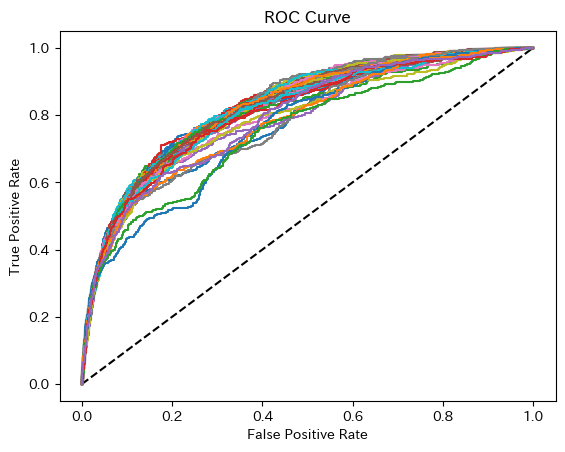

In [47]:
from sklearn.metrics import roc_curve

plt.plot([0, 1], [0, 1], 'k--')
for oof in Rc.RESULT.oof_valid:
    fpr, tpr, thresholds = roc_curve(y, oof)
    plt.plot(fpr,tpr,label='LogisticRegression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [49]:
oof_test_merge = tmp.oof_test.mean()

In [50]:
make_submitfile(submit_date = "0901",filename = f"submission_merge", version = "01", data = oof_test_merge)

In [52]:
tmp = Rc.RESULT.copy()
tmp = tmp[tmp["score"] > 0.82]

stack_train = pd.DataFrame()
stack_test = pd.DataFrame()
for i in range(len(tmp)):
    stack_train[str(i).zfill(3)] = tmp.reset_index().oof_valid.iloc[i]
    stack_test[str(i).zfill(3)] = tmp.reset_index().oof_test.iloc[i]

In [53]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(random_state=42) # ロジスティック回帰モデルのインスタンスを作成
lr.fit(stack_train, y) # ロジスティック回帰モデルの重みを学習

LogisticRegression(random_state=42)

In [54]:
y_train_pred = lr.predict_proba(stack_train)[:,1]
y_test_pred = lr.predict_proba(stack_test)[:,1]
score = roc_auc_score(y, y_train_pred)
print(score)

0.8401781006896998


In [55]:
make_submitfile(submit_date = "0901",filename = f"submission_stacking", version = "00", data = y_test_pred)